<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [13]</a>'.</span>

In [1]:
"""from google.colab import drive
drive.mount('/content/gdrive/')

!pip install -q condacolab
import condacolab
condacolab.install()

%cd /content/gdrive/MyDrive/Explicit_Disentanglement_Molecules/tests
!pip install gpytorch mlflow tensorboard tensorboardx torch-tb-profiler pyfiglet dpath logomaker biopython pandas numpy tqdm confuse seaborn nbconvert
!pip install papermill[all]
!pip install torchvision"""

"from google.colab import drive\ndrive.mount('/content/gdrive/')\n\n!pip install -q condacolab\nimport condacolab\ncondacolab.install()\n\n%cd /content/gdrive/MyDrive/Explicit_Disentanglement_Molecules/tests\n!pip install gpytorch mlflow tensorboard tensorboardx torch-tb-profiler pyfiglet dpath logomaker biopython pandas numpy tqdm confuse seaborn nbconvert\n!pip install papermill[all]\n!pip install torchvision"

In [2]:
import pdb
import torch, os
import argparse, datetime
import gc,time
from tqdm import tqdm
import __init__



#from src.gp_cpab.src.transformation.gp_cpab import gp_cpab
#from src.gp_cpab.src.transformation.gp_cpab_tmp import gp_cpab
from src.gp_cpab.src.transformation.configManager import configManager
from src.gp_cpab.src.extra.experiment_utilities import *

from src.models.trainer_tmp import vae_trainer
from src.unsuper.unsuper.data.mnist_data_loader import mnist_data_loader
from src.unsuper.unsuper.data.perception_data_loader import perception_data_loader
from src.unsuper.unsuper.helper.utility import model_summary
from src.models.encoder_decoder import get_encoder, get_decoder, get_list_encoders, get_list_decoders
from src.models import get_model

from src.seqsDataLoader import seqsReader, seqsDatasetLoader, Sequence_Data_Loader
from src.dataLoaderDiffeo import *

#from src.models.experimental.vitae_ci_gp_detached_deepseq import vitae_ci_gp_no_deepseq
from src.models.experimental.PGM_LA_latent_alignment import PGM_LA_latent_alignment
from src.models.experimental.deepsequence import DeepSequence

/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Could not import libcpab, error was
No module named 'libcpab'


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [3]:
import argparse; import sys; sys.argv=['']; del sys
import math

def define_prior_init(channels, space='log'):
    prior_init = []
    base_alpha = channels-2

    if space=='log':
        #prior_init = [math.log(1e-6)]*channels
        prior_init = [math.log(1e-6), *([ math.log(1/base_alpha) ]*base_alpha)]
    else:
        # Current Approach
        #prior_init = [0.0, *([1/base_alpha]*base_alpha)]
        #prior_init = [0.0, 0.0, *([1/base_alpha]*base_alpha)]


        # Approach A for avoiding flat landscape in the optimization - avoiding local optima
        prior_init = [1.0, 0.0, *([0.0]*base_alpha) ]

    return prior_init

def argparser():
    """ Argument parser for the main script """
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    # Model settings
    ms = parser.add_argument_group('Model settings')
    ms.add_argument('--model', type=str, default='vitae_ci', help='model to train')
    ms.add_argument('--ed_type', type=str, default='mlp,mlp', help='encoder/decoder type')
    ms.add_argument('--stn_type', type=str, default='gp_cpab', help='transformation type to use')
    ms.add_argument('--beta', type=float, default=16, help='beta value for beta-vae model') #16
    
    # Training settings
    ts = parser.add_argument_group('Training settings')
    ts.add_argument('--n_epochs', type=int, default=500, help='number of epochs of training')
    ts.add_argument('--eval_epoch', type=int, default=5, help='when to evaluate log(p(x))')
    ts.add_argument('--batch_size', type=int, default=5, help='size of the batches') # batch=10,warmup=10, epochs=100
    ts.add_argument('--warmup', type=int, default=5, help='number of warmup epochs for kl-terms')
    ts.add_argument('--lr', type=float, default=1e-3, help='learning rate for adam optimizer') # 1e-5 for 2 sequence deepseq 2 seqs other# 1e-3, 1e-7 # weird case for 550 iters and 1e-4, works in trans but regular in reconstruction
    
    # Paths to use
    paths = parser.add_argument_group('Paths')
    #paths.add_argument('--path_orig', type=str, default="../data/WW10seeds_rawnoHoles2.fasta", help='original sequence to deform')  #"../data/WW10seeds_rawnoHoles.fasta"  #orig_3aa.fasta orig_3aag.fasta
    #paths.add_argument('--path_aligned_orig', type=str, default="../data/WW10seeds_MSAnoHoles2.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta
    paths.add_argument('--path_orig', type=str, default="../data/set_preprint/WWseeds_tunningPGM_set_20seqs_v2.fasta", help='original sequence to deform')  #"../data/WW10seeds_rawnoHoles.fasta"  #orig_3aa.fasta orig_3aag.fasta
    paths.add_argument('--path_aligned_orig', type=str, default="../data/set_preprint/WWseeds_aligned_for_pretrained2.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta
 

    paths.add_argument('--path_preexist_linear', type=str, default="../../models/CPABlinear3.pth", help='prebuilt model using linear case') 
    paths.add_argument('--path_preexist_gp', type=str, default="../../models/CPABGPB3.pth", help='prebuilt model using gp case')
    paths.add_argument('--path_automated_report', type=str, default="../../Results", help='path to save automatic report') 
    paths.add_argument('--logdir', type=str, default="../../Results", help='where to store results')

    gpsetup = parser.add_argument_group('GPSetup')
    #gpsetup.add_argument('--Task', type=int, default = 8, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143], help='multitaks-gp initialization') 
    gpsetup.add_argument('--Task', type=int, default = 22, help='Amount of channels in multitask-gp estimator')
    gpsetup.add_argument('--Initialization', type=list, default = define_prior_init(22, space='default'), help='multitaks-gp initialization') # before it was 19 and works good in current setup with uniform distributed values in prior
    #gpsetup.add_argument('--Task', type=int, default = 11, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], help='multitaks-gp initialization') #[0.0, 0.33, 0.33, 0.33] #[0.5, 0.5]
    gpsetup.add_argument('--Lengthscale', type=float, default = 0.5, help='lengthscale on square-exponential kernel') # *** 0.5 *** #0.25, #0.5 + init gives better for 2 gaps case, # 1.25
    gpsetup.add_argument('--noise_constraint', type=list, default = [1e-3,1e-1], help='noise constrain -- [lower_bound, upper_bound]') #16
    gpsetup.add_argument('--Option', type=str, default = 'multitask', help='noise constrain') #16

    # CPAB features
    cpab = parser.add_argument_group('CPAB')
    cpab.add_argument('--device', type=str, default="gpu", help='device')
    cpab.add_argument('--modeflag', type=str, default="1D", help='dimensionality of tesselation')
    cpab.add_argument('--window_grid', type=int, default=100, help='number of tesselation cells') #6 80, the increasing of tess improve the performance when there are more samples to train the density estimator
    cpab.add_argument('--channels', type=int, default=100, help='amount of channels for estimation --deprecated')
    cpab.add_argument('--interpolation_type', type=str, default="GP", help='type of interpolation between maps') 

    # Hyper settings
    hp = parser.add_argument_group('Variational settings')
    hp.add_argument('--latent_dim', type=int, default=40, help='dimensionality of the latent space') #40, 5, 10, 40 is the bst one for WW
    hp.add_argument('--density', type=str, default='softmax', help='output density')  # bernoulli  gaussian
    hp.add_argument('--eq_samples', type=int, default=1, help='number of MC samples over the expectation over E_q(z|x)')
    hp.add_argument('--iw_samples', type=int, default=1, help='number of importance weighted samples')
    
    
    # Parse and return
    args = parser.parse_args()
    return args

In [4]:
print(__package__)
args = argparser()
'''---------------------------------------------------------'''
std = configManager(args)

device = std.parserinfo('device')
modeflag = std.parserinfo('modeflag')
window_grid = std.parserinfo('window_grid')
channels = std.parserinfo('channels')
option = std.parserinfo('Option')
beta = std.parserinfo('beta')
#lossmetric = std.parserinfo('lossfunctmetric')

path = std.parserinfo('path_orig')
path_aligned = std.parserinfo('path_aligned_orig')
path_preexist_model = std.parserinfo('path_preexist_linear')
path_preexist_modelGP = std.parserinfo('path_preexist_gp')

#self.config, self.constrain, self.tasks, self.interpolation_type, self.option 
gp_params = std.get_config_vals(['noise_constraint','Task','interpolation_type','Option','Lengthscale','Initialization'])

#alphabets = ['-', 'A', 'D', 'G', 'I', 'L', 'R', 'S'] # for two long sequences
#alphabets = ['-', 'A', 'E', 'F', 'G', 'L', 'Q', 'R', 'S', 'T', 'V'] # ['-', 'L', 'Q', 'R'] #-> for 10 sequences case
#alphabets = ['-', 'A', 'D', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'P', 'S', 'T', 'V', 'W'] #-> for antiviral peptides
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_AntiviralPEP.pth'

#alphabets = ['-', 'A', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> WW 4 seqs
alphabets = ['?','-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> for 4 sequences
#alphabets = ['-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> for 4 sequences


#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW10NoSeed_22channels.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_channel_seeds_PGM1.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_channel_seeds_PGM1_v2.pth'

'''trained_model_WW_22_simplex9990_channel_seeds_PGM1_v2_debug.pth is the one that works fine'''
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_simplex9990_channel_seeds_PGM1_v2_debug.pth'

'''this would be with the seeds samples (40 aas)'''
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_seeds_40aas_nov2023_4.pth'

'''for seeds samples'''
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22__channel_CompleteSeeds_PGM1_v2_debug.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22__channel_CompleteSeeds_PGM1_v2_debug_2000iter.pth'

'''for preprint'''
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_preprint_PGM1_21nov2023.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_preprint_PGM1_22nov2023.pth'
logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_preprint_PGM1_27nov2023.pth'

print('Ok')

None
Ok


In [5]:
from src.gp_cpab.src.extra import experiment_utilities
from src.dataLoaderDiffeo import datasetLoader

# Raw Sequences, to see if we can align the sequences somehow

c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)
dataset_msa = seqsDatasetLoader(pathBLAT_data = path, alphabet = alphabets, enable_variable_length=True, device=device)
#x1 = dataset_msa.prot_space
dataset_aligned_msa = seqsDatasetLoader(pathBLAT_data = path_aligned, alphabet = alphabets, enable_variable_length=True, device=device)

'''--------------------------------------------------------------------------------------------------------------------------'''
'''dataset_msa.prot_space = replace_target_token_gaps(dataset_msa.prot_space, c2i, '-')[:,:,1:]
dataset_aligned_msa.prot_space = replace_target_token_gaps(dataset_aligned_msa.prot_space, c2i, '-')[:,:,1:]
alphabets=['L','Q','R']
c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)'''
'''--------------------------------------------------------------------------------------------------------------------------'''

# Load data
print('Loading data')

batches = args.batch_size #16 # 448

# initially the dimension is [448, 34, 21]. However as it is necesary to ignore 
# the batch size, I just create a tuple, by taking just the last 2 components from the size
trainloader, testloader = Sequence_Data_Loader(dataset_msa, dataset_test=None, batch_size=batches)
trainloader_pretrainer, testloader_pretrainer = Sequence_Data_Loader(dataset_aligned_msa, dataset_test=None, batch_size=112)
#trainloader2, testloader2 = Sequence_Data_Loader(dataset_msa2, dataset_test=None, batch_size=batches)


seq_size = ( [*dataset_msa.prot_space.shape][1:])

/home/kvr226/Explicit_Disentanglement_Molecules/src/seqsDataLoader.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prot_space = torch.tensor(self.prot_space, dtype=torch.float32, device=device)


Loading data


Loading Deformation Model...
Loaded


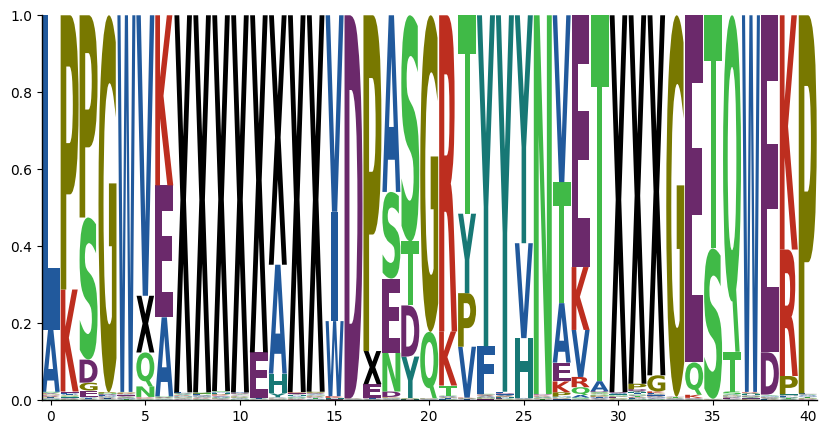

In [6]:
# Loading BLAT dataset
deepseq = DeepSequence(seq_size, args.latent_dim, alphabets, device = device)
optimizer_deepseq = torch.optim.AdamW(deepseq.parameters(), lr=args.lr*0.1)
loss_function = LossFunctionsAlternatives()
pretrained_deepseq_path = logdir + "/" + outmodel_name
check_parameter_historic = []

casted_device = "cuda" if device=="gpu" or device=="cuda" else "cpu" if device=='cpu'else 'mps'

if os.path.isfile(pretrained_deepseq_path):
    print ("Loading Deformation Model...")
    deepseq.load_state_dict( torch.load(pretrained_deepseq_path, map_location=casted_device) )
    print ("Loaded")
    #for param in deepseq.parameters():
    #    param.requires_grad = False
else:
    deepseq.training_representation(trainloader_pretrainer, loss_function, optimizer_deepseq, 1000, 1, logdir=logdir, out_modelname=outmodel_name, beta=1 )
    #check_parameter_historic = list(deepseq.parameters())
    #2500 iters before to make it converge in a good optima
    #for param in deepseq.parameters():
    #    param.requires_grad = False

deepseq(dataset_msa.prot_space)
plot_logos_probs(deepseq(dataset_msa.prot_space)[0], alphabets)


In [7]:
import matplotlib.pyplot as plt
import src.gp_cpab.src.extra.utilities as ut
import matplotlib.gridspec as gridspec
import logomaker 


def get_GPinterpolation(TT, theta, Y, Ug,  n_batch, grid_length_for_GP, seq_len):
    grids_trans_out = (TT.transform_grid(TT.grid,theta)*(seq_len - 1)).squeeze(1)
    # creating the likelihood for interpolation
    batch_Multitask_model, batch_multitask_likelihood = TT.sets_MultioutputGP_per_batches(grids_trans_out, Y, n_batch)
    # To get distribution over Posteriors
    trans_data, _, \
            lower,upper  = TT.predict_operation(Ug, batch_Multitask_model, batch_multitask_likelihood  )
    trans_data = torch.reshape(trans_data, (n_batch, grid_length_for_GP, Y.shape[2]))
    lower = torch.reshape( lower, (n_batch, grid_length_for_GP, Y.shape[2]) )
    upper = torch.reshape( upper, (n_batch, grid_length_for_GP, Y.shape[2]) )

    return grids_trans_out, trans_data, lower, upper

def plot_GP_components_per_seq(Ug, gT, Trdata, Lw, Up, nrows, ncols, alphabets, title, fig):

    for j, axs in enumerate(fig.axes[(nrows-1)*ncols : nrows*ncols]):
        axs.plot( Ug.flatten().detach().numpy(), Trdata[:,j].detach().numpy(), 'b' )
        axs.fill_between(Ug.flatten().detach().numpy(), Lw[:,j].detach().numpy(),  Up[:,j].detach().numpy(), alpha=0.3)
        axs.legend([ 'Mean'])
        axs.set_xticks( Ug.flatten().detach().numpy(), minor= True )
        axs.axhline(0, color='grey', linewidth=0.8)
        axs.set_title(alphabets[j])
    
    #fig.tight_layout()
    
 
def create_gridSpec_graphs(ncols=4,nrows=2,figsize=(25,12)):
    fig = plt.figure(figsize=figsize) #(constrained_layout=True)
    gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)
    for i in range(0, nrows):
        for j in range(0,ncols):
            fig.add_subplot(gs[i, j])
    return fig, gs

def plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data,lower,upper, fig2):
    for cont,(U,gT, Trdata,Lw,Up) in enumerate(list(zip(Ug,grids_trans_out, trans_data,lower,upper))):
        title='sequence {0}'.format(cont+1)
        plot_GP_components_per_seq(U, gT, Trdata, Lw, Up, cont+1, Trdata.shape[1], alphabets=alphabets, title=title, fig = fig2)

def heatmap_from_tensor_tmp(data, alphabet, title):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    figure, ax = plt.subplots(figsize=(8,10))
    #ax = plt.axes()
    px = pd.DataFrame(data, columns=alphabet)
    ff=sns.heatmap(px, linewidth=1, linecolor='w', annot=data, ax = ax)
    ax.set_title(title)
    plt.show()

def plot_msa_from_preds(ts_aligned, alphabet, figsize = (5,4), show_axis=True):
    fig, gs = create_gridSpec_graphs(ncols=1,nrows=ts_aligned.shape[0], figsize=figsize); fig.suptitle('MSA', fontsize='large')

    alphabets_logo = [ i if i!='-' else 'X' for i in alphabet] 
    for cont, x_aligned in enumerate(ts_aligned):
        domain_info_df = df_construction_aas([ x_aligned.unsqueeze(0).detach().numpy() ], x_aligned.unsqueeze(0).shape, alphabets_logo)
        
        if show_axis == False:
            fig.axes[cont].get_xaxis().set_visible(False)
            fig.axes[cont].get_yaxis().set_visible(False)

        logomaker.Logo(domain_info_df,
                          color_scheme = 'NajafabadiEtAl2017',
                          ax = fig.axes[cont],
                          figsize=figsize, show_spines=False)



# recon_data_train = model(dataset_msa.prot_space, deepseq)
def get_GP_behavior_from_model_alignment(data,model, DS, len_grid = 13 , alphabets=['-','L','Q','R']):
    model.eval()
    Y = data
    recon_data_train = model(data, DS)

    x1_trans = recon_data_train[5]

    out_DS_before_dir_trans = DS(x1_trans)[0]

    TT=model.stn.st_gp_cpab
    TT.interpolation_type = 'GP'
    grid_length_for_GP = len_grid


    #get the transformation from Big model
    _, theta = model.sample_only_trans(Y)
    seq_len = Y.shape[1]; n_batch = Y.shape[0]

    ''' info about initial deformation '''
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''
    initialTT_raw = TT.grid
    initialTT_inv = TT.transform_grid(TT.grid,-theta)
    initialTT_dir = TT.transform_grid(TT.grid,theta)
    forward = torch.stack([initialTT_raw.flatten() ,initialTT_inv.flatten(), (initialTT_inv*(x1_trans.shape[1]-1)).flatten() ]).T
    backward = torch.stack([initialTT_raw.flatten() ,initialTT_dir.flatten(), (initialTT_dir*(x1_trans.shape[1]-1)).flatten() ]).T
    heatmap_from_tensor_tmp(forward.detach().numpy(), ['input','raw','scaled'], 'FORWARD SCHEME' )
    heatmap_from_tensor_tmp(backward.detach().numpy(), ['input','raw','scaled'], 'BACKWARD SCHEME' )
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''

    # grid creations and deformations based on theta estimated from big model

    Ug=TT.uniform_meshgrid((grid_length_for_GP,grid_length_for_GP)).repeat(n_batch,1,1)*(seq_len - 1)
    
    grids_trans_out, trans_data, lower, upper = get_GPinterpolation(TT, -theta, Y, Ug, n_batch, grid_length_for_GP, seq_len)
    grids_dir_trans_out, dir_trans_data, lower_dir, upper_dir = get_GPinterpolation(TT, theta, out_DS_before_dir_trans, Ug, n_batch, grid_length_for_GP, seq_len)

    ncols= grids_trans_out.shape[-1]; nrows = Ug.shape[0]
    fig, gs = create_gridSpec_graphs(ncols=ncols,nrows=nrows, figsize=(25,20)); fig.suptitle('Sequence Alignment by Transformation', fontsize='large')
    figdir, gsdir = create_gridSpec_graphs(ncols=ncols,nrows=nrows,figsize=(25,20)); figdir.suptitle('Sequence Reconstruction', fontsize='large')
    
    plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data,lower,upper, fig)
    plot_GP_components_alignment_channel(Ug,grids_dir_trans_out, dir_trans_data,lower_dir,upper_dir, figdir)



#x = deepseq(trainloader_pretrainer.dataset.prot_space)
#plot_msa_from_preds(x[0], alphabets, figsize=(15,10), show_axis=False)



In [8]:
import time

def update_behavior_loss_batches(batch_loss_dict, batch_key, batch_historical):
    if batch_key not in batch_loss_dict:
        batch_loss_dict[batch_key] =  [batch_historical]
    else:
        batch_loss_dict[batch_key].append(batch_historical)

def batch_plots(batch_loss_dict):
    import matplotlib.pyplot as plt

    if len(batch_loss_dict.keys())==1:
         values= batch_loss_dict[ list(batch_loss_dict.keys())[0] ]
         epochs_i = list(range(0,len(values)))
         plt.plot(epochs_i, values)
    else:
        fig, ax = plt.subplots(len(batch_loss_dict.keys()),1, figsize=(4,10))
        fig.tight_layout()

        for i in batch_loss_dict.keys():
            y = batch_loss_dict[i]
            x = list(range(0,len(y)))
            ax[i].set_title('Batch ' + str(i))
            ax[i].plot(x,y)

    plt.show()
        
def fit_VITAE_with_pretrained_DeepSeq(trainloader, optimizer, model, DS, n_epochs=10, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=1.0, eval_epoch=10000, **kargs):
        """ Fits the supplied model to a training set 
        Arguments:
            trainloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the training data
            n_epochs: integer, number of epochs to run
            warmup: integer, the KL terms are weighted by epoch/warmup, so this
                number determines the number of epochs before the KL-terms are 
                fully activated in the loss function
            logdir: str, where to store the results
            testloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the test data
            eq_samples: integer, number of equality samples which the expectation
                is calculated over
            iw_samples: integer, number of samples the mean-log is calculated over
            eval_epoch: how many epochs that should pass between calculating the
                L5000 loglikelihood (very expensive to do)
        """

        # Assert that input is okay
        assert isinstance(trainloader, torch.utils.data.DataLoader), '''Trainloader
            should be an instance of torch.utils.data.DataLoader '''
        assert warmup <= n_epochs, ''' Warmup period need to be smaller than the
            number of epochs '''
    
        # Print stats
        print('Number of training points: ', len(trainloader.dataset.prot_space))
        if testloader: print('Number of test points:     ', len(testloader.dataset))
        
        loss_function = LossFunctionsAlternatives()

        #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=550, gamma=0.1)
        #import ipdb; ipdb.set_trace()

        # Main loop
        start = time.time()
        for epoch in range(1, n_epochs+1):
            progress_bar = tqdm(desc='Epoch ' + str(epoch) + '/' + str(n_epochs), 
                                total=len(trainloader.dataset), unit='samples')
            train_loss = 0
            # Training loop
            #self.model.train()
            # Decay Learning Rate
            #scheduler.step()

            if epoch == 205:
                 print('From Here')
            for i, data in enumerate(trainloader):
                # Zero gradient
                optimizer.zero_grad()

                # Feed forward data
                data = data.to(torch.float32)#.to(device)

                switch = 1.0 if epoch > warmup else 0.0
                out = model(data, DS, eq_samples, iw_samples, switch)
                
                # Calculat loss
                loss = loss_function(method = 'CE', input = out[0], target = data, forw_per=(0,2,1)) - beta*out[7]
                #loss = loss_function(method = 'JSD', input = out[0], target = data, forw_per=(0,2,1)) # - out[7]

                
                # Backpropegate and optimize
                loss.backward()
                #torch.nn.utils.clip_grad_value_(model.parameters(), 0.5)

                ### UPDATE MODEL PARAMETERS                
                optimizer.step()

                
                #########################################################
                #########################################################
                ### GRADIENT CLIPPING
                #torch.nn.utils.clip_grad_value_(model.parameters(), 1.)
                #torch.nn.utils.clip_grad_norm_(model.parameters(), 1., norm_type=2)
                #########################################################
                #########################################################

                # Write to consoeeeddddddddwwww######hhhdffffffffffsssswqqq#l#
                progress_bar.update(data.size(0))
                progress_bar.set_postfix({'loss': str(loss.item())  })
                #progress_bar.set_postfix({'loss': str(loss.item()) + ', lr rate: ' + str(scheduler.get_lr()[-1]) })
                update_behavior_loss_batches(batch_loss_dict, i, loss.item())
                
                # Save to tensorboard
                iteration = epoch*len(trainloader) + i
                
                gc.collect()
                torch.cuda.empty_cache()

            progress_bar.close()
        
        print('Total train time', time.time() - start)
        #import pdb;pdb.set_trace()
        # Save the embeddings

In [9]:

batch_loss_dict = {}
#import ipdb; ipdb.set_trace()

# Construct model
# I do not add the pretrained deepsequence module to avoid 
# the backpropagation of such module during the optimization
model = PGM_LA_latent_alignment(
                    input_shape = seq_size, #img_size,
                    config = std, 
                    latent_dim = args.latent_dim, 
                    encoder = get_encoder( args.ed_type.split(",")[0] ), 
                    decoder = get_decoder( args.ed_type.split(",")[1] ),
                    outputdensity = args.density,
                    ST_type = args.stn_type,
                    alphabet_size = len(c2i),
                    trans_parameters = ( [window_grid], device, gp_params ),
                    diagonal_att_regions = [-245,245])#[-15,15] ) #[15,15] #if we increase it, major accuracy

#model.get_deepsequence_module(deepseq)

# Optimizer
opt = torch.optim.AdamW(model.parameters(), lr=1e-4)#, weight_decay=1e-5)#lr=1e-3 also works but we have to test with seed samples
model_name = '/trained_model_softmax.pt'

fit_VITAE_with_pretrained_DeepSeq(trainloader, opt, model, deepseq, n_epochs=500, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=1.0, eval_epoch=10) # initi

/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/torch/utils/cpp_extension.py:283: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(


/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/torch/utils/cpp_extension.py:283: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(


Number of training points:  40


Epoch 1/500:   0%|          | 0/40 [00:00<?, ?samples/s]

/home/kvr226/Explicit_Disentanglement_Molecules/src/gp_cpab/src/transformation/libcpab/libcpab/pytorch/functions.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=dtype, device=device)


/home/kvr226/Explicit_Disentanglement_Molecules/src/models/experimental/PGM_LA_latent_alignment.py:298: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_mean = torch.tensor(x_mean_no_grad, requires_grad=True)
/home/kvr226/Explicit_Disentanglement_Molecules/src/models/experimental/PGM_LA_latent_alignment.py:299: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_var = torch.tensor(x_var_no_grad, requires_grad=True)


Epoch 1/500:  12%|█▎        | 5/40 [00:00<00:06,  5.44samples/s]

Epoch 1/500:  12%|█▎        | 5/40 [00:00<00:06,  5.44samples/s, loss=621.9984741210938]

Epoch 1/500:  25%|██▌       | 10/40 [00:01<00:04,  6.61samples/s, loss=621.9984741210938]

Epoch 1/500:  25%|██▌       | 10/40 [00:01<00:04,  6.61samples/s, loss=622.1990966796875]

Epoch 1/500:  38%|███▊      | 15/40 [00:02<00:03,  7.07samples/s, loss=622.1990966796875]

Epoch 1/500:  38%|███▊      | 15/40 [00:02<00:03,  7.07samples/s, loss=623.31005859375]  

Epoch 1/500:  50%|█████     | 20/40 [00:02<00:02,  7.37samples/s, loss=623.31005859375]

Epoch 1/500:  50%|█████     | 20/40 [00:02<00:02,  7.37samples/s, loss=623.1717529296875]

Epoch 1/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.54samples/s, loss=623.1717529296875]

Epoch 1/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.54samples/s, loss=621.3225708007812]

Epoch 1/500:  75%|███████▌  | 30/40 [00:04<00:01,  7.71samples/s, loss=621.3225708007812]

Epoch 1/500:  75%|███████▌  | 30/40 [00:04<00:01,  7.71samples/s, loss=623.4923095703125]

Epoch 1/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.71samples/s, loss=623.4923095703125]

Epoch 1/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.71samples/s, loss=619.9915161132812]

Epoch 1/500: 100%|██████████| 40/40 [00:05<00:00,  7.96samples/s, loss=619.9915161132812]

Epoch 1/500: 100%|██████████| 40/40 [00:05<00:00,  7.96samples/s, loss=623.4561157226562]

Epoch 1/500: 100%|██████████| 40/40 [00:05<00:00,  7.35samples/s, loss=623.4561157226562]

Epoch 2/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 2/500:  12%|█▎        | 5/40 [00:00<00:03,  9.89samples/s]

Epoch 2/500:  12%|█▎        | 5/40 [00:00<00:03,  9.89samples/s, loss=617.8466796875]

Epoch 2/500:  25%|██▌       | 10/40 [00:01<00:03,  8.53samples/s, loss=617.8466796875]

Epoch 2/500:  25%|██▌       | 10/40 [00:01<00:03,  8.53samples/s, loss=615.6826171875]

Epoch 2/500:  38%|███▊      | 15/40 [00:01<00:03,  8.29samples/s, loss=615.6826171875]

Epoch 2/500:  38%|███▊      | 15/40 [00:01<00:03,  8.29samples/s, loss=618.67138671875]

Epoch 2/500:  50%|█████     | 20/40 [00:02<00:02,  8.21samples/s, loss=618.67138671875]

Epoch 2/500:  50%|█████     | 20/40 [00:02<00:02,  8.21samples/s, loss=621.8253784179688]

Epoch 2/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.03samples/s, loss=621.8253784179688]

Epoch 2/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.03samples/s, loss=619.5303344726562]

Epoch 2/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.15samples/s, loss=619.5303344726562]

Epoch 2/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.15samples/s, loss=617.0750122070312]

Epoch 2/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.13samples/s, loss=617.0750122070312]

Epoch 2/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.13samples/s, loss=617.3424682617188]

Epoch 2/500: 100%|██████████| 40/40 [00:04<00:00,  8.09samples/s, loss=617.3424682617188]

Epoch 2/500: 100%|██████████| 40/40 [00:04<00:00,  8.09samples/s, loss=620.9942626953125]

Epoch 2/500: 100%|██████████| 40/40 [00:04<00:00,  8.02samples/s, loss=620.9942626953125]

Epoch 3/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 3/500:  12%|█▎        | 5/40 [00:00<00:03,  9.63samples/s]

Epoch 3/500:  12%|█▎        | 5/40 [00:00<00:03,  9.63samples/s, loss=611.3322143554688]

Epoch 3/500:  25%|██▌       | 10/40 [00:01<00:03,  8.38samples/s, loss=611.3322143554688]

Epoch 3/500:  25%|██▌       | 10/40 [00:01<00:03,  8.38samples/s, loss=612.6852416992188]

Epoch 3/500:  38%|███▊      | 15/40 [00:01<00:03,  8.17samples/s, loss=612.6852416992188]

Epoch 3/500:  38%|███▊      | 15/40 [00:01<00:03,  8.17samples/s, loss=613.7015380859375]

Epoch 3/500:  50%|█████     | 20/40 [00:02<00:02,  8.21samples/s, loss=613.7015380859375]

Epoch 3/500:  50%|█████     | 20/40 [00:02<00:02,  8.21samples/s, loss=618.48486328125]  

Epoch 3/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.08samples/s, loss=618.48486328125]

Epoch 3/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.08samples/s, loss=612.291259765625]

Epoch 3/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.07samples/s, loss=612.291259765625]

Epoch 3/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.07samples/s, loss=617.1382446289062]

Epoch 3/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.06samples/s, loss=617.1382446289062]

Epoch 3/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.06samples/s, loss=614.6002807617188]

Epoch 3/500: 100%|██████████| 40/40 [00:04<00:00,  8.06samples/s, loss=614.6002807617188]

Epoch 3/500: 100%|██████████| 40/40 [00:04<00:00,  8.06samples/s, loss=616.4800415039062]

Epoch 3/500: 100%|██████████| 40/40 [00:05<00:00,  7.97samples/s, loss=616.4800415039062]

Epoch 4/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 4/500:  12%|█▎        | 5/40 [00:00<00:03,  9.88samples/s]

Epoch 4/500:  12%|█▎        | 5/40 [00:00<00:03,  9.88samples/s, loss=609.5970458984375]

Epoch 4/500:  25%|██▌       | 10/40 [00:01<00:03,  8.75samples/s, loss=609.5970458984375]

Epoch 4/500:  25%|██▌       | 10/40 [00:01<00:03,  8.75samples/s, loss=606.6598510742188]

Epoch 4/500:  38%|███▊      | 15/40 [00:01<00:02,  8.39samples/s, loss=606.6598510742188]

Epoch 4/500:  38%|███▊      | 15/40 [00:01<00:02,  8.39samples/s, loss=610.5486450195312]

Epoch 4/500:  50%|█████     | 20/40 [00:02<00:02,  8.07samples/s, loss=610.5486450195312]

Epoch 4/500:  50%|█████     | 20/40 [00:02<00:02,  8.07samples/s, loss=612.6007690429688]

Epoch 4/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.97samples/s, loss=612.6007690429688]

Epoch 4/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.97samples/s, loss=606.4969482421875]

Epoch 4/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.96samples/s, loss=606.4969482421875]

Epoch 4/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.96samples/s, loss=614.1343994140625]

Epoch 4/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.97samples/s, loss=614.1343994140625]

Epoch 4/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.97samples/s, loss=613.07763671875]  

Epoch 4/500: 100%|██████████| 40/40 [00:04<00:00,  7.95samples/s, loss=613.07763671875]

Epoch 4/500: 100%|██████████| 40/40 [00:04<00:00,  7.95samples/s, loss=612.0755615234375]

Epoch 4/500: 100%|██████████| 40/40 [00:05<00:00,  7.92samples/s, loss=612.0755615234375]

Epoch 5/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 5/500:  12%|█▎        | 5/40 [00:00<00:03, 10.04samples/s]

Epoch 5/500:  12%|█▎        | 5/40 [00:00<00:03, 10.04samples/s, loss=604.99462890625]

Epoch 5/500:  25%|██▌       | 10/40 [00:01<00:03,  8.60samples/s, loss=604.99462890625]

Epoch 5/500:  25%|██▌       | 10/40 [00:01<00:03,  8.60samples/s, loss=603.0294799804688]

Epoch 5/500:  38%|███▊      | 15/40 [00:01<00:02,  8.41samples/s, loss=603.0294799804688]

Epoch 5/500:  38%|███▊      | 15/40 [00:01<00:02,  8.41samples/s, loss=606.3240966796875]

Epoch 5/500:  50%|█████     | 20/40 [00:02<00:02,  8.13samples/s, loss=606.3240966796875]

Epoch 5/500:  50%|█████     | 20/40 [00:02<00:02,  8.13samples/s, loss=608.931884765625] 

Epoch 5/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.09samples/s, loss=608.931884765625]

Epoch 5/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.09samples/s, loss=601.2577514648438]

Epoch 5/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.08samples/s, loss=601.2577514648438]

Epoch 5/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.08samples/s, loss=607.7247314453125]

Epoch 5/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.19samples/s, loss=607.7247314453125]

Epoch 5/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.19samples/s, loss=607.6585693359375]

Epoch 5/500: 100%|██████████| 40/40 [00:04<00:00,  8.08samples/s, loss=607.6585693359375]

Epoch 5/500: 100%|██████████| 40/40 [00:04<00:00,  8.08samples/s, loss=603.635498046875] 

Epoch 5/500: 100%|██████████| 40/40 [00:04<00:00,  8.00samples/s, loss=603.635498046875]

Epoch 6/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 6/500:  12%|█▎        | 5/40 [00:00<00:03,  9.60samples/s]

Epoch 6/500:  12%|█▎        | 5/40 [00:00<00:03,  9.60samples/s, loss=593.6679077148438]

Epoch 6/500:  25%|██▌       | 10/40 [00:01<00:03,  8.44samples/s, loss=593.6679077148438]

Epoch 6/500:  25%|██▌       | 10/40 [00:01<00:03,  8.44samples/s, loss=595.474365234375] 

Epoch 6/500:  38%|███▊      | 15/40 [00:01<00:03,  7.95samples/s, loss=595.474365234375]

Epoch 6/500:  38%|███▊      | 15/40 [00:01<00:03,  7.95samples/s, loss=596.2313232421875]

Epoch 6/500:  50%|█████     | 20/40 [00:02<00:02,  8.02samples/s, loss=596.2313232421875]

Epoch 6/500:  50%|█████     | 20/40 [00:02<00:02,  8.02samples/s, loss=597.2058715820312]

Epoch 6/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.07samples/s, loss=597.2058715820312]

Epoch 6/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.07samples/s, loss=593.2146606445312]

Epoch 6/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.95samples/s, loss=593.2146606445312]

Epoch 6/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.95samples/s, loss=597.587646484375] 

Epoch 6/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.94samples/s, loss=597.587646484375]

Epoch 6/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.94samples/s, loss=588.840087890625]

Epoch 6/500: 100%|██████████| 40/40 [00:04<00:00,  7.83samples/s, loss=588.840087890625]

Epoch 6/500: 100%|██████████| 40/40 [00:05<00:00,  7.83samples/s, loss=594.6980590820312]

Epoch 6/500: 100%|██████████| 40/40 [00:05<00:00,  7.81samples/s, loss=594.6980590820312]

Epoch 7/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 7/500:  12%|█▎        | 5/40 [00:00<00:03,  8.99samples/s]

Epoch 7/500:  12%|█▎        | 5/40 [00:00<00:03,  8.99samples/s, loss=581.827880859375]

Epoch 7/500:  25%|██▌       | 10/40 [00:01<00:03,  8.29samples/s, loss=581.827880859375]

Epoch 7/500:  25%|██▌       | 10/40 [00:01<00:03,  8.29samples/s, loss=581.5633544921875]

Epoch 7/500:  38%|███▊      | 15/40 [00:01<00:02,  8.34samples/s, loss=581.5633544921875]

Epoch 7/500:  38%|███▊      | 15/40 [00:01<00:02,  8.34samples/s, loss=566.6889038085938]

Epoch 7/500:  50%|█████     | 20/40 [00:02<00:02,  8.15samples/s, loss=566.6889038085938]

Epoch 7/500:  50%|█████     | 20/40 [00:02<00:02,  8.15samples/s, loss=576.466064453125] 

Epoch 7/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.09samples/s, loss=576.466064453125]

Epoch 7/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.09samples/s, loss=574.6900024414062]

Epoch 7/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.09samples/s, loss=574.6900024414062]

Epoch 7/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.09samples/s, loss=570.31298828125]  

Epoch 7/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.01samples/s, loss=570.31298828125]

Epoch 7/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.01samples/s, loss=565.9674072265625]

Epoch 7/500: 100%|██████████| 40/40 [00:04<00:00,  7.96samples/s, loss=565.9674072265625]

Epoch 7/500: 100%|██████████| 40/40 [00:04<00:00,  7.96samples/s, loss=573.7905883789062]

Epoch 7/500: 100%|██████████| 40/40 [00:05<00:00,  7.92samples/s, loss=573.7905883789062]

Epoch 8/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 8/500:  12%|█▎        | 5/40 [00:00<00:03, 10.46samples/s]

Epoch 8/500:  12%|█▎        | 5/40 [00:00<00:03, 10.46samples/s, loss=565.0279541015625]

Epoch 8/500:  25%|██▌       | 10/40 [00:01<00:03,  9.09samples/s, loss=565.0279541015625]

Epoch 8/500:  25%|██▌       | 10/40 [00:01<00:03,  9.09samples/s, loss=569.4217529296875]

Epoch 8/500:  38%|███▊      | 15/40 [00:01<00:02,  8.48samples/s, loss=569.4217529296875]

Epoch 8/500:  38%|███▊      | 15/40 [00:01<00:02,  8.48samples/s, loss=571.0444946289062]

Epoch 8/500:  50%|█████     | 20/40 [00:02<00:02,  8.31samples/s, loss=571.0444946289062]

Epoch 8/500:  50%|█████     | 20/40 [00:02<00:02,  8.31samples/s, loss=574.945556640625] 

Epoch 8/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.17samples/s, loss=574.945556640625]

Epoch 8/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.17samples/s, loss=573.4384155273438]

Epoch 8/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.02samples/s, loss=573.4384155273438]

Epoch 8/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.02samples/s, loss=578.8139038085938]

Epoch 8/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.06samples/s, loss=578.8139038085938]

Epoch 8/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.06samples/s, loss=566.814208984375] 

Epoch 8/500: 100%|██████████| 40/40 [00:04<00:00,  8.10samples/s, loss=566.814208984375]

Epoch 8/500: 100%|██████████| 40/40 [00:04<00:00,  8.10samples/s, loss=566.3089599609375]

Epoch 8/500: 100%|██████████| 40/40 [00:04<00:00,  8.06samples/s, loss=566.3089599609375]

Epoch 9/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 9/500:  12%|█▎        | 5/40 [00:00<00:03,  9.76samples/s]

Epoch 9/500:  12%|█▎        | 5/40 [00:00<00:03,  9.76samples/s, loss=560.5545043945312]

Epoch 9/500:  25%|██▌       | 10/40 [00:01<00:03,  8.42samples/s, loss=560.5545043945312]

Epoch 9/500:  25%|██▌       | 10/40 [00:01<00:03,  8.42samples/s, loss=566.7966918945312]

Epoch 9/500:  38%|███▊      | 15/40 [00:01<00:03,  8.10samples/s, loss=566.7966918945312]

Epoch 9/500:  38%|███▊      | 15/40 [00:01<00:03,  8.10samples/s, loss=558.6740112304688]

Epoch 9/500:  50%|█████     | 20/40 [00:02<00:02,  7.91samples/s, loss=558.6740112304688]

Epoch 9/500:  50%|█████     | 20/40 [00:02<00:02,  7.91samples/s, loss=573.0612182617188]

Epoch 9/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.92samples/s, loss=573.0612182617188]

Epoch 9/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.92samples/s, loss=574.7911376953125]

Epoch 9/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.96samples/s, loss=574.7911376953125]

Epoch 9/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.96samples/s, loss=575.8417358398438]

Epoch 9/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.82samples/s, loss=575.8417358398438]

Epoch 9/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.82samples/s, loss=568.2734985351562]

Epoch 9/500: 100%|██████████| 40/40 [00:04<00:00,  7.95samples/s, loss=568.2734985351562]

Epoch 9/500: 100%|██████████| 40/40 [00:04<00:00,  7.95samples/s, loss=564.8033447265625]

Epoch 9/500: 100%|██████████| 40/40 [00:05<00:00,  7.83samples/s, loss=564.8033447265625]

Epoch 10/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 10/500:  12%|█▎        | 5/40 [00:00<00:03,  9.90samples/s]

Epoch 10/500:  12%|█▎        | 5/40 [00:00<00:03,  9.90samples/s, loss=561.2925415039062]

Epoch 10/500:  25%|██▌       | 10/40 [00:01<00:03,  8.73samples/s, loss=561.2925415039062]

Epoch 10/500:  25%|██▌       | 10/40 [00:01<00:03,  8.73samples/s, loss=566.00048828125]  

Epoch 10/500:  38%|███▊      | 15/40 [00:01<00:02,  8.54samples/s, loss=566.00048828125]

Epoch 10/500:  38%|███▊      | 15/40 [00:01<00:02,  8.54samples/s, loss=564.890625]     

Epoch 10/500:  50%|█████     | 20/40 [00:02<00:02,  8.34samples/s, loss=564.890625]

Epoch 10/500:  50%|█████     | 20/40 [00:02<00:02,  8.34samples/s, loss=576.8610229492188]

Epoch 10/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.29samples/s, loss=576.8610229492188]

Epoch 10/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.29samples/s, loss=565.0936279296875]

Epoch 10/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.16samples/s, loss=565.0936279296875]

Epoch 10/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.16samples/s, loss=566.033935546875] 

Epoch 10/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.10samples/s, loss=566.033935546875]

Epoch 10/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.10samples/s, loss=568.0952758789062]

Epoch 10/500: 100%|██████████| 40/40 [00:04<00:00,  8.07samples/s, loss=568.0952758789062]

Epoch 10/500: 100%|██████████| 40/40 [00:04<00:00,  8.07samples/s, loss=565.8463745117188]

Epoch 10/500: 100%|██████████| 40/40 [00:04<00:00,  8.08samples/s, loss=565.8463745117188]

Epoch 11/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 11/500:  12%|█▎        | 5/40 [00:00<00:03,  9.77samples/s]

Epoch 11/500:  12%|█▎        | 5/40 [00:00<00:03,  9.77samples/s, loss=568.136474609375]

Epoch 11/500:  25%|██▌       | 10/40 [00:01<00:03,  8.77samples/s, loss=568.136474609375]

Epoch 11/500:  25%|██▌       | 10/40 [00:01<00:03,  8.77samples/s, loss=570.6224365234375]

Epoch 11/500:  38%|███▊      | 15/40 [00:01<00:02,  8.38samples/s, loss=570.6224365234375]

Epoch 11/500:  38%|███▊      | 15/40 [00:01<00:02,  8.38samples/s, loss=564.2922973632812]

Epoch 11/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=564.2922973632812]

Epoch 11/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=568.6771240234375]

Epoch 11/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.04samples/s, loss=568.6771240234375]

Epoch 11/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.04samples/s, loss=568.9669799804688]

Epoch 11/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.94samples/s, loss=568.9669799804688]

Epoch 11/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.94samples/s, loss=560.3579711914062]

Epoch 11/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.87samples/s, loss=560.3579711914062]

Epoch 11/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.87samples/s, loss=563.0612182617188]

Epoch 11/500: 100%|██████████| 40/40 [00:04<00:00,  7.96samples/s, loss=563.0612182617188]

Epoch 11/500: 100%|██████████| 40/40 [00:04<00:00,  7.96samples/s, loss=570.1241455078125]

Epoch 11/500: 100%|██████████| 40/40 [00:05<00:00,  7.90samples/s, loss=570.1241455078125]

Epoch 12/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 12/500:  12%|█▎        | 5/40 [00:00<00:03,  9.52samples/s]

Epoch 12/500:  12%|█▎        | 5/40 [00:00<00:03,  9.52samples/s, loss=567.2311401367188]

Epoch 12/500:  25%|██▌       | 10/40 [00:01<00:03,  8.42samples/s, loss=567.2311401367188]

Epoch 12/500:  25%|██▌       | 10/40 [00:01<00:03,  8.42samples/s, loss=574.1182250976562]

Epoch 12/500:  38%|███▊      | 15/40 [00:01<00:03,  8.07samples/s, loss=574.1182250976562]

Epoch 12/500:  38%|███▊      | 15/40 [00:01<00:03,  8.07samples/s, loss=569.37744140625]  

Epoch 12/500:  50%|█████     | 20/40 [00:02<00:02,  7.98samples/s, loss=569.37744140625]

Epoch 12/500:  50%|█████     | 20/40 [00:02<00:02,  7.98samples/s, loss=570.1275024414062]

Epoch 12/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.94samples/s, loss=570.1275024414062]

Epoch 12/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.94samples/s, loss=562.5440673828125]

Epoch 12/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.05samples/s, loss=562.5440673828125]

Epoch 12/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.05samples/s, loss=564.3485717773438]

Epoch 12/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.91samples/s, loss=564.3485717773438]

Epoch 12/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.91samples/s, loss=570.746826171875] 

Epoch 12/500: 100%|██████████| 40/40 [00:04<00:00,  7.96samples/s, loss=570.746826171875]

Epoch 12/500: 100%|██████████| 40/40 [00:04<00:00,  7.96samples/s, loss=563.6480712890625]

Epoch 12/500: 100%|██████████| 40/40 [00:05<00:00,  7.85samples/s, loss=563.6480712890625]

Epoch 13/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 13/500:  12%|█▎        | 5/40 [00:00<00:03,  9.45samples/s]

Epoch 13/500:  12%|█▎        | 5/40 [00:00<00:03,  9.45samples/s, loss=565.1076049804688]

Epoch 13/500:  25%|██▌       | 10/40 [00:01<00:03,  8.50samples/s, loss=565.1076049804688]

Epoch 13/500:  25%|██▌       | 10/40 [00:01<00:03,  8.50samples/s, loss=567.986572265625] 

Epoch 13/500:  38%|███▊      | 15/40 [00:01<00:03,  8.16samples/s, loss=567.986572265625]

Epoch 13/500:  38%|███▊      | 15/40 [00:01<00:03,  8.16samples/s, loss=567.9187622070312]

Epoch 13/500:  50%|█████     | 20/40 [00:02<00:02,  8.22samples/s, loss=567.9187622070312]

Epoch 13/500:  50%|█████     | 20/40 [00:02<00:02,  8.22samples/s, loss=569.346923828125] 

Epoch 13/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.08samples/s, loss=569.346923828125]

Epoch 13/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.08samples/s, loss=573.6168212890625]

Epoch 13/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.02samples/s, loss=573.6168212890625]

Epoch 13/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.02samples/s, loss=576.5692749023438]

Epoch 13/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.07samples/s, loss=576.5692749023438]

Epoch 13/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.07samples/s, loss=569.4998779296875]

Epoch 13/500: 100%|██████████| 40/40 [00:04<00:00,  7.95samples/s, loss=569.4998779296875]

Epoch 13/500: 100%|██████████| 40/40 [00:04<00:00,  7.95samples/s, loss=562.6679077148438]

Epoch 13/500: 100%|██████████| 40/40 [00:05<00:00,  7.93samples/s, loss=562.6679077148438]

Epoch 14/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 14/500:  12%|█▎        | 5/40 [00:00<00:03, 10.05samples/s]

Epoch 14/500:  12%|█▎        | 5/40 [00:00<00:03, 10.05samples/s, loss=564.116455078125]

Epoch 14/500:  25%|██▌       | 10/40 [00:01<00:03,  9.00samples/s, loss=564.116455078125]

Epoch 14/500:  25%|██▌       | 10/40 [00:01<00:03,  9.00samples/s, loss=570.7823486328125]

Epoch 14/500:  38%|███▊      | 15/40 [00:01<00:02,  8.64samples/s, loss=570.7823486328125]

Epoch 14/500:  38%|███▊      | 15/40 [00:01<00:02,  8.64samples/s, loss=567.8052368164062]

Epoch 14/500:  50%|█████     | 20/40 [00:02<00:02,  8.37samples/s, loss=567.8052368164062]

Epoch 14/500:  50%|█████     | 20/40 [00:02<00:02,  8.37samples/s, loss=577.6651000976562]

Epoch 14/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.19samples/s, loss=577.6651000976562]

Epoch 14/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.19samples/s, loss=574.5325927734375]

Epoch 14/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.05samples/s, loss=574.5325927734375]

Epoch 14/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.05samples/s, loss=575.8873291015625]

Epoch 14/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.09samples/s, loss=575.8873291015625]

Epoch 14/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.09samples/s, loss=568.6221923828125]

Epoch 14/500: 100%|██████████| 40/40 [00:04<00:00,  8.16samples/s, loss=568.6221923828125]

Epoch 14/500: 100%|██████████| 40/40 [00:04<00:00,  8.16samples/s, loss=568.3936767578125]

Epoch 14/500: 100%|██████████| 40/40 [00:04<00:00,  8.12samples/s, loss=568.3936767578125]

Epoch 15/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 15/500:  12%|█▎        | 5/40 [00:00<00:03, 10.23samples/s]

Epoch 15/500:  12%|█▎        | 5/40 [00:00<00:03, 10.23samples/s, loss=564.3717651367188]

Epoch 15/500:  25%|██▌       | 10/40 [00:01<00:03,  8.85samples/s, loss=564.3717651367188]

Epoch 15/500:  25%|██▌       | 10/40 [00:01<00:03,  8.85samples/s, loss=566.134765625]    

Epoch 15/500:  38%|███▊      | 15/40 [00:01<00:02,  8.51samples/s, loss=566.134765625]

Epoch 15/500:  38%|███▊      | 15/40 [00:01<00:02,  8.51samples/s, loss=565.70556640625]

Epoch 15/500:  50%|█████     | 20/40 [00:02<00:02,  8.09samples/s, loss=565.70556640625]

Epoch 15/500:  50%|█████     | 20/40 [00:02<00:02,  8.09samples/s, loss=574.3447875976562]

Epoch 15/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.05samples/s, loss=574.3447875976562]

Epoch 15/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.05samples/s, loss=572.04638671875]  

Epoch 15/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.96samples/s, loss=572.04638671875]

Epoch 15/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.96samples/s, loss=567.4788818359375]

Epoch 15/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.11samples/s, loss=567.4788818359375]

Epoch 15/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.11samples/s, loss=570.6362915039062]

Epoch 15/500: 100%|██████████| 40/40 [00:04<00:00,  8.08samples/s, loss=570.6362915039062]

Epoch 15/500: 100%|██████████| 40/40 [00:04<00:00,  8.08samples/s, loss=562.0341796875]   

Epoch 15/500: 100%|██████████| 40/40 [00:04<00:00,  8.03samples/s, loss=562.0341796875]

Epoch 16/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 16/500:  12%|█▎        | 5/40 [00:00<00:03,  9.51samples/s]

Epoch 16/500:  12%|█▎        | 5/40 [00:00<00:03,  9.51samples/s, loss=559.5598754882812]

Epoch 16/500:  25%|██▌       | 10/40 [00:01<00:03,  8.46samples/s, loss=559.5598754882812]

Epoch 16/500:  25%|██▌       | 10/40 [00:01<00:03,  8.46samples/s, loss=569.7450561523438]

Epoch 16/500:  38%|███▊      | 15/40 [00:01<00:03,  8.11samples/s, loss=569.7450561523438]

Epoch 16/500:  38%|███▊      | 15/40 [00:01<00:03,  8.11samples/s, loss=565.7924194335938]

Epoch 16/500:  50%|█████     | 20/40 [00:02<00:02,  8.03samples/s, loss=565.7924194335938]

Epoch 16/500:  50%|█████     | 20/40 [00:02<00:02,  8.03samples/s, loss=575.4903564453125]

Epoch 16/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.17samples/s, loss=575.4903564453125]

Epoch 16/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.17samples/s, loss=570.5027465820312]

Epoch 16/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.13samples/s, loss=570.5027465820312]

Epoch 16/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.13samples/s, loss=569.6242065429688]

Epoch 16/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.04samples/s, loss=569.6242065429688]

Epoch 16/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.04samples/s, loss=574.43701171875]  

Epoch 16/500: 100%|██████████| 40/40 [00:04<00:00,  8.02samples/s, loss=574.43701171875]

Epoch 16/500: 100%|██████████| 40/40 [00:04<00:00,  8.02samples/s, loss=577.4310302734375]

Epoch 16/500: 100%|██████████| 40/40 [00:05<00:00,  7.95samples/s, loss=577.4310302734375]

Epoch 17/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 17/500:  12%|█▎        | 5/40 [00:00<00:03,  9.67samples/s]

Epoch 17/500:  12%|█▎        | 5/40 [00:00<00:03,  9.67samples/s, loss=560.9910888671875]

Epoch 17/500:  25%|██▌       | 10/40 [00:01<00:03,  8.37samples/s, loss=560.9910888671875]

Epoch 17/500:  25%|██▌       | 10/40 [00:01<00:03,  8.37samples/s, loss=573.951416015625] 

Epoch 17/500:  38%|███▊      | 15/40 [00:01<00:03,  8.11samples/s, loss=573.951416015625]

Epoch 17/500:  38%|███▊      | 15/40 [00:01<00:03,  8.11samples/s, loss=557.1550903320312]

Epoch 17/500:  50%|█████     | 20/40 [00:02<00:02,  8.00samples/s, loss=557.1550903320312]

Epoch 17/500:  50%|█████     | 20/40 [00:02<00:02,  8.00samples/s, loss=561.9608764648438]

Epoch 17/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.88samples/s, loss=561.9608764648438]

Epoch 17/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.88samples/s, loss=567.9910278320312]

Epoch 17/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.91samples/s, loss=567.9910278320312]

Epoch 17/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.91samples/s, loss=561.9733276367188]

Epoch 17/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=561.9733276367188]

Epoch 17/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=563.5292358398438]

Epoch 17/500: 100%|██████████| 40/40 [00:04<00:00,  7.94samples/s, loss=563.5292358398438]

Epoch 17/500: 100%|██████████| 40/40 [00:04<00:00,  7.94samples/s, loss=576.8422241210938]

Epoch 17/500: 100%|██████████| 40/40 [00:05<00:00,  7.84samples/s, loss=576.8422241210938]

Epoch 18/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 18/500:  12%|█▎        | 5/40 [00:00<00:03, 10.08samples/s]

Epoch 18/500:  12%|█▎        | 5/40 [00:00<00:03, 10.08samples/s, loss=574.585693359375]

Epoch 18/500:  25%|██▌       | 10/40 [00:01<00:03,  8.52samples/s, loss=574.585693359375]

Epoch 18/500:  25%|██▌       | 10/40 [00:01<00:03,  8.52samples/s, loss=572.51171875]    

Epoch 18/500:  38%|███▊      | 15/40 [00:01<00:03,  8.28samples/s, loss=572.51171875]

Epoch 18/500:  38%|███▊      | 15/40 [00:01<00:03,  8.28samples/s, loss=565.3930053710938]

Epoch 18/500:  50%|█████     | 20/40 [00:02<00:02,  8.19samples/s, loss=565.3930053710938]

Epoch 18/500:  50%|█████     | 20/40 [00:02<00:02,  8.19samples/s, loss=569.56591796875]  

Epoch 18/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.00samples/s, loss=569.56591796875]

Epoch 18/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.00samples/s, loss=561.8673095703125]

Epoch 18/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.91samples/s, loss=561.8673095703125]

Epoch 18/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.91samples/s, loss=566.038330078125] 

Epoch 18/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.04samples/s, loss=566.038330078125]

Epoch 18/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.04samples/s, loss=568.9873046875]  

Epoch 18/500: 100%|██████████| 40/40 [00:04<00:00,  8.07samples/s, loss=568.9873046875]

Epoch 18/500: 100%|██████████| 40/40 [00:04<00:00,  8.07samples/s, loss=568.12451171875]

Epoch 18/500: 100%|██████████| 40/40 [00:05<00:00,  7.95samples/s, loss=568.12451171875]

Epoch 19/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 19/500:  12%|█▎        | 5/40 [00:00<00:03,  9.54samples/s]

Epoch 19/500:  12%|█▎        | 5/40 [00:00<00:03,  9.54samples/s, loss=563.4940185546875]

Epoch 19/500:  25%|██▌       | 10/40 [00:01<00:03,  8.61samples/s, loss=563.4940185546875]

Epoch 19/500:  25%|██▌       | 10/40 [00:01<00:03,  8.61samples/s, loss=570.356201171875] 

Epoch 19/500:  38%|███▊      | 15/40 [00:01<00:02,  8.37samples/s, loss=570.356201171875]

Epoch 19/500:  38%|███▊      | 15/40 [00:01<00:02,  8.37samples/s, loss=561.545166015625]

Epoch 19/500:  50%|█████     | 20/40 [00:02<00:02,  8.19samples/s, loss=561.545166015625]

Epoch 19/500:  50%|█████     | 20/40 [00:02<00:02,  8.19samples/s, loss=567.10400390625] 

Epoch 19/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.20samples/s, loss=567.10400390625]

Epoch 19/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.20samples/s, loss=571.0755004882812]

Epoch 19/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.24samples/s, loss=571.0755004882812]

Epoch 19/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.24samples/s, loss=571.7103271484375]

Epoch 19/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.20samples/s, loss=571.7103271484375]

Epoch 19/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.20samples/s, loss=564.2224731445312]

Epoch 19/500: 100%|██████████| 40/40 [00:04<00:00,  8.05samples/s, loss=564.2224731445312]

Epoch 19/500: 100%|██████████| 40/40 [00:04<00:00,  8.05samples/s, loss=562.9219360351562]

Epoch 19/500: 100%|██████████| 40/40 [00:04<00:00,  8.04samples/s, loss=562.9219360351562]

Epoch 20/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 20/500:  12%|█▎        | 5/40 [00:00<00:03,  9.58samples/s]

Epoch 20/500:  12%|█▎        | 5/40 [00:00<00:03,  9.58samples/s, loss=560.2136840820312]

Epoch 20/500:  25%|██▌       | 10/40 [00:01<00:03,  8.63samples/s, loss=560.2136840820312]

Epoch 20/500:  25%|██▌       | 10/40 [00:01<00:03,  8.63samples/s, loss=564.4049072265625]

Epoch 20/500:  38%|███▊      | 15/40 [00:01<00:03,  8.28samples/s, loss=564.4049072265625]

Epoch 20/500:  38%|███▊      | 15/40 [00:01<00:03,  8.28samples/s, loss=565.9171142578125]

Epoch 20/500:  50%|█████     | 20/40 [00:02<00:02,  8.27samples/s, loss=565.9171142578125]

Epoch 20/500:  50%|█████     | 20/40 [00:02<00:02,  8.27samples/s, loss=571.9848022460938]

Epoch 20/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.21samples/s, loss=571.9848022460938]

Epoch 20/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.21samples/s, loss=570.2144775390625]

Epoch 20/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.09samples/s, loss=570.2144775390625]

Epoch 20/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.09samples/s, loss=576.6242065429688]

Epoch 20/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.02samples/s, loss=576.6242065429688]

Epoch 20/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.02samples/s, loss=568.2583618164062]

Epoch 20/500: 100%|██████████| 40/40 [00:04<00:00,  8.01samples/s, loss=568.2583618164062]

Epoch 20/500: 100%|██████████| 40/40 [00:04<00:00,  8.01samples/s, loss=559.1707763671875]

Epoch 20/500: 100%|██████████| 40/40 [00:05<00:00,  7.99samples/s, loss=559.1707763671875]

Epoch 21/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 21/500:  12%|█▎        | 5/40 [00:00<00:03,  9.47samples/s]

Epoch 21/500:  12%|█▎        | 5/40 [00:00<00:03,  9.47samples/s, loss=556.5907592773438]

Epoch 21/500:  25%|██▌       | 10/40 [00:01<00:03,  8.66samples/s, loss=556.5907592773438]

Epoch 21/500:  25%|██▌       | 10/40 [00:01<00:03,  8.66samples/s, loss=569.0228271484375]

Epoch 21/500:  38%|███▊      | 15/40 [00:01<00:03,  8.23samples/s, loss=569.0228271484375]

Epoch 21/500:  38%|███▊      | 15/40 [00:01<00:03,  8.23samples/s, loss=564.9392700195312]

Epoch 21/500:  50%|█████     | 20/40 [00:02<00:02,  8.07samples/s, loss=564.9392700195312]

Epoch 21/500:  50%|█████     | 20/40 [00:02<00:02,  8.07samples/s, loss=574.1776733398438]

Epoch 21/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.91samples/s, loss=574.1776733398438]

Epoch 21/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.91samples/s, loss=565.2098388671875]

Epoch 21/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.90samples/s, loss=565.2098388671875]

Epoch 21/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.90samples/s, loss=561.7155151367188]

Epoch 21/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.83samples/s, loss=561.7155151367188]

Epoch 21/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.83samples/s, loss=563.0199584960938]

Epoch 21/500: 100%|██████████| 40/40 [00:04<00:00,  7.95samples/s, loss=563.0199584960938]

Epoch 21/500: 100%|██████████| 40/40 [00:04<00:00,  7.95samples/s, loss=563.2426147460938]

Epoch 21/500: 100%|██████████| 40/40 [00:05<00:00,  7.85samples/s, loss=563.2426147460938]

Epoch 22/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 22/500:  12%|█▎        | 5/40 [00:00<00:03,  9.87samples/s]

Epoch 22/500:  12%|█▎        | 5/40 [00:00<00:03,  9.87samples/s, loss=561.7470703125]

Epoch 22/500:  25%|██▌       | 10/40 [00:01<00:03,  8.53samples/s, loss=561.7470703125]

Epoch 22/500:  25%|██▌       | 10/40 [00:01<00:03,  8.53samples/s, loss=560.4642944335938]

Epoch 22/500:  38%|███▊      | 15/40 [00:01<00:03,  8.11samples/s, loss=560.4642944335938]

Epoch 22/500:  38%|███▊      | 15/40 [00:01<00:03,  8.11samples/s, loss=562.9165649414062]

Epoch 22/500:  50%|█████     | 20/40 [00:02<00:02,  8.04samples/s, loss=562.9165649414062]

Epoch 22/500:  50%|█████     | 20/40 [00:02<00:02,  8.04samples/s, loss=575.8003540039062]

Epoch 22/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.02samples/s, loss=575.8003540039062]

Epoch 22/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.02samples/s, loss=562.2463989257812]

Epoch 22/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.07samples/s, loss=562.2463989257812]

Epoch 22/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.07samples/s, loss=567.61181640625]  

Epoch 22/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.98samples/s, loss=567.61181640625]

Epoch 22/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.98samples/s, loss=565.7847290039062]

Epoch 22/500: 100%|██████████| 40/40 [00:04<00:00,  7.99samples/s, loss=565.7847290039062]

Epoch 22/500: 100%|██████████| 40/40 [00:04<00:00,  7.99samples/s, loss=567.8644409179688]

Epoch 22/500: 100%|██████████| 40/40 [00:05<00:00,  7.90samples/s, loss=567.8644409179688]

Epoch 23/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 23/500:  12%|█▎        | 5/40 [00:00<00:03, 10.08samples/s]

Epoch 23/500:  12%|█▎        | 5/40 [00:00<00:03, 10.08samples/s, loss=566.3974609375]

Epoch 23/500:  25%|██▌       | 10/40 [00:01<00:03,  8.54samples/s, loss=566.3974609375]

Epoch 23/500:  25%|██▌       | 10/40 [00:01<00:03,  8.54samples/s, loss=567.804443359375]

Epoch 23/500:  38%|███▊      | 15/40 [00:01<00:03,  8.27samples/s, loss=567.804443359375]

Epoch 23/500:  38%|███▊      | 15/40 [00:01<00:03,  8.27samples/s, loss=563.3090209960938]

Epoch 23/500:  50%|█████     | 20/40 [00:02<00:02,  8.24samples/s, loss=563.3090209960938]

Epoch 23/500:  50%|█████     | 20/40 [00:02<00:02,  8.24samples/s, loss=568.7344970703125]

Epoch 23/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.22samples/s, loss=568.7344970703125]

Epoch 23/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.22samples/s, loss=568.16064453125]  

Epoch 23/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.00samples/s, loss=568.16064453125]

Epoch 23/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.00samples/s, loss=568.6326904296875]

Epoch 23/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.98samples/s, loss=568.6326904296875]

Epoch 23/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.98samples/s, loss=566.7720947265625]

Epoch 23/500: 100%|██████████| 40/40 [00:04<00:00,  8.03samples/s, loss=566.7720947265625]

Epoch 23/500: 100%|██████████| 40/40 [00:04<00:00,  8.03samples/s, loss=565.1736450195312]

Epoch 23/500: 100%|██████████| 40/40 [00:05<00:00,  7.96samples/s, loss=565.1736450195312]

Epoch 24/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 24/500:  12%|█▎        | 5/40 [00:00<00:03,  9.85samples/s]

Epoch 24/500:  12%|█▎        | 5/40 [00:00<00:03,  9.85samples/s, loss=567.7951049804688]

Epoch 24/500:  25%|██▌       | 10/40 [00:01<00:03,  8.52samples/s, loss=567.7951049804688]

Epoch 24/500:  25%|██▌       | 10/40 [00:01<00:03,  8.52samples/s, loss=574.2030639648438]

Epoch 24/500:  38%|███▊      | 15/40 [00:01<00:02,  8.36samples/s, loss=574.2030639648438]

Epoch 24/500:  38%|███▊      | 15/40 [00:01<00:02,  8.36samples/s, loss=560.718017578125] 

Epoch 24/500:  50%|█████     | 20/40 [00:02<00:02,  8.14samples/s, loss=560.718017578125]

Epoch 24/500:  50%|█████     | 20/40 [00:02<00:02,  8.14samples/s, loss=567.14013671875] 

Epoch 24/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.03samples/s, loss=567.14013671875]

Epoch 24/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.03samples/s, loss=573.3771362304688]

Epoch 24/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.00samples/s, loss=573.3771362304688]

Epoch 24/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.00samples/s, loss=573.2544555664062]

Epoch 24/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.95samples/s, loss=573.2544555664062]

Epoch 24/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.95samples/s, loss=567.7098999023438]

Epoch 24/500: 100%|██████████| 40/40 [00:04<00:00,  7.96samples/s, loss=567.7098999023438]

Epoch 24/500: 100%|██████████| 40/40 [00:04<00:00,  7.96samples/s, loss=563.8966674804688]

Epoch 24/500: 100%|██████████| 40/40 [00:05<00:00,  7.93samples/s, loss=563.8966674804688]

Epoch 25/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 25/500:  12%|█▎        | 5/40 [00:00<00:03, 10.49samples/s]

Epoch 25/500:  12%|█▎        | 5/40 [00:00<00:03, 10.49samples/s, loss=559.6248168945312]

Epoch 25/500:  25%|██▌       | 10/40 [00:01<00:03,  9.03samples/s, loss=559.6248168945312]

Epoch 25/500:  25%|██▌       | 10/40 [00:01<00:03,  9.03samples/s, loss=565.1363525390625]

Epoch 25/500:  38%|███▊      | 15/40 [00:01<00:02,  8.67samples/s, loss=565.1363525390625]

Epoch 25/500:  38%|███▊      | 15/40 [00:01<00:02,  8.67samples/s, loss=572.8114013671875]

Epoch 25/500:  50%|█████     | 20/40 [00:02<00:02,  8.31samples/s, loss=572.8114013671875]

Epoch 25/500:  50%|█████     | 20/40 [00:02<00:02,  8.31samples/s, loss=570.9032592773438]

Epoch 25/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.20samples/s, loss=570.9032592773438]

Epoch 25/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.20samples/s, loss=570.9473266601562]

Epoch 25/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.05samples/s, loss=570.9473266601562]

Epoch 25/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.05samples/s, loss=577.7484741210938]

Epoch 25/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.15samples/s, loss=577.7484741210938]

Epoch 25/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.15samples/s, loss=564.4271240234375]

Epoch 25/500: 100%|██████████| 40/40 [00:04<00:00,  8.11samples/s, loss=564.4271240234375]

Epoch 25/500: 100%|██████████| 40/40 [00:04<00:00,  8.11samples/s, loss=556.2810668945312]

Epoch 25/500: 100%|██████████| 40/40 [00:04<00:00,  8.12samples/s, loss=556.2810668945312]

Epoch 26/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 26/500:  12%|█▎        | 5/40 [00:00<00:03,  9.84samples/s]

Epoch 26/500:  12%|█▎        | 5/40 [00:00<00:03,  9.84samples/s, loss=566.7810668945312]

Epoch 26/500:  25%|██▌       | 10/40 [00:01<00:03,  8.59samples/s, loss=566.7810668945312]

Epoch 26/500:  25%|██▌       | 10/40 [00:01<00:03,  8.59samples/s, loss=565.0139770507812]

Epoch 26/500:  38%|███▊      | 15/40 [00:01<00:03,  8.21samples/s, loss=565.0139770507812]

Epoch 26/500:  38%|███▊      | 15/40 [00:01<00:03,  8.21samples/s, loss=564.34619140625]  

Epoch 26/500:  50%|█████     | 20/40 [00:02<00:02,  8.18samples/s, loss=564.34619140625]

Epoch 26/500:  50%|█████     | 20/40 [00:02<00:02,  8.18samples/s, loss=572.1077880859375]

Epoch 26/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.12samples/s, loss=572.1077880859375]

Epoch 26/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.12samples/s, loss=572.1024780273438]

Epoch 26/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.00samples/s, loss=572.1024780273438]

Epoch 26/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.00samples/s, loss=570.0155029296875]

Epoch 26/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.90samples/s, loss=570.0155029296875]

Epoch 26/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.90samples/s, loss=566.8860473632812]

Epoch 26/500: 100%|██████████| 40/40 [00:04<00:00,  7.94samples/s, loss=566.8860473632812]

Epoch 26/500: 100%|██████████| 40/40 [00:04<00:00,  7.94samples/s, loss=568.2035522460938]

Epoch 26/500: 100%|██████████| 40/40 [00:05<00:00,  7.92samples/s, loss=568.2035522460938]

Epoch 27/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 27/500:  12%|█▎        | 5/40 [00:00<00:03,  9.44samples/s]

Epoch 27/500:  12%|█▎        | 5/40 [00:00<00:03,  9.44samples/s, loss=560.4700927734375]

Epoch 27/500:  25%|██▌       | 10/40 [00:01<00:03,  8.42samples/s, loss=560.4700927734375]

Epoch 27/500:  25%|██▌       | 10/40 [00:01<00:03,  8.42samples/s, loss=564.00634765625]  

Epoch 27/500:  38%|███▊      | 15/40 [00:01<00:03,  8.21samples/s, loss=564.00634765625]

Epoch 27/500:  38%|███▊      | 15/40 [00:01<00:03,  8.21samples/s, loss=559.2559204101562]

Epoch 27/500:  50%|█████     | 20/40 [00:02<00:02,  8.23samples/s, loss=559.2559204101562]

Epoch 27/500:  50%|█████     | 20/40 [00:02<00:02,  8.23samples/s, loss=565.8656005859375]

Epoch 27/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.11samples/s, loss=565.8656005859375]

Epoch 27/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.11samples/s, loss=568.0574340820312]

Epoch 27/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.97samples/s, loss=568.0574340820312]

Epoch 27/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.97samples/s, loss=564.8771362304688]

Epoch 27/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.94samples/s, loss=564.8771362304688]

Epoch 27/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.94samples/s, loss=563.5223388671875]

Epoch 27/500: 100%|██████████| 40/40 [00:04<00:00,  7.89samples/s, loss=563.5223388671875]

Epoch 27/500: 100%|██████████| 40/40 [00:04<00:00,  7.89samples/s, loss=561.9974365234375]

Epoch 27/500: 100%|██████████| 40/40 [00:05<00:00,  7.87samples/s, loss=561.9974365234375]

Epoch 28/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 28/500:  12%|█▎        | 5/40 [00:00<00:03,  9.71samples/s]

Epoch 28/500:  12%|█▎        | 5/40 [00:00<00:03,  9.71samples/s, loss=557.3239135742188]

Epoch 28/500:  25%|██▌       | 10/40 [00:01<00:03,  8.54samples/s, loss=557.3239135742188]

Epoch 28/500:  25%|██▌       | 10/40 [00:01<00:03,  8.54samples/s, loss=560.1573486328125]

Epoch 28/500:  38%|███▊      | 15/40 [00:01<00:02,  8.40samples/s, loss=560.1573486328125]

Epoch 28/500:  38%|███▊      | 15/40 [00:01<00:02,  8.40samples/s, loss=553.9537353515625]

Epoch 28/500:  50%|█████     | 20/40 [00:02<00:02,  7.90samples/s, loss=553.9537353515625]

Epoch 28/500:  50%|█████     | 20/40 [00:02<00:02,  7.90samples/s, loss=569.7513427734375]

Epoch 28/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.62samples/s, loss=569.7513427734375]

Epoch 28/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.62samples/s, loss=570.3755493164062]

Epoch 28/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.57samples/s, loss=570.3755493164062]

Epoch 28/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.57samples/s, loss=562.143310546875] 

Epoch 28/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.58samples/s, loss=562.143310546875]

Epoch 28/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.58samples/s, loss=568.4126586914062]

Epoch 28/500: 100%|██████████| 40/40 [00:05<00:00,  7.81samples/s, loss=568.4126586914062]

Epoch 28/500: 100%|██████████| 40/40 [00:05<00:00,  7.81samples/s, loss=565.6132202148438]

Epoch 28/500: 100%|██████████| 40/40 [00:05<00:00,  7.73samples/s, loss=565.6132202148438]

Epoch 29/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 29/500:  12%|█▎        | 5/40 [00:00<00:03,  9.90samples/s]

Epoch 29/500:  12%|█▎        | 5/40 [00:00<00:03,  9.90samples/s, loss=564.1090698242188]

Epoch 29/500:  25%|██▌       | 10/40 [00:01<00:03,  8.59samples/s, loss=564.1090698242188]

Epoch 29/500:  25%|██▌       | 10/40 [00:01<00:03,  8.59samples/s, loss=565.3576049804688]

Epoch 29/500:  38%|███▊      | 15/40 [00:01<00:03,  8.20samples/s, loss=565.3576049804688]

Epoch 29/500:  38%|███▊      | 15/40 [00:01<00:03,  8.20samples/s, loss=562.7842407226562]

Epoch 29/500:  50%|█████     | 20/40 [00:02<00:02,  8.08samples/s, loss=562.7842407226562]

Epoch 29/500:  50%|█████     | 20/40 [00:02<00:02,  8.08samples/s, loss=566.7081909179688]

Epoch 29/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.96samples/s, loss=566.7081909179688]

Epoch 29/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.96samples/s, loss=566.6594848632812]

Epoch 29/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.06samples/s, loss=566.6594848632812]

Epoch 29/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.06samples/s, loss=570.3133544921875]

Epoch 29/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.01samples/s, loss=570.3133544921875]

Epoch 29/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.01samples/s, loss=562.9035034179688]

Epoch 29/500: 100%|██████████| 40/40 [00:04<00:00,  7.98samples/s, loss=562.9035034179688]

Epoch 29/500: 100%|██████████| 40/40 [00:04<00:00,  7.98samples/s, loss=556.3187866210938]

Epoch 29/500: 100%|██████████| 40/40 [00:05<00:00,  7.91samples/s, loss=556.3187866210938]

Epoch 30/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 30/500:  12%|█▎        | 5/40 [00:00<00:03,  9.29samples/s]

Epoch 30/500:  12%|█▎        | 5/40 [00:00<00:03,  9.29samples/s, loss=556.3468017578125]

Epoch 30/500:  25%|██▌       | 10/40 [00:01<00:03,  8.54samples/s, loss=556.3468017578125]

Epoch 30/500:  25%|██▌       | 10/40 [00:01<00:03,  8.54samples/s, loss=561.6512451171875]

Epoch 30/500:  38%|███▊      | 15/40 [00:01<00:03,  7.86samples/s, loss=561.6512451171875]

Epoch 30/500:  38%|███▊      | 15/40 [00:01<00:03,  7.86samples/s, loss=564.2103271484375]

Epoch 30/500:  50%|█████     | 20/40 [00:02<00:02,  7.89samples/s, loss=564.2103271484375]

Epoch 30/500:  50%|█████     | 20/40 [00:02<00:02,  7.89samples/s, loss=571.3489990234375]

Epoch 30/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.69samples/s, loss=571.3489990234375]

Epoch 30/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.69samples/s, loss=566.3294677734375]

Epoch 30/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.57samples/s, loss=566.3294677734375]

Epoch 30/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.57samples/s, loss=565.2303466796875]

Epoch 30/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.70samples/s, loss=565.2303466796875]

Epoch 30/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.70samples/s, loss=563.7088623046875]

Epoch 30/500: 100%|██████████| 40/40 [00:05<00:00,  7.72samples/s, loss=563.7088623046875]

Epoch 30/500: 100%|██████████| 40/40 [00:05<00:00,  7.72samples/s, loss=562.3945922851562]

Epoch 30/500: 100%|██████████| 40/40 [00:05<00:00,  7.62samples/s, loss=562.3945922851562]

Epoch 31/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 31/500:  12%|█▎        | 5/40 [00:00<00:03,  8.79samples/s]

Epoch 31/500:  12%|█▎        | 5/40 [00:00<00:03,  8.79samples/s, loss=567.48583984375]

Epoch 31/500:  25%|██▌       | 10/40 [00:01<00:03,  8.32samples/s, loss=567.48583984375]

Epoch 31/500:  25%|██▌       | 10/40 [00:01<00:03,  8.32samples/s, loss=561.4649047851562]

Epoch 31/500:  38%|███▊      | 15/40 [00:01<00:03,  8.15samples/s, loss=561.4649047851562]

Epoch 31/500:  38%|███▊      | 15/40 [00:01<00:03,  8.15samples/s, loss=558.2194213867188]

Epoch 31/500:  50%|█████     | 20/40 [00:02<00:02,  7.82samples/s, loss=558.2194213867188]

Epoch 31/500:  50%|█████     | 20/40 [00:02<00:02,  7.82samples/s, loss=568.4959106445312]

Epoch 31/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.71samples/s, loss=568.4959106445312]

Epoch 31/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.71samples/s, loss=572.6439208984375]

Epoch 31/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.67samples/s, loss=572.6439208984375]

Epoch 31/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.67samples/s, loss=570.7905883789062]

Epoch 31/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.63samples/s, loss=570.7905883789062]

Epoch 31/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.63samples/s, loss=563.2264404296875]

Epoch 31/500: 100%|██████████| 40/40 [00:05<00:00,  7.78samples/s, loss=563.2264404296875]

Epoch 31/500: 100%|██████████| 40/40 [00:05<00:00,  7.78samples/s, loss=567.6129760742188]

Epoch 31/500: 100%|██████████| 40/40 [00:05<00:00,  7.68samples/s, loss=567.6129760742188]

Epoch 32/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 32/500:  12%|█▎        | 5/40 [00:00<00:03,  9.26samples/s]

Epoch 32/500:  12%|█▎        | 5/40 [00:00<00:03,  9.26samples/s, loss=561.81494140625]

Epoch 32/500:  25%|██▌       | 10/40 [00:01<00:03,  7.83samples/s, loss=561.81494140625]

Epoch 32/500:  25%|██▌       | 10/40 [00:01<00:03,  7.83samples/s, loss=569.6419677734375]

Epoch 32/500:  38%|███▊      | 15/40 [00:01<00:03,  7.92samples/s, loss=569.6419677734375]

Epoch 32/500:  38%|███▊      | 15/40 [00:01<00:03,  7.92samples/s, loss=563.2166748046875]

Epoch 32/500:  50%|█████     | 20/40 [00:02<00:02,  8.04samples/s, loss=563.2166748046875]

Epoch 32/500:  50%|█████     | 20/40 [00:02<00:02,  8.04samples/s, loss=567.5359497070312]

Epoch 32/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.90samples/s, loss=567.5359497070312]

Epoch 32/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.90samples/s, loss=567.43994140625]  

Epoch 32/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.85samples/s, loss=567.43994140625]

Epoch 32/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.85samples/s, loss=572.559326171875]

Epoch 32/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.84samples/s, loss=572.559326171875]

Epoch 32/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.84samples/s, loss=566.6307983398438]

Epoch 32/500: 100%|██████████| 40/40 [00:05<00:00,  7.88samples/s, loss=566.6307983398438]

Epoch 32/500: 100%|██████████| 40/40 [00:05<00:00,  7.88samples/s, loss=561.0576171875]   

Epoch 32/500: 100%|██████████| 40/40 [00:05<00:00,  7.76samples/s, loss=561.0576171875]

Epoch 33/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 33/500:  12%|█▎        | 5/40 [00:00<00:03,  9.58samples/s]

Epoch 33/500:  12%|█▎        | 5/40 [00:00<00:03,  9.58samples/s, loss=561.806884765625]

Epoch 33/500:  25%|██▌       | 10/40 [00:01<00:03,  8.71samples/s, loss=561.806884765625]

Epoch 33/500:  25%|██▌       | 10/40 [00:01<00:03,  8.71samples/s, loss=560.5493774414062]

Epoch 33/500:  38%|███▊      | 15/40 [00:01<00:03,  8.30samples/s, loss=560.5493774414062]

Epoch 33/500:  38%|███▊      | 15/40 [00:01<00:03,  8.30samples/s, loss=564.6401977539062]

Epoch 33/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=564.6401977539062]

Epoch 33/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=578.2127075195312]

Epoch 33/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.20samples/s, loss=578.2127075195312]

Epoch 33/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.20samples/s, loss=565.4059448242188]

Epoch 33/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.16samples/s, loss=565.4059448242188]

Epoch 33/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.16samples/s, loss=578.1266479492188]

Epoch 33/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.06samples/s, loss=578.1266479492188]

Epoch 33/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.06samples/s, loss=570.0444946289062]

Epoch 33/500: 100%|██████████| 40/40 [00:04<00:00,  7.97samples/s, loss=570.0444946289062]

Epoch 33/500: 100%|██████████| 40/40 [00:04<00:00,  7.97samples/s, loss=564.2861938476562]

Epoch 33/500: 100%|██████████| 40/40 [00:05<00:00,  7.98samples/s, loss=564.2861938476562]

Epoch 34/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 34/500:  12%|█▎        | 5/40 [00:00<00:03,  9.35samples/s]

Epoch 34/500:  12%|█▎        | 5/40 [00:00<00:03,  9.35samples/s, loss=566.346923828125]

Epoch 34/500:  25%|██▌       | 10/40 [00:01<00:03,  8.24samples/s, loss=566.346923828125]

Epoch 34/500:  25%|██▌       | 10/40 [00:01<00:03,  8.24samples/s, loss=564.2606811523438]

Epoch 34/500:  38%|███▊      | 15/40 [00:01<00:03,  8.04samples/s, loss=564.2606811523438]

Epoch 34/500:  38%|███▊      | 15/40 [00:01<00:03,  8.04samples/s, loss=561.6187744140625]

Epoch 34/500:  50%|█████     | 20/40 [00:02<00:02,  8.04samples/s, loss=561.6187744140625]

Epoch 34/500:  50%|█████     | 20/40 [00:02<00:02,  8.04samples/s, loss=566.6920776367188]

Epoch 34/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.94samples/s, loss=566.6920776367188]

Epoch 34/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.94samples/s, loss=562.343017578125] 

Epoch 34/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.87samples/s, loss=562.343017578125]

Epoch 34/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.87samples/s, loss=568.0276489257812]

Epoch 34/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.88samples/s, loss=568.0276489257812]

Epoch 34/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.88samples/s, loss=566.7337646484375]

Epoch 34/500: 100%|██████████| 40/40 [00:05<00:00,  7.89samples/s, loss=566.7337646484375]

Epoch 34/500: 100%|██████████| 40/40 [00:05<00:00,  7.89samples/s, loss=565.0996704101562]

Epoch 34/500: 100%|██████████| 40/40 [00:05<00:00,  7.81samples/s, loss=565.0996704101562]

Epoch 35/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 35/500:  12%|█▎        | 5/40 [00:00<00:03, 10.36samples/s]

Epoch 35/500:  12%|█▎        | 5/40 [00:00<00:03, 10.36samples/s, loss=568.9263305664062]

Epoch 35/500:  25%|██▌       | 10/40 [00:01<00:03,  8.72samples/s, loss=568.9263305664062]

Epoch 35/500:  25%|██▌       | 10/40 [00:01<00:03,  8.72samples/s, loss=569.2207641601562]

Epoch 35/500:  38%|███▊      | 15/40 [00:01<00:02,  8.36samples/s, loss=569.2207641601562]

Epoch 35/500:  38%|███▊      | 15/40 [00:01<00:02,  8.36samples/s, loss=562.9122314453125]

Epoch 35/500:  50%|█████     | 20/40 [00:02<00:02,  7.94samples/s, loss=562.9122314453125]

Epoch 35/500:  50%|█████     | 20/40 [00:02<00:02,  7.94samples/s, loss=564.663330078125] 

Epoch 35/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.79samples/s, loss=564.663330078125]

Epoch 35/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.79samples/s, loss=571.668701171875]

Epoch 35/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.74samples/s, loss=571.668701171875]

Epoch 35/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.74samples/s, loss=564.9246215820312]

Epoch 35/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.88samples/s, loss=564.9246215820312]

Epoch 35/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.88samples/s, loss=572.1910400390625]

Epoch 35/500: 100%|██████████| 40/40 [00:04<00:00,  7.88samples/s, loss=572.1910400390625]

Epoch 35/500: 100%|██████████| 40/40 [00:04<00:00,  7.88samples/s, loss=560.8311157226562]

Epoch 35/500: 100%|██████████| 40/40 [00:05<00:00,  7.84samples/s, loss=560.8311157226562]

Epoch 36/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 36/500:  12%|█▎        | 5/40 [00:00<00:03,  8.87samples/s]

Epoch 36/500:  12%|█▎        | 5/40 [00:00<00:03,  8.87samples/s, loss=560.0569458007812]

Epoch 36/500:  25%|██▌       | 10/40 [00:01<00:03,  8.05samples/s, loss=560.0569458007812]

Epoch 36/500:  25%|██▌       | 10/40 [00:01<00:03,  8.05samples/s, loss=561.7661743164062]

Epoch 36/500:  38%|███▊      | 15/40 [00:01<00:03,  7.89samples/s, loss=561.7661743164062]

Epoch 36/500:  38%|███▊      | 15/40 [00:01<00:03,  7.89samples/s, loss=559.0359497070312]

Epoch 36/500:  50%|█████     | 20/40 [00:02<00:02,  7.98samples/s, loss=559.0359497070312]

Epoch 36/500:  50%|█████     | 20/40 [00:02<00:02,  7.98samples/s, loss=572.2153930664062]

Epoch 36/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.03samples/s, loss=572.2153930664062]

Epoch 36/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.03samples/s, loss=564.9051513671875]

Epoch 36/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.09samples/s, loss=564.9051513671875]

Epoch 36/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.09samples/s, loss=574.7395629882812]

Epoch 36/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.04samples/s, loss=574.7395629882812]

Epoch 36/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.04samples/s, loss=567.57470703125]  

Epoch 36/500: 100%|██████████| 40/40 [00:04<00:00,  7.92samples/s, loss=567.57470703125]

Epoch 36/500: 100%|██████████| 40/40 [00:04<00:00,  7.92samples/s, loss=558.4107055664062]

Epoch 36/500: 100%|██████████| 40/40 [00:05<00:00,  7.83samples/s, loss=558.4107055664062]

Epoch 37/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 37/500:  12%|█▎        | 5/40 [00:00<00:03,  9.79samples/s]

Epoch 37/500:  12%|█▎        | 5/40 [00:00<00:03,  9.79samples/s, loss=561.0068359375]

Epoch 37/500:  25%|██▌       | 10/40 [00:01<00:03,  8.43samples/s, loss=561.0068359375]

Epoch 37/500:  25%|██▌       | 10/40 [00:01<00:03,  8.43samples/s, loss=565.4080810546875]

Epoch 37/500:  38%|███▊      | 15/40 [00:01<00:03,  8.20samples/s, loss=565.4080810546875]

Epoch 37/500:  38%|███▊      | 15/40 [00:01<00:03,  8.20samples/s, loss=564.0238037109375]

Epoch 37/500:  50%|█████     | 20/40 [00:02<00:02,  8.04samples/s, loss=564.0238037109375]

Epoch 37/500:  50%|█████     | 20/40 [00:02<00:02,  8.04samples/s, loss=568.947509765625] 

Epoch 37/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.88samples/s, loss=568.947509765625]

Epoch 37/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.88samples/s, loss=574.937255859375]

Epoch 37/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.80samples/s, loss=574.937255859375]

Epoch 37/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.80samples/s, loss=562.5333862304688]

Epoch 37/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.78samples/s, loss=562.5333862304688]

Epoch 37/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.78samples/s, loss=562.6822509765625]

Epoch 37/500: 100%|██████████| 40/40 [00:05<00:00,  7.74samples/s, loss=562.6822509765625]

Epoch 37/500: 100%|██████████| 40/40 [00:05<00:00,  7.74samples/s, loss=561.3560180664062]

Epoch 37/500: 100%|██████████| 40/40 [00:05<00:00,  7.74samples/s, loss=561.3560180664062]

Epoch 38/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 38/500:  12%|█▎        | 5/40 [00:00<00:03,  9.65samples/s]

Epoch 38/500:  12%|█▎        | 5/40 [00:00<00:03,  9.65samples/s, loss=560.2593994140625]

Epoch 38/500:  25%|██▌       | 10/40 [00:01<00:03,  8.90samples/s, loss=560.2593994140625]

Epoch 38/500:  25%|██▌       | 10/40 [00:01<00:03,  8.90samples/s, loss=566.2630615234375]

Epoch 38/500:  38%|███▊      | 15/40 [00:01<00:02,  8.58samples/s, loss=566.2630615234375]

Epoch 38/500:  38%|███▊      | 15/40 [00:01<00:02,  8.58samples/s, loss=567.4669799804688]

Epoch 38/500:  50%|█████     | 20/40 [00:02<00:02,  8.28samples/s, loss=567.4669799804688]

Epoch 38/500:  50%|█████     | 20/40 [00:02<00:02,  8.28samples/s, loss=571.0839233398438]

Epoch 38/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.79samples/s, loss=571.0839233398438]

Epoch 38/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.79samples/s, loss=567.3695678710938]

Epoch 38/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.79samples/s, loss=567.3695678710938]

Epoch 38/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.79samples/s, loss=572.2349853515625]

Epoch 38/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.78samples/s, loss=572.2349853515625]

Epoch 38/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.78samples/s, loss=570.072265625]    

Epoch 38/500: 100%|██████████| 40/40 [00:04<00:00,  7.94samples/s, loss=570.072265625]

Epoch 38/500: 100%|██████████| 40/40 [00:04<00:00,  7.94samples/s, loss=558.6456909179688]

Epoch 38/500: 100%|██████████| 40/40 [00:05<00:00,  7.90samples/s, loss=558.6456909179688]

Epoch 39/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 39/500:  12%|█▎        | 5/40 [00:00<00:03,  9.27samples/s]

Epoch 39/500:  12%|█▎        | 5/40 [00:00<00:03,  9.27samples/s, loss=558.2723999023438]

Epoch 39/500:  25%|██▌       | 10/40 [00:01<00:03,  8.53samples/s, loss=558.2723999023438]

Epoch 39/500:  25%|██▌       | 10/40 [00:01<00:03,  8.53samples/s, loss=568.5673217773438]

Epoch 39/500:  38%|███▊      | 15/40 [00:01<00:03,  7.85samples/s, loss=568.5673217773438]

Epoch 39/500:  38%|███▊      | 15/40 [00:01<00:03,  7.85samples/s, loss=568.1557006835938]

Epoch 39/500:  50%|█████     | 20/40 [00:02<00:02,  7.77samples/s, loss=568.1557006835938]

Epoch 39/500:  50%|█████     | 20/40 [00:02<00:02,  7.77samples/s, loss=573.5210571289062]

Epoch 39/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.79samples/s, loss=573.5210571289062]

Epoch 39/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.79samples/s, loss=569.8363037109375]

Epoch 39/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.98samples/s, loss=569.8363037109375]

Epoch 39/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.98samples/s, loss=571.8594970703125]

Epoch 39/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.01samples/s, loss=571.8594970703125]

Epoch 39/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.01samples/s, loss=567.5828857421875]

Epoch 39/500: 100%|██████████| 40/40 [00:04<00:00,  7.99samples/s, loss=567.5828857421875]

Epoch 39/500: 100%|██████████| 40/40 [00:04<00:00,  7.99samples/s, loss=558.3427734375]   

Epoch 39/500: 100%|██████████| 40/40 [00:05<00:00,  7.84samples/s, loss=558.3427734375]

Epoch 40/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 40/500:  12%|█▎        | 5/40 [00:00<00:03,  9.31samples/s]

Epoch 40/500:  12%|█▎        | 5/40 [00:00<00:03,  9.31samples/s, loss=558.4955444335938]

Epoch 40/500:  25%|██▌       | 10/40 [00:01<00:03,  8.07samples/s, loss=558.4955444335938]

Epoch 40/500:  25%|██▌       | 10/40 [00:01<00:03,  8.07samples/s, loss=566.2161865234375]

Epoch 40/500:  38%|███▊      | 15/40 [00:01<00:03,  7.87samples/s, loss=566.2161865234375]

Epoch 40/500:  38%|███▊      | 15/40 [00:01<00:03,  7.87samples/s, loss=557.6441040039062]

Epoch 40/500:  50%|█████     | 20/40 [00:02<00:02,  8.02samples/s, loss=557.6441040039062]

Epoch 40/500:  50%|█████     | 20/40 [00:02<00:02,  8.02samples/s, loss=576.3660888671875]

Epoch 40/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.93samples/s, loss=576.3660888671875]

Epoch 40/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.93samples/s, loss=571.5513305664062]

Epoch 40/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.95samples/s, loss=571.5513305664062]

Epoch 40/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.95samples/s, loss=578.3274536132812]

Epoch 40/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=578.3274536132812]

Epoch 40/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=563.0657958984375]

Epoch 40/500: 100%|██████████| 40/40 [00:05<00:00,  7.74samples/s, loss=563.0657958984375]

Epoch 40/500: 100%|██████████| 40/40 [00:05<00:00,  7.74samples/s, loss=566.6134643554688]

Epoch 40/500: 100%|██████████| 40/40 [00:05<00:00,  7.70samples/s, loss=566.6134643554688]

Epoch 41/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 41/500:  12%|█▎        | 5/40 [00:00<00:03,  9.46samples/s]

Epoch 41/500:  12%|█▎        | 5/40 [00:00<00:03,  9.46samples/s, loss=561.1026611328125]

Epoch 41/500:  25%|██▌       | 10/40 [00:01<00:03,  8.45samples/s, loss=561.1026611328125]

Epoch 41/500:  25%|██▌       | 10/40 [00:01<00:03,  8.45samples/s, loss=563.9339599609375]

Epoch 41/500:  38%|███▊      | 15/40 [00:01<00:03,  8.16samples/s, loss=563.9339599609375]

Epoch 41/500:  38%|███▊      | 15/40 [00:01<00:03,  8.16samples/s, loss=565.3983764648438]

Epoch 41/500:  50%|█████     | 20/40 [00:02<00:02,  8.15samples/s, loss=565.3983764648438]

Epoch 41/500:  50%|█████     | 20/40 [00:02<00:02,  8.15samples/s, loss=567.900634765625] 

Epoch 41/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.94samples/s, loss=567.900634765625]

Epoch 41/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.94samples/s, loss=570.3318481445312]

Epoch 41/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.74samples/s, loss=570.3318481445312]

Epoch 41/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.74samples/s, loss=562.5999755859375]

Epoch 41/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.72samples/s, loss=562.5999755859375]

Epoch 41/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.72samples/s, loss=562.4515991210938]

Epoch 41/500: 100%|██████████| 40/40 [00:05<00:00,  7.73samples/s, loss=562.4515991210938]

Epoch 41/500: 100%|██████████| 40/40 [00:05<00:00,  7.73samples/s, loss=565.7890014648438]

Epoch 41/500: 100%|██████████| 40/40 [00:05<00:00,  7.73samples/s, loss=565.7890014648438]

Epoch 42/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 42/500:  12%|█▎        | 5/40 [00:00<00:03,  9.72samples/s]

Epoch 42/500:  12%|█▎        | 5/40 [00:00<00:03,  9.72samples/s, loss=563.5418090820312]

Epoch 42/500:  25%|██▌       | 10/40 [00:01<00:03,  8.83samples/s, loss=563.5418090820312]

Epoch 42/500:  25%|██▌       | 10/40 [00:01<00:03,  8.83samples/s, loss=569.904296875]    

Epoch 42/500:  38%|███▊      | 15/40 [00:01<00:02,  8.46samples/s, loss=569.904296875]

Epoch 42/500:  38%|███▊      | 15/40 [00:01<00:02,  8.46samples/s, loss=556.6973266601562]

Epoch 42/500:  50%|█████     | 20/40 [00:02<00:02,  8.25samples/s, loss=556.6973266601562]

Epoch 42/500:  50%|█████     | 20/40 [00:02<00:02,  8.25samples/s, loss=568.5166625976562]

Epoch 42/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.15samples/s, loss=568.5166625976562]

Epoch 42/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.15samples/s, loss=565.9461059570312]

Epoch 42/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.98samples/s, loss=565.9461059570312]

Epoch 42/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.98samples/s, loss=573.0362548828125]

Epoch 42/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.06samples/s, loss=573.0362548828125]

Epoch 42/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.06samples/s, loss=566.6156616210938]

Epoch 42/500: 100%|██████████| 40/40 [00:04<00:00,  7.85samples/s, loss=566.6156616210938]

Epoch 42/500: 100%|██████████| 40/40 [00:04<00:00,  7.85samples/s, loss=566.4496459960938]

Epoch 42/500: 100%|██████████| 40/40 [00:05<00:00,  7.94samples/s, loss=566.4496459960938]

Epoch 43/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 43/500:  12%|█▎        | 5/40 [00:00<00:03,  9.41samples/s]

Epoch 43/500:  12%|█▎        | 5/40 [00:00<00:03,  9.41samples/s, loss=559.3445434570312]

Epoch 43/500:  25%|██▌       | 10/40 [00:01<00:03,  8.27samples/s, loss=559.3445434570312]

Epoch 43/500:  25%|██▌       | 10/40 [00:01<00:03,  8.27samples/s, loss=561.9214477539062]

Epoch 43/500:  38%|███▊      | 15/40 [00:01<00:03,  8.04samples/s, loss=561.9214477539062]

Epoch 43/500:  38%|███▊      | 15/40 [00:01<00:03,  8.04samples/s, loss=558.0752563476562]

Epoch 43/500:  50%|█████     | 20/40 [00:02<00:02,  7.96samples/s, loss=558.0752563476562]

Epoch 43/500:  50%|█████     | 20/40 [00:02<00:02,  7.96samples/s, loss=574.146728515625] 

Epoch 43/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.07samples/s, loss=574.146728515625]

Epoch 43/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.07samples/s, loss=559.0511474609375]

Epoch 43/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.99samples/s, loss=559.0511474609375]

Epoch 43/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.99samples/s, loss=565.8469848632812]

Epoch 43/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.03samples/s, loss=565.8469848632812]

Epoch 43/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.03samples/s, loss=564.1695556640625]

Epoch 43/500: 100%|██████████| 40/40 [00:04<00:00,  8.02samples/s, loss=564.1695556640625]

Epoch 43/500: 100%|██████████| 40/40 [00:04<00:00,  8.02samples/s, loss=553.9711303710938]

Epoch 43/500: 100%|██████████| 40/40 [00:05<00:00,  7.89samples/s, loss=553.9711303710938]

Epoch 44/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 44/500:  12%|█▎        | 5/40 [00:00<00:03,  9.20samples/s]

Epoch 44/500:  12%|█▎        | 5/40 [00:00<00:03,  9.20samples/s, loss=560.851806640625]

Epoch 44/500:  25%|██▌       | 10/40 [00:01<00:03,  8.20samples/s, loss=560.851806640625]

Epoch 44/500:  25%|██▌       | 10/40 [00:01<00:03,  8.20samples/s, loss=565.1157836914062]

Epoch 44/500:  38%|███▊      | 15/40 [00:01<00:03,  8.23samples/s, loss=565.1157836914062]

Epoch 44/500:  38%|███▊      | 15/40 [00:01<00:03,  8.23samples/s, loss=573.0640869140625]

Epoch 44/500:  50%|█████     | 20/40 [00:02<00:02,  8.16samples/s, loss=573.0640869140625]

Epoch 44/500:  50%|█████     | 20/40 [00:02<00:02,  8.16samples/s, loss=577.7515869140625]

Epoch 44/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.05samples/s, loss=577.7515869140625]

Epoch 44/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.05samples/s, loss=575.5046997070312]

Epoch 44/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.99samples/s, loss=575.5046997070312]

Epoch 44/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.99samples/s, loss=574.7765502929688]

Epoch 44/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.97samples/s, loss=574.7765502929688]

Epoch 44/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.97samples/s, loss=566.169921875]    

Epoch 44/500: 100%|██████████| 40/40 [00:04<00:00,  7.94samples/s, loss=566.169921875]

Epoch 44/500: 100%|██████████| 40/40 [00:04<00:00,  7.94samples/s, loss=564.9674072265625]

Epoch 44/500: 100%|██████████| 40/40 [00:05<00:00,  7.85samples/s, loss=564.9674072265625]

Epoch 45/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 45/500:  12%|█▎        | 5/40 [00:00<00:03,  9.68samples/s]

Epoch 45/500:  12%|█▎        | 5/40 [00:00<00:03,  9.68samples/s, loss=560.7095947265625]

Epoch 45/500:  25%|██▌       | 10/40 [00:01<00:03,  8.63samples/s, loss=560.7095947265625]

Epoch 45/500:  25%|██▌       | 10/40 [00:01<00:03,  8.63samples/s, loss=565.3035888671875]

Epoch 45/500:  38%|███▊      | 15/40 [00:01<00:03,  8.20samples/s, loss=565.3035888671875]

Epoch 45/500:  38%|███▊      | 15/40 [00:01<00:03,  8.20samples/s, loss=562.8251342773438]

Epoch 45/500:  50%|█████     | 20/40 [00:02<00:02,  8.01samples/s, loss=562.8251342773438]

Epoch 45/500:  50%|█████     | 20/40 [00:02<00:02,  8.01samples/s, loss=576.2982788085938]

Epoch 45/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.96samples/s, loss=576.2982788085938]

Epoch 45/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.96samples/s, loss=573.7057495117188]

Epoch 45/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.77samples/s, loss=573.7057495117188]

Epoch 45/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.77samples/s, loss=581.575439453125] 

Epoch 45/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.78samples/s, loss=581.575439453125]

Epoch 45/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.78samples/s, loss=565.3944702148438]

Epoch 45/500: 100%|██████████| 40/40 [00:05<00:00,  7.87samples/s, loss=565.3944702148438]

Epoch 45/500: 100%|██████████| 40/40 [00:05<00:00,  7.87samples/s, loss=562.0713500976562]

Epoch 45/500: 100%|██████████| 40/40 [00:05<00:00,  7.80samples/s, loss=562.0713500976562]

Epoch 46/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 46/500:  12%|█▎        | 5/40 [00:00<00:03,  9.35samples/s]

Epoch 46/500:  12%|█▎        | 5/40 [00:00<00:03,  9.35samples/s, loss=558.0194091796875]

Epoch 46/500:  25%|██▌       | 10/40 [00:01<00:03,  8.51samples/s, loss=558.0194091796875]

Epoch 46/500:  25%|██▌       | 10/40 [00:01<00:03,  8.51samples/s, loss=562.5418090820312]

Epoch 46/500:  38%|███▊      | 15/40 [00:01<00:03,  7.94samples/s, loss=562.5418090820312]

Epoch 46/500:  38%|███▊      | 15/40 [00:01<00:03,  7.94samples/s, loss=566.0075073242188]

Epoch 46/500:  50%|█████     | 20/40 [00:02<00:02,  7.72samples/s, loss=566.0075073242188]

Epoch 46/500:  50%|█████     | 20/40 [00:02<00:02,  7.72samples/s, loss=576.541015625]    

Epoch 46/500:  62%|██████▎   | 25/40 [00:03<00:02,  7.44samples/s, loss=576.541015625]

Epoch 46/500:  62%|██████▎   | 25/40 [00:03<00:02,  7.44samples/s, loss=571.1848754882812]

Epoch 46/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.71samples/s, loss=571.1848754882812]

Epoch 46/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.71samples/s, loss=567.9998168945312]

Epoch 46/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.65samples/s, loss=567.9998168945312]

Epoch 46/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.65samples/s, loss=566.2062377929688]

Epoch 46/500: 100%|██████████| 40/40 [00:05<00:00,  7.80samples/s, loss=566.2062377929688]

Epoch 46/500: 100%|██████████| 40/40 [00:05<00:00,  7.80samples/s, loss=566.5433349609375]

Epoch 46/500: 100%|██████████| 40/40 [00:05<00:00,  7.64samples/s, loss=566.5433349609375]

Epoch 47/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 47/500:  12%|█▎        | 5/40 [00:00<00:03,  9.18samples/s]

Epoch 47/500:  12%|█▎        | 5/40 [00:00<00:03,  9.18samples/s, loss=558.4165649414062]

Epoch 47/500:  25%|██▌       | 10/40 [00:01<00:03,  8.30samples/s, loss=558.4165649414062]

Epoch 47/500:  25%|██▌       | 10/40 [00:01<00:03,  8.30samples/s, loss=566.1842041015625]

Epoch 47/500:  38%|███▊      | 15/40 [00:01<00:03,  7.75samples/s, loss=566.1842041015625]

Epoch 47/500:  38%|███▊      | 15/40 [00:01<00:03,  7.75samples/s, loss=558.7953491210938]

Epoch 47/500:  50%|█████     | 20/40 [00:02<00:02,  7.85samples/s, loss=558.7953491210938]

Epoch 47/500:  50%|█████     | 20/40 [00:02<00:02,  7.85samples/s, loss=567.7943725585938]

Epoch 47/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.90samples/s, loss=567.7943725585938]

Epoch 47/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.90samples/s, loss=567.4475708007812]

Epoch 47/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.79samples/s, loss=567.4475708007812]

Epoch 47/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.79samples/s, loss=573.3580322265625]

Epoch 47/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.74samples/s, loss=573.3580322265625]

Epoch 47/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.74samples/s, loss=567.1117553710938]

Epoch 47/500: 100%|██████████| 40/40 [00:05<00:00,  7.67samples/s, loss=567.1117553710938]

Epoch 47/500: 100%|██████████| 40/40 [00:05<00:00,  7.67samples/s, loss=563.6695556640625]

Epoch 47/500: 100%|██████████| 40/40 [00:05<00:00,  7.67samples/s, loss=563.6695556640625]

Epoch 48/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 48/500:  12%|█▎        | 5/40 [00:00<00:03,  8.84samples/s]

Epoch 48/500:  12%|█▎        | 5/40 [00:00<00:03,  8.84samples/s, loss=564.617431640625]

Epoch 48/500:  25%|██▌       | 10/40 [00:01<00:03,  8.40samples/s, loss=564.617431640625]

Epoch 48/500:  25%|██▌       | 10/40 [00:01<00:03,  8.40samples/s, loss=565.2842407226562]

Epoch 48/500:  38%|███▊      | 15/40 [00:01<00:03,  8.29samples/s, loss=565.2842407226562]

Epoch 48/500:  38%|███▊      | 15/40 [00:01<00:03,  8.29samples/s, loss=558.296875]       

Epoch 48/500:  50%|█████     | 20/40 [00:02<00:02,  8.04samples/s, loss=558.296875]

Epoch 48/500:  50%|█████     | 20/40 [00:02<00:02,  8.04samples/s, loss=567.2086791992188]

Epoch 48/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.81samples/s, loss=567.2086791992188]

Epoch 48/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.81samples/s, loss=567.7512817382812]

Epoch 48/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.70samples/s, loss=567.7512817382812]

Epoch 48/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.70samples/s, loss=566.430908203125] 

Epoch 48/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.62samples/s, loss=566.430908203125]

Epoch 48/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.62samples/s, loss=565.1400756835938]

Epoch 48/500: 100%|██████████| 40/40 [00:05<00:00,  7.79samples/s, loss=565.1400756835938]

Epoch 48/500: 100%|██████████| 40/40 [00:05<00:00,  7.79samples/s, loss=563.2013549804688]

Epoch 48/500: 100%|██████████| 40/40 [00:05<00:00,  7.71samples/s, loss=563.2013549804688]

Epoch 49/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 49/500:  12%|█▎        | 5/40 [00:00<00:03, 10.17samples/s]

Epoch 49/500:  12%|█▎        | 5/40 [00:00<00:03, 10.17samples/s, loss=552.6848754882812]

Epoch 49/500:  25%|██▌       | 10/40 [00:01<00:03,  8.66samples/s, loss=552.6848754882812]

Epoch 49/500:  25%|██▌       | 10/40 [00:01<00:03,  8.66samples/s, loss=562.5668334960938]

Epoch 49/500:  38%|███▊      | 15/40 [00:01<00:03,  8.22samples/s, loss=562.5668334960938]

Epoch 49/500:  38%|███▊      | 15/40 [00:01<00:03,  8.22samples/s, loss=558.8948974609375]

Epoch 49/500:  50%|█████     | 20/40 [00:02<00:02,  7.94samples/s, loss=558.8948974609375]

Epoch 49/500:  50%|█████     | 20/40 [00:02<00:02,  7.94samples/s, loss=577.3182373046875]

Epoch 49/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.67samples/s, loss=577.3182373046875]

Epoch 49/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.67samples/s, loss=565.1807861328125]

Epoch 49/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.76samples/s, loss=565.1807861328125]

Epoch 49/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.76samples/s, loss=565.1106567382812]

Epoch 49/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.84samples/s, loss=565.1106567382812]

Epoch 49/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.84samples/s, loss=562.3258666992188]

Epoch 49/500: 100%|██████████| 40/40 [00:04<00:00,  8.00samples/s, loss=562.3258666992188]

Epoch 49/500: 100%|██████████| 40/40 [00:04<00:00,  8.00samples/s, loss=559.071533203125] 

Epoch 49/500: 100%|██████████| 40/40 [00:05<00:00,  7.83samples/s, loss=559.071533203125]

Epoch 50/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 50/500:  12%|█▎        | 5/40 [00:00<00:03,  9.57samples/s]

Epoch 50/500:  12%|█▎        | 5/40 [00:00<00:03,  9.57samples/s, loss=564.2349853515625]

Epoch 50/500:  25%|██▌       | 10/40 [00:01<00:03,  8.25samples/s, loss=564.2349853515625]

Epoch 50/500:  25%|██▌       | 10/40 [00:01<00:03,  8.25samples/s, loss=563.4718017578125]

Epoch 50/500:  38%|███▊      | 15/40 [00:01<00:03,  8.08samples/s, loss=563.4718017578125]

Epoch 50/500:  38%|███▊      | 15/40 [00:01<00:03,  8.08samples/s, loss=564.6824951171875]

Epoch 50/500:  50%|█████     | 20/40 [00:02<00:02,  7.97samples/s, loss=564.6824951171875]

Epoch 50/500:  50%|█████     | 20/40 [00:02<00:02,  7.97samples/s, loss=568.4375]         

Epoch 50/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.00samples/s, loss=568.4375]

Epoch 50/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.00samples/s, loss=571.9986572265625]

Epoch 50/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.98samples/s, loss=571.9986572265625]

Epoch 50/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.98samples/s, loss=573.322021484375] 

Epoch 50/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.00samples/s, loss=573.322021484375]

Epoch 50/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.00samples/s, loss=563.8509521484375]

Epoch 50/500: 100%|██████████| 40/40 [00:04<00:00,  7.89samples/s, loss=563.8509521484375]

Epoch 50/500: 100%|██████████| 40/40 [00:04<00:00,  7.89samples/s, loss=558.0182495117188]

Epoch 50/500: 100%|██████████| 40/40 [00:05<00:00,  7.82samples/s, loss=558.0182495117188]

Epoch 51/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 51/500:  12%|█▎        | 5/40 [00:00<00:03,  9.01samples/s]

Epoch 51/500:  12%|█▎        | 5/40 [00:00<00:03,  9.01samples/s, loss=558.1597290039062]

Epoch 51/500:  25%|██▌       | 10/40 [00:01<00:03,  8.07samples/s, loss=558.1597290039062]

Epoch 51/500:  25%|██▌       | 10/40 [00:01<00:03,  8.07samples/s, loss=563.9260864257812]

Epoch 51/500:  38%|███▊      | 15/40 [00:01<00:03,  8.24samples/s, loss=563.9260864257812]

Epoch 51/500:  38%|███▊      | 15/40 [00:01<00:03,  8.24samples/s, loss=565.47021484375]  

Epoch 51/500:  50%|█████     | 20/40 [00:02<00:02,  8.29samples/s, loss=565.47021484375]

Epoch 51/500:  50%|█████     | 20/40 [00:02<00:02,  8.29samples/s, loss=564.14892578125]

Epoch 51/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.14samples/s, loss=564.14892578125]

Epoch 51/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.14samples/s, loss=567.1008911132812]

Epoch 51/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.85samples/s, loss=567.1008911132812]

Epoch 51/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.85samples/s, loss=564.03759765625]  

Epoch 51/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.64samples/s, loss=564.03759765625]

Epoch 51/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.64samples/s, loss=566.162353515625]

Epoch 51/500: 100%|██████████| 40/40 [00:05<00:00,  7.58samples/s, loss=566.162353515625]

Epoch 51/500: 100%|██████████| 40/40 [00:05<00:00,  7.58samples/s, loss=564.649169921875]

Epoch 51/500: 100%|██████████| 40/40 [00:05<00:00,  7.69samples/s, loss=564.649169921875]

Epoch 52/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 52/500:  12%|█▎        | 5/40 [00:00<00:03, 10.44samples/s]

Epoch 52/500:  12%|█▎        | 5/40 [00:00<00:03, 10.44samples/s, loss=566.895751953125]

Epoch 52/500:  25%|██▌       | 10/40 [00:01<00:03,  8.73samples/s, loss=566.895751953125]

Epoch 52/500:  25%|██▌       | 10/40 [00:01<00:03,  8.73samples/s, loss=563.1669921875]  

Epoch 52/500:  38%|███▊      | 15/40 [00:01<00:03,  8.06samples/s, loss=563.1669921875]

Epoch 52/500:  38%|███▊      | 15/40 [00:01<00:03,  8.06samples/s, loss=557.6022338867188]

Epoch 52/500:  50%|█████     | 20/40 [00:02<00:02,  7.75samples/s, loss=557.6022338867188]

Epoch 52/500:  50%|█████     | 20/40 [00:02<00:02,  7.75samples/s, loss=567.1388549804688]

Epoch 52/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.63samples/s, loss=567.1388549804688]

Epoch 52/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.63samples/s, loss=568.0183715820312]

Epoch 52/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.68samples/s, loss=568.0183715820312]

Epoch 52/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.68samples/s, loss=563.8081665039062]

Epoch 52/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.87samples/s, loss=563.8081665039062]

Epoch 52/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.87samples/s, loss=575.607421875]    

Epoch 52/500: 100%|██████████| 40/40 [00:05<00:00,  7.96samples/s, loss=575.607421875]

Epoch 52/500: 100%|██████████| 40/40 [00:05<00:00,  7.96samples/s, loss=565.98095703125]

Epoch 52/500: 100%|██████████| 40/40 [00:05<00:00,  7.80samples/s, loss=565.98095703125]

Epoch 53/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 53/500:  12%|█▎        | 5/40 [00:00<00:03,  9.93samples/s]

Epoch 53/500:  12%|█▎        | 5/40 [00:00<00:03,  9.93samples/s, loss=559.9598999023438]

Epoch 53/500:  25%|██▌       | 10/40 [00:01<00:03,  8.83samples/s, loss=559.9598999023438]

Epoch 53/500:  25%|██▌       | 10/40 [00:01<00:03,  8.83samples/s, loss=565.4618530273438]

Epoch 53/500:  38%|███▊      | 15/40 [00:01<00:03,  8.23samples/s, loss=565.4618530273438]

Epoch 53/500:  38%|███▊      | 15/40 [00:01<00:03,  8.23samples/s, loss=563.6136474609375]

Epoch 53/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=563.6136474609375]

Epoch 53/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=573.7606811523438]

Epoch 53/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.09samples/s, loss=573.7606811523438]

Epoch 53/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.09samples/s, loss=563.0310668945312]

Epoch 53/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.10samples/s, loss=563.0310668945312]

Epoch 53/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.10samples/s, loss=568.0011596679688]

Epoch 53/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.03samples/s, loss=568.0011596679688]

Epoch 53/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.03samples/s, loss=563.095458984375] 

Epoch 53/500: 100%|██████████| 40/40 [00:04<00:00,  7.96samples/s, loss=563.095458984375]

Epoch 53/500: 100%|██████████| 40/40 [00:04<00:00,  7.96samples/s, loss=562.1802368164062]

Epoch 53/500: 100%|██████████| 40/40 [00:05<00:00,  7.96samples/s, loss=562.1802368164062]

Epoch 54/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 54/500:  12%|█▎        | 5/40 [00:00<00:03,  8.87samples/s]

Epoch 54/500:  12%|█▎        | 5/40 [00:00<00:03,  8.87samples/s, loss=562.7437744140625]

Epoch 54/500:  25%|██▌       | 10/40 [00:01<00:03,  8.28samples/s, loss=562.7437744140625]

Epoch 54/500:  25%|██▌       | 10/40 [00:01<00:03,  8.28samples/s, loss=561.7218627929688]

Epoch 54/500:  38%|███▊      | 15/40 [00:01<00:03,  7.65samples/s, loss=561.7218627929688]

Epoch 54/500:  38%|███▊      | 15/40 [00:01<00:03,  7.65samples/s, loss=564.001708984375] 

Epoch 54/500:  50%|█████     | 20/40 [00:02<00:02,  7.73samples/s, loss=564.001708984375]

Epoch 54/500:  50%|█████     | 20/40 [00:02<00:02,  7.73samples/s, loss=578.527099609375]

Epoch 54/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.79samples/s, loss=578.527099609375]

Epoch 54/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.79samples/s, loss=571.0142822265625]

Epoch 54/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.76samples/s, loss=571.0142822265625]

Epoch 54/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.76samples/s, loss=574.8624877929688]

Epoch 54/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.66samples/s, loss=574.8624877929688]

Epoch 54/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.66samples/s, loss=561.4183349609375]

Epoch 54/500: 100%|██████████| 40/40 [00:05<00:00,  7.61samples/s, loss=561.4183349609375]

Epoch 54/500: 100%|██████████| 40/40 [00:05<00:00,  7.61samples/s, loss=565.2512817382812]

Epoch 54/500: 100%|██████████| 40/40 [00:05<00:00,  7.55samples/s, loss=565.2512817382812]

Epoch 55/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 55/500:  12%|█▎        | 5/40 [00:00<00:04,  8.62samples/s]

Epoch 55/500:  12%|█▎        | 5/40 [00:00<00:04,  8.62samples/s, loss=559.3052368164062]

Epoch 55/500:  25%|██▌       | 10/40 [00:01<00:03,  8.25samples/s, loss=559.3052368164062]

Epoch 55/500:  25%|██▌       | 10/40 [00:01<00:03,  8.25samples/s, loss=562.0980224609375]

Epoch 55/500:  38%|███▊      | 15/40 [00:01<00:03,  8.29samples/s, loss=562.0980224609375]

Epoch 55/500:  38%|███▊      | 15/40 [00:01<00:03,  8.29samples/s, loss=559.3755493164062]

Epoch 55/500:  50%|█████     | 20/40 [00:02<00:02,  8.17samples/s, loss=559.3755493164062]

Epoch 55/500:  50%|█████     | 20/40 [00:02<00:02,  8.17samples/s, loss=566.6533203125]   

Epoch 55/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.78samples/s, loss=566.6533203125]

Epoch 55/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.78samples/s, loss=569.1885986328125]

Epoch 55/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.66samples/s, loss=569.1885986328125]

Epoch 55/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.66samples/s, loss=571.474365234375] 

Epoch 55/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.57samples/s, loss=571.474365234375]

Epoch 55/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.57samples/s, loss=562.4141845703125]

Epoch 55/500: 100%|██████████| 40/40 [00:05<00:00,  7.81samples/s, loss=562.4141845703125]

Epoch 55/500: 100%|██████████| 40/40 [00:05<00:00,  7.81samples/s, loss=558.79150390625]  

Epoch 55/500: 100%|██████████| 40/40 [00:05<00:00,  7.73samples/s, loss=558.79150390625]

Epoch 56/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 56/500:  12%|█▎        | 5/40 [00:00<00:03, 10.18samples/s]

Epoch 56/500:  12%|█▎        | 5/40 [00:00<00:03, 10.18samples/s, loss=561.490478515625]

Epoch 56/500:  25%|██▌       | 10/40 [00:01<00:03,  8.71samples/s, loss=561.490478515625]

Epoch 56/500:  25%|██▌       | 10/40 [00:01<00:03,  8.71samples/s, loss=560.7218627929688]

Epoch 56/500:  38%|███▊      | 15/40 [00:01<00:03,  7.94samples/s, loss=560.7218627929688]

Epoch 56/500:  38%|███▊      | 15/40 [00:01<00:03,  7.94samples/s, loss=557.1524658203125]

Epoch 56/500:  50%|█████     | 20/40 [00:02<00:02,  7.93samples/s, loss=557.1524658203125]

Epoch 56/500:  50%|█████     | 20/40 [00:02<00:02,  7.93samples/s, loss=574.2860717773438]

Epoch 56/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.92samples/s, loss=574.2860717773438]

Epoch 56/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.92samples/s, loss=565.845458984375] 

Epoch 56/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.94samples/s, loss=565.845458984375]

Epoch 56/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.94samples/s, loss=571.8875122070312]

Epoch 56/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.00samples/s, loss=571.8875122070312]

Epoch 56/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.00samples/s, loss=565.869140625]    

Epoch 56/500: 100%|██████████| 40/40 [00:04<00:00,  7.94samples/s, loss=565.869140625]

Epoch 56/500: 100%|██████████| 40/40 [00:04<00:00,  7.94samples/s, loss=563.7789916992188]

Epoch 56/500: 100%|██████████| 40/40 [00:05<00:00,  7.88samples/s, loss=563.7789916992188]

Epoch 57/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 57/500:  12%|█▎        | 5/40 [00:00<00:03,  9.42samples/s]

Epoch 57/500:  12%|█▎        | 5/40 [00:00<00:03,  9.42samples/s, loss=562.6088256835938]

Epoch 57/500:  25%|██▌       | 10/40 [00:01<00:03,  8.45samples/s, loss=562.6088256835938]

Epoch 57/500:  25%|██▌       | 10/40 [00:01<00:03,  8.45samples/s, loss=565.4375610351562]

Epoch 57/500:  38%|███▊      | 15/40 [00:01<00:03,  8.13samples/s, loss=565.4375610351562]

Epoch 57/500:  38%|███▊      | 15/40 [00:01<00:03,  8.13samples/s, loss=562.048828125]    

Epoch 57/500:  50%|█████     | 20/40 [00:02<00:02,  7.91samples/s, loss=562.048828125]

Epoch 57/500:  50%|█████     | 20/40 [00:02<00:02,  7.91samples/s, loss=569.810302734375]

Epoch 57/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.05samples/s, loss=569.810302734375]

Epoch 57/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.05samples/s, loss=567.611572265625]

Epoch 57/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.95samples/s, loss=567.611572265625]

Epoch 57/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.95samples/s, loss=566.130859375]   

Epoch 57/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.76samples/s, loss=566.130859375]

Epoch 57/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.76samples/s, loss=565.4520263671875]

Epoch 57/500: 100%|██████████| 40/40 [00:05<00:00,  7.79samples/s, loss=565.4520263671875]

Epoch 57/500: 100%|██████████| 40/40 [00:05<00:00,  7.79samples/s, loss=558.8914184570312]

Epoch 57/500: 100%|██████████| 40/40 [00:05<00:00,  7.79samples/s, loss=558.8914184570312]

Epoch 58/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 58/500:  12%|█▎        | 5/40 [00:00<00:03,  9.36samples/s]

Epoch 58/500:  12%|█▎        | 5/40 [00:00<00:03,  9.36samples/s, loss=560.7789306640625]

Epoch 58/500:  25%|██▌       | 10/40 [00:01<00:03,  7.93samples/s, loss=560.7789306640625]

Epoch 58/500:  25%|██▌       | 10/40 [00:01<00:03,  7.93samples/s, loss=564.8013305664062]

Epoch 58/500:  38%|███▊      | 15/40 [00:01<00:03,  8.11samples/s, loss=564.8013305664062]

Epoch 58/500:  38%|███▊      | 15/40 [00:01<00:03,  8.11samples/s, loss=566.8404541015625]

Epoch 58/500:  50%|█████     | 20/40 [00:02<00:02,  8.21samples/s, loss=566.8404541015625]

Epoch 58/500:  50%|█████     | 20/40 [00:02<00:02,  8.21samples/s, loss=565.6932983398438]

Epoch 58/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.17samples/s, loss=565.6932983398438]

Epoch 58/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.17samples/s, loss=561.767333984375] 

Epoch 58/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.07samples/s, loss=561.767333984375]

Epoch 58/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.07samples/s, loss=568.4486083984375]

Epoch 58/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.04samples/s, loss=568.4486083984375]

Epoch 58/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.04samples/s, loss=573.5263671875]   

Epoch 58/500: 100%|██████████| 40/40 [00:04<00:00,  7.99samples/s, loss=573.5263671875]

Epoch 58/500: 100%|██████████| 40/40 [00:04<00:00,  7.99samples/s, loss=561.5673217773438]

Epoch 58/500: 100%|██████████| 40/40 [00:05<00:00,  7.91samples/s, loss=561.5673217773438]

Epoch 59/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 59/500:  12%|█▎        | 5/40 [00:00<00:03, 10.05samples/s]

Epoch 59/500:  12%|█▎        | 5/40 [00:00<00:03, 10.05samples/s, loss=559.6287231445312]

Epoch 59/500:  25%|██▌       | 10/40 [00:01<00:03,  8.84samples/s, loss=559.6287231445312]

Epoch 59/500:  25%|██▌       | 10/40 [00:01<00:03,  8.84samples/s, loss=565.0650634765625]

Epoch 59/500:  38%|███▊      | 15/40 [00:01<00:02,  8.40samples/s, loss=565.0650634765625]

Epoch 59/500:  38%|███▊      | 15/40 [00:01<00:02,  8.40samples/s, loss=566.3378295898438]

Epoch 59/500:  50%|█████     | 20/40 [00:02<00:02,  8.24samples/s, loss=566.3378295898438]

Epoch 59/500:  50%|█████     | 20/40 [00:02<00:02,  8.24samples/s, loss=565.39453125]     

Epoch 59/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.10samples/s, loss=565.39453125]

Epoch 59/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.10samples/s, loss=561.708740234375]

Epoch 59/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.94samples/s, loss=561.708740234375]

Epoch 59/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.94samples/s, loss=572.587646484375]

Epoch 59/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.93samples/s, loss=572.587646484375]

Epoch 59/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.93samples/s, loss=563.2337036132812]

Epoch 59/500: 100%|██████████| 40/40 [00:04<00:00,  7.99samples/s, loss=563.2337036132812]

Epoch 59/500: 100%|██████████| 40/40 [00:04<00:00,  7.99samples/s, loss=562.4573364257812]

Epoch 59/500: 100%|██████████| 40/40 [00:05<00:00,  7.97samples/s, loss=562.4573364257812]

Epoch 60/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 60/500:  12%|█▎        | 5/40 [00:00<00:03,  8.93samples/s]

Epoch 60/500:  12%|█▎        | 5/40 [00:00<00:03,  8.93samples/s, loss=560.3058471679688]

Epoch 60/500:  25%|██▌       | 10/40 [00:01<00:03,  8.20samples/s, loss=560.3058471679688]

Epoch 60/500:  25%|██▌       | 10/40 [00:01<00:03,  8.20samples/s, loss=564.7247314453125]

Epoch 60/500:  38%|███▊      | 15/40 [00:01<00:03,  8.03samples/s, loss=564.7247314453125]

Epoch 60/500:  38%|███▊      | 15/40 [00:01<00:03,  8.03samples/s, loss=559.7962646484375]

Epoch 60/500:  50%|█████     | 20/40 [00:02<00:02,  7.88samples/s, loss=559.7962646484375]

Epoch 60/500:  50%|█████     | 20/40 [00:02<00:02,  7.88samples/s, loss=567.8748168945312]

Epoch 60/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.70samples/s, loss=567.8748168945312]

Epoch 60/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.70samples/s, loss=570.5490112304688]

Epoch 60/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.89samples/s, loss=570.5490112304688]

Epoch 60/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.89samples/s, loss=570.65576171875]  

Epoch 60/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.57samples/s, loss=570.65576171875]

Epoch 60/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.57samples/s, loss=561.3132934570312]

Epoch 60/500: 100%|██████████| 40/40 [00:05<00:00,  7.61samples/s, loss=561.3132934570312]

Epoch 60/500: 100%|██████████| 40/40 [00:05<00:00,  7.61samples/s, loss=559.9093627929688]

Epoch 60/500: 100%|██████████| 40/40 [00:05<00:00,  7.61samples/s, loss=559.9093627929688]

Epoch 61/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 61/500:  12%|█▎        | 5/40 [00:00<00:03,  9.09samples/s]

Epoch 61/500:  12%|█▎        | 5/40 [00:00<00:03,  9.09samples/s, loss=558.93310546875]

Epoch 61/500:  25%|██▌       | 10/40 [00:01<00:03,  8.35samples/s, loss=558.93310546875]

Epoch 61/500:  25%|██▌       | 10/40 [00:01<00:03,  8.35samples/s, loss=566.3712768554688]

Epoch 61/500:  38%|███▊      | 15/40 [00:01<00:03,  8.13samples/s, loss=566.3712768554688]

Epoch 61/500:  38%|███▊      | 15/40 [00:01<00:03,  8.13samples/s, loss=561.2749633789062]

Epoch 61/500:  50%|█████     | 20/40 [00:02<00:02,  8.10samples/s, loss=561.2749633789062]

Epoch 61/500:  50%|█████     | 20/40 [00:02<00:02,  8.10samples/s, loss=567.3358154296875]

Epoch 61/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.57samples/s, loss=567.3358154296875]

Epoch 61/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.57samples/s, loss=565.4457397460938]

Epoch 61/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.59samples/s, loss=565.4457397460938]

Epoch 61/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.59samples/s, loss=558.2042846679688]

Epoch 61/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.48samples/s, loss=558.2042846679688]

Epoch 61/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.48samples/s, loss=562.940673828125] 

Epoch 61/500: 100%|██████████| 40/40 [00:05<00:00,  7.45samples/s, loss=562.940673828125]

Epoch 61/500: 100%|██████████| 40/40 [00:05<00:00,  7.45samples/s, loss=562.7448120117188]

Epoch 61/500: 100%|██████████| 40/40 [00:05<00:00,  7.53samples/s, loss=562.7448120117188]

Epoch 62/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 62/500:  12%|█▎        | 5/40 [00:00<00:03,  9.72samples/s]

Epoch 62/500:  12%|█▎        | 5/40 [00:00<00:03,  9.72samples/s, loss=558.7792358398438]

Epoch 62/500:  25%|██▌       | 10/40 [00:01<00:03,  8.82samples/s, loss=558.7792358398438]

Epoch 62/500:  25%|██▌       | 10/40 [00:01<00:03,  8.82samples/s, loss=564.48193359375]  

Epoch 62/500:  38%|███▊      | 15/40 [00:01<00:03,  8.30samples/s, loss=564.48193359375]

Epoch 62/500:  38%|███▊      | 15/40 [00:01<00:03,  8.30samples/s, loss=556.0769653320312]

Epoch 62/500:  50%|█████     | 20/40 [00:02<00:02,  8.08samples/s, loss=556.0769653320312]

Epoch 62/500:  50%|█████     | 20/40 [00:02<00:02,  8.08samples/s, loss=560.78076171875]  

Epoch 62/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.81samples/s, loss=560.78076171875]

Epoch 62/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.81samples/s, loss=566.5112915039062]

Epoch 62/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.79samples/s, loss=566.5112915039062]

Epoch 62/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.79samples/s, loss=572.7448120117188]

Epoch 62/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.79samples/s, loss=572.7448120117188]

Epoch 62/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.79samples/s, loss=565.4484252929688]

Epoch 62/500: 100%|██████████| 40/40 [00:04<00:00,  7.99samples/s, loss=565.4484252929688]

Epoch 62/500: 100%|██████████| 40/40 [00:04<00:00,  7.99samples/s, loss=558.6826782226562]

Epoch 62/500: 100%|██████████| 40/40 [00:05<00:00,  7.88samples/s, loss=558.6826782226562]

Epoch 63/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 63/500:  12%|█▎        | 5/40 [00:00<00:03,  9.66samples/s]

Epoch 63/500:  12%|█▎        | 5/40 [00:00<00:03,  9.66samples/s, loss=555.0277099609375]

Epoch 63/500:  25%|██▌       | 10/40 [00:01<00:03,  8.40samples/s, loss=555.0277099609375]

Epoch 63/500:  25%|██▌       | 10/40 [00:01<00:03,  8.40samples/s, loss=560.18701171875]  

Epoch 63/500:  38%|███▊      | 15/40 [00:01<00:03,  7.91samples/s, loss=560.18701171875]

Epoch 63/500:  38%|███▊      | 15/40 [00:01<00:03,  7.91samples/s, loss=561.4276123046875]

Epoch 63/500:  50%|█████     | 20/40 [00:02<00:02,  7.68samples/s, loss=561.4276123046875]

Epoch 63/500:  50%|█████     | 20/40 [00:02<00:02,  7.68samples/s, loss=561.068115234375] 

Epoch 63/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.74samples/s, loss=561.068115234375]

Epoch 63/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.74samples/s, loss=562.1737670898438]

Epoch 63/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.71samples/s, loss=562.1737670898438]

Epoch 63/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.71samples/s, loss=565.1434936523438]

Epoch 63/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.78samples/s, loss=565.1434936523438]

Epoch 63/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.78samples/s, loss=558.5740966796875]

Epoch 63/500: 100%|██████████| 40/40 [00:05<00:00,  7.77samples/s, loss=558.5740966796875]

Epoch 63/500: 100%|██████████| 40/40 [00:05<00:00,  7.77samples/s, loss=570.3695068359375]

Epoch 63/500: 100%|██████████| 40/40 [00:05<00:00,  7.68samples/s, loss=570.3695068359375]

Epoch 64/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 64/500:  12%|█▎        | 5/40 [00:00<00:03,  8.98samples/s]

Epoch 64/500:  12%|█▎        | 5/40 [00:00<00:03,  8.98samples/s, loss=554.9393920898438]

Epoch 64/500:  25%|██▌       | 10/40 [00:01<00:03,  8.30samples/s, loss=554.9393920898438]

Epoch 64/500:  25%|██▌       | 10/40 [00:01<00:03,  8.30samples/s, loss=564.8932495117188]

Epoch 64/500:  38%|███▊      | 15/40 [00:01<00:03,  8.06samples/s, loss=564.8932495117188]

Epoch 64/500:  38%|███▊      | 15/40 [00:01<00:03,  8.06samples/s, loss=560.81201171875]  

Epoch 64/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=560.81201171875]

Epoch 64/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=569.9839477539062]

Epoch 64/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.94samples/s, loss=569.9839477539062]

Epoch 64/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.94samples/s, loss=568.310546875]    

Epoch 64/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.90samples/s, loss=568.310546875]

Epoch 64/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.90samples/s, loss=565.0579223632812]

Epoch 64/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.89samples/s, loss=565.0579223632812]

Epoch 64/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.89samples/s, loss=559.4166259765625]

Epoch 64/500: 100%|██████████| 40/40 [00:04<00:00,  7.95samples/s, loss=559.4166259765625]

Epoch 64/500: 100%|██████████| 40/40 [00:04<00:00,  7.95samples/s, loss=561.842041015625] 

Epoch 64/500: 100%|██████████| 40/40 [00:05<00:00,  7.82samples/s, loss=561.842041015625]

Epoch 65/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 65/500:  12%|█▎        | 5/40 [00:00<00:03,  8.85samples/s]

Epoch 65/500:  12%|█▎        | 5/40 [00:00<00:03,  8.85samples/s, loss=559.64892578125]

Epoch 65/500:  25%|██▌       | 10/40 [00:01<00:03,  8.04samples/s, loss=559.64892578125]

Epoch 65/500:  25%|██▌       | 10/40 [00:01<00:03,  8.04samples/s, loss=560.2739868164062]

Epoch 65/500:  38%|███▊      | 15/40 [00:01<00:03,  8.08samples/s, loss=560.2739868164062]

Epoch 65/500:  38%|███▊      | 15/40 [00:01<00:03,  8.08samples/s, loss=556.767822265625] 

Epoch 65/500:  50%|█████     | 20/40 [00:02<00:02,  7.87samples/s, loss=556.767822265625]

Epoch 65/500:  50%|█████     | 20/40 [00:02<00:02,  7.87samples/s, loss=565.868408203125]

Epoch 65/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.78samples/s, loss=565.868408203125]

Epoch 65/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.78samples/s, loss=561.545166015625]

Epoch 65/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.75samples/s, loss=561.545166015625]

Epoch 65/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.75samples/s, loss=560.7506713867188]

Epoch 65/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.72samples/s, loss=560.7506713867188]

Epoch 65/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.72samples/s, loss=564.9105224609375]

Epoch 65/500: 100%|██████████| 40/40 [00:05<00:00,  7.65samples/s, loss=564.9105224609375]

Epoch 65/500: 100%|██████████| 40/40 [00:05<00:00,  7.65samples/s, loss=561.154296875]    

Epoch 65/500: 100%|██████████| 40/40 [00:05<00:00,  7.63samples/s, loss=561.154296875]

Epoch 66/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 66/500:  12%|█▎        | 5/40 [00:00<00:03, 10.29samples/s]

Epoch 66/500:  12%|█▎        | 5/40 [00:00<00:03, 10.29samples/s, loss=558.993896484375]

Epoch 66/500:  25%|██▌       | 10/40 [00:01<00:03,  8.74samples/s, loss=558.993896484375]

Epoch 66/500:  25%|██▌       | 10/40 [00:01<00:03,  8.74samples/s, loss=558.7369995117188]

Epoch 66/500:  38%|███▊      | 15/40 [00:01<00:03,  8.09samples/s, loss=558.7369995117188]

Epoch 66/500:  38%|███▊      | 15/40 [00:01<00:03,  8.09samples/s, loss=557.1412353515625]

Epoch 66/500:  50%|█████     | 20/40 [00:02<00:02,  7.92samples/s, loss=557.1412353515625]

Epoch 66/500:  50%|█████     | 20/40 [00:02<00:02,  7.92samples/s, loss=566.0223388671875]

Epoch 66/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.97samples/s, loss=566.0223388671875]

Epoch 66/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.97samples/s, loss=569.4332885742188]

Epoch 66/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.84samples/s, loss=569.4332885742188]

Epoch 66/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.84samples/s, loss=566.9193115234375]

Epoch 66/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.00samples/s, loss=566.9193115234375]

Epoch 66/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.00samples/s, loss=560.6516723632812]

Epoch 66/500: 100%|██████████| 40/40 [00:04<00:00,  7.88samples/s, loss=560.6516723632812]

Epoch 66/500: 100%|██████████| 40/40 [00:04<00:00,  7.88samples/s, loss=565.0701904296875]

Epoch 66/500: 100%|██████████| 40/40 [00:05<00:00,  7.82samples/s, loss=565.0701904296875]

Epoch 67/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 67/500:  12%|█▎        | 5/40 [00:00<00:03,  9.51samples/s]

Epoch 67/500:  12%|█▎        | 5/40 [00:00<00:03,  9.51samples/s, loss=563.1749267578125]

Epoch 67/500:  25%|██▌       | 10/40 [00:01<00:03,  8.11samples/s, loss=563.1749267578125]

Epoch 67/500:  25%|██▌       | 10/40 [00:01<00:03,  8.11samples/s, loss=559.9296875]      

Epoch 67/500:  38%|███▊      | 15/40 [00:01<00:03,  7.83samples/s, loss=559.9296875]

Epoch 67/500:  38%|███▊      | 15/40 [00:01<00:03,  7.83samples/s, loss=564.552001953125]

Epoch 67/500:  50%|█████     | 20/40 [00:02<00:02,  7.81samples/s, loss=564.552001953125]

Epoch 67/500:  50%|█████     | 20/40 [00:02<00:02,  7.81samples/s, loss=573.1585693359375]

Epoch 67/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.82samples/s, loss=573.1585693359375]

Epoch 67/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.82samples/s, loss=571.3056640625]   

Epoch 67/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.83samples/s, loss=571.3056640625]

Epoch 67/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.83samples/s, loss=570.9078369140625]

Epoch 67/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.73samples/s, loss=570.9078369140625]

Epoch 67/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.73samples/s, loss=560.94140625]     

Epoch 67/500: 100%|██████████| 40/40 [00:05<00:00,  7.74samples/s, loss=560.94140625]

Epoch 67/500: 100%|██████████| 40/40 [00:05<00:00,  7.74samples/s, loss=558.3978271484375]

Epoch 67/500: 100%|██████████| 40/40 [00:05<00:00,  7.67samples/s, loss=558.3978271484375]

Epoch 68/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 68/500:  12%|█▎        | 5/40 [00:00<00:03,  9.29samples/s]

Epoch 68/500:  12%|█▎        | 5/40 [00:00<00:03,  9.29samples/s, loss=560.0250244140625]

Epoch 68/500:  25%|██▌       | 10/40 [00:01<00:03,  8.37samples/s, loss=560.0250244140625]

Epoch 68/500:  25%|██▌       | 10/40 [00:01<00:03,  8.37samples/s, loss=558.4568481445312]

Epoch 68/500:  38%|███▊      | 15/40 [00:01<00:03,  8.33samples/s, loss=558.4568481445312]

Epoch 68/500:  38%|███▊      | 15/40 [00:01<00:03,  8.33samples/s, loss=556.590087890625] 

Epoch 68/500:  50%|█████     | 20/40 [00:02<00:02,  8.33samples/s, loss=556.590087890625]

Epoch 68/500:  50%|█████     | 20/40 [00:02<00:02,  8.33samples/s, loss=561.6256103515625]

Epoch 68/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.12samples/s, loss=561.6256103515625]

Epoch 68/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.12samples/s, loss=565.3514404296875]

Epoch 68/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.06samples/s, loss=565.3514404296875]

Epoch 68/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.06samples/s, loss=562.868408203125] 

Epoch 68/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.06samples/s, loss=562.868408203125]

Epoch 68/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.06samples/s, loss=559.8125610351562]

Epoch 68/500: 100%|██████████| 40/40 [00:04<00:00,  7.98samples/s, loss=559.8125610351562]

Epoch 68/500: 100%|██████████| 40/40 [00:04<00:00,  7.98samples/s, loss=556.9159545898438]

Epoch 68/500: 100%|██████████| 40/40 [00:05<00:00,  7.95samples/s, loss=556.9159545898438]

Epoch 69/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 69/500:  12%|█▎        | 5/40 [00:00<00:03,  9.87samples/s]

Epoch 69/500:  12%|█▎        | 5/40 [00:00<00:03,  9.87samples/s, loss=559.717529296875]

Epoch 69/500:  25%|██▌       | 10/40 [00:01<00:03,  8.53samples/s, loss=559.717529296875]

Epoch 69/500:  25%|██▌       | 10/40 [00:01<00:03,  8.53samples/s, loss=564.7938232421875]

Epoch 69/500:  38%|███▊      | 15/40 [00:01<00:03,  8.16samples/s, loss=564.7938232421875]

Epoch 69/500:  38%|███▊      | 15/40 [00:01<00:03,  8.16samples/s, loss=551.3242797851562]

Epoch 69/500:  50%|█████     | 20/40 [00:02<00:02,  7.91samples/s, loss=551.3242797851562]

Epoch 69/500:  50%|█████     | 20/40 [00:02<00:02,  7.91samples/s, loss=559.3634643554688]

Epoch 69/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.84samples/s, loss=559.3634643554688]

Epoch 69/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.84samples/s, loss=570.4155883789062]

Epoch 69/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.83samples/s, loss=570.4155883789062]

Epoch 69/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.83samples/s, loss=563.0875244140625]

Epoch 69/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.86samples/s, loss=563.0875244140625]

Epoch 69/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.86samples/s, loss=561.2913818359375]

Epoch 69/500: 100%|██████████| 40/40 [00:04<00:00,  7.96samples/s, loss=561.2913818359375]

Epoch 69/500: 100%|██████████| 40/40 [00:04<00:00,  7.96samples/s, loss=559.6906127929688]

Epoch 69/500: 100%|██████████| 40/40 [00:05<00:00,  7.85samples/s, loss=559.6906127929688]

Epoch 70/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 70/500:  12%|█▎        | 5/40 [00:00<00:03,  8.90samples/s]

Epoch 70/500:  12%|█▎        | 5/40 [00:00<00:03,  8.90samples/s, loss=559.7271728515625]

Epoch 70/500:  25%|██▌       | 10/40 [00:01<00:03,  8.17samples/s, loss=559.7271728515625]

Epoch 70/500:  25%|██▌       | 10/40 [00:01<00:03,  8.17samples/s, loss=556.7041015625]   

Epoch 70/500:  38%|███▊      | 15/40 [00:01<00:03,  7.80samples/s, loss=556.7041015625]

Epoch 70/500:  38%|███▊      | 15/40 [00:01<00:03,  7.80samples/s, loss=555.0994262695312]

Epoch 70/500:  50%|█████     | 20/40 [00:02<00:02,  7.72samples/s, loss=555.0994262695312]

Epoch 70/500:  50%|█████     | 20/40 [00:02<00:02,  7.72samples/s, loss=566.5323486328125]

Epoch 70/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.61samples/s, loss=566.5323486328125]

Epoch 70/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.61samples/s, loss=565.8539428710938]

Epoch 70/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.87samples/s, loss=565.8539428710938]

Epoch 70/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.87samples/s, loss=566.829833984375] 

Epoch 70/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.83samples/s, loss=566.829833984375]

Epoch 70/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.83samples/s, loss=569.8580322265625]

Epoch 70/500: 100%|██████████| 40/40 [00:05<00:00,  7.86samples/s, loss=569.8580322265625]

Epoch 70/500: 100%|██████████| 40/40 [00:05<00:00,  7.86samples/s, loss=560.202880859375] 

Epoch 70/500: 100%|██████████| 40/40 [00:05<00:00,  7.69samples/s, loss=560.202880859375]

Epoch 71/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 71/500:  12%|█▎        | 5/40 [00:00<00:03,  9.46samples/s]

Epoch 71/500:  12%|█▎        | 5/40 [00:00<00:03,  9.46samples/s, loss=558.595703125]

Epoch 71/500:  25%|██▌       | 10/40 [00:01<00:03,  8.18samples/s, loss=558.595703125]

Epoch 71/500:  25%|██▌       | 10/40 [00:01<00:03,  8.18samples/s, loss=565.0994873046875]

Epoch 71/500:  38%|███▊      | 15/40 [00:01<00:03,  8.15samples/s, loss=565.0994873046875]

Epoch 71/500:  38%|███▊      | 15/40 [00:01<00:03,  8.15samples/s, loss=558.2783203125]   

Epoch 71/500:  50%|█████     | 20/40 [00:02<00:02,  8.18samples/s, loss=558.2783203125]

Epoch 71/500:  50%|█████     | 20/40 [00:02<00:02,  8.18samples/s, loss=566.5885620117188]

Epoch 71/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.14samples/s, loss=566.5885620117188]

Epoch 71/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.14samples/s, loss=566.216552734375] 

Epoch 71/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.05samples/s, loss=566.216552734375]

Epoch 71/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.05samples/s, loss=564.7860107421875]

Epoch 71/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.97samples/s, loss=564.7860107421875]

Epoch 71/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.97samples/s, loss=558.1837768554688]

Epoch 71/500: 100%|██████████| 40/40 [00:04<00:00,  7.86samples/s, loss=558.1837768554688]

Epoch 71/500: 100%|██████████| 40/40 [00:04<00:00,  7.86samples/s, loss=561.9288940429688]

Epoch 71/500: 100%|██████████| 40/40 [00:05<00:00,  7.87samples/s, loss=561.9288940429688]

Epoch 72/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 72/500:  12%|█▎        | 5/40 [00:00<00:03,  9.74samples/s]

Epoch 72/500:  12%|█▎        | 5/40 [00:00<00:03,  9.74samples/s, loss=557.2435913085938]

Epoch 72/500:  25%|██▌       | 10/40 [00:01<00:03,  8.67samples/s, loss=557.2435913085938]

Epoch 72/500:  25%|██▌       | 10/40 [00:01<00:03,  8.67samples/s, loss=558.5092163085938]

Epoch 72/500:  38%|███▊      | 15/40 [00:01<00:02,  8.47samples/s, loss=558.5092163085938]

Epoch 72/500:  38%|███▊      | 15/40 [00:01<00:02,  8.47samples/s, loss=553.2891235351562]

Epoch 72/500:  50%|█████     | 20/40 [00:02<00:02,  8.40samples/s, loss=553.2891235351562]

Epoch 72/500:  50%|█████     | 20/40 [00:02<00:02,  8.40samples/s, loss=569.1395263671875]

Epoch 72/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.13samples/s, loss=569.1395263671875]

Epoch 72/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.13samples/s, loss=566.0180053710938]

Epoch 72/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.91samples/s, loss=566.0180053710938]

Epoch 72/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.91samples/s, loss=566.2138061523438]

Epoch 72/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.91samples/s, loss=566.2138061523438]

Epoch 72/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.91samples/s, loss=566.2271728515625]

Epoch 72/500: 100%|██████████| 40/40 [00:04<00:00,  7.77samples/s, loss=566.2271728515625]

Epoch 72/500: 100%|██████████| 40/40 [00:04<00:00,  7.77samples/s, loss=562.6337280273438]

Epoch 72/500: 100%|██████████| 40/40 [00:05<00:00,  7.87samples/s, loss=562.6337280273438]

Epoch 73/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 73/500:  12%|█▎        | 5/40 [00:00<00:03,  9.87samples/s]

Epoch 73/500:  12%|█▎        | 5/40 [00:00<00:03,  9.87samples/s, loss=560.734130859375]

Epoch 73/500:  25%|██▌       | 10/40 [00:01<00:03,  7.92samples/s, loss=560.734130859375]

Epoch 73/500:  25%|██▌       | 10/40 [00:01<00:03,  7.92samples/s, loss=564.6549682617188]

Epoch 73/500:  38%|███▊      | 15/40 [00:01<00:03,  7.75samples/s, loss=564.6549682617188]

Epoch 73/500:  38%|███▊      | 15/40 [00:01<00:03,  7.75samples/s, loss=562.4456787109375]

Epoch 73/500:  50%|█████     | 20/40 [00:02<00:02,  7.65samples/s, loss=562.4456787109375]

Epoch 73/500:  50%|█████     | 20/40 [00:02<00:02,  7.65samples/s, loss=568.4115600585938]

Epoch 73/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.60samples/s, loss=568.4115600585938]

Epoch 73/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.60samples/s, loss=567.73681640625]  

Epoch 73/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.64samples/s, loss=567.73681640625]

Epoch 73/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.64samples/s, loss=560.0490112304688]

Epoch 73/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.76samples/s, loss=560.0490112304688]

Epoch 73/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.76samples/s, loss=566.7661743164062]

Epoch 73/500: 100%|██████████| 40/40 [00:05<00:00,  7.72samples/s, loss=566.7661743164062]

Epoch 73/500: 100%|██████████| 40/40 [00:05<00:00,  7.72samples/s, loss=569.660400390625] 

Epoch 73/500: 100%|██████████| 40/40 [00:05<00:00,  7.61samples/s, loss=569.660400390625]

Epoch 74/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 74/500:  12%|█▎        | 5/40 [00:00<00:03,  9.22samples/s]

Epoch 74/500:  12%|█▎        | 5/40 [00:00<00:03,  9.22samples/s, loss=565.9890747070312]

Epoch 74/500:  25%|██▌       | 10/40 [00:01<00:03,  8.43samples/s, loss=565.9890747070312]

Epoch 74/500:  25%|██▌       | 10/40 [00:01<00:03,  8.43samples/s, loss=571.8809204101562]

Epoch 74/500:  38%|███▊      | 15/40 [00:01<00:03,  8.03samples/s, loss=571.8809204101562]

Epoch 74/500:  38%|███▊      | 15/40 [00:01<00:03,  8.03samples/s, loss=553.6519165039062]

Epoch 74/500:  50%|█████     | 20/40 [00:02<00:02,  7.92samples/s, loss=553.6519165039062]

Epoch 74/500:  50%|█████     | 20/40 [00:02<00:02,  7.92samples/s, loss=562.3731079101562]

Epoch 74/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.12samples/s, loss=562.3731079101562]

Epoch 74/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.12samples/s, loss=560.2578125]      

Epoch 74/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.00samples/s, loss=560.2578125]

Epoch 74/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.00samples/s, loss=568.8475341796875]

Epoch 74/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.93samples/s, loss=568.8475341796875]

Epoch 74/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.93samples/s, loss=560.3648681640625]

Epoch 74/500: 100%|██████████| 40/40 [00:05<00:00,  7.83samples/s, loss=560.3648681640625]

Epoch 74/500: 100%|██████████| 40/40 [00:05<00:00,  7.83samples/s, loss=555.5880737304688]

Epoch 74/500: 100%|██████████| 40/40 [00:05<00:00,  7.81samples/s, loss=555.5880737304688]

Epoch 75/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 75/500:  12%|█▎        | 5/40 [00:00<00:03,  9.36samples/s]

Epoch 75/500:  12%|█▎        | 5/40 [00:00<00:03,  9.36samples/s, loss=559.9601440429688]

Epoch 75/500:  25%|██▌       | 10/40 [00:01<00:03,  8.16samples/s, loss=559.9601440429688]

Epoch 75/500:  25%|██▌       | 10/40 [00:01<00:03,  8.16samples/s, loss=560.4255981445312]

Epoch 75/500:  38%|███▊      | 15/40 [00:01<00:03,  8.00samples/s, loss=560.4255981445312]

Epoch 75/500:  38%|███▊      | 15/40 [00:01<00:03,  8.00samples/s, loss=555.2454223632812]

Epoch 75/500:  50%|█████     | 20/40 [00:02<00:02,  8.07samples/s, loss=555.2454223632812]

Epoch 75/500:  50%|█████     | 20/40 [00:02<00:02,  8.07samples/s, loss=568.7273559570312]

Epoch 75/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.01samples/s, loss=568.7273559570312]

Epoch 75/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.01samples/s, loss=563.0346069335938]

Epoch 75/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.91samples/s, loss=563.0346069335938]

Epoch 75/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.91samples/s, loss=566.8030395507812]

Epoch 75/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.83samples/s, loss=566.8030395507812]

Epoch 75/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.83samples/s, loss=557.017333984375] 

Epoch 75/500: 100%|██████████| 40/40 [00:05<00:00,  7.79samples/s, loss=557.017333984375]

Epoch 75/500: 100%|██████████| 40/40 [00:05<00:00,  7.79samples/s, loss=567.0602416992188]

Epoch 75/500: 100%|██████████| 40/40 [00:05<00:00,  7.77samples/s, loss=567.0602416992188]

Epoch 76/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 76/500:  12%|█▎        | 5/40 [00:00<00:03,  9.63samples/s]

Epoch 76/500:  12%|█▎        | 5/40 [00:00<00:03,  9.63samples/s, loss=561.7192993164062]

Epoch 76/500:  25%|██▌       | 10/40 [00:01<00:03,  8.65samples/s, loss=561.7192993164062]

Epoch 76/500:  25%|██▌       | 10/40 [00:01<00:03,  8.65samples/s, loss=565.15869140625]  

Epoch 76/500:  38%|███▊      | 15/40 [00:01<00:03,  8.10samples/s, loss=565.15869140625]

Epoch 76/500:  38%|███▊      | 15/40 [00:01<00:03,  8.10samples/s, loss=556.84716796875]

Epoch 76/500:  50%|█████     | 20/40 [00:02<00:02,  7.98samples/s, loss=556.84716796875]

Epoch 76/500:  50%|█████     | 20/40 [00:02<00:02,  7.98samples/s, loss=559.111328125]  

Epoch 76/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.02samples/s, loss=559.111328125]

Epoch 76/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.02samples/s, loss=564.8224487304688]

Epoch 76/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.87samples/s, loss=564.8224487304688]

Epoch 76/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.87samples/s, loss=566.4954833984375]

Epoch 76/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.79samples/s, loss=566.4954833984375]

Epoch 76/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.79samples/s, loss=558.5264892578125]

Epoch 76/500: 100%|██████████| 40/40 [00:05<00:00,  7.81samples/s, loss=558.5264892578125]

Epoch 76/500: 100%|██████████| 40/40 [00:05<00:00,  7.81samples/s, loss=562.2335815429688]

Epoch 76/500: 100%|██████████| 40/40 [00:05<00:00,  7.78samples/s, loss=562.2335815429688]

Epoch 77/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 77/500:  12%|█▎        | 5/40 [00:00<00:03,  9.33samples/s]

Epoch 77/500:  12%|█▎        | 5/40 [00:00<00:03,  9.33samples/s, loss=558.0361328125]

Epoch 77/500:  25%|██▌       | 10/40 [00:01<00:03,  8.16samples/s, loss=558.0361328125]

Epoch 77/500:  25%|██▌       | 10/40 [00:01<00:03,  8.16samples/s, loss=557.9194946289062]

Epoch 77/500:  38%|███▊      | 15/40 [00:01<00:03,  7.95samples/s, loss=557.9194946289062]

Epoch 77/500:  38%|███▊      | 15/40 [00:01<00:03,  7.95samples/s, loss=554.748779296875] 

Epoch 77/500:  50%|█████     | 20/40 [00:02<00:02,  7.88samples/s, loss=554.748779296875]

Epoch 77/500:  50%|█████     | 20/40 [00:02<00:02,  7.88samples/s, loss=567.7557983398438]

Epoch 77/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.81samples/s, loss=567.7557983398438]

Epoch 77/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.81samples/s, loss=570.1207275390625]

Epoch 77/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.96samples/s, loss=570.1207275390625]

Epoch 77/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.96samples/s, loss=565.9210815429688]

Epoch 77/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.97samples/s, loss=565.9210815429688]

Epoch 77/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.97samples/s, loss=572.4253540039062]

Epoch 77/500: 100%|██████████| 40/40 [00:05<00:00,  7.91samples/s, loss=572.4253540039062]

Epoch 77/500: 100%|██████████| 40/40 [00:05<00:00,  7.91samples/s, loss=553.8880615234375]

Epoch 77/500: 100%|██████████| 40/40 [00:05<00:00,  7.79samples/s, loss=553.8880615234375]

Epoch 78/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 78/500:  12%|█▎        | 5/40 [00:00<00:03,  9.94samples/s]

Epoch 78/500:  12%|█▎        | 5/40 [00:00<00:03,  9.94samples/s, loss=558.5633544921875]

Epoch 78/500:  25%|██▌       | 10/40 [00:01<00:03,  8.57samples/s, loss=558.5633544921875]

Epoch 78/500:  25%|██▌       | 10/40 [00:01<00:03,  8.57samples/s, loss=561.0939331054688]

Epoch 78/500:  38%|███▊      | 15/40 [00:01<00:03,  8.03samples/s, loss=561.0939331054688]

Epoch 78/500:  38%|███▊      | 15/40 [00:01<00:03,  8.03samples/s, loss=557.9965209960938]

Epoch 78/500:  50%|█████     | 20/40 [00:02<00:02,  8.15samples/s, loss=557.9965209960938]

Epoch 78/500:  50%|█████     | 20/40 [00:02<00:02,  8.15samples/s, loss=570.985107421875] 

Epoch 78/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.03samples/s, loss=570.985107421875]

Epoch 78/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.03samples/s, loss=561.1372680664062]

Epoch 78/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.80samples/s, loss=561.1372680664062]

Epoch 78/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.80samples/s, loss=565.4985961914062]

Epoch 78/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.74samples/s, loss=565.4985961914062]

Epoch 78/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.74samples/s, loss=565.1333618164062]

Epoch 78/500: 100%|██████████| 40/40 [00:05<00:00,  7.82samples/s, loss=565.1333618164062]

Epoch 78/500: 100%|██████████| 40/40 [00:05<00:00,  7.82samples/s, loss=557.4450073242188]

Epoch 78/500: 100%|██████████| 40/40 [00:05<00:00,  7.80samples/s, loss=557.4450073242188]

Epoch 79/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 79/500:  12%|█▎        | 5/40 [00:00<00:03,  9.30samples/s]

Epoch 79/500:  12%|█▎        | 5/40 [00:00<00:03,  9.30samples/s, loss=557.7685546875]

Epoch 79/500:  25%|██▌       | 10/40 [00:01<00:03,  8.48samples/s, loss=557.7685546875]

Epoch 79/500:  25%|██▌       | 10/40 [00:01<00:03,  8.48samples/s, loss=567.84716796875]

Epoch 79/500:  38%|███▊      | 15/40 [00:01<00:03,  8.27samples/s, loss=567.84716796875]

Epoch 79/500:  38%|███▊      | 15/40 [00:01<00:03,  8.27samples/s, loss=559.7868041992188]

Epoch 79/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=559.7868041992188]

Epoch 79/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=559.31640625]     

Epoch 79/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.98samples/s, loss=559.31640625]

Epoch 79/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.98samples/s, loss=570.5687866210938]

Epoch 79/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.87samples/s, loss=570.5687866210938]

Epoch 79/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.87samples/s, loss=558.9607543945312]

Epoch 79/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.84samples/s, loss=558.9607543945312]

Epoch 79/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.84samples/s, loss=571.2337036132812]

Epoch 79/500: 100%|██████████| 40/40 [00:04<00:00,  7.97samples/s, loss=571.2337036132812]

Epoch 79/500: 100%|██████████| 40/40 [00:04<00:00,  7.97samples/s, loss=567.4107666015625]

Epoch 79/500: 100%|██████████| 40/40 [00:05<00:00,  7.86samples/s, loss=567.4107666015625]

Epoch 80/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 80/500:  12%|█▎        | 5/40 [00:00<00:03, 10.22samples/s]

Epoch 80/500:  12%|█▎        | 5/40 [00:00<00:03, 10.22samples/s, loss=560.7726440429688]

Epoch 80/500:  25%|██▌       | 10/40 [00:01<00:03,  8.67samples/s, loss=560.7726440429688]

Epoch 80/500:  25%|██▌       | 10/40 [00:01<00:03,  8.67samples/s, loss=567.29541015625]  

Epoch 80/500:  38%|███▊      | 15/40 [00:01<00:03,  8.32samples/s, loss=567.29541015625]

Epoch 80/500:  38%|███▊      | 15/40 [00:01<00:03,  8.32samples/s, loss=563.675537109375]

Epoch 80/500:  50%|█████     | 20/40 [00:02<00:02,  7.79samples/s, loss=563.675537109375]

Epoch 80/500:  50%|█████     | 20/40 [00:02<00:02,  7.79samples/s, loss=564.7581176757812]

Epoch 80/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.84samples/s, loss=564.7581176757812]

Epoch 80/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.84samples/s, loss=561.0508422851562]

Epoch 80/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.73samples/s, loss=561.0508422851562]

Epoch 80/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.73samples/s, loss=576.4276123046875]

Epoch 80/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.82samples/s, loss=576.4276123046875]

Epoch 80/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.82samples/s, loss=561.0966186523438]

Epoch 80/500: 100%|██████████| 40/40 [00:04<00:00,  7.98samples/s, loss=561.0966186523438]

Epoch 80/500: 100%|██████████| 40/40 [00:04<00:00,  7.98samples/s, loss=558.3424682617188]

Epoch 80/500: 100%|██████████| 40/40 [00:05<00:00,  7.85samples/s, loss=558.3424682617188]

Epoch 81/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 81/500:  12%|█▎        | 5/40 [00:00<00:03,  9.12samples/s]

Epoch 81/500:  12%|█▎        | 5/40 [00:00<00:03,  9.12samples/s, loss=554.9663696289062]

Epoch 81/500:  25%|██▌       | 10/40 [00:01<00:03,  8.27samples/s, loss=554.9663696289062]

Epoch 81/500:  25%|██▌       | 10/40 [00:01<00:03,  8.27samples/s, loss=566.9849853515625]

Epoch 81/500:  38%|███▊      | 15/40 [00:01<00:03,  7.89samples/s, loss=566.9849853515625]

Epoch 81/500:  38%|███▊      | 15/40 [00:01<00:03,  7.89samples/s, loss=559.8148193359375]

Epoch 81/500:  50%|█████     | 20/40 [00:02<00:02,  7.95samples/s, loss=559.8148193359375]

Epoch 81/500:  50%|█████     | 20/40 [00:02<00:02,  7.95samples/s, loss=568.02685546875]  

Epoch 81/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.11samples/s, loss=568.02685546875]

Epoch 81/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.11samples/s, loss=564.0982666015625]

Epoch 81/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.98samples/s, loss=564.0982666015625]

Epoch 81/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.98samples/s, loss=569.9448852539062]

Epoch 81/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.84samples/s, loss=569.9448852539062]

Epoch 81/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.84samples/s, loss=556.1367797851562]

Epoch 81/500: 100%|██████████| 40/40 [00:05<00:00,  7.62samples/s, loss=556.1367797851562]

Epoch 81/500: 100%|██████████| 40/40 [00:05<00:00,  7.62samples/s, loss=558.7780151367188]

Epoch 81/500: 100%|██████████| 40/40 [00:05<00:00,  7.68samples/s, loss=558.7780151367188]

Epoch 82/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 82/500:  12%|█▎        | 5/40 [00:00<00:03,  9.79samples/s]

Epoch 82/500:  12%|█▎        | 5/40 [00:00<00:03,  9.79samples/s, loss=555.5176391601562]

Epoch 82/500:  25%|██▌       | 10/40 [00:01<00:03,  8.32samples/s, loss=555.5176391601562]

Epoch 82/500:  25%|██▌       | 10/40 [00:01<00:03,  8.32samples/s, loss=561.89111328125]  

Epoch 82/500:  38%|███▊      | 15/40 [00:01<00:03,  8.28samples/s, loss=561.89111328125]

Epoch 82/500:  38%|███▊      | 15/40 [00:01<00:03,  8.28samples/s, loss=562.1351928710938]

Epoch 82/500:  50%|█████     | 20/40 [00:02<00:02,  7.92samples/s, loss=562.1351928710938]

Epoch 82/500:  50%|█████     | 20/40 [00:02<00:02,  7.92samples/s, loss=561.90234375]     

Epoch 82/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.78samples/s, loss=561.90234375]

Epoch 82/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.78samples/s, loss=566.267578125]

Epoch 82/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.84samples/s, loss=566.267578125]

Epoch 82/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.84samples/s, loss=564.6199340820312]

Epoch 82/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=564.6199340820312]

Epoch 82/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=561.8543090820312]

Epoch 82/500: 100%|██████████| 40/40 [00:05<00:00,  7.83samples/s, loss=561.8543090820312]

Epoch 82/500: 100%|██████████| 40/40 [00:05<00:00,  7.83samples/s, loss=562.5956420898438]

Epoch 82/500: 100%|██████████| 40/40 [00:05<00:00,  7.79samples/s, loss=562.5956420898438]

Epoch 83/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 83/500:  12%|█▎        | 5/40 [00:00<00:03,  9.81samples/s]

Epoch 83/500:  12%|█▎        | 5/40 [00:00<00:03,  9.81samples/s, loss=558.350341796875]

Epoch 83/500:  25%|██▌       | 10/40 [00:01<00:03,  8.59samples/s, loss=558.350341796875]

Epoch 83/500:  25%|██▌       | 10/40 [00:01<00:03,  8.59samples/s, loss=560.1096801757812]

Epoch 83/500:  38%|███▊      | 15/40 [00:01<00:03,  8.27samples/s, loss=560.1096801757812]

Epoch 83/500:  38%|███▊      | 15/40 [00:01<00:03,  8.27samples/s, loss=552.3673095703125]

Epoch 83/500:  50%|█████     | 20/40 [00:02<00:02,  8.15samples/s, loss=552.3673095703125]

Epoch 83/500:  50%|█████     | 20/40 [00:02<00:02,  8.15samples/s, loss=564.131591796875] 

Epoch 83/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.96samples/s, loss=564.131591796875]

Epoch 83/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.96samples/s, loss=562.6218872070312]

Epoch 83/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.98samples/s, loss=562.6218872070312]

Epoch 83/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.98samples/s, loss=567.5252075195312]

Epoch 83/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.96samples/s, loss=567.5252075195312]

Epoch 83/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.96samples/s, loss=556.915771484375] 

Epoch 83/500: 100%|██████████| 40/40 [00:04<00:00,  8.13samples/s, loss=556.915771484375]

Epoch 83/500: 100%|██████████| 40/40 [00:04<00:00,  8.13samples/s, loss=562.5675659179688]

Epoch 83/500: 100%|██████████| 40/40 [00:05<00:00,  7.97samples/s, loss=562.5675659179688]

Epoch 84/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 84/500:  12%|█▎        | 5/40 [00:00<00:03,  9.60samples/s]

Epoch 84/500:  12%|█▎        | 5/40 [00:00<00:03,  9.60samples/s, loss=554.1242065429688]

Epoch 84/500:  25%|██▌       | 10/40 [00:01<00:03,  8.34samples/s, loss=554.1242065429688]

Epoch 84/500:  25%|██▌       | 10/40 [00:01<00:03,  8.34samples/s, loss=560.391357421875] 

Epoch 84/500:  38%|███▊      | 15/40 [00:01<00:03,  7.96samples/s, loss=560.391357421875]

Epoch 84/500:  38%|███▊      | 15/40 [00:01<00:03,  7.96samples/s, loss=548.6749877929688]

Epoch 84/500:  50%|█████     | 20/40 [00:02<00:02,  7.80samples/s, loss=548.6749877929688]

Epoch 84/500:  50%|█████     | 20/40 [00:02<00:02,  7.80samples/s, loss=560.0885620117188]

Epoch 84/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.74samples/s, loss=560.0885620117188]

Epoch 84/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.74samples/s, loss=558.3305053710938]

Epoch 84/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.90samples/s, loss=558.3305053710938]

Epoch 84/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.90samples/s, loss=571.8980102539062]

Epoch 84/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.88samples/s, loss=571.8980102539062]

Epoch 84/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.88samples/s, loss=568.6084594726562]

Epoch 84/500: 100%|██████████| 40/40 [00:05<00:00,  7.79samples/s, loss=568.6084594726562]

Epoch 84/500: 100%|██████████| 40/40 [00:05<00:00,  7.79samples/s, loss=565.729736328125] 

Epoch 84/500: 100%|██████████| 40/40 [00:05<00:00,  7.71samples/s, loss=565.729736328125]

Epoch 85/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 85/500:  12%|█▎        | 5/40 [00:00<00:04,  8.57samples/s]

Epoch 85/500:  12%|█▎        | 5/40 [00:00<00:04,  8.57samples/s, loss=556.7994995117188]

Epoch 85/500:  25%|██▌       | 10/40 [00:01<00:03,  8.02samples/s, loss=556.7994995117188]

Epoch 85/500:  25%|██▌       | 10/40 [00:01<00:03,  8.02samples/s, loss=561.5400390625]   

Epoch 85/500:  38%|███▊      | 15/40 [00:01<00:03,  7.94samples/s, loss=561.5400390625]

Epoch 85/500:  38%|███▊      | 15/40 [00:01<00:03,  7.94samples/s, loss=560.0886840820312]

Epoch 85/500:  50%|█████     | 20/40 [00:02<00:02,  7.95samples/s, loss=560.0886840820312]

Epoch 85/500:  50%|█████     | 20/40 [00:02<00:02,  7.95samples/s, loss=560.606689453125] 

Epoch 85/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.95samples/s, loss=560.606689453125]

Epoch 85/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.95samples/s, loss=563.7579956054688]

Epoch 85/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.89samples/s, loss=563.7579956054688]

Epoch 85/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.89samples/s, loss=566.5249633789062]

Epoch 85/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.84samples/s, loss=566.5249633789062]

Epoch 85/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.84samples/s, loss=561.8057250976562]

Epoch 85/500: 100%|██████████| 40/40 [00:05<00:00,  7.74samples/s, loss=561.8057250976562]

Epoch 85/500: 100%|██████████| 40/40 [00:05<00:00,  7.74samples/s, loss=566.5628662109375]

Epoch 85/500: 100%|██████████| 40/40 [00:05<00:00,  7.70samples/s, loss=566.5628662109375]

Epoch 86/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 86/500:  12%|█▎        | 5/40 [00:00<00:03,  9.63samples/s]

Epoch 86/500:  12%|█▎        | 5/40 [00:00<00:03,  9.63samples/s, loss=562.4047241210938]

Epoch 86/500:  25%|██▌       | 10/40 [00:01<00:03,  8.54samples/s, loss=562.4047241210938]

Epoch 86/500:  25%|██▌       | 10/40 [00:01<00:03,  8.54samples/s, loss=559.3898315429688]

Epoch 86/500:  38%|███▊      | 15/40 [00:01<00:02,  8.41samples/s, loss=559.3898315429688]

Epoch 86/500:  38%|███▊      | 15/40 [00:01<00:02,  8.41samples/s, loss=565.1851196289062]

Epoch 86/500:  50%|█████     | 20/40 [00:02<00:02,  8.26samples/s, loss=565.1851196289062]

Epoch 86/500:  50%|█████     | 20/40 [00:02<00:02,  8.26samples/s, loss=565.9752807617188]

Epoch 86/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.80samples/s, loss=565.9752807617188]

Epoch 86/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.80samples/s, loss=563.2484741210938]

Epoch 86/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.76samples/s, loss=563.2484741210938]

Epoch 86/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.76samples/s, loss=558.3585205078125]

Epoch 86/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.80samples/s, loss=558.3585205078125]

Epoch 86/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.80samples/s, loss=556.70458984375]  

Epoch 86/500: 100%|██████████| 40/40 [00:05<00:00,  7.71samples/s, loss=556.70458984375]

Epoch 86/500: 100%|██████████| 40/40 [00:05<00:00,  7.71samples/s, loss=555.2963256835938]

Epoch 86/500: 100%|██████████| 40/40 [00:05<00:00,  7.75samples/s, loss=555.2963256835938]

Epoch 87/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 87/500:  12%|█▎        | 5/40 [00:00<00:03, 10.28samples/s]

Epoch 87/500:  12%|█▎        | 5/40 [00:00<00:03, 10.28samples/s, loss=556.69921875]

Epoch 87/500:  25%|██▌       | 10/40 [00:01<00:03,  8.19samples/s, loss=556.69921875]

Epoch 87/500:  25%|██▌       | 10/40 [00:01<00:03,  8.19samples/s, loss=558.969482421875]

Epoch 87/500:  38%|███▊      | 15/40 [00:01<00:03,  7.93samples/s, loss=558.969482421875]

Epoch 87/500:  38%|███▊      | 15/40 [00:01<00:03,  7.93samples/s, loss=556.5792846679688]

Epoch 87/500:  50%|█████     | 20/40 [00:02<00:02,  7.81samples/s, loss=556.5792846679688]

Epoch 87/500:  50%|█████     | 20/40 [00:02<00:02,  7.81samples/s, loss=560.7067260742188]

Epoch 87/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.80samples/s, loss=560.7067260742188]

Epoch 87/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.80samples/s, loss=557.333740234375] 

Epoch 87/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.82samples/s, loss=557.333740234375]

Epoch 87/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.82samples/s, loss=561.8034057617188]

Epoch 87/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.97samples/s, loss=561.8034057617188]

Epoch 87/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.97samples/s, loss=557.3434448242188]

Epoch 87/500: 100%|██████████| 40/40 [00:04<00:00,  8.03samples/s, loss=557.3434448242188]

Epoch 87/500: 100%|██████████| 40/40 [00:04<00:00,  8.03samples/s, loss=563.3218383789062]

Epoch 87/500: 100%|██████████| 40/40 [00:05<00:00,  7.85samples/s, loss=563.3218383789062]

Epoch 88/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 88/500:  12%|█▎        | 5/40 [00:00<00:03,  9.75samples/s]

Epoch 88/500:  12%|█▎        | 5/40 [00:00<00:03,  9.75samples/s, loss=553.0747680664062]

Epoch 88/500:  25%|██▌       | 10/40 [00:01<00:03,  8.41samples/s, loss=553.0747680664062]

Epoch 88/500:  25%|██▌       | 10/40 [00:01<00:03,  8.41samples/s, loss=562.6466674804688]

Epoch 88/500:  38%|███▊      | 15/40 [00:01<00:03,  7.98samples/s, loss=562.6466674804688]

Epoch 88/500:  38%|███▊      | 15/40 [00:01<00:03,  7.98samples/s, loss=557.0907592773438]

Epoch 88/500:  50%|█████     | 20/40 [00:02<00:02,  7.73samples/s, loss=557.0907592773438]

Epoch 88/500:  50%|█████     | 20/40 [00:02<00:02,  7.73samples/s, loss=559.4804077148438]

Epoch 88/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.82samples/s, loss=559.4804077148438]

Epoch 88/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.82samples/s, loss=567.218505859375] 

Epoch 88/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.76samples/s, loss=567.218505859375]

Epoch 88/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.76samples/s, loss=567.547607421875]

Epoch 88/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.70samples/s, loss=567.547607421875]

Epoch 88/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.70samples/s, loss=554.8651733398438]

Epoch 88/500: 100%|██████████| 40/40 [00:05<00:00,  7.69samples/s, loss=554.8651733398438]

Epoch 88/500: 100%|██████████| 40/40 [00:05<00:00,  7.69samples/s, loss=562.3610229492188]

Epoch 88/500: 100%|██████████| 40/40 [00:05<00:00,  7.65samples/s, loss=562.3610229492188]

Epoch 89/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 89/500:  12%|█▎        | 5/40 [00:00<00:03,  9.12samples/s]

Epoch 89/500:  12%|█▎        | 5/40 [00:00<00:03,  9.12samples/s, loss=555.7449340820312]

Epoch 89/500:  25%|██▌       | 10/40 [00:01<00:03,  8.34samples/s, loss=555.7449340820312]

Epoch 89/500:  25%|██▌       | 10/40 [00:01<00:03,  8.34samples/s, loss=566.58984375]     

Epoch 89/500:  38%|███▊      | 15/40 [00:01<00:03,  8.17samples/s, loss=566.58984375]

Epoch 89/500:  38%|███▊      | 15/40 [00:01<00:03,  8.17samples/s, loss=554.27392578125]

Epoch 89/500:  50%|█████     | 20/40 [00:02<00:02,  8.05samples/s, loss=554.27392578125]

Epoch 89/500:  50%|█████     | 20/40 [00:02<00:02,  8.05samples/s, loss=567.509033203125]

Epoch 89/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.86samples/s, loss=567.509033203125]

Epoch 89/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.86samples/s, loss=564.9349975585938]

Epoch 89/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.76samples/s, loss=564.9349975585938]

Epoch 89/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.76samples/s, loss=566.5809936523438]

Epoch 89/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.71samples/s, loss=566.5809936523438]

Epoch 89/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.71samples/s, loss=559.9556274414062]

Epoch 89/500: 100%|██████████| 40/40 [00:05<00:00,  7.77samples/s, loss=559.9556274414062]

Epoch 89/500: 100%|██████████| 40/40 [00:05<00:00,  7.77samples/s, loss=555.053955078125] 

Epoch 89/500: 100%|██████████| 40/40 [00:05<00:00,  7.71samples/s, loss=555.053955078125]

Epoch 90/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 90/500:  12%|█▎        | 5/40 [00:00<00:03,  9.69samples/s]

Epoch 90/500:  12%|█▎        | 5/40 [00:00<00:03,  9.69samples/s, loss=556.6245727539062]

Epoch 90/500:  25%|██▌       | 10/40 [00:01<00:03,  8.65samples/s, loss=556.6245727539062]

Epoch 90/500:  25%|██▌       | 10/40 [00:01<00:03,  8.65samples/s, loss=557.3523559570312]

Epoch 90/500:  38%|███▊      | 15/40 [00:01<00:03,  8.26samples/s, loss=557.3523559570312]

Epoch 90/500:  38%|███▊      | 15/40 [00:01<00:03,  8.26samples/s, loss=548.80859375]     

Epoch 90/500:  50%|█████     | 20/40 [00:02<00:02,  7.92samples/s, loss=548.80859375]

Epoch 90/500:  50%|█████     | 20/40 [00:02<00:02,  7.92samples/s, loss=559.7408447265625]

Epoch 90/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.84samples/s, loss=559.7408447265625]

Epoch 90/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.84samples/s, loss=562.6475830078125]

Epoch 90/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.83samples/s, loss=562.6475830078125]

Epoch 90/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.83samples/s, loss=566.8323364257812]

Epoch 90/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.65samples/s, loss=566.8323364257812]

Epoch 90/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.65samples/s, loss=566.7369384765625]

Epoch 90/500: 100%|██████████| 40/40 [00:05<00:00,  7.78samples/s, loss=566.7369384765625]

Epoch 90/500: 100%|██████████| 40/40 [00:05<00:00,  7.78samples/s, loss=560.5166625976562]

Epoch 90/500: 100%|██████████| 40/40 [00:05<00:00,  7.76samples/s, loss=560.5166625976562]

Epoch 91/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 91/500:  12%|█▎        | 5/40 [00:00<00:03,  9.09samples/s]

Epoch 91/500:  12%|█▎        | 5/40 [00:00<00:03,  9.09samples/s, loss=556.830322265625]

Epoch 91/500:  25%|██▌       | 10/40 [00:01<00:03,  7.92samples/s, loss=556.830322265625]

Epoch 91/500:  25%|██▌       | 10/40 [00:01<00:03,  7.92samples/s, loss=560.19873046875] 

Epoch 91/500:  38%|███▊      | 15/40 [00:01<00:03,  7.93samples/s, loss=560.19873046875]

Epoch 91/500:  38%|███▊      | 15/40 [00:01<00:03,  7.93samples/s, loss=553.4257202148438]

Epoch 91/500:  50%|█████     | 20/40 [00:02<00:02,  7.68samples/s, loss=553.4257202148438]

Epoch 91/500:  50%|█████     | 20/40 [00:02<00:02,  7.68samples/s, loss=566.41455078125]  

Epoch 91/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.60samples/s, loss=566.41455078125]

Epoch 91/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.60samples/s, loss=563.0609130859375]

Epoch 91/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.85samples/s, loss=563.0609130859375]

Epoch 91/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.85samples/s, loss=564.6057739257812]

Epoch 91/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.99samples/s, loss=564.6057739257812]

Epoch 91/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.99samples/s, loss=556.7500610351562]

Epoch 91/500: 100%|██████████| 40/40 [00:05<00:00,  7.83samples/s, loss=556.7500610351562]

Epoch 91/500: 100%|██████████| 40/40 [00:05<00:00,  7.83samples/s, loss=554.75439453125]  

Epoch 91/500: 100%|██████████| 40/40 [00:05<00:00,  7.68samples/s, loss=554.75439453125]

Epoch 92/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 92/500:  12%|█▎        | 5/40 [00:00<00:03,  8.98samples/s]

Epoch 92/500:  12%|█▎        | 5/40 [00:00<00:03,  8.98samples/s, loss=555.1973266601562]

Epoch 92/500:  25%|██▌       | 10/40 [00:01<00:03,  8.30samples/s, loss=555.1973266601562]

Epoch 92/500:  25%|██▌       | 10/40 [00:01<00:03,  8.30samples/s, loss=559.2242431640625]

Epoch 92/500:  38%|███▊      | 15/40 [00:01<00:03,  8.12samples/s, loss=559.2242431640625]

Epoch 92/500:  38%|███▊      | 15/40 [00:01<00:03,  8.12samples/s, loss=550.9443359375]   

Epoch 92/500:  50%|█████     | 20/40 [00:02<00:02,  8.20samples/s, loss=550.9443359375]

Epoch 92/500:  50%|█████     | 20/40 [00:02<00:02,  8.20samples/s, loss=565.191650390625]

Epoch 92/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.06samples/s, loss=565.191650390625]

Epoch 92/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.06samples/s, loss=561.8591918945312]

Epoch 92/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.87samples/s, loss=561.8591918945312]

Epoch 92/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.87samples/s, loss=565.568603515625] 

Epoch 92/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.83samples/s, loss=565.568603515625]

Epoch 92/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.83samples/s, loss=562.56298828125] 

Epoch 92/500: 100%|██████████| 40/40 [00:05<00:00,  7.71samples/s, loss=562.56298828125]

Epoch 92/500: 100%|██████████| 40/40 [00:05<00:00,  7.71samples/s, loss=563.7398071289062]

Epoch 92/500: 100%|██████████| 40/40 [00:05<00:00,  7.75samples/s, loss=563.7398071289062]

Epoch 93/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 93/500:  12%|█▎        | 5/40 [00:00<00:03,  9.31samples/s]

Epoch 93/500:  12%|█▎        | 5/40 [00:00<00:03,  9.31samples/s, loss=554.9471435546875]

Epoch 93/500:  25%|██▌       | 10/40 [00:01<00:03,  8.67samples/s, loss=554.9471435546875]

Epoch 93/500:  25%|██▌       | 10/40 [00:01<00:03,  8.67samples/s, loss=564.814453125]    

Epoch 93/500:  38%|███▊      | 15/40 [00:01<00:03,  8.31samples/s, loss=564.814453125]

Epoch 93/500:  38%|███▊      | 15/40 [00:01<00:03,  8.31samples/s, loss=556.1900024414062]

Epoch 93/500:  50%|█████     | 20/40 [00:02<00:02,  8.11samples/s, loss=556.1900024414062]

Epoch 93/500:  50%|█████     | 20/40 [00:02<00:02,  8.11samples/s, loss=569.7527465820312]

Epoch 93/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.93samples/s, loss=569.7527465820312]

Epoch 93/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.93samples/s, loss=558.033935546875] 

Epoch 93/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.85samples/s, loss=558.033935546875]

Epoch 93/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.85samples/s, loss=564.5678100585938]

Epoch 93/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.89samples/s, loss=564.5678100585938]

Epoch 93/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.89samples/s, loss=552.7146606445312]

Epoch 93/500: 100%|██████████| 40/40 [00:04<00:00,  7.88samples/s, loss=552.7146606445312]

Epoch 93/500: 100%|██████████| 40/40 [00:04<00:00,  7.88samples/s, loss=558.4098510742188]

Epoch 93/500: 100%|██████████| 40/40 [00:05<00:00,  7.83samples/s, loss=558.4098510742188]

Epoch 94/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 94/500:  12%|█▎        | 5/40 [00:00<00:03,  9.27samples/s]

Epoch 94/500:  12%|█▎        | 5/40 [00:00<00:03,  9.27samples/s, loss=552.9900512695312]

Epoch 94/500:  25%|██▌       | 10/40 [00:01<00:03,  8.10samples/s, loss=552.9900512695312]

Epoch 94/500:  25%|██▌       | 10/40 [00:01<00:03,  8.10samples/s, loss=563.09521484375]  

Epoch 94/500:  38%|███▊      | 15/40 [00:01<00:03,  7.91samples/s, loss=563.09521484375]

Epoch 94/500:  38%|███▊      | 15/40 [00:01<00:03,  7.91samples/s, loss=554.52685546875]

Epoch 94/500:  50%|█████     | 20/40 [00:02<00:02,  7.72samples/s, loss=554.52685546875]

Epoch 94/500:  50%|█████     | 20/40 [00:02<00:02,  7.72samples/s, loss=569.6121826171875]

Epoch 94/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.76samples/s, loss=569.6121826171875]

Epoch 94/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.76samples/s, loss=563.9310302734375]

Epoch 94/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.82samples/s, loss=563.9310302734375]

Epoch 94/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.82samples/s, loss=561.589111328125] 

Epoch 94/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.89samples/s, loss=561.589111328125]

Epoch 94/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.89samples/s, loss=556.355712890625]

Epoch 94/500: 100%|██████████| 40/40 [00:05<00:00,  7.94samples/s, loss=556.355712890625]

Epoch 94/500: 100%|██████████| 40/40 [00:05<00:00,  7.94samples/s, loss=553.6085815429688]

Epoch 94/500: 100%|██████████| 40/40 [00:05<00:00,  7.74samples/s, loss=553.6085815429688]

Epoch 95/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 95/500:  12%|█▎        | 5/40 [00:00<00:03,  9.88samples/s]

Epoch 95/500:  12%|█▎        | 5/40 [00:00<00:03,  9.88samples/s, loss=553.753173828125]

Epoch 95/500:  25%|██▌       | 10/40 [00:01<00:03,  8.22samples/s, loss=553.753173828125]

Epoch 95/500:  25%|██▌       | 10/40 [00:01<00:03,  8.22samples/s, loss=555.0938110351562]

Epoch 95/500:  38%|███▊      | 15/40 [00:01<00:03,  8.09samples/s, loss=555.0938110351562]

Epoch 95/500:  38%|███▊      | 15/40 [00:01<00:03,  8.09samples/s, loss=550.8361206054688]

Epoch 95/500:  50%|█████     | 20/40 [00:02<00:02,  8.04samples/s, loss=550.8361206054688]

Epoch 95/500:  50%|█████     | 20/40 [00:02<00:02,  8.04samples/s, loss=562.4955444335938]

Epoch 95/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.85samples/s, loss=562.4955444335938]

Epoch 95/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.85samples/s, loss=556.9421997070312]

Epoch 95/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.78samples/s, loss=556.9421997070312]

Epoch 95/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.78samples/s, loss=559.1577758789062]

Epoch 95/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.71samples/s, loss=559.1577758789062]

Epoch 95/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.71samples/s, loss=556.572509765625] 

Epoch 95/500: 100%|██████████| 40/40 [00:05<00:00,  7.70samples/s, loss=556.572509765625]

Epoch 95/500: 100%|██████████| 40/40 [00:05<00:00,  7.70samples/s, loss=559.049072265625]

Epoch 95/500: 100%|██████████| 40/40 [00:05<00:00,  7.69samples/s, loss=559.049072265625]

Epoch 96/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 96/500:  12%|█▎        | 5/40 [00:00<00:03,  9.42samples/s]

Epoch 96/500:  12%|█▎        | 5/40 [00:00<00:03,  9.42samples/s, loss=560.2509155273438]

Epoch 96/500:  25%|██▌       | 10/40 [00:01<00:03,  8.47samples/s, loss=560.2509155273438]

Epoch 96/500:  25%|██▌       | 10/40 [00:01<00:03,  8.47samples/s, loss=556.5546264648438]

Epoch 96/500:  38%|███▊      | 15/40 [00:01<00:02,  8.40samples/s, loss=556.5546264648438]

Epoch 96/500:  38%|███▊      | 15/40 [00:01<00:02,  8.40samples/s, loss=551.1553955078125]

Epoch 96/500:  50%|█████     | 20/40 [00:02<00:02,  8.29samples/s, loss=551.1553955078125]

Epoch 96/500:  50%|█████     | 20/40 [00:02<00:02,  8.29samples/s, loss=561.4134521484375]

Epoch 96/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.35samples/s, loss=561.4134521484375]

Epoch 96/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.35samples/s, loss=562.0516357421875]

Epoch 96/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.15samples/s, loss=562.0516357421875]

Epoch 96/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.15samples/s, loss=560.8687133789062]

Epoch 96/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.86samples/s, loss=560.8687133789062]

Epoch 96/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.86samples/s, loss=560.5278930664062]

Epoch 96/500: 100%|██████████| 40/40 [00:04<00:00,  7.88samples/s, loss=560.5278930664062]

Epoch 96/500: 100%|██████████| 40/40 [00:04<00:00,  7.88samples/s, loss=565.255615234375] 

Epoch 96/500: 100%|██████████| 40/40 [00:05<00:00,  7.93samples/s, loss=565.255615234375]

Epoch 97/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 97/500:  12%|█▎        | 5/40 [00:00<00:03, 10.35samples/s]

Epoch 97/500:  12%|█▎        | 5/40 [00:00<00:03, 10.35samples/s, loss=553.138427734375]

Epoch 97/500:  25%|██▌       | 10/40 [00:01<00:03,  8.32samples/s, loss=553.138427734375]

Epoch 97/500:  25%|██▌       | 10/40 [00:01<00:03,  8.32samples/s, loss=557.9309692382812]

Epoch 97/500:  38%|███▊      | 15/40 [00:01<00:03,  7.94samples/s, loss=557.9309692382812]

Epoch 97/500:  38%|███▊      | 15/40 [00:01<00:03,  7.94samples/s, loss=560.9760131835938]

Epoch 97/500:  50%|█████     | 20/40 [00:02<00:02,  7.86samples/s, loss=560.9760131835938]

Epoch 97/500:  50%|█████     | 20/40 [00:02<00:02,  7.86samples/s, loss=571.4125366210938]

Epoch 97/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.77samples/s, loss=571.4125366210938]

Epoch 97/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.77samples/s, loss=568.7661743164062]

Epoch 97/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.72samples/s, loss=568.7661743164062]

Epoch 97/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.72samples/s, loss=570.4164428710938]

Epoch 97/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.86samples/s, loss=570.4164428710938]

Epoch 97/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.86samples/s, loss=564.045654296875] 

Epoch 97/500: 100%|██████████| 40/40 [00:05<00:00,  7.86samples/s, loss=564.045654296875]

Epoch 97/500: 100%|██████████| 40/40 [00:05<00:00,  7.86samples/s, loss=559.1865234375]  

Epoch 97/500: 100%|██████████| 40/40 [00:05<00:00,  7.77samples/s, loss=559.1865234375]

Epoch 98/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 98/500:  12%|█▎        | 5/40 [00:00<00:03,  9.09samples/s]

Epoch 98/500:  12%|█▎        | 5/40 [00:00<00:03,  9.09samples/s, loss=556.754638671875]

Epoch 98/500:  25%|██▌       | 10/40 [00:01<00:03,  8.12samples/s, loss=556.754638671875]

Epoch 98/500:  25%|██▌       | 10/40 [00:01<00:03,  8.12samples/s, loss=558.4488525390625]

Epoch 98/500:  38%|███▊      | 15/40 [00:01<00:03,  7.80samples/s, loss=558.4488525390625]

Epoch 98/500:  38%|███▊      | 15/40 [00:01<00:03,  7.80samples/s, loss=549.3922119140625]

Epoch 98/500:  50%|█████     | 20/40 [00:02<00:02,  7.74samples/s, loss=549.3922119140625]

Epoch 98/500:  50%|█████     | 20/40 [00:02<00:02,  7.74samples/s, loss=556.2699584960938]

Epoch 98/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.84samples/s, loss=556.2699584960938]

Epoch 98/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.84samples/s, loss=557.5260620117188]

Epoch 98/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.96samples/s, loss=557.5260620117188]

Epoch 98/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.96samples/s, loss=568.116943359375] 

Epoch 98/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.80samples/s, loss=568.116943359375]

Epoch 98/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.80samples/s, loss=559.974365234375]

Epoch 98/500: 100%|██████████| 40/40 [00:05<00:00,  7.76samples/s, loss=559.974365234375]

Epoch 98/500: 100%|██████████| 40/40 [00:05<00:00,  7.76samples/s, loss=558.69189453125] 

Epoch 98/500: 100%|██████████| 40/40 [00:05<00:00,  7.69samples/s, loss=558.69189453125]

Epoch 99/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 99/500:  12%|█▎        | 5/40 [00:00<00:03,  9.09samples/s]

Epoch 99/500:  12%|█▎        | 5/40 [00:00<00:03,  9.09samples/s, loss=555.454833984375]

Epoch 99/500:  25%|██▌       | 10/40 [00:01<00:03,  8.32samples/s, loss=555.454833984375]

Epoch 99/500:  25%|██▌       | 10/40 [00:01<00:03,  8.32samples/s, loss=554.9454956054688]

Epoch 99/500:  38%|███▊      | 15/40 [00:01<00:03,  8.22samples/s, loss=554.9454956054688]

Epoch 99/500:  38%|███▊      | 15/40 [00:01<00:03,  8.22samples/s, loss=559.098876953125] 

Epoch 99/500:  50%|█████     | 20/40 [00:02<00:02,  8.08samples/s, loss=559.098876953125]

Epoch 99/500:  50%|█████     | 20/40 [00:02<00:02,  8.08samples/s, loss=569.98876953125] 

Epoch 99/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.91samples/s, loss=569.98876953125]

Epoch 99/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.91samples/s, loss=568.9199829101562]

Epoch 99/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.90samples/s, loss=568.9199829101562]

Epoch 99/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.90samples/s, loss=564.5509033203125]

Epoch 99/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.72samples/s, loss=564.5509033203125]

Epoch 99/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.72samples/s, loss=558.5984497070312]

Epoch 99/500: 100%|██████████| 40/40 [00:05<00:00,  7.68samples/s, loss=558.5984497070312]

Epoch 99/500: 100%|██████████| 40/40 [00:05<00:00,  7.68samples/s, loss=555.117431640625] 

Epoch 99/500: 100%|██████████| 40/40 [00:05<00:00,  7.72samples/s, loss=555.117431640625]

Epoch 100/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 100/500:  12%|█▎        | 5/40 [00:00<00:03,  9.39samples/s]

Epoch 100/500:  12%|█▎        | 5/40 [00:00<00:03,  9.39samples/s, loss=558.1585693359375]

Epoch 100/500:  25%|██▌       | 10/40 [00:01<00:03,  8.65samples/s, loss=558.1585693359375]

Epoch 100/500:  25%|██▌       | 10/40 [00:01<00:03,  8.65samples/s, loss=558.0398559570312]

Epoch 100/500:  38%|███▊      | 15/40 [00:01<00:03,  8.14samples/s, loss=558.0398559570312]

Epoch 100/500:  38%|███▊      | 15/40 [00:01<00:03,  8.14samples/s, loss=555.3197021484375]

Epoch 100/500:  50%|█████     | 20/40 [00:02<00:02,  7.91samples/s, loss=555.3197021484375]

Epoch 100/500:  50%|█████     | 20/40 [00:02<00:02,  7.91samples/s, loss=563.5712890625]   

Epoch 100/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.79samples/s, loss=563.5712890625]

Epoch 100/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.79samples/s, loss=557.9977416992188]

Epoch 100/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.64samples/s, loss=557.9977416992188]

Epoch 100/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.64samples/s, loss=561.2568359375]   

Epoch 100/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.73samples/s, loss=561.2568359375]

Epoch 100/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.73samples/s, loss=554.0354614257812]

Epoch 100/500: 100%|██████████| 40/40 [00:05<00:00,  7.92samples/s, loss=554.0354614257812]

Epoch 100/500: 100%|██████████| 40/40 [00:05<00:00,  7.92samples/s, loss=558.45703125]     

Epoch 100/500: 100%|██████████| 40/40 [00:05<00:00,  7.78samples/s, loss=558.45703125]

Epoch 101/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 101/500:  12%|█▎        | 5/40 [00:00<00:03,  9.19samples/s]

Epoch 101/500:  12%|█▎        | 5/40 [00:00<00:03,  9.19samples/s, loss=557.262939453125]

Epoch 101/500:  25%|██▌       | 10/40 [00:01<00:03,  8.36samples/s, loss=557.262939453125]

Epoch 101/500:  25%|██▌       | 10/40 [00:01<00:03,  8.36samples/s, loss=556.3202514648438]

Epoch 101/500:  38%|███▊      | 15/40 [00:01<00:03,  8.13samples/s, loss=556.3202514648438]

Epoch 101/500:  38%|███▊      | 15/40 [00:01<00:03,  8.13samples/s, loss=553.8206176757812]

Epoch 101/500:  50%|█████     | 20/40 [00:02<00:02,  8.13samples/s, loss=553.8206176757812]

Epoch 101/500:  50%|█████     | 20/40 [00:02<00:02,  8.13samples/s, loss=565.6428833007812]

Epoch 101/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.80samples/s, loss=565.6428833007812]

Epoch 101/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.80samples/s, loss=561.8014526367188]

Epoch 101/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.92samples/s, loss=561.8014526367188]

Epoch 101/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.92samples/s, loss=564.3167724609375]

Epoch 101/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.90samples/s, loss=564.3167724609375]

Epoch 101/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.90samples/s, loss=557.0651245117188]

Epoch 101/500: 100%|██████████| 40/40 [00:05<00:00,  7.71samples/s, loss=557.0651245117188]

Epoch 101/500: 100%|██████████| 40/40 [00:05<00:00,  7.71samples/s, loss=557.8049926757812]

Epoch 101/500: 100%|██████████| 40/40 [00:05<00:00,  7.73samples/s, loss=557.8049926757812]

Epoch 102/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 102/500:  12%|█▎        | 5/40 [00:00<00:03,  9.06samples/s]

Epoch 102/500:  12%|█▎        | 5/40 [00:00<00:03,  9.06samples/s, loss=557.2933349609375]

Epoch 102/500:  25%|██▌       | 10/40 [00:01<00:03,  7.79samples/s, loss=557.2933349609375]

Epoch 102/500:  25%|██▌       | 10/40 [00:01<00:03,  7.79samples/s, loss=557.3593139648438]

Epoch 102/500:  38%|███▊      | 15/40 [00:01<00:03,  7.77samples/s, loss=557.3593139648438]

Epoch 102/500:  38%|███▊      | 15/40 [00:01<00:03,  7.77samples/s, loss=552.7178955078125]

Epoch 102/500:  50%|█████     | 20/40 [00:02<00:02,  7.86samples/s, loss=552.7178955078125]

Epoch 102/500:  50%|█████     | 20/40 [00:02<00:02,  7.86samples/s, loss=568.617919921875] 

Epoch 102/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.54samples/s, loss=568.617919921875]

Epoch 102/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.54samples/s, loss=563.173095703125]

Epoch 102/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.64samples/s, loss=563.173095703125]

Epoch 102/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.64samples/s, loss=562.97216796875] 

Epoch 102/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.71samples/s, loss=562.97216796875]

Epoch 102/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.71samples/s, loss=552.3546142578125]

Epoch 102/500: 100%|██████████| 40/40 [00:05<00:00,  7.64samples/s, loss=552.3546142578125]

Epoch 102/500: 100%|██████████| 40/40 [00:05<00:00,  7.64samples/s, loss=553.8689575195312]

Epoch 102/500: 100%|██████████| 40/40 [00:05<00:00,  7.54samples/s, loss=553.8689575195312]

Epoch 103/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 103/500:  12%|█▎        | 5/40 [00:00<00:03,  9.11samples/s]

Epoch 103/500:  12%|█▎        | 5/40 [00:00<00:03,  9.11samples/s, loss=556.671142578125]

Epoch 103/500:  25%|██▌       | 10/40 [00:01<00:03,  8.49samples/s, loss=556.671142578125]

Epoch 103/500:  25%|██▌       | 10/40 [00:01<00:03,  8.49samples/s, loss=558.1524047851562]

Epoch 103/500:  38%|███▊      | 15/40 [00:01<00:03,  8.25samples/s, loss=558.1524047851562]

Epoch 103/500:  38%|███▊      | 15/40 [00:01<00:03,  8.25samples/s, loss=552.83544921875]  

Epoch 103/500:  50%|█████     | 20/40 [00:02<00:02,  7.91samples/s, loss=552.83544921875]

Epoch 103/500:  50%|█████     | 20/40 [00:02<00:02,  7.91samples/s, loss=559.2212524414062]

Epoch 103/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.92samples/s, loss=559.2212524414062]

Epoch 103/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.92samples/s, loss=559.4893798828125]

Epoch 103/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.82samples/s, loss=559.4893798828125]

Epoch 103/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.82samples/s, loss=558.4213256835938]

Epoch 103/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=558.4213256835938]

Epoch 103/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=554.4730224609375]

Epoch 103/500: 100%|██████████| 40/40 [00:04<00:00,  7.97samples/s, loss=554.4730224609375]

Epoch 103/500: 100%|██████████| 40/40 [00:04<00:00,  7.97samples/s, loss=559.033447265625] 

Epoch 103/500: 100%|██████████| 40/40 [00:05<00:00,  7.83samples/s, loss=559.033447265625]

Epoch 104/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 104/500:  12%|█▎        | 5/40 [00:00<00:03,  9.58samples/s]

Epoch 104/500:  12%|█▎        | 5/40 [00:00<00:03,  9.58samples/s, loss=551.1807250976562]

Epoch 104/500:  25%|██▌       | 10/40 [00:01<00:03,  8.29samples/s, loss=551.1807250976562]

Epoch 104/500:  25%|██▌       | 10/40 [00:01<00:03,  8.29samples/s, loss=562.166259765625] 

Epoch 104/500:  38%|███▊      | 15/40 [00:01<00:03,  8.13samples/s, loss=562.166259765625]

Epoch 104/500:  38%|███▊      | 15/40 [00:01<00:03,  8.13samples/s, loss=562.5625]        

Epoch 104/500:  50%|█████     | 20/40 [00:02<00:02,  7.69samples/s, loss=562.5625]

Epoch 104/500:  50%|█████     | 20/40 [00:02<00:02,  7.69samples/s, loss=566.5018920898438]

Epoch 104/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.60samples/s, loss=566.5018920898438]

Epoch 104/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.60samples/s, loss=558.7943725585938]

Epoch 104/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.69samples/s, loss=558.7943725585938]

Epoch 104/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.69samples/s, loss=559.9063720703125]

Epoch 104/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.89samples/s, loss=559.9063720703125]

Epoch 104/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.89samples/s, loss=552.0789184570312]

Epoch 104/500: 100%|██████████| 40/40 [00:05<00:00,  7.86samples/s, loss=552.0789184570312]

Epoch 104/500: 100%|██████████| 40/40 [00:05<00:00,  7.86samples/s, loss=558.0974731445312]

Epoch 104/500: 100%|██████████| 40/40 [00:05<00:00,  7.73samples/s, loss=558.0974731445312]

Epoch 105/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 105/500:  12%|█▎        | 5/40 [00:00<00:03,  9.33samples/s]

Epoch 105/500:  12%|█▎        | 5/40 [00:00<00:03,  9.33samples/s, loss=558.0371704101562]

Epoch 105/500:  25%|██▌       | 10/40 [00:01<00:03,  8.35samples/s, loss=558.0371704101562]

Epoch 105/500:  25%|██▌       | 10/40 [00:01<00:03,  8.35samples/s, loss=565.839111328125] 

Epoch 105/500:  38%|███▊      | 15/40 [00:01<00:03,  7.98samples/s, loss=565.839111328125]

Epoch 105/500:  38%|███▊      | 15/40 [00:01<00:03,  7.98samples/s, loss=557.6752319335938]

Epoch 105/500:  50%|█████     | 20/40 [00:02<00:02,  7.75samples/s, loss=557.6752319335938]

Epoch 105/500:  50%|█████     | 20/40 [00:02<00:02,  7.75samples/s, loss=564.26123046875]  

Epoch 105/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.83samples/s, loss=564.26123046875]

Epoch 105/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.83samples/s, loss=557.14599609375]

Epoch 105/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.60samples/s, loss=557.14599609375]

Epoch 105/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.60samples/s, loss=560.7880249023438]

Epoch 105/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.54samples/s, loss=560.7880249023438]

Epoch 105/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.54samples/s, loss=558.982666015625] 

Epoch 105/500: 100%|██████████| 40/40 [00:05<00:00,  7.63samples/s, loss=558.982666015625]

Epoch 105/500: 100%|██████████| 40/40 [00:05<00:00,  7.63samples/s, loss=560.7518920898438]

Epoch 105/500: 100%|██████████| 40/40 [00:05<00:00,  7.60samples/s, loss=560.7518920898438]

Epoch 106/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 106/500:  12%|█▎        | 5/40 [00:00<00:03,  9.56samples/s]

Epoch 106/500:  12%|█▎        | 5/40 [00:00<00:03,  9.56samples/s, loss=554.7224731445312]

Epoch 106/500:  25%|██▌       | 10/40 [00:01<00:03,  8.52samples/s, loss=554.7224731445312]

Epoch 106/500:  25%|██▌       | 10/40 [00:01<00:03,  8.52samples/s, loss=556.8524169921875]

Epoch 106/500:  38%|███▊      | 15/40 [00:01<00:02,  8.47samples/s, loss=556.8524169921875]

Epoch 106/500:  38%|███▊      | 15/40 [00:01<00:02,  8.47samples/s, loss=558.5228271484375]

Epoch 106/500:  50%|█████     | 20/40 [00:02<00:02,  8.16samples/s, loss=558.5228271484375]

Epoch 106/500:  50%|█████     | 20/40 [00:02<00:02,  8.16samples/s, loss=560.1253662109375]

Epoch 106/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.81samples/s, loss=560.1253662109375]

Epoch 106/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.81samples/s, loss=560.5820922851562]

Epoch 106/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.80samples/s, loss=560.5820922851562]

Epoch 106/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.80samples/s, loss=557.0711669921875]

Epoch 106/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.79samples/s, loss=557.0711669921875]

Epoch 106/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.79samples/s, loss=554.5803833007812]

Epoch 106/500: 100%|██████████| 40/40 [00:05<00:00,  7.73samples/s, loss=554.5803833007812]

Epoch 106/500: 100%|██████████| 40/40 [00:05<00:00,  7.73samples/s, loss=557.4649047851562]

Epoch 106/500: 100%|██████████| 40/40 [00:05<00:00,  7.76samples/s, loss=557.4649047851562]

Epoch 107/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 107/500:  12%|█▎        | 5/40 [00:00<00:03, 10.08samples/s]

Epoch 107/500:  12%|█▎        | 5/40 [00:00<00:03, 10.08samples/s, loss=554.3604125976562]

Epoch 107/500:  25%|██▌       | 10/40 [00:01<00:03,  8.60samples/s, loss=554.3604125976562]

Epoch 107/500:  25%|██▌       | 10/40 [00:01<00:03,  8.60samples/s, loss=557.5979614257812]

Epoch 107/500:  38%|███▊      | 15/40 [00:01<00:03,  7.96samples/s, loss=557.5979614257812]

Epoch 107/500:  38%|███▊      | 15/40 [00:01<00:03,  7.96samples/s, loss=549.3643798828125]

Epoch 107/500:  50%|█████     | 20/40 [00:02<00:02,  7.81samples/s, loss=549.3643798828125]

Epoch 107/500:  50%|█████     | 20/40 [00:02<00:02,  7.81samples/s, loss=565.04736328125]  

Epoch 107/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.63samples/s, loss=565.04736328125]

Epoch 107/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.63samples/s, loss=562.697509765625]

Epoch 107/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.54samples/s, loss=562.697509765625]

Epoch 107/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.54samples/s, loss=558.4337768554688]

Epoch 107/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.71samples/s, loss=558.4337768554688]

Epoch 107/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.71samples/s, loss=552.9786376953125]

Epoch 107/500: 100%|██████████| 40/40 [00:05<00:00,  7.81samples/s, loss=552.9786376953125]

Epoch 107/500: 100%|██████████| 40/40 [00:05<00:00,  7.81samples/s, loss=553.7326049804688]

Epoch 107/500: 100%|██████████| 40/40 [00:05<00:00,  7.68samples/s, loss=553.7326049804688]

Epoch 108/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 108/500:  12%|█▎        | 5/40 [00:00<00:03,  9.58samples/s]

Epoch 108/500:  12%|█▎        | 5/40 [00:00<00:03,  9.58samples/s, loss=552.2300415039062]

Epoch 108/500:  25%|██▌       | 10/40 [00:01<00:03,  8.37samples/s, loss=552.2300415039062]

Epoch 108/500:  25%|██▌       | 10/40 [00:01<00:03,  8.37samples/s, loss=558.7822265625]   

Epoch 108/500:  38%|███▊      | 15/40 [00:01<00:03,  8.05samples/s, loss=558.7822265625]

Epoch 108/500:  38%|███▊      | 15/40 [00:01<00:03,  8.05samples/s, loss=553.5729370117188]

Epoch 108/500:  50%|█████     | 20/40 [00:02<00:02,  7.83samples/s, loss=553.5729370117188]

Epoch 108/500:  50%|█████     | 20/40 [00:02<00:02,  7.83samples/s, loss=553.3328247070312]

Epoch 108/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.79samples/s, loss=553.3328247070312]

Epoch 108/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.79samples/s, loss=564.2727661132812]

Epoch 108/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.86samples/s, loss=564.2727661132812]

Epoch 108/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.86samples/s, loss=558.7236938476562]

Epoch 108/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.83samples/s, loss=558.7236938476562]

Epoch 108/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.83samples/s, loss=551.0206909179688]

Epoch 108/500: 100%|██████████| 40/40 [00:05<00:00,  7.78samples/s, loss=551.0206909179688]

Epoch 108/500: 100%|██████████| 40/40 [00:05<00:00,  7.78samples/s, loss=559.2919921875]   

Epoch 108/500: 100%|██████████| 40/40 [00:05<00:00,  7.74samples/s, loss=559.2919921875]

Epoch 109/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 109/500:  12%|█▎        | 5/40 [00:00<00:03,  9.14samples/s]

Epoch 109/500:  12%|█▎        | 5/40 [00:00<00:03,  9.14samples/s, loss=551.264404296875]

Epoch 109/500:  25%|██▌       | 10/40 [00:01<00:03,  8.18samples/s, loss=551.264404296875]

Epoch 109/500:  25%|██▌       | 10/40 [00:01<00:03,  8.18samples/s, loss=557.6094970703125]

Epoch 109/500:  38%|███▊      | 15/40 [00:01<00:03,  8.17samples/s, loss=557.6094970703125]

Epoch 109/500:  38%|███▊      | 15/40 [00:01<00:03,  8.17samples/s, loss=549.7806396484375]

Epoch 109/500:  50%|█████     | 20/40 [00:02<00:02,  8.16samples/s, loss=549.7806396484375]

Epoch 109/500:  50%|█████     | 20/40 [00:02<00:02,  8.16samples/s, loss=563.7451171875]   

Epoch 109/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.23samples/s, loss=563.7451171875]

Epoch 109/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.23samples/s, loss=556.4007568359375]

Epoch 109/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.87samples/s, loss=556.4007568359375]

Epoch 109/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.87samples/s, loss=558.6482543945312]

Epoch 109/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.77samples/s, loss=558.6482543945312]

Epoch 109/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.77samples/s, loss=552.972900390625] 

Epoch 109/500: 100%|██████████| 40/40 [00:05<00:00,  7.69samples/s, loss=552.972900390625]

Epoch 109/500: 100%|██████████| 40/40 [00:05<00:00,  7.69samples/s, loss=553.5892333984375]

Epoch 109/500: 100%|██████████| 40/40 [00:05<00:00,  7.73samples/s, loss=553.5892333984375]

Epoch 110/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 110/500:  12%|█▎        | 5/40 [00:00<00:03,  8.99samples/s]

Epoch 110/500:  12%|█▎        | 5/40 [00:00<00:03,  8.99samples/s, loss=559.2015991210938]

Epoch 110/500:  25%|██▌       | 10/40 [00:01<00:03,  8.42samples/s, loss=559.2015991210938]

Epoch 110/500:  25%|██▌       | 10/40 [00:01<00:03,  8.42samples/s, loss=556.8655395507812]

Epoch 110/500:  38%|███▊      | 15/40 [00:01<00:03,  8.00samples/s, loss=556.8655395507812]

Epoch 110/500:  38%|███▊      | 15/40 [00:01<00:03,  8.00samples/s, loss=555.45458984375]  

Epoch 110/500:  50%|█████     | 20/40 [00:02<00:02,  7.92samples/s, loss=555.45458984375]

Epoch 110/500:  50%|█████     | 20/40 [00:02<00:02,  7.92samples/s, loss=560.8681640625] 

Epoch 110/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.83samples/s, loss=560.8681640625]

Epoch 110/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.83samples/s, loss=557.3983764648438]

Epoch 110/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.84samples/s, loss=557.3983764648438]

Epoch 110/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.84samples/s, loss=561.6912841796875]

Epoch 110/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.65samples/s, loss=561.6912841796875]

Epoch 110/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.65samples/s, loss=554.9513549804688]

Epoch 110/500: 100%|██████████| 40/40 [00:05<00:00,  7.84samples/s, loss=554.9513549804688]

Epoch 110/500: 100%|██████████| 40/40 [00:05<00:00,  7.84samples/s, loss=558.6573486328125]

Epoch 110/500: 100%|██████████| 40/40 [00:05<00:00,  7.73samples/s, loss=558.6573486328125]

Epoch 111/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 111/500:  12%|█▎        | 5/40 [00:00<00:03, 10.33samples/s]

Epoch 111/500:  12%|█▎        | 5/40 [00:00<00:03, 10.33samples/s, loss=555.0789184570312]

Epoch 111/500:  25%|██▌       | 10/40 [00:01<00:03,  8.86samples/s, loss=555.0789184570312]

Epoch 111/500:  25%|██▌       | 10/40 [00:01<00:03,  8.86samples/s, loss=558.8053588867188]

Epoch 111/500:  38%|███▊      | 15/40 [00:01<00:03,  8.22samples/s, loss=558.8053588867188]

Epoch 111/500:  38%|███▊      | 15/40 [00:01<00:03,  8.22samples/s, loss=556.4645385742188]

Epoch 111/500:  50%|█████     | 20/40 [00:02<00:02,  7.82samples/s, loss=556.4645385742188]

Epoch 111/500:  50%|█████     | 20/40 [00:02<00:02,  7.82samples/s, loss=557.32275390625]  

Epoch 111/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.68samples/s, loss=557.32275390625]

Epoch 111/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.68samples/s, loss=555.0706176757812]

Epoch 111/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.89samples/s, loss=555.0706176757812]

Epoch 111/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.89samples/s, loss=561.7697143554688]

Epoch 111/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.88samples/s, loss=561.7697143554688]

Epoch 111/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.88samples/s, loss=560.21142578125]  

Epoch 111/500: 100%|██████████| 40/40 [00:05<00:00,  7.69samples/s, loss=560.21142578125]

Epoch 111/500: 100%|██████████| 40/40 [00:05<00:00,  7.69samples/s, loss=561.1341552734375]

Epoch 111/500: 100%|██████████| 40/40 [00:05<00:00,  7.75samples/s, loss=561.1341552734375]

Epoch 112/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 112/500:  12%|█▎        | 5/40 [00:00<00:03,  9.59samples/s]

Epoch 112/500:  12%|█▎        | 5/40 [00:00<00:03,  9.59samples/s, loss=559.2379150390625]

Epoch 112/500:  25%|██▌       | 10/40 [00:01<00:03,  8.14samples/s, loss=559.2379150390625]

Epoch 112/500:  25%|██▌       | 10/40 [00:01<00:03,  8.14samples/s, loss=556.62646484375]  

Epoch 112/500:  38%|███▊      | 15/40 [00:01<00:03,  7.89samples/s, loss=556.62646484375]

Epoch 112/500:  38%|███▊      | 15/40 [00:01<00:03,  7.89samples/s, loss=550.02392578125]

Epoch 112/500:  50%|█████     | 20/40 [00:02<00:02,  7.91samples/s, loss=550.02392578125]

Epoch 112/500:  50%|█████     | 20/40 [00:02<00:02,  7.91samples/s, loss=562.767333984375]

Epoch 112/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.04samples/s, loss=562.767333984375]

Epoch 112/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.04samples/s, loss=559.8683471679688]

Epoch 112/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.10samples/s, loss=559.8683471679688]

Epoch 112/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.10samples/s, loss=559.8546142578125]

Epoch 112/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.99samples/s, loss=559.8546142578125]

Epoch 112/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.99samples/s, loss=551.4342651367188]

Epoch 112/500: 100%|██████████| 40/40 [00:05<00:00,  7.83samples/s, loss=551.4342651367188]

Epoch 112/500: 100%|██████████| 40/40 [00:05<00:00,  7.83samples/s, loss=555.8973388671875]

Epoch 112/500: 100%|██████████| 40/40 [00:05<00:00,  7.80samples/s, loss=555.8973388671875]

Epoch 113/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 113/500:  12%|█▎        | 5/40 [00:00<00:03,  9.08samples/s]

Epoch 113/500:  12%|█▎        | 5/40 [00:00<00:03,  9.08samples/s, loss=556.5729370117188]

Epoch 113/500:  25%|██▌       | 10/40 [00:01<00:03,  8.56samples/s, loss=556.5729370117188]

Epoch 113/500:  25%|██▌       | 10/40 [00:01<00:03,  8.56samples/s, loss=550.8051147460938]

Epoch 113/500:  38%|███▊      | 15/40 [00:01<00:03,  8.33samples/s, loss=550.8051147460938]

Epoch 113/500:  38%|███▊      | 15/40 [00:01<00:03,  8.33samples/s, loss=555.6448364257812]

Epoch 113/500:  50%|█████     | 20/40 [00:02<00:02,  8.16samples/s, loss=555.6448364257812]

Epoch 113/500:  50%|█████     | 20/40 [00:02<00:02,  8.16samples/s, loss=555.1604614257812]

Epoch 113/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.76samples/s, loss=555.1604614257812]

Epoch 113/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.76samples/s, loss=555.6466674804688]

Epoch 113/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.67samples/s, loss=555.6466674804688]

Epoch 113/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.67samples/s, loss=558.7571411132812]

Epoch 113/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.46samples/s, loss=558.7571411132812]

Epoch 113/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.46samples/s, loss=560.3781127929688]

Epoch 113/500: 100%|██████████| 40/40 [00:05<00:00,  7.58samples/s, loss=560.3781127929688]

Epoch 113/500: 100%|██████████| 40/40 [00:05<00:00,  7.58samples/s, loss=554.01416015625]  

Epoch 113/500: 100%|██████████| 40/40 [00:05<00:00,  7.63samples/s, loss=554.01416015625]

Epoch 114/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 114/500:  12%|█▎        | 5/40 [00:00<00:03, 10.15samples/s]

Epoch 114/500:  12%|█▎        | 5/40 [00:00<00:03, 10.15samples/s, loss=550.2230834960938]

Epoch 114/500:  25%|██▌       | 10/40 [00:01<00:03,  8.57samples/s, loss=550.2230834960938]

Epoch 114/500:  25%|██▌       | 10/40 [00:01<00:03,  8.57samples/s, loss=556.9352416992188]

Epoch 114/500:  38%|███▊      | 15/40 [00:01<00:02,  8.40samples/s, loss=556.9352416992188]

Epoch 114/500:  38%|███▊      | 15/40 [00:01<00:02,  8.40samples/s, loss=545.0983276367188]

Epoch 114/500:  50%|█████     | 20/40 [00:02<00:02,  8.08samples/s, loss=545.0983276367188]

Epoch 114/500:  50%|█████     | 20/40 [00:02<00:02,  8.08samples/s, loss=554.5438842773438]

Epoch 114/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.79samples/s, loss=554.5438842773438]

Epoch 114/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.79samples/s, loss=562.2208251953125]

Epoch 114/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.86samples/s, loss=562.2208251953125]

Epoch 114/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.86samples/s, loss=556.767333984375] 

Epoch 114/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.00samples/s, loss=556.767333984375]

Epoch 114/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.00samples/s, loss=554.870361328125]

Epoch 114/500: 100%|██████████| 40/40 [00:04<00:00,  7.89samples/s, loss=554.870361328125]

Epoch 114/500: 100%|██████████| 40/40 [00:04<00:00,  7.89samples/s, loss=559.0531616210938]

Epoch 114/500: 100%|██████████| 40/40 [00:05<00:00,  7.88samples/s, loss=559.0531616210938]

Epoch 115/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 115/500:  12%|█▎        | 5/40 [00:00<00:03,  9.12samples/s]

Epoch 115/500:  12%|█▎        | 5/40 [00:00<00:03,  9.12samples/s, loss=554.144287109375]

Epoch 115/500:  25%|██▌       | 10/40 [00:01<00:03,  8.30samples/s, loss=554.144287109375]

Epoch 115/500:  25%|██▌       | 10/40 [00:01<00:03,  8.30samples/s, loss=558.8218994140625]

Epoch 115/500:  38%|███▊      | 15/40 [00:01<00:03,  7.72samples/s, loss=558.8218994140625]

Epoch 115/500:  38%|███▊      | 15/40 [00:01<00:03,  7.72samples/s, loss=552.722412109375] 

Epoch 115/500:  50%|█████     | 20/40 [00:02<00:02,  7.63samples/s, loss=552.722412109375]

Epoch 115/500:  50%|█████     | 20/40 [00:02<00:02,  7.63samples/s, loss=561.8406982421875]

Epoch 115/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.79samples/s, loss=561.8406982421875]

Epoch 115/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.79samples/s, loss=552.9290161132812]

Epoch 115/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.00samples/s, loss=552.9290161132812]

Epoch 115/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.00samples/s, loss=559.4347534179688]

Epoch 115/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.99samples/s, loss=559.4347534179688]

Epoch 115/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.99samples/s, loss=554.611572265625] 

Epoch 115/500: 100%|██████████| 40/40 [00:05<00:00,  7.72samples/s, loss=554.611572265625]

Epoch 115/500: 100%|██████████| 40/40 [00:05<00:00,  7.72samples/s, loss=565.918701171875]

Epoch 115/500: 100%|██████████| 40/40 [00:05<00:00,  7.68samples/s, loss=565.918701171875]

Epoch 116/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 116/500:  12%|█▎        | 5/40 [00:00<00:03,  9.65samples/s]

Epoch 116/500:  12%|█▎        | 5/40 [00:00<00:03,  9.65samples/s, loss=559.8672485351562]

Epoch 116/500:  25%|██▌       | 10/40 [00:01<00:03,  8.53samples/s, loss=559.8672485351562]

Epoch 116/500:  25%|██▌       | 10/40 [00:01<00:03,  8.53samples/s, loss=552.6360473632812]

Epoch 116/500:  38%|███▊      | 15/40 [00:01<00:02,  8.39samples/s, loss=552.6360473632812]

Epoch 116/500:  38%|███▊      | 15/40 [00:01<00:02,  8.39samples/s, loss=551.6160888671875]

Epoch 116/500:  50%|█████     | 20/40 [00:02<00:02,  8.21samples/s, loss=551.6160888671875]

Epoch 116/500:  50%|█████     | 20/40 [00:02<00:02,  8.21samples/s, loss=568.4501953125]   

Epoch 116/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.12samples/s, loss=568.4501953125]

Epoch 116/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.12samples/s, loss=565.2810668945312]

Epoch 116/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.88samples/s, loss=565.2810668945312]

Epoch 116/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.88samples/s, loss=563.523681640625] 

Epoch 116/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.84samples/s, loss=563.523681640625]

Epoch 116/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.84samples/s, loss=558.297607421875]

Epoch 116/500: 100%|██████████| 40/40 [00:04<00:00,  7.82samples/s, loss=558.297607421875]

Epoch 116/500: 100%|██████████| 40/40 [00:04<00:00,  7.82samples/s, loss=554.8764038085938]

Epoch 116/500: 100%|██████████| 40/40 [00:05<00:00,  7.83samples/s, loss=554.8764038085938]

Epoch 117/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 117/500:  12%|█▎        | 5/40 [00:00<00:03,  9.32samples/s]

Epoch 117/500:  12%|█▎        | 5/40 [00:00<00:03,  9.32samples/s, loss=554.5601196289062]

Epoch 117/500:  25%|██▌       | 10/40 [00:01<00:03,  8.46samples/s, loss=554.5601196289062]

Epoch 117/500:  25%|██▌       | 10/40 [00:01<00:03,  8.46samples/s, loss=554.1381225585938]

Epoch 117/500:  38%|███▊      | 15/40 [00:01<00:02,  8.36samples/s, loss=554.1381225585938]

Epoch 117/500:  38%|███▊      | 15/40 [00:01<00:02,  8.36samples/s, loss=548.2500610351562]

Epoch 117/500:  50%|█████     | 20/40 [00:02<00:02,  7.80samples/s, loss=548.2500610351562]

Epoch 117/500:  50%|█████     | 20/40 [00:02<00:02,  7.80samples/s, loss=555.3975219726562]

Epoch 117/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.73samples/s, loss=555.3975219726562]

Epoch 117/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.73samples/s, loss=553.0524291992188]

Epoch 117/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.71samples/s, loss=553.0524291992188]

Epoch 117/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.71samples/s, loss=558.32470703125]  

Epoch 117/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.72samples/s, loss=558.32470703125]

Epoch 117/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.72samples/s, loss=553.9736328125] 

Epoch 117/500: 100%|██████████| 40/40 [00:05<00:00,  7.71samples/s, loss=553.9736328125]

Epoch 117/500: 100%|██████████| 40/40 [00:05<00:00,  7.71samples/s, loss=558.6278686523438]

Epoch 117/500: 100%|██████████| 40/40 [00:05<00:00,  7.70samples/s, loss=558.6278686523438]

Epoch 118/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 118/500:  12%|█▎        | 5/40 [00:00<00:03,  9.65samples/s]

Epoch 118/500:  12%|█▎        | 5/40 [00:00<00:03,  9.65samples/s, loss=553.9276123046875]

Epoch 118/500:  25%|██▌       | 10/40 [00:01<00:03,  8.45samples/s, loss=553.9276123046875]

Epoch 118/500:  25%|██▌       | 10/40 [00:01<00:03,  8.45samples/s, loss=558.09765625]     

Epoch 118/500:  38%|███▊      | 15/40 [00:01<00:03,  8.15samples/s, loss=558.09765625]

Epoch 118/500:  38%|███▊      | 15/40 [00:01<00:03,  8.15samples/s, loss=547.616455078125]

Epoch 118/500:  50%|█████     | 20/40 [00:02<00:02,  7.94samples/s, loss=547.616455078125]

Epoch 118/500:  50%|█████     | 20/40 [00:02<00:02,  7.94samples/s, loss=555.4577026367188]

Epoch 118/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.72samples/s, loss=555.4577026367188]

Epoch 118/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.72samples/s, loss=556.007080078125] 

Epoch 118/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.87samples/s, loss=556.007080078125]

Epoch 118/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.87samples/s, loss=559.1712646484375]

Epoch 118/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.96samples/s, loss=559.1712646484375]

Epoch 118/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.96samples/s, loss=550.9108276367188]

Epoch 118/500: 100%|██████████| 40/40 [00:04<00:00,  7.95samples/s, loss=550.9108276367188]

Epoch 118/500: 100%|██████████| 40/40 [00:04<00:00,  7.95samples/s, loss=554.904296875]    

Epoch 118/500: 100%|██████████| 40/40 [00:05<00:00,  7.84samples/s, loss=554.904296875]

Epoch 119/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 119/500:  12%|█▎        | 5/40 [00:00<00:03,  9.12samples/s]

Epoch 119/500:  12%|█▎        | 5/40 [00:00<00:03,  9.12samples/s, loss=551.4490356445312]

Epoch 119/500:  25%|██▌       | 10/40 [00:01<00:03,  8.14samples/s, loss=551.4490356445312]

Epoch 119/500:  25%|██▌       | 10/40 [00:01<00:03,  8.14samples/s, loss=551.887451171875] 

Epoch 119/500:  38%|███▊      | 15/40 [00:01<00:03,  7.98samples/s, loss=551.887451171875]

Epoch 119/500:  38%|███▊      | 15/40 [00:01<00:03,  7.98samples/s, loss=554.5008544921875]

Epoch 119/500:  50%|█████     | 20/40 [00:02<00:02,  7.85samples/s, loss=554.5008544921875]

Epoch 119/500:  50%|█████     | 20/40 [00:02<00:02,  7.85samples/s, loss=557.8735961914062]

Epoch 119/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.92samples/s, loss=557.8735961914062]

Epoch 119/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.92samples/s, loss=564.6085205078125]

Epoch 119/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.85samples/s, loss=564.6085205078125]

Epoch 119/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.85samples/s, loss=561.1746215820312]

Epoch 119/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.73samples/s, loss=561.1746215820312]

Epoch 119/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.73samples/s, loss=563.6095581054688]

Epoch 119/500: 100%|██████████| 40/40 [00:05<00:00,  7.65samples/s, loss=563.6095581054688]

Epoch 119/500: 100%|██████████| 40/40 [00:05<00:00,  7.65samples/s, loss=556.2919921875]   

Epoch 119/500: 100%|██████████| 40/40 [00:05<00:00,  7.66samples/s, loss=556.2919921875]

Epoch 120/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 120/500:  12%|█▎        | 5/40 [00:00<00:03,  9.30samples/s]

Epoch 120/500:  12%|█▎        | 5/40 [00:00<00:03,  9.30samples/s, loss=548.5491943359375]

Epoch 120/500:  25%|██▌       | 10/40 [00:01<00:03,  8.29samples/s, loss=548.5491943359375]

Epoch 120/500:  25%|██▌       | 10/40 [00:01<00:03,  8.29samples/s, loss=556.7573852539062]

Epoch 120/500:  38%|███▊      | 15/40 [00:01<00:03,  8.30samples/s, loss=556.7573852539062]

Epoch 120/500:  38%|███▊      | 15/40 [00:01<00:03,  8.30samples/s, loss=553.0719604492188]

Epoch 120/500:  50%|█████     | 20/40 [00:02<00:02,  8.32samples/s, loss=553.0719604492188]

Epoch 120/500:  50%|█████     | 20/40 [00:02<00:02,  8.32samples/s, loss=557.2908325195312]

Epoch 120/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.06samples/s, loss=557.2908325195312]

Epoch 120/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.06samples/s, loss=557.1436767578125]

Epoch 120/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.89samples/s, loss=557.1436767578125]

Epoch 120/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.89samples/s, loss=558.9598388671875]

Epoch 120/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=558.9598388671875]

Epoch 120/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=551.0509033203125]

Epoch 120/500: 100%|██████████| 40/40 [00:04<00:00,  7.87samples/s, loss=551.0509033203125]

Epoch 120/500: 100%|██████████| 40/40 [00:04<00:00,  7.87samples/s, loss=561.5419921875]   

Epoch 120/500: 100%|██████████| 40/40 [00:05<00:00,  7.86samples/s, loss=561.5419921875]

Epoch 121/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 121/500:  12%|█▎        | 5/40 [00:00<00:03, 10.21samples/s]

Epoch 121/500:  12%|█▎        | 5/40 [00:00<00:03, 10.21samples/s, loss=558.6769409179688]

Epoch 121/500:  25%|██▌       | 10/40 [00:01<00:03,  8.93samples/s, loss=558.6769409179688]

Epoch 121/500:  25%|██▌       | 10/40 [00:01<00:03,  8.93samples/s, loss=559.6749267578125]

Epoch 121/500:  38%|███▊      | 15/40 [00:01<00:02,  8.34samples/s, loss=559.6749267578125]

Epoch 121/500:  38%|███▊      | 15/40 [00:01<00:02,  8.34samples/s, loss=546.5970458984375]

Epoch 121/500:  50%|█████     | 20/40 [00:02<00:02,  8.07samples/s, loss=546.5970458984375]

Epoch 121/500:  50%|█████     | 20/40 [00:02<00:02,  8.07samples/s, loss=560.529052734375] 

Epoch 121/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.95samples/s, loss=560.529052734375]

Epoch 121/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.95samples/s, loss=559.0142822265625]

Epoch 121/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.75samples/s, loss=559.0142822265625]

Epoch 121/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.75samples/s, loss=559.6427001953125]

Epoch 121/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.90samples/s, loss=559.6427001953125]

Epoch 121/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.90samples/s, loss=556.62353515625]  

Epoch 121/500: 100%|██████████| 40/40 [00:04<00:00,  7.89samples/s, loss=556.62353515625]

Epoch 121/500: 100%|██████████| 40/40 [00:04<00:00,  7.89samples/s, loss=556.3268432617188]

Epoch 121/500: 100%|██████████| 40/40 [00:05<00:00,  7.88samples/s, loss=556.3268432617188]

Epoch 122/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 122/500:  12%|█▎        | 5/40 [00:00<00:03,  9.17samples/s]

Epoch 122/500:  12%|█▎        | 5/40 [00:00<00:03,  9.17samples/s, loss=548.3968505859375]

Epoch 122/500:  25%|██▌       | 10/40 [00:01<00:03,  8.31samples/s, loss=548.3968505859375]

Epoch 122/500:  25%|██▌       | 10/40 [00:01<00:03,  8.31samples/s, loss=562.9182739257812]

Epoch 122/500:  38%|███▊      | 15/40 [00:01<00:03,  7.93samples/s, loss=562.9182739257812]

Epoch 122/500:  38%|███▊      | 15/40 [00:01<00:03,  7.93samples/s, loss=553.732177734375] 

Epoch 122/500:  50%|█████     | 20/40 [00:02<00:02,  7.65samples/s, loss=553.732177734375]

Epoch 122/500:  50%|█████     | 20/40 [00:02<00:02,  7.65samples/s, loss=554.7487182617188]

Epoch 122/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.67samples/s, loss=554.7487182617188]

Epoch 122/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.67samples/s, loss=558.2490844726562]

Epoch 122/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.83samples/s, loss=558.2490844726562]

Epoch 122/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.83samples/s, loss=559.9481811523438]

Epoch 122/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.88samples/s, loss=559.9481811523438]

Epoch 122/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.88samples/s, loss=555.2029418945312]

Epoch 122/500: 100%|██████████| 40/40 [00:05<00:00,  7.70samples/s, loss=555.2029418945312]

Epoch 122/500: 100%|██████████| 40/40 [00:05<00:00,  7.70samples/s, loss=562.2506103515625]

Epoch 122/500: 100%|██████████| 40/40 [00:05<00:00,  7.64samples/s, loss=562.2506103515625]

Epoch 123/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 123/500:  12%|█▎        | 5/40 [00:00<00:03,  9.68samples/s]

Epoch 123/500:  12%|█▎        | 5/40 [00:00<00:03,  9.68samples/s, loss=556.8965454101562]

Epoch 123/500:  25%|██▌       | 10/40 [00:01<00:03,  8.46samples/s, loss=556.8965454101562]

Epoch 123/500:  25%|██▌       | 10/40 [00:01<00:03,  8.46samples/s, loss=558.2679443359375]

Epoch 123/500:  38%|███▊      | 15/40 [00:01<00:03,  8.15samples/s, loss=558.2679443359375]

Epoch 123/500:  38%|███▊      | 15/40 [00:01<00:03,  8.15samples/s, loss=549.66943359375]  

Epoch 123/500:  50%|█████     | 20/40 [00:02<00:02,  8.08samples/s, loss=549.66943359375]

Epoch 123/500:  50%|█████     | 20/40 [00:02<00:02,  8.08samples/s, loss=561.1465454101562]

Epoch 123/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.93samples/s, loss=561.1465454101562]

Epoch 123/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.93samples/s, loss=554.7055053710938]

Epoch 123/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.89samples/s, loss=554.7055053710938]

Epoch 123/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.89samples/s, loss=561.1793823242188]

Epoch 123/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.79samples/s, loss=561.1793823242188]

Epoch 123/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.79samples/s, loss=556.4486083984375]

Epoch 123/500: 100%|██████████| 40/40 [00:05<00:00,  7.75samples/s, loss=556.4486083984375]

Epoch 123/500: 100%|██████████| 40/40 [00:05<00:00,  7.75samples/s, loss=556.9476928710938]

Epoch 123/500: 100%|██████████| 40/40 [00:05<00:00,  7.78samples/s, loss=556.9476928710938]

Epoch 124/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 124/500:  12%|█▎        | 5/40 [00:00<00:03,  9.10samples/s]

Epoch 124/500:  12%|█▎        | 5/40 [00:00<00:03,  9.10samples/s, loss=552.0018920898438]

Epoch 124/500:  25%|██▌       | 10/40 [00:01<00:03,  8.63samples/s, loss=552.0018920898438]

Epoch 124/500:  25%|██▌       | 10/40 [00:01<00:03,  8.63samples/s, loss=555.4190673828125]

Epoch 124/500:  38%|███▊      | 15/40 [00:01<00:02,  8.39samples/s, loss=555.4190673828125]

Epoch 124/500:  38%|███▊      | 15/40 [00:01<00:02,  8.39samples/s, loss=553.9154052734375]

Epoch 124/500:  50%|█████     | 20/40 [00:02<00:02,  8.26samples/s, loss=553.9154052734375]

Epoch 124/500:  50%|█████     | 20/40 [00:02<00:02,  8.26samples/s, loss=560.0486450195312]

Epoch 124/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.90samples/s, loss=560.0486450195312]

Epoch 124/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.90samples/s, loss=556.3826904296875]

Epoch 124/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.84samples/s, loss=556.3826904296875]

Epoch 124/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.84samples/s, loss=562.381103515625] 

Epoch 124/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=562.381103515625]

Epoch 124/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=557.6446533203125]

Epoch 124/500: 100%|██████████| 40/40 [00:04<00:00,  7.88samples/s, loss=557.6446533203125]

Epoch 124/500: 100%|██████████| 40/40 [00:04<00:00,  7.88samples/s, loss=557.3665161132812]

Epoch 124/500: 100%|██████████| 40/40 [00:05<00:00,  7.84samples/s, loss=557.3665161132812]

Epoch 125/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 125/500:  12%|█▎        | 5/40 [00:00<00:03,  9.73samples/s]

Epoch 125/500:  12%|█▎        | 5/40 [00:00<00:03,  9.73samples/s, loss=552.0535888671875]

Epoch 125/500:  25%|██▌       | 10/40 [00:01<00:03,  8.40samples/s, loss=552.0535888671875]

Epoch 125/500:  25%|██▌       | 10/40 [00:01<00:03,  8.40samples/s, loss=556.2540283203125]

Epoch 125/500:  38%|███▊      | 15/40 [00:01<00:03,  8.07samples/s, loss=556.2540283203125]

Epoch 125/500:  38%|███▊      | 15/40 [00:01<00:03,  8.07samples/s, loss=546.1722412109375]

Epoch 125/500:  50%|█████     | 20/40 [00:02<00:02,  7.78samples/s, loss=546.1722412109375]

Epoch 125/500:  50%|█████     | 20/40 [00:02<00:02,  7.78samples/s, loss=557.916015625]    

Epoch 125/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.70samples/s, loss=557.916015625]

Epoch 125/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.70samples/s, loss=552.8894653320312]

Epoch 125/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.76samples/s, loss=552.8894653320312]

Epoch 125/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.76samples/s, loss=558.6876220703125]

Epoch 125/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.81samples/s, loss=558.6876220703125]

Epoch 125/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.81samples/s, loss=553.3036499023438]

Epoch 125/500: 100%|██████████| 40/40 [00:05<00:00,  7.61samples/s, loss=553.3036499023438]

Epoch 125/500: 100%|██████████| 40/40 [00:05<00:00,  7.61samples/s, loss=552.281005859375] 

Epoch 125/500: 100%|██████████| 40/40 [00:05<00:00,  7.63samples/s, loss=552.281005859375]

Epoch 126/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 126/500:  12%|█▎        | 5/40 [00:00<00:03,  9.60samples/s]

Epoch 126/500:  12%|█▎        | 5/40 [00:00<00:03,  9.60samples/s, loss=552.22509765625]

Epoch 126/500:  25%|██▌       | 10/40 [00:01<00:03,  7.97samples/s, loss=552.22509765625]

Epoch 126/500:  25%|██▌       | 10/40 [00:01<00:03,  7.97samples/s, loss=556.96826171875]

Epoch 126/500:  38%|███▊      | 15/40 [00:01<00:03,  7.92samples/s, loss=556.96826171875]

Epoch 126/500:  38%|███▊      | 15/40 [00:01<00:03,  7.92samples/s, loss=548.1354370117188]

Epoch 126/500:  50%|█████     | 20/40 [00:02<00:02,  7.88samples/s, loss=548.1354370117188]

Epoch 126/500:  50%|█████     | 20/40 [00:02<00:02,  7.88samples/s, loss=557.359619140625] 

Epoch 126/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.92samples/s, loss=557.359619140625]

Epoch 126/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.92samples/s, loss=557.0692749023438]

Epoch 126/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.80samples/s, loss=557.0692749023438]

Epoch 126/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.80samples/s, loss=561.683837890625] 

Epoch 126/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.84samples/s, loss=561.683837890625]

Epoch 126/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.84samples/s, loss=556.0587158203125]

Epoch 126/500: 100%|██████████| 40/40 [00:05<00:00,  7.75samples/s, loss=556.0587158203125]

Epoch 126/500: 100%|██████████| 40/40 [00:05<00:00,  7.75samples/s, loss=557.2984619140625]

Epoch 126/500: 100%|██████████| 40/40 [00:05<00:00,  7.69samples/s, loss=557.2984619140625]

Epoch 127/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 127/500:  12%|█▎        | 5/40 [00:00<00:03,  9.42samples/s]

Epoch 127/500:  12%|█▎        | 5/40 [00:00<00:03,  9.42samples/s, loss=553.377685546875]

Epoch 127/500:  25%|██▌       | 10/40 [00:01<00:03,  7.89samples/s, loss=553.377685546875]

Epoch 127/500:  25%|██▌       | 10/40 [00:01<00:03,  7.89samples/s, loss=553.2255859375]  

Epoch 127/500:  38%|███▊      | 15/40 [00:01<00:03,  7.97samples/s, loss=553.2255859375]

Epoch 127/500:  38%|███▊      | 15/40 [00:01<00:03,  7.97samples/s, loss=547.6214599609375]

Epoch 127/500:  50%|█████     | 20/40 [00:02<00:02,  7.96samples/s, loss=547.6214599609375]

Epoch 127/500:  50%|█████     | 20/40 [00:02<00:02,  7.96samples/s, loss=554.8308715820312]

Epoch 127/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.08samples/s, loss=554.8308715820312]

Epoch 127/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.08samples/s, loss=557.8924560546875]

Epoch 127/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.07samples/s, loss=557.8924560546875]

Epoch 127/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.07samples/s, loss=559.701904296875] 

Epoch 127/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.90samples/s, loss=559.701904296875]

Epoch 127/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.90samples/s, loss=552.75537109375] 

Epoch 127/500: 100%|██████████| 40/40 [00:05<00:00,  7.90samples/s, loss=552.75537109375]

Epoch 127/500: 100%|██████████| 40/40 [00:05<00:00,  7.90samples/s, loss=559.0794677734375]

Epoch 127/500: 100%|██████████| 40/40 [00:05<00:00,  7.82samples/s, loss=559.0794677734375]

Epoch 128/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 128/500:  12%|█▎        | 5/40 [00:00<00:03, 10.09samples/s]

Epoch 128/500:  12%|█▎        | 5/40 [00:00<00:03, 10.09samples/s, loss=554.0929565429688]

Epoch 128/500:  25%|██▌       | 10/40 [00:01<00:03,  8.70samples/s, loss=554.0929565429688]

Epoch 128/500:  25%|██▌       | 10/40 [00:01<00:03,  8.70samples/s, loss=555.7567749023438]

Epoch 128/500:  38%|███▊      | 15/40 [00:01<00:02,  8.39samples/s, loss=555.7567749023438]

Epoch 128/500:  38%|███▊      | 15/40 [00:01<00:02,  8.39samples/s, loss=560.0953369140625]

Epoch 128/500:  50%|█████     | 20/40 [00:02<00:02,  7.89samples/s, loss=560.0953369140625]

Epoch 128/500:  50%|█████     | 20/40 [00:02<00:02,  7.89samples/s, loss=568.3640747070312]

Epoch 128/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.85samples/s, loss=568.3640747070312]

Epoch 128/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.85samples/s, loss=561.3406982421875]

Epoch 128/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.94samples/s, loss=561.3406982421875]

Epoch 128/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.94samples/s, loss=561.4928588867188]

Epoch 128/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.93samples/s, loss=561.4928588867188]

Epoch 128/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.93samples/s, loss=549.8643188476562]

Epoch 128/500: 100%|██████████| 40/40 [00:04<00:00,  7.96samples/s, loss=549.8643188476562]

Epoch 128/500: 100%|██████████| 40/40 [00:04<00:00,  7.96samples/s, loss=555.034423828125] 

Epoch 128/500: 100%|██████████| 40/40 [00:05<00:00,  7.89samples/s, loss=555.034423828125]

Epoch 129/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 129/500:  12%|█▎        | 5/40 [00:00<00:04,  8.47samples/s]

Epoch 129/500:  12%|█▎        | 5/40 [00:00<00:04,  8.47samples/s, loss=555.2137451171875]

Epoch 129/500:  25%|██▌       | 10/40 [00:01<00:03,  7.95samples/s, loss=555.2137451171875]

Epoch 129/500:  25%|██▌       | 10/40 [00:01<00:03,  7.95samples/s, loss=559.934326171875] 

Epoch 129/500:  38%|███▊      | 15/40 [00:01<00:03,  7.87samples/s, loss=559.934326171875]

Epoch 129/500:  38%|███▊      | 15/40 [00:01<00:03,  7.87samples/s, loss=548.8619995117188]

Epoch 129/500:  50%|█████     | 20/40 [00:02<00:02,  7.65samples/s, loss=548.8619995117188]

Epoch 129/500:  50%|█████     | 20/40 [00:02<00:02,  7.65samples/s, loss=553.252197265625] 

Epoch 129/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.67samples/s, loss=553.252197265625]

Epoch 129/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.67samples/s, loss=554.7186889648438]

Epoch 129/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.77samples/s, loss=554.7186889648438]

Epoch 129/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.77samples/s, loss=561.7803344726562]

Epoch 129/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.88samples/s, loss=561.7803344726562]

Epoch 129/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.88samples/s, loss=551.4500732421875]

Epoch 129/500: 100%|██████████| 40/40 [00:05<00:00,  7.86samples/s, loss=551.4500732421875]

Epoch 129/500: 100%|██████████| 40/40 [00:05<00:00,  7.86samples/s, loss=560.4044799804688]

Epoch 129/500: 100%|██████████| 40/40 [00:05<00:00,  7.65samples/s, loss=560.4044799804688]

Epoch 130/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 130/500:  12%|█▎        | 5/40 [00:00<00:03,  9.31samples/s]

Epoch 130/500:  12%|█▎        | 5/40 [00:00<00:03,  9.31samples/s, loss=551.2928466796875]

Epoch 130/500:  25%|██▌       | 10/40 [00:01<00:03,  8.19samples/s, loss=551.2928466796875]

Epoch 130/500:  25%|██▌       | 10/40 [00:01<00:03,  8.19samples/s, loss=553.6090087890625]

Epoch 130/500:  38%|███▊      | 15/40 [00:01<00:03,  7.98samples/s, loss=553.6090087890625]

Epoch 130/500:  38%|███▊      | 15/40 [00:01<00:03,  7.98samples/s, loss=547.7119750976562]

Epoch 130/500:  50%|█████     | 20/40 [00:02<00:02,  8.01samples/s, loss=547.7119750976562]

Epoch 130/500:  50%|█████     | 20/40 [00:02<00:02,  8.01samples/s, loss=551.7520751953125]

Epoch 130/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.86samples/s, loss=551.7520751953125]

Epoch 130/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.86samples/s, loss=554.1634521484375]

Epoch 130/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.68samples/s, loss=554.1634521484375]

Epoch 130/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.68samples/s, loss=559.9815673828125]

Epoch 130/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.63samples/s, loss=559.9815673828125]

Epoch 130/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.63samples/s, loss=550.4669799804688]

Epoch 130/500: 100%|██████████| 40/40 [00:05<00:00,  7.67samples/s, loss=550.4669799804688]

Epoch 130/500: 100%|██████████| 40/40 [00:05<00:00,  7.67samples/s, loss=551.3615112304688]

Epoch 130/500: 100%|██████████| 40/40 [00:05<00:00,  7.66samples/s, loss=551.3615112304688]

Epoch 131/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 131/500:  12%|█▎        | 5/40 [00:00<00:03,  8.87samples/s]

Epoch 131/500:  12%|█▎        | 5/40 [00:00<00:03,  8.87samples/s, loss=550.950927734375]

Epoch 131/500:  25%|██▌       | 10/40 [00:01<00:03,  8.50samples/s, loss=550.950927734375]

Epoch 131/500:  25%|██▌       | 10/40 [00:01<00:03,  8.50samples/s, loss=553.2676391601562]

Epoch 131/500:  38%|███▊      | 15/40 [00:01<00:02,  8.49samples/s, loss=553.2676391601562]

Epoch 131/500:  38%|███▊      | 15/40 [00:01<00:02,  8.49samples/s, loss=550.3749389648438]

Epoch 131/500:  50%|█████     | 20/40 [00:02<00:02,  8.30samples/s, loss=550.3749389648438]

Epoch 131/500:  50%|█████     | 20/40 [00:02<00:02,  8.30samples/s, loss=555.903076171875] 

Epoch 131/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.17samples/s, loss=555.903076171875]

Epoch 131/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.17samples/s, loss=553.3887329101562]

Epoch 131/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.90samples/s, loss=553.3887329101562]

Epoch 131/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.90samples/s, loss=559.023193359375] 

Epoch 131/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.73samples/s, loss=559.023193359375]

Epoch 131/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.73samples/s, loss=550.5499877929688]

Epoch 131/500: 100%|██████████| 40/40 [00:04<00:00,  7.91samples/s, loss=550.5499877929688]

Epoch 131/500: 100%|██████████| 40/40 [00:04<00:00,  7.91samples/s, loss=552.8671264648438]

Epoch 131/500: 100%|██████████| 40/40 [00:05<00:00,  7.88samples/s, loss=552.8671264648438]

Epoch 132/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 132/500:  12%|█▎        | 5/40 [00:00<00:03,  9.57samples/s]

Epoch 132/500:  12%|█▎        | 5/40 [00:00<00:03,  9.57samples/s, loss=549.7222290039062]

Epoch 132/500:  25%|██▌       | 10/40 [00:01<00:03,  8.62samples/s, loss=549.7222290039062]

Epoch 132/500:  25%|██▌       | 10/40 [00:01<00:03,  8.62samples/s, loss=553.8526000976562]

Epoch 132/500:  38%|███▊      | 15/40 [00:01<00:03,  8.25samples/s, loss=553.8526000976562]

Epoch 132/500:  38%|███▊      | 15/40 [00:01<00:03,  8.25samples/s, loss=548.9227905273438]

Epoch 132/500:  50%|█████     | 20/40 [00:02<00:02,  7.77samples/s, loss=548.9227905273438]

Epoch 132/500:  50%|█████     | 20/40 [00:02<00:02,  7.77samples/s, loss=555.3287353515625]

Epoch 132/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.79samples/s, loss=555.3287353515625]

Epoch 132/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.79samples/s, loss=552.1586303710938]

Epoch 132/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.85samples/s, loss=552.1586303710938]

Epoch 132/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.85samples/s, loss=558.999267578125] 

Epoch 132/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.93samples/s, loss=558.999267578125]

Epoch 132/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.93samples/s, loss=551.2277221679688]

Epoch 132/500: 100%|██████████| 40/40 [00:04<00:00,  8.05samples/s, loss=551.2277221679688]

Epoch 132/500: 100%|██████████| 40/40 [00:04<00:00,  8.05samples/s, loss=560.0712280273438]

Epoch 132/500: 100%|██████████| 40/40 [00:05<00:00,  7.85samples/s, loss=560.0712280273438]

Epoch 133/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 133/500:  12%|█▎        | 5/40 [00:00<00:03, 10.16samples/s]

Epoch 133/500:  12%|█▎        | 5/40 [00:00<00:03, 10.16samples/s, loss=552.3035888671875]

Epoch 133/500:  25%|██▌       | 10/40 [00:01<00:03,  8.55samples/s, loss=552.3035888671875]

Epoch 133/500:  25%|██▌       | 10/40 [00:01<00:03,  8.55samples/s, loss=552.7604370117188]

Epoch 133/500:  38%|███▊      | 15/40 [00:01<00:03,  8.19samples/s, loss=552.7604370117188]

Epoch 133/500:  38%|███▊      | 15/40 [00:01<00:03,  8.19samples/s, loss=543.7918701171875]

Epoch 133/500:  50%|█████     | 20/40 [00:02<00:02,  8.05samples/s, loss=543.7918701171875]

Epoch 133/500:  50%|█████     | 20/40 [00:02<00:02,  8.05samples/s, loss=561.1422119140625]

Epoch 133/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.15samples/s, loss=561.1422119140625]

Epoch 133/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.15samples/s, loss=553.0277099609375]

Epoch 133/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.07samples/s, loss=553.0277099609375]

Epoch 133/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.07samples/s, loss=555.5823974609375]

Epoch 133/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.06samples/s, loss=555.5823974609375]

Epoch 133/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.06samples/s, loss=555.075927734375] 

Epoch 133/500: 100%|██████████| 40/40 [00:04<00:00,  7.84samples/s, loss=555.075927734375]

Epoch 133/500: 100%|██████████| 40/40 [00:04<00:00,  7.84samples/s, loss=558.27490234375] 

Epoch 133/500: 100%|██████████| 40/40 [00:05<00:00,  7.88samples/s, loss=558.27490234375]

Epoch 134/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 134/500:  12%|█▎        | 5/40 [00:00<00:03,  9.28samples/s]

Epoch 134/500:  12%|█▎        | 5/40 [00:00<00:03,  9.28samples/s, loss=552.9130249023438]

Epoch 134/500:  25%|██▌       | 10/40 [00:01<00:03,  8.27samples/s, loss=552.9130249023438]

Epoch 134/500:  25%|██▌       | 10/40 [00:01<00:03,  8.27samples/s, loss=552.6236572265625]

Epoch 134/500:  38%|███▊      | 15/40 [00:01<00:03,  8.28samples/s, loss=552.6236572265625]

Epoch 134/500:  38%|███▊      | 15/40 [00:01<00:03,  8.28samples/s, loss=543.210205078125] 

Epoch 134/500:  50%|█████     | 20/40 [00:02<00:02,  7.82samples/s, loss=543.210205078125]

Epoch 134/500:  50%|█████     | 20/40 [00:02<00:02,  7.82samples/s, loss=561.996337890625]

Epoch 134/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.79samples/s, loss=561.996337890625]

Epoch 134/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.79samples/s, loss=562.1688842773438]

Epoch 134/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.77samples/s, loss=562.1688842773438]

Epoch 134/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.77samples/s, loss=560.941650390625] 

Epoch 134/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.68samples/s, loss=560.941650390625]

Epoch 134/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.68samples/s, loss=550.4873046875]  

Epoch 134/500: 100%|██████████| 40/40 [00:05<00:00,  7.80samples/s, loss=550.4873046875]

Epoch 134/500: 100%|██████████| 40/40 [00:05<00:00,  7.80samples/s, loss=559.5454711914062]

Epoch 134/500: 100%|██████████| 40/40 [00:05<00:00,  7.72samples/s, loss=559.5454711914062]

Epoch 135/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 135/500:  12%|█▎        | 5/40 [00:00<00:03,  8.89samples/s]

Epoch 135/500:  12%|█▎        | 5/40 [00:00<00:03,  8.89samples/s, loss=552.8037109375]

Epoch 135/500:  25%|██▌       | 10/40 [00:01<00:03,  8.48samples/s, loss=552.8037109375]

Epoch 135/500:  25%|██▌       | 10/40 [00:01<00:03,  8.48samples/s, loss=554.2576904296875]

Epoch 135/500:  38%|███▊      | 15/40 [00:01<00:03,  8.15samples/s, loss=554.2576904296875]

Epoch 135/500:  38%|███▊      | 15/40 [00:01<00:03,  8.15samples/s, loss=549.8236083984375]

Epoch 135/500:  50%|█████     | 20/40 [00:02<00:02,  8.00samples/s, loss=549.8236083984375]

Epoch 135/500:  50%|█████     | 20/40 [00:02<00:02,  8.00samples/s, loss=556.7909545898438]

Epoch 135/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.96samples/s, loss=556.7909545898438]

Epoch 135/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.96samples/s, loss=557.2821044921875]

Epoch 135/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.86samples/s, loss=557.2821044921875]

Epoch 135/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.86samples/s, loss=560.57275390625]  

Epoch 135/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.68samples/s, loss=560.57275390625]

Epoch 135/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.68samples/s, loss=548.980224609375]

Epoch 135/500: 100%|██████████| 40/40 [00:05<00:00,  7.79samples/s, loss=548.980224609375]

Epoch 135/500: 100%|██████████| 40/40 [00:05<00:00,  7.79samples/s, loss=557.35400390625] 

Epoch 135/500: 100%|██████████| 40/40 [00:05<00:00,  7.75samples/s, loss=557.35400390625]

Epoch 136/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 136/500:  12%|█▎        | 5/40 [00:00<00:03, 10.22samples/s]

Epoch 136/500:  12%|█▎        | 5/40 [00:00<00:03, 10.22samples/s, loss=556.1471557617188]

Epoch 136/500:  25%|██▌       | 10/40 [00:01<00:03,  8.71samples/s, loss=556.1471557617188]

Epoch 136/500:  25%|██▌       | 10/40 [00:01<00:03,  8.71samples/s, loss=548.7735595703125]

Epoch 136/500:  38%|███▊      | 15/40 [00:01<00:03,  8.00samples/s, loss=548.7735595703125]

Epoch 136/500:  38%|███▊      | 15/40 [00:01<00:03,  8.00samples/s, loss=547.532470703125] 

Epoch 136/500:  50%|█████     | 20/40 [00:02<00:02,  7.74samples/s, loss=547.532470703125]

Epoch 136/500:  50%|█████     | 20/40 [00:02<00:02,  7.74samples/s, loss=551.4692993164062]

Epoch 136/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.81samples/s, loss=551.4692993164062]

Epoch 136/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.81samples/s, loss=554.6804809570312]

Epoch 136/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.91samples/s, loss=554.6804809570312]

Epoch 136/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.91samples/s, loss=562.2277221679688]

Epoch 136/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.01samples/s, loss=562.2277221679688]

Epoch 136/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.01samples/s, loss=549.7630004882812]

Epoch 136/500: 100%|██████████| 40/40 [00:04<00:00,  8.07samples/s, loss=549.7630004882812]

Epoch 136/500: 100%|██████████| 40/40 [00:04<00:00,  8.07samples/s, loss=551.666748046875] 

Epoch 136/500: 100%|██████████| 40/40 [00:05<00:00,  7.90samples/s, loss=551.666748046875]

Epoch 137/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 137/500:  12%|█▎        | 5/40 [00:00<00:03,  9.26samples/s]

Epoch 137/500:  12%|█▎        | 5/40 [00:00<00:03,  9.26samples/s, loss=546.4456176757812]

Epoch 137/500:  25%|██▌       | 10/40 [00:01<00:03,  8.34samples/s, loss=546.4456176757812]

Epoch 137/500:  25%|██▌       | 10/40 [00:01<00:03,  8.34samples/s, loss=547.340087890625] 

Epoch 137/500:  38%|███▊      | 15/40 [00:01<00:03,  8.14samples/s, loss=547.340087890625]

Epoch 137/500:  38%|███▊      | 15/40 [00:01<00:03,  8.14samples/s, loss=539.1881103515625]

Epoch 137/500:  50%|█████     | 20/40 [00:02<00:02,  8.02samples/s, loss=539.1881103515625]

Epoch 137/500:  50%|█████     | 20/40 [00:02<00:02,  8.02samples/s, loss=554.8238525390625]

Epoch 137/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.08samples/s, loss=554.8238525390625]

Epoch 137/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.08samples/s, loss=554.9277954101562]

Epoch 137/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.03samples/s, loss=554.9277954101562]

Epoch 137/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.03samples/s, loss=558.4724731445312]

Epoch 137/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.96samples/s, loss=558.4724731445312]

Epoch 137/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.96samples/s, loss=552.717041015625] 

Epoch 137/500: 100%|██████████| 40/40 [00:05<00:00,  7.59samples/s, loss=552.717041015625]

Epoch 137/500: 100%|██████████| 40/40 [00:05<00:00,  7.59samples/s, loss=552.7548217773438]

Epoch 137/500: 100%|██████████| 40/40 [00:05<00:00,  7.74samples/s, loss=552.7548217773438]

Epoch 138/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 138/500:  12%|█▎        | 5/40 [00:00<00:03,  8.76samples/s]

Epoch 138/500:  12%|█▎        | 5/40 [00:00<00:03,  8.76samples/s, loss=550.4248046875]

Epoch 138/500:  25%|██▌       | 10/40 [00:01<00:03,  8.39samples/s, loss=550.4248046875]

Epoch 138/500:  25%|██▌       | 10/40 [00:01<00:03,  8.39samples/s, loss=547.453369140625]

Epoch 138/500:  38%|███▊      | 15/40 [00:01<00:03,  8.27samples/s, loss=547.453369140625]

Epoch 138/500:  38%|███▊      | 15/40 [00:01<00:03,  8.27samples/s, loss=548.1552734375]  

Epoch 138/500:  50%|█████     | 20/40 [00:02<00:02,  8.29samples/s, loss=548.1552734375]

Epoch 138/500:  50%|█████     | 20/40 [00:02<00:02,  8.29samples/s, loss=547.849365234375]

Epoch 138/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.16samples/s, loss=547.849365234375]

Epoch 138/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.16samples/s, loss=553.2630004882812]

Epoch 138/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.12samples/s, loss=553.2630004882812]

Epoch 138/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.12samples/s, loss=559.3011474609375]

Epoch 138/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.13samples/s, loss=559.3011474609375]

Epoch 138/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.13samples/s, loss=551.1524047851562]

Epoch 138/500: 100%|██████████| 40/40 [00:04<00:00,  8.08samples/s, loss=551.1524047851562]

Epoch 138/500: 100%|██████████| 40/40 [00:04<00:00,  8.08samples/s, loss=551.6089477539062]

Epoch 138/500: 100%|██████████| 40/40 [00:05<00:00,  7.99samples/s, loss=551.6089477539062]

Epoch 139/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 139/500:  12%|█▎        | 5/40 [00:00<00:03,  9.49samples/s]

Epoch 139/500:  12%|█▎        | 5/40 [00:00<00:03,  9.49samples/s, loss=550.1671142578125]

Epoch 139/500:  25%|██▌       | 10/40 [00:01<00:03,  8.37samples/s, loss=550.1671142578125]

Epoch 139/500:  25%|██▌       | 10/40 [00:01<00:03,  8.37samples/s, loss=549.6531982421875]

Epoch 139/500:  38%|███▊      | 15/40 [00:01<00:03,  8.04samples/s, loss=549.6531982421875]

Epoch 139/500:  38%|███▊      | 15/40 [00:01<00:03,  8.04samples/s, loss=539.3385009765625]

Epoch 139/500:  50%|█████     | 20/40 [00:02<00:02,  7.98samples/s, loss=539.3385009765625]

Epoch 139/500:  50%|█████     | 20/40 [00:02<00:02,  7.98samples/s, loss=547.5560302734375]

Epoch 139/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.94samples/s, loss=547.5560302734375]

Epoch 139/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.94samples/s, loss=554.2039184570312]

Epoch 139/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.78samples/s, loss=554.2039184570312]

Epoch 139/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.78samples/s, loss=558.7982788085938]

Epoch 139/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.71samples/s, loss=558.7982788085938]

Epoch 139/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.71samples/s, loss=547.4102783203125]

Epoch 139/500: 100%|██████████| 40/40 [00:05<00:00,  7.72samples/s, loss=547.4102783203125]

Epoch 139/500: 100%|██████████| 40/40 [00:05<00:00,  7.72samples/s, loss=557.6458740234375]

Epoch 139/500: 100%|██████████| 40/40 [00:05<00:00,  7.72samples/s, loss=557.6458740234375]

Epoch 140/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 140/500:  12%|█▎        | 5/40 [00:00<00:04,  7.71samples/s]

Epoch 140/500:  12%|█▎        | 5/40 [00:00<00:04,  7.71samples/s, loss=551.4712524414062]

Epoch 140/500:  25%|██▌       | 10/40 [00:01<00:04,  7.47samples/s, loss=551.4712524414062]

Epoch 140/500:  25%|██▌       | 10/40 [00:01<00:04,  7.47samples/s, loss=550.5580444335938]

Epoch 140/500:  38%|███▊      | 15/40 [00:01<00:03,  7.66samples/s, loss=550.5580444335938]

Epoch 140/500:  38%|███▊      | 15/40 [00:01<00:03,  7.66samples/s, loss=538.3206787109375]

Epoch 140/500:  50%|█████     | 20/40 [00:02<00:02,  7.60samples/s, loss=538.3206787109375]

Epoch 140/500:  50%|█████     | 20/40 [00:02<00:02,  7.60samples/s, loss=552.6849365234375]

Epoch 140/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.63samples/s, loss=552.6849365234375]

Epoch 140/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.63samples/s, loss=555.6192016601562]

Epoch 140/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.77samples/s, loss=555.6192016601562]

Epoch 140/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.77samples/s, loss=563.7774047851562]

Epoch 140/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.94samples/s, loss=563.7774047851562]

Epoch 140/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.94samples/s, loss=548.0899658203125]

Epoch 140/500: 100%|██████████| 40/40 [00:05<00:00,  7.97samples/s, loss=548.0899658203125]

Epoch 140/500: 100%|██████████| 40/40 [00:05<00:00,  7.97samples/s, loss=556.2637939453125]

Epoch 140/500: 100%|██████████| 40/40 [00:05<00:00,  7.63samples/s, loss=556.2637939453125]

Epoch 141/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 141/500:  12%|█▎        | 5/40 [00:00<00:03,  8.94samples/s]

Epoch 141/500:  12%|█▎        | 5/40 [00:00<00:03,  8.94samples/s, loss=555.0084228515625]

Epoch 141/500:  25%|██▌       | 10/40 [00:01<00:03,  8.22samples/s, loss=555.0084228515625]

Epoch 141/500:  25%|██▌       | 10/40 [00:01<00:03,  8.22samples/s, loss=556.7017822265625]

Epoch 141/500:  38%|███▊      | 15/40 [00:01<00:03,  7.76samples/s, loss=556.7017822265625]

Epoch 141/500:  38%|███▊      | 15/40 [00:01<00:03,  7.76samples/s, loss=555.7918090820312]

Epoch 141/500:  50%|█████     | 20/40 [00:02<00:02,  8.03samples/s, loss=555.7918090820312]

Epoch 141/500:  50%|█████     | 20/40 [00:02<00:02,  8.03samples/s, loss=550.769775390625] 

Epoch 141/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.12samples/s, loss=550.769775390625]

Epoch 141/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.12samples/s, loss=555.2603149414062]

Epoch 141/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.82samples/s, loss=555.2603149414062]

Epoch 141/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.82samples/s, loss=564.40966796875]  

Epoch 141/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.78samples/s, loss=564.40966796875]

Epoch 141/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.78samples/s, loss=561.1320190429688]

Epoch 141/500: 100%|██████████| 40/40 [00:05<00:00,  7.77samples/s, loss=561.1320190429688]

Epoch 141/500: 100%|██████████| 40/40 [00:05<00:00,  7.77samples/s, loss=554.4686889648438]

Epoch 141/500: 100%|██████████| 40/40 [00:05<00:00,  7.73samples/s, loss=554.4686889648438]

Epoch 142/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 142/500:  12%|█▎        | 5/40 [00:00<00:03,  9.78samples/s]

Epoch 142/500:  12%|█▎        | 5/40 [00:00<00:03,  9.78samples/s, loss=550.4177856445312]

Epoch 142/500:  25%|██▌       | 10/40 [00:01<00:03,  8.89samples/s, loss=550.4177856445312]

Epoch 142/500:  25%|██▌       | 10/40 [00:01<00:03,  8.89samples/s, loss=558.6912841796875]

Epoch 142/500:  38%|███▊      | 15/40 [00:01<00:02,  8.48samples/s, loss=558.6912841796875]

Epoch 142/500:  38%|███▊      | 15/40 [00:01<00:02,  8.48samples/s, loss=557.0607299804688]

Epoch 142/500:  50%|█████     | 20/40 [00:02<00:02,  8.22samples/s, loss=557.0607299804688]

Epoch 142/500:  50%|█████     | 20/40 [00:02<00:02,  8.22samples/s, loss=561.0186767578125]

Epoch 142/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.96samples/s, loss=561.0186767578125]

Epoch 142/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.96samples/s, loss=553.6256103515625]

Epoch 142/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.82samples/s, loss=553.6256103515625]

Epoch 142/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.82samples/s, loss=556.695556640625] 

Epoch 142/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.82samples/s, loss=556.695556640625]

Epoch 142/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.82samples/s, loss=551.8335571289062]

Epoch 142/500: 100%|██████████| 40/40 [00:04<00:00,  7.83samples/s, loss=551.8335571289062]

Epoch 142/500: 100%|██████████| 40/40 [00:04<00:00,  7.83samples/s, loss=560.0052490234375]

Epoch 142/500: 100%|██████████| 40/40 [00:05<00:00,  7.88samples/s, loss=560.0052490234375]

Epoch 143/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 143/500:  12%|█▎        | 5/40 [00:00<00:03, 10.10samples/s]

Epoch 143/500:  12%|█▎        | 5/40 [00:00<00:03, 10.10samples/s, loss=555.9921264648438]

Epoch 143/500:  25%|██▌       | 10/40 [00:01<00:03,  8.88samples/s, loss=555.9921264648438]

Epoch 143/500:  25%|██▌       | 10/40 [00:01<00:03,  8.88samples/s, loss=555.3092041015625]

Epoch 143/500:  38%|███▊      | 15/40 [00:01<00:02,  8.45samples/s, loss=555.3092041015625]

Epoch 143/500:  38%|███▊      | 15/40 [00:01<00:02,  8.45samples/s, loss=542.7359008789062]

Epoch 143/500:  50%|█████     | 20/40 [00:02<00:02,  7.97samples/s, loss=542.7359008789062]

Epoch 143/500:  50%|█████     | 20/40 [00:02<00:02,  7.97samples/s, loss=555.4561767578125]

Epoch 143/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.96samples/s, loss=555.4561767578125]

Epoch 143/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.96samples/s, loss=554.1768188476562]

Epoch 143/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.76samples/s, loss=554.1768188476562]

Epoch 143/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.76samples/s, loss=560.2010498046875]

Epoch 143/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.88samples/s, loss=560.2010498046875]

Epoch 143/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.88samples/s, loss=550.1776123046875]

Epoch 143/500: 100%|██████████| 40/40 [00:04<00:00,  7.92samples/s, loss=550.1776123046875]

Epoch 143/500: 100%|██████████| 40/40 [00:04<00:00,  7.92samples/s, loss=549.0938110351562]

Epoch 143/500: 100%|██████████| 40/40 [00:05<00:00,  7.89samples/s, loss=549.0938110351562]

Epoch 144/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 144/500:  12%|█▎        | 5/40 [00:00<00:03,  9.29samples/s]

Epoch 144/500:  12%|█▎        | 5/40 [00:00<00:03,  9.29samples/s, loss=546.6929931640625]

Epoch 144/500:  25%|██▌       | 10/40 [00:01<00:03,  8.38samples/s, loss=546.6929931640625]

Epoch 144/500:  25%|██▌       | 10/40 [00:01<00:03,  8.38samples/s, loss=551.7025756835938]

Epoch 144/500:  38%|███▊      | 15/40 [00:01<00:03,  7.88samples/s, loss=551.7025756835938]

Epoch 144/500:  38%|███▊      | 15/40 [00:01<00:03,  7.88samples/s, loss=551.6019287109375]

Epoch 144/500:  50%|█████     | 20/40 [00:02<00:02,  7.95samples/s, loss=551.6019287109375]

Epoch 144/500:  50%|█████     | 20/40 [00:02<00:02,  7.95samples/s, loss=553.9147338867188]

Epoch 144/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.04samples/s, loss=553.9147338867188]

Epoch 144/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.04samples/s, loss=550.8067626953125]

Epoch 144/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.71samples/s, loss=550.8067626953125]

Epoch 144/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.71samples/s, loss=558.0712280273438]

Epoch 144/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.74samples/s, loss=558.0712280273438]

Epoch 144/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.74samples/s, loss=544.891845703125] 

Epoch 144/500: 100%|██████████| 40/40 [00:05<00:00,  7.72samples/s, loss=544.891845703125]

Epoch 144/500: 100%|██████████| 40/40 [00:05<00:00,  7.72samples/s, loss=550.2465209960938]

Epoch 144/500: 100%|██████████| 40/40 [00:05<00:00,  7.68samples/s, loss=550.2465209960938]

Epoch 145/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 145/500:  12%|█▎        | 5/40 [00:00<00:03,  9.61samples/s]

Epoch 145/500:  12%|█▎        | 5/40 [00:00<00:03,  9.61samples/s, loss=551.1708984375]

Epoch 145/500:  25%|██▌       | 10/40 [00:01<00:03,  8.41samples/s, loss=551.1708984375]

Epoch 145/500:  25%|██▌       | 10/40 [00:01<00:03,  8.41samples/s, loss=554.3680419921875]

Epoch 145/500:  38%|███▊      | 15/40 [00:01<00:03,  8.16samples/s, loss=554.3680419921875]

Epoch 145/500:  38%|███▊      | 15/40 [00:01<00:03,  8.16samples/s, loss=544.17626953125]  

Epoch 145/500:  50%|█████     | 20/40 [00:02<00:02,  8.09samples/s, loss=544.17626953125]

Epoch 145/500:  50%|█████     | 20/40 [00:02<00:02,  8.09samples/s, loss=553.2679443359375]

Epoch 145/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.13samples/s, loss=553.2679443359375]

Epoch 145/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.13samples/s, loss=556.064697265625] 

Epoch 145/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.16samples/s, loss=556.064697265625]

Epoch 145/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.16samples/s, loss=557.7881469726562]

Epoch 145/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.05samples/s, loss=557.7881469726562]

Epoch 145/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.05samples/s, loss=547.0794067382812]

Epoch 145/500: 100%|██████████| 40/40 [00:04<00:00,  7.95samples/s, loss=547.0794067382812]

Epoch 145/500: 100%|██████████| 40/40 [00:04<00:00,  7.95samples/s, loss=553.8114013671875]

Epoch 145/500: 100%|██████████| 40/40 [00:05<00:00,  7.93samples/s, loss=553.8114013671875]

Epoch 146/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 146/500:  12%|█▎        | 5/40 [00:00<00:03,  9.17samples/s]

Epoch 146/500:  12%|█▎        | 5/40 [00:00<00:03,  9.17samples/s, loss=553.3487548828125]

Epoch 146/500:  25%|██▌       | 10/40 [00:01<00:03,  8.75samples/s, loss=553.3487548828125]

Epoch 146/500:  25%|██▌       | 10/40 [00:01<00:03,  8.75samples/s, loss=556.28759765625]  

Epoch 146/500:  38%|███▊      | 15/40 [00:01<00:02,  8.56samples/s, loss=556.28759765625]

Epoch 146/500:  38%|███▊      | 15/40 [00:01<00:02,  8.56samples/s, loss=543.69287109375]

Epoch 146/500:  50%|█████     | 20/40 [00:02<00:02,  8.46samples/s, loss=543.69287109375]

Epoch 146/500:  50%|█████     | 20/40 [00:02<00:02,  8.46samples/s, loss=553.0372924804688]

Epoch 146/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.18samples/s, loss=553.0372924804688]

Epoch 146/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.18samples/s, loss=553.9816284179688]

Epoch 146/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.05samples/s, loss=553.9816284179688]

Epoch 146/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.05samples/s, loss=559.16650390625]  

Epoch 146/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.88samples/s, loss=559.16650390625]

Epoch 146/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.88samples/s, loss=552.9083862304688]

Epoch 146/500: 100%|██████████| 40/40 [00:04<00:00,  7.82samples/s, loss=552.9083862304688]

Epoch 146/500: 100%|██████████| 40/40 [00:04<00:00,  7.82samples/s, loss=556.9533081054688]

Epoch 146/500: 100%|██████████| 40/40 [00:05<00:00,  7.90samples/s, loss=556.9533081054688]

Epoch 147/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 147/500:  12%|█▎        | 5/40 [00:00<00:03,  9.90samples/s]

Epoch 147/500:  12%|█▎        | 5/40 [00:00<00:03,  9.90samples/s, loss=547.6781616210938]

Epoch 147/500:  25%|██▌       | 10/40 [00:01<00:03,  8.93samples/s, loss=547.6781616210938]

Epoch 147/500:  25%|██▌       | 10/40 [00:01<00:03,  8.93samples/s, loss=550.509033203125] 

Epoch 147/500:  38%|███▊      | 15/40 [00:01<00:02,  8.51samples/s, loss=550.509033203125]

Epoch 147/500:  38%|███▊      | 15/40 [00:01<00:02,  8.51samples/s, loss=550.4983520507812]

Epoch 147/500:  50%|█████     | 20/40 [00:02<00:02,  8.21samples/s, loss=550.4983520507812]

Epoch 147/500:  50%|█████     | 20/40 [00:02<00:02,  8.21samples/s, loss=553.8052368164062]

Epoch 147/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.12samples/s, loss=553.8052368164062]

Epoch 147/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.12samples/s, loss=552.7438354492188]

Epoch 147/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.89samples/s, loss=552.7438354492188]

Epoch 147/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.89samples/s, loss=561.1353149414062]

Epoch 147/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.92samples/s, loss=561.1353149414062]

Epoch 147/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.92samples/s, loss=562.5687866210938]

Epoch 147/500: 100%|██████████| 40/40 [00:04<00:00,  7.96samples/s, loss=562.5687866210938]

Epoch 147/500: 100%|██████████| 40/40 [00:04<00:00,  7.96samples/s, loss=559.5390625]      

Epoch 147/500: 100%|██████████| 40/40 [00:05<00:00,  7.94samples/s, loss=559.5390625]

Epoch 148/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 148/500:  12%|█▎        | 5/40 [00:00<00:03,  9.11samples/s]

Epoch 148/500:  12%|█▎        | 5/40 [00:00<00:03,  9.11samples/s, loss=548.8007202148438]

Epoch 148/500:  25%|██▌       | 10/40 [00:01<00:03,  7.89samples/s, loss=548.8007202148438]

Epoch 148/500:  25%|██▌       | 10/40 [00:01<00:03,  7.89samples/s, loss=554.5437622070312]

Epoch 148/500:  38%|███▊      | 15/40 [00:01<00:03,  7.86samples/s, loss=554.5437622070312]

Epoch 148/500:  38%|███▊      | 15/40 [00:01<00:03,  7.86samples/s, loss=543.2557983398438]

Epoch 148/500:  50%|█████     | 20/40 [00:02<00:02,  7.87samples/s, loss=543.2557983398438]

Epoch 148/500:  50%|█████     | 20/40 [00:02<00:02,  7.87samples/s, loss=555.238037109375] 

Epoch 148/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.87samples/s, loss=555.238037109375]

Epoch 148/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.87samples/s, loss=558.991455078125]

Epoch 148/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.01samples/s, loss=558.991455078125]

Epoch 148/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.01samples/s, loss=558.5181274414062]

Epoch 148/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.92samples/s, loss=558.5181274414062]

Epoch 148/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.92samples/s, loss=545.1692504882812]

Epoch 148/500: 100%|██████████| 40/40 [00:05<00:00,  7.97samples/s, loss=545.1692504882812]

Epoch 148/500: 100%|██████████| 40/40 [00:05<00:00,  7.97samples/s, loss=552.5593872070312]

Epoch 148/500: 100%|██████████| 40/40 [00:05<00:00,  7.79samples/s, loss=552.5593872070312]

Epoch 149/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 149/500:  12%|█▎        | 5/40 [00:00<00:03,  9.46samples/s]

Epoch 149/500:  12%|█▎        | 5/40 [00:00<00:03,  9.46samples/s, loss=547.036376953125]

Epoch 149/500:  25%|██▌       | 10/40 [00:01<00:03,  8.42samples/s, loss=547.036376953125]

Epoch 149/500:  25%|██▌       | 10/40 [00:01<00:03,  8.42samples/s, loss=544.44189453125] 

Epoch 149/500:  38%|███▊      | 15/40 [00:01<00:03,  8.06samples/s, loss=544.44189453125]

Epoch 149/500:  38%|███▊      | 15/40 [00:01<00:03,  8.06samples/s, loss=545.8751831054688]

Epoch 149/500:  50%|█████     | 20/40 [00:02<00:02,  8.07samples/s, loss=545.8751831054688]

Epoch 149/500:  50%|█████     | 20/40 [00:02<00:02,  8.07samples/s, loss=558.5869140625]   

Epoch 149/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.09samples/s, loss=558.5869140625]

Epoch 149/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.09samples/s, loss=558.2694702148438]

Epoch 149/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.95samples/s, loss=558.2694702148438]

Epoch 149/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.95samples/s, loss=564.2255249023438]

Epoch 149/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=564.2255249023438]

Epoch 149/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=549.0521240234375]

Epoch 149/500: 100%|██████████| 40/40 [00:05<00:00,  7.79samples/s, loss=549.0521240234375]

Epoch 149/500: 100%|██████████| 40/40 [00:05<00:00,  7.79samples/s, loss=554.0410766601562]

Epoch 149/500: 100%|██████████| 40/40 [00:05<00:00,  7.78samples/s, loss=554.0410766601562]

Epoch 150/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 150/500:  12%|█▎        | 5/40 [00:00<00:03,  8.85samples/s]

Epoch 150/500:  12%|█▎        | 5/40 [00:00<00:03,  8.85samples/s, loss=550.7575073242188]

Epoch 150/500:  25%|██▌       | 10/40 [00:01<00:03,  8.43samples/s, loss=550.7575073242188]

Epoch 150/500:  25%|██▌       | 10/40 [00:01<00:03,  8.43samples/s, loss=547.5755004882812]

Epoch 150/500:  38%|███▊      | 15/40 [00:01<00:03,  7.97samples/s, loss=547.5755004882812]

Epoch 150/500:  38%|███▊      | 15/40 [00:01<00:03,  7.97samples/s, loss=545.7261962890625]

Epoch 150/500:  50%|█████     | 20/40 [00:02<00:02,  7.68samples/s, loss=545.7261962890625]

Epoch 150/500:  50%|█████     | 20/40 [00:02<00:02,  7.68samples/s, loss=551.29345703125]  

Epoch 150/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.65samples/s, loss=551.29345703125]

Epoch 150/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.65samples/s, loss=552.805419921875]

Epoch 150/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.70samples/s, loss=552.805419921875]

Epoch 150/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.70samples/s, loss=561.6895141601562]

Epoch 150/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.80samples/s, loss=561.6895141601562]

Epoch 150/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.80samples/s, loss=549.088623046875] 

Epoch 150/500: 100%|██████████| 40/40 [00:05<00:00,  7.91samples/s, loss=549.088623046875]

Epoch 150/500: 100%|██████████| 40/40 [00:05<00:00,  7.91samples/s, loss=553.6360473632812]

Epoch 150/500: 100%|██████████| 40/40 [00:05<00:00,  7.72samples/s, loss=553.6360473632812]

Epoch 151/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 151/500:  12%|█▎        | 5/40 [00:00<00:03, 10.22samples/s]

Epoch 151/500:  12%|█▎        | 5/40 [00:00<00:03, 10.22samples/s, loss=546.452392578125]

Epoch 151/500:  25%|██▌       | 10/40 [00:01<00:03,  8.60samples/s, loss=546.452392578125]

Epoch 151/500:  25%|██▌       | 10/40 [00:01<00:03,  8.60samples/s, loss=548.696044921875]

Epoch 151/500:  38%|███▊      | 15/40 [00:01<00:03,  7.94samples/s, loss=548.696044921875]

Epoch 151/500:  38%|███▊      | 15/40 [00:01<00:03,  7.94samples/s, loss=542.0247802734375]

Epoch 151/500:  50%|█████     | 20/40 [00:02<00:02,  8.05samples/s, loss=542.0247802734375]

Epoch 151/500:  50%|█████     | 20/40 [00:02<00:02,  8.05samples/s, loss=557.662109375]    

Epoch 151/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.94samples/s, loss=557.662109375]

Epoch 151/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.94samples/s, loss=551.3449096679688]

Epoch 151/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.98samples/s, loss=551.3449096679688]

Epoch 151/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.98samples/s, loss=559.8672485351562]

Epoch 151/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.00samples/s, loss=559.8672485351562]

Epoch 151/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.00samples/s, loss=555.68115234375]  

Epoch 151/500: 100%|██████████| 40/40 [00:04<00:00,  8.00samples/s, loss=555.68115234375]

Epoch 151/500: 100%|██████████| 40/40 [00:04<00:00,  8.00samples/s, loss=557.955810546875]

Epoch 151/500: 100%|██████████| 40/40 [00:05<00:00,  7.91samples/s, loss=557.955810546875]

Epoch 152/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 152/500:  12%|█▎        | 5/40 [00:00<00:04,  8.38samples/s]

Epoch 152/500:  12%|█▎        | 5/40 [00:00<00:04,  8.38samples/s, loss=551.973388671875]

Epoch 152/500:  25%|██▌       | 10/40 [00:01<00:03,  7.91samples/s, loss=551.973388671875]

Epoch 152/500:  25%|██▌       | 10/40 [00:01<00:03,  7.91samples/s, loss=552.7968139648438]

Epoch 152/500:  38%|███▊      | 15/40 [00:01<00:03,  7.79samples/s, loss=552.7968139648438]

Epoch 152/500:  38%|███▊      | 15/40 [00:01<00:03,  7.79samples/s, loss=542.4732666015625]

Epoch 152/500:  50%|█████     | 20/40 [00:02<00:02,  7.89samples/s, loss=542.4732666015625]

Epoch 152/500:  50%|█████     | 20/40 [00:02<00:02,  7.89samples/s, loss=557.1136474609375]

Epoch 152/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.97samples/s, loss=557.1136474609375]

Epoch 152/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.97samples/s, loss=551.9528198242188]

Epoch 152/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.04samples/s, loss=551.9528198242188]

Epoch 152/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.04samples/s, loss=559.8803100585938]

Epoch 152/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=559.8803100585938]

Epoch 152/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=545.904052734375] 

Epoch 152/500: 100%|██████████| 40/40 [00:05<00:00,  7.92samples/s, loss=545.904052734375]

Epoch 152/500: 100%|██████████| 40/40 [00:05<00:00,  7.92samples/s, loss=550.332275390625]

Epoch 152/500: 100%|██████████| 40/40 [00:05<00:00,  7.76samples/s, loss=550.332275390625]

Epoch 153/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 153/500:  12%|█▎        | 5/40 [00:00<00:03,  9.43samples/s]

Epoch 153/500:  12%|█▎        | 5/40 [00:00<00:03,  9.43samples/s, loss=547.1257934570312]

Epoch 153/500:  25%|██▌       | 10/40 [00:01<00:03,  8.30samples/s, loss=547.1257934570312]

Epoch 153/500:  25%|██▌       | 10/40 [00:01<00:03,  8.30samples/s, loss=549.9448852539062]

Epoch 153/500:  38%|███▊      | 15/40 [00:01<00:03,  8.10samples/s, loss=549.9448852539062]

Epoch 153/500:  38%|███▊      | 15/40 [00:01<00:03,  8.10samples/s, loss=542.6220092773438]

Epoch 153/500:  50%|█████     | 20/40 [00:02<00:02,  8.19samples/s, loss=542.6220092773438]

Epoch 153/500:  50%|█████     | 20/40 [00:02<00:02,  8.19samples/s, loss=559.6190185546875]

Epoch 153/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.07samples/s, loss=559.6190185546875]

Epoch 153/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.07samples/s, loss=551.25634765625]  

Epoch 153/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.75samples/s, loss=551.25634765625]

Epoch 153/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.75samples/s, loss=557.802734375]  

Epoch 153/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.78samples/s, loss=557.802734375]

Epoch 153/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.78samples/s, loss=546.76123046875]

Epoch 153/500: 100%|██████████| 40/40 [00:05<00:00,  7.66samples/s, loss=546.76123046875]

Epoch 153/500: 100%|██████████| 40/40 [00:05<00:00,  7.66samples/s, loss=550.6072387695312]

Epoch 153/500: 100%|██████████| 40/40 [00:05<00:00,  7.71samples/s, loss=550.6072387695312]

Epoch 154/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 154/500:  12%|█▎        | 5/40 [00:00<00:04,  8.74samples/s]

Epoch 154/500:  12%|█▎        | 5/40 [00:00<00:04,  8.74samples/s, loss=550.6729736328125]

Epoch 154/500:  25%|██▌       | 10/40 [00:01<00:03,  8.35samples/s, loss=550.6729736328125]

Epoch 154/500:  25%|██▌       | 10/40 [00:01<00:03,  8.35samples/s, loss=545.6312866210938]

Epoch 154/500:  38%|███▊      | 15/40 [00:01<00:03,  8.22samples/s, loss=545.6312866210938]

Epoch 154/500:  38%|███▊      | 15/40 [00:01<00:03,  8.22samples/s, loss=540.74072265625]  

Epoch 154/500:  50%|█████     | 20/40 [00:02<00:02,  8.03samples/s, loss=540.74072265625]

Epoch 154/500:  50%|█████     | 20/40 [00:02<00:02,  8.03samples/s, loss=551.509521484375]

Epoch 154/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.81samples/s, loss=551.509521484375]

Epoch 154/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.81samples/s, loss=554.1846313476562]

Epoch 154/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.78samples/s, loss=554.1846313476562]

Epoch 154/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.78samples/s, loss=560.6571655273438]

Epoch 154/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.82samples/s, loss=560.6571655273438]

Epoch 154/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.82samples/s, loss=547.5064086914062]

Epoch 154/500: 100%|██████████| 40/40 [00:05<00:00,  7.87samples/s, loss=547.5064086914062]

Epoch 154/500: 100%|██████████| 40/40 [00:05<00:00,  7.87samples/s, loss=553.80078125]     

Epoch 154/500: 100%|██████████| 40/40 [00:05<00:00,  7.75samples/s, loss=553.80078125]

Epoch 155/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 155/500:  12%|█▎        | 5/40 [00:00<00:03, 10.29samples/s]

Epoch 155/500:  12%|█▎        | 5/40 [00:00<00:03, 10.29samples/s, loss=546.7362060546875]

Epoch 155/500:  25%|██▌       | 10/40 [00:01<00:03,  8.75samples/s, loss=546.7362060546875]

Epoch 155/500:  25%|██▌       | 10/40 [00:01<00:03,  8.75samples/s, loss=547.955078125]    

Epoch 155/500:  38%|███▊      | 15/40 [00:01<00:03,  8.02samples/s, loss=547.955078125]

Epoch 155/500:  38%|███▊      | 15/40 [00:01<00:03,  8.02samples/s, loss=543.812744140625]

Epoch 155/500:  50%|█████     | 20/40 [00:02<00:02,  8.05samples/s, loss=543.812744140625]

Epoch 155/500:  50%|█████     | 20/40 [00:02<00:02,  8.05samples/s, loss=557.8251342773438]

Epoch 155/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.92samples/s, loss=557.8251342773438]

Epoch 155/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.92samples/s, loss=557.757568359375] 

Epoch 155/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.99samples/s, loss=557.757568359375]

Epoch 155/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.99samples/s, loss=558.4482421875]  

Epoch 155/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.07samples/s, loss=558.4482421875]

Epoch 155/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.07samples/s, loss=552.85693359375]

Epoch 155/500: 100%|██████████| 40/40 [00:04<00:00,  7.96samples/s, loss=552.85693359375]

Epoch 155/500: 100%|██████████| 40/40 [00:04<00:00,  7.96samples/s, loss=554.797119140625]

Epoch 155/500: 100%|██████████| 40/40 [00:05<00:00,  7.93samples/s, loss=554.797119140625]

Epoch 156/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 156/500:  12%|█▎        | 5/40 [00:00<00:03,  9.34samples/s]

Epoch 156/500:  12%|█▎        | 5/40 [00:00<00:03,  9.34samples/s, loss=543.7027587890625]

Epoch 156/500:  25%|██▌       | 10/40 [00:01<00:03,  8.48samples/s, loss=543.7027587890625]

Epoch 156/500:  25%|██▌       | 10/40 [00:01<00:03,  8.48samples/s, loss=551.964599609375] 

Epoch 156/500:  38%|███▊      | 15/40 [00:01<00:03,  8.20samples/s, loss=551.964599609375]

Epoch 156/500:  38%|███▊      | 15/40 [00:01<00:03,  8.20samples/s, loss=547.9196166992188]

Epoch 156/500:  50%|█████     | 20/40 [00:02<00:02,  7.86samples/s, loss=547.9196166992188]

Epoch 156/500:  50%|█████     | 20/40 [00:02<00:02,  7.86samples/s, loss=558.6409912109375]

Epoch 156/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.98samples/s, loss=558.6409912109375]

Epoch 156/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.98samples/s, loss=552.44140625]     

Epoch 156/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.91samples/s, loss=552.44140625]

Epoch 156/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.91samples/s, loss=560.01220703125]

Epoch 156/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.95samples/s, loss=560.01220703125]

Epoch 156/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.95samples/s, loss=563.296875]     

Epoch 156/500: 100%|██████████| 40/40 [00:05<00:00,  7.78samples/s, loss=563.296875]

Epoch 156/500: 100%|██████████| 40/40 [00:05<00:00,  7.78samples/s, loss=557.9047241210938]

Epoch 156/500: 100%|██████████| 40/40 [00:05<00:00,  7.78samples/s, loss=557.9047241210938]

Epoch 157/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 157/500:  12%|█▎        | 5/40 [00:00<00:03,  9.41samples/s]

Epoch 157/500:  12%|█▎        | 5/40 [00:00<00:03,  9.41samples/s, loss=555.6861572265625]

Epoch 157/500:  25%|██▌       | 10/40 [00:01<00:03,  8.54samples/s, loss=555.6861572265625]

Epoch 157/500:  25%|██▌       | 10/40 [00:01<00:03,  8.54samples/s, loss=544.461181640625] 

Epoch 157/500:  38%|███▊      | 15/40 [00:01<00:03,  8.29samples/s, loss=544.461181640625]

Epoch 157/500:  38%|███▊      | 15/40 [00:01<00:03,  8.29samples/s, loss=546.52490234375] 

Epoch 157/500:  50%|█████     | 20/40 [00:02<00:02,  8.34samples/s, loss=546.52490234375]

Epoch 157/500:  50%|█████     | 20/40 [00:02<00:02,  8.34samples/s, loss=562.8463134765625]

Epoch 157/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.16samples/s, loss=562.8463134765625]

Epoch 157/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.16samples/s, loss=564.0839233398438]

Epoch 157/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.14samples/s, loss=564.0839233398438]

Epoch 157/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.14samples/s, loss=562.9866333007812]

Epoch 157/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.05samples/s, loss=562.9866333007812]

Epoch 157/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.05samples/s, loss=542.706787109375] 

Epoch 157/500: 100%|██████████| 40/40 [00:04<00:00,  7.87samples/s, loss=542.706787109375]

Epoch 157/500: 100%|██████████| 40/40 [00:04<00:00,  7.87samples/s, loss=551.8383178710938]

Epoch 157/500: 100%|██████████| 40/40 [00:05<00:00,  7.94samples/s, loss=551.8383178710938]

Epoch 158/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 158/500:  12%|█▎        | 5/40 [00:00<00:03,  9.06samples/s]

Epoch 158/500:  12%|█▎        | 5/40 [00:00<00:03,  9.06samples/s, loss=552.922607421875]

Epoch 158/500:  25%|██▌       | 10/40 [00:01<00:03,  8.27samples/s, loss=552.922607421875]

Epoch 158/500:  25%|██▌       | 10/40 [00:01<00:03,  8.27samples/s, loss=552.1560668945312]

Epoch 158/500:  38%|███▊      | 15/40 [00:01<00:03,  8.10samples/s, loss=552.1560668945312]

Epoch 158/500:  38%|███▊      | 15/40 [00:01<00:03,  8.10samples/s, loss=538.37353515625]  

Epoch 158/500:  50%|█████     | 20/40 [00:02<00:02,  7.99samples/s, loss=538.37353515625]

Epoch 158/500:  50%|█████     | 20/40 [00:02<00:02,  7.99samples/s, loss=551.622314453125]

Epoch 158/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.78samples/s, loss=551.622314453125]

Epoch 158/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.78samples/s, loss=555.5158081054688]

Epoch 158/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.65samples/s, loss=555.5158081054688]

Epoch 158/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.65samples/s, loss=561.308837890625] 

Epoch 158/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.65samples/s, loss=561.308837890625]

Epoch 158/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.65samples/s, loss=543.0428466796875]

Epoch 158/500: 100%|██████████| 40/40 [00:05<00:00,  7.84samples/s, loss=543.0428466796875]

Epoch 158/500: 100%|██████████| 40/40 [00:05<00:00,  7.84samples/s, loss=550.91357421875]  

Epoch 158/500: 100%|██████████| 40/40 [00:05<00:00,  7.71samples/s, loss=550.91357421875]

Epoch 159/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 159/500:  12%|█▎        | 5/40 [00:00<00:03,  9.98samples/s]

Epoch 159/500:  12%|█▎        | 5/40 [00:00<00:03,  9.98samples/s, loss=543.7685546875]

Epoch 159/500:  25%|██▌       | 10/40 [00:01<00:03,  8.35samples/s, loss=543.7685546875]

Epoch 159/500:  25%|██▌       | 10/40 [00:01<00:03,  8.35samples/s, loss=551.5199584960938]

Epoch 159/500:  38%|███▊      | 15/40 [00:01<00:03,  7.95samples/s, loss=551.5199584960938]

Epoch 159/500:  38%|███▊      | 15/40 [00:01<00:03,  7.95samples/s, loss=543.7875366210938]

Epoch 159/500:  50%|█████     | 20/40 [00:02<00:02,  7.97samples/s, loss=543.7875366210938]

Epoch 159/500:  50%|█████     | 20/40 [00:02<00:02,  7.97samples/s, loss=553.3945922851562]

Epoch 159/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.89samples/s, loss=553.3945922851562]

Epoch 159/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.89samples/s, loss=553.8614501953125]

Epoch 159/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.01samples/s, loss=553.8614501953125]

Epoch 159/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.01samples/s, loss=558.0633544921875]

Epoch 159/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.73samples/s, loss=558.0633544921875]

Epoch 159/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.73samples/s, loss=549.1565551757812]

Epoch 159/500: 100%|██████████| 40/40 [00:05<00:00,  7.68samples/s, loss=549.1565551757812]

Epoch 159/500: 100%|██████████| 40/40 [00:05<00:00,  7.68samples/s, loss=548.9427490234375]

Epoch 159/500: 100%|██████████| 40/40 [00:05<00:00,  7.71samples/s, loss=548.9427490234375]

Epoch 160/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 160/500:  12%|█▎        | 5/40 [00:00<00:03,  9.04samples/s]

Epoch 160/500:  12%|█▎        | 5/40 [00:00<00:03,  9.04samples/s, loss=542.91357421875]

Epoch 160/500:  25%|██▌       | 10/40 [00:01<00:03,  8.15samples/s, loss=542.91357421875]

Epoch 160/500:  25%|██▌       | 10/40 [00:01<00:03,  8.15samples/s, loss=542.3069458007812]

Epoch 160/500:  38%|███▊      | 15/40 [00:01<00:03,  7.95samples/s, loss=542.3069458007812]

Epoch 160/500:  38%|███▊      | 15/40 [00:01<00:03,  7.95samples/s, loss=545.892578125]    

Epoch 160/500:  50%|█████     | 20/40 [00:02<00:02,  8.07samples/s, loss=545.892578125]

Epoch 160/500:  50%|█████     | 20/40 [00:02<00:02,  8.07samples/s, loss=553.4550170898438]

Epoch 160/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.04samples/s, loss=553.4550170898438]

Epoch 160/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.04samples/s, loss=552.5747680664062]

Epoch 160/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.01samples/s, loss=552.5747680664062]

Epoch 160/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.01samples/s, loss=559.70947265625]  

Epoch 160/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.92samples/s, loss=559.70947265625]

Epoch 160/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.92samples/s, loss=543.5289306640625]

Epoch 160/500: 100%|██████████| 40/40 [00:04<00:00,  7.90samples/s, loss=543.5289306640625]

Epoch 160/500: 100%|██████████| 40/40 [00:05<00:00,  7.90samples/s, loss=551.0716552734375]

Epoch 160/500: 100%|██████████| 40/40 [00:05<00:00,  7.82samples/s, loss=551.0716552734375]

Epoch 161/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 161/500:  12%|█▎        | 5/40 [00:00<00:03,  9.62samples/s]

Epoch 161/500:  12%|█▎        | 5/40 [00:00<00:03,  9.62samples/s, loss=544.0093383789062]

Epoch 161/500:  25%|██▌       | 10/40 [00:01<00:03,  8.57samples/s, loss=544.0093383789062]

Epoch 161/500:  25%|██▌       | 10/40 [00:01<00:03,  8.57samples/s, loss=547.6876220703125]

Epoch 161/500:  38%|███▊      | 15/40 [00:01<00:03,  8.27samples/s, loss=547.6876220703125]

Epoch 161/500:  38%|███▊      | 15/40 [00:01<00:03,  8.27samples/s, loss=539.1013793945312]

Epoch 161/500:  50%|█████     | 20/40 [00:02<00:02,  7.95samples/s, loss=539.1013793945312]

Epoch 161/500:  50%|█████     | 20/40 [00:02<00:02,  7.95samples/s, loss=561.6828002929688]

Epoch 161/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.53samples/s, loss=561.6828002929688]

Epoch 161/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.53samples/s, loss=555.666015625]    

Epoch 161/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.66samples/s, loss=555.666015625]

Epoch 161/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.66samples/s, loss=563.0595703125]

Epoch 161/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.70samples/s, loss=563.0595703125]

Epoch 161/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.70samples/s, loss=545.4385375976562]

Epoch 161/500: 100%|██████████| 40/40 [00:05<00:00,  7.87samples/s, loss=545.4385375976562]

Epoch 161/500: 100%|██████████| 40/40 [00:05<00:00,  7.87samples/s, loss=552.2108764648438]

Epoch 161/500: 100%|██████████| 40/40 [00:05<00:00,  7.75samples/s, loss=552.2108764648438]

Epoch 162/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 162/500:  12%|█▎        | 5/40 [00:00<00:03,  9.38samples/s]

Epoch 162/500:  12%|█▎        | 5/40 [00:00<00:03,  9.38samples/s, loss=544.7124633789062]

Epoch 162/500:  25%|██▌       | 10/40 [00:01<00:03,  8.35samples/s, loss=544.7124633789062]

Epoch 162/500:  25%|██▌       | 10/40 [00:01<00:03,  8.35samples/s, loss=553.687255859375] 

Epoch 162/500:  38%|███▊      | 15/40 [00:01<00:03,  7.60samples/s, loss=553.687255859375]

Epoch 162/500:  38%|███▊      | 15/40 [00:01<00:03,  7.60samples/s, loss=537.869384765625]

Epoch 162/500:  50%|█████     | 20/40 [00:02<00:02,  7.58samples/s, loss=537.869384765625]

Epoch 162/500:  50%|█████     | 20/40 [00:02<00:02,  7.58samples/s, loss=554.3175659179688]

Epoch 162/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.65samples/s, loss=554.3175659179688]

Epoch 162/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.65samples/s, loss=552.3923950195312]

Epoch 162/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.77samples/s, loss=552.3923950195312]

Epoch 162/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.77samples/s, loss=559.3573608398438]

Epoch 162/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.75samples/s, loss=559.3573608398438]

Epoch 162/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.75samples/s, loss=545.2188720703125]

Epoch 162/500: 100%|██████████| 40/40 [00:05<00:00,  7.77samples/s, loss=545.2188720703125]

Epoch 162/500: 100%|██████████| 40/40 [00:05<00:00,  7.77samples/s, loss=549.794677734375] 

Epoch 162/500: 100%|██████████| 40/40 [00:05<00:00,  7.64samples/s, loss=549.794677734375]

Epoch 163/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 163/500:  12%|█▎        | 5/40 [00:00<00:03,  9.65samples/s]

Epoch 163/500:  12%|█▎        | 5/40 [00:00<00:03,  9.65samples/s, loss=548.7854614257812]

Epoch 163/500:  25%|██▌       | 10/40 [00:01<00:03,  8.66samples/s, loss=548.7854614257812]

Epoch 163/500:  25%|██▌       | 10/40 [00:01<00:03,  8.66samples/s, loss=552.0300903320312]

Epoch 163/500:  38%|███▊      | 15/40 [00:01<00:03,  8.21samples/s, loss=552.0300903320312]

Epoch 163/500:  38%|███▊      | 15/40 [00:01<00:03,  8.21samples/s, loss=540.02392578125]  

Epoch 163/500:  50%|█████     | 20/40 [00:02<00:02,  8.01samples/s, loss=540.02392578125]

Epoch 163/500:  50%|█████     | 20/40 [00:02<00:02,  8.01samples/s, loss=551.6146240234375]

Epoch 163/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.19samples/s, loss=551.6146240234375]

Epoch 163/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.19samples/s, loss=560.8232421875]   

Epoch 163/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.02samples/s, loss=560.8232421875]

Epoch 163/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.02samples/s, loss=562.0661010742188]

Epoch 163/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.02samples/s, loss=562.0661010742188]

Epoch 163/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.02samples/s, loss=559.0441284179688]

Epoch 163/500: 100%|██████████| 40/40 [00:04<00:00,  7.81samples/s, loss=559.0441284179688]

Epoch 163/500: 100%|██████████| 40/40 [00:04<00:00,  7.81samples/s, loss=553.1865234375]   

Epoch 163/500: 100%|██████████| 40/40 [00:05<00:00,  7.88samples/s, loss=553.1865234375]

Epoch 164/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 164/500:  12%|█▎        | 5/40 [00:00<00:03,  9.17samples/s]

Epoch 164/500:  12%|█▎        | 5/40 [00:00<00:03,  9.17samples/s, loss=545.845458984375]

Epoch 164/500:  25%|██▌       | 10/40 [00:01<00:03,  8.26samples/s, loss=545.845458984375]

Epoch 164/500:  25%|██▌       | 10/40 [00:01<00:03,  8.26samples/s, loss=551.6571044921875]

Epoch 164/500:  38%|███▊      | 15/40 [00:01<00:03,  8.27samples/s, loss=551.6571044921875]

Epoch 164/500:  38%|███▊      | 15/40 [00:01<00:03,  8.27samples/s, loss=554.595947265625] 

Epoch 164/500:  50%|█████     | 20/40 [00:02<00:02,  7.98samples/s, loss=554.595947265625]

Epoch 164/500:  50%|█████     | 20/40 [00:02<00:02,  7.98samples/s, loss=548.314453125]   

Epoch 164/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.86samples/s, loss=548.314453125]

Epoch 164/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.86samples/s, loss=554.9912719726562]

Epoch 164/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.85samples/s, loss=554.9912719726562]

Epoch 164/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.85samples/s, loss=562.5418701171875]

Epoch 164/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=562.5418701171875]

Epoch 164/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=561.95654296875]  

Epoch 164/500: 100%|██████████| 40/40 [00:05<00:00,  7.85samples/s, loss=561.95654296875]

Epoch 164/500: 100%|██████████| 40/40 [00:05<00:00,  7.85samples/s, loss=559.3237915039062]

Epoch 164/500: 100%|██████████| 40/40 [00:05<00:00,  7.76samples/s, loss=559.3237915039062]

Epoch 165/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 165/500:  12%|█▎        | 5/40 [00:00<00:03,  9.88samples/s]

Epoch 165/500:  12%|█▎        | 5/40 [00:00<00:03,  9.88samples/s, loss=547.6613159179688]

Epoch 165/500:  25%|██▌       | 10/40 [00:01<00:03,  8.65samples/s, loss=547.6613159179688]

Epoch 165/500:  25%|██▌       | 10/40 [00:01<00:03,  8.65samples/s, loss=550.6488037109375]

Epoch 165/500:  38%|███▊      | 15/40 [00:01<00:03,  8.17samples/s, loss=550.6488037109375]

Epoch 165/500:  38%|███▊      | 15/40 [00:01<00:03,  8.17samples/s, loss=542.9729614257812]

Epoch 165/500:  50%|█████     | 20/40 [00:02<00:02,  8.03samples/s, loss=542.9729614257812]

Epoch 165/500:  50%|█████     | 20/40 [00:02<00:02,  8.03samples/s, loss=553.943603515625] 

Epoch 165/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.87samples/s, loss=553.943603515625]

Epoch 165/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.87samples/s, loss=554.6464233398438]

Epoch 165/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.79samples/s, loss=554.6464233398438]

Epoch 165/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.79samples/s, loss=557.3518676757812]

Epoch 165/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.88samples/s, loss=557.3518676757812]

Epoch 165/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.88samples/s, loss=546.1045532226562]

Epoch 165/500: 100%|██████████| 40/40 [00:04<00:00,  7.92samples/s, loss=546.1045532226562]

Epoch 165/500: 100%|██████████| 40/40 [00:04<00:00,  7.92samples/s, loss=558.4417724609375]

Epoch 165/500: 100%|██████████| 40/40 [00:05<00:00,  7.85samples/s, loss=558.4417724609375]

Epoch 166/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 166/500:  12%|█▎        | 5/40 [00:00<00:03,  9.35samples/s]

Epoch 166/500:  12%|█▎        | 5/40 [00:00<00:03,  9.35samples/s, loss=549.1813354492188]

Epoch 166/500:  25%|██▌       | 10/40 [00:01<00:03,  8.22samples/s, loss=549.1813354492188]

Epoch 166/500:  25%|██▌       | 10/40 [00:01<00:03,  8.22samples/s, loss=548.9110717773438]

Epoch 166/500:  38%|███▊      | 15/40 [00:01<00:03,  7.76samples/s, loss=548.9110717773438]

Epoch 166/500:  38%|███▊      | 15/40 [00:01<00:03,  7.76samples/s, loss=540.5997314453125]

Epoch 166/500:  50%|█████     | 20/40 [00:02<00:02,  7.61samples/s, loss=540.5997314453125]

Epoch 166/500:  50%|█████     | 20/40 [00:02<00:02,  7.61samples/s, loss=554.0199584960938]

Epoch 166/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.71samples/s, loss=554.0199584960938]

Epoch 166/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.71samples/s, loss=556.2578125]      

Epoch 166/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.89samples/s, loss=556.2578125]

Epoch 166/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.89samples/s, loss=557.3849487304688]

Epoch 166/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.94samples/s, loss=557.3849487304688]

Epoch 166/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.94samples/s, loss=544.0776977539062]

Epoch 166/500: 100%|██████████| 40/40 [00:05<00:00,  7.87samples/s, loss=544.0776977539062]

Epoch 166/500: 100%|██████████| 40/40 [00:05<00:00,  7.87samples/s, loss=553.9583740234375]

Epoch 166/500: 100%|██████████| 40/40 [00:05<00:00,  7.72samples/s, loss=553.9583740234375]

Epoch 167/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 167/500:  12%|█▎        | 5/40 [00:00<00:03,  9.66samples/s]

Epoch 167/500:  12%|█▎        | 5/40 [00:00<00:03,  9.66samples/s, loss=544.7222900390625]

Epoch 167/500:  25%|██▌       | 10/40 [00:01<00:03,  8.38samples/s, loss=544.7222900390625]

Epoch 167/500:  25%|██▌       | 10/40 [00:01<00:03,  8.38samples/s, loss=552.3485717773438]

Epoch 167/500:  38%|███▊      | 15/40 [00:01<00:03,  8.22samples/s, loss=552.3485717773438]

Epoch 167/500:  38%|███▊      | 15/40 [00:01<00:03,  8.22samples/s, loss=541.771728515625] 

Epoch 167/500:  50%|█████     | 20/40 [00:02<00:02,  8.24samples/s, loss=541.771728515625]

Epoch 167/500:  50%|█████     | 20/40 [00:02<00:02,  8.24samples/s, loss=548.0650024414062]

Epoch 167/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.94samples/s, loss=548.0650024414062]

Epoch 167/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.94samples/s, loss=551.6632080078125]

Epoch 167/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.90samples/s, loss=551.6632080078125]

Epoch 167/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.90samples/s, loss=558.0783081054688]

Epoch 167/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.86samples/s, loss=558.0783081054688]

Epoch 167/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.86samples/s, loss=544.8468627929688]

Epoch 167/500: 100%|██████████| 40/40 [00:04<00:00,  7.83samples/s, loss=544.8468627929688]

Epoch 167/500: 100%|██████████| 40/40 [00:04<00:00,  7.83samples/s, loss=555.0398559570312]

Epoch 167/500: 100%|██████████| 40/40 [00:05<00:00,  7.81samples/s, loss=555.0398559570312]

Epoch 168/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 168/500:  12%|█▎        | 5/40 [00:00<00:03,  9.73samples/s]

Epoch 168/500:  12%|█▎        | 5/40 [00:00<00:03,  9.73samples/s, loss=548.7720947265625]

Epoch 168/500:  25%|██▌       | 10/40 [00:01<00:03,  8.75samples/s, loss=548.7720947265625]

Epoch 168/500:  25%|██▌       | 10/40 [00:01<00:03,  8.75samples/s, loss=548.3761596679688]

Epoch 168/500:  38%|███▊      | 15/40 [00:01<00:03,  8.30samples/s, loss=548.3761596679688]

Epoch 168/500:  38%|███▊      | 15/40 [00:01<00:03,  8.30samples/s, loss=541.416259765625] 

Epoch 168/500:  50%|█████     | 20/40 [00:02<00:02,  8.04samples/s, loss=541.416259765625]

Epoch 168/500:  50%|█████     | 20/40 [00:02<00:02,  8.04samples/s, loss=555.6962280273438]

Epoch 168/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.66samples/s, loss=555.6962280273438]

Epoch 168/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.66samples/s, loss=551.6286010742188]

Epoch 168/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.67samples/s, loss=551.6286010742188]

Epoch 168/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.67samples/s, loss=557.940673828125] 

Epoch 168/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.60samples/s, loss=557.940673828125]

Epoch 168/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.60samples/s, loss=548.29150390625] 

Epoch 168/500: 100%|██████████| 40/40 [00:05<00:00,  7.69samples/s, loss=548.29150390625]

Epoch 168/500: 100%|██████████| 40/40 [00:05<00:00,  7.69samples/s, loss=553.067138671875]

Epoch 168/500: 100%|██████████| 40/40 [00:05<00:00,  7.72samples/s, loss=553.067138671875]

Epoch 169/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 169/500:  12%|█▎        | 5/40 [00:00<00:03,  9.88samples/s]

Epoch 169/500:  12%|█▎        | 5/40 [00:00<00:03,  9.88samples/s, loss=548.2529907226562]

Epoch 169/500:  25%|██▌       | 10/40 [00:01<00:03,  8.69samples/s, loss=548.2529907226562]

Epoch 169/500:  25%|██▌       | 10/40 [00:01<00:03,  8.69samples/s, loss=550.0784912109375]

Epoch 169/500:  38%|███▊      | 15/40 [00:01<00:03,  8.14samples/s, loss=550.0784912109375]

Epoch 169/500:  38%|███▊      | 15/40 [00:01<00:03,  8.14samples/s, loss=545.2689819335938]

Epoch 169/500:  50%|█████     | 20/40 [00:02<00:02,  7.92samples/s, loss=545.2689819335938]

Epoch 169/500:  50%|█████     | 20/40 [00:02<00:02,  7.92samples/s, loss=548.26611328125]  

Epoch 169/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.89samples/s, loss=548.26611328125]

Epoch 169/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.89samples/s, loss=553.5711059570312]

Epoch 169/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.91samples/s, loss=553.5711059570312]

Epoch 169/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.91samples/s, loss=558.3553466796875]

Epoch 169/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=558.3553466796875]

Epoch 169/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=543.6077270507812]

Epoch 169/500: 100%|██████████| 40/40 [00:04<00:00,  7.97samples/s, loss=543.6077270507812]

Epoch 169/500: 100%|██████████| 40/40 [00:04<00:00,  7.97samples/s, loss=555.3351440429688]

Epoch 169/500: 100%|██████████| 40/40 [00:05<00:00,  7.87samples/s, loss=555.3351440429688]

Epoch 170/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 170/500:  12%|█▎        | 5/40 [00:00<00:03, 10.23samples/s]

Epoch 170/500:  12%|█▎        | 5/40 [00:00<00:03, 10.23samples/s, loss=546.0994262695312]

Epoch 170/500:  25%|██▌       | 10/40 [00:01<00:03,  8.53samples/s, loss=546.0994262695312]

Epoch 170/500:  25%|██▌       | 10/40 [00:01<00:03,  8.53samples/s, loss=548.272216796875] 

Epoch 170/500:  38%|███▊      | 15/40 [00:01<00:03,  8.28samples/s, loss=548.272216796875]

Epoch 170/500:  38%|███▊      | 15/40 [00:01<00:03,  8.28samples/s, loss=545.4652709960938]

Epoch 170/500:  50%|█████     | 20/40 [00:02<00:02,  8.01samples/s, loss=545.4652709960938]

Epoch 170/500:  50%|█████     | 20/40 [00:02<00:02,  8.01samples/s, loss=548.0493774414062]

Epoch 170/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.08samples/s, loss=548.0493774414062]

Epoch 170/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.08samples/s, loss=551.9219360351562]

Epoch 170/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.04samples/s, loss=551.9219360351562]

Epoch 170/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.04samples/s, loss=557.5655517578125]

Epoch 170/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.97samples/s, loss=557.5655517578125]

Epoch 170/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.97samples/s, loss=542.1967163085938]

Epoch 170/500: 100%|██████████| 40/40 [00:04<00:00,  7.93samples/s, loss=542.1967163085938]

Epoch 170/500: 100%|██████████| 40/40 [00:04<00:00,  7.93samples/s, loss=550.579833984375] 

Epoch 170/500: 100%|██████████| 40/40 [00:05<00:00,  7.92samples/s, loss=550.579833984375]

Epoch 171/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 171/500:  12%|█▎        | 5/40 [00:00<00:03,  9.15samples/s]

Epoch 171/500:  12%|█▎        | 5/40 [00:00<00:03,  9.15samples/s, loss=545.02001953125]

Epoch 171/500:  25%|██▌       | 10/40 [00:01<00:03,  7.93samples/s, loss=545.02001953125]

Epoch 171/500:  25%|██▌       | 10/40 [00:01<00:03,  7.93samples/s, loss=544.8564453125] 

Epoch 171/500:  38%|███▊      | 15/40 [00:01<00:03,  7.86samples/s, loss=544.8564453125]

Epoch 171/500:  38%|███▊      | 15/40 [00:01<00:03,  7.86samples/s, loss=537.4332275390625]

Epoch 171/500:  50%|█████     | 20/40 [00:02<00:02,  7.92samples/s, loss=537.4332275390625]

Epoch 171/500:  50%|█████     | 20/40 [00:02<00:02,  7.92samples/s, loss=559.35107421875]  

Epoch 171/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.85samples/s, loss=559.35107421875]

Epoch 171/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.85samples/s, loss=554.2373046875] 

Epoch 171/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.61samples/s, loss=554.2373046875]

Epoch 171/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.61samples/s, loss=558.757080078125]

Epoch 171/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.61samples/s, loss=558.757080078125]

Epoch 171/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.61samples/s, loss=546.5108032226562]

Epoch 171/500: 100%|██████████| 40/40 [00:05<00:00,  7.70samples/s, loss=546.5108032226562]

Epoch 171/500: 100%|██████████| 40/40 [00:05<00:00,  7.70samples/s, loss=554.2236328125]   

Epoch 171/500: 100%|██████████| 40/40 [00:05<00:00,  7.62samples/s, loss=554.2236328125]

Epoch 172/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 172/500:  12%|█▎        | 5/40 [00:00<00:03,  9.17samples/s]

Epoch 172/500:  12%|█▎        | 5/40 [00:00<00:03,  9.17samples/s, loss=544.318115234375]

Epoch 172/500:  25%|██▌       | 10/40 [00:01<00:03,  8.61samples/s, loss=544.318115234375]

Epoch 172/500:  25%|██▌       | 10/40 [00:01<00:03,  8.61samples/s, loss=545.2786865234375]

Epoch 172/500:  38%|███▊      | 15/40 [00:01<00:02,  8.39samples/s, loss=545.2786865234375]

Epoch 172/500:  38%|███▊      | 15/40 [00:01<00:02,  8.39samples/s, loss=546.5357666015625]

Epoch 172/500:  50%|█████     | 20/40 [00:02<00:02,  8.25samples/s, loss=546.5357666015625]

Epoch 172/500:  50%|█████     | 20/40 [00:02<00:02,  8.25samples/s, loss=547.6629028320312]

Epoch 172/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.80samples/s, loss=547.6629028320312]

Epoch 172/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.80samples/s, loss=555.702392578125] 

Epoch 172/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.62samples/s, loss=555.702392578125]

Epoch 172/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.62samples/s, loss=560.3502197265625]

Epoch 172/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.53samples/s, loss=560.3502197265625]

Epoch 172/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.53samples/s, loss=554.73583984375]  

Epoch 172/500: 100%|██████████| 40/40 [00:05<00:00,  7.81samples/s, loss=554.73583984375]

Epoch 172/500: 100%|██████████| 40/40 [00:05<00:00,  7.81samples/s, loss=555.3895263671875]

Epoch 172/500: 100%|██████████| 40/40 [00:05<00:00,  7.73samples/s, loss=555.3895263671875]

Epoch 173/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 173/500:  12%|█▎        | 5/40 [00:00<00:03,  9.60samples/s]

Epoch 173/500:  12%|█▎        | 5/40 [00:00<00:03,  9.60samples/s, loss=545.3817138671875]

Epoch 173/500:  25%|██▌       | 10/40 [00:01<00:03,  8.57samples/s, loss=545.3817138671875]

Epoch 173/500:  25%|██▌       | 10/40 [00:01<00:03,  8.57samples/s, loss=549.8338623046875]

Epoch 173/500:  38%|███▊      | 15/40 [00:01<00:03,  8.15samples/s, loss=549.8338623046875]

Epoch 173/500:  38%|███▊      | 15/40 [00:01<00:03,  8.15samples/s, loss=550.9932250976562]

Epoch 173/500:  50%|█████     | 20/40 [00:02<00:02,  8.02samples/s, loss=550.9932250976562]

Epoch 173/500:  50%|█████     | 20/40 [00:02<00:02,  8.02samples/s, loss=556.52099609375]  

Epoch 173/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.82samples/s, loss=556.52099609375]

Epoch 173/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.82samples/s, loss=552.2546997070312]

Epoch 173/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.89samples/s, loss=552.2546997070312]

Epoch 173/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.89samples/s, loss=560.7366943359375]

Epoch 173/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.93samples/s, loss=560.7366943359375]

Epoch 173/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.93samples/s, loss=549.1446533203125]

Epoch 173/500: 100%|██████████| 40/40 [00:04<00:00,  7.86samples/s, loss=549.1446533203125]

Epoch 173/500: 100%|██████████| 40/40 [00:04<00:00,  7.86samples/s, loss=553.51318359375]  

Epoch 173/500: 100%|██████████| 40/40 [00:05<00:00,  7.80samples/s, loss=553.51318359375]

Epoch 174/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 174/500:  12%|█▎        | 5/40 [00:00<00:03,  9.44samples/s]

Epoch 174/500:  12%|█▎        | 5/40 [00:00<00:03,  9.44samples/s, loss=546.7799682617188]

Epoch 174/500:  25%|██▌       | 10/40 [00:01<00:03,  8.43samples/s, loss=546.7799682617188]

Epoch 174/500:  25%|██▌       | 10/40 [00:01<00:03,  8.43samples/s, loss=552.405517578125] 

Epoch 174/500:  38%|███▊      | 15/40 [00:01<00:03,  8.04samples/s, loss=552.405517578125]

Epoch 174/500:  38%|███▊      | 15/40 [00:01<00:03,  8.04samples/s, loss=539.301513671875]

Epoch 174/500:  50%|█████     | 20/40 [00:02<00:02,  8.05samples/s, loss=539.301513671875]

Epoch 174/500:  50%|█████     | 20/40 [00:02<00:02,  8.05samples/s, loss=550.8310546875]  

Epoch 174/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.14samples/s, loss=550.8310546875]

Epoch 174/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.14samples/s, loss=552.9197998046875]

Epoch 174/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.06samples/s, loss=552.9197998046875]

Epoch 174/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.06samples/s, loss=558.7186889648438]

Epoch 174/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.03samples/s, loss=558.7186889648438]

Epoch 174/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.03samples/s, loss=543.6918334960938]

Epoch 174/500: 100%|██████████| 40/40 [00:04<00:00,  8.04samples/s, loss=543.6918334960938]

Epoch 174/500: 100%|██████████| 40/40 [00:04<00:00,  8.04samples/s, loss=554.7054443359375]

Epoch 174/500: 100%|██████████| 40/40 [00:05<00:00,  7.91samples/s, loss=554.7054443359375]

Epoch 175/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 175/500:  12%|█▎        | 5/40 [00:00<00:03,  9.16samples/s]

Epoch 175/500:  12%|█▎        | 5/40 [00:00<00:03,  9.16samples/s, loss=547.9752807617188]

Epoch 175/500:  25%|██▌       | 10/40 [00:01<00:03,  8.14samples/s, loss=547.9752807617188]

Epoch 175/500:  25%|██▌       | 10/40 [00:01<00:03,  8.14samples/s, loss=549.3350219726562]

Epoch 175/500:  38%|███▊      | 15/40 [00:01<00:03,  8.20samples/s, loss=549.3350219726562]

Epoch 175/500:  38%|███▊      | 15/40 [00:01<00:03,  8.20samples/s, loss=541.5299682617188]

Epoch 175/500:  50%|█████     | 20/40 [00:02<00:02,  7.95samples/s, loss=541.5299682617188]

Epoch 175/500:  50%|█████     | 20/40 [00:02<00:02,  7.95samples/s, loss=551.434814453125] 

Epoch 175/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.69samples/s, loss=551.434814453125]

Epoch 175/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.69samples/s, loss=551.4156494140625]

Epoch 175/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.66samples/s, loss=551.4156494140625]

Epoch 175/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.66samples/s, loss=557.4082641601562]

Epoch 175/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.57samples/s, loss=557.4082641601562]

Epoch 175/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.57samples/s, loss=543.37890625]     

Epoch 175/500: 100%|██████████| 40/40 [00:05<00:00,  7.72samples/s, loss=543.37890625]

Epoch 175/500: 100%|██████████| 40/40 [00:05<00:00,  7.72samples/s, loss=549.6478271484375]

Epoch 175/500: 100%|██████████| 40/40 [00:05<00:00,  7.65samples/s, loss=549.6478271484375]

Epoch 176/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 176/500:  12%|█▎        | 5/40 [00:00<00:03,  9.96samples/s]

Epoch 176/500:  12%|█▎        | 5/40 [00:00<00:03,  9.96samples/s, loss=542.361083984375]

Epoch 176/500:  25%|██▌       | 10/40 [00:01<00:03,  8.89samples/s, loss=542.361083984375]

Epoch 176/500:  25%|██▌       | 10/40 [00:01<00:03,  8.89samples/s, loss=544.3311157226562]

Epoch 176/500:  38%|███▊      | 15/40 [00:01<00:03,  8.31samples/s, loss=544.3311157226562]

Epoch 176/500:  38%|███▊      | 15/40 [00:01<00:03,  8.31samples/s, loss=537.9564819335938]

Epoch 176/500:  50%|█████     | 20/40 [00:02<00:02,  8.15samples/s, loss=537.9564819335938]

Epoch 176/500:  50%|█████     | 20/40 [00:02<00:02,  8.15samples/s, loss=548.5274047851562]

Epoch 176/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.88samples/s, loss=548.5274047851562]

Epoch 176/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.88samples/s, loss=551.7636108398438]

Epoch 176/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.97samples/s, loss=551.7636108398438]

Epoch 176/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.97samples/s, loss=562.4761352539062]

Epoch 176/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.01samples/s, loss=562.4761352539062]

Epoch 176/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.01samples/s, loss=544.5111083984375]

Epoch 176/500: 100%|██████████| 40/40 [00:04<00:00,  7.93samples/s, loss=544.5111083984375]

Epoch 176/500: 100%|██████████| 40/40 [00:04<00:00,  7.93samples/s, loss=552.36865234375]  

Epoch 176/500: 100%|██████████| 40/40 [00:05<00:00,  7.89samples/s, loss=552.36865234375]

Epoch 177/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 177/500:  12%|█▎        | 5/40 [00:00<00:03,  9.58samples/s]

Epoch 177/500:  12%|█▎        | 5/40 [00:00<00:03,  9.58samples/s, loss=542.408447265625]

Epoch 177/500:  25%|██▌       | 10/40 [00:01<00:03,  8.64samples/s, loss=542.408447265625]

Epoch 177/500:  25%|██▌       | 10/40 [00:01<00:03,  8.64samples/s, loss=547.4132690429688]

Epoch 177/500:  38%|███▊      | 15/40 [00:01<00:03,  8.33samples/s, loss=547.4132690429688]

Epoch 177/500:  38%|███▊      | 15/40 [00:01<00:03,  8.33samples/s, loss=552.371337890625] 

Epoch 177/500:  50%|█████     | 20/40 [00:02<00:02,  7.91samples/s, loss=552.371337890625]

Epoch 177/500:  50%|█████     | 20/40 [00:02<00:02,  7.91samples/s, loss=559.5302734375]  

Epoch 177/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.03samples/s, loss=559.5302734375]

Epoch 177/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.03samples/s, loss=550.9844360351562]

Epoch 177/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.16samples/s, loss=550.9844360351562]

Epoch 177/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.16samples/s, loss=557.8782348632812]

Epoch 177/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.26samples/s, loss=557.8782348632812]

Epoch 177/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.26samples/s, loss=545.5398559570312]

Epoch 177/500: 100%|██████████| 40/40 [00:04<00:00,  8.35samples/s, loss=545.5398559570312]

Epoch 177/500: 100%|██████████| 40/40 [00:04<00:00,  8.35samples/s, loss=559.85693359375]  

Epoch 177/500: 100%|██████████| 40/40 [00:04<00:00,  8.12samples/s, loss=559.85693359375]

Epoch 178/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 178/500:  12%|█▎        | 5/40 [00:00<00:03,  9.85samples/s]

Epoch 178/500:  12%|█▎        | 5/40 [00:00<00:03,  9.85samples/s, loss=543.763671875]

Epoch 178/500:  25%|██▌       | 10/40 [00:01<00:03,  8.60samples/s, loss=543.763671875]

Epoch 178/500:  25%|██▌       | 10/40 [00:01<00:03,  8.60samples/s, loss=545.6526489257812]

Epoch 178/500:  38%|███▊      | 15/40 [00:01<00:02,  8.43samples/s, loss=545.6526489257812]

Epoch 178/500:  38%|███▊      | 15/40 [00:01<00:02,  8.43samples/s, loss=548.5841674804688]

Epoch 178/500:  50%|█████     | 20/40 [00:02<00:02,  8.49samples/s, loss=548.5841674804688]

Epoch 178/500:  50%|█████     | 20/40 [00:02<00:02,  8.49samples/s, loss=555.7294921875]   

Epoch 178/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.52samples/s, loss=555.7294921875]

Epoch 178/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.52samples/s, loss=554.0909423828125]

Epoch 178/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.43samples/s, loss=554.0909423828125]

Epoch 178/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.43samples/s, loss=557.2323608398438]

Epoch 178/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.30samples/s, loss=557.2323608398438]

Epoch 178/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.30samples/s, loss=553.1507568359375]

Epoch 178/500: 100%|██████████| 40/40 [00:04<00:00,  8.32samples/s, loss=553.1507568359375]

Epoch 178/500: 100%|██████████| 40/40 [00:04<00:00,  8.32samples/s, loss=555.2903442382812]

Epoch 178/500: 100%|██████████| 40/40 [00:04<00:00,  8.24samples/s, loss=555.2903442382812]

Epoch 179/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 179/500:  12%|█▎        | 5/40 [00:00<00:03, 10.26samples/s]

Epoch 179/500:  12%|█▎        | 5/40 [00:00<00:03, 10.26samples/s, loss=546.3629760742188]

Epoch 179/500:  25%|██▌       | 10/40 [00:01<00:03,  9.05samples/s, loss=546.3629760742188]

Epoch 179/500:  25%|██▌       | 10/40 [00:01<00:03,  9.05samples/s, loss=545.0817260742188]

Epoch 179/500:  38%|███▊      | 15/40 [00:01<00:02,  8.66samples/s, loss=545.0817260742188]

Epoch 179/500:  38%|███▊      | 15/40 [00:01<00:02,  8.66samples/s, loss=542.1409301757812]

Epoch 179/500:  50%|█████     | 20/40 [00:02<00:02,  8.13samples/s, loss=542.1409301757812]

Epoch 179/500:  50%|█████     | 20/40 [00:02<00:02,  8.13samples/s, loss=562.02001953125]  

Epoch 179/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.07samples/s, loss=562.02001953125]

Epoch 179/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.07samples/s, loss=556.3214111328125]

Epoch 179/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.10samples/s, loss=556.3214111328125]

Epoch 179/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.10samples/s, loss=560.1338500976562]

Epoch 179/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.05samples/s, loss=560.1338500976562]

Epoch 179/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.05samples/s, loss=543.7318725585938]

Epoch 179/500: 100%|██████████| 40/40 [00:04<00:00,  8.08samples/s, loss=543.7318725585938]

Epoch 179/500: 100%|██████████| 40/40 [00:04<00:00,  8.08samples/s, loss=548.2246704101562]

Epoch 179/500: 100%|██████████| 40/40 [00:04<00:00,  8.06samples/s, loss=548.2246704101562]

Epoch 180/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 180/500:  12%|█▎        | 5/40 [00:00<00:03, 10.01samples/s]

Epoch 180/500:  12%|█▎        | 5/40 [00:00<00:03, 10.01samples/s, loss=548.644287109375]

Epoch 180/500:  25%|██▌       | 10/40 [00:01<00:03,  8.67samples/s, loss=548.644287109375]

Epoch 180/500:  25%|██▌       | 10/40 [00:01<00:03,  8.67samples/s, loss=555.063232421875]

Epoch 180/500:  38%|███▊      | 15/40 [00:01<00:02,  8.37samples/s, loss=555.063232421875]

Epoch 180/500:  38%|███▊      | 15/40 [00:01<00:02,  8.37samples/s, loss=540.2318725585938]

Epoch 180/500:  50%|█████     | 20/40 [00:02<00:02,  8.30samples/s, loss=540.2318725585938]

Epoch 180/500:  50%|█████     | 20/40 [00:02<00:02,  8.30samples/s, loss=548.8187255859375]

Epoch 180/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.04samples/s, loss=548.8187255859375]

Epoch 180/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.04samples/s, loss=554.0347900390625]

Epoch 180/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.04samples/s, loss=554.0347900390625]

Epoch 180/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.04samples/s, loss=558.2833251953125]

Epoch 180/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.06samples/s, loss=558.2833251953125]

Epoch 180/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.06samples/s, loss=546.489013671875] 

Epoch 180/500: 100%|██████████| 40/40 [00:04<00:00,  7.97samples/s, loss=546.489013671875]

Epoch 180/500: 100%|██████████| 40/40 [00:04<00:00,  7.97samples/s, loss=553.3701171875]  

Epoch 180/500: 100%|██████████| 40/40 [00:05<00:00,  7.97samples/s, loss=553.3701171875]

Epoch 181/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 181/500:  12%|█▎        | 5/40 [00:00<00:03, 10.19samples/s]

Epoch 181/500:  12%|█▎        | 5/40 [00:00<00:03, 10.19samples/s, loss=547.5220947265625]

Epoch 181/500:  25%|██▌       | 10/40 [00:01<00:03,  8.74samples/s, loss=547.5220947265625]

Epoch 181/500:  25%|██▌       | 10/40 [00:01<00:03,  8.74samples/s, loss=545.5070190429688]

Epoch 181/500:  38%|███▊      | 15/40 [00:01<00:03,  8.28samples/s, loss=545.5070190429688]

Epoch 181/500:  38%|███▊      | 15/40 [00:01<00:03,  8.28samples/s, loss=544.16259765625]  

Epoch 181/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=544.16259765625]

Epoch 181/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=548.717041015625]

Epoch 181/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.05samples/s, loss=548.717041015625]

Epoch 181/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.05samples/s, loss=553.0967407226562]

Epoch 181/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.95samples/s, loss=553.0967407226562]

Epoch 181/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.95samples/s, loss=557.6123657226562]

Epoch 181/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.02samples/s, loss=557.6123657226562]

Epoch 181/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.02samples/s, loss=547.2877197265625]

Epoch 181/500: 100%|██████████| 40/40 [00:04<00:00,  7.94samples/s, loss=547.2877197265625]

Epoch 181/500: 100%|██████████| 40/40 [00:04<00:00,  7.94samples/s, loss=555.2992553710938]

Epoch 181/500: 100%|██████████| 40/40 [00:05<00:00,  7.93samples/s, loss=555.2992553710938]

Epoch 182/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 182/500:  12%|█▎        | 5/40 [00:00<00:03,  9.50samples/s]

Epoch 182/500:  12%|█▎        | 5/40 [00:00<00:03,  9.50samples/s, loss=545.6434326171875]

Epoch 182/500:  25%|██▌       | 10/40 [00:01<00:03,  8.49samples/s, loss=545.6434326171875]

Epoch 182/500:  25%|██▌       | 10/40 [00:01<00:03,  8.49samples/s, loss=544.314453125]    

Epoch 182/500:  38%|███▊      | 15/40 [00:01<00:03,  8.30samples/s, loss=544.314453125]

Epoch 182/500:  38%|███▊      | 15/40 [00:01<00:03,  8.30samples/s, loss=539.2044067382812]

Epoch 182/500:  50%|█████     | 20/40 [00:02<00:02,  8.16samples/s, loss=539.2044067382812]

Epoch 182/500:  50%|█████     | 20/40 [00:02<00:02,  8.16samples/s, loss=548.9369506835938]

Epoch 182/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.11samples/s, loss=548.9369506835938]

Epoch 182/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.11samples/s, loss=551.232421875]    

Epoch 182/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.14samples/s, loss=551.232421875]

Epoch 182/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.14samples/s, loss=556.6201782226562]

Epoch 182/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.06samples/s, loss=556.6201782226562]

Epoch 182/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.06samples/s, loss=549.3494873046875]

Epoch 182/500: 100%|██████████| 40/40 [00:04<00:00,  7.82samples/s, loss=549.3494873046875]

Epoch 182/500: 100%|██████████| 40/40 [00:04<00:00,  7.82samples/s, loss=547.876220703125] 

Epoch 182/500: 100%|██████████| 40/40 [00:05<00:00,  7.87samples/s, loss=547.876220703125]

Epoch 183/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 183/500:  12%|█▎        | 5/40 [00:00<00:03, 10.05samples/s]

Epoch 183/500:  12%|█▎        | 5/40 [00:00<00:03, 10.05samples/s, loss=543.2554321289062]

Epoch 183/500:  25%|██▌       | 10/40 [00:01<00:03,  8.51samples/s, loss=543.2554321289062]

Epoch 183/500:  25%|██▌       | 10/40 [00:01<00:03,  8.51samples/s, loss=549.1553955078125]

Epoch 183/500:  38%|███▊      | 15/40 [00:01<00:03,  8.29samples/s, loss=549.1553955078125]

Epoch 183/500:  38%|███▊      | 15/40 [00:01<00:03,  8.29samples/s, loss=540.8050537109375]

Epoch 183/500:  50%|█████     | 20/40 [00:02<00:02,  8.25samples/s, loss=540.8050537109375]

Epoch 183/500:  50%|█████     | 20/40 [00:02<00:02,  8.25samples/s, loss=549.1837768554688]

Epoch 183/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.05samples/s, loss=549.1837768554688]

Epoch 183/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.05samples/s, loss=552.2377319335938]

Epoch 183/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.02samples/s, loss=552.2377319335938]

Epoch 183/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.02samples/s, loss=558.3060302734375]

Epoch 183/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.98samples/s, loss=558.3060302734375]

Epoch 183/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.98samples/s, loss=541.108154296875] 

Epoch 183/500: 100%|██████████| 40/40 [00:04<00:00,  7.92samples/s, loss=541.108154296875]

Epoch 183/500: 100%|██████████| 40/40 [00:04<00:00,  7.92samples/s, loss=551.1982421875]  

Epoch 183/500: 100%|██████████| 40/40 [00:05<00:00,  7.93samples/s, loss=551.1982421875]

Epoch 184/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 184/500:  12%|█▎        | 5/40 [00:00<00:03,  9.95samples/s]

Epoch 184/500:  12%|█▎        | 5/40 [00:00<00:03,  9.95samples/s, loss=543.0592651367188]

Epoch 184/500:  25%|██▌       | 10/40 [00:01<00:03,  8.88samples/s, loss=543.0592651367188]

Epoch 184/500:  25%|██▌       | 10/40 [00:01<00:03,  8.88samples/s, loss=544.3929443359375]

Epoch 184/500:  38%|███▊      | 15/40 [00:01<00:02,  8.40samples/s, loss=544.3929443359375]

Epoch 184/500:  38%|███▊      | 15/40 [00:01<00:02,  8.40samples/s, loss=539.5996704101562]

Epoch 184/500:  50%|█████     | 20/40 [00:02<00:02,  8.20samples/s, loss=539.5996704101562]

Epoch 184/500:  50%|█████     | 20/40 [00:02<00:02,  8.20samples/s, loss=554.6372680664062]

Epoch 184/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.12samples/s, loss=554.6372680664062]

Epoch 184/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.12samples/s, loss=553.437255859375] 

Epoch 184/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.99samples/s, loss=553.437255859375]

Epoch 184/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.99samples/s, loss=557.7255859375]  

Epoch 184/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.87samples/s, loss=557.7255859375]

Epoch 184/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.87samples/s, loss=542.9638671875]

Epoch 184/500: 100%|██████████| 40/40 [00:04<00:00,  7.98samples/s, loss=542.9638671875]

Epoch 184/500: 100%|██████████| 40/40 [00:04<00:00,  7.98samples/s, loss=555.9796752929688]

Epoch 184/500: 100%|██████████| 40/40 [00:05<00:00,  7.94samples/s, loss=555.9796752929688]

Epoch 185/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 185/500:  12%|█▎        | 5/40 [00:00<00:03,  9.73samples/s]

Epoch 185/500:  12%|█▎        | 5/40 [00:00<00:03,  9.73samples/s, loss=546.5303344726562]

Epoch 185/500:  25%|██▌       | 10/40 [00:01<00:03,  8.63samples/s, loss=546.5303344726562]

Epoch 185/500:  25%|██▌       | 10/40 [00:01<00:03,  8.63samples/s, loss=544.6647338867188]

Epoch 185/500:  38%|███▊      | 15/40 [00:01<00:02,  8.44samples/s, loss=544.6647338867188]

Epoch 185/500:  38%|███▊      | 15/40 [00:01<00:02,  8.44samples/s, loss=543.0584716796875]

Epoch 185/500:  50%|█████     | 20/40 [00:02<00:02,  8.26samples/s, loss=543.0584716796875]

Epoch 185/500:  50%|█████     | 20/40 [00:02<00:02,  8.26samples/s, loss=551.2128295898438]

Epoch 185/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.14samples/s, loss=551.2128295898438]

Epoch 185/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.14samples/s, loss=551.3934326171875]

Epoch 185/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.07samples/s, loss=551.3934326171875]

Epoch 185/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.07samples/s, loss=560.0025024414062]

Epoch 185/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.00samples/s, loss=560.0025024414062]

Epoch 185/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.00samples/s, loss=541.0733032226562]

Epoch 185/500: 100%|██████████| 40/40 [00:04<00:00,  7.88samples/s, loss=541.0733032226562]

Epoch 185/500: 100%|██████████| 40/40 [00:04<00:00,  7.88samples/s, loss=549.843505859375] 

Epoch 185/500: 100%|██████████| 40/40 [00:05<00:00,  7.91samples/s, loss=549.843505859375]

Epoch 186/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 186/500:  12%|█▎        | 5/40 [00:00<00:03, 10.20samples/s]

Epoch 186/500:  12%|█▎        | 5/40 [00:00<00:03, 10.20samples/s, loss=542.2881469726562]

Epoch 186/500:  25%|██▌       | 10/40 [00:01<00:03,  8.67samples/s, loss=542.2881469726562]

Epoch 186/500:  25%|██▌       | 10/40 [00:01<00:03,  8.67samples/s, loss=542.1411743164062]

Epoch 186/500:  38%|███▊      | 15/40 [00:01<00:03,  8.14samples/s, loss=542.1411743164062]

Epoch 186/500:  38%|███▊      | 15/40 [00:01<00:03,  8.14samples/s, loss=537.7990112304688]

Epoch 186/500:  50%|█████     | 20/40 [00:02<00:02,  8.10samples/s, loss=537.7990112304688]

Epoch 186/500:  50%|█████     | 20/40 [00:02<00:02,  8.10samples/s, loss=551.7222290039062]

Epoch 186/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.18samples/s, loss=551.7222290039062]

Epoch 186/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.18samples/s, loss=552.8875732421875]

Epoch 186/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.02samples/s, loss=552.8875732421875]

Epoch 186/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.02samples/s, loss=560.5014038085938]

Epoch 186/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.94samples/s, loss=560.5014038085938]

Epoch 186/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.94samples/s, loss=542.2294311523438]

Epoch 186/500: 100%|██████████| 40/40 [00:04<00:00,  7.96samples/s, loss=542.2294311523438]

Epoch 186/500: 100%|██████████| 40/40 [00:04<00:00,  7.96samples/s, loss=554.1143798828125]

Epoch 186/500: 100%|██████████| 40/40 [00:05<00:00,  7.92samples/s, loss=554.1143798828125]

Epoch 187/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 187/500:  12%|█▎        | 5/40 [00:00<00:03,  9.67samples/s]

Epoch 187/500:  12%|█▎        | 5/40 [00:00<00:03,  9.67samples/s, loss=545.9029541015625]

Epoch 187/500:  25%|██▌       | 10/40 [00:01<00:03,  8.77samples/s, loss=545.9029541015625]

Epoch 187/500:  25%|██▌       | 10/40 [00:01<00:03,  8.77samples/s, loss=542.3724975585938]

Epoch 187/500:  38%|███▊      | 15/40 [00:01<00:02,  8.55samples/s, loss=542.3724975585938]

Epoch 187/500:  38%|███▊      | 15/40 [00:01<00:02,  8.55samples/s, loss=540.6900024414062]

Epoch 187/500:  50%|█████     | 20/40 [00:02<00:02,  8.20samples/s, loss=540.6900024414062]

Epoch 187/500:  50%|█████     | 20/40 [00:02<00:02,  8.20samples/s, loss=550.2820434570312]

Epoch 187/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.13samples/s, loss=550.2820434570312]

Epoch 187/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.13samples/s, loss=551.8787841796875]

Epoch 187/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.13samples/s, loss=551.8787841796875]

Epoch 187/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.13samples/s, loss=560.107666015625] 

Epoch 187/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.04samples/s, loss=560.107666015625]

Epoch 187/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.04samples/s, loss=545.0350952148438]

Epoch 187/500: 100%|██████████| 40/40 [00:04<00:00,  7.85samples/s, loss=545.0350952148438]

Epoch 187/500: 100%|██████████| 40/40 [00:04<00:00,  7.85samples/s, loss=548.5302734375]   

Epoch 187/500: 100%|██████████| 40/40 [00:05<00:00,  7.92samples/s, loss=548.5302734375]

Epoch 188/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 188/500:  12%|█▎        | 5/40 [00:00<00:03,  9.73samples/s]

Epoch 188/500:  12%|█▎        | 5/40 [00:00<00:03,  9.73samples/s, loss=543.113525390625]

Epoch 188/500:  25%|██▌       | 10/40 [00:01<00:03,  8.50samples/s, loss=543.113525390625]

Epoch 188/500:  25%|██▌       | 10/40 [00:01<00:03,  8.50samples/s, loss=543.4954833984375]

Epoch 188/500:  38%|███▊      | 15/40 [00:01<00:02,  8.39samples/s, loss=543.4954833984375]

Epoch 188/500:  38%|███▊      | 15/40 [00:01<00:02,  8.39samples/s, loss=544.42919921875]  

Epoch 188/500:  50%|█████     | 20/40 [00:02<00:02,  8.23samples/s, loss=544.42919921875]

Epoch 188/500:  50%|█████     | 20/40 [00:02<00:02,  8.23samples/s, loss=550.2592163085938]

Epoch 188/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.14samples/s, loss=550.2592163085938]

Epoch 188/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.14samples/s, loss=551.5775756835938]

Epoch 188/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.16samples/s, loss=551.5775756835938]

Epoch 188/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.16samples/s, loss=559.7276611328125]

Epoch 188/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.04samples/s, loss=559.7276611328125]

Epoch 188/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.04samples/s, loss=559.3046264648438]

Epoch 188/500: 100%|██████████| 40/40 [00:04<00:00,  7.99samples/s, loss=559.3046264648438]

Epoch 188/500: 100%|██████████| 40/40 [00:04<00:00,  7.99samples/s, loss=556.7666625976562]

Epoch 188/500: 100%|██████████| 40/40 [00:05<00:00,  7.96samples/s, loss=556.7666625976562]

Epoch 189/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 189/500:  12%|█▎        | 5/40 [00:00<00:03, 10.19samples/s]

Epoch 189/500:  12%|█▎        | 5/40 [00:00<00:03, 10.19samples/s, loss=541.206298828125]

Epoch 189/500:  25%|██▌       | 10/40 [00:01<00:03,  8.44samples/s, loss=541.206298828125]

Epoch 189/500:  25%|██▌       | 10/40 [00:01<00:03,  8.44samples/s, loss=544.1619262695312]

Epoch 189/500:  38%|███▊      | 15/40 [00:01<00:03,  8.19samples/s, loss=544.1619262695312]

Epoch 189/500:  38%|███▊      | 15/40 [00:01<00:03,  8.19samples/s, loss=537.147216796875] 

Epoch 189/500:  50%|█████     | 20/40 [00:02<00:02,  8.17samples/s, loss=537.147216796875]

Epoch 189/500:  50%|█████     | 20/40 [00:02<00:02,  8.17samples/s, loss=549.0369262695312]

Epoch 189/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.07samples/s, loss=549.0369262695312]

Epoch 189/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.07samples/s, loss=552.5903930664062]

Epoch 189/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.06samples/s, loss=552.5903930664062]

Epoch 189/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.06samples/s, loss=558.244384765625] 

Epoch 189/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.11samples/s, loss=558.244384765625]

Epoch 189/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.11samples/s, loss=546.0593872070312]

Epoch 189/500: 100%|██████████| 40/40 [00:04<00:00,  8.06samples/s, loss=546.0593872070312]

Epoch 189/500: 100%|██████████| 40/40 [00:04<00:00,  8.06samples/s, loss=552.669921875]    

Epoch 189/500: 100%|██████████| 40/40 [00:05<00:00,  7.96samples/s, loss=552.669921875]

Epoch 190/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 190/500:  12%|█▎        | 5/40 [00:00<00:03,  9.56samples/s]

Epoch 190/500:  12%|█▎        | 5/40 [00:00<00:03,  9.56samples/s, loss=543.9228515625]

Epoch 190/500:  25%|██▌       | 10/40 [00:01<00:03,  8.58samples/s, loss=543.9228515625]

Epoch 190/500:  25%|██▌       | 10/40 [00:01<00:03,  8.58samples/s, loss=546.518798828125]

Epoch 190/500:  38%|███▊      | 15/40 [00:01<00:03,  8.14samples/s, loss=546.518798828125]

Epoch 190/500:  38%|███▊      | 15/40 [00:01<00:03,  8.14samples/s, loss=547.420654296875]

Epoch 190/500:  50%|█████     | 20/40 [00:02<00:02,  8.05samples/s, loss=547.420654296875]

Epoch 190/500:  50%|█████     | 20/40 [00:02<00:02,  8.05samples/s, loss=552.4982299804688]

Epoch 190/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.98samples/s, loss=552.4982299804688]

Epoch 190/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.98samples/s, loss=552.5473022460938]

Epoch 190/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.85samples/s, loss=552.5473022460938]

Epoch 190/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.85samples/s, loss=558.8489379882812]

Epoch 190/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.91samples/s, loss=558.8489379882812]

Epoch 190/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.91samples/s, loss=557.2269897460938]

Epoch 190/500: 100%|██████████| 40/40 [00:04<00:00,  7.89samples/s, loss=557.2269897460938]

Epoch 190/500: 100%|██████████| 40/40 [00:04<00:00,  7.89samples/s, loss=558.1944580078125]

Epoch 190/500: 100%|██████████| 40/40 [00:05<00:00,  7.82samples/s, loss=558.1944580078125]

Epoch 191/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 191/500:  12%|█▎        | 5/40 [00:00<00:03,  9.47samples/s]

Epoch 191/500:  12%|█▎        | 5/40 [00:00<00:03,  9.47samples/s, loss=544.4796752929688]

Epoch 191/500:  25%|██▌       | 10/40 [00:01<00:03,  8.63samples/s, loss=544.4796752929688]

Epoch 191/500:  25%|██▌       | 10/40 [00:01<00:03,  8.63samples/s, loss=540.6725463867188]

Epoch 191/500:  38%|███▊      | 15/40 [00:01<00:03,  8.24samples/s, loss=540.6725463867188]

Epoch 191/500:  38%|███▊      | 15/40 [00:01<00:03,  8.24samples/s, loss=547.528076171875] 

Epoch 191/500:  50%|█████     | 20/40 [00:02<00:02,  7.92samples/s, loss=547.528076171875]

Epoch 191/500:  50%|█████     | 20/40 [00:02<00:02,  7.92samples/s, loss=555.6654052734375]

Epoch 191/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.96samples/s, loss=555.6654052734375]

Epoch 191/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.96samples/s, loss=556.3804931640625]

Epoch 191/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.82samples/s, loss=556.3804931640625]

Epoch 191/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.82samples/s, loss=556.983642578125] 

Epoch 191/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.77samples/s, loss=556.983642578125]

Epoch 191/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.77samples/s, loss=546.6060180664062]

Epoch 191/500: 100%|██████████| 40/40 [00:04<00:00,  7.92samples/s, loss=546.6060180664062]

Epoch 191/500: 100%|██████████| 40/40 [00:04<00:00,  7.92samples/s, loss=559.5723266601562]

Epoch 191/500: 100%|██████████| 40/40 [00:05<00:00,  7.80samples/s, loss=559.5723266601562]

Epoch 192/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 192/500:  12%|█▎        | 5/40 [00:00<00:03,  9.74samples/s]

Epoch 192/500:  12%|█▎        | 5/40 [00:00<00:03,  9.74samples/s, loss=551.5347290039062]

Epoch 192/500:  25%|██▌       | 10/40 [00:01<00:03,  8.31samples/s, loss=551.5347290039062]

Epoch 192/500:  25%|██▌       | 10/40 [00:01<00:03,  8.31samples/s, loss=545.3013305664062]

Epoch 192/500:  38%|███▊      | 15/40 [00:01<00:03,  8.25samples/s, loss=545.3013305664062]

Epoch 192/500:  38%|███▊      | 15/40 [00:01<00:03,  8.25samples/s, loss=539.9999389648438]

Epoch 192/500:  50%|█████     | 20/40 [00:02<00:02,  8.19samples/s, loss=539.9999389648438]

Epoch 192/500:  50%|█████     | 20/40 [00:02<00:02,  8.19samples/s, loss=552.3154296875]   

Epoch 192/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.00samples/s, loss=552.3154296875]

Epoch 192/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.00samples/s, loss=553.4595336914062]

Epoch 192/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.08samples/s, loss=553.4595336914062]

Epoch 192/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.08samples/s, loss=561.0377807617188]

Epoch 192/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.98samples/s, loss=561.0377807617188]

Epoch 192/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.98samples/s, loss=545.7412719726562]

Epoch 192/500: 100%|██████████| 40/40 [00:04<00:00,  7.74samples/s, loss=545.7412719726562]

Epoch 192/500: 100%|██████████| 40/40 [00:04<00:00,  7.74samples/s, loss=549.640380859375] 

Epoch 192/500: 100%|██████████| 40/40 [00:05<00:00,  7.82samples/s, loss=549.640380859375]

Epoch 193/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 193/500:  12%|█▎        | 5/40 [00:00<00:03, 10.22samples/s]

Epoch 193/500:  12%|█▎        | 5/40 [00:00<00:03, 10.22samples/s, loss=545.8138427734375]

Epoch 193/500:  25%|██▌       | 10/40 [00:01<00:03,  8.58samples/s, loss=545.8138427734375]

Epoch 193/500:  25%|██▌       | 10/40 [00:01<00:03,  8.58samples/s, loss=552.5905151367188]

Epoch 193/500:  38%|███▊      | 15/40 [00:01<00:03,  8.14samples/s, loss=552.5905151367188]

Epoch 193/500:  38%|███▊      | 15/40 [00:01<00:03,  8.14samples/s, loss=552.987060546875] 

Epoch 193/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=552.987060546875]

Epoch 193/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=554.8489990234375]

Epoch 193/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.09samples/s, loss=554.8489990234375]

Epoch 193/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.09samples/s, loss=550.6300048828125]

Epoch 193/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.94samples/s, loss=550.6300048828125]

Epoch 193/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.94samples/s, loss=558.583740234375] 

Epoch 193/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.96samples/s, loss=558.583740234375]

Epoch 193/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.96samples/s, loss=556.5692138671875]

Epoch 193/500: 100%|██████████| 40/40 [00:05<00:00,  7.66samples/s, loss=556.5692138671875]

Epoch 193/500: 100%|██████████| 40/40 [00:05<00:00,  7.66samples/s, loss=557.089111328125] 

Epoch 193/500: 100%|██████████| 40/40 [00:05<00:00,  7.80samples/s, loss=557.089111328125]

Epoch 194/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 194/500:  12%|█▎        | 5/40 [00:00<00:03,  9.77samples/s]

Epoch 194/500:  12%|█▎        | 5/40 [00:00<00:03,  9.77samples/s, loss=546.1542358398438]

Epoch 194/500:  25%|██▌       | 10/40 [00:01<00:03,  8.65samples/s, loss=546.1542358398438]

Epoch 194/500:  25%|██▌       | 10/40 [00:01<00:03,  8.65samples/s, loss=546.5150146484375]

Epoch 194/500:  38%|███▊      | 15/40 [00:01<00:03,  8.21samples/s, loss=546.5150146484375]

Epoch 194/500:  38%|███▊      | 15/40 [00:01<00:03,  8.21samples/s, loss=551.9544677734375]

Epoch 194/500:  50%|█████     | 20/40 [00:02<00:02,  8.21samples/s, loss=551.9544677734375]

Epoch 194/500:  50%|█████     | 20/40 [00:02<00:02,  8.21samples/s, loss=560.9503173828125]

Epoch 194/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.16samples/s, loss=560.9503173828125]

Epoch 194/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.16samples/s, loss=556.1528930664062]

Epoch 194/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.90samples/s, loss=556.1528930664062]

Epoch 194/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.90samples/s, loss=556.603759765625] 

Epoch 194/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.01samples/s, loss=556.603759765625]

Epoch 194/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.01samples/s, loss=549.345458984375]

Epoch 194/500: 100%|██████████| 40/40 [00:04<00:00,  7.94samples/s, loss=549.345458984375]

Epoch 194/500: 100%|██████████| 40/40 [00:04<00:00,  7.94samples/s, loss=561.7100830078125]

Epoch 194/500: 100%|██████████| 40/40 [00:05<00:00,  7.91samples/s, loss=561.7100830078125]

Epoch 195/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 195/500:  12%|█▎        | 5/40 [00:00<00:03,  9.33samples/s]

Epoch 195/500:  12%|█▎        | 5/40 [00:00<00:03,  9.33samples/s, loss=558.355224609375]

Epoch 195/500:  25%|██▌       | 10/40 [00:01<00:03,  8.70samples/s, loss=558.355224609375]

Epoch 195/500:  25%|██▌       | 10/40 [00:01<00:03,  8.70samples/s, loss=559.6367797851562]

Epoch 195/500:  38%|███▊      | 15/40 [00:01<00:03,  8.21samples/s, loss=559.6367797851562]

Epoch 195/500:  38%|███▊      | 15/40 [00:01<00:03,  8.21samples/s, loss=538.9414672851562]

Epoch 195/500:  50%|█████     | 20/40 [00:02<00:02,  8.11samples/s, loss=538.9414672851562]

Epoch 195/500:  50%|█████     | 20/40 [00:02<00:02,  8.11samples/s, loss=552.7976684570312]

Epoch 195/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.14samples/s, loss=552.7976684570312]

Epoch 195/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.14samples/s, loss=555.8309936523438]

Epoch 195/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.03samples/s, loss=555.8309936523438]

Epoch 195/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.03samples/s, loss=564.134521484375] 

Epoch 195/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.04samples/s, loss=564.134521484375]

Epoch 195/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.04samples/s, loss=551.19580078125] 

Epoch 195/500: 100%|██████████| 40/40 [00:04<00:00,  8.07samples/s, loss=551.19580078125]

Epoch 195/500: 100%|██████████| 40/40 [00:04<00:00,  8.07samples/s, loss=551.8091430664062]

Epoch 195/500: 100%|██████████| 40/40 [00:05<00:00,  7.95samples/s, loss=551.8091430664062]

Epoch 196/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 196/500:  12%|█▎        | 5/40 [00:00<00:03,  9.33samples/s]

Epoch 196/500:  12%|█▎        | 5/40 [00:00<00:03,  9.33samples/s, loss=546.0973510742188]

Epoch 196/500:  25%|██▌       | 10/40 [00:01<00:03,  8.44samples/s, loss=546.0973510742188]

Epoch 196/500:  25%|██▌       | 10/40 [00:01<00:03,  8.44samples/s, loss=550.62109375]     

Epoch 196/500:  38%|███▊      | 15/40 [00:01<00:03,  8.23samples/s, loss=550.62109375]

Epoch 196/500:  38%|███▊      | 15/40 [00:01<00:03,  8.23samples/s, loss=538.2750854492188]

Epoch 196/500:  50%|█████     | 20/40 [00:02<00:02,  7.98samples/s, loss=538.2750854492188]

Epoch 196/500:  50%|█████     | 20/40 [00:02<00:02,  7.98samples/s, loss=549.5443115234375]

Epoch 196/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.98samples/s, loss=549.5443115234375]

Epoch 196/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.98samples/s, loss=551.010498046875] 

Epoch 196/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.07samples/s, loss=551.010498046875]

Epoch 196/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.07samples/s, loss=558.0514526367188]

Epoch 196/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.99samples/s, loss=558.0514526367188]

Epoch 196/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.99samples/s, loss=552.4600219726562]

Epoch 196/500: 100%|██████████| 40/40 [00:04<00:00,  8.03samples/s, loss=552.4600219726562]

Epoch 196/500: 100%|██████████| 40/40 [00:04<00:00,  8.03samples/s, loss=555.6876831054688]

Epoch 196/500: 100%|██████████| 40/40 [00:05<00:00,  7.92samples/s, loss=555.6876831054688]

Epoch 197/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 197/500:  12%|█▎        | 5/40 [00:00<00:03, 10.22samples/s]

Epoch 197/500:  12%|█▎        | 5/40 [00:00<00:03, 10.22samples/s, loss=546.0841674804688]

Epoch 197/500:  25%|██▌       | 10/40 [00:01<00:03,  8.56samples/s, loss=546.0841674804688]

Epoch 197/500:  25%|██▌       | 10/40 [00:01<00:03,  8.56samples/s, loss=552.22412109375]  

Epoch 197/500:  38%|███▊      | 15/40 [00:01<00:03,  8.28samples/s, loss=552.22412109375]

Epoch 197/500:  38%|███▊      | 15/40 [00:01<00:03,  8.28samples/s, loss=552.9182739257812]

Epoch 197/500:  50%|█████     | 20/40 [00:02<00:02,  8.26samples/s, loss=552.9182739257812]

Epoch 197/500:  50%|█████     | 20/40 [00:02<00:02,  8.26samples/s, loss=565.0494384765625]

Epoch 197/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.15samples/s, loss=565.0494384765625]

Epoch 197/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.15samples/s, loss=554.1715087890625]

Epoch 197/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.10samples/s, loss=554.1715087890625]

Epoch 197/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.10samples/s, loss=555.9641723632812]

Epoch 197/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.09samples/s, loss=555.9641723632812]

Epoch 197/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.09samples/s, loss=549.020263671875] 

Epoch 197/500: 100%|██████████| 40/40 [00:04<00:00,  7.94samples/s, loss=549.020263671875]

Epoch 197/500: 100%|██████████| 40/40 [00:04<00:00,  7.94samples/s, loss=556.913330078125]

Epoch 197/500: 100%|██████████| 40/40 [00:05<00:00,  7.97samples/s, loss=556.913330078125]

Epoch 198/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 198/500:  12%|█▎        | 5/40 [00:00<00:03,  9.78samples/s]

Epoch 198/500:  12%|█▎        | 5/40 [00:00<00:03,  9.78samples/s, loss=547.9287109375]

Epoch 198/500:  25%|██▌       | 10/40 [00:01<00:03,  8.56samples/s, loss=547.9287109375]

Epoch 198/500:  25%|██▌       | 10/40 [00:01<00:03,  8.56samples/s, loss=543.2014770507812]

Epoch 198/500:  38%|███▊      | 15/40 [00:01<00:03,  8.25samples/s, loss=543.2014770507812]

Epoch 198/500:  38%|███▊      | 15/40 [00:01<00:03,  8.25samples/s, loss=538.663818359375] 

Epoch 198/500:  50%|█████     | 20/40 [00:02<00:02,  8.17samples/s, loss=538.663818359375]

Epoch 198/500:  50%|█████     | 20/40 [00:02<00:02,  8.17samples/s, loss=548.1621704101562]

Epoch 198/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.09samples/s, loss=548.1621704101562]

Epoch 198/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.09samples/s, loss=552.2052001953125]

Epoch 198/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.99samples/s, loss=552.2052001953125]

Epoch 198/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.99samples/s, loss=557.7386474609375]

Epoch 198/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.94samples/s, loss=557.7386474609375]

Epoch 198/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.94samples/s, loss=541.3763427734375]

Epoch 198/500: 100%|██████████| 40/40 [00:04<00:00,  7.95samples/s, loss=541.3763427734375]

Epoch 198/500: 100%|██████████| 40/40 [00:04<00:00,  7.95samples/s, loss=553.7763671875]   

Epoch 198/500: 100%|██████████| 40/40 [00:05<00:00,  7.92samples/s, loss=553.7763671875]

Epoch 199/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 199/500:  12%|█▎        | 5/40 [00:00<00:03,  9.74samples/s]

Epoch 199/500:  12%|█▎        | 5/40 [00:00<00:03,  9.74samples/s, loss=543.0082397460938]

Epoch 199/500:  25%|██▌       | 10/40 [00:01<00:03,  8.67samples/s, loss=543.0082397460938]

Epoch 199/500:  25%|██▌       | 10/40 [00:01<00:03,  8.67samples/s, loss=545.8197021484375]

Epoch 199/500:  38%|███▊      | 15/40 [00:01<00:03,  8.24samples/s, loss=545.8197021484375]

Epoch 199/500:  38%|███▊      | 15/40 [00:01<00:03,  8.24samples/s, loss=537.4299926757812]

Epoch 199/500:  50%|█████     | 20/40 [00:02<00:02,  8.13samples/s, loss=537.4299926757812]

Epoch 199/500:  50%|█████     | 20/40 [00:02<00:02,  8.13samples/s, loss=550.295166015625] 

Epoch 199/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.09samples/s, loss=550.295166015625]

Epoch 199/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.09samples/s, loss=553.6226196289062]

Epoch 199/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.03samples/s, loss=553.6226196289062]

Epoch 199/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.03samples/s, loss=557.5145874023438]

Epoch 199/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.01samples/s, loss=557.5145874023438]

Epoch 199/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.01samples/s, loss=541.4786376953125]

Epoch 199/500: 100%|██████████| 40/40 [00:04<00:00,  7.74samples/s, loss=541.4786376953125]

Epoch 199/500: 100%|██████████| 40/40 [00:04<00:00,  7.74samples/s, loss=551.506591796875] 

Epoch 199/500: 100%|██████████| 40/40 [00:05<00:00,  7.85samples/s, loss=551.506591796875]

Epoch 200/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 200/500:  12%|█▎        | 5/40 [00:00<00:03,  9.47samples/s]

Epoch 200/500:  12%|█▎        | 5/40 [00:00<00:03,  9.47samples/s, loss=544.4981689453125]

Epoch 200/500:  25%|██▌       | 10/40 [00:01<00:03,  8.48samples/s, loss=544.4981689453125]

Epoch 200/500:  25%|██▌       | 10/40 [00:01<00:03,  8.48samples/s, loss=548.2302856445312]

Epoch 200/500:  38%|███▊      | 15/40 [00:01<00:03,  8.27samples/s, loss=548.2302856445312]

Epoch 200/500:  38%|███▊      | 15/40 [00:01<00:03,  8.27samples/s, loss=538.9654541015625]

Epoch 200/500:  50%|█████     | 20/40 [00:02<00:02,  8.04samples/s, loss=538.9654541015625]

Epoch 200/500:  50%|█████     | 20/40 [00:02<00:02,  8.04samples/s, loss=562.6642456054688]

Epoch 200/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.96samples/s, loss=562.6642456054688]

Epoch 200/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.96samples/s, loss=551.35595703125]  

Epoch 200/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.92samples/s, loss=551.35595703125]

Epoch 200/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.92samples/s, loss=557.088623046875]

Epoch 200/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.80samples/s, loss=557.088623046875]

Epoch 200/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.80samples/s, loss=543.0714721679688]

Epoch 200/500: 100%|██████████| 40/40 [00:05<00:00,  7.83samples/s, loss=543.0714721679688]

Epoch 200/500: 100%|██████████| 40/40 [00:05<00:00,  7.83samples/s, loss=551.2001342773438]

Epoch 200/500: 100%|██████████| 40/40 [00:05<00:00,  7.76samples/s, loss=551.2001342773438]

Epoch 201/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 201/500:  12%|█▎        | 5/40 [00:00<00:03, 10.04samples/s]

Epoch 201/500:  12%|█▎        | 5/40 [00:00<00:03, 10.04samples/s, loss=543.6643676757812]

Epoch 201/500:  25%|██▌       | 10/40 [00:01<00:03,  8.54samples/s, loss=543.6643676757812]

Epoch 201/500:  25%|██▌       | 10/40 [00:01<00:03,  8.54samples/s, loss=546.0723876953125]

Epoch 201/500:  38%|███▊      | 15/40 [00:01<00:03,  8.31samples/s, loss=546.0723876953125]

Epoch 201/500:  38%|███▊      | 15/40 [00:01<00:03,  8.31samples/s, loss=537.0027465820312]

Epoch 201/500:  50%|█████     | 20/40 [00:02<00:02,  8.16samples/s, loss=537.0027465820312]

Epoch 201/500:  50%|█████     | 20/40 [00:02<00:02,  8.16samples/s, loss=551.335205078125] 

Epoch 201/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.94samples/s, loss=551.335205078125]

Epoch 201/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.94samples/s, loss=550.9852294921875]

Epoch 201/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.97samples/s, loss=550.9852294921875]

Epoch 201/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.97samples/s, loss=558.6284790039062]

Epoch 201/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.96samples/s, loss=558.6284790039062]

Epoch 201/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.96samples/s, loss=540.76171875]     

Epoch 201/500: 100%|██████████| 40/40 [00:04<00:00,  7.79samples/s, loss=540.76171875]

Epoch 201/500: 100%|██████████| 40/40 [00:04<00:00,  7.79samples/s, loss=549.1661376953125]

Epoch 201/500: 100%|██████████| 40/40 [00:05<00:00,  7.85samples/s, loss=549.1661376953125]

Epoch 202/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 202/500:  12%|█▎        | 5/40 [00:00<00:03, 10.20samples/s]

Epoch 202/500:  12%|█▎        | 5/40 [00:00<00:03, 10.20samples/s, loss=549.0757446289062]

Epoch 202/500:  25%|██▌       | 10/40 [00:01<00:03,  8.64samples/s, loss=549.0757446289062]

Epoch 202/500:  25%|██▌       | 10/40 [00:01<00:03,  8.64samples/s, loss=546.0274047851562]

Epoch 202/500:  38%|███▊      | 15/40 [00:01<00:03,  8.20samples/s, loss=546.0274047851562]

Epoch 202/500:  38%|███▊      | 15/40 [00:01<00:03,  8.20samples/s, loss=539.3795776367188]

Epoch 202/500:  50%|█████     | 20/40 [00:02<00:02,  8.19samples/s, loss=539.3795776367188]

Epoch 202/500:  50%|█████     | 20/40 [00:02<00:02,  8.19samples/s, loss=547.7951049804688]

Epoch 202/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.07samples/s, loss=547.7951049804688]

Epoch 202/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.07samples/s, loss=552.7811279296875]

Epoch 202/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.92samples/s, loss=552.7811279296875]

Epoch 202/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.92samples/s, loss=558.5039672851562]

Epoch 202/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.04samples/s, loss=558.5039672851562]

Epoch 202/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.04samples/s, loss=543.5528564453125]

Epoch 202/500: 100%|██████████| 40/40 [00:04<00:00,  7.95samples/s, loss=543.5528564453125]

Epoch 202/500: 100%|██████████| 40/40 [00:04<00:00,  7.95samples/s, loss=550.3884887695312]

Epoch 202/500: 100%|██████████| 40/40 [00:05<00:00,  7.93samples/s, loss=550.3884887695312]

Epoch 203/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 203/500:  12%|█▎        | 5/40 [00:00<00:03,  9.37samples/s]

Epoch 203/500:  12%|█▎        | 5/40 [00:00<00:03,  9.37samples/s, loss=543.0465698242188]

Epoch 203/500:  25%|██▌       | 10/40 [00:01<00:03,  8.58samples/s, loss=543.0465698242188]

Epoch 203/500:  25%|██▌       | 10/40 [00:01<00:03,  8.58samples/s, loss=545.9295043945312]

Epoch 203/500:  38%|███▊      | 15/40 [00:01<00:03,  8.22samples/s, loss=545.9295043945312]

Epoch 203/500:  38%|███▊      | 15/40 [00:01<00:03,  8.22samples/s, loss=539.6775512695312]

Epoch 203/500:  50%|█████     | 20/40 [00:02<00:02,  7.97samples/s, loss=539.6775512695312]

Epoch 203/500:  50%|█████     | 20/40 [00:02<00:02,  7.97samples/s, loss=549.4581909179688]

Epoch 203/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.90samples/s, loss=549.4581909179688]

Epoch 203/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.90samples/s, loss=559.4575805664062]

Epoch 203/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.92samples/s, loss=559.4575805664062]

Epoch 203/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.92samples/s, loss=557.089111328125] 

Epoch 203/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.88samples/s, loss=557.089111328125]

Epoch 203/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.88samples/s, loss=542.2264404296875]

Epoch 203/500: 100%|██████████| 40/40 [00:04<00:00,  7.94samples/s, loss=542.2264404296875]

Epoch 203/500: 100%|██████████| 40/40 [00:04<00:00,  7.94samples/s, loss=551.9844360351562]

Epoch 203/500: 100%|██████████| 40/40 [00:05<00:00,  7.83samples/s, loss=551.9844360351562]

Epoch 204/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 204/500:  12%|█▎        | 5/40 [00:00<00:03,  9.77samples/s]

Epoch 204/500:  12%|█▎        | 5/40 [00:00<00:03,  9.77samples/s, loss=543.6835327148438]

Epoch 204/500:  25%|██▌       | 10/40 [00:01<00:03,  8.48samples/s, loss=543.6835327148438]

Epoch 204/500:  25%|██▌       | 10/40 [00:01<00:03,  8.48samples/s, loss=540.923583984375] 

Epoch 204/500:  38%|███▊      | 15/40 [00:01<00:03,  8.30samples/s, loss=540.923583984375]

Epoch 204/500:  38%|███▊      | 15/40 [00:01<00:03,  8.30samples/s, loss=538.9352416992188]

Epoch 204/500:  50%|█████     | 20/40 [00:02<00:02,  8.20samples/s, loss=538.9352416992188]

Epoch 204/500:  50%|█████     | 20/40 [00:02<00:02,  8.20samples/s, loss=547.2200317382812]

Epoch 204/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.98samples/s, loss=547.2200317382812]

Epoch 204/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.98samples/s, loss=551.8408203125]   

Epoch 204/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.03samples/s, loss=551.8408203125]

Epoch 204/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.03samples/s, loss=559.1646118164062]

Epoch 204/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.83samples/s, loss=559.1646118164062]

Epoch 204/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.83samples/s, loss=549.7211303710938]

Epoch 204/500: 100%|██████████| 40/40 [00:04<00:00,  7.75samples/s, loss=549.7211303710938]

Epoch 204/500: 100%|██████████| 40/40 [00:04<00:00,  7.75samples/s, loss=552.029541015625] 

Epoch 204/500: 100%|██████████| 40/40 [00:05<00:00,  7.82samples/s, loss=552.029541015625]

Epoch 205/500:   0%|          | 0/40 [00:00<?, ?samples/s]

From Here


Epoch 205/500:  12%|█▎        | 5/40 [00:00<00:03,  9.91samples/s]

Epoch 205/500:  12%|█▎        | 5/40 [00:00<00:03,  9.91samples/s, loss=545.8199462890625]

Epoch 205/500:  25%|██▌       | 10/40 [00:01<00:03,  8.66samples/s, loss=545.8199462890625]

Epoch 205/500:  25%|██▌       | 10/40 [00:01<00:03,  8.66samples/s, loss=545.8140258789062]

Epoch 205/500:  38%|███▊      | 15/40 [00:01<00:03,  8.17samples/s, loss=545.8140258789062]

Epoch 205/500:  38%|███▊      | 15/40 [00:01<00:03,  8.17samples/s, loss=542.7169799804688]

Epoch 205/500:  50%|█████     | 20/40 [00:02<00:02,  8.15samples/s, loss=542.7169799804688]

Epoch 205/500:  50%|█████     | 20/40 [00:02<00:02,  8.15samples/s, loss=550.2852172851562]

Epoch 205/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.07samples/s, loss=550.2852172851562]

Epoch 205/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.07samples/s, loss=550.8341674804688]

Epoch 205/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.05samples/s, loss=550.8341674804688]

Epoch 205/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.05samples/s, loss=558.3390502929688]

Epoch 205/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.22samples/s, loss=558.3390502929688]

Epoch 205/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.22samples/s, loss=559.43505859375]  

Epoch 205/500: 100%|██████████| 40/40 [00:04<00:00,  7.77samples/s, loss=559.43505859375]

Epoch 205/500: 100%|██████████| 40/40 [00:04<00:00,  7.77samples/s, loss=557.8195190429688]

Epoch 205/500: 100%|██████████| 40/40 [00:05<00:00,  7.87samples/s, loss=557.8195190429688]

Epoch 206/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 206/500:  12%|█▎        | 5/40 [00:00<00:03, 10.34samples/s]

Epoch 206/500:  12%|█▎        | 5/40 [00:00<00:03, 10.34samples/s, loss=543.3238525390625]

Epoch 206/500:  25%|██▌       | 10/40 [00:01<00:03,  8.80samples/s, loss=543.3238525390625]

Epoch 206/500:  25%|██▌       | 10/40 [00:01<00:03,  8.80samples/s, loss=546.2784423828125]

Epoch 206/500:  38%|███▊      | 15/40 [00:01<00:02,  8.39samples/s, loss=546.2784423828125]

Epoch 206/500:  38%|███▊      | 15/40 [00:01<00:02,  8.39samples/s, loss=545.4771118164062]

Epoch 206/500:  50%|█████     | 20/40 [00:02<00:02,  8.07samples/s, loss=545.4771118164062]

Epoch 206/500:  50%|█████     | 20/40 [00:02<00:02,  8.07samples/s, loss=556.5517578125]   

Epoch 206/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.88samples/s, loss=556.5517578125]

Epoch 206/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.88samples/s, loss=554.2984008789062]

Epoch 206/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.89samples/s, loss=554.2984008789062]

Epoch 206/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.89samples/s, loss=559.5599365234375]

Epoch 206/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=559.5599365234375]

Epoch 206/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=545.9599609375]   

Epoch 206/500: 100%|██████████| 40/40 [00:05<00:00,  7.73samples/s, loss=545.9599609375]

Epoch 206/500: 100%|██████████| 40/40 [00:05<00:00,  7.73samples/s, loss=559.6028442382812]

Epoch 206/500: 100%|██████████| 40/40 [00:05<00:00,  7.82samples/s, loss=559.6028442382812]

Epoch 207/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 207/500:  12%|█▎        | 5/40 [00:00<00:03,  9.50samples/s]

Epoch 207/500:  12%|█▎        | 5/40 [00:00<00:03,  9.50samples/s, loss=551.2214965820312]

Epoch 207/500:  25%|██▌       | 10/40 [00:01<00:03,  8.44samples/s, loss=551.2214965820312]

Epoch 207/500:  25%|██▌       | 10/40 [00:01<00:03,  8.44samples/s, loss=552.3359375]      

Epoch 207/500:  38%|███▊      | 15/40 [00:01<00:03,  8.27samples/s, loss=552.3359375]

Epoch 207/500:  38%|███▊      | 15/40 [00:01<00:03,  8.27samples/s, loss=543.1029663085938]

Epoch 207/500:  50%|█████     | 20/40 [00:02<00:02,  8.29samples/s, loss=543.1029663085938]

Epoch 207/500:  50%|█████     | 20/40 [00:02<00:02,  8.29samples/s, loss=556.07421875]     

Epoch 207/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.19samples/s, loss=556.07421875]

Epoch 207/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.19samples/s, loss=553.9354858398438]

Epoch 207/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.17samples/s, loss=553.9354858398438]

Epoch 207/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.17samples/s, loss=559.4158325195312]

Epoch 207/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.14samples/s, loss=559.4158325195312]

Epoch 207/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.14samples/s, loss=550.4529418945312]

Epoch 207/500: 100%|██████████| 40/40 [00:04<00:00,  8.06samples/s, loss=550.4529418945312]

Epoch 207/500: 100%|██████████| 40/40 [00:04<00:00,  8.06samples/s, loss=547.7864379882812]

Epoch 207/500: 100%|██████████| 40/40 [00:04<00:00,  8.01samples/s, loss=547.7864379882812]

Epoch 208/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 208/500:  12%|█▎        | 5/40 [00:00<00:03,  9.33samples/s]

Epoch 208/500:  12%|█▎        | 5/40 [00:00<00:03,  9.33samples/s, loss=541.7310180664062]

Epoch 208/500:  25%|██▌       | 10/40 [00:01<00:03,  8.65samples/s, loss=541.7310180664062]

Epoch 208/500:  25%|██▌       | 10/40 [00:01<00:03,  8.65samples/s, loss=543.0563354492188]

Epoch 208/500:  38%|███▊      | 15/40 [00:01<00:03,  8.27samples/s, loss=543.0563354492188]

Epoch 208/500:  38%|███▊      | 15/40 [00:01<00:03,  8.27samples/s, loss=541.747802734375] 

Epoch 208/500:  50%|█████     | 20/40 [00:02<00:02,  8.11samples/s, loss=541.747802734375]

Epoch 208/500:  50%|█████     | 20/40 [00:02<00:02,  8.11samples/s, loss=547.0238037109375]

Epoch 208/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.05samples/s, loss=547.0238037109375]

Epoch 208/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.05samples/s, loss=553.1576538085938]

Epoch 208/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.97samples/s, loss=553.1576538085938]

Epoch 208/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.97samples/s, loss=559.973388671875] 

Epoch 208/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.94samples/s, loss=559.973388671875]

Epoch 208/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.94samples/s, loss=550.0277099609375]

Epoch 208/500: 100%|██████████| 40/40 [00:04<00:00,  7.98samples/s, loss=550.0277099609375]

Epoch 208/500: 100%|██████████| 40/40 [00:04<00:00,  7.98samples/s, loss=556.5079345703125]

Epoch 208/500: 100%|██████████| 40/40 [00:05<00:00,  7.90samples/s, loss=556.5079345703125]

Epoch 209/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 209/500:  12%|█▎        | 5/40 [00:00<00:03, 10.07samples/s]

Epoch 209/500:  12%|█▎        | 5/40 [00:00<00:03, 10.07samples/s, loss=545.5560913085938]

Epoch 209/500:  25%|██▌       | 10/40 [00:01<00:03,  8.80samples/s, loss=545.5560913085938]

Epoch 209/500:  25%|██▌       | 10/40 [00:01<00:03,  8.80samples/s, loss=542.7241821289062]

Epoch 209/500:  38%|███▊      | 15/40 [00:01<00:03,  8.21samples/s, loss=542.7241821289062]

Epoch 209/500:  38%|███▊      | 15/40 [00:01<00:03,  8.21samples/s, loss=542.6046142578125]

Epoch 209/500:  50%|█████     | 20/40 [00:02<00:02,  8.07samples/s, loss=542.6046142578125]

Epoch 209/500:  50%|█████     | 20/40 [00:02<00:02,  8.07samples/s, loss=551.597900390625] 

Epoch 209/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.95samples/s, loss=551.597900390625]

Epoch 209/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.95samples/s, loss=551.8009643554688]

Epoch 209/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.92samples/s, loss=551.8009643554688]

Epoch 209/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.92samples/s, loss=556.3255004882812]

Epoch 209/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.09samples/s, loss=556.3255004882812]

Epoch 209/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.09samples/s, loss=543.5656127929688]

Epoch 209/500: 100%|██████████| 40/40 [00:04<00:00,  8.12samples/s, loss=543.5656127929688]

Epoch 209/500: 100%|██████████| 40/40 [00:04<00:00,  8.12samples/s, loss=555.5899658203125]

Epoch 209/500: 100%|██████████| 40/40 [00:05<00:00,  7.97samples/s, loss=555.5899658203125]

Epoch 210/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 210/500:  12%|█▎        | 5/40 [00:00<00:03,  9.82samples/s]

Epoch 210/500:  12%|█▎        | 5/40 [00:00<00:03,  9.82samples/s, loss=549.111083984375]

Epoch 210/500:  25%|██▌       | 10/40 [00:01<00:03,  8.54samples/s, loss=549.111083984375]

Epoch 210/500:  25%|██▌       | 10/40 [00:01<00:03,  8.54samples/s, loss=543.706787109375]

Epoch 210/500:  38%|███▊      | 15/40 [00:01<00:03,  8.33samples/s, loss=543.706787109375]

Epoch 210/500:  38%|███▊      | 15/40 [00:01<00:03,  8.33samples/s, loss=537.3236083984375]

Epoch 210/500:  50%|█████     | 20/40 [00:02<00:02,  8.29samples/s, loss=537.3236083984375]

Epoch 210/500:  50%|█████     | 20/40 [00:02<00:02,  8.29samples/s, loss=547.3911743164062]

Epoch 210/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.23samples/s, loss=547.3911743164062]

Epoch 210/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.23samples/s, loss=551.295166015625] 

Epoch 210/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.11samples/s, loss=551.295166015625]

Epoch 210/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.11samples/s, loss=557.7949829101562]

Epoch 210/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.06samples/s, loss=557.7949829101562]

Epoch 210/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.06samples/s, loss=540.603759765625] 

Epoch 210/500: 100%|██████████| 40/40 [00:04<00:00,  7.96samples/s, loss=540.603759765625]

Epoch 210/500: 100%|██████████| 40/40 [00:04<00:00,  7.96samples/s, loss=555.0428466796875]

Epoch 210/500: 100%|██████████| 40/40 [00:05<00:00,  7.96samples/s, loss=555.0428466796875]

Epoch 211/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 211/500:  12%|█▎        | 5/40 [00:00<00:03, 10.02samples/s]

Epoch 211/500:  12%|█▎        | 5/40 [00:00<00:03, 10.02samples/s, loss=548.0748901367188]

Epoch 211/500:  25%|██▌       | 10/40 [00:01<00:03,  8.57samples/s, loss=548.0748901367188]

Epoch 211/500:  25%|██▌       | 10/40 [00:01<00:03,  8.57samples/s, loss=547.629150390625] 

Epoch 211/500:  38%|███▊      | 15/40 [00:01<00:03,  8.30samples/s, loss=547.629150390625]

Epoch 211/500:  38%|███▊      | 15/40 [00:01<00:03,  8.30samples/s, loss=539.5409545898438]

Epoch 211/500:  50%|█████     | 20/40 [00:02<00:02,  8.13samples/s, loss=539.5409545898438]

Epoch 211/500:  50%|█████     | 20/40 [00:02<00:02,  8.13samples/s, loss=548.0709228515625]

Epoch 211/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.07samples/s, loss=548.0709228515625]

Epoch 211/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.07samples/s, loss=550.1110229492188]

Epoch 211/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.94samples/s, loss=550.1110229492188]

Epoch 211/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.94samples/s, loss=556.8491821289062]

Epoch 211/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.87samples/s, loss=556.8491821289062]

Epoch 211/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.87samples/s, loss=543.6419067382812]

Epoch 211/500: 100%|██████████| 40/40 [00:05<00:00,  7.58samples/s, loss=543.6419067382812]

Epoch 211/500: 100%|██████████| 40/40 [00:05<00:00,  7.58samples/s, loss=549.1276245117188]

Epoch 211/500: 100%|██████████| 40/40 [00:05<00:00,  7.74samples/s, loss=549.1276245117188]

Epoch 212/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 212/500:  12%|█▎        | 5/40 [00:00<00:03,  9.90samples/s]

Epoch 212/500:  12%|█▎        | 5/40 [00:00<00:03,  9.90samples/s, loss=541.2825927734375]

Epoch 212/500:  25%|██▌       | 10/40 [00:01<00:03,  9.07samples/s, loss=541.2825927734375]

Epoch 212/500:  25%|██▌       | 10/40 [00:01<00:03,  9.07samples/s, loss=545.1451416015625]

Epoch 212/500:  38%|███▊      | 15/40 [00:01<00:02,  8.38samples/s, loss=545.1451416015625]

Epoch 212/500:  38%|███▊      | 15/40 [00:01<00:02,  8.38samples/s, loss=538.256591796875] 

Epoch 212/500:  50%|█████     | 20/40 [00:02<00:02,  7.99samples/s, loss=538.256591796875]

Epoch 212/500:  50%|█████     | 20/40 [00:02<00:02,  7.99samples/s, loss=547.8976440429688]

Epoch 212/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.90samples/s, loss=547.8976440429688]

Epoch 212/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.90samples/s, loss=551.5805053710938]

Epoch 212/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.84samples/s, loss=551.5805053710938]

Epoch 212/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.84samples/s, loss=556.7027587890625]

Epoch 212/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.86samples/s, loss=556.7027587890625]

Epoch 212/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.86samples/s, loss=544.9888305664062]

Epoch 212/500: 100%|██████████| 40/40 [00:04<00:00,  7.88samples/s, loss=544.9888305664062]

Epoch 212/500: 100%|██████████| 40/40 [00:04<00:00,  7.88samples/s, loss=554.0658569335938]

Epoch 212/500: 100%|██████████| 40/40 [00:05<00:00,  7.87samples/s, loss=554.0658569335938]

Epoch 213/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 213/500:  12%|█▎        | 5/40 [00:00<00:03,  9.49samples/s]

Epoch 213/500:  12%|█▎        | 5/40 [00:00<00:03,  9.49samples/s, loss=541.6295166015625]

Epoch 213/500:  25%|██▌       | 10/40 [00:01<00:03,  8.48samples/s, loss=541.6295166015625]

Epoch 213/500:  25%|██▌       | 10/40 [00:01<00:03,  8.48samples/s, loss=544.0663452148438]

Epoch 213/500:  38%|███▊      | 15/40 [00:01<00:03,  8.09samples/s, loss=544.0663452148438]

Epoch 213/500:  38%|███▊      | 15/40 [00:01<00:03,  8.09samples/s, loss=537.7232666015625]

Epoch 213/500:  50%|█████     | 20/40 [00:02<00:02,  8.08samples/s, loss=537.7232666015625]

Epoch 213/500:  50%|█████     | 20/40 [00:02<00:02,  8.08samples/s, loss=550.748779296875] 

Epoch 213/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.89samples/s, loss=550.748779296875]

Epoch 213/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.89samples/s, loss=557.6717529296875]

Epoch 213/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.08samples/s, loss=557.6717529296875]

Epoch 213/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.08samples/s, loss=557.603271484375] 

Epoch 213/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.06samples/s, loss=557.603271484375]

Epoch 213/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.06samples/s, loss=542.131103515625]

Epoch 213/500: 100%|██████████| 40/40 [00:04<00:00,  7.90samples/s, loss=542.131103515625]

Epoch 213/500: 100%|██████████| 40/40 [00:04<00:00,  7.90samples/s, loss=553.542236328125]

Epoch 213/500: 100%|██████████| 40/40 [00:05<00:00,  7.87samples/s, loss=553.542236328125]

Epoch 214/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 214/500:  12%|█▎        | 5/40 [00:00<00:03,  9.58samples/s]

Epoch 214/500:  12%|█▎        | 5/40 [00:00<00:03,  9.58samples/s, loss=543.5836181640625]

Epoch 214/500:  25%|██▌       | 10/40 [00:01<00:03,  8.54samples/s, loss=543.5836181640625]

Epoch 214/500:  25%|██▌       | 10/40 [00:01<00:03,  8.54samples/s, loss=542.1624755859375]

Epoch 214/500:  38%|███▊      | 15/40 [00:01<00:03,  8.03samples/s, loss=542.1624755859375]

Epoch 214/500:  38%|███▊      | 15/40 [00:01<00:03,  8.03samples/s, loss=536.1669921875]   

Epoch 214/500:  50%|█████     | 20/40 [00:02<00:02,  8.24samples/s, loss=536.1669921875]

Epoch 214/500:  50%|█████     | 20/40 [00:02<00:02,  8.24samples/s, loss=547.828369140625]

Epoch 214/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.07samples/s, loss=547.828369140625]

Epoch 214/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.07samples/s, loss=551.7550048828125]

Epoch 214/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.84samples/s, loss=551.7550048828125]

Epoch 214/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.84samples/s, loss=558.8265380859375]

Epoch 214/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.72samples/s, loss=558.8265380859375]

Epoch 214/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.72samples/s, loss=547.1345825195312]

Epoch 214/500: 100%|██████████| 40/40 [00:05<00:00,  7.79samples/s, loss=547.1345825195312]

Epoch 214/500: 100%|██████████| 40/40 [00:05<00:00,  7.79samples/s, loss=550.6439208984375]

Epoch 214/500: 100%|██████████| 40/40 [00:05<00:00,  7.78samples/s, loss=550.6439208984375]

Epoch 215/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 215/500:  12%|█▎        | 5/40 [00:00<00:03,  9.66samples/s]

Epoch 215/500:  12%|█▎        | 5/40 [00:00<00:03,  9.66samples/s, loss=541.8206176757812]

Epoch 215/500:  25%|██▌       | 10/40 [00:01<00:03,  8.65samples/s, loss=541.8206176757812]

Epoch 215/500:  25%|██▌       | 10/40 [00:01<00:03,  8.65samples/s, loss=543.8630981445312]

Epoch 215/500:  38%|███▊      | 15/40 [00:01<00:03,  8.27samples/s, loss=543.8630981445312]

Epoch 215/500:  38%|███▊      | 15/40 [00:01<00:03,  8.27samples/s, loss=536.4447631835938]

Epoch 215/500:  50%|█████     | 20/40 [00:02<00:02,  8.03samples/s, loss=536.4447631835938]

Epoch 215/500:  50%|█████     | 20/40 [00:02<00:02,  8.03samples/s, loss=548.3572998046875]

Epoch 215/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.07samples/s, loss=548.3572998046875]

Epoch 215/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.07samples/s, loss=551.6995849609375]

Epoch 215/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.05samples/s, loss=551.6995849609375]

Epoch 215/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.05samples/s, loss=556.7075805664062]

Epoch 215/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.06samples/s, loss=556.7075805664062]

Epoch 215/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.06samples/s, loss=540.4249877929688]

Epoch 215/500: 100%|██████████| 40/40 [00:04<00:00,  8.08samples/s, loss=540.4249877929688]

Epoch 215/500: 100%|██████████| 40/40 [00:04<00:00,  8.08samples/s, loss=547.8037719726562]

Epoch 215/500: 100%|██████████| 40/40 [00:05<00:00,  7.99samples/s, loss=547.8037719726562]

Epoch 216/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 216/500:  12%|█▎        | 5/40 [00:00<00:03,  9.46samples/s]

Epoch 216/500:  12%|█▎        | 5/40 [00:00<00:03,  9.46samples/s, loss=545.778564453125]

Epoch 216/500:  25%|██▌       | 10/40 [00:01<00:03,  8.36samples/s, loss=545.778564453125]

Epoch 216/500:  25%|██▌       | 10/40 [00:01<00:03,  8.36samples/s, loss=543.7702026367188]

Epoch 216/500:  38%|███▊      | 15/40 [00:01<00:03,  8.08samples/s, loss=543.7702026367188]

Epoch 216/500:  38%|███▊      | 15/40 [00:01<00:03,  8.08samples/s, loss=537.4473266601562]

Epoch 216/500:  50%|█████     | 20/40 [00:02<00:02,  7.60samples/s, loss=537.4473266601562]

Epoch 216/500:  50%|█████     | 20/40 [00:02<00:02,  7.60samples/s, loss=546.6976928710938]

Epoch 216/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.68samples/s, loss=546.6976928710938]

Epoch 216/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.68samples/s, loss=551.4969482421875]

Epoch 216/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.81samples/s, loss=551.4969482421875]

Epoch 216/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.81samples/s, loss=556.5020751953125]

Epoch 216/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.89samples/s, loss=556.5020751953125]

Epoch 216/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.89samples/s, loss=541.4868774414062]

Epoch 216/500: 100%|██████████| 40/40 [00:05<00:00,  7.98samples/s, loss=541.4868774414062]

Epoch 216/500: 100%|██████████| 40/40 [00:05<00:00,  7.98samples/s, loss=552.6212158203125]

Epoch 216/500: 100%|██████████| 40/40 [00:05<00:00,  7.76samples/s, loss=552.6212158203125]

Epoch 217/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 217/500:  12%|█▎        | 5/40 [00:00<00:03,  9.36samples/s]

Epoch 217/500:  12%|█▎        | 5/40 [00:00<00:03,  9.36samples/s, loss=546.0885009765625]

Epoch 217/500:  25%|██▌       | 10/40 [00:01<00:03,  8.15samples/s, loss=546.0885009765625]

Epoch 217/500:  25%|██▌       | 10/40 [00:01<00:03,  8.15samples/s, loss=542.93994140625]  

Epoch 217/500:  38%|███▊      | 15/40 [00:01<00:03,  8.06samples/s, loss=542.93994140625]

Epoch 217/500:  38%|███▊      | 15/40 [00:01<00:03,  8.06samples/s, loss=540.4404296875] 

Epoch 217/500:  50%|█████     | 20/40 [00:02<00:02,  8.06samples/s, loss=540.4404296875]

Epoch 217/500:  50%|█████     | 20/40 [00:02<00:02,  8.06samples/s, loss=547.0155029296875]

Epoch 217/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.21samples/s, loss=547.0155029296875]

Epoch 217/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.21samples/s, loss=550.9219360351562]

Epoch 217/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.10samples/s, loss=550.9219360351562]

Epoch 217/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.10samples/s, loss=557.7603759765625]

Epoch 217/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.94samples/s, loss=557.7603759765625]

Epoch 217/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.94samples/s, loss=541.88525390625]  

Epoch 217/500: 100%|██████████| 40/40 [00:05<00:00,  7.56samples/s, loss=541.88525390625]

Epoch 217/500: 100%|██████████| 40/40 [00:05<00:00,  7.56samples/s, loss=550.3915405273438]

Epoch 217/500: 100%|██████████| 40/40 [00:05<00:00,  7.70samples/s, loss=550.3915405273438]

Epoch 218/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 218/500:  12%|█▎        | 5/40 [00:00<00:03,  9.59samples/s]

Epoch 218/500:  12%|█▎        | 5/40 [00:00<00:03,  9.59samples/s, loss=542.3068237304688]

Epoch 218/500:  25%|██▌       | 10/40 [00:01<00:03,  8.49samples/s, loss=542.3068237304688]

Epoch 218/500:  25%|██▌       | 10/40 [00:01<00:03,  8.49samples/s, loss=545.06201171875]  

Epoch 218/500:  38%|███▊      | 15/40 [00:01<00:02,  8.44samples/s, loss=545.06201171875]

Epoch 218/500:  38%|███▊      | 15/40 [00:01<00:02,  8.44samples/s, loss=543.6865844726562]

Epoch 218/500:  50%|█████     | 20/40 [00:02<00:02,  8.41samples/s, loss=543.6865844726562]

Epoch 218/500:  50%|█████     | 20/40 [00:02<00:02,  8.41samples/s, loss=554.1097412109375]

Epoch 218/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.40samples/s, loss=554.1097412109375]

Epoch 218/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.40samples/s, loss=552.1753540039062]

Epoch 218/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.36samples/s, loss=552.1753540039062]

Epoch 218/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.36samples/s, loss=557.2398071289062]

Epoch 218/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.12samples/s, loss=557.2398071289062]

Epoch 218/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.12samples/s, loss=543.9292602539062]

Epoch 218/500: 100%|██████████| 40/40 [00:04<00:00,  7.92samples/s, loss=543.9292602539062]

Epoch 218/500: 100%|██████████| 40/40 [00:04<00:00,  7.92samples/s, loss=550.8330078125]   

Epoch 218/500: 100%|██████████| 40/40 [00:04<00:00,  8.02samples/s, loss=550.8330078125]

Epoch 219/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 219/500:  12%|█▎        | 5/40 [00:00<00:03, 10.02samples/s]

Epoch 219/500:  12%|█▎        | 5/40 [00:00<00:03, 10.02samples/s, loss=543.5473022460938]

Epoch 219/500:  25%|██▌       | 10/40 [00:01<00:03,  8.52samples/s, loss=543.5473022460938]

Epoch 219/500:  25%|██▌       | 10/40 [00:01<00:03,  8.52samples/s, loss=541.9680786132812]

Epoch 219/500:  38%|███▊      | 15/40 [00:01<00:02,  8.39samples/s, loss=541.9680786132812]

Epoch 219/500:  38%|███▊      | 15/40 [00:01<00:02,  8.39samples/s, loss=539.9029541015625]

Epoch 219/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=539.9029541015625]

Epoch 219/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=554.7302856445312]

Epoch 219/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.95samples/s, loss=554.7302856445312]

Epoch 219/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.95samples/s, loss=552.6005249023438]

Epoch 219/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.97samples/s, loss=552.6005249023438]

Epoch 219/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.97samples/s, loss=557.8753051757812]

Epoch 219/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.95samples/s, loss=557.8753051757812]

Epoch 219/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.95samples/s, loss=543.1217041015625]

Epoch 219/500: 100%|██████████| 40/40 [00:04<00:00,  8.09samples/s, loss=543.1217041015625]

Epoch 219/500: 100%|██████████| 40/40 [00:04<00:00,  8.09samples/s, loss=554.58154296875]  

Epoch 219/500: 100%|██████████| 40/40 [00:05<00:00,  7.97samples/s, loss=554.58154296875]

Epoch 220/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 220/500:  12%|█▎        | 5/40 [00:00<00:03,  9.94samples/s]

Epoch 220/500:  12%|█▎        | 5/40 [00:00<00:03,  9.94samples/s, loss=541.0604248046875]

Epoch 220/500:  25%|██▌       | 10/40 [00:01<00:03,  8.92samples/s, loss=541.0604248046875]

Epoch 220/500:  25%|██▌       | 10/40 [00:01<00:03,  8.92samples/s, loss=539.9166259765625]

Epoch 220/500:  38%|███▊      | 15/40 [00:01<00:02,  8.44samples/s, loss=539.9166259765625]

Epoch 220/500:  38%|███▊      | 15/40 [00:01<00:02,  8.44samples/s, loss=540.9698486328125]

Epoch 220/500:  50%|█████     | 20/40 [00:02<00:02,  8.00samples/s, loss=540.9698486328125]

Epoch 220/500:  50%|█████     | 20/40 [00:02<00:02,  8.00samples/s, loss=547.62158203125]  

Epoch 220/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.97samples/s, loss=547.62158203125]

Epoch 220/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.97samples/s, loss=551.8873901367188]

Epoch 220/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.06samples/s, loss=551.8873901367188]

Epoch 220/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.06samples/s, loss=557.1666259765625]

Epoch 220/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.13samples/s, loss=557.1666259765625]

Epoch 220/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.13samples/s, loss=539.2650146484375]

Epoch 220/500: 100%|██████████| 40/40 [00:04<00:00,  8.13samples/s, loss=539.2650146484375]

Epoch 220/500: 100%|██████████| 40/40 [00:04<00:00,  8.13samples/s, loss=547.9057006835938]

Epoch 220/500: 100%|██████████| 40/40 [00:04<00:00,  8.03samples/s, loss=547.9057006835938]

Epoch 221/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 221/500:  12%|█▎        | 5/40 [00:00<00:03,  9.11samples/s]

Epoch 221/500:  12%|█▎        | 5/40 [00:00<00:03,  9.11samples/s, loss=544.5672607421875]

Epoch 221/500:  25%|██▌       | 10/40 [00:01<00:03,  8.44samples/s, loss=544.5672607421875]

Epoch 221/500:  25%|██▌       | 10/40 [00:01<00:03,  8.44samples/s, loss=541.5961303710938]

Epoch 221/500:  38%|███▊      | 15/40 [00:01<00:03,  8.01samples/s, loss=541.5961303710938]

Epoch 221/500:  38%|███▊      | 15/40 [00:01<00:03,  8.01samples/s, loss=540.1851806640625]

Epoch 221/500:  50%|█████     | 20/40 [00:02<00:02,  7.89samples/s, loss=540.1851806640625]

Epoch 221/500:  50%|█████     | 20/40 [00:02<00:02,  7.89samples/s, loss=548.701904296875] 

Epoch 221/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.97samples/s, loss=548.701904296875]

Epoch 221/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.97samples/s, loss=554.4452514648438]

Epoch 221/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.83samples/s, loss=554.4452514648438]

Epoch 221/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.83samples/s, loss=559.1690673828125]

Epoch 221/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=559.1690673828125]

Epoch 221/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=549.2301025390625]

Epoch 221/500: 100%|██████████| 40/40 [00:05<00:00,  7.84samples/s, loss=549.2301025390625]

Epoch 221/500: 100%|██████████| 40/40 [00:05<00:00,  7.84samples/s, loss=546.4826049804688]

Epoch 221/500: 100%|██████████| 40/40 [00:05<00:00,  7.77samples/s, loss=546.4826049804688]

Epoch 222/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 222/500:  12%|█▎        | 5/40 [00:00<00:03,  9.47samples/s]

Epoch 222/500:  12%|█▎        | 5/40 [00:00<00:03,  9.47samples/s, loss=543.3031616210938]

Epoch 222/500:  25%|██▌       | 10/40 [00:01<00:03,  8.49samples/s, loss=543.3031616210938]

Epoch 222/500:  25%|██▌       | 10/40 [00:01<00:03,  8.49samples/s, loss=555.1723022460938]

Epoch 222/500:  38%|███▊      | 15/40 [00:01<00:03,  8.31samples/s, loss=555.1723022460938]

Epoch 222/500:  38%|███▊      | 15/40 [00:01<00:03,  8.31samples/s, loss=546.365478515625] 

Epoch 222/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=546.365478515625]

Epoch 222/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=546.89453125]    

Epoch 222/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.06samples/s, loss=546.89453125]

Epoch 222/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.06samples/s, loss=554.7730102539062]

Epoch 222/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.03samples/s, loss=554.7730102539062]

Epoch 222/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.03samples/s, loss=562.78466796875]  

Epoch 222/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.91samples/s, loss=562.78466796875]

Epoch 222/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.91samples/s, loss=560.2113037109375]

Epoch 222/500: 100%|██████████| 40/40 [00:04<00:00,  7.90samples/s, loss=560.2113037109375]

Epoch 222/500: 100%|██████████| 40/40 [00:04<00:00,  7.90samples/s, loss=562.2334594726562]

Epoch 222/500: 100%|██████████| 40/40 [00:05<00:00,  7.90samples/s, loss=562.2334594726562]

Epoch 223/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 223/500:  12%|█▎        | 5/40 [00:00<00:03, 10.09samples/s]

Epoch 223/500:  12%|█▎        | 5/40 [00:00<00:03, 10.09samples/s, loss=546.1346435546875]

Epoch 223/500:  25%|██▌       | 10/40 [00:01<00:03,  8.63samples/s, loss=546.1346435546875]

Epoch 223/500:  25%|██▌       | 10/40 [00:01<00:03,  8.63samples/s, loss=542.9561767578125]

Epoch 223/500:  38%|███▊      | 15/40 [00:01<00:02,  8.39samples/s, loss=542.9561767578125]

Epoch 223/500:  38%|███▊      | 15/40 [00:01<00:02,  8.39samples/s, loss=541.0015258789062]

Epoch 223/500:  50%|█████     | 20/40 [00:02<00:02,  8.35samples/s, loss=541.0015258789062]

Epoch 223/500:  50%|█████     | 20/40 [00:02<00:02,  8.35samples/s, loss=552.2571411132812]

Epoch 223/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.14samples/s, loss=552.2571411132812]

Epoch 223/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.14samples/s, loss=552.2537841796875]

Epoch 223/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.07samples/s, loss=552.2537841796875]

Epoch 223/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.07samples/s, loss=555.4647827148438]

Epoch 223/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.06samples/s, loss=555.4647827148438]

Epoch 223/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.06samples/s, loss=543.5372314453125]

Epoch 223/500: 100%|██████████| 40/40 [00:04<00:00,  7.74samples/s, loss=543.5372314453125]

Epoch 223/500: 100%|██████████| 40/40 [00:04<00:00,  7.74samples/s, loss=557.123779296875] 

Epoch 223/500: 100%|██████████| 40/40 [00:05<00:00,  7.89samples/s, loss=557.123779296875]

Epoch 224/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 224/500:  12%|█▎        | 5/40 [00:00<00:03,  9.26samples/s]

Epoch 224/500:  12%|█▎        | 5/40 [00:00<00:03,  9.26samples/s, loss=543.7968139648438]

Epoch 224/500:  25%|██▌       | 10/40 [00:01<00:03,  8.36samples/s, loss=543.7968139648438]

Epoch 224/500:  25%|██▌       | 10/40 [00:01<00:03,  8.36samples/s, loss=544.091796875]    

Epoch 224/500:  38%|███▊      | 15/40 [00:01<00:03,  8.02samples/s, loss=544.091796875]

Epoch 224/500:  38%|███▊      | 15/40 [00:01<00:03,  8.02samples/s, loss=540.9217529296875]

Epoch 224/500:  50%|█████     | 20/40 [00:02<00:02,  7.92samples/s, loss=540.9217529296875]

Epoch 224/500:  50%|█████     | 20/40 [00:02<00:02,  7.92samples/s, loss=548.6629638671875]

Epoch 224/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.02samples/s, loss=548.6629638671875]

Epoch 224/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.02samples/s, loss=551.5740356445312]

Epoch 224/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.80samples/s, loss=551.5740356445312]

Epoch 224/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.80samples/s, loss=555.5214233398438]

Epoch 224/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.68samples/s, loss=555.5214233398438]

Epoch 224/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.68samples/s, loss=544.1383056640625]

Epoch 224/500: 100%|██████████| 40/40 [00:05<00:00,  7.78samples/s, loss=544.1383056640625]

Epoch 224/500: 100%|██████████| 40/40 [00:05<00:00,  7.78samples/s, loss=548.8889770507812]

Epoch 224/500: 100%|██████████| 40/40 [00:05<00:00,  7.73samples/s, loss=548.8889770507812]

Epoch 225/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 225/500:  12%|█▎        | 5/40 [00:00<00:03,  9.39samples/s]

Epoch 225/500:  12%|█▎        | 5/40 [00:00<00:03,  9.39samples/s, loss=541.5415649414062]

Epoch 225/500:  25%|██▌       | 10/40 [00:01<00:03,  8.19samples/s, loss=541.5415649414062]

Epoch 225/500:  25%|██▌       | 10/40 [00:01<00:03,  8.19samples/s, loss=542.21826171875]  

Epoch 225/500:  38%|███▊      | 15/40 [00:01<00:03,  8.17samples/s, loss=542.21826171875]

Epoch 225/500:  38%|███▊      | 15/40 [00:01<00:03,  8.17samples/s, loss=542.4642333984375]

Epoch 225/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=542.4642333984375]

Epoch 225/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=546.4440307617188]

Epoch 225/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.88samples/s, loss=546.4440307617188]

Epoch 225/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.88samples/s, loss=549.7927856445312]

Epoch 225/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.78samples/s, loss=549.7927856445312]

Epoch 225/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.78samples/s, loss=555.8082885742188]

Epoch 225/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.74samples/s, loss=555.8082885742188]

Epoch 225/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.74samples/s, loss=550.4845581054688]

Epoch 225/500: 100%|██████████| 40/40 [00:05<00:00,  7.77samples/s, loss=550.4845581054688]

Epoch 225/500: 100%|██████████| 40/40 [00:05<00:00,  7.77samples/s, loss=550.9414672851562]

Epoch 225/500: 100%|██████████| 40/40 [00:05<00:00,  7.72samples/s, loss=550.9414672851562]

Epoch 226/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 226/500:  12%|█▎        | 5/40 [00:00<00:03,  9.51samples/s]

Epoch 226/500:  12%|█▎        | 5/40 [00:00<00:03,  9.51samples/s, loss=542.50537109375]

Epoch 226/500:  25%|██▌       | 10/40 [00:01<00:03,  8.66samples/s, loss=542.50537109375]

Epoch 226/500:  25%|██▌       | 10/40 [00:01<00:03,  8.66samples/s, loss=545.416015625]  

Epoch 226/500:  38%|███▊      | 15/40 [00:01<00:03,  8.32samples/s, loss=545.416015625]

Epoch 226/500:  38%|███▊      | 15/40 [00:01<00:03,  8.32samples/s, loss=538.71826171875]

Epoch 226/500:  50%|█████     | 20/40 [00:02<00:02,  8.21samples/s, loss=538.71826171875]

Epoch 226/500:  50%|█████     | 20/40 [00:02<00:02,  8.21samples/s, loss=546.7535400390625]

Epoch 226/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.92samples/s, loss=546.7535400390625]

Epoch 226/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.92samples/s, loss=550.0855712890625]

Epoch 226/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.85samples/s, loss=550.0855712890625]

Epoch 226/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.85samples/s, loss=555.4996948242188]

Epoch 226/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.80samples/s, loss=555.4996948242188]

Epoch 226/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.80samples/s, loss=541.1438598632812]

Epoch 226/500: 100%|██████████| 40/40 [00:04<00:00,  7.94samples/s, loss=541.1438598632812]

Epoch 226/500: 100%|██████████| 40/40 [00:04<00:00,  7.94samples/s, loss=551.7918090820312]

Epoch 226/500: 100%|██████████| 40/40 [00:05<00:00,  7.88samples/s, loss=551.7918090820312]

Epoch 227/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 227/500:  12%|█▎        | 5/40 [00:00<00:03,  9.86samples/s]

Epoch 227/500:  12%|█▎        | 5/40 [00:00<00:03,  9.86samples/s, loss=543.505615234375]

Epoch 227/500:  25%|██▌       | 10/40 [00:01<00:03,  8.65samples/s, loss=543.505615234375]

Epoch 227/500:  25%|██▌       | 10/40 [00:01<00:03,  8.65samples/s, loss=546.9686279296875]

Epoch 227/500:  38%|███▊      | 15/40 [00:01<00:03,  8.23samples/s, loss=546.9686279296875]

Epoch 227/500:  38%|███▊      | 15/40 [00:01<00:03,  8.23samples/s, loss=537.3533325195312]

Epoch 227/500:  50%|█████     | 20/40 [00:02<00:02,  8.09samples/s, loss=537.3533325195312]

Epoch 227/500:  50%|█████     | 20/40 [00:02<00:02,  8.09samples/s, loss=547.2333374023438]

Epoch 227/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.80samples/s, loss=547.2333374023438]

Epoch 227/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.80samples/s, loss=550.1959838867188]

Epoch 227/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.95samples/s, loss=550.1959838867188]

Epoch 227/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.95samples/s, loss=556.3519897460938]

Epoch 227/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.98samples/s, loss=556.3519897460938]

Epoch 227/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.98samples/s, loss=540.0675659179688]

Epoch 227/500: 100%|██████████| 40/40 [00:04<00:00,  7.97samples/s, loss=540.0675659179688]

Epoch 227/500: 100%|██████████| 40/40 [00:04<00:00,  7.97samples/s, loss=548.7821655273438]

Epoch 227/500: 100%|██████████| 40/40 [00:05<00:00,  7.90samples/s, loss=548.7821655273438]

Epoch 228/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 228/500:  12%|█▎        | 5/40 [00:00<00:03,  9.82samples/s]

Epoch 228/500:  12%|█▎        | 5/40 [00:00<00:03,  9.82samples/s, loss=542.1096801757812]

Epoch 228/500:  25%|██▌       | 10/40 [00:01<00:03,  8.32samples/s, loss=542.1096801757812]

Epoch 228/500:  25%|██▌       | 10/40 [00:01<00:03,  8.32samples/s, loss=548.4346313476562]

Epoch 228/500:  38%|███▊      | 15/40 [00:01<00:03,  8.06samples/s, loss=548.4346313476562]

Epoch 228/500:  38%|███▊      | 15/40 [00:01<00:03,  8.06samples/s, loss=539.2027587890625]

Epoch 228/500:  50%|█████     | 20/40 [00:02<00:02,  7.98samples/s, loss=539.2027587890625]

Epoch 228/500:  50%|█████     | 20/40 [00:02<00:02,  7.98samples/s, loss=548.2516479492188]

Epoch 228/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.10samples/s, loss=548.2516479492188]

Epoch 228/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.10samples/s, loss=550.093505859375] 

Epoch 228/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.14samples/s, loss=550.093505859375]

Epoch 228/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.14samples/s, loss=555.6226196289062]

Epoch 228/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.04samples/s, loss=555.6226196289062]

Epoch 228/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.04samples/s, loss=539.0967407226562]

Epoch 228/500: 100%|██████████| 40/40 [00:04<00:00,  7.90samples/s, loss=539.0967407226562]

Epoch 228/500: 100%|██████████| 40/40 [00:04<00:00,  7.90samples/s, loss=550.0828857421875]

Epoch 228/500: 100%|██████████| 40/40 [00:05<00:00,  7.89samples/s, loss=550.0828857421875]

Epoch 229/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 229/500:  12%|█▎        | 5/40 [00:00<00:03,  9.13samples/s]

Epoch 229/500:  12%|█▎        | 5/40 [00:00<00:03,  9.13samples/s, loss=541.2650146484375]

Epoch 229/500:  25%|██▌       | 10/40 [00:01<00:03,  8.31samples/s, loss=541.2650146484375]

Epoch 229/500:  25%|██▌       | 10/40 [00:01<00:03,  8.31samples/s, loss=540.6353759765625]

Epoch 229/500:  38%|███▊      | 15/40 [00:01<00:03,  8.30samples/s, loss=540.6353759765625]

Epoch 229/500:  38%|███▊      | 15/40 [00:01<00:03,  8.30samples/s, loss=536.3273315429688]

Epoch 229/500:  50%|█████     | 20/40 [00:02<00:02,  8.28samples/s, loss=536.3273315429688]

Epoch 229/500:  50%|█████     | 20/40 [00:02<00:02,  8.28samples/s, loss=546.107177734375] 

Epoch 229/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.05samples/s, loss=546.107177734375]

Epoch 229/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.05samples/s, loss=551.0020751953125]

Epoch 229/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.07samples/s, loss=551.0020751953125]

Epoch 229/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.07samples/s, loss=556.7255249023438]

Epoch 229/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.70samples/s, loss=556.7255249023438]

Epoch 229/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.70samples/s, loss=542.5966796875]   

Epoch 229/500: 100%|██████████| 40/40 [00:05<00:00,  7.12samples/s, loss=542.5966796875]

Epoch 229/500: 100%|██████████| 40/40 [00:05<00:00,  7.12samples/s, loss=547.814453125] 

Epoch 229/500: 100%|██████████| 40/40 [00:05<00:00,  7.54samples/s, loss=547.814453125]

Epoch 230/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 230/500:  12%|█▎        | 5/40 [00:00<00:03, 10.38samples/s]

Epoch 230/500:  12%|█▎        | 5/40 [00:00<00:03, 10.38samples/s, loss=543.5935668945312]

Epoch 230/500:  25%|██▌       | 10/40 [00:01<00:03,  9.08samples/s, loss=543.5935668945312]

Epoch 230/500:  25%|██▌       | 10/40 [00:01<00:03,  9.08samples/s, loss=548.2247924804688]

Epoch 230/500:  38%|███▊      | 15/40 [00:01<00:02,  8.68samples/s, loss=548.2247924804688]

Epoch 230/500:  38%|███▊      | 15/40 [00:01<00:02,  8.68samples/s, loss=543.588134765625] 

Epoch 230/500:  50%|█████     | 20/40 [00:02<00:02,  8.41samples/s, loss=543.588134765625]

Epoch 230/500:  50%|█████     | 20/40 [00:02<00:02,  8.41samples/s, loss=546.9943237304688]

Epoch 230/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.12samples/s, loss=546.9943237304688]

Epoch 230/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.12samples/s, loss=554.0386962890625]

Epoch 230/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.07samples/s, loss=554.0386962890625]

Epoch 230/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.07samples/s, loss=558.7239379882812]

Epoch 230/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.95samples/s, loss=558.7239379882812]

Epoch 230/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.95samples/s, loss=549.4579467773438]

Epoch 230/500: 100%|██████████| 40/40 [00:04<00:00,  8.05samples/s, loss=549.4579467773438]

Epoch 230/500: 100%|██████████| 40/40 [00:04<00:00,  8.05samples/s, loss=547.2980346679688]

Epoch 230/500: 100%|██████████| 40/40 [00:04<00:00,  8.07samples/s, loss=547.2980346679688]

Epoch 231/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 231/500:  12%|█▎        | 5/40 [00:00<00:03,  9.84samples/s]

Epoch 231/500:  12%|█▎        | 5/40 [00:00<00:03,  9.84samples/s, loss=543.67431640625]

Epoch 231/500:  25%|██▌       | 10/40 [00:01<00:03,  8.91samples/s, loss=543.67431640625]

Epoch 231/500:  25%|██▌       | 10/40 [00:01<00:03,  8.91samples/s, loss=546.6044921875] 

Epoch 231/500:  38%|███▊      | 15/40 [00:01<00:03,  8.19samples/s, loss=546.6044921875]

Epoch 231/500:  38%|███▊      | 15/40 [00:01<00:03,  8.19samples/s, loss=544.1869506835938]

Epoch 231/500:  50%|█████     | 20/40 [00:02<00:02,  7.93samples/s, loss=544.1869506835938]

Epoch 231/500:  50%|█████     | 20/40 [00:02<00:02,  7.93samples/s, loss=546.7175903320312]

Epoch 231/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.82samples/s, loss=546.7175903320312]

Epoch 231/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.82samples/s, loss=554.435791015625] 

Epoch 231/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.88samples/s, loss=554.435791015625]

Epoch 231/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.88samples/s, loss=559.4911499023438]

Epoch 231/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.80samples/s, loss=559.4911499023438]

Epoch 231/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.80samples/s, loss=549.8680419921875]

Epoch 231/500: 100%|██████████| 40/40 [00:05<00:00,  7.63samples/s, loss=549.8680419921875]

Epoch 231/500: 100%|██████████| 40/40 [00:05<00:00,  7.63samples/s, loss=548.9354858398438]

Epoch 231/500: 100%|██████████| 40/40 [00:05<00:00,  7.72samples/s, loss=548.9354858398438]

Epoch 232/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 232/500:  12%|█▎        | 5/40 [00:00<00:03, 10.21samples/s]

Epoch 232/500:  12%|█▎        | 5/40 [00:00<00:03, 10.21samples/s, loss=540.2125854492188]

Epoch 232/500:  25%|██▌       | 10/40 [00:01<00:03,  9.03samples/s, loss=540.2125854492188]

Epoch 232/500:  25%|██▌       | 10/40 [00:01<00:03,  9.03samples/s, loss=545.8994750976562]

Epoch 232/500:  38%|███▊      | 15/40 [00:01<00:02,  8.44samples/s, loss=545.8994750976562]

Epoch 232/500:  38%|███▊      | 15/40 [00:01<00:02,  8.44samples/s, loss=542.7532348632812]

Epoch 232/500:  50%|█████     | 20/40 [00:02<00:02,  8.39samples/s, loss=542.7532348632812]

Epoch 232/500:  50%|█████     | 20/40 [00:02<00:02,  8.39samples/s, loss=552.4807739257812]

Epoch 232/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.23samples/s, loss=552.4807739257812]

Epoch 232/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.23samples/s, loss=551.6240234375]   

Epoch 232/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.98samples/s, loss=551.6240234375]

Epoch 232/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.98samples/s, loss=558.0805053710938]

Epoch 232/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.93samples/s, loss=558.0805053710938]

Epoch 232/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.93samples/s, loss=553.0861206054688]

Epoch 232/500: 100%|██████████| 40/40 [00:04<00:00,  7.90samples/s, loss=553.0861206054688]

Epoch 232/500: 100%|██████████| 40/40 [00:04<00:00,  7.90samples/s, loss=557.2426147460938]

Epoch 232/500: 100%|██████████| 40/40 [00:05<00:00,  7.99samples/s, loss=557.2426147460938]

Epoch 233/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 233/500:  12%|█▎        | 5/40 [00:00<00:03,  9.90samples/s]

Epoch 233/500:  12%|█▎        | 5/40 [00:00<00:03,  9.90samples/s, loss=543.333984375]

Epoch 233/500:  25%|██▌       | 10/40 [00:01<00:03,  8.60samples/s, loss=543.333984375]

Epoch 233/500:  25%|██▌       | 10/40 [00:01<00:03,  8.60samples/s, loss=544.7304077148438]

Epoch 233/500:  38%|███▊      | 15/40 [00:01<00:02,  8.53samples/s, loss=544.7304077148438]

Epoch 233/500:  38%|███▊      | 15/40 [00:01<00:02,  8.53samples/s, loss=546.4594116210938]

Epoch 233/500:  50%|█████     | 20/40 [00:02<00:02,  8.17samples/s, loss=546.4594116210938]

Epoch 233/500:  50%|█████     | 20/40 [00:02<00:02,  8.17samples/s, loss=557.9931030273438]

Epoch 233/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.99samples/s, loss=557.9931030273438]

Epoch 233/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.99samples/s, loss=551.4462280273438]

Epoch 233/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.87samples/s, loss=551.4462280273438]

Epoch 233/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.87samples/s, loss=555.0231323242188]

Epoch 233/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=555.0231323242188]

Epoch 233/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=544.5108642578125]

Epoch 233/500: 100%|██████████| 40/40 [00:05<00:00,  7.67samples/s, loss=544.5108642578125]

Epoch 233/500: 100%|██████████| 40/40 [00:05<00:00,  7.67samples/s, loss=557.338623046875] 

Epoch 233/500: 100%|██████████| 40/40 [00:05<00:00,  7.80samples/s, loss=557.338623046875]

Epoch 234/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 234/500:  12%|█▎        | 5/40 [00:00<00:03, 10.02samples/s]

Epoch 234/500:  12%|█▎        | 5/40 [00:00<00:03, 10.02samples/s, loss=555.1885986328125]

Epoch 234/500:  25%|██▌       | 10/40 [00:01<00:03,  8.70samples/s, loss=555.1885986328125]

Epoch 234/500:  25%|██▌       | 10/40 [00:01<00:03,  8.70samples/s, loss=547.51318359375]  

Epoch 234/500:  38%|███▊      | 15/40 [00:01<00:03,  8.14samples/s, loss=547.51318359375]

Epoch 234/500:  38%|███▊      | 15/40 [00:01<00:03,  8.14samples/s, loss=535.7625732421875]

Epoch 234/500:  50%|█████     | 20/40 [00:02<00:02,  7.97samples/s, loss=535.7625732421875]

Epoch 234/500:  50%|█████     | 20/40 [00:02<00:02,  7.97samples/s, loss=552.0997924804688]

Epoch 234/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.91samples/s, loss=552.0997924804688]

Epoch 234/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.91samples/s, loss=555.212890625]    

Epoch 234/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.97samples/s, loss=555.212890625]

Epoch 234/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.97samples/s, loss=559.600341796875]

Epoch 234/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.03samples/s, loss=559.600341796875]

Epoch 234/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.03samples/s, loss=545.2052001953125]

Epoch 234/500: 100%|██████████| 40/40 [00:04<00:00,  8.06samples/s, loss=545.2052001953125]

Epoch 234/500: 100%|██████████| 40/40 [00:04<00:00,  8.06samples/s, loss=550.6832275390625]

Epoch 234/500: 100%|██████████| 40/40 [00:05<00:00,  7.94samples/s, loss=550.6832275390625]

Epoch 235/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 235/500:  12%|█▎        | 5/40 [00:00<00:03,  9.18samples/s]

Epoch 235/500:  12%|█▎        | 5/40 [00:00<00:03,  9.18samples/s, loss=559.1565551757812]

Epoch 235/500:  25%|██▌       | 10/40 [00:01<00:03,  8.24samples/s, loss=559.1565551757812]

Epoch 235/500:  25%|██▌       | 10/40 [00:01<00:03,  8.24samples/s, loss=548.4280395507812]

Epoch 235/500:  38%|███▊      | 15/40 [00:01<00:03,  8.10samples/s, loss=548.4280395507812]

Epoch 235/500:  38%|███▊      | 15/40 [00:01<00:03,  8.10samples/s, loss=536.866943359375] 

Epoch 235/500:  50%|█████     | 20/40 [00:02<00:02,  7.91samples/s, loss=536.866943359375]

Epoch 235/500:  50%|█████     | 20/40 [00:02<00:02,  7.91samples/s, loss=550.5878295898438]

Epoch 235/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.08samples/s, loss=550.5878295898438]

Epoch 235/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.08samples/s, loss=553.1776123046875]

Epoch 235/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.10samples/s, loss=553.1776123046875]

Epoch 235/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.10samples/s, loss=560.0040893554688]

Epoch 235/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.03samples/s, loss=560.0040893554688]

Epoch 235/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.03samples/s, loss=554.2200317382812]

Epoch 235/500: 100%|██████████| 40/40 [00:05<00:00,  7.65samples/s, loss=554.2200317382812]

Epoch 235/500: 100%|██████████| 40/40 [00:05<00:00,  7.65samples/s, loss=552.8671264648438]

Epoch 235/500: 100%|██████████| 40/40 [00:05<00:00,  7.76samples/s, loss=552.8671264648438]

Epoch 236/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 236/500:  12%|█▎        | 5/40 [00:00<00:03,  9.96samples/s]

Epoch 236/500:  12%|█▎        | 5/40 [00:00<00:03,  9.96samples/s, loss=540.6160278320312]

Epoch 236/500:  25%|██▌       | 10/40 [00:01<00:03,  8.64samples/s, loss=540.6160278320312]

Epoch 236/500:  25%|██▌       | 10/40 [00:01<00:03,  8.64samples/s, loss=549.89404296875]  

Epoch 236/500:  38%|███▊      | 15/40 [00:01<00:02,  8.42samples/s, loss=549.89404296875]

Epoch 236/500:  38%|███▊      | 15/40 [00:01<00:02,  8.42samples/s, loss=548.3798828125] 

Epoch 236/500:  50%|█████     | 20/40 [00:02<00:02,  8.35samples/s, loss=548.3798828125]

Epoch 236/500:  50%|█████     | 20/40 [00:02<00:02,  8.35samples/s, loss=552.7965698242188]

Epoch 236/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.25samples/s, loss=552.7965698242188]

Epoch 236/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.25samples/s, loss=550.3189086914062]

Epoch 236/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.11samples/s, loss=550.3189086914062]

Epoch 236/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.11samples/s, loss=557.45703125]     

Epoch 236/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.02samples/s, loss=557.45703125]

Epoch 236/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.02samples/s, loss=546.9111328125]

Epoch 236/500: 100%|██████████| 40/40 [00:04<00:00,  7.94samples/s, loss=546.9111328125]

Epoch 236/500: 100%|██████████| 40/40 [00:04<00:00,  7.94samples/s, loss=553.3259887695312]

Epoch 236/500: 100%|██████████| 40/40 [00:05<00:00,  7.97samples/s, loss=553.3259887695312]

Epoch 237/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 237/500:  12%|█▎        | 5/40 [00:00<00:03,  9.69samples/s]

Epoch 237/500:  12%|█▎        | 5/40 [00:00<00:03,  9.69samples/s, loss=547.458984375]

Epoch 237/500:  25%|██▌       | 10/40 [00:01<00:03,  8.77samples/s, loss=547.458984375]

Epoch 237/500:  25%|██▌       | 10/40 [00:01<00:03,  8.77samples/s, loss=541.483642578125]

Epoch 237/500:  38%|███▊      | 15/40 [00:01<00:02,  8.54samples/s, loss=541.483642578125]

Epoch 237/500:  38%|███▊      | 15/40 [00:01<00:02,  8.54samples/s, loss=537.8679809570312]

Epoch 237/500:  50%|█████     | 20/40 [00:02<00:02,  8.43samples/s, loss=537.8679809570312]

Epoch 237/500:  50%|█████     | 20/40 [00:02<00:02,  8.43samples/s, loss=547.7357788085938]

Epoch 237/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.08samples/s, loss=547.7357788085938]

Epoch 237/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.08samples/s, loss=554.1651000976562]

Epoch 237/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.08samples/s, loss=554.1651000976562]

Epoch 237/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.08samples/s, loss=560.3741455078125]

Epoch 237/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.02samples/s, loss=560.3741455078125]

Epoch 237/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.02samples/s, loss=542.8038940429688]

Epoch 237/500: 100%|██████████| 40/40 [00:04<00:00,  8.06samples/s, loss=542.8038940429688]

Epoch 237/500: 100%|██████████| 40/40 [00:04<00:00,  8.06samples/s, loss=547.3449096679688]

Epoch 237/500: 100%|██████████| 40/40 [00:04<00:00,  8.04samples/s, loss=547.3449096679688]

Epoch 238/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 238/500:  12%|█▎        | 5/40 [00:00<00:03,  9.98samples/s]

Epoch 238/500:  12%|█▎        | 5/40 [00:00<00:03,  9.98samples/s, loss=543.2601318359375]

Epoch 238/500:  25%|██▌       | 10/40 [00:01<00:03,  8.31samples/s, loss=543.2601318359375]

Epoch 238/500:  25%|██▌       | 10/40 [00:01<00:03,  8.31samples/s, loss=546.0580444335938]

Epoch 238/500:  38%|███▊      | 15/40 [00:01<00:03,  8.08samples/s, loss=546.0580444335938]

Epoch 238/500:  38%|███▊      | 15/40 [00:01<00:03,  8.08samples/s, loss=538.1845092773438]

Epoch 238/500:  50%|█████     | 20/40 [00:02<00:02,  7.93samples/s, loss=538.1845092773438]

Epoch 238/500:  50%|█████     | 20/40 [00:02<00:02,  7.93samples/s, loss=548.85107421875]  

Epoch 238/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.79samples/s, loss=548.85107421875]

Epoch 238/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.79samples/s, loss=551.1185913085938]

Epoch 238/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.81samples/s, loss=551.1185913085938]

Epoch 238/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.81samples/s, loss=558.1021728515625]

Epoch 238/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.84samples/s, loss=558.1021728515625]

Epoch 238/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.84samples/s, loss=543.7243041992188]

Epoch 238/500: 100%|██████████| 40/40 [00:05<00:00,  7.86samples/s, loss=543.7243041992188]

Epoch 238/500: 100%|██████████| 40/40 [00:05<00:00,  7.86samples/s, loss=549.0751953125]   

Epoch 238/500: 100%|██████████| 40/40 [00:05<00:00,  7.77samples/s, loss=549.0751953125]

Epoch 239/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 239/500:  12%|█▎        | 5/40 [00:00<00:03,  9.03samples/s]

Epoch 239/500:  12%|█▎        | 5/40 [00:00<00:03,  9.03samples/s, loss=540.7841186523438]

Epoch 239/500:  25%|██▌       | 10/40 [00:01<00:03,  8.10samples/s, loss=540.7841186523438]

Epoch 239/500:  25%|██▌       | 10/40 [00:01<00:03,  8.10samples/s, loss=546.5882568359375]

Epoch 239/500:  38%|███▊      | 15/40 [00:01<00:03,  7.85samples/s, loss=546.5882568359375]

Epoch 239/500:  38%|███▊      | 15/40 [00:01<00:03,  7.85samples/s, loss=538.0648803710938]

Epoch 239/500:  50%|█████     | 20/40 [00:02<00:02,  7.77samples/s, loss=538.0648803710938]

Epoch 239/500:  50%|█████     | 20/40 [00:02<00:02,  7.77samples/s, loss=547.0263671875]   

Epoch 239/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.96samples/s, loss=547.0263671875]

Epoch 239/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.96samples/s, loss=550.7838134765625]

Epoch 239/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.07samples/s, loss=550.7838134765625]

Epoch 239/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.07samples/s, loss=557.5046997070312]

Epoch 239/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.86samples/s, loss=557.5046997070312]

Epoch 239/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.86samples/s, loss=546.51611328125]  

Epoch 239/500: 100%|██████████| 40/40 [00:05<00:00,  7.87samples/s, loss=546.51611328125]

Epoch 239/500: 100%|██████████| 40/40 [00:05<00:00,  7.87samples/s, loss=550.0476684570312]

Epoch 239/500: 100%|██████████| 40/40 [00:05<00:00,  7.75samples/s, loss=550.0476684570312]

Epoch 240/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 240/500:  12%|█▎        | 5/40 [00:00<00:03,  9.86samples/s]

Epoch 240/500:  12%|█▎        | 5/40 [00:00<00:03,  9.86samples/s, loss=543.0330200195312]

Epoch 240/500:  25%|██▌       | 10/40 [00:01<00:03,  8.46samples/s, loss=543.0330200195312]

Epoch 240/500:  25%|██▌       | 10/40 [00:01<00:03,  8.46samples/s, loss=542.5819091796875]

Epoch 240/500:  38%|███▊      | 15/40 [00:01<00:02,  8.48samples/s, loss=542.5819091796875]

Epoch 240/500:  38%|███▊      | 15/40 [00:01<00:02,  8.48samples/s, loss=542.6078491210938]

Epoch 240/500:  50%|█████     | 20/40 [00:02<00:02,  8.28samples/s, loss=542.6078491210938]

Epoch 240/500:  50%|█████     | 20/40 [00:02<00:02,  8.28samples/s, loss=550.4115600585938]

Epoch 240/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.22samples/s, loss=550.4115600585938]

Epoch 240/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.22samples/s, loss=549.30859375]     

Epoch 240/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.11samples/s, loss=549.30859375]

Epoch 240/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.11samples/s, loss=555.2244873046875]

Epoch 240/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.02samples/s, loss=555.2244873046875]

Epoch 240/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.02samples/s, loss=541.4663696289062]

Epoch 240/500: 100%|██████████| 40/40 [00:04<00:00,  7.83samples/s, loss=541.4663696289062]

Epoch 240/500: 100%|██████████| 40/40 [00:04<00:00,  7.83samples/s, loss=558.1013793945312]

Epoch 240/500: 100%|██████████| 40/40 [00:05<00:00,  7.92samples/s, loss=558.1013793945312]

Epoch 241/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 241/500:  12%|█▎        | 5/40 [00:00<00:03, 10.11samples/s]

Epoch 241/500:  12%|█▎        | 5/40 [00:00<00:03, 10.11samples/s, loss=548.4069213867188]

Epoch 241/500:  25%|██▌       | 10/40 [00:01<00:03,  8.61samples/s, loss=548.4069213867188]

Epoch 241/500:  25%|██▌       | 10/40 [00:01<00:03,  8.61samples/s, loss=551.0874633789062]

Epoch 241/500:  38%|███▊      | 15/40 [00:01<00:03,  8.04samples/s, loss=551.0874633789062]

Epoch 241/500:  38%|███▊      | 15/40 [00:01<00:03,  8.04samples/s, loss=536.777587890625] 

Epoch 241/500:  50%|█████     | 20/40 [00:02<00:02,  7.56samples/s, loss=536.777587890625]

Epoch 241/500:  50%|█████     | 20/40 [00:02<00:02,  7.56samples/s, loss=554.9417114257812]

Epoch 241/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.65samples/s, loss=554.9417114257812]

Epoch 241/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.65samples/s, loss=554.3209838867188]

Epoch 241/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.63samples/s, loss=554.3209838867188]

Epoch 241/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.63samples/s, loss=560.8713989257812]

Epoch 241/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.58samples/s, loss=560.8713989257812]

Epoch 241/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.58samples/s, loss=546.7636108398438]

Epoch 241/500: 100%|██████████| 40/40 [00:05<00:00,  7.07samples/s, loss=546.7636108398438]

Epoch 241/500: 100%|██████████| 40/40 [00:05<00:00,  7.07samples/s, loss=549.8153686523438]

Epoch 241/500: 100%|██████████| 40/40 [00:05<00:00,  7.39samples/s, loss=549.8153686523438]

Epoch 242/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 242/500:  12%|█▎        | 5/40 [00:00<00:03,  9.92samples/s]

Epoch 242/500:  12%|█▎        | 5/40 [00:00<00:03,  9.92samples/s, loss=547.078369140625]

Epoch 242/500:  25%|██▌       | 10/40 [00:01<00:03,  8.09samples/s, loss=547.078369140625]

Epoch 242/500:  25%|██▌       | 10/40 [00:01<00:03,  8.09samples/s, loss=547.5125732421875]

Epoch 242/500:  38%|███▊      | 15/40 [00:01<00:03,  7.88samples/s, loss=547.5125732421875]

Epoch 242/500:  38%|███▊      | 15/40 [00:01<00:03,  7.88samples/s, loss=540.3934326171875]

Epoch 242/500:  50%|█████     | 20/40 [00:02<00:02,  7.84samples/s, loss=540.3934326171875]

Epoch 242/500:  50%|█████     | 20/40 [00:02<00:02,  7.84samples/s, loss=547.9510498046875]

Epoch 242/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.81samples/s, loss=547.9510498046875]

Epoch 242/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.81samples/s, loss=551.0760498046875]

Epoch 242/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.87samples/s, loss=551.0760498046875]

Epoch 242/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.87samples/s, loss=561.143310546875] 

Epoch 242/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.78samples/s, loss=561.143310546875]

Epoch 242/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.78samples/s, loss=551.9033813476562]

Epoch 242/500: 100%|██████████| 40/40 [00:05<00:00,  7.80samples/s, loss=551.9033813476562]

Epoch 242/500: 100%|██████████| 40/40 [00:05<00:00,  7.80samples/s, loss=550.578125]       

Epoch 242/500: 100%|██████████| 40/40 [00:05<00:00,  7.73samples/s, loss=550.578125]

Epoch 243/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 243/500:  12%|█▎        | 5/40 [00:00<00:03, 10.23samples/s]

Epoch 243/500:  12%|█▎        | 5/40 [00:00<00:03, 10.23samples/s, loss=543.3367309570312]

Epoch 243/500:  25%|██▌       | 10/40 [00:01<00:03,  9.01samples/s, loss=543.3367309570312]

Epoch 243/500:  25%|██▌       | 10/40 [00:01<00:03,  9.01samples/s, loss=542.8062744140625]

Epoch 243/500:  38%|███▊      | 15/40 [00:01<00:02,  8.55samples/s, loss=542.8062744140625]

Epoch 243/500:  38%|███▊      | 15/40 [00:01<00:02,  8.55samples/s, loss=537.4597778320312]

Epoch 243/500:  50%|█████     | 20/40 [00:02<00:02,  8.54samples/s, loss=537.4597778320312]

Epoch 243/500:  50%|█████     | 20/40 [00:02<00:02,  8.54samples/s, loss=549.4014282226562]

Epoch 243/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.15samples/s, loss=549.4014282226562]

Epoch 243/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.15samples/s, loss=551.4619140625]   

Epoch 243/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.14samples/s, loss=551.4619140625]

Epoch 243/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.14samples/s, loss=557.1919555664062]

Epoch 243/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.92samples/s, loss=557.1919555664062]

Epoch 243/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.92samples/s, loss=545.0479125976562]

Epoch 243/500: 100%|██████████| 40/40 [00:04<00:00,  7.83samples/s, loss=545.0479125976562]

Epoch 243/500: 100%|██████████| 40/40 [00:04<00:00,  7.83samples/s, loss=554.3876953125]   

Epoch 243/500: 100%|██████████| 40/40 [00:05<00:00,  7.96samples/s, loss=554.3876953125]

Epoch 244/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 244/500:  12%|█▎        | 5/40 [00:00<00:03,  9.70samples/s]

Epoch 244/500:  12%|█▎        | 5/40 [00:00<00:03,  9.70samples/s, loss=542.5027465820312]

Epoch 244/500:  25%|██▌       | 10/40 [00:01<00:03,  8.73samples/s, loss=542.5027465820312]

Epoch 244/500:  25%|██▌       | 10/40 [00:01<00:03,  8.73samples/s, loss=541.9830932617188]

Epoch 244/500:  38%|███▊      | 15/40 [00:01<00:03,  8.05samples/s, loss=541.9830932617188]

Epoch 244/500:  38%|███▊      | 15/40 [00:01<00:03,  8.05samples/s, loss=544.55078125]     

Epoch 244/500:  50%|█████     | 20/40 [00:02<00:02,  7.90samples/s, loss=544.55078125]

Epoch 244/500:  50%|█████     | 20/40 [00:02<00:02,  7.90samples/s, loss=559.208740234375]

Epoch 244/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.77samples/s, loss=559.208740234375]

Epoch 244/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.77samples/s, loss=555.8497314453125]

Epoch 244/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.77samples/s, loss=555.8497314453125]

Epoch 244/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.77samples/s, loss=555.3146362304688]

Epoch 244/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.69samples/s, loss=555.3146362304688]

Epoch 244/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.69samples/s, loss=550.8069458007812]

Epoch 244/500: 100%|██████████| 40/40 [00:05<00:00,  7.92samples/s, loss=550.8069458007812]

Epoch 244/500: 100%|██████████| 40/40 [00:05<00:00,  7.92samples/s, loss=554.5371704101562]

Epoch 244/500: 100%|██████████| 40/40 [00:05<00:00,  7.80samples/s, loss=554.5371704101562]

Epoch 245/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 245/500:  12%|█▎        | 5/40 [00:00<00:03, 10.34samples/s]

Epoch 245/500:  12%|█▎        | 5/40 [00:00<00:03, 10.34samples/s, loss=546.6048583984375]

Epoch 245/500:  25%|██▌       | 10/40 [00:01<00:03,  8.99samples/s, loss=546.6048583984375]

Epoch 245/500:  25%|██▌       | 10/40 [00:01<00:03,  8.99samples/s, loss=543.8410034179688]

Epoch 245/500:  38%|███▊      | 15/40 [00:01<00:02,  8.34samples/s, loss=543.8410034179688]

Epoch 245/500:  38%|███▊      | 15/40 [00:01<00:02,  8.34samples/s, loss=536.378173828125] 

Epoch 245/500:  50%|█████     | 20/40 [00:02<00:02,  8.18samples/s, loss=536.378173828125]

Epoch 245/500:  50%|█████     | 20/40 [00:02<00:02,  8.18samples/s, loss=548.395751953125]

Epoch 245/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.84samples/s, loss=548.395751953125]

Epoch 245/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.84samples/s, loss=553.561279296875]

Epoch 245/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.84samples/s, loss=553.561279296875]

Epoch 245/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.84samples/s, loss=557.4439086914062]

Epoch 245/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.93samples/s, loss=557.4439086914062]

Epoch 245/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.93samples/s, loss=540.1614379882812]

Epoch 245/500: 100%|██████████| 40/40 [00:04<00:00,  7.95samples/s, loss=540.1614379882812]

Epoch 245/500: 100%|██████████| 40/40 [00:04<00:00,  7.95samples/s, loss=553.7164306640625]

Epoch 245/500: 100%|██████████| 40/40 [00:05<00:00,  7.93samples/s, loss=553.7164306640625]

Epoch 246/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 246/500:  12%|█▎        | 5/40 [00:00<00:03,  9.82samples/s]

Epoch 246/500:  12%|█▎        | 5/40 [00:00<00:03,  9.82samples/s, loss=542.9865112304688]

Epoch 246/500:  25%|██▌       | 10/40 [00:01<00:03,  8.16samples/s, loss=542.9865112304688]

Epoch 246/500:  25%|██▌       | 10/40 [00:01<00:03,  8.16samples/s, loss=545.1746215820312]

Epoch 246/500:  38%|███▊      | 15/40 [00:01<00:03,  7.90samples/s, loss=545.1746215820312]

Epoch 246/500:  38%|███▊      | 15/40 [00:01<00:03,  7.90samples/s, loss=539.90673828125]  

Epoch 246/500:  50%|█████     | 20/40 [00:02<00:02,  7.72samples/s, loss=539.90673828125]

Epoch 246/500:  50%|█████     | 20/40 [00:02<00:02,  7.72samples/s, loss=548.3527221679688]

Epoch 246/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.82samples/s, loss=548.3527221679688]

Epoch 246/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.82samples/s, loss=550.9979858398438]

Epoch 246/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.91samples/s, loss=550.9979858398438]

Epoch 246/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.91samples/s, loss=562.1793823242188]

Epoch 246/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.84samples/s, loss=562.1793823242188]

Epoch 246/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.84samples/s, loss=556.6472778320312]

Epoch 246/500: 100%|██████████| 40/40 [00:05<00:00,  7.63samples/s, loss=556.6472778320312]

Epoch 246/500: 100%|██████████| 40/40 [00:05<00:00,  7.63samples/s, loss=554.401123046875] 

Epoch 246/500: 100%|██████████| 40/40 [00:05<00:00,  7.66samples/s, loss=554.401123046875]

Epoch 247/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 247/500:  12%|█▎        | 5/40 [00:00<00:03,  9.40samples/s]

Epoch 247/500:  12%|█▎        | 5/40 [00:00<00:03,  9.40samples/s, loss=540.7343139648438]

Epoch 247/500:  25%|██▌       | 10/40 [00:01<00:03,  8.45samples/s, loss=540.7343139648438]

Epoch 247/500:  25%|██▌       | 10/40 [00:01<00:03,  8.45samples/s, loss=543.605224609375] 

Epoch 247/500:  38%|███▊      | 15/40 [00:01<00:03,  8.18samples/s, loss=543.605224609375]

Epoch 247/500:  38%|███▊      | 15/40 [00:01<00:03,  8.18samples/s, loss=545.2542114257812]

Epoch 247/500:  50%|█████     | 20/40 [00:02<00:02,  8.13samples/s, loss=545.2542114257812]

Epoch 247/500:  50%|█████     | 20/40 [00:02<00:02,  8.13samples/s, loss=559.9359130859375]

Epoch 247/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.18samples/s, loss=559.9359130859375]

Epoch 247/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.18samples/s, loss=554.231689453125] 

Epoch 247/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.01samples/s, loss=554.231689453125]

Epoch 247/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.01samples/s, loss=557.1824951171875]

Epoch 247/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.77samples/s, loss=557.1824951171875]

Epoch 247/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.77samples/s, loss=544.1085205078125]

Epoch 247/500: 100%|██████████| 40/40 [00:05<00:00,  7.36samples/s, loss=544.1085205078125]

Epoch 247/500: 100%|██████████| 40/40 [00:05<00:00,  7.36samples/s, loss=551.246337890625] 

Epoch 247/500: 100%|██████████| 40/40 [00:05<00:00,  7.62samples/s, loss=551.246337890625]

Epoch 248/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 248/500:  12%|█▎        | 5/40 [00:00<00:03, 10.28samples/s]

Epoch 248/500:  12%|█▎        | 5/40 [00:00<00:03, 10.28samples/s, loss=546.5631103515625]

Epoch 248/500:  25%|██▌       | 10/40 [00:01<00:03,  8.71samples/s, loss=546.5631103515625]

Epoch 248/500:  25%|██▌       | 10/40 [00:01<00:03,  8.71samples/s, loss=540.2468872070312]

Epoch 248/500:  38%|███▊      | 15/40 [00:01<00:02,  8.40samples/s, loss=540.2468872070312]

Epoch 248/500:  38%|███▊      | 15/40 [00:01<00:02,  8.40samples/s, loss=536.1375122070312]

Epoch 248/500:  50%|█████     | 20/40 [00:02<00:02,  8.13samples/s, loss=536.1375122070312]

Epoch 248/500:  50%|█████     | 20/40 [00:02<00:02,  8.13samples/s, loss=555.1981201171875]

Epoch 248/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.96samples/s, loss=555.1981201171875]

Epoch 248/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.96samples/s, loss=552.4601440429688]

Epoch 248/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.85samples/s, loss=552.4601440429688]

Epoch 248/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.85samples/s, loss=557.1483764648438]

Epoch 248/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.86samples/s, loss=557.1483764648438]

Epoch 248/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.86samples/s, loss=541.8450927734375]

Epoch 248/500: 100%|██████████| 40/40 [00:04<00:00,  7.88samples/s, loss=541.8450927734375]

Epoch 248/500: 100%|██████████| 40/40 [00:04<00:00,  7.88samples/s, loss=547.8190307617188]

Epoch 248/500: 100%|██████████| 40/40 [00:05<00:00,  7.86samples/s, loss=547.8190307617188]

Epoch 249/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 249/500:  12%|█▎        | 5/40 [00:00<00:03,  9.99samples/s]

Epoch 249/500:  12%|█▎        | 5/40 [00:00<00:03,  9.99samples/s, loss=543.17529296875]

Epoch 249/500:  25%|██▌       | 10/40 [00:01<00:03,  8.32samples/s, loss=543.17529296875]

Epoch 249/500:  25%|██▌       | 10/40 [00:01<00:03,  8.32samples/s, loss=547.3936767578125]

Epoch 249/500:  38%|███▊      | 15/40 [00:01<00:03,  8.02samples/s, loss=547.3936767578125]

Epoch 249/500:  38%|███▊      | 15/40 [00:01<00:03,  8.02samples/s, loss=537.3582763671875]

Epoch 249/500:  50%|█████     | 20/40 [00:02<00:02,  7.93samples/s, loss=537.3582763671875]

Epoch 249/500:  50%|█████     | 20/40 [00:02<00:02,  7.93samples/s, loss=549.1503295898438]

Epoch 249/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.84samples/s, loss=549.1503295898438]

Epoch 249/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.84samples/s, loss=550.199462890625] 

Epoch 249/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.00samples/s, loss=550.199462890625]

Epoch 249/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.00samples/s, loss=557.5260620117188]

Epoch 249/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.94samples/s, loss=557.5260620117188]

Epoch 249/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.94samples/s, loss=550.5513305664062]

Epoch 249/500: 100%|██████████| 40/40 [00:05<00:00,  7.85samples/s, loss=550.5513305664062]

Epoch 249/500: 100%|██████████| 40/40 [00:05<00:00,  7.85samples/s, loss=546.9199829101562]

Epoch 249/500: 100%|██████████| 40/40 [00:05<00:00,  7.79samples/s, loss=546.9199829101562]

Epoch 250/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 250/500:  12%|█▎        | 5/40 [00:00<00:03,  8.90samples/s]

Epoch 250/500:  12%|█▎        | 5/40 [00:00<00:03,  8.90samples/s, loss=539.4242553710938]

Epoch 250/500:  25%|██▌       | 10/40 [00:01<00:03,  8.11samples/s, loss=539.4242553710938]

Epoch 250/500:  25%|██▌       | 10/40 [00:01<00:03,  8.11samples/s, loss=540.4658203125]   

Epoch 250/500:  38%|███▊      | 15/40 [00:01<00:03,  7.90samples/s, loss=540.4658203125]

Epoch 250/500:  38%|███▊      | 15/40 [00:01<00:03,  7.90samples/s, loss=543.1716918945312]

Epoch 250/500:  50%|█████     | 20/40 [00:02<00:02,  7.85samples/s, loss=543.1716918945312]

Epoch 250/500:  50%|█████     | 20/40 [00:02<00:02,  7.85samples/s, loss=547.4788818359375]

Epoch 250/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.95samples/s, loss=547.4788818359375]

Epoch 250/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.95samples/s, loss=549.9766845703125]

Epoch 250/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.02samples/s, loss=549.9766845703125]

Epoch 250/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.02samples/s, loss=554.6127319335938]

Epoch 250/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.97samples/s, loss=554.6127319335938]

Epoch 250/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.97samples/s, loss=544.716064453125] 

Epoch 250/500: 100%|██████████| 40/40 [00:05<00:00,  7.98samples/s, loss=544.716064453125]

Epoch 250/500: 100%|██████████| 40/40 [00:05<00:00,  7.98samples/s, loss=552.1527099609375]

Epoch 250/500: 100%|██████████| 40/40 [00:05<00:00,  7.79samples/s, loss=552.1527099609375]

Epoch 251/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 251/500:  12%|█▎        | 5/40 [00:00<00:03,  9.41samples/s]

Epoch 251/500:  12%|█▎        | 5/40 [00:00<00:03,  9.41samples/s, loss=539.2210693359375]

Epoch 251/500:  25%|██▌       | 10/40 [00:01<00:03,  8.39samples/s, loss=539.2210693359375]

Epoch 251/500:  25%|██▌       | 10/40 [00:01<00:03,  8.39samples/s, loss=545.6301879882812]

Epoch 251/500:  38%|███▊      | 15/40 [00:01<00:03,  8.14samples/s, loss=545.6301879882812]

Epoch 251/500:  38%|███▊      | 15/40 [00:01<00:03,  8.14samples/s, loss=538.4566650390625]

Epoch 251/500:  50%|█████     | 20/40 [00:02<00:02,  7.98samples/s, loss=538.4566650390625]

Epoch 251/500:  50%|█████     | 20/40 [00:02<00:02,  7.98samples/s, loss=550.1078491210938]

Epoch 251/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.81samples/s, loss=550.1078491210938]

Epoch 251/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.81samples/s, loss=550.9671630859375]

Epoch 251/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.84samples/s, loss=550.9671630859375]

Epoch 251/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.84samples/s, loss=556.3701171875]   

Epoch 251/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.78samples/s, loss=556.3701171875]

Epoch 251/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.78samples/s, loss=545.014892578125]

Epoch 251/500: 100%|██████████| 40/40 [00:05<00:00,  7.82samples/s, loss=545.014892578125]

Epoch 251/500: 100%|██████████| 40/40 [00:05<00:00,  7.82samples/s, loss=549.8212890625]  

Epoch 251/500: 100%|██████████| 40/40 [00:05<00:00,  7.77samples/s, loss=549.8212890625]

Epoch 252/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 252/500:  12%|█▎        | 5/40 [00:00<00:03, 10.18samples/s]

Epoch 252/500:  12%|█▎        | 5/40 [00:00<00:03, 10.18samples/s, loss=543.841552734375]

Epoch 252/500:  25%|██▌       | 10/40 [00:01<00:03,  9.01samples/s, loss=543.841552734375]

Epoch 252/500:  25%|██▌       | 10/40 [00:01<00:03,  9.01samples/s, loss=540.7140502929688]

Epoch 252/500:  38%|███▊      | 15/40 [00:01<00:02,  8.59samples/s, loss=540.7140502929688]

Epoch 252/500:  38%|███▊      | 15/40 [00:01<00:02,  8.59samples/s, loss=534.6412963867188]

Epoch 252/500:  50%|█████     | 20/40 [00:02<00:02,  8.10samples/s, loss=534.6412963867188]

Epoch 252/500:  50%|█████     | 20/40 [00:02<00:02,  8.10samples/s, loss=548.1921997070312]

Epoch 252/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.09samples/s, loss=548.1921997070312]

Epoch 252/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.09samples/s, loss=551.2586059570312]

Epoch 252/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.98samples/s, loss=551.2586059570312]

Epoch 252/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.98samples/s, loss=556.2357788085938]

Epoch 252/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.01samples/s, loss=556.2357788085938]

Epoch 252/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.01samples/s, loss=539.2251586914062]

Epoch 252/500: 100%|██████████| 40/40 [00:04<00:00,  8.00samples/s, loss=539.2251586914062]

Epoch 252/500: 100%|██████████| 40/40 [00:04<00:00,  8.00samples/s, loss=549.1614379882812]

Epoch 252/500: 100%|██████████| 40/40 [00:05<00:00,  8.00samples/s, loss=549.1614379882812]

Epoch 253/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 253/500:  12%|█▎        | 5/40 [00:00<00:03,  9.84samples/s]

Epoch 253/500:  12%|█▎        | 5/40 [00:00<00:03,  9.84samples/s, loss=540.5003662109375]

Epoch 253/500:  25%|██▌       | 10/40 [00:01<00:03,  8.52samples/s, loss=540.5003662109375]

Epoch 253/500:  25%|██▌       | 10/40 [00:01<00:03,  8.52samples/s, loss=544.5021362304688]

Epoch 253/500:  38%|███▊      | 15/40 [00:01<00:03,  8.17samples/s, loss=544.5021362304688]

Epoch 253/500:  38%|███▊      | 15/40 [00:01<00:03,  8.17samples/s, loss=538.2813720703125]

Epoch 253/500:  50%|█████     | 20/40 [00:02<00:02,  8.13samples/s, loss=538.2813720703125]

Epoch 253/500:  50%|█████     | 20/40 [00:02<00:02,  8.13samples/s, loss=547.0040283203125]

Epoch 253/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.98samples/s, loss=547.0040283203125]

Epoch 253/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.98samples/s, loss=551.9491577148438]

Epoch 253/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.06samples/s, loss=551.9491577148438]

Epoch 253/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.06samples/s, loss=555.7001953125]   

Epoch 253/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.07samples/s, loss=555.7001953125]

Epoch 253/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.07samples/s, loss=541.3622436523438]

Epoch 253/500: 100%|██████████| 40/40 [00:05<00:00,  7.24samples/s, loss=541.3622436523438]

Epoch 253/500: 100%|██████████| 40/40 [00:05<00:00,  7.24samples/s, loss=546.2531127929688]

Epoch 253/500: 100%|██████████| 40/40 [00:05<00:00,  7.63samples/s, loss=546.2531127929688]

Epoch 254/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 254/500:  12%|█▎        | 5/40 [00:00<00:03,  9.35samples/s]

Epoch 254/500:  12%|█▎        | 5/40 [00:00<00:03,  9.35samples/s, loss=539.1232299804688]

Epoch 254/500:  25%|██▌       | 10/40 [00:01<00:03,  8.45samples/s, loss=539.1232299804688]

Epoch 254/500:  25%|██▌       | 10/40 [00:01<00:03,  8.45samples/s, loss=540.9188232421875]

Epoch 254/500:  38%|███▊      | 15/40 [00:01<00:03,  8.18samples/s, loss=540.9188232421875]

Epoch 254/500:  38%|███▊      | 15/40 [00:01<00:03,  8.18samples/s, loss=540.5835571289062]

Epoch 254/500:  50%|█████     | 20/40 [00:02<00:02,  8.24samples/s, loss=540.5835571289062]

Epoch 254/500:  50%|█████     | 20/40 [00:02<00:02,  8.24samples/s, loss=548.6473388671875]

Epoch 254/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.16samples/s, loss=548.6473388671875]

Epoch 254/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.16samples/s, loss=552.0653686523438]

Epoch 254/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.10samples/s, loss=552.0653686523438]

Epoch 254/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.10samples/s, loss=555.9683837890625]

Epoch 254/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.12samples/s, loss=555.9683837890625]

Epoch 254/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.12samples/s, loss=544.2759399414062]

Epoch 254/500: 100%|██████████| 40/40 [00:04<00:00,  7.99samples/s, loss=544.2759399414062]

Epoch 254/500: 100%|██████████| 40/40 [00:04<00:00,  7.99samples/s, loss=548.1569213867188]

Epoch 254/500: 100%|██████████| 40/40 [00:05<00:00,  7.98samples/s, loss=548.1569213867188]

Epoch 255/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 255/500:  12%|█▎        | 5/40 [00:00<00:04,  8.73samples/s]

Epoch 255/500:  12%|█▎        | 5/40 [00:00<00:04,  8.73samples/s, loss=540.4671630859375]

Epoch 255/500:  25%|██▌       | 10/40 [00:01<00:03,  8.44samples/s, loss=540.4671630859375]

Epoch 255/500:  25%|██▌       | 10/40 [00:01<00:03,  8.44samples/s, loss=540.9794311523438]

Epoch 255/500:  38%|███▊      | 15/40 [00:01<00:03,  8.18samples/s, loss=540.9794311523438]

Epoch 255/500:  38%|███▊      | 15/40 [00:01<00:03,  8.18samples/s, loss=538.4102172851562]

Epoch 255/500:  50%|█████     | 20/40 [00:02<00:02,  8.00samples/s, loss=538.4102172851562]

Epoch 255/500:  50%|█████     | 20/40 [00:02<00:02,  8.00samples/s, loss=547.0846557617188]

Epoch 255/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.83samples/s, loss=547.0846557617188]

Epoch 255/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.83samples/s, loss=549.705078125]    

Epoch 255/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.85samples/s, loss=549.705078125]

Epoch 255/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.85samples/s, loss=555.3170776367188]

Epoch 255/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.78samples/s, loss=555.3170776367188]

Epoch 255/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.78samples/s, loss=540.8425903320312]

Epoch 255/500: 100%|██████████| 40/40 [00:05<00:00,  7.81samples/s, loss=540.8425903320312]

Epoch 255/500: 100%|██████████| 40/40 [00:05<00:00,  7.81samples/s, loss=551.4253540039062]

Epoch 255/500: 100%|██████████| 40/40 [00:05<00:00,  7.73samples/s, loss=551.4253540039062]

Epoch 256/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 256/500:  12%|█▎        | 5/40 [00:00<00:03, 10.18samples/s]

Epoch 256/500:  12%|█▎        | 5/40 [00:00<00:03, 10.18samples/s, loss=540.9427490234375]

Epoch 256/500:  25%|██▌       | 10/40 [00:01<00:03,  8.33samples/s, loss=540.9427490234375]

Epoch 256/500:  25%|██▌       | 10/40 [00:01<00:03,  8.33samples/s, loss=540.49365234375]  

Epoch 256/500:  38%|███▊      | 15/40 [00:01<00:03,  8.09samples/s, loss=540.49365234375]

Epoch 256/500:  38%|███▊      | 15/40 [00:01<00:03,  8.09samples/s, loss=538.3886108398438]

Epoch 256/500:  50%|█████     | 20/40 [00:02<00:02,  7.88samples/s, loss=538.3886108398438]

Epoch 256/500:  50%|█████     | 20/40 [00:02<00:02,  7.88samples/s, loss=548.940185546875] 

Epoch 256/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.87samples/s, loss=548.940185546875]

Epoch 256/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.87samples/s, loss=551.7059936523438]

Epoch 256/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.80samples/s, loss=551.7059936523438]

Epoch 256/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.80samples/s, loss=556.3792724609375]

Epoch 256/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.86samples/s, loss=556.3792724609375]

Epoch 256/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.86samples/s, loss=543.762451171875] 

Epoch 256/500: 100%|██████████| 40/40 [00:04<00:00,  7.93samples/s, loss=543.762451171875]

Epoch 256/500: 100%|██████████| 40/40 [00:05<00:00,  7.93samples/s, loss=553.4391479492188]

Epoch 256/500: 100%|██████████| 40/40 [00:05<00:00,  7.80samples/s, loss=553.4391479492188]

Epoch 257/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 257/500:  12%|█▎        | 5/40 [00:00<00:03,  9.93samples/s]

Epoch 257/500:  12%|█▎        | 5/40 [00:00<00:03,  9.93samples/s, loss=539.6701049804688]

Epoch 257/500:  25%|██▌       | 10/40 [00:01<00:03,  8.15samples/s, loss=539.6701049804688]

Epoch 257/500:  25%|██▌       | 10/40 [00:01<00:03,  8.15samples/s, loss=540.3263549804688]

Epoch 257/500:  38%|███▊      | 15/40 [00:01<00:03,  7.93samples/s, loss=540.3263549804688]

Epoch 257/500:  38%|███▊      | 15/40 [00:01<00:03,  7.93samples/s, loss=543.8892211914062]

Epoch 257/500:  50%|█████     | 20/40 [00:02<00:02,  7.92samples/s, loss=543.8892211914062]

Epoch 257/500:  50%|█████     | 20/40 [00:02<00:02,  7.92samples/s, loss=553.9050903320312]

Epoch 257/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.86samples/s, loss=553.9050903320312]

Epoch 257/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.86samples/s, loss=551.0665893554688]

Epoch 257/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.74samples/s, loss=551.0665893554688]

Epoch 257/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.74samples/s, loss=554.5098876953125]

Epoch 257/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.65samples/s, loss=554.5098876953125]

Epoch 257/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.65samples/s, loss=541.0115356445312]

Epoch 257/500: 100%|██████████| 40/40 [00:05<00:00,  7.54samples/s, loss=541.0115356445312]

Epoch 257/500: 100%|██████████| 40/40 [00:05<00:00,  7.54samples/s, loss=549.0725708007812]

Epoch 257/500: 100%|██████████| 40/40 [00:05<00:00,  7.59samples/s, loss=549.0725708007812]

Epoch 258/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 258/500:  12%|█▎        | 5/40 [00:00<00:03,  8.96samples/s]

Epoch 258/500:  12%|█▎        | 5/40 [00:00<00:03,  8.96samples/s, loss=542.6071166992188]

Epoch 258/500:  25%|██▌       | 10/40 [00:01<00:03,  8.19samples/s, loss=542.6071166992188]

Epoch 258/500:  25%|██▌       | 10/40 [00:01<00:03,  8.19samples/s, loss=541.7147216796875]

Epoch 258/500:  38%|███▊      | 15/40 [00:01<00:03,  8.05samples/s, loss=541.7147216796875]

Epoch 258/500:  38%|███▊      | 15/40 [00:01<00:03,  8.05samples/s, loss=537.6431274414062]

Epoch 258/500:  50%|█████     | 20/40 [00:02<00:02,  8.14samples/s, loss=537.6431274414062]

Epoch 258/500:  50%|█████     | 20/40 [00:02<00:02,  8.14samples/s, loss=550.4080200195312]

Epoch 258/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.05samples/s, loss=550.4080200195312]

Epoch 258/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.05samples/s, loss=549.4508666992188]

Epoch 258/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.68samples/s, loss=549.4508666992188]

Epoch 258/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.68samples/s, loss=555.3397827148438]

Epoch 258/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.65samples/s, loss=555.3397827148438]

Epoch 258/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.65samples/s, loss=541.2382202148438]

Epoch 258/500: 100%|██████████| 40/40 [00:05<00:00,  7.73samples/s, loss=541.2382202148438]

Epoch 258/500: 100%|██████████| 40/40 [00:05<00:00,  7.73samples/s, loss=545.4542846679688]

Epoch 258/500: 100%|██████████| 40/40 [00:05<00:00,  7.70samples/s, loss=545.4542846679688]

Epoch 259/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 259/500:  12%|█▎        | 5/40 [00:00<00:03,  9.78samples/s]

Epoch 259/500:  12%|█▎        | 5/40 [00:00<00:03,  9.78samples/s, loss=544.918212890625]

Epoch 259/500:  25%|██▌       | 10/40 [00:01<00:03,  8.96samples/s, loss=544.918212890625]

Epoch 259/500:  25%|██▌       | 10/40 [00:01<00:03,  8.96samples/s, loss=540.77685546875] 

Epoch 259/500:  38%|███▊      | 15/40 [00:01<00:02,  8.71samples/s, loss=540.77685546875]

Epoch 259/500:  38%|███▊      | 15/40 [00:01<00:02,  8.71samples/s, loss=538.8132934570312]

Epoch 259/500:  50%|█████     | 20/40 [00:02<00:02,  8.27samples/s, loss=538.8132934570312]

Epoch 259/500:  50%|█████     | 20/40 [00:02<00:02,  8.27samples/s, loss=546.4615478515625]

Epoch 259/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.25samples/s, loss=546.4615478515625]

Epoch 259/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.25samples/s, loss=550.8745727539062]

Epoch 259/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.13samples/s, loss=550.8745727539062]

Epoch 259/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.13samples/s, loss=559.678955078125] 

Epoch 259/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.18samples/s, loss=559.678955078125]

Epoch 259/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.18samples/s, loss=543.6527709960938]

Epoch 259/500: 100%|██████████| 40/40 [00:04<00:00,  7.59samples/s, loss=543.6527709960938]

Epoch 259/500: 100%|██████████| 40/40 [00:04<00:00,  7.59samples/s, loss=546.2469482421875]

Epoch 259/500: 100%|██████████| 40/40 [00:05<00:00,  7.89samples/s, loss=546.2469482421875]

Epoch 260/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 260/500:  12%|█▎        | 5/40 [00:00<00:03,  9.74samples/s]

Epoch 260/500:  12%|█▎        | 5/40 [00:00<00:03,  9.74samples/s, loss=539.6231079101562]

Epoch 260/500:  25%|██▌       | 10/40 [00:01<00:03,  8.43samples/s, loss=539.6231079101562]

Epoch 260/500:  25%|██▌       | 10/40 [00:01<00:03,  8.43samples/s, loss=543.1829223632812]

Epoch 260/500:  38%|███▊      | 15/40 [00:01<00:03,  7.64samples/s, loss=543.1829223632812]

Epoch 260/500:  38%|███▊      | 15/40 [00:01<00:03,  7.64samples/s, loss=539.0765380859375]

Epoch 260/500:  50%|█████     | 20/40 [00:02<00:02,  7.77samples/s, loss=539.0765380859375]

Epoch 260/500:  50%|█████     | 20/40 [00:02<00:02,  7.77samples/s, loss=548.4945678710938]

Epoch 260/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.71samples/s, loss=548.4945678710938]

Epoch 260/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.71samples/s, loss=549.5186767578125]

Epoch 260/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.78samples/s, loss=549.5186767578125]

Epoch 260/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.78samples/s, loss=555.8299560546875]

Epoch 260/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.74samples/s, loss=555.8299560546875]

Epoch 260/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.74samples/s, loss=547.9075317382812]

Epoch 260/500: 100%|██████████| 40/40 [00:05<00:00,  7.84samples/s, loss=547.9075317382812]

Epoch 260/500: 100%|██████████| 40/40 [00:05<00:00,  7.84samples/s, loss=547.05029296875]  

Epoch 260/500: 100%|██████████| 40/40 [00:05<00:00,  7.70samples/s, loss=547.05029296875]

Epoch 261/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 261/500:  12%|█▎        | 5/40 [00:00<00:03,  9.43samples/s]

Epoch 261/500:  12%|█▎        | 5/40 [00:00<00:03,  9.43samples/s, loss=543.0928955078125]

Epoch 261/500:  25%|██▌       | 10/40 [00:01<00:03,  8.52samples/s, loss=543.0928955078125]

Epoch 261/500:  25%|██▌       | 10/40 [00:01<00:03,  8.52samples/s, loss=539.9632568359375]

Epoch 261/500:  38%|███▊      | 15/40 [00:01<00:03,  8.17samples/s, loss=539.9632568359375]

Epoch 261/500:  38%|███▊      | 15/40 [00:01<00:03,  8.17samples/s, loss=536.3065185546875]

Epoch 261/500:  50%|█████     | 20/40 [00:02<00:02,  8.18samples/s, loss=536.3065185546875]

Epoch 261/500:  50%|█████     | 20/40 [00:02<00:02,  8.18samples/s, loss=546.8922729492188]

Epoch 261/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.99samples/s, loss=546.8922729492188]

Epoch 261/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.99samples/s, loss=551.7789306640625]

Epoch 261/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.92samples/s, loss=551.7789306640625]

Epoch 261/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.92samples/s, loss=555.9329223632812]

Epoch 261/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.83samples/s, loss=555.9329223632812]

Epoch 261/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.83samples/s, loss=542.0123901367188]

Epoch 261/500: 100%|██████████| 40/40 [00:04<00:00,  7.84samples/s, loss=542.0123901367188]

Epoch 261/500: 100%|██████████| 40/40 [00:04<00:00,  7.84samples/s, loss=551.6558837890625]

Epoch 261/500: 100%|██████████| 40/40 [00:05<00:00,  7.84samples/s, loss=551.6558837890625]

Epoch 262/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 262/500:  12%|█▎        | 5/40 [00:00<00:03,  9.00samples/s]

Epoch 262/500:  12%|█▎        | 5/40 [00:00<00:03,  9.00samples/s, loss=543.0650634765625]

Epoch 262/500:  25%|██▌       | 10/40 [00:01<00:03,  8.74samples/s, loss=543.0650634765625]

Epoch 262/500:  25%|██▌       | 10/40 [00:01<00:03,  8.74samples/s, loss=546.0009765625]   

Epoch 262/500:  38%|███▊      | 15/40 [00:01<00:02,  8.55samples/s, loss=546.0009765625]

Epoch 262/500:  38%|███▊      | 15/40 [00:01<00:02,  8.55samples/s, loss=535.4859619140625]

Epoch 262/500:  50%|█████     | 20/40 [00:02<00:02,  8.19samples/s, loss=535.4859619140625]

Epoch 262/500:  50%|█████     | 20/40 [00:02<00:02,  8.19samples/s, loss=547.0888671875]   

Epoch 262/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.04samples/s, loss=547.0888671875]

Epoch 262/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.04samples/s, loss=555.3515014648438]

Epoch 262/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.99samples/s, loss=555.3515014648438]

Epoch 262/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.99samples/s, loss=556.8104858398438]

Epoch 262/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.90samples/s, loss=556.8104858398438]

Epoch 262/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.90samples/s, loss=542.2869873046875]

Epoch 262/500: 100%|██████████| 40/40 [00:04<00:00,  8.01samples/s, loss=542.2869873046875]

Epoch 262/500: 100%|██████████| 40/40 [00:04<00:00,  8.01samples/s, loss=549.7974243164062]

Epoch 262/500: 100%|██████████| 40/40 [00:05<00:00,  7.95samples/s, loss=549.7974243164062]

Epoch 263/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 263/500:  12%|█▎        | 5/40 [00:00<00:03, 10.40samples/s]

Epoch 263/500:  12%|█▎        | 5/40 [00:00<00:03, 10.40samples/s, loss=543.9277954101562]

Epoch 263/500:  25%|██▌       | 10/40 [00:01<00:03,  8.51samples/s, loss=543.9277954101562]

Epoch 263/500:  25%|██▌       | 10/40 [00:01<00:03,  8.51samples/s, loss=540.8801879882812]

Epoch 263/500:  38%|███▊      | 15/40 [00:01<00:03,  8.27samples/s, loss=540.8801879882812]

Epoch 263/500:  38%|███▊      | 15/40 [00:01<00:03,  8.27samples/s, loss=537.336669921875] 

Epoch 263/500:  50%|█████     | 20/40 [00:02<00:02,  8.11samples/s, loss=537.336669921875]

Epoch 263/500:  50%|█████     | 20/40 [00:02<00:02,  8.11samples/s, loss=546.4113159179688]

Epoch 263/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.05samples/s, loss=546.4113159179688]

Epoch 263/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.05samples/s, loss=553.9945068359375]

Epoch 263/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.06samples/s, loss=553.9945068359375]

Epoch 263/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.06samples/s, loss=556.0829467773438]

Epoch 263/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.02samples/s, loss=556.0829467773438]

Epoch 263/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.02samples/s, loss=541.119873046875] 

Epoch 263/500: 100%|██████████| 40/40 [00:04<00:00,  7.79samples/s, loss=541.119873046875]

Epoch 263/500: 100%|██████████| 40/40 [00:04<00:00,  7.79samples/s, loss=545.8657836914062]

Epoch 263/500: 100%|██████████| 40/40 [00:05<00:00,  7.85samples/s, loss=545.8657836914062]

Epoch 264/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 264/500:  12%|█▎        | 5/40 [00:00<00:03,  8.78samples/s]

Epoch 264/500:  12%|█▎        | 5/40 [00:00<00:03,  8.78samples/s, loss=540.7731323242188]

Epoch 264/500:  25%|██▌       | 10/40 [00:01<00:03,  8.02samples/s, loss=540.7731323242188]

Epoch 264/500:  25%|██▌       | 10/40 [00:01<00:03,  8.02samples/s, loss=542.8966674804688]

Epoch 264/500:  38%|███▊      | 15/40 [00:01<00:03,  7.92samples/s, loss=542.8966674804688]

Epoch 264/500:  38%|███▊      | 15/40 [00:01<00:03,  7.92samples/s, loss=539.169921875]    

Epoch 264/500:  50%|█████     | 20/40 [00:02<00:02,  7.98samples/s, loss=539.169921875]

Epoch 264/500:  50%|█████     | 20/40 [00:02<00:02,  7.98samples/s, loss=545.9371337890625]

Epoch 264/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.12samples/s, loss=545.9371337890625]

Epoch 264/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.12samples/s, loss=556.8878784179688]

Epoch 264/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.01samples/s, loss=556.8878784179688]

Epoch 264/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.01samples/s, loss=556.1892700195312]

Epoch 264/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.99samples/s, loss=556.1892700195312]

Epoch 264/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.99samples/s, loss=539.0281372070312]

Epoch 264/500: 100%|██████████| 40/40 [00:05<00:00,  7.88samples/s, loss=539.0281372070312]

Epoch 264/500: 100%|██████████| 40/40 [00:05<00:00,  7.88samples/s, loss=544.4039306640625]

Epoch 264/500: 100%|██████████| 40/40 [00:05<00:00,  7.81samples/s, loss=544.4039306640625]

Epoch 265/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 265/500:  12%|█▎        | 5/40 [00:00<00:03,  9.50samples/s]

Epoch 265/500:  12%|█▎        | 5/40 [00:00<00:03,  9.50samples/s, loss=548.1722412109375]

Epoch 265/500:  25%|██▌       | 10/40 [00:01<00:03,  8.54samples/s, loss=548.1722412109375]

Epoch 265/500:  25%|██▌       | 10/40 [00:01<00:03,  8.54samples/s, loss=539.5838623046875]

Epoch 265/500:  38%|███▊      | 15/40 [00:01<00:02,  8.39samples/s, loss=539.5838623046875]

Epoch 265/500:  38%|███▊      | 15/40 [00:01<00:02,  8.39samples/s, loss=538.228515625]    

Epoch 265/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=538.228515625]

Epoch 265/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=550.593994140625]

Epoch 265/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.03samples/s, loss=550.593994140625]

Epoch 265/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.03samples/s, loss=550.053955078125]

Epoch 265/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.03samples/s, loss=550.053955078125]

Epoch 265/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.03samples/s, loss=554.3110961914062]

Epoch 265/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.70samples/s, loss=554.3110961914062]

Epoch 265/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.70samples/s, loss=538.98193359375]  

Epoch 265/500: 100%|██████████| 40/40 [00:05<00:00,  6.95samples/s, loss=538.98193359375]

Epoch 265/500: 100%|██████████| 40/40 [00:05<00:00,  6.95samples/s, loss=552.3544921875] 

Epoch 265/500: 100%|██████████| 40/40 [00:05<00:00,  7.48samples/s, loss=552.3544921875]

Epoch 266/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 266/500:  12%|█▎        | 5/40 [00:00<00:03, 10.23samples/s]

Epoch 266/500:  12%|█▎        | 5/40 [00:00<00:03, 10.23samples/s, loss=541.169189453125]

Epoch 266/500:  25%|██▌       | 10/40 [00:01<00:03,  8.79samples/s, loss=541.169189453125]

Epoch 266/500:  25%|██▌       | 10/40 [00:01<00:03,  8.79samples/s, loss=543.3743896484375]

Epoch 266/500:  38%|███▊      | 15/40 [00:01<00:02,  8.41samples/s, loss=543.3743896484375]

Epoch 266/500:  38%|███▊      | 15/40 [00:01<00:02,  8.41samples/s, loss=535.1632080078125]

Epoch 266/500:  50%|█████     | 20/40 [00:02<00:02,  8.16samples/s, loss=535.1632080078125]

Epoch 266/500:  50%|█████     | 20/40 [00:02<00:02,  8.16samples/s, loss=549.7509155273438]

Epoch 266/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.00samples/s, loss=549.7509155273438]

Epoch 266/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.00samples/s, loss=550.071044921875] 

Epoch 266/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.89samples/s, loss=550.071044921875]

Epoch 266/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.89samples/s, loss=556.0748291015625]

Epoch 266/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.00samples/s, loss=556.0748291015625]

Epoch 266/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.00samples/s, loss=541.1461181640625]

Epoch 266/500: 100%|██████████| 40/40 [00:04<00:00,  7.91samples/s, loss=541.1461181640625]

Epoch 266/500: 100%|██████████| 40/40 [00:04<00:00,  7.91samples/s, loss=545.93017578125]  

Epoch 266/500: 100%|██████████| 40/40 [00:05<00:00,  7.94samples/s, loss=545.93017578125]

Epoch 267/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 267/500:  12%|█▎        | 5/40 [00:00<00:03,  9.68samples/s]

Epoch 267/500:  12%|█▎        | 5/40 [00:00<00:03,  9.68samples/s, loss=540.5800170898438]

Epoch 267/500:  25%|██▌       | 10/40 [00:01<00:03,  8.48samples/s, loss=540.5800170898438]

Epoch 267/500:  25%|██▌       | 10/40 [00:01<00:03,  8.48samples/s, loss=542.2261962890625]

Epoch 267/500:  38%|███▊      | 15/40 [00:01<00:03,  8.03samples/s, loss=542.2261962890625]

Epoch 267/500:  38%|███▊      | 15/40 [00:01<00:03,  8.03samples/s, loss=536.2860717773438]

Epoch 267/500:  50%|█████     | 20/40 [00:02<00:02,  7.75samples/s, loss=536.2860717773438]

Epoch 267/500:  50%|█████     | 20/40 [00:02<00:02,  7.75samples/s, loss=545.5322265625]   

Epoch 267/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.92samples/s, loss=545.5322265625]

Epoch 267/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.92samples/s, loss=550.1838989257812]

Epoch 267/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.03samples/s, loss=550.1838989257812]

Epoch 267/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.03samples/s, loss=553.6682739257812]

Epoch 267/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.82samples/s, loss=553.6682739257812]

Epoch 267/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.82samples/s, loss=541.3298950195312]

Epoch 267/500: 100%|██████████| 40/40 [00:05<00:00,  7.81samples/s, loss=541.3298950195312]

Epoch 267/500: 100%|██████████| 40/40 [00:05<00:00,  7.81samples/s, loss=547.7643432617188]

Epoch 267/500: 100%|██████████| 40/40 [00:05<00:00,  7.78samples/s, loss=547.7643432617188]

Epoch 268/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 268/500:  12%|█▎        | 5/40 [00:00<00:03,  9.49samples/s]

Epoch 268/500:  12%|█▎        | 5/40 [00:00<00:03,  9.49samples/s, loss=540.1904907226562]

Epoch 268/500:  25%|██▌       | 10/40 [00:01<00:03,  8.23samples/s, loss=540.1904907226562]

Epoch 268/500:  25%|██▌       | 10/40 [00:01<00:03,  8.23samples/s, loss=541.848876953125] 

Epoch 268/500:  38%|███▊      | 15/40 [00:01<00:03,  8.15samples/s, loss=541.848876953125]

Epoch 268/500:  38%|███▊      | 15/40 [00:01<00:03,  8.15samples/s, loss=536.7929077148438]

Epoch 268/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=536.7929077148438]

Epoch 268/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=549.5092163085938]

Epoch 268/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.03samples/s, loss=549.5092163085938]

Epoch 268/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.03samples/s, loss=550.9138793945312]

Epoch 268/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.90samples/s, loss=550.9138793945312]

Epoch 268/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.90samples/s, loss=557.454345703125] 

Epoch 268/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.89samples/s, loss=557.454345703125]

Epoch 268/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.89samples/s, loss=541.865478515625]

Epoch 268/500: 100%|██████████| 40/40 [00:05<00:00,  7.83samples/s, loss=541.865478515625]

Epoch 268/500: 100%|██████████| 40/40 [00:05<00:00,  7.83samples/s, loss=550.431884765625]

Epoch 268/500: 100%|██████████| 40/40 [00:05<00:00,  7.81samples/s, loss=550.431884765625]

Epoch 269/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 269/500:  12%|█▎        | 5/40 [00:00<00:03,  9.54samples/s]

Epoch 269/500:  12%|█▎        | 5/40 [00:00<00:03,  9.54samples/s, loss=540.3782958984375]

Epoch 269/500:  25%|██▌       | 10/40 [00:01<00:03,  8.50samples/s, loss=540.3782958984375]

Epoch 269/500:  25%|██▌       | 10/40 [00:01<00:03,  8.50samples/s, loss=543.6495361328125]

Epoch 269/500:  38%|███▊      | 15/40 [00:01<00:03,  8.27samples/s, loss=543.6495361328125]

Epoch 269/500:  38%|███▊      | 15/40 [00:01<00:03,  8.27samples/s, loss=537.5469970703125]

Epoch 269/500:  50%|█████     | 20/40 [00:02<00:02,  8.00samples/s, loss=537.5469970703125]

Epoch 269/500:  50%|█████     | 20/40 [00:02<00:02,  8.00samples/s, loss=552.546875]       

Epoch 269/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.89samples/s, loss=552.546875]

Epoch 269/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.89samples/s, loss=550.4663696289062]

Epoch 269/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.80samples/s, loss=550.4663696289062]

Epoch 269/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.80samples/s, loss=556.316162109375] 

Epoch 269/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.70samples/s, loss=556.316162109375]

Epoch 269/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.70samples/s, loss=549.7196044921875]

Epoch 269/500: 100%|██████████| 40/40 [00:05<00:00,  7.89samples/s, loss=549.7196044921875]

Epoch 269/500: 100%|██████████| 40/40 [00:05<00:00,  7.89samples/s, loss=550.3175048828125]

Epoch 269/500: 100%|██████████| 40/40 [00:05<00:00,  7.81samples/s, loss=550.3175048828125]

Epoch 270/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 270/500:  12%|█▎        | 5/40 [00:00<00:03,  9.89samples/s]

Epoch 270/500:  12%|█▎        | 5/40 [00:00<00:03,  9.89samples/s, loss=539.5816650390625]

Epoch 270/500:  25%|██▌       | 10/40 [00:01<00:03,  8.35samples/s, loss=539.5816650390625]

Epoch 270/500:  25%|██▌       | 10/40 [00:01<00:03,  8.35samples/s, loss=541.4066162109375]

Epoch 270/500:  38%|███▊      | 15/40 [00:01<00:03,  8.18samples/s, loss=541.4066162109375]

Epoch 270/500:  38%|███▊      | 15/40 [00:01<00:03,  8.18samples/s, loss=539.9566040039062]

Epoch 270/500:  50%|█████     | 20/40 [00:02<00:02,  8.04samples/s, loss=539.9566040039062]

Epoch 270/500:  50%|█████     | 20/40 [00:02<00:02,  8.04samples/s, loss=548.0618286132812]

Epoch 270/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.71samples/s, loss=548.0618286132812]

Epoch 270/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.71samples/s, loss=549.3716430664062]

Epoch 270/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.84samples/s, loss=549.3716430664062]

Epoch 270/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.84samples/s, loss=556.372802734375] 

Epoch 270/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.68samples/s, loss=556.372802734375]

Epoch 270/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.68samples/s, loss=542.4668579101562]

Epoch 270/500: 100%|██████████| 40/40 [00:05<00:00,  7.46samples/s, loss=542.4668579101562]

Epoch 270/500: 100%|██████████| 40/40 [00:05<00:00,  7.46samples/s, loss=547.8096923828125]

Epoch 270/500: 100%|██████████| 40/40 [00:05<00:00,  7.62samples/s, loss=547.8096923828125]

Epoch 271/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 271/500:  12%|█▎        | 5/40 [00:00<00:03,  9.51samples/s]

Epoch 271/500:  12%|█▎        | 5/40 [00:00<00:03,  9.51samples/s, loss=541.1969604492188]

Epoch 271/500:  25%|██▌       | 10/40 [00:01<00:03,  8.38samples/s, loss=541.1969604492188]

Epoch 271/500:  25%|██▌       | 10/40 [00:01<00:03,  8.38samples/s, loss=546.0811157226562]

Epoch 271/500:  38%|███▊      | 15/40 [00:01<00:03,  7.76samples/s, loss=546.0811157226562]

Epoch 271/500:  38%|███▊      | 15/40 [00:01<00:03,  7.76samples/s, loss=536.277587890625] 

Epoch 271/500:  50%|█████     | 20/40 [00:02<00:02,  7.86samples/s, loss=536.277587890625]

Epoch 271/500:  50%|█████     | 20/40 [00:02<00:02,  7.86samples/s, loss=549.4087524414062]

Epoch 271/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.91samples/s, loss=549.4087524414062]

Epoch 271/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.91samples/s, loss=549.7183227539062]

Epoch 271/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.81samples/s, loss=549.7183227539062]

Epoch 271/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.81samples/s, loss=554.8455200195312]

Epoch 271/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.81samples/s, loss=554.8455200195312]

Epoch 271/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.81samples/s, loss=539.6011962890625]

Epoch 271/500: 100%|██████████| 40/40 [00:05<00:00,  7.41samples/s, loss=539.6011962890625]

Epoch 271/500: 100%|██████████| 40/40 [00:05<00:00,  7.41samples/s, loss=548.3484497070312]

Epoch 271/500: 100%|██████████| 40/40 [00:05<00:00,  7.58samples/s, loss=548.3484497070312]

Epoch 272/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 272/500:  12%|█▎        | 5/40 [00:00<00:03,  9.12samples/s]

Epoch 272/500:  12%|█▎        | 5/40 [00:00<00:03,  9.12samples/s, loss=550.2101440429688]

Epoch 272/500:  25%|██▌       | 10/40 [00:01<00:03,  8.46samples/s, loss=550.2101440429688]

Epoch 272/500:  25%|██▌       | 10/40 [00:01<00:03,  8.46samples/s, loss=538.6136474609375]

Epoch 272/500:  38%|███▊      | 15/40 [00:01<00:03,  8.27samples/s, loss=538.6136474609375]

Epoch 272/500:  38%|███▊      | 15/40 [00:01<00:03,  8.27samples/s, loss=538.2974853515625]

Epoch 272/500:  50%|█████     | 20/40 [00:02<00:02,  8.06samples/s, loss=538.2974853515625]

Epoch 272/500:  50%|█████     | 20/40 [00:02<00:02,  8.06samples/s, loss=548.7001342773438]

Epoch 272/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.94samples/s, loss=548.7001342773438]

Epoch 272/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.94samples/s, loss=550.2887573242188]

Epoch 272/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.80samples/s, loss=550.2887573242188]

Epoch 272/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.80samples/s, loss=555.5076904296875]

Epoch 272/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.83samples/s, loss=555.5076904296875]

Epoch 272/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.83samples/s, loss=539.1029052734375]

Epoch 272/500: 100%|██████████| 40/40 [00:05<00:00,  7.82samples/s, loss=539.1029052734375]

Epoch 272/500: 100%|██████████| 40/40 [00:05<00:00,  7.82samples/s, loss=546.4894409179688]

Epoch 272/500: 100%|██████████| 40/40 [00:05<00:00,  7.78samples/s, loss=546.4894409179688]

Epoch 273/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 273/500:  12%|█▎        | 5/40 [00:00<00:03, 10.39samples/s]

Epoch 273/500:  12%|█▎        | 5/40 [00:00<00:03, 10.39samples/s, loss=551.49951171875]

Epoch 273/500:  25%|██▌       | 10/40 [00:01<00:03,  9.04samples/s, loss=551.49951171875]

Epoch 273/500:  25%|██▌       | 10/40 [00:01<00:03,  9.04samples/s, loss=543.9495239257812]

Epoch 273/500:  38%|███▊      | 15/40 [00:01<00:03,  8.21samples/s, loss=543.9495239257812]

Epoch 273/500:  38%|███▊      | 15/40 [00:01<00:03,  8.21samples/s, loss=538.6416015625]   

Epoch 273/500:  50%|█████     | 20/40 [00:02<00:02,  7.99samples/s, loss=538.6416015625]

Epoch 273/500:  50%|█████     | 20/40 [00:02<00:02,  7.99samples/s, loss=548.4854125976562]

Epoch 273/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.86samples/s, loss=548.4854125976562]

Epoch 273/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.86samples/s, loss=551.9786376953125]

Epoch 273/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.87samples/s, loss=551.9786376953125]

Epoch 273/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.87samples/s, loss=555.512451171875] 

Epoch 273/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.89samples/s, loss=555.512451171875]

Epoch 273/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.89samples/s, loss=541.3535766601562]

Epoch 273/500: 100%|██████████| 40/40 [00:04<00:00,  7.82samples/s, loss=541.3535766601562]

Epoch 273/500: 100%|██████████| 40/40 [00:04<00:00,  7.82samples/s, loss=549.3077392578125]

Epoch 273/500: 100%|██████████| 40/40 [00:05<00:00,  7.85samples/s, loss=549.3077392578125]

Epoch 274/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 274/500:  12%|█▎        | 5/40 [00:00<00:03,  8.91samples/s]

Epoch 274/500:  12%|█▎        | 5/40 [00:00<00:03,  8.91samples/s, loss=542.498779296875]

Epoch 274/500:  25%|██▌       | 10/40 [00:01<00:03,  7.92samples/s, loss=542.498779296875]

Epoch 274/500:  25%|██▌       | 10/40 [00:01<00:03,  7.92samples/s, loss=545.470458984375]

Epoch 274/500:  38%|███▊      | 15/40 [00:01<00:03,  7.83samples/s, loss=545.470458984375]

Epoch 274/500:  38%|███▊      | 15/40 [00:01<00:03,  7.83samples/s, loss=537.5321044921875]

Epoch 274/500:  50%|█████     | 20/40 [00:02<00:02,  7.81samples/s, loss=537.5321044921875]

Epoch 274/500:  50%|█████     | 20/40 [00:02<00:02,  7.81samples/s, loss=547.50390625]     

Epoch 274/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.97samples/s, loss=547.50390625]

Epoch 274/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.97samples/s, loss=549.1668090820312]

Epoch 274/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.96samples/s, loss=549.1668090820312]

Epoch 274/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.96samples/s, loss=557.080322265625] 

Epoch 274/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.82samples/s, loss=557.080322265625]

Epoch 274/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.82samples/s, loss=551.4407958984375]

Epoch 274/500: 100%|██████████| 40/40 [00:05<00:00,  7.86samples/s, loss=551.4407958984375]

Epoch 274/500: 100%|██████████| 40/40 [00:05<00:00,  7.86samples/s, loss=550.099365234375] 

Epoch 274/500: 100%|██████████| 40/40 [00:05<00:00,  7.73samples/s, loss=550.099365234375]

Epoch 275/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 275/500:  12%|█▎        | 5/40 [00:00<00:03,  9.23samples/s]

Epoch 275/500:  12%|█▎        | 5/40 [00:00<00:03,  9.23samples/s, loss=541.3216552734375]

Epoch 275/500:  25%|██▌       | 10/40 [00:01<00:03,  8.16samples/s, loss=541.3216552734375]

Epoch 275/500:  25%|██▌       | 10/40 [00:01<00:03,  8.16samples/s, loss=539.6531372070312]

Epoch 275/500:  38%|███▊      | 15/40 [00:01<00:03,  8.12samples/s, loss=539.6531372070312]

Epoch 275/500:  38%|███▊      | 15/40 [00:01<00:03,  8.12samples/s, loss=540.1680297851562]

Epoch 275/500:  50%|█████     | 20/40 [00:02<00:02,  7.96samples/s, loss=540.1680297851562]

Epoch 275/500:  50%|█████     | 20/40 [00:02<00:02,  7.96samples/s, loss=548.5549926757812]

Epoch 275/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.90samples/s, loss=548.5549926757812]

Epoch 275/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.90samples/s, loss=552.1749877929688]

Epoch 275/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.83samples/s, loss=552.1749877929688]

Epoch 275/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.83samples/s, loss=555.61865234375]  

Epoch 275/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.86samples/s, loss=555.61865234375]

Epoch 275/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.86samples/s, loss=545.423095703125]

Epoch 275/500: 100%|██████████| 40/40 [00:04<00:00,  7.98samples/s, loss=545.423095703125]

Epoch 275/500: 100%|██████████| 40/40 [00:04<00:00,  7.98samples/s, loss=551.8607788085938]

Epoch 275/500: 100%|██████████| 40/40 [00:05<00:00,  7.82samples/s, loss=551.8607788085938]

Epoch 276/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 276/500:  12%|█▎        | 5/40 [00:00<00:03,  9.92samples/s]

Epoch 276/500:  12%|█▎        | 5/40 [00:00<00:03,  9.92samples/s, loss=542.3695068359375]

Epoch 276/500:  25%|██▌       | 10/40 [00:01<00:03,  8.60samples/s, loss=542.3695068359375]

Epoch 276/500:  25%|██▌       | 10/40 [00:01<00:03,  8.60samples/s, loss=540.4439086914062]

Epoch 276/500:  38%|███▊      | 15/40 [00:01<00:03,  8.22samples/s, loss=540.4439086914062]

Epoch 276/500:  38%|███▊      | 15/40 [00:01<00:03,  8.22samples/s, loss=539.1283569335938]

Epoch 276/500:  50%|█████     | 20/40 [00:02<00:02,  8.06samples/s, loss=539.1283569335938]

Epoch 276/500:  50%|█████     | 20/40 [00:02<00:02,  8.06samples/s, loss=554.4039916992188]

Epoch 276/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.99samples/s, loss=554.4039916992188]

Epoch 276/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.99samples/s, loss=554.6785278320312]

Epoch 276/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.94samples/s, loss=554.6785278320312]

Epoch 276/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.94samples/s, loss=554.5493774414062]

Epoch 276/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.98samples/s, loss=554.5493774414062]

Epoch 276/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.98samples/s, loss=543.885986328125] 

Epoch 276/500: 100%|██████████| 40/40 [00:04<00:00,  8.06samples/s, loss=543.885986328125]

Epoch 276/500: 100%|██████████| 40/40 [00:04<00:00,  8.06samples/s, loss=548.6224975585938]

Epoch 276/500: 100%|██████████| 40/40 [00:05<00:00,  7.94samples/s, loss=548.6224975585938]

Epoch 277/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 277/500:  12%|█▎        | 5/40 [00:00<00:03, 10.03samples/s]

Epoch 277/500:  12%|█▎        | 5/40 [00:00<00:03, 10.03samples/s, loss=542.680908203125]

Epoch 277/500:  25%|██▌       | 10/40 [00:01<00:03,  8.72samples/s, loss=542.680908203125]

Epoch 277/500:  25%|██▌       | 10/40 [00:01<00:03,  8.72samples/s, loss=542.2561645507812]

Epoch 277/500:  38%|███▊      | 15/40 [00:01<00:02,  8.41samples/s, loss=542.2561645507812]

Epoch 277/500:  38%|███▊      | 15/40 [00:01<00:02,  8.41samples/s, loss=537.33544921875]  

Epoch 277/500:  50%|█████     | 20/40 [00:02<00:02,  8.07samples/s, loss=537.33544921875]

Epoch 277/500:  50%|█████     | 20/40 [00:02<00:02,  8.07samples/s, loss=546.697998046875]

Epoch 277/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.02samples/s, loss=546.697998046875]

Epoch 277/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.02samples/s, loss=550.7858276367188]

Epoch 277/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.08samples/s, loss=550.7858276367188]

Epoch 277/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.08samples/s, loss=558.9839477539062]

Epoch 277/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.79samples/s, loss=558.9839477539062]

Epoch 277/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.79samples/s, loss=547.1233520507812]

Epoch 277/500: 100%|██████████| 40/40 [00:05<00:00,  7.28samples/s, loss=547.1233520507812]

Epoch 277/500: 100%|██████████| 40/40 [00:05<00:00,  7.28samples/s, loss=548.21533203125]  

Epoch 277/500: 100%|██████████| 40/40 [00:05<00:00,  7.64samples/s, loss=548.21533203125]

Epoch 278/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 278/500:  12%|█▎        | 5/40 [00:00<00:04,  8.31samples/s]

Epoch 278/500:  12%|█▎        | 5/40 [00:00<00:04,  8.31samples/s, loss=541.990234375]

Epoch 278/500:  25%|██▌       | 10/40 [00:01<00:03,  8.04samples/s, loss=541.990234375]

Epoch 278/500:  25%|██▌       | 10/40 [00:01<00:03,  8.04samples/s, loss=546.6495971679688]

Epoch 278/500:  38%|███▊      | 15/40 [00:01<00:03,  7.89samples/s, loss=546.6495971679688]

Epoch 278/500:  38%|███▊      | 15/40 [00:01<00:03,  7.89samples/s, loss=547.2445678710938]

Epoch 278/500:  50%|█████     | 20/40 [00:02<00:02,  7.95samples/s, loss=547.2445678710938]

Epoch 278/500:  50%|█████     | 20/40 [00:02<00:02,  7.95samples/s, loss=555.6013793945312]

Epoch 278/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.86samples/s, loss=555.6013793945312]

Epoch 278/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.86samples/s, loss=549.49365234375]  

Epoch 278/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.80samples/s, loss=549.49365234375]

Epoch 278/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.80samples/s, loss=558.228271484375]

Epoch 278/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.73samples/s, loss=558.228271484375]

Epoch 278/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.73samples/s, loss=550.1131591796875]

Epoch 278/500: 100%|██████████| 40/40 [00:05<00:00,  7.74samples/s, loss=550.1131591796875]

Epoch 278/500: 100%|██████████| 40/40 [00:05<00:00,  7.74samples/s, loss=554.843994140625] 

Epoch 278/500: 100%|██████████| 40/40 [00:05<00:00,  7.66samples/s, loss=554.843994140625]

Epoch 279/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 279/500:  12%|█▎        | 5/40 [00:00<00:03,  9.94samples/s]

Epoch 279/500:  12%|█▎        | 5/40 [00:00<00:03,  9.94samples/s, loss=547.8076782226562]

Epoch 279/500:  25%|██▌       | 10/40 [00:01<00:03,  8.74samples/s, loss=547.8076782226562]

Epoch 279/500:  25%|██▌       | 10/40 [00:01<00:03,  8.74samples/s, loss=539.0197143554688]

Epoch 279/500:  38%|███▊      | 15/40 [00:01<00:02,  8.39samples/s, loss=539.0197143554688]

Epoch 279/500:  38%|███▊      | 15/40 [00:01<00:02,  8.39samples/s, loss=540.2714233398438]

Epoch 279/500:  50%|█████     | 20/40 [00:02<00:02,  8.21samples/s, loss=540.2714233398438]

Epoch 279/500:  50%|█████     | 20/40 [00:02<00:02,  8.21samples/s, loss=559.9458618164062]

Epoch 279/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.20samples/s, loss=559.9458618164062]

Epoch 279/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.20samples/s, loss=554.6482543945312]

Epoch 279/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.08samples/s, loss=554.6482543945312]

Epoch 279/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.08samples/s, loss=557.70263671875]  

Epoch 279/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.04samples/s, loss=557.70263671875]

Epoch 279/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.04samples/s, loss=541.1599731445312]

Epoch 279/500: 100%|██████████| 40/40 [00:04<00:00,  8.01samples/s, loss=541.1599731445312]

Epoch 279/500: 100%|██████████| 40/40 [00:04<00:00,  8.01samples/s, loss=550.752197265625] 

Epoch 279/500: 100%|██████████| 40/40 [00:04<00:00,  8.01samples/s, loss=550.752197265625]

Epoch 280/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 280/500:  12%|█▎        | 5/40 [00:00<00:03, 10.14samples/s]

Epoch 280/500:  12%|█▎        | 5/40 [00:00<00:03, 10.14samples/s, loss=555.2197875976562]

Epoch 280/500:  25%|██▌       | 10/40 [00:01<00:03,  8.85samples/s, loss=555.2197875976562]

Epoch 280/500:  25%|██▌       | 10/40 [00:01<00:03,  8.85samples/s, loss=550.0746459960938]

Epoch 280/500:  38%|███▊      | 15/40 [00:01<00:03,  8.29samples/s, loss=550.0746459960938]

Epoch 280/500:  38%|███▊      | 15/40 [00:01<00:03,  8.29samples/s, loss=538.2433471679688]

Epoch 280/500:  50%|█████     | 20/40 [00:02<00:02,  8.05samples/s, loss=538.2433471679688]

Epoch 280/500:  50%|█████     | 20/40 [00:02<00:02,  8.05samples/s, loss=550.895263671875] 

Epoch 280/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.89samples/s, loss=550.895263671875]

Epoch 280/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.89samples/s, loss=556.5989379882812]

Epoch 280/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.69samples/s, loss=556.5989379882812]

Epoch 280/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.69samples/s, loss=559.6563720703125]

Epoch 280/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.88samples/s, loss=559.6563720703125]

Epoch 280/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.88samples/s, loss=552.7425537109375]

Epoch 280/500: 100%|██████████| 40/40 [00:04<00:00,  7.94samples/s, loss=552.7425537109375]

Epoch 280/500: 100%|██████████| 40/40 [00:04<00:00,  7.94samples/s, loss=553.3177490234375]

Epoch 280/500: 100%|██████████| 40/40 [00:05<00:00,  7.88samples/s, loss=553.3177490234375]

Epoch 281/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 281/500:  12%|█▎        | 5/40 [00:00<00:03,  9.34samples/s]

Epoch 281/500:  12%|█▎        | 5/40 [00:00<00:03,  9.34samples/s, loss=541.7218017578125]

Epoch 281/500:  25%|██▌       | 10/40 [00:01<00:03,  8.25samples/s, loss=541.7218017578125]

Epoch 281/500:  25%|██▌       | 10/40 [00:01<00:03,  8.25samples/s, loss=546.8317260742188]

Epoch 281/500:  38%|███▊      | 15/40 [00:01<00:03,  8.08samples/s, loss=546.8317260742188]

Epoch 281/500:  38%|███▊      | 15/40 [00:01<00:03,  8.08samples/s, loss=548.7095947265625]

Epoch 281/500:  50%|█████     | 20/40 [00:02<00:02,  7.86samples/s, loss=548.7095947265625]

Epoch 281/500:  50%|█████     | 20/40 [00:02<00:02,  7.86samples/s, loss=547.5169677734375]

Epoch 281/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.99samples/s, loss=547.5169677734375]

Epoch 281/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.99samples/s, loss=552.1554565429688]

Epoch 281/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.96samples/s, loss=552.1554565429688]

Epoch 281/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.96samples/s, loss=557.1378173828125]

Epoch 281/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.76samples/s, loss=557.1378173828125]

Epoch 281/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.76samples/s, loss=560.8876953125]   

Epoch 281/500: 100%|██████████| 40/40 [00:05<00:00,  7.69samples/s, loss=560.8876953125]

Epoch 281/500: 100%|██████████| 40/40 [00:05<00:00,  7.69samples/s, loss=561.0146484375]

Epoch 281/500: 100%|██████████| 40/40 [00:05<00:00,  7.71samples/s, loss=561.0146484375]

Epoch 282/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 282/500:  12%|█▎        | 5/40 [00:00<00:03,  9.75samples/s]

Epoch 282/500:  12%|█▎        | 5/40 [00:00<00:03,  9.75samples/s, loss=547.067138671875]

Epoch 282/500:  25%|██▌       | 10/40 [00:01<00:03,  8.68samples/s, loss=547.067138671875]

Epoch 282/500:  25%|██▌       | 10/40 [00:01<00:03,  8.68samples/s, loss=548.0478515625]  

Epoch 282/500:  38%|███▊      | 15/40 [00:01<00:02,  8.44samples/s, loss=548.0478515625]

Epoch 282/500:  38%|███▊      | 15/40 [00:01<00:02,  8.44samples/s, loss=535.4060668945312]

Epoch 282/500:  50%|█████     | 20/40 [00:02<00:02,  8.24samples/s, loss=535.4060668945312]

Epoch 282/500:  50%|█████     | 20/40 [00:02<00:02,  8.24samples/s, loss=546.90380859375]  

Epoch 282/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.17samples/s, loss=546.90380859375]

Epoch 282/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.17samples/s, loss=552.9277954101562]

Epoch 282/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.17samples/s, loss=552.9277954101562]

Epoch 282/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.17samples/s, loss=556.7434692382812]

Epoch 282/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.03samples/s, loss=556.7434692382812]

Epoch 282/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.03samples/s, loss=546.793212890625] 

Epoch 282/500: 100%|██████████| 40/40 [00:04<00:00,  7.95samples/s, loss=546.793212890625]

Epoch 282/500: 100%|██████████| 40/40 [00:04<00:00,  7.95samples/s, loss=548.0520629882812]

Epoch 282/500: 100%|██████████| 40/40 [00:05<00:00,  7.99samples/s, loss=548.0520629882812]

Epoch 283/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 283/500:  12%|█▎        | 5/40 [00:00<00:03,  9.19samples/s]

Epoch 283/500:  12%|█▎        | 5/40 [00:00<00:03,  9.19samples/s, loss=541.2368774414062]

Epoch 283/500:  25%|██▌       | 10/40 [00:01<00:03,  8.31samples/s, loss=541.2368774414062]

Epoch 283/500:  25%|██▌       | 10/40 [00:01<00:03,  8.31samples/s, loss=542.2625732421875]

Epoch 283/500:  38%|███▊      | 15/40 [00:01<00:03,  8.24samples/s, loss=542.2625732421875]

Epoch 283/500:  38%|███▊      | 15/40 [00:01<00:03,  8.24samples/s, loss=537.4657592773438]

Epoch 283/500:  50%|█████     | 20/40 [00:02<00:02,  8.27samples/s, loss=537.4657592773438]

Epoch 283/500:  50%|█████     | 20/40 [00:02<00:02,  8.27samples/s, loss=550.53369140625]  

Epoch 283/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.06samples/s, loss=550.53369140625]

Epoch 283/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.06samples/s, loss=548.9252319335938]

Epoch 283/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.97samples/s, loss=548.9252319335938]

Epoch 283/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.97samples/s, loss=554.5711669921875]

Epoch 283/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.99samples/s, loss=554.5711669921875]

Epoch 283/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.99samples/s, loss=539.7684326171875]

Epoch 283/500: 100%|██████████| 40/40 [00:05<00:00,  7.37samples/s, loss=539.7684326171875]

Epoch 283/500: 100%|██████████| 40/40 [00:05<00:00,  7.37samples/s, loss=551.0663452148438]

Epoch 283/500: 100%|██████████| 40/40 [00:05<00:00,  7.67samples/s, loss=551.0663452148438]

Epoch 284/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 284/500:  12%|█▎        | 5/40 [00:00<00:03, 10.11samples/s]

Epoch 284/500:  12%|█▎        | 5/40 [00:00<00:03, 10.11samples/s, loss=543.7105712890625]

Epoch 284/500:  25%|██▌       | 10/40 [00:01<00:03,  8.55samples/s, loss=543.7105712890625]

Epoch 284/500:  25%|██▌       | 10/40 [00:01<00:03,  8.55samples/s, loss=543.3146362304688]

Epoch 284/500:  38%|███▊      | 15/40 [00:01<00:03,  7.91samples/s, loss=543.3146362304688]

Epoch 284/500:  38%|███▊      | 15/40 [00:01<00:03,  7.91samples/s, loss=535.9368896484375]

Epoch 284/500:  50%|█████     | 20/40 [00:02<00:02,  7.73samples/s, loss=535.9368896484375]

Epoch 284/500:  50%|█████     | 20/40 [00:02<00:02,  7.73samples/s, loss=549.6000366210938]

Epoch 284/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.92samples/s, loss=549.6000366210938]

Epoch 284/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.92samples/s, loss=552.296142578125] 

Epoch 284/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.02samples/s, loss=552.296142578125]

Epoch 284/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.02samples/s, loss=556.7285766601562]

Epoch 284/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=556.7285766601562]

Epoch 284/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=543.140380859375] 

Epoch 284/500: 100%|██████████| 40/40 [00:05<00:00,  7.75samples/s, loss=543.140380859375]

Epoch 284/500: 100%|██████████| 40/40 [00:05<00:00,  7.75samples/s, loss=545.1315307617188]

Epoch 284/500: 100%|██████████| 40/40 [00:05<00:00,  7.76samples/s, loss=545.1315307617188]

Epoch 285/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 285/500:  12%|█▎        | 5/40 [00:00<00:03,  9.79samples/s]

Epoch 285/500:  12%|█▎        | 5/40 [00:00<00:03,  9.79samples/s, loss=542.441162109375]

Epoch 285/500:  25%|██▌       | 10/40 [00:01<00:03,  8.55samples/s, loss=542.441162109375]

Epoch 285/500:  25%|██▌       | 10/40 [00:01<00:03,  8.55samples/s, loss=541.6082153320312]

Epoch 285/500:  38%|███▊      | 15/40 [00:01<00:03,  8.15samples/s, loss=541.6082153320312]

Epoch 285/500:  38%|███▊      | 15/40 [00:01<00:03,  8.15samples/s, loss=542.4659423828125]

Epoch 285/500:  50%|█████     | 20/40 [00:02<00:02,  8.19samples/s, loss=542.4659423828125]

Epoch 285/500:  50%|█████     | 20/40 [00:02<00:02,  8.19samples/s, loss=546.82568359375]  

Epoch 285/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.21samples/s, loss=546.82568359375]

Epoch 285/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.21samples/s, loss=549.5020751953125]

Epoch 285/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.89samples/s, loss=549.5020751953125]

Epoch 285/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.89samples/s, loss=556.8062133789062]

Epoch 285/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=556.8062133789062]

Epoch 285/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=553.9561157226562]

Epoch 285/500: 100%|██████████| 40/40 [00:05<00:00,  7.70samples/s, loss=553.9561157226562]

Epoch 285/500: 100%|██████████| 40/40 [00:05<00:00,  7.70samples/s, loss=549.5028076171875]

Epoch 285/500: 100%|██████████| 40/40 [00:05<00:00,  7.81samples/s, loss=549.5028076171875]

Epoch 286/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 286/500:  12%|█▎        | 5/40 [00:00<00:03,  9.82samples/s]

Epoch 286/500:  12%|█▎        | 5/40 [00:00<00:03,  9.82samples/s, loss=542.5457763671875]

Epoch 286/500:  25%|██▌       | 10/40 [00:01<00:03,  8.79samples/s, loss=542.5457763671875]

Epoch 286/500:  25%|██▌       | 10/40 [00:01<00:03,  8.79samples/s, loss=539.5596313476562]

Epoch 286/500:  38%|███▊      | 15/40 [00:01<00:02,  8.39samples/s, loss=539.5596313476562]

Epoch 286/500:  38%|███▊      | 15/40 [00:01<00:02,  8.39samples/s, loss=546.8590087890625]

Epoch 286/500:  50%|█████     | 20/40 [00:02<00:02,  8.21samples/s, loss=546.8590087890625]

Epoch 286/500:  50%|█████     | 20/40 [00:02<00:02,  8.21samples/s, loss=553.6544189453125]

Epoch 286/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.07samples/s, loss=553.6544189453125]

Epoch 286/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.07samples/s, loss=551.3617553710938]

Epoch 286/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.88samples/s, loss=551.3617553710938]

Epoch 286/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.88samples/s, loss=556.2181396484375]

Epoch 286/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.89samples/s, loss=556.2181396484375]

Epoch 286/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.89samples/s, loss=543.5712280273438]

Epoch 286/500: 100%|██████████| 40/40 [00:04<00:00,  8.00samples/s, loss=543.5712280273438]

Epoch 286/500: 100%|██████████| 40/40 [00:04<00:00,  8.00samples/s, loss=549.5252075195312]

Epoch 286/500: 100%|██████████| 40/40 [00:05<00:00,  7.95samples/s, loss=549.5252075195312]

Epoch 287/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 287/500:  12%|█▎        | 5/40 [00:00<00:03, 10.03samples/s]

Epoch 287/500:  12%|█▎        | 5/40 [00:00<00:03, 10.03samples/s, loss=540.0009765625]

Epoch 287/500:  25%|██▌       | 10/40 [00:01<00:03,  8.93samples/s, loss=540.0009765625]

Epoch 287/500:  25%|██▌       | 10/40 [00:01<00:03,  8.93samples/s, loss=541.4134521484375]

Epoch 287/500:  38%|███▊      | 15/40 [00:01<00:03,  7.85samples/s, loss=541.4134521484375]

Epoch 287/500:  38%|███▊      | 15/40 [00:01<00:03,  7.85samples/s, loss=537.10107421875]  

Epoch 287/500:  50%|█████     | 20/40 [00:02<00:02,  7.70samples/s, loss=537.10107421875]

Epoch 287/500:  50%|█████     | 20/40 [00:02<00:02,  7.70samples/s, loss=546.779052734375]

Epoch 287/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.71samples/s, loss=546.779052734375]

Epoch 287/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.71samples/s, loss=550.9347534179688]

Epoch 287/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.83samples/s, loss=550.9347534179688]

Epoch 287/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.83samples/s, loss=555.50732421875]  

Epoch 287/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.97samples/s, loss=555.50732421875]

Epoch 287/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.97samples/s, loss=540.9556274414062]

Epoch 287/500: 100%|██████████| 40/40 [00:05<00:00,  7.89samples/s, loss=540.9556274414062]

Epoch 287/500: 100%|██████████| 40/40 [00:05<00:00,  7.89samples/s, loss=548.3765869140625]

Epoch 287/500: 100%|██████████| 40/40 [00:05<00:00,  7.77samples/s, loss=548.3765869140625]

Epoch 288/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 288/500:  12%|█▎        | 5/40 [00:00<00:03,  9.27samples/s]

Epoch 288/500:  12%|█▎        | 5/40 [00:00<00:03,  9.27samples/s, loss=542.145751953125]

Epoch 288/500:  25%|██▌       | 10/40 [00:01<00:03,  8.20samples/s, loss=542.145751953125]

Epoch 288/500:  25%|██▌       | 10/40 [00:01<00:03,  8.20samples/s, loss=542.5074462890625]

Epoch 288/500:  38%|███▊      | 15/40 [00:01<00:03,  7.90samples/s, loss=542.5074462890625]

Epoch 288/500:  38%|███▊      | 15/40 [00:01<00:03,  7.90samples/s, loss=544.2993774414062]

Epoch 288/500:  50%|█████     | 20/40 [00:02<00:02,  7.83samples/s, loss=544.2993774414062]

Epoch 288/500:  50%|█████     | 20/40 [00:02<00:02,  7.83samples/s, loss=550.5528564453125]

Epoch 288/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.97samples/s, loss=550.5528564453125]

Epoch 288/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.97samples/s, loss=549.3737182617188]

Epoch 288/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.93samples/s, loss=549.3737182617188]

Epoch 288/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.93samples/s, loss=556.21923828125]  

Epoch 288/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.92samples/s, loss=556.21923828125]

Epoch 288/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.92samples/s, loss=540.95947265625]

Epoch 288/500: 100%|██████████| 40/40 [00:05<00:00,  7.78samples/s, loss=540.95947265625]

Epoch 288/500: 100%|██████████| 40/40 [00:05<00:00,  7.78samples/s, loss=552.3599853515625]

Epoch 288/500: 100%|██████████| 40/40 [00:05<00:00,  7.75samples/s, loss=552.3599853515625]

Epoch 289/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 289/500:  12%|█▎        | 5/40 [00:00<00:03,  8.97samples/s]

Epoch 289/500:  12%|█▎        | 5/40 [00:00<00:03,  8.97samples/s, loss=545.6183471679688]

Epoch 289/500:  25%|██▌       | 10/40 [00:01<00:03,  8.22samples/s, loss=545.6183471679688]

Epoch 289/500:  25%|██▌       | 10/40 [00:01<00:03,  8.22samples/s, loss=539.808349609375] 

Epoch 289/500:  38%|███▊      | 15/40 [00:01<00:03,  8.23samples/s, loss=539.808349609375]

Epoch 289/500:  38%|███▊      | 15/40 [00:01<00:03,  8.23samples/s, loss=535.848388671875]

Epoch 289/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=535.848388671875]

Epoch 289/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=549.6524658203125]

Epoch 289/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.97samples/s, loss=549.6524658203125]

Epoch 289/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.97samples/s, loss=553.0989379882812]

Epoch 289/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.06samples/s, loss=553.0989379882812]

Epoch 289/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.06samples/s, loss=555.8438110351562]

Epoch 289/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.95samples/s, loss=555.8438110351562]

Epoch 289/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.95samples/s, loss=541.3206787109375]

Epoch 289/500: 100%|██████████| 40/40 [00:05<00:00,  7.29samples/s, loss=541.3206787109375]

Epoch 289/500: 100%|██████████| 40/40 [00:05<00:00,  7.29samples/s, loss=547.4539184570312]

Epoch 289/500: 100%|██████████| 40/40 [00:05<00:00,  7.58samples/s, loss=547.4539184570312]

Epoch 290/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 290/500:  12%|█▎        | 5/40 [00:00<00:03,  9.78samples/s]

Epoch 290/500:  12%|█▎        | 5/40 [00:00<00:03,  9.78samples/s, loss=541.3753662109375]

Epoch 290/500:  25%|██▌       | 10/40 [00:01<00:03,  8.72samples/s, loss=541.3753662109375]

Epoch 290/500:  25%|██▌       | 10/40 [00:01<00:03,  8.72samples/s, loss=543.6058349609375]

Epoch 290/500:  38%|███▊      | 15/40 [00:01<00:03,  7.92samples/s, loss=543.6058349609375]

Epoch 290/500:  38%|███▊      | 15/40 [00:01<00:03,  7.92samples/s, loss=534.5675048828125]

Epoch 290/500:  50%|█████     | 20/40 [00:02<00:02,  7.94samples/s, loss=534.5675048828125]

Epoch 290/500:  50%|█████     | 20/40 [00:02<00:02,  7.94samples/s, loss=545.9666137695312]

Epoch 290/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.95samples/s, loss=545.9666137695312]

Epoch 290/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.95samples/s, loss=549.7691040039062]

Epoch 290/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.03samples/s, loss=549.7691040039062]

Epoch 290/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.03samples/s, loss=555.884765625]    

Epoch 290/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.01samples/s, loss=555.884765625]

Epoch 290/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.01samples/s, loss=545.4223022460938]

Epoch 290/500: 100%|██████████| 40/40 [00:04<00:00,  8.18samples/s, loss=545.4223022460938]

Epoch 290/500: 100%|██████████| 40/40 [00:04<00:00,  8.18samples/s, loss=549.3969116210938]

Epoch 290/500: 100%|██████████| 40/40 [00:05<00:00,  7.96samples/s, loss=549.3969116210938]

Epoch 291/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 291/500:  12%|█▎        | 5/40 [00:00<00:03,  9.77samples/s]

Epoch 291/500:  12%|█▎        | 5/40 [00:00<00:03,  9.77samples/s, loss=541.2080688476562]

Epoch 291/500:  25%|██▌       | 10/40 [00:01<00:03,  8.72samples/s, loss=541.2080688476562]

Epoch 291/500:  25%|██▌       | 10/40 [00:01<00:03,  8.72samples/s, loss=540.2757568359375]

Epoch 291/500:  38%|███▊      | 15/40 [00:01<00:02,  8.42samples/s, loss=540.2757568359375]

Epoch 291/500:  38%|███▊      | 15/40 [00:01<00:02,  8.42samples/s, loss=536.5401000976562]

Epoch 291/500:  50%|█████     | 20/40 [00:02<00:02,  7.98samples/s, loss=536.5401000976562]

Epoch 291/500:  50%|█████     | 20/40 [00:02<00:02,  7.98samples/s, loss=547.8726806640625]

Epoch 291/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.97samples/s, loss=547.8726806640625]

Epoch 291/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.97samples/s, loss=549.3108520507812]

Epoch 291/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.12samples/s, loss=549.3108520507812]

Epoch 291/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.12samples/s, loss=554.9314575195312]

Epoch 291/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.10samples/s, loss=554.9314575195312]

Epoch 291/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.10samples/s, loss=541.8717041015625]

Epoch 291/500: 100%|██████████| 40/40 [00:04<00:00,  7.94samples/s, loss=541.8717041015625]

Epoch 291/500: 100%|██████████| 40/40 [00:04<00:00,  7.94samples/s, loss=545.1617431640625]

Epoch 291/500: 100%|██████████| 40/40 [00:05<00:00,  7.91samples/s, loss=545.1617431640625]

Epoch 292/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 292/500:  12%|█▎        | 5/40 [00:00<00:03,  9.98samples/s]

Epoch 292/500:  12%|█▎        | 5/40 [00:00<00:03,  9.98samples/s, loss=542.3310546875]

Epoch 292/500:  25%|██▌       | 10/40 [00:01<00:03,  8.59samples/s, loss=542.3310546875]

Epoch 292/500:  25%|██▌       | 10/40 [00:01<00:03,  8.59samples/s, loss=541.0117797851562]

Epoch 292/500:  38%|███▊      | 15/40 [00:01<00:03,  8.23samples/s, loss=541.0117797851562]

Epoch 292/500:  38%|███▊      | 15/40 [00:01<00:03,  8.23samples/s, loss=535.923828125]    

Epoch 292/500:  50%|█████     | 20/40 [00:02<00:02,  8.05samples/s, loss=535.923828125]

Epoch 292/500:  50%|█████     | 20/40 [00:02<00:02,  8.05samples/s, loss=549.14306640625]

Epoch 292/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.02samples/s, loss=549.14306640625]

Epoch 292/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.02samples/s, loss=549.5560913085938]

Epoch 292/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.98samples/s, loss=549.5560913085938]

Epoch 292/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.98samples/s, loss=554.8433837890625]

Epoch 292/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.96samples/s, loss=554.8433837890625]

Epoch 292/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.96samples/s, loss=547.1990356445312]

Epoch 292/500: 100%|██████████| 40/40 [00:04<00:00,  7.88samples/s, loss=547.1990356445312]

Epoch 292/500: 100%|██████████| 40/40 [00:04<00:00,  7.88samples/s, loss=547.5427856445312]

Epoch 292/500: 100%|██████████| 40/40 [00:05<00:00,  7.88samples/s, loss=547.5427856445312]

Epoch 293/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 293/500:  12%|█▎        | 5/40 [00:00<00:03,  9.60samples/s]

Epoch 293/500:  12%|█▎        | 5/40 [00:00<00:03,  9.60samples/s, loss=540.3636474609375]

Epoch 293/500:  25%|██▌       | 10/40 [00:01<00:03,  8.58samples/s, loss=540.3636474609375]

Epoch 293/500:  25%|██▌       | 10/40 [00:01<00:03,  8.58samples/s, loss=540.8801879882812]

Epoch 293/500:  38%|███▊      | 15/40 [00:01<00:02,  8.52samples/s, loss=540.8801879882812]

Epoch 293/500:  38%|███▊      | 15/40 [00:01<00:02,  8.52samples/s, loss=536.271728515625] 

Epoch 293/500:  50%|█████     | 20/40 [00:02<00:02,  8.32samples/s, loss=536.271728515625]

Epoch 293/500:  50%|█████     | 20/40 [00:02<00:02,  8.32samples/s, loss=547.7548217773438]

Epoch 293/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.04samples/s, loss=547.7548217773438]

Epoch 293/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.04samples/s, loss=550.2405395507812]

Epoch 293/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.08samples/s, loss=550.2405395507812]

Epoch 293/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.08samples/s, loss=556.8687133789062]

Epoch 293/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.88samples/s, loss=556.8687133789062]

Epoch 293/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.88samples/s, loss=539.0475463867188]

Epoch 293/500: 100%|██████████| 40/40 [00:04<00:00,  7.79samples/s, loss=539.0475463867188]

Epoch 293/500: 100%|██████████| 40/40 [00:04<00:00,  7.79samples/s, loss=549.2557373046875]

Epoch 293/500: 100%|██████████| 40/40 [00:05<00:00,  7.89samples/s, loss=549.2557373046875]

Epoch 294/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 294/500:  12%|█▎        | 5/40 [00:00<00:03, 10.26samples/s]

Epoch 294/500:  12%|█▎        | 5/40 [00:00<00:03, 10.26samples/s, loss=541.508056640625]

Epoch 294/500:  25%|██▌       | 10/40 [00:01<00:03,  8.96samples/s, loss=541.508056640625]

Epoch 294/500:  25%|██▌       | 10/40 [00:01<00:03,  8.96samples/s, loss=540.866943359375]

Epoch 294/500:  38%|███▊      | 15/40 [00:01<00:02,  8.54samples/s, loss=540.866943359375]

Epoch 294/500:  38%|███▊      | 15/40 [00:01<00:02,  8.54samples/s, loss=535.6869506835938]

Epoch 294/500:  50%|█████     | 20/40 [00:02<00:02,  8.33samples/s, loss=535.6869506835938]

Epoch 294/500:  50%|█████     | 20/40 [00:02<00:02,  8.33samples/s, loss=546.1439819335938]

Epoch 294/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.00samples/s, loss=546.1439819335938]

Epoch 294/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.00samples/s, loss=548.4188842773438]

Epoch 294/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.00samples/s, loss=548.4188842773438]

Epoch 294/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.00samples/s, loss=554.4371337890625]

Epoch 294/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.12samples/s, loss=554.4371337890625]

Epoch 294/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.12samples/s, loss=542.2852783203125]

Epoch 294/500: 100%|██████████| 40/40 [00:04<00:00,  7.86samples/s, loss=542.2852783203125]

Epoch 294/500: 100%|██████████| 40/40 [00:04<00:00,  7.86samples/s, loss=550.3189086914062]

Epoch 294/500: 100%|██████████| 40/40 [00:05<00:00,  7.96samples/s, loss=550.3189086914062]

Epoch 295/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 295/500:  12%|█▎        | 5/40 [00:00<00:04,  8.69samples/s]

Epoch 295/500:  12%|█▎        | 5/40 [00:00<00:04,  8.69samples/s, loss=539.2985229492188]

Epoch 295/500:  25%|██▌       | 10/40 [00:01<00:03,  7.95samples/s, loss=539.2985229492188]

Epoch 295/500:  25%|██▌       | 10/40 [00:01<00:03,  7.95samples/s, loss=542.0790405273438]

Epoch 295/500:  38%|███▊      | 15/40 [00:01<00:03,  7.85samples/s, loss=542.0790405273438]

Epoch 295/500:  38%|███▊      | 15/40 [00:01<00:03,  7.85samples/s, loss=534.4207763671875]

Epoch 295/500:  50%|█████     | 20/40 [00:02<00:02,  7.61samples/s, loss=534.4207763671875]

Epoch 295/500:  50%|█████     | 20/40 [00:02<00:02,  7.61samples/s, loss=545.6881103515625]

Epoch 295/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.82samples/s, loss=545.6881103515625]

Epoch 295/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.82samples/s, loss=548.954345703125] 

Epoch 295/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.69samples/s, loss=548.954345703125]

Epoch 295/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.69samples/s, loss=553.998046875]   

Epoch 295/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.63samples/s, loss=553.998046875]

Epoch 295/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.63samples/s, loss=543.1260986328125]

Epoch 295/500: 100%|██████████| 40/40 [00:05<00:00,  7.12samples/s, loss=543.1260986328125]

Epoch 295/500: 100%|██████████| 40/40 [00:05<00:00,  7.12samples/s, loss=545.086669921875] 

Epoch 295/500: 100%|██████████| 40/40 [00:05<00:00,  7.33samples/s, loss=545.086669921875]

Epoch 296/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 296/500:  12%|█▎        | 5/40 [00:00<00:03,  9.40samples/s]

Epoch 296/500:  12%|█▎        | 5/40 [00:00<00:03,  9.40samples/s, loss=539.3505249023438]

Epoch 296/500:  25%|██▌       | 10/40 [00:01<00:03,  8.67samples/s, loss=539.3505249023438]

Epoch 296/500:  25%|██▌       | 10/40 [00:01<00:03,  8.67samples/s, loss=543.5526123046875]

Epoch 296/500:  38%|███▊      | 15/40 [00:01<00:02,  8.47samples/s, loss=543.5526123046875]

Epoch 296/500:  38%|███▊      | 15/40 [00:01<00:02,  8.47samples/s, loss=539.8515014648438]

Epoch 296/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=539.8515014648438]

Epoch 296/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=548.8428955078125]

Epoch 296/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.65samples/s, loss=548.8428955078125]

Epoch 296/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.65samples/s, loss=549.043701171875] 

Epoch 296/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.61samples/s, loss=549.043701171875]

Epoch 296/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.61samples/s, loss=554.9588012695312]

Epoch 296/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.71samples/s, loss=554.9588012695312]

Epoch 296/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.71samples/s, loss=547.168701171875] 

Epoch 296/500: 100%|██████████| 40/40 [00:05<00:00,  7.79samples/s, loss=547.168701171875]

Epoch 296/500: 100%|██████████| 40/40 [00:05<00:00,  7.79samples/s, loss=551.203369140625]

Epoch 296/500: 100%|██████████| 40/40 [00:05<00:00,  7.74samples/s, loss=551.203369140625]

Epoch 297/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 297/500:  12%|█▎        | 5/40 [00:00<00:03, 10.25samples/s]

Epoch 297/500:  12%|█▎        | 5/40 [00:00<00:03, 10.25samples/s, loss=541.2478637695312]

Epoch 297/500:  25%|██▌       | 10/40 [00:01<00:03,  8.42samples/s, loss=541.2478637695312]

Epoch 297/500:  25%|██▌       | 10/40 [00:01<00:03,  8.42samples/s, loss=541.1762084960938]

Epoch 297/500:  38%|███▊      | 15/40 [00:01<00:03,  8.01samples/s, loss=541.1762084960938]

Epoch 297/500:  38%|███▊      | 15/40 [00:01<00:03,  8.01samples/s, loss=534.373046875]    

Epoch 297/500:  50%|█████     | 20/40 [00:02<00:02,  7.66samples/s, loss=534.373046875]

Epoch 297/500:  50%|█████     | 20/40 [00:02<00:02,  7.66samples/s, loss=550.1741333007812]

Epoch 297/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.62samples/s, loss=550.1741333007812]

Epoch 297/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.62samples/s, loss=551.084228515625] 

Epoch 297/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.69samples/s, loss=551.084228515625]

Epoch 297/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.69samples/s, loss=555.4133911132812]

Epoch 297/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.81samples/s, loss=555.4133911132812]

Epoch 297/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.81samples/s, loss=539.4341430664062]

Epoch 297/500: 100%|██████████| 40/40 [00:05<00:00,  7.77samples/s, loss=539.4341430664062]

Epoch 297/500: 100%|██████████| 40/40 [00:05<00:00,  7.77samples/s, loss=545.9591064453125]

Epoch 297/500: 100%|██████████| 40/40 [00:05<00:00,  7.68samples/s, loss=545.9591064453125]

Epoch 298/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 298/500:  12%|█▎        | 5/40 [00:00<00:03,  9.73samples/s]

Epoch 298/500:  12%|█▎        | 5/40 [00:00<00:03,  9.73samples/s, loss=540.6533203125]

Epoch 298/500:  25%|██▌       | 10/40 [00:01<00:03,  8.31samples/s, loss=540.6533203125]

Epoch 298/500:  25%|██▌       | 10/40 [00:01<00:03,  8.31samples/s, loss=541.532470703125]

Epoch 298/500:  38%|███▊      | 15/40 [00:01<00:03,  7.89samples/s, loss=541.532470703125]

Epoch 298/500:  38%|███▊      | 15/40 [00:01<00:03,  7.89samples/s, loss=534.7796630859375]

Epoch 298/500:  50%|█████     | 20/40 [00:02<00:02,  7.88samples/s, loss=534.7796630859375]

Epoch 298/500:  50%|█████     | 20/40 [00:02<00:02,  7.88samples/s, loss=545.5068969726562]

Epoch 298/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.90samples/s, loss=545.5068969726562]

Epoch 298/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.90samples/s, loss=549.3553466796875]

Epoch 298/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.00samples/s, loss=549.3553466796875]

Epoch 298/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.00samples/s, loss=554.1708984375]   

Epoch 298/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.95samples/s, loss=554.1708984375]

Epoch 298/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.95samples/s, loss=538.9681396484375]

Epoch 298/500: 100%|██████████| 40/40 [00:05<00:00,  7.89samples/s, loss=538.9681396484375]

Epoch 298/500: 100%|██████████| 40/40 [00:05<00:00,  7.89samples/s, loss=549.2001342773438]

Epoch 298/500: 100%|██████████| 40/40 [00:05<00:00,  7.79samples/s, loss=549.2001342773438]

Epoch 299/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 299/500:  12%|█▎        | 5/40 [00:00<00:03,  9.31samples/s]

Epoch 299/500:  12%|█▎        | 5/40 [00:00<00:03,  9.31samples/s, loss=541.6456909179688]

Epoch 299/500:  25%|██▌       | 10/40 [00:01<00:03,  8.40samples/s, loss=541.6456909179688]

Epoch 299/500:  25%|██▌       | 10/40 [00:01<00:03,  8.40samples/s, loss=540.7427368164062]

Epoch 299/500:  38%|███▊      | 15/40 [00:01<00:03,  7.84samples/s, loss=540.7427368164062]

Epoch 299/500:  38%|███▊      | 15/40 [00:01<00:03,  7.84samples/s, loss=537.0127563476562]

Epoch 299/500:  50%|█████     | 20/40 [00:02<00:02,  8.00samples/s, loss=537.0127563476562]

Epoch 299/500:  50%|█████     | 20/40 [00:02<00:02,  8.00samples/s, loss=548.0851440429688]

Epoch 299/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.88samples/s, loss=548.0851440429688]

Epoch 299/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.88samples/s, loss=549.1927490234375]

Epoch 299/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.89samples/s, loss=549.1927490234375]

Epoch 299/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.89samples/s, loss=556.2006225585938]

Epoch 299/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.80samples/s, loss=556.2006225585938]

Epoch 299/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.80samples/s, loss=546.5758056640625]

Epoch 299/500: 100%|██████████| 40/40 [00:05<00:00,  7.86samples/s, loss=546.5758056640625]

Epoch 299/500: 100%|██████████| 40/40 [00:05<00:00,  7.86samples/s, loss=553.6942138671875]

Epoch 299/500: 100%|██████████| 40/40 [00:05<00:00,  7.78samples/s, loss=553.6942138671875]

Epoch 300/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 300/500:  12%|█▎        | 5/40 [00:00<00:03,  9.13samples/s]

Epoch 300/500:  12%|█▎        | 5/40 [00:00<00:03,  9.13samples/s, loss=540.6761474609375]

Epoch 300/500:  25%|██▌       | 10/40 [00:01<00:03,  8.57samples/s, loss=540.6761474609375]

Epoch 300/500:  25%|██▌       | 10/40 [00:01<00:03,  8.57samples/s, loss=545.4428100585938]

Epoch 300/500:  38%|███▊      | 15/40 [00:01<00:03,  8.15samples/s, loss=545.4428100585938]

Epoch 300/500:  38%|███▊      | 15/40 [00:01<00:03,  8.15samples/s, loss=541.5591430664062]

Epoch 300/500:  50%|█████     | 20/40 [00:02<00:02,  8.14samples/s, loss=541.5591430664062]

Epoch 300/500:  50%|█████     | 20/40 [00:02<00:02,  8.14samples/s, loss=554.332763671875] 

Epoch 300/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.05samples/s, loss=554.332763671875]

Epoch 300/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.05samples/s, loss=548.7598876953125]

Epoch 300/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.86samples/s, loss=548.7598876953125]

Epoch 300/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.86samples/s, loss=556.9852905273438]

Epoch 300/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.92samples/s, loss=556.9852905273438]

Epoch 300/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.92samples/s, loss=549.6964111328125]

Epoch 300/500: 100%|██████████| 40/40 [00:04<00:00,  8.01samples/s, loss=549.6964111328125]

Epoch 300/500: 100%|██████████| 40/40 [00:04<00:00,  8.01samples/s, loss=550.1013793945312]

Epoch 300/500: 100%|██████████| 40/40 [00:05<00:00,  7.88samples/s, loss=550.1013793945312]

Epoch 301/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 301/500:  12%|█▎        | 5/40 [00:00<00:03, 10.24samples/s]

Epoch 301/500:  12%|█▎        | 5/40 [00:00<00:03, 10.24samples/s, loss=541.1450805664062]

Epoch 301/500:  25%|██▌       | 10/40 [00:01<00:03,  8.89samples/s, loss=541.1450805664062]

Epoch 301/500:  25%|██▌       | 10/40 [00:01<00:03,  8.89samples/s, loss=539.4657592773438]

Epoch 301/500:  38%|███▊      | 15/40 [00:01<00:02,  8.51samples/s, loss=539.4657592773438]

Epoch 301/500:  38%|███▊      | 15/40 [00:01<00:02,  8.51samples/s, loss=543.2525634765625]

Epoch 301/500:  50%|█████     | 20/40 [00:02<00:02,  8.22samples/s, loss=543.2525634765625]

Epoch 301/500:  50%|█████     | 20/40 [00:02<00:02,  8.22samples/s, loss=551.8853149414062]

Epoch 301/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.98samples/s, loss=551.8853149414062]

Epoch 301/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.98samples/s, loss=550.1375122070312]

Epoch 301/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.96samples/s, loss=550.1375122070312]

Epoch 301/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.96samples/s, loss=554.5031127929688]

Epoch 301/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.06samples/s, loss=554.5031127929688]

Epoch 301/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.06samples/s, loss=541.0225219726562]

Epoch 301/500: 100%|██████████| 40/40 [00:05<00:00,  7.33samples/s, loss=541.0225219726562]

Epoch 301/500: 100%|██████████| 40/40 [00:05<00:00,  7.33samples/s, loss=553.8104248046875]

Epoch 301/500: 100%|██████████| 40/40 [00:05<00:00,  7.66samples/s, loss=553.8104248046875]

Epoch 302/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 302/500:  12%|█▎        | 5/40 [00:00<00:03,  9.11samples/s]

Epoch 302/500:  12%|█▎        | 5/40 [00:00<00:03,  9.11samples/s, loss=549.4517822265625]

Epoch 302/500:  25%|██▌       | 10/40 [00:01<00:03,  8.29samples/s, loss=549.4517822265625]

Epoch 302/500:  25%|██▌       | 10/40 [00:01<00:03,  8.29samples/s, loss=542.5134887695312]

Epoch 302/500:  38%|███▊      | 15/40 [00:01<00:03,  8.08samples/s, loss=542.5134887695312]

Epoch 302/500:  38%|███▊      | 15/40 [00:01<00:03,  8.08samples/s, loss=541.38525390625]  

Epoch 302/500:  50%|█████     | 20/40 [00:02<00:02,  8.10samples/s, loss=541.38525390625]

Epoch 302/500:  50%|█████     | 20/40 [00:02<00:02,  8.10samples/s, loss=550.6575317382812]

Epoch 302/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.10samples/s, loss=550.6575317382812]

Epoch 302/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.10samples/s, loss=549.6614990234375]

Epoch 302/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.16samples/s, loss=549.6614990234375]

Epoch 302/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.16samples/s, loss=554.0346069335938]

Epoch 302/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.14samples/s, loss=554.0346069335938]

Epoch 302/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.14samples/s, loss=540.0897216796875]

Epoch 302/500: 100%|██████████| 40/40 [00:04<00:00,  8.12samples/s, loss=540.0897216796875]

Epoch 302/500: 100%|██████████| 40/40 [00:04<00:00,  8.12samples/s, loss=547.8779296875]   

Epoch 302/500: 100%|██████████| 40/40 [00:05<00:00,  7.95samples/s, loss=547.8779296875]

Epoch 303/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 303/500:  12%|█▎        | 5/40 [00:00<00:04,  8.71samples/s]

Epoch 303/500:  12%|█▎        | 5/40 [00:00<00:04,  8.71samples/s, loss=541.9686889648438]

Epoch 303/500:  25%|██▌       | 10/40 [00:01<00:03,  8.21samples/s, loss=541.9686889648438]

Epoch 303/500:  25%|██▌       | 10/40 [00:01<00:03,  8.21samples/s, loss=538.8942260742188]

Epoch 303/500:  38%|███▊      | 15/40 [00:01<00:03,  8.24samples/s, loss=538.8942260742188]

Epoch 303/500:  38%|███▊      | 15/40 [00:01<00:03,  8.24samples/s, loss=534.1743774414062]

Epoch 303/500:  50%|█████     | 20/40 [00:02<00:02,  7.77samples/s, loss=534.1743774414062]

Epoch 303/500:  50%|█████     | 20/40 [00:02<00:02,  7.77samples/s, loss=547.9970092773438]

Epoch 303/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.59samples/s, loss=547.9970092773438]

Epoch 303/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.59samples/s, loss=548.6236572265625]

Epoch 303/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.58samples/s, loss=548.6236572265625]

Epoch 303/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.58samples/s, loss=554.5964965820312]

Epoch 303/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.58samples/s, loss=554.5964965820312]

Epoch 303/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.58samples/s, loss=540.1879272460938]

Epoch 303/500: 100%|██████████| 40/40 [00:05<00:00,  7.54samples/s, loss=540.1879272460938]

Epoch 303/500: 100%|██████████| 40/40 [00:05<00:00,  7.54samples/s, loss=548.3163452148438]

Epoch 303/500: 100%|██████████| 40/40 [00:05<00:00,  7.55samples/s, loss=548.3163452148438]

Epoch 304/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 304/500:  12%|█▎        | 5/40 [00:00<00:03,  9.91samples/s]

Epoch 304/500:  12%|█▎        | 5/40 [00:00<00:03,  9.91samples/s, loss=539.5590209960938]

Epoch 304/500:  25%|██▌       | 10/40 [00:01<00:03,  8.91samples/s, loss=539.5590209960938]

Epoch 304/500:  25%|██▌       | 10/40 [00:01<00:03,  8.91samples/s, loss=540.3489990234375]

Epoch 304/500:  38%|███▊      | 15/40 [00:01<00:02,  8.63samples/s, loss=540.3489990234375]

Epoch 304/500:  38%|███▊      | 15/40 [00:01<00:02,  8.63samples/s, loss=535.38330078125]  

Epoch 304/500:  50%|█████     | 20/40 [00:02<00:02,  8.26samples/s, loss=535.38330078125]

Epoch 304/500:  50%|█████     | 20/40 [00:02<00:02,  8.26samples/s, loss=545.3326416015625]

Epoch 304/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.88samples/s, loss=545.3326416015625]

Epoch 304/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.88samples/s, loss=549.5701293945312]

Epoch 304/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.92samples/s, loss=549.5701293945312]

Epoch 304/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.92samples/s, loss=555.8283081054688]

Epoch 304/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.99samples/s, loss=555.8283081054688]

Epoch 304/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.99samples/s, loss=544.5267333984375]

Epoch 304/500: 100%|██████████| 40/40 [00:04<00:00,  7.73samples/s, loss=544.5267333984375]

Epoch 304/500: 100%|██████████| 40/40 [00:04<00:00,  7.73samples/s, loss=550.7261962890625]

Epoch 304/500: 100%|██████████| 40/40 [00:05<00:00,  7.87samples/s, loss=550.7261962890625]

Epoch 305/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 305/500:  12%|█▎        | 5/40 [00:00<00:03,  9.42samples/s]

Epoch 305/500:  12%|█▎        | 5/40 [00:00<00:03,  9.42samples/s, loss=541.2588500976562]

Epoch 305/500:  25%|██▌       | 10/40 [00:01<00:03,  8.12samples/s, loss=541.2588500976562]

Epoch 305/500:  25%|██▌       | 10/40 [00:01<00:03,  8.12samples/s, loss=541.6350708007812]

Epoch 305/500:  38%|███▊      | 15/40 [00:01<00:03,  8.02samples/s, loss=541.6350708007812]

Epoch 305/500:  38%|███▊      | 15/40 [00:01<00:03,  8.02samples/s, loss=536.4374389648438]

Epoch 305/500:  50%|█████     | 20/40 [00:02<00:02,  8.05samples/s, loss=536.4374389648438]

Epoch 305/500:  50%|█████     | 20/40 [00:02<00:02,  8.05samples/s, loss=548.8938598632812]

Epoch 305/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.97samples/s, loss=548.8938598632812]

Epoch 305/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.97samples/s, loss=547.9102172851562]

Epoch 305/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.93samples/s, loss=547.9102172851562]

Epoch 305/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.93samples/s, loss=554.0000610351562]

Epoch 305/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.67samples/s, loss=554.0000610351562]

Epoch 305/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.67samples/s, loss=542.1287841796875]

Epoch 305/500: 100%|██████████| 40/40 [00:05<00:00,  7.73samples/s, loss=542.1287841796875]

Epoch 305/500: 100%|██████████| 40/40 [00:05<00:00,  7.73samples/s, loss=549.7041015625]   

Epoch 305/500: 100%|██████████| 40/40 [00:05<00:00,  7.71samples/s, loss=549.7041015625]

Epoch 306/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 306/500:  12%|█▎        | 5/40 [00:00<00:03,  9.72samples/s]

Epoch 306/500:  12%|█▎        | 5/40 [00:00<00:03,  9.72samples/s, loss=539.789306640625]

Epoch 306/500:  25%|██▌       | 10/40 [00:01<00:03,  8.75samples/s, loss=539.789306640625]

Epoch 306/500:  25%|██▌       | 10/40 [00:01<00:03,  8.75samples/s, loss=539.876953125]   

Epoch 306/500:  38%|███▊      | 15/40 [00:01<00:02,  8.34samples/s, loss=539.876953125]

Epoch 306/500:  38%|███▊      | 15/40 [00:01<00:02,  8.34samples/s, loss=540.523681640625]

Epoch 306/500:  50%|█████     | 20/40 [00:02<00:02,  8.33samples/s, loss=540.523681640625]

Epoch 306/500:  50%|█████     | 20/40 [00:02<00:02,  8.33samples/s, loss=545.1693115234375]

Epoch 306/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.23samples/s, loss=545.1693115234375]

Epoch 306/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.23samples/s, loss=549.966064453125] 

Epoch 306/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.11samples/s, loss=549.966064453125]

Epoch 306/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.11samples/s, loss=555.2586669921875]

Epoch 306/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.03samples/s, loss=555.2586669921875]

Epoch 306/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.03samples/s, loss=545.6026611328125]

Epoch 306/500: 100%|██████████| 40/40 [00:04<00:00,  7.90samples/s, loss=545.6026611328125]

Epoch 306/500: 100%|██████████| 40/40 [00:04<00:00,  7.90samples/s, loss=547.0075073242188]

Epoch 306/500: 100%|██████████| 40/40 [00:05<00:00,  7.97samples/s, loss=547.0075073242188]

Epoch 307/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 307/500:  12%|█▎        | 5/40 [00:00<00:03,  9.58samples/s]

Epoch 307/500:  12%|█▎        | 5/40 [00:00<00:03,  9.58samples/s, loss=544.6079711914062]

Epoch 307/500:  25%|██▌       | 10/40 [00:01<00:03,  8.74samples/s, loss=544.6079711914062]

Epoch 307/500:  25%|██▌       | 10/40 [00:01<00:03,  8.74samples/s, loss=542.9965209960938]

Epoch 307/500:  38%|███▊      | 15/40 [00:01<00:03,  8.31samples/s, loss=542.9965209960938]

Epoch 307/500:  38%|███▊      | 15/40 [00:01<00:03,  8.31samples/s, loss=536.8915405273438]

Epoch 307/500:  50%|█████     | 20/40 [00:02<00:02,  8.13samples/s, loss=536.8915405273438]

Epoch 307/500:  50%|█████     | 20/40 [00:02<00:02,  8.13samples/s, loss=545.3680419921875]

Epoch 307/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.83samples/s, loss=545.3680419921875]

Epoch 307/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.83samples/s, loss=550.9521484375]   

Epoch 307/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.84samples/s, loss=550.9521484375]

Epoch 307/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.84samples/s, loss=555.8062744140625]

Epoch 307/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.74samples/s, loss=555.8062744140625]

Epoch 307/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.74samples/s, loss=542.051025390625] 

Epoch 307/500: 100%|██████████| 40/40 [00:05<00:00,  7.13samples/s, loss=542.051025390625]

Epoch 307/500: 100%|██████████| 40/40 [00:05<00:00,  7.13samples/s, loss=546.5965576171875]

Epoch 307/500: 100%|██████████| 40/40 [00:05<00:00,  7.54samples/s, loss=546.5965576171875]

Epoch 308/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 308/500:  12%|█▎        | 5/40 [00:00<00:03,  9.42samples/s]

Epoch 308/500:  12%|█▎        | 5/40 [00:00<00:03,  9.42samples/s, loss=541.2564697265625]

Epoch 308/500:  25%|██▌       | 10/40 [00:01<00:03,  8.62samples/s, loss=541.2564697265625]

Epoch 308/500:  25%|██▌       | 10/40 [00:01<00:03,  8.62samples/s, loss=541.9161987304688]

Epoch 308/500:  38%|███▊      | 15/40 [00:01<00:03,  8.33samples/s, loss=541.9161987304688]

Epoch 308/500:  38%|███▊      | 15/40 [00:01<00:03,  8.33samples/s, loss=536.62890625]     

Epoch 308/500:  50%|█████     | 20/40 [00:02<00:02,  8.19samples/s, loss=536.62890625]

Epoch 308/500:  50%|█████     | 20/40 [00:02<00:02,  8.19samples/s, loss=550.4706420898438]

Epoch 308/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.99samples/s, loss=550.4706420898438]

Epoch 308/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.99samples/s, loss=547.4712524414062]

Epoch 308/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.11samples/s, loss=547.4712524414062]

Epoch 308/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.11samples/s, loss=555.1627807617188]

Epoch 308/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.05samples/s, loss=555.1627807617188]

Epoch 308/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.05samples/s, loss=542.8753051757812]

Epoch 308/500: 100%|██████████| 40/40 [00:04<00:00,  7.99samples/s, loss=542.8753051757812]

Epoch 308/500: 100%|██████████| 40/40 [00:04<00:00,  7.99samples/s, loss=548.7588500976562]

Epoch 308/500: 100%|██████████| 40/40 [00:05<00:00,  7.95samples/s, loss=548.7588500976562]

Epoch 309/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 309/500:  12%|█▎        | 5/40 [00:00<00:03,  9.96samples/s]

Epoch 309/500:  12%|█▎        | 5/40 [00:00<00:03,  9.96samples/s, loss=539.400390625]

Epoch 309/500:  25%|██▌       | 10/40 [00:01<00:03,  8.28samples/s, loss=539.400390625]

Epoch 309/500:  25%|██▌       | 10/40 [00:01<00:03,  8.28samples/s, loss=539.8912353515625]

Epoch 309/500:  38%|███▊      | 15/40 [00:01<00:03,  8.10samples/s, loss=539.8912353515625]

Epoch 309/500:  38%|███▊      | 15/40 [00:01<00:03,  8.10samples/s, loss=539.7147216796875]

Epoch 309/500:  50%|█████     | 20/40 [00:02<00:02,  8.09samples/s, loss=539.7147216796875]

Epoch 309/500:  50%|█████     | 20/40 [00:02<00:02,  8.09samples/s, loss=548.3099975585938]

Epoch 309/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.88samples/s, loss=548.3099975585938]

Epoch 309/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.88samples/s, loss=547.807861328125] 

Epoch 309/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.89samples/s, loss=547.807861328125]

Epoch 309/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.89samples/s, loss=553.6485595703125]

Epoch 309/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.90samples/s, loss=553.6485595703125]

Epoch 309/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.90samples/s, loss=548.4193725585938]

Epoch 309/500: 100%|██████████| 40/40 [00:05<00:00,  7.73samples/s, loss=548.4193725585938]

Epoch 309/500: 100%|██████████| 40/40 [00:05<00:00,  7.73samples/s, loss=555.4581298828125]

Epoch 309/500: 100%|██████████| 40/40 [00:05<00:00,  7.76samples/s, loss=555.4581298828125]

Epoch 310/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 310/500:  12%|█▎        | 5/40 [00:00<00:03,  9.22samples/s]

Epoch 310/500:  12%|█▎        | 5/40 [00:00<00:03,  9.22samples/s, loss=541.4796142578125]

Epoch 310/500:  25%|██▌       | 10/40 [00:01<00:03,  8.39samples/s, loss=541.4796142578125]

Epoch 310/500:  25%|██▌       | 10/40 [00:01<00:03,  8.39samples/s, loss=538.8920288085938]

Epoch 310/500:  38%|███▊      | 15/40 [00:01<00:02,  8.39samples/s, loss=538.8920288085938]

Epoch 310/500:  38%|███▊      | 15/40 [00:01<00:02,  8.39samples/s, loss=541.038818359375] 

Epoch 310/500:  50%|█████     | 20/40 [00:02<00:02,  8.26samples/s, loss=541.038818359375]

Epoch 310/500:  50%|█████     | 20/40 [00:02<00:02,  8.26samples/s, loss=553.4309692382812]

Epoch 310/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.08samples/s, loss=553.4309692382812]

Epoch 310/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.08samples/s, loss=548.9932861328125]

Epoch 310/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.05samples/s, loss=548.9932861328125]

Epoch 310/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.05samples/s, loss=554.7334594726562]

Epoch 310/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.04samples/s, loss=554.7334594726562]

Epoch 310/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.04samples/s, loss=538.7821044921875]

Epoch 310/500: 100%|██████████| 40/40 [00:04<00:00,  7.93samples/s, loss=538.7821044921875]

Epoch 310/500: 100%|██████████| 40/40 [00:04<00:00,  7.93samples/s, loss=547.0309448242188]

Epoch 310/500: 100%|██████████| 40/40 [00:05<00:00,  7.89samples/s, loss=547.0309448242188]

Epoch 311/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 311/500:  12%|█▎        | 5/40 [00:00<00:03,  9.86samples/s]

Epoch 311/500:  12%|█▎        | 5/40 [00:00<00:03,  9.86samples/s, loss=546.2557373046875]

Epoch 311/500:  25%|██▌       | 10/40 [00:01<00:03,  8.50samples/s, loss=546.2557373046875]

Epoch 311/500:  25%|██▌       | 10/40 [00:01<00:03,  8.50samples/s, loss=542.8672485351562]

Epoch 311/500:  38%|███▊      | 15/40 [00:01<00:03,  8.19samples/s, loss=542.8672485351562]

Epoch 311/500:  38%|███▊      | 15/40 [00:01<00:03,  8.19samples/s, loss=535.3072509765625]

Epoch 311/500:  50%|█████     | 20/40 [00:02<00:02,  7.97samples/s, loss=535.3072509765625]

Epoch 311/500:  50%|█████     | 20/40 [00:02<00:02,  7.97samples/s, loss=550.8617553710938]

Epoch 311/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.86samples/s, loss=550.8617553710938]

Epoch 311/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.86samples/s, loss=550.138427734375] 

Epoch 311/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.79samples/s, loss=550.138427734375]

Epoch 311/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.79samples/s, loss=554.6396484375]  

Epoch 311/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.86samples/s, loss=554.6396484375]

Epoch 311/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.86samples/s, loss=540.44677734375]

Epoch 311/500: 100%|██████████| 40/40 [00:04<00:00,  7.92samples/s, loss=540.44677734375]

Epoch 311/500: 100%|██████████| 40/40 [00:04<00:00,  7.92samples/s, loss=548.2153930664062]

Epoch 311/500: 100%|██████████| 40/40 [00:05<00:00,  7.81samples/s, loss=548.2153930664062]

Epoch 312/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 312/500:  12%|█▎        | 5/40 [00:00<00:03,  9.29samples/s]

Epoch 312/500:  12%|█▎        | 5/40 [00:00<00:03,  9.29samples/s, loss=541.25537109375]

Epoch 312/500:  25%|██▌       | 10/40 [00:01<00:03,  8.21samples/s, loss=541.25537109375]

Epoch 312/500:  25%|██▌       | 10/40 [00:01<00:03,  8.21samples/s, loss=540.303955078125]

Epoch 312/500:  38%|███▊      | 15/40 [00:01<00:03,  7.63samples/s, loss=540.303955078125]

Epoch 312/500:  38%|███▊      | 15/40 [00:01<00:03,  7.63samples/s, loss=534.18017578125] 

Epoch 312/500:  50%|█████     | 20/40 [00:02<00:02,  7.58samples/s, loss=534.18017578125]

Epoch 312/500:  50%|█████     | 20/40 [00:02<00:02,  7.58samples/s, loss=544.93994140625]

Epoch 312/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.85samples/s, loss=544.93994140625]

Epoch 312/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.85samples/s, loss=548.3358154296875]

Epoch 312/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.95samples/s, loss=548.3358154296875]

Epoch 312/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.95samples/s, loss=555.6219482421875]

Epoch 312/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=555.6219482421875]

Epoch 312/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=543.3161010742188]

Epoch 312/500: 100%|██████████| 40/40 [00:05<00:00,  7.74samples/s, loss=543.3161010742188]

Epoch 312/500: 100%|██████████| 40/40 [00:05<00:00,  7.74samples/s, loss=545.1851196289062]

Epoch 312/500: 100%|██████████| 40/40 [00:05<00:00,  7.66samples/s, loss=545.1851196289062]

Epoch 313/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 313/500:  12%|█▎        | 5/40 [00:00<00:03,  8.78samples/s]

Epoch 313/500:  12%|█▎        | 5/40 [00:00<00:03,  8.78samples/s, loss=543.0789794921875]

Epoch 313/500:  25%|██▌       | 10/40 [00:01<00:03,  8.35samples/s, loss=543.0789794921875]

Epoch 313/500:  25%|██▌       | 10/40 [00:01<00:03,  8.35samples/s, loss=542.0113525390625]

Epoch 313/500:  38%|███▊      | 15/40 [00:01<00:03,  8.28samples/s, loss=542.0113525390625]

Epoch 313/500:  38%|███▊      | 15/40 [00:01<00:03,  8.28samples/s, loss=535.5875854492188]

Epoch 313/500:  50%|█████     | 20/40 [00:02<00:02,  8.17samples/s, loss=535.5875854492188]

Epoch 313/500:  50%|█████     | 20/40 [00:02<00:02,  8.17samples/s, loss=546.3086547851562]

Epoch 313/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.12samples/s, loss=546.3086547851562]

Epoch 313/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.12samples/s, loss=548.3417358398438]

Epoch 313/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.95samples/s, loss=548.3417358398438]

Epoch 313/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.95samples/s, loss=555.4754638671875]

Epoch 313/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.83samples/s, loss=555.4754638671875]

Epoch 313/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.83samples/s, loss=544.3612060546875]

Epoch 313/500: 100%|██████████| 40/40 [00:05<00:00,  7.14samples/s, loss=544.3612060546875]

Epoch 313/500: 100%|██████████| 40/40 [00:05<00:00,  7.14samples/s, loss=547.156494140625] 

Epoch 313/500: 100%|██████████| 40/40 [00:05<00:00,  7.54samples/s, loss=547.156494140625]

Epoch 314/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 314/500:  12%|█▎        | 5/40 [00:00<00:03,  9.88samples/s]

Epoch 314/500:  12%|█▎        | 5/40 [00:00<00:03,  9.88samples/s, loss=542.114501953125]

Epoch 314/500:  25%|██▌       | 10/40 [00:01<00:03,  8.73samples/s, loss=542.114501953125]

Epoch 314/500:  25%|██▌       | 10/40 [00:01<00:03,  8.73samples/s, loss=541.9854736328125]

Epoch 314/500:  38%|███▊      | 15/40 [00:01<00:03,  8.22samples/s, loss=541.9854736328125]

Epoch 314/500:  38%|███▊      | 15/40 [00:01<00:03,  8.22samples/s, loss=534.4041748046875]

Epoch 314/500:  50%|█████     | 20/40 [00:02<00:02,  8.02samples/s, loss=534.4041748046875]

Epoch 314/500:  50%|█████     | 20/40 [00:02<00:02,  8.02samples/s, loss=546.42578125]     

Epoch 314/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.85samples/s, loss=546.42578125]

Epoch 314/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.85samples/s, loss=550.5489501953125]

Epoch 314/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.90samples/s, loss=550.5489501953125]

Epoch 314/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.90samples/s, loss=554.9256591796875]

Epoch 314/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.71samples/s, loss=554.9256591796875]

Epoch 314/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.71samples/s, loss=548.18505859375]  

Epoch 314/500: 100%|██████████| 40/40 [00:05<00:00,  7.82samples/s, loss=548.18505859375]

Epoch 314/500: 100%|██████████| 40/40 [00:05<00:00,  7.82samples/s, loss=544.726806640625]

Epoch 314/500: 100%|██████████| 40/40 [00:05<00:00,  7.79samples/s, loss=544.726806640625]

Epoch 315/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 315/500:  12%|█▎        | 5/40 [00:00<00:03, 10.01samples/s]

Epoch 315/500:  12%|█▎        | 5/40 [00:00<00:03, 10.01samples/s, loss=542.4888305664062]

Epoch 315/500:  25%|██▌       | 10/40 [00:01<00:03,  8.53samples/s, loss=542.4888305664062]

Epoch 315/500:  25%|██▌       | 10/40 [00:01<00:03,  8.53samples/s, loss=544.9623413085938]

Epoch 315/500:  38%|███▊      | 15/40 [00:01<00:03,  8.00samples/s, loss=544.9623413085938]

Epoch 315/500:  38%|███▊      | 15/40 [00:01<00:03,  8.00samples/s, loss=537.19140625]     

Epoch 315/500:  50%|█████     | 20/40 [00:02<00:02,  7.84samples/s, loss=537.19140625]

Epoch 315/500:  50%|█████     | 20/40 [00:02<00:02,  7.84samples/s, loss=550.4693603515625]

Epoch 315/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.69samples/s, loss=550.4693603515625]

Epoch 315/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.69samples/s, loss=553.476318359375] 

Epoch 315/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.85samples/s, loss=553.476318359375]

Epoch 315/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.85samples/s, loss=554.0106811523438]

Epoch 315/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.88samples/s, loss=554.0106811523438]

Epoch 315/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.88samples/s, loss=543.4627685546875]

Epoch 315/500: 100%|██████████| 40/40 [00:05<00:00,  7.87samples/s, loss=543.4627685546875]

Epoch 315/500: 100%|██████████| 40/40 [00:05<00:00,  7.87samples/s, loss=552.10791015625]  

Epoch 315/500: 100%|██████████| 40/40 [00:05<00:00,  7.76samples/s, loss=552.10791015625]

Epoch 316/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 316/500:  12%|█▎        | 5/40 [00:00<00:03,  9.44samples/s]

Epoch 316/500:  12%|█▎        | 5/40 [00:00<00:03,  9.44samples/s, loss=545.3395385742188]

Epoch 316/500:  25%|██▌       | 10/40 [00:01<00:03,  8.53samples/s, loss=545.3395385742188]

Epoch 316/500:  25%|██▌       | 10/40 [00:01<00:03,  8.53samples/s, loss=544.973388671875] 

Epoch 316/500:  38%|███▊      | 15/40 [00:01<00:03,  8.24samples/s, loss=544.973388671875]

Epoch 316/500:  38%|███▊      | 15/40 [00:01<00:03,  8.24samples/s, loss=535.4234619140625]

Epoch 316/500:  50%|█████     | 20/40 [00:02<00:02,  8.23samples/s, loss=535.4234619140625]

Epoch 316/500:  50%|█████     | 20/40 [00:02<00:02,  8.23samples/s, loss=545.7750854492188]

Epoch 316/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.18samples/s, loss=545.7750854492188]

Epoch 316/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.18samples/s, loss=556.2178344726562]

Epoch 316/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.06samples/s, loss=556.2178344726562]

Epoch 316/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.06samples/s, loss=556.4886474609375]

Epoch 316/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.07samples/s, loss=556.4886474609375]

Epoch 316/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.07samples/s, loss=541.6312866210938]

Epoch 316/500: 100%|██████████| 40/40 [00:04<00:00,  7.91samples/s, loss=541.6312866210938]

Epoch 316/500: 100%|██████████| 40/40 [00:04<00:00,  7.91samples/s, loss=548.6304931640625]

Epoch 316/500: 100%|██████████| 40/40 [00:05<00:00,  7.91samples/s, loss=548.6304931640625]

Epoch 317/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 317/500:  12%|█▎        | 5/40 [00:00<00:03,  9.44samples/s]

Epoch 317/500:  12%|█▎        | 5/40 [00:00<00:03,  9.44samples/s, loss=542.012939453125]

Epoch 317/500:  25%|██▌       | 10/40 [00:01<00:03,  8.36samples/s, loss=542.012939453125]

Epoch 317/500:  25%|██▌       | 10/40 [00:01<00:03,  8.36samples/s, loss=541.5250244140625]

Epoch 317/500:  38%|███▊      | 15/40 [00:01<00:03,  8.32samples/s, loss=541.5250244140625]

Epoch 317/500:  38%|███▊      | 15/40 [00:01<00:03,  8.32samples/s, loss=541.7864379882812]

Epoch 317/500:  50%|█████     | 20/40 [00:02<00:02,  8.21samples/s, loss=541.7864379882812]

Epoch 317/500:  50%|█████     | 20/40 [00:02<00:02,  8.21samples/s, loss=550.6478881835938]

Epoch 317/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.09samples/s, loss=550.6478881835938]

Epoch 317/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.09samples/s, loss=548.605712890625] 

Epoch 317/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.78samples/s, loss=548.605712890625]

Epoch 317/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.78samples/s, loss=555.2820434570312]

Epoch 317/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.60samples/s, loss=555.2820434570312]

Epoch 317/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.60samples/s, loss=543.9526977539062]

Epoch 317/500: 100%|██████████| 40/40 [00:05<00:00,  7.58samples/s, loss=543.9526977539062]

Epoch 317/500: 100%|██████████| 40/40 [00:05<00:00,  7.58samples/s, loss=553.0661010742188]

Epoch 317/500: 100%|██████████| 40/40 [00:05<00:00,  7.71samples/s, loss=553.0661010742188]

Epoch 318/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 318/500:  12%|█▎        | 5/40 [00:00<00:03, 10.49samples/s]

Epoch 318/500:  12%|█▎        | 5/40 [00:00<00:03, 10.49samples/s, loss=541.7536010742188]

Epoch 318/500:  25%|██▌       | 10/40 [00:01<00:03,  8.63samples/s, loss=541.7536010742188]

Epoch 318/500:  25%|██▌       | 10/40 [00:01<00:03,  8.63samples/s, loss=543.109619140625] 

Epoch 318/500:  38%|███▊      | 15/40 [00:01<00:03,  8.18samples/s, loss=543.109619140625]

Epoch 318/500:  38%|███▊      | 15/40 [00:01<00:03,  8.18samples/s, loss=535.4515991210938]

Epoch 318/500:  50%|█████     | 20/40 [00:02<00:02,  7.91samples/s, loss=535.4515991210938]

Epoch 318/500:  50%|█████     | 20/40 [00:02<00:02,  7.91samples/s, loss=552.8795166015625]

Epoch 318/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.57samples/s, loss=552.8795166015625]

Epoch 318/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.57samples/s, loss=550.3259887695312]

Epoch 318/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.66samples/s, loss=550.3259887695312]

Epoch 318/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.66samples/s, loss=555.3839111328125]

Epoch 318/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.78samples/s, loss=555.3839111328125]

Epoch 318/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.78samples/s, loss=542.029296875]    

Epoch 318/500: 100%|██████████| 40/40 [00:05<00:00,  7.82samples/s, loss=542.029296875]

Epoch 318/500: 100%|██████████| 40/40 [00:05<00:00,  7.82samples/s, loss=547.0176391601562]

Epoch 318/500: 100%|██████████| 40/40 [00:05<00:00,  7.77samples/s, loss=547.0176391601562]

Epoch 319/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 319/500:  12%|█▎        | 5/40 [00:00<00:03,  9.57samples/s]

Epoch 319/500:  12%|█▎        | 5/40 [00:00<00:03,  9.57samples/s, loss=542.2381591796875]

Epoch 319/500:  25%|██▌       | 10/40 [00:01<00:03,  8.23samples/s, loss=542.2381591796875]

Epoch 319/500:  25%|██▌       | 10/40 [00:01<00:03,  8.23samples/s, loss=548.3375854492188]

Epoch 319/500:  38%|███▊      | 15/40 [00:01<00:03,  7.91samples/s, loss=548.3375854492188]

Epoch 319/500:  38%|███▊      | 15/40 [00:01<00:03,  7.91samples/s, loss=537.6935424804688]

Epoch 319/500:  50%|█████     | 20/40 [00:02<00:02,  7.69samples/s, loss=537.6935424804688]

Epoch 319/500:  50%|█████     | 20/40 [00:02<00:02,  7.69samples/s, loss=548.1341552734375]

Epoch 319/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.83samples/s, loss=548.1341552734375]

Epoch 319/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.83samples/s, loss=550.2154541015625]

Epoch 319/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.98samples/s, loss=550.2154541015625]

Epoch 319/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.98samples/s, loss=555.073974609375] 

Epoch 319/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=555.073974609375]

Epoch 319/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=546.4205322265625]

Epoch 319/500: 100%|██████████| 40/40 [00:05<00:00,  7.13samples/s, loss=546.4205322265625]

Epoch 319/500: 100%|██████████| 40/40 [00:05<00:00,  7.13samples/s, loss=552.2440795898438]

Epoch 319/500: 100%|██████████| 40/40 [00:05<00:00,  7.45samples/s, loss=552.2440795898438]

Epoch 320/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 320/500:  12%|█▎        | 5/40 [00:00<00:03,  9.50samples/s]

Epoch 320/500:  12%|█▎        | 5/40 [00:00<00:03,  9.50samples/s, loss=540.6287841796875]

Epoch 320/500:  25%|██▌       | 10/40 [00:01<00:03,  8.17samples/s, loss=540.6287841796875]

Epoch 320/500:  25%|██▌       | 10/40 [00:01<00:03,  8.17samples/s, loss=540.5175170898438]

Epoch 320/500:  38%|███▊      | 15/40 [00:01<00:03,  8.20samples/s, loss=540.5175170898438]

Epoch 320/500:  38%|███▊      | 15/40 [00:01<00:03,  8.20samples/s, loss=540.1625366210938]

Epoch 320/500:  50%|█████     | 20/40 [00:02<00:02,  8.06samples/s, loss=540.1625366210938]

Epoch 320/500:  50%|█████     | 20/40 [00:02<00:02,  8.06samples/s, loss=547.0806884765625]

Epoch 320/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.84samples/s, loss=547.0806884765625]

Epoch 320/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.84samples/s, loss=549.3712768554688]

Epoch 320/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.93samples/s, loss=549.3712768554688]

Epoch 320/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.93samples/s, loss=554.6431274414062]

Epoch 320/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.91samples/s, loss=554.6431274414062]

Epoch 320/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.91samples/s, loss=541.7075805664062]

Epoch 320/500: 100%|██████████| 40/40 [00:05<00:00,  7.86samples/s, loss=541.7075805664062]

Epoch 320/500: 100%|██████████| 40/40 [00:05<00:00,  7.86samples/s, loss=547.8779907226562]

Epoch 320/500: 100%|██████████| 40/40 [00:05<00:00,  7.81samples/s, loss=547.8779907226562]

Epoch 321/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 321/500:  12%|█▎        | 5/40 [00:00<00:03,  9.77samples/s]

Epoch 321/500:  12%|█▎        | 5/40 [00:00<00:03,  9.77samples/s, loss=540.435791015625]

Epoch 321/500:  25%|██▌       | 10/40 [00:01<00:03,  8.77samples/s, loss=540.435791015625]

Epoch 321/500:  25%|██▌       | 10/40 [00:01<00:03,  8.77samples/s, loss=540.15771484375] 

Epoch 321/500:  38%|███▊      | 15/40 [00:01<00:03,  7.89samples/s, loss=540.15771484375]

Epoch 321/500:  38%|███▊      | 15/40 [00:01<00:03,  7.89samples/s, loss=535.7188110351562]

Epoch 321/500:  50%|█████     | 20/40 [00:02<00:02,  7.95samples/s, loss=535.7188110351562]

Epoch 321/500:  50%|█████     | 20/40 [00:02<00:02,  7.95samples/s, loss=545.5703735351562]

Epoch 321/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.68samples/s, loss=545.5703735351562]

Epoch 321/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.68samples/s, loss=551.1216430664062]

Epoch 321/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.56samples/s, loss=551.1216430664062]

Epoch 321/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.56samples/s, loss=553.8853149414062]

Epoch 321/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.67samples/s, loss=553.8853149414062]

Epoch 321/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.67samples/s, loss=539.9691162109375]

Epoch 321/500: 100%|██████████| 40/40 [00:05<00:00,  7.82samples/s, loss=539.9691162109375]

Epoch 321/500: 100%|██████████| 40/40 [00:05<00:00,  7.82samples/s, loss=549.299560546875] 

Epoch 321/500: 100%|██████████| 40/40 [00:05<00:00,  7.71samples/s, loss=549.299560546875]

Epoch 322/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 322/500:  12%|█▎        | 5/40 [00:00<00:03,  9.83samples/s]

Epoch 322/500:  12%|█▎        | 5/40 [00:00<00:03,  9.83samples/s, loss=540.1886596679688]

Epoch 322/500:  25%|██▌       | 10/40 [00:01<00:03,  8.48samples/s, loss=540.1886596679688]

Epoch 322/500:  25%|██▌       | 10/40 [00:01<00:03,  8.48samples/s, loss=542.3818359375]   

Epoch 322/500:  38%|███▊      | 15/40 [00:01<00:03,  8.01samples/s, loss=542.3818359375]

Epoch 322/500:  38%|███▊      | 15/40 [00:01<00:03,  8.01samples/s, loss=535.74755859375]

Epoch 322/500:  50%|█████     | 20/40 [00:02<00:02,  7.92samples/s, loss=535.74755859375]

Epoch 322/500:  50%|█████     | 20/40 [00:02<00:02,  7.92samples/s, loss=546.7072143554688]

Epoch 322/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.75samples/s, loss=546.7072143554688]

Epoch 322/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.75samples/s, loss=551.7718505859375]

Epoch 322/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.92samples/s, loss=551.7718505859375]

Epoch 322/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.92samples/s, loss=554.5298461914062]

Epoch 322/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.96samples/s, loss=554.5298461914062]

Epoch 322/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.96samples/s, loss=543.1205444335938]

Epoch 322/500: 100%|██████████| 40/40 [00:05<00:00,  7.85samples/s, loss=543.1205444335938]

Epoch 322/500: 100%|██████████| 40/40 [00:05<00:00,  7.85samples/s, loss=547.724609375]    

Epoch 322/500: 100%|██████████| 40/40 [00:05<00:00,  7.78samples/s, loss=547.724609375]

Epoch 323/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 323/500:  12%|█▎        | 5/40 [00:00<00:03,  9.73samples/s]

Epoch 323/500:  12%|█▎        | 5/40 [00:00<00:03,  9.73samples/s, loss=541.017333984375]

Epoch 323/500:  25%|██▌       | 10/40 [00:01<00:03,  8.23samples/s, loss=541.017333984375]

Epoch 323/500:  25%|██▌       | 10/40 [00:01<00:03,  8.23samples/s, loss=539.9259033203125]

Epoch 323/500:  38%|███▊      | 15/40 [00:01<00:03,  8.04samples/s, loss=539.9259033203125]

Epoch 323/500:  38%|███▊      | 15/40 [00:01<00:03,  8.04samples/s, loss=536.6984252929688]

Epoch 323/500:  50%|█████     | 20/40 [00:02<00:02,  8.06samples/s, loss=536.6984252929688]

Epoch 323/500:  50%|█████     | 20/40 [00:02<00:02,  8.06samples/s, loss=545.6073608398438]

Epoch 323/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.88samples/s, loss=545.6073608398438]

Epoch 323/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.88samples/s, loss=553.1363525390625]

Epoch 323/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.92samples/s, loss=553.1363525390625]

Epoch 323/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.92samples/s, loss=557.7481689453125]

Epoch 323/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.78samples/s, loss=557.7481689453125]

Epoch 323/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.78samples/s, loss=539.9840087890625]

Epoch 323/500: 100%|██████████| 40/40 [00:05<00:00,  7.79samples/s, loss=539.9840087890625]

Epoch 323/500: 100%|██████████| 40/40 [00:05<00:00,  7.79samples/s, loss=547.608642578125] 

Epoch 323/500: 100%|██████████| 40/40 [00:05<00:00,  7.77samples/s, loss=547.608642578125]

Epoch 324/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 324/500:  12%|█▎        | 5/40 [00:00<00:03,  9.40samples/s]

Epoch 324/500:  12%|█▎        | 5/40 [00:00<00:03,  9.40samples/s, loss=541.5589599609375]

Epoch 324/500:  25%|██▌       | 10/40 [00:01<00:03,  8.56samples/s, loss=541.5589599609375]

Epoch 324/500:  25%|██▌       | 10/40 [00:01<00:03,  8.56samples/s, loss=545.35400390625]  

Epoch 324/500:  38%|███▊      | 15/40 [00:01<00:03,  8.29samples/s, loss=545.35400390625]

Epoch 324/500:  38%|███▊      | 15/40 [00:01<00:03,  8.29samples/s, loss=535.6446533203125]

Epoch 324/500:  50%|█████     | 20/40 [00:02<00:02,  7.78samples/s, loss=535.6446533203125]

Epoch 324/500:  50%|█████     | 20/40 [00:02<00:02,  7.78samples/s, loss=545.3715209960938]

Epoch 324/500:  62%|██████▎   | 25/40 [00:03<00:02,  7.42samples/s, loss=545.3715209960938]

Epoch 324/500:  62%|██████▎   | 25/40 [00:03<00:02,  7.42samples/s, loss=551.9196166992188]

Epoch 324/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.55samples/s, loss=551.9196166992188]

Epoch 324/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.55samples/s, loss=557.0408325195312]

Epoch 324/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.55samples/s, loss=557.0408325195312]

Epoch 324/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.55samples/s, loss=543.375732421875] 

Epoch 324/500: 100%|██████████| 40/40 [00:05<00:00,  7.64samples/s, loss=543.375732421875]

Epoch 324/500: 100%|██████████| 40/40 [00:05<00:00,  7.64samples/s, loss=547.0869140625]  

Epoch 324/500: 100%|██████████| 40/40 [00:05<00:00,  7.61samples/s, loss=547.0869140625]

Epoch 325/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 325/500:  12%|█▎        | 5/40 [00:00<00:03,  9.44samples/s]

Epoch 325/500:  12%|█▎        | 5/40 [00:00<00:03,  9.44samples/s, loss=540.3126831054688]

Epoch 325/500:  25%|██▌       | 10/40 [00:01<00:03,  8.47samples/s, loss=540.3126831054688]

Epoch 325/500:  25%|██▌       | 10/40 [00:01<00:03,  8.47samples/s, loss=545.9583740234375]

Epoch 325/500:  38%|███▊      | 15/40 [00:01<00:03,  8.16samples/s, loss=545.9583740234375]

Epoch 325/500:  38%|███▊      | 15/40 [00:01<00:03,  8.16samples/s, loss=540.1627197265625]

Epoch 325/500:  50%|█████     | 20/40 [00:02<00:02,  7.98samples/s, loss=540.1627197265625]

Epoch 325/500:  50%|█████     | 20/40 [00:02<00:02,  7.98samples/s, loss=553.9816284179688]

Epoch 325/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.95samples/s, loss=553.9816284179688]

Epoch 325/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.95samples/s, loss=548.1141357421875]

Epoch 325/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.75samples/s, loss=548.1141357421875]

Epoch 325/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.75samples/s, loss=552.8407592773438]

Epoch 325/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.23samples/s, loss=552.8407592773438]

Epoch 325/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.23samples/s, loss=544.0628662109375]

Epoch 325/500: 100%|██████████| 40/40 [00:05<00:00,  7.53samples/s, loss=544.0628662109375]

Epoch 325/500: 100%|██████████| 40/40 [00:05<00:00,  7.53samples/s, loss=553.9584350585938]

Epoch 325/500: 100%|██████████| 40/40 [00:05<00:00,  7.60samples/s, loss=553.9584350585938]

Epoch 326/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 326/500:  12%|█▎        | 5/40 [00:00<00:03,  9.85samples/s]

Epoch 326/500:  12%|█▎        | 5/40 [00:00<00:03,  9.85samples/s, loss=544.6224365234375]

Epoch 326/500:  25%|██▌       | 10/40 [00:01<00:03,  8.73samples/s, loss=544.6224365234375]

Epoch 326/500:  25%|██▌       | 10/40 [00:01<00:03,  8.73samples/s, loss=538.4189453125]   

Epoch 326/500:  38%|███▊      | 15/40 [00:01<00:03,  8.15samples/s, loss=538.4189453125]

Epoch 326/500:  38%|███▊      | 15/40 [00:01<00:03,  8.15samples/s, loss=538.3984985351562]

Epoch 326/500:  50%|█████     | 20/40 [00:02<00:02,  7.91samples/s, loss=538.3984985351562]

Epoch 326/500:  50%|█████     | 20/40 [00:02<00:02,  7.91samples/s, loss=551.4469604492188]

Epoch 326/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.11samples/s, loss=551.4469604492188]

Epoch 326/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.11samples/s, loss=552.1428833007812]

Epoch 326/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.92samples/s, loss=552.1428833007812]

Epoch 326/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.92samples/s, loss=553.8281860351562]

Epoch 326/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.90samples/s, loss=553.8281860351562]

Epoch 326/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.90samples/s, loss=539.9544067382812]

Epoch 326/500: 100%|██████████| 40/40 [00:04<00:00,  7.88samples/s, loss=539.9544067382812]

Epoch 326/500: 100%|██████████| 40/40 [00:04<00:00,  7.88samples/s, loss=550.1446533203125]

Epoch 326/500: 100%|██████████| 40/40 [00:05<00:00,  7.87samples/s, loss=550.1446533203125]

Epoch 327/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 327/500:  12%|█▎        | 5/40 [00:00<00:03,  9.35samples/s]

Epoch 327/500:  12%|█▎        | 5/40 [00:00<00:03,  9.35samples/s, loss=546.236083984375]

Epoch 327/500:  25%|██▌       | 10/40 [00:01<00:03,  7.98samples/s, loss=546.236083984375]

Epoch 327/500:  25%|██▌       | 10/40 [00:01<00:03,  7.98samples/s, loss=547.073974609375]

Epoch 327/500:  38%|███▊      | 15/40 [00:01<00:03,  8.10samples/s, loss=547.073974609375]

Epoch 327/500:  38%|███▊      | 15/40 [00:01<00:03,  8.10samples/s, loss=540.39794921875] 

Epoch 327/500:  50%|█████     | 20/40 [00:02<00:02,  8.20samples/s, loss=540.39794921875]

Epoch 327/500:  50%|█████     | 20/40 [00:02<00:02,  8.20samples/s, loss=552.7971801757812]

Epoch 327/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.01samples/s, loss=552.7971801757812]

Epoch 327/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.01samples/s, loss=549.048583984375] 

Epoch 327/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.98samples/s, loss=549.048583984375]

Epoch 327/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.98samples/s, loss=554.072509765625]

Epoch 327/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.02samples/s, loss=554.072509765625]

Epoch 327/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.02samples/s, loss=541.9813232421875]

Epoch 327/500: 100%|██████████| 40/40 [00:04<00:00,  7.91samples/s, loss=541.9813232421875]

Epoch 327/500: 100%|██████████| 40/40 [00:04<00:00,  7.91samples/s, loss=544.1339721679688]

Epoch 327/500: 100%|██████████| 40/40 [00:05<00:00,  7.85samples/s, loss=544.1339721679688]

Epoch 328/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 328/500:  12%|█▎        | 5/40 [00:00<00:03,  9.59samples/s]

Epoch 328/500:  12%|█▎        | 5/40 [00:00<00:03,  9.59samples/s, loss=544.5166625976562]

Epoch 328/500:  25%|██▌       | 10/40 [00:01<00:03,  8.80samples/s, loss=544.5166625976562]

Epoch 328/500:  25%|██▌       | 10/40 [00:01<00:03,  8.80samples/s, loss=539.8115234375]   

Epoch 328/500:  38%|███▊      | 15/40 [00:01<00:02,  8.37samples/s, loss=539.8115234375]

Epoch 328/500:  38%|███▊      | 15/40 [00:01<00:02,  8.37samples/s, loss=535.2391967773438]

Epoch 328/500:  50%|█████     | 20/40 [00:02<00:02,  8.09samples/s, loss=535.2391967773438]

Epoch 328/500:  50%|█████     | 20/40 [00:02<00:02,  8.09samples/s, loss=545.3928833007812]

Epoch 328/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.08samples/s, loss=545.3928833007812]

Epoch 328/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.08samples/s, loss=549.6730346679688]

Epoch 328/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.87samples/s, loss=549.6730346679688]

Epoch 328/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.87samples/s, loss=553.4356689453125]

Epoch 328/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.88samples/s, loss=553.4356689453125]

Epoch 328/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.88samples/s, loss=547.32373046875]  

Epoch 328/500: 100%|██████████| 40/40 [00:04<00:00,  8.05samples/s, loss=547.32373046875]

Epoch 328/500: 100%|██████████| 40/40 [00:04<00:00,  8.05samples/s, loss=549.1675415039062]

Epoch 328/500: 100%|██████████| 40/40 [00:05<00:00,  7.95samples/s, loss=549.1675415039062]

Epoch 329/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 329/500:  12%|█▎        | 5/40 [00:00<00:03, 10.22samples/s]

Epoch 329/500:  12%|█▎        | 5/40 [00:00<00:03, 10.22samples/s, loss=539.9155883789062]

Epoch 329/500:  25%|██▌       | 10/40 [00:01<00:03,  8.62samples/s, loss=539.9155883789062]

Epoch 329/500:  25%|██▌       | 10/40 [00:01<00:03,  8.62samples/s, loss=540.7555541992188]

Epoch 329/500:  38%|███▊      | 15/40 [00:01<00:03,  8.33samples/s, loss=540.7555541992188]

Epoch 329/500:  38%|███▊      | 15/40 [00:01<00:03,  8.33samples/s, loss=538.2842407226562]

Epoch 329/500:  50%|█████     | 20/40 [00:02<00:02,  8.02samples/s, loss=538.2842407226562]

Epoch 329/500:  50%|█████     | 20/40 [00:02<00:02,  8.02samples/s, loss=544.890869140625] 

Epoch 329/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.86samples/s, loss=544.890869140625]

Epoch 329/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.86samples/s, loss=550.2954711914062]

Epoch 329/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.97samples/s, loss=550.2954711914062]

Epoch 329/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.97samples/s, loss=554.325439453125] 

Epoch 329/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.01samples/s, loss=554.325439453125]

Epoch 329/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.01samples/s, loss=545.9768676757812]

Epoch 329/500: 100%|██████████| 40/40 [00:04<00:00,  7.89samples/s, loss=545.9768676757812]

Epoch 329/500: 100%|██████████| 40/40 [00:04<00:00,  7.89samples/s, loss=545.8265991210938]

Epoch 329/500: 100%|██████████| 40/40 [00:05<00:00,  7.88samples/s, loss=545.8265991210938]

Epoch 330/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 330/500:  12%|█▎        | 5/40 [00:00<00:03,  8.95samples/s]

Epoch 330/500:  12%|█▎        | 5/40 [00:00<00:03,  8.95samples/s, loss=540.843994140625]

Epoch 330/500:  25%|██▌       | 10/40 [00:01<00:03,  8.54samples/s, loss=540.843994140625]

Epoch 330/500:  25%|██▌       | 10/40 [00:01<00:03,  8.54samples/s, loss=541.9440307617188]

Epoch 330/500:  38%|███▊      | 15/40 [00:01<00:03,  8.17samples/s, loss=541.9440307617188]

Epoch 330/500:  38%|███▊      | 15/40 [00:01<00:03,  8.17samples/s, loss=535.3368530273438]

Epoch 330/500:  50%|█████     | 20/40 [00:02<00:02,  8.05samples/s, loss=535.3368530273438]

Epoch 330/500:  50%|█████     | 20/40 [00:02<00:02,  8.05samples/s, loss=546.257568359375] 

Epoch 330/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.95samples/s, loss=546.257568359375]

Epoch 330/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.95samples/s, loss=548.1844482421875]

Epoch 330/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.96samples/s, loss=548.1844482421875]

Epoch 330/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.96samples/s, loss=554.650390625]    

Epoch 330/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.82samples/s, loss=554.650390625]

Epoch 330/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.82samples/s, loss=547.7080688476562]

Epoch 330/500: 100%|██████████| 40/40 [00:04<00:00,  7.88samples/s, loss=547.7080688476562]

Epoch 330/500: 100%|██████████| 40/40 [00:04<00:00,  7.88samples/s, loss=549.701904296875] 

Epoch 330/500: 100%|██████████| 40/40 [00:05<00:00,  7.83samples/s, loss=549.701904296875]

Epoch 331/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 331/500:  12%|█▎        | 5/40 [00:00<00:03,  9.66samples/s]

Epoch 331/500:  12%|█▎        | 5/40 [00:00<00:03,  9.66samples/s, loss=540.0984497070312]

Epoch 331/500:  25%|██▌       | 10/40 [00:01<00:03,  8.32samples/s, loss=540.0984497070312]

Epoch 331/500:  25%|██▌       | 10/40 [00:01<00:03,  8.32samples/s, loss=543.4553833007812]

Epoch 331/500:  38%|███▊      | 15/40 [00:01<00:03,  8.29samples/s, loss=543.4553833007812]

Epoch 331/500:  38%|███▊      | 15/40 [00:01<00:03,  8.29samples/s, loss=536.388916015625] 

Epoch 331/500:  50%|█████     | 20/40 [00:02<00:02,  8.32samples/s, loss=536.388916015625]

Epoch 331/500:  50%|█████     | 20/40 [00:02<00:02,  8.32samples/s, loss=548.7672119140625]

Epoch 331/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.26samples/s, loss=548.7672119140625]

Epoch 331/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.26samples/s, loss=548.1172485351562]

Epoch 331/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.03samples/s, loss=548.1172485351562]

Epoch 331/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.03samples/s, loss=555.7297973632812]

Epoch 331/500:  88%|████████▊ | 35/40 [00:04<00:00,  6.98samples/s, loss=555.7297973632812]

Epoch 331/500:  88%|████████▊ | 35/40 [00:04<00:00,  6.98samples/s, loss=542.9686889648438]

Epoch 331/500: 100%|██████████| 40/40 [00:05<00:00,  7.16samples/s, loss=542.9686889648438]

Epoch 331/500: 100%|██████████| 40/40 [00:05<00:00,  7.16samples/s, loss=552.9170532226562]

Epoch 331/500: 100%|██████████| 40/40 [00:05<00:00,  7.52samples/s, loss=552.9170532226562]

Epoch 332/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 332/500:  12%|█▎        | 5/40 [00:00<00:03, 10.48samples/s]

Epoch 332/500:  12%|█▎        | 5/40 [00:00<00:03, 10.48samples/s, loss=542.8287353515625]

Epoch 332/500:  25%|██▌       | 10/40 [00:01<00:03,  8.82samples/s, loss=542.8287353515625]

Epoch 332/500:  25%|██▌       | 10/40 [00:01<00:03,  8.82samples/s, loss=543.088623046875] 

Epoch 332/500:  38%|███▊      | 15/40 [00:01<00:02,  8.39samples/s, loss=543.088623046875]

Epoch 332/500:  38%|███▊      | 15/40 [00:01<00:02,  8.39samples/s, loss=535.8502197265625]

Epoch 332/500:  50%|█████     | 20/40 [00:02<00:02,  8.24samples/s, loss=535.8502197265625]

Epoch 332/500:  50%|█████     | 20/40 [00:02<00:02,  8.24samples/s, loss=548.92919921875]  

Epoch 332/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.03samples/s, loss=548.92919921875]

Epoch 332/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.03samples/s, loss=550.8694458007812]

Epoch 332/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.94samples/s, loss=550.8694458007812]

Epoch 332/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.94samples/s, loss=555.9362182617188]

Epoch 332/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.02samples/s, loss=555.9362182617188]

Epoch 332/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.02samples/s, loss=539.0610961914062]

Epoch 332/500: 100%|██████████| 40/40 [00:04<00:00,  8.03samples/s, loss=539.0610961914062]

Epoch 332/500: 100%|██████████| 40/40 [00:04<00:00,  8.03samples/s, loss=551.0315551757812]

Epoch 332/500: 100%|██████████| 40/40 [00:05<00:00,  8.00samples/s, loss=551.0315551757812]

Epoch 333/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 333/500:  12%|█▎        | 5/40 [00:00<00:03,  9.13samples/s]

Epoch 333/500:  12%|█▎        | 5/40 [00:00<00:03,  9.13samples/s, loss=543.2413940429688]

Epoch 333/500:  25%|██▌       | 10/40 [00:01<00:03,  8.24samples/s, loss=543.2413940429688]

Epoch 333/500:  25%|██▌       | 10/40 [00:01<00:03,  8.24samples/s, loss=546.1378173828125]

Epoch 333/500:  38%|███▊      | 15/40 [00:01<00:03,  8.06samples/s, loss=546.1378173828125]

Epoch 333/500:  38%|███▊      | 15/40 [00:01<00:03,  8.06samples/s, loss=533.474365234375] 

Epoch 333/500:  50%|█████     | 20/40 [00:02<00:02,  7.88samples/s, loss=533.474365234375]

Epoch 333/500:  50%|█████     | 20/40 [00:02<00:02,  7.88samples/s, loss=545.549560546875]

Epoch 333/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.90samples/s, loss=545.549560546875]

Epoch 333/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.90samples/s, loss=554.182373046875]

Epoch 333/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.99samples/s, loss=554.182373046875]

Epoch 333/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.99samples/s, loss=555.199462890625]

Epoch 333/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.03samples/s, loss=555.199462890625]

Epoch 333/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.03samples/s, loss=539.6538696289062]

Epoch 333/500: 100%|██████████| 40/40 [00:05<00:00,  7.74samples/s, loss=539.6538696289062]

Epoch 333/500: 100%|██████████| 40/40 [00:05<00:00,  7.74samples/s, loss=545.9600830078125]

Epoch 333/500: 100%|██████████| 40/40 [00:05<00:00,  7.74samples/s, loss=545.9600830078125]

Epoch 334/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 334/500:  12%|█▎        | 5/40 [00:00<00:03,  9.41samples/s]

Epoch 334/500:  12%|█▎        | 5/40 [00:00<00:03,  9.41samples/s, loss=539.9702758789062]

Epoch 334/500:  25%|██▌       | 10/40 [00:01<00:03,  8.48samples/s, loss=539.9702758789062]

Epoch 334/500:  25%|██▌       | 10/40 [00:01<00:03,  8.48samples/s, loss=541.827392578125] 

Epoch 334/500:  38%|███▊      | 15/40 [00:01<00:03,  8.21samples/s, loss=541.827392578125]

Epoch 334/500:  38%|███▊      | 15/40 [00:01<00:03,  8.21samples/s, loss=539.4517822265625]

Epoch 334/500:  50%|█████     | 20/40 [00:02<00:02,  8.16samples/s, loss=539.4517822265625]

Epoch 334/500:  50%|█████     | 20/40 [00:02<00:02,  8.16samples/s, loss=546.9095458984375]

Epoch 334/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.93samples/s, loss=546.9095458984375]

Epoch 334/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.93samples/s, loss=549.5833740234375]

Epoch 334/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.91samples/s, loss=549.5833740234375]

Epoch 334/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.91samples/s, loss=555.5543823242188]

Epoch 334/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.91samples/s, loss=555.5543823242188]

Epoch 334/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.91samples/s, loss=540.7857055664062]

Epoch 334/500: 100%|██████████| 40/40 [00:05<00:00,  7.79samples/s, loss=540.7857055664062]

Epoch 334/500: 100%|██████████| 40/40 [00:05<00:00,  7.79samples/s, loss=546.5069580078125]

Epoch 334/500: 100%|██████████| 40/40 [00:05<00:00,  7.81samples/s, loss=546.5069580078125]

Epoch 335/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 335/500:  12%|█▎        | 5/40 [00:00<00:03,  9.31samples/s]

Epoch 335/500:  12%|█▎        | 5/40 [00:00<00:03,  9.31samples/s, loss=543.4533081054688]

Epoch 335/500:  25%|██▌       | 10/40 [00:01<00:03,  8.63samples/s, loss=543.4533081054688]

Epoch 335/500:  25%|██▌       | 10/40 [00:01<00:03,  8.63samples/s, loss=544.4650268554688]

Epoch 335/500:  38%|███▊      | 15/40 [00:01<00:02,  8.41samples/s, loss=544.4650268554688]

Epoch 335/500:  38%|███▊      | 15/40 [00:01<00:02,  8.41samples/s, loss=537.9520263671875]

Epoch 335/500:  50%|█████     | 20/40 [00:02<00:02,  8.22samples/s, loss=537.9520263671875]

Epoch 335/500:  50%|█████     | 20/40 [00:02<00:02,  8.22samples/s, loss=548.3018798828125]

Epoch 335/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.81samples/s, loss=548.3018798828125]

Epoch 335/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.81samples/s, loss=550.3966064453125]

Epoch 335/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.77samples/s, loss=550.3966064453125]

Epoch 335/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.77samples/s, loss=553.7518920898438]

Epoch 335/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.60samples/s, loss=553.7518920898438]

Epoch 335/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.60samples/s, loss=540.029296875]    

Epoch 335/500: 100%|██████████| 40/40 [00:05<00:00,  7.79samples/s, loss=540.029296875]

Epoch 335/500: 100%|██████████| 40/40 [00:05<00:00,  7.79samples/s, loss=548.46923828125]

Epoch 335/500: 100%|██████████| 40/40 [00:05<00:00,  7.78samples/s, loss=548.46923828125]

Epoch 336/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 336/500:  12%|█▎        | 5/40 [00:00<00:03,  9.91samples/s]

Epoch 336/500:  12%|█▎        | 5/40 [00:00<00:03,  9.91samples/s, loss=540.7158203125]

Epoch 336/500:  25%|██▌       | 10/40 [00:01<00:03,  8.41samples/s, loss=540.7158203125]

Epoch 336/500:  25%|██▌       | 10/40 [00:01<00:03,  8.41samples/s, loss=541.4756469726562]

Epoch 336/500:  38%|███▊      | 15/40 [00:01<00:03,  8.09samples/s, loss=541.4756469726562]

Epoch 336/500:  38%|███▊      | 15/40 [00:01<00:03,  8.09samples/s, loss=539.6326904296875]

Epoch 336/500:  50%|█████     | 20/40 [00:02<00:02,  8.05samples/s, loss=539.6326904296875]

Epoch 336/500:  50%|█████     | 20/40 [00:02<00:02,  8.05samples/s, loss=548.9812622070312]

Epoch 336/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.83samples/s, loss=548.9812622070312]

Epoch 336/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.83samples/s, loss=548.089111328125] 

Epoch 336/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.86samples/s, loss=548.089111328125]

Epoch 336/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.86samples/s, loss=555.4532470703125]

Epoch 336/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.74samples/s, loss=555.4532470703125]

Epoch 336/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.74samples/s, loss=542.0048828125]   

Epoch 336/500: 100%|██████████| 40/40 [00:05<00:00,  7.70samples/s, loss=542.0048828125]

Epoch 336/500: 100%|██████████| 40/40 [00:05<00:00,  7.70samples/s, loss=548.2415161132812]

Epoch 336/500: 100%|██████████| 40/40 [00:05<00:00,  7.75samples/s, loss=548.2415161132812]

Epoch 337/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 337/500:  12%|█▎        | 5/40 [00:00<00:03,  9.22samples/s]

Epoch 337/500:  12%|█▎        | 5/40 [00:00<00:03,  9.22samples/s, loss=539.3101806640625]

Epoch 337/500:  25%|██▌       | 10/40 [00:01<00:03,  8.16samples/s, loss=539.3101806640625]

Epoch 337/500:  25%|██▌       | 10/40 [00:01<00:03,  8.16samples/s, loss=539.1256103515625]

Epoch 337/500:  38%|███▊      | 15/40 [00:01<00:03,  7.67samples/s, loss=539.1256103515625]

Epoch 337/500:  38%|███▊      | 15/40 [00:01<00:03,  7.67samples/s, loss=535.0115356445312]

Epoch 337/500:  50%|█████     | 20/40 [00:02<00:02,  7.71samples/s, loss=535.0115356445312]

Epoch 337/500:  50%|█████     | 20/40 [00:02<00:02,  7.71samples/s, loss=545.7894287109375]

Epoch 337/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.85samples/s, loss=545.7894287109375]

Epoch 337/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.85samples/s, loss=548.1607666015625]

Epoch 337/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.89samples/s, loss=548.1607666015625]

Epoch 337/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.89samples/s, loss=553.599365234375] 

Epoch 337/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.07samples/s, loss=553.599365234375]

Epoch 337/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.07samples/s, loss=539.1151733398438]

Epoch 337/500: 100%|██████████| 40/40 [00:05<00:00,  7.33samples/s, loss=539.1151733398438]

Epoch 337/500: 100%|██████████| 40/40 [00:05<00:00,  7.33samples/s, loss=545.3258666992188]

Epoch 337/500: 100%|██████████| 40/40 [00:05<00:00,  7.42samples/s, loss=545.3258666992188]

Epoch 338/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 338/500:  12%|█▎        | 5/40 [00:00<00:03,  9.16samples/s]

Epoch 338/500:  12%|█▎        | 5/40 [00:00<00:03,  9.16samples/s, loss=542.2066040039062]

Epoch 338/500:  25%|██▌       | 10/40 [00:01<00:03,  8.71samples/s, loss=542.2066040039062]

Epoch 338/500:  25%|██▌       | 10/40 [00:01<00:03,  8.71samples/s, loss=541.102783203125] 

Epoch 338/500:  38%|███▊      | 15/40 [00:01<00:03,  8.27samples/s, loss=541.102783203125]

Epoch 338/500:  38%|███▊      | 15/40 [00:01<00:03,  8.27samples/s, loss=536.781982421875]

Epoch 338/500:  50%|█████     | 20/40 [00:02<00:02,  8.11samples/s, loss=536.781982421875]

Epoch 338/500:  50%|█████     | 20/40 [00:02<00:02,  8.11samples/s, loss=546.5770263671875]

Epoch 338/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.99samples/s, loss=546.5770263671875]

Epoch 338/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.99samples/s, loss=548.5046997070312]

Epoch 338/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.80samples/s, loss=548.5046997070312]

Epoch 338/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.80samples/s, loss=554.3690185546875]

Epoch 338/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.82samples/s, loss=554.3690185546875]

Epoch 338/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.82samples/s, loss=539.8880004882812]

Epoch 338/500: 100%|██████████| 40/40 [00:05<00:00,  7.81samples/s, loss=539.8880004882812]

Epoch 338/500: 100%|██████████| 40/40 [00:05<00:00,  7.81samples/s, loss=545.9393920898438]

Epoch 338/500: 100%|██████████| 40/40 [00:05<00:00,  7.82samples/s, loss=545.9393920898438]

Epoch 339/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 339/500:  12%|█▎        | 5/40 [00:00<00:03,  9.93samples/s]

Epoch 339/500:  12%|█▎        | 5/40 [00:00<00:03,  9.93samples/s, loss=539.6493530273438]

Epoch 339/500:  25%|██▌       | 10/40 [00:01<00:03,  8.70samples/s, loss=539.6493530273438]

Epoch 339/500:  25%|██▌       | 10/40 [00:01<00:03,  8.70samples/s, loss=542.0740966796875]

Epoch 339/500:  38%|███▊      | 15/40 [00:01<00:03,  8.30samples/s, loss=542.0740966796875]

Epoch 339/500:  38%|███▊      | 15/40 [00:01<00:03,  8.30samples/s, loss=536.5575561523438]

Epoch 339/500:  50%|█████     | 20/40 [00:02<00:02,  7.91samples/s, loss=536.5575561523438]

Epoch 339/500:  50%|█████     | 20/40 [00:02<00:02,  7.91samples/s, loss=546.9488525390625]

Epoch 339/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.86samples/s, loss=546.9488525390625]

Epoch 339/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.86samples/s, loss=549.4354858398438]

Epoch 339/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.79samples/s, loss=549.4354858398438]

Epoch 339/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.79samples/s, loss=558.3416748046875]

Epoch 339/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.91samples/s, loss=558.3416748046875]

Epoch 339/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.91samples/s, loss=553.8037719726562]

Epoch 339/500: 100%|██████████| 40/40 [00:04<00:00,  7.88samples/s, loss=553.8037719726562]

Epoch 339/500: 100%|██████████| 40/40 [00:04<00:00,  7.88samples/s, loss=546.1699829101562]

Epoch 339/500: 100%|██████████| 40/40 [00:05<00:00,  7.84samples/s, loss=546.1699829101562]

Epoch 340/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 340/500:  12%|█▎        | 5/40 [00:00<00:04,  8.72samples/s]

Epoch 340/500:  12%|█▎        | 5/40 [00:00<00:04,  8.72samples/s, loss=539.6106567382812]

Epoch 340/500:  25%|██▌       | 10/40 [00:01<00:03,  7.87samples/s, loss=539.6106567382812]

Epoch 340/500:  25%|██▌       | 10/40 [00:01<00:03,  7.87samples/s, loss=544.0023193359375]

Epoch 340/500:  38%|███▊      | 15/40 [00:01<00:03,  7.96samples/s, loss=544.0023193359375]

Epoch 340/500:  38%|███▊      | 15/40 [00:01<00:03,  7.96samples/s, loss=536.8015747070312]

Epoch 340/500:  50%|█████     | 20/40 [00:02<00:02,  7.88samples/s, loss=536.8015747070312]

Epoch 340/500:  50%|█████     | 20/40 [00:02<00:02,  7.88samples/s, loss=545.4141235351562]

Epoch 340/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.90samples/s, loss=545.4141235351562]

Epoch 340/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.90samples/s, loss=546.7777709960938]

Epoch 340/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.94samples/s, loss=546.7777709960938]

Epoch 340/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.94samples/s, loss=555.0812377929688]

Epoch 340/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.03samples/s, loss=555.0812377929688]

Epoch 340/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.03samples/s, loss=541.2695922851562]

Epoch 340/500: 100%|██████████| 40/40 [00:05<00:00,  7.89samples/s, loss=541.2695922851562]

Epoch 340/500: 100%|██████████| 40/40 [00:05<00:00,  7.89samples/s, loss=551.8749389648438]

Epoch 340/500: 100%|██████████| 40/40 [00:05<00:00,  7.77samples/s, loss=551.8749389648438]

Epoch 341/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 341/500:  12%|█▎        | 5/40 [00:00<00:03,  9.78samples/s]

Epoch 341/500:  12%|█▎        | 5/40 [00:00<00:03,  9.78samples/s, loss=540.8507080078125]

Epoch 341/500:  25%|██▌       | 10/40 [00:01<00:03,  8.46samples/s, loss=540.8507080078125]

Epoch 341/500:  25%|██▌       | 10/40 [00:01<00:03,  8.46samples/s, loss=541.4629516601562]

Epoch 341/500:  38%|███▊      | 15/40 [00:01<00:02,  8.44samples/s, loss=541.4629516601562]

Epoch 341/500:  38%|███▊      | 15/40 [00:01<00:02,  8.44samples/s, loss=535.6273803710938]

Epoch 341/500:  50%|█████     | 20/40 [00:02<00:02,  8.36samples/s, loss=535.6273803710938]

Epoch 341/500:  50%|█████     | 20/40 [00:02<00:02,  8.36samples/s, loss=546.5845947265625]

Epoch 341/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.17samples/s, loss=546.5845947265625]

Epoch 341/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.17samples/s, loss=551.42822265625]  

Epoch 341/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.84samples/s, loss=551.42822265625]

Epoch 341/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.84samples/s, loss=553.7146606445312]

Epoch 341/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.73samples/s, loss=553.7146606445312]

Epoch 341/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.73samples/s, loss=539.7918701171875]

Epoch 341/500: 100%|██████████| 40/40 [00:05<00:00,  7.64samples/s, loss=539.7918701171875]

Epoch 341/500: 100%|██████████| 40/40 [00:05<00:00,  7.64samples/s, loss=547.9622802734375]

Epoch 341/500: 100%|██████████| 40/40 [00:05<00:00,  7.77samples/s, loss=547.9622802734375]

Epoch 342/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 342/500:  12%|█▎        | 5/40 [00:00<00:03,  9.68samples/s]

Epoch 342/500:  12%|█▎        | 5/40 [00:00<00:03,  9.68samples/s, loss=540.36083984375]

Epoch 342/500:  25%|██▌       | 10/40 [00:01<00:03,  8.86samples/s, loss=540.36083984375]

Epoch 342/500:  25%|██▌       | 10/40 [00:01<00:03,  8.86samples/s, loss=537.4295043945312]

Epoch 342/500:  38%|███▊      | 15/40 [00:01<00:02,  8.63samples/s, loss=537.4295043945312]

Epoch 342/500:  38%|███▊      | 15/40 [00:01<00:02,  8.63samples/s, loss=534.5245971679688]

Epoch 342/500:  50%|█████     | 20/40 [00:02<00:02,  8.42samples/s, loss=534.5245971679688]

Epoch 342/500:  50%|█████     | 20/40 [00:02<00:02,  8.42samples/s, loss=545.1075439453125]

Epoch 342/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.11samples/s, loss=545.1075439453125]

Epoch 342/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.11samples/s, loss=554.2450561523438]

Epoch 342/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.93samples/s, loss=554.2450561523438]

Epoch 342/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.93samples/s, loss=554.5287475585938]

Epoch 342/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=554.5287475585938]

Epoch 342/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=539.1918334960938]

Epoch 342/500: 100%|██████████| 40/40 [00:04<00:00,  7.89samples/s, loss=539.1918334960938]

Epoch 342/500: 100%|██████████| 40/40 [00:04<00:00,  7.89samples/s, loss=545.009033203125] 

Epoch 342/500: 100%|██████████| 40/40 [00:05<00:00,  7.95samples/s, loss=545.009033203125]

Epoch 343/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 343/500:  12%|█▎        | 5/40 [00:00<00:03,  9.74samples/s]

Epoch 343/500:  12%|█▎        | 5/40 [00:00<00:03,  9.74samples/s, loss=539.43994140625]

Epoch 343/500:  25%|██▌       | 10/40 [00:01<00:03,  8.22samples/s, loss=539.43994140625]

Epoch 343/500:  25%|██▌       | 10/40 [00:01<00:03,  8.22samples/s, loss=543.0646362304688]

Epoch 343/500:  38%|███▊      | 15/40 [00:01<00:03,  7.78samples/s, loss=543.0646362304688]

Epoch 343/500:  38%|███▊      | 15/40 [00:01<00:03,  7.78samples/s, loss=534.9307861328125]

Epoch 343/500:  50%|█████     | 20/40 [00:02<00:02,  7.71samples/s, loss=534.9307861328125]

Epoch 343/500:  50%|█████     | 20/40 [00:02<00:02,  7.71samples/s, loss=544.9837646484375]

Epoch 343/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.57samples/s, loss=544.9837646484375]

Epoch 343/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.57samples/s, loss=549.7196044921875]

Epoch 343/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.80samples/s, loss=549.7196044921875]

Epoch 343/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.80samples/s, loss=554.1007080078125]

Epoch 343/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.16samples/s, loss=554.1007080078125]

Epoch 343/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.16samples/s, loss=541.9979248046875]

Epoch 343/500: 100%|██████████| 40/40 [00:05<00:00,  7.38samples/s, loss=541.9979248046875]

Epoch 343/500: 100%|██████████| 40/40 [00:05<00:00,  7.38samples/s, loss=546.0648193359375]

Epoch 343/500: 100%|██████████| 40/40 [00:05<00:00,  7.44samples/s, loss=546.0648193359375]

Epoch 344/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 344/500:  12%|█▎        | 5/40 [00:00<00:03,  9.36samples/s]

Epoch 344/500:  12%|█▎        | 5/40 [00:00<00:03,  9.36samples/s, loss=541.7778930664062]

Epoch 344/500:  25%|██▌       | 10/40 [00:01<00:03,  8.41samples/s, loss=541.7778930664062]

Epoch 344/500:  25%|██▌       | 10/40 [00:01<00:03,  8.41samples/s, loss=541.3046875]      

Epoch 344/500:  38%|███▊      | 15/40 [00:01<00:03,  8.12samples/s, loss=541.3046875]

Epoch 344/500:  38%|███▊      | 15/40 [00:01<00:03,  8.12samples/s, loss=540.3939208984375]

Epoch 344/500:  50%|█████     | 20/40 [00:02<00:02,  8.16samples/s, loss=540.3939208984375]

Epoch 344/500:  50%|█████     | 20/40 [00:02<00:02,  8.16samples/s, loss=546.0458374023438]

Epoch 344/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.93samples/s, loss=546.0458374023438]

Epoch 344/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.93samples/s, loss=549.5596923828125]

Epoch 344/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.91samples/s, loss=549.5596923828125]

Epoch 344/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.91samples/s, loss=559.0066528320312]

Epoch 344/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.86samples/s, loss=559.0066528320312]

Epoch 344/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.86samples/s, loss=548.2553100585938]

Epoch 344/500: 100%|██████████| 40/40 [00:05<00:00,  7.83samples/s, loss=548.2553100585938]

Epoch 344/500: 100%|██████████| 40/40 [00:05<00:00,  7.83samples/s, loss=551.1385498046875]

Epoch 344/500: 100%|██████████| 40/40 [00:05<00:00,  7.81samples/s, loss=551.1385498046875]

Epoch 345/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 345/500:  12%|█▎        | 5/40 [00:00<00:03,  9.20samples/s]

Epoch 345/500:  12%|█▎        | 5/40 [00:00<00:03,  9.20samples/s, loss=540.8003540039062]

Epoch 345/500:  25%|██▌       | 10/40 [00:01<00:03,  8.41samples/s, loss=540.8003540039062]

Epoch 345/500:  25%|██▌       | 10/40 [00:01<00:03,  8.41samples/s, loss=543.3819580078125]

Epoch 345/500:  38%|███▊      | 15/40 [00:01<00:02,  8.36samples/s, loss=543.3819580078125]

Epoch 345/500:  38%|███▊      | 15/40 [00:01<00:02,  8.36samples/s, loss=544.8665771484375]

Epoch 345/500:  50%|█████     | 20/40 [00:02<00:02,  8.25samples/s, loss=544.8665771484375]

Epoch 345/500:  50%|█████     | 20/40 [00:02<00:02,  8.25samples/s, loss=556.2133178710938]

Epoch 345/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.00samples/s, loss=556.2133178710938]

Epoch 345/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.00samples/s, loss=548.4102172851562]

Epoch 345/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.90samples/s, loss=548.4102172851562]

Epoch 345/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.90samples/s, loss=553.0797119140625]

Epoch 345/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.80samples/s, loss=553.0797119140625]

Epoch 345/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.80samples/s, loss=547.6527099609375]

Epoch 345/500: 100%|██████████| 40/40 [00:05<00:00,  7.77samples/s, loss=547.6527099609375]

Epoch 345/500: 100%|██████████| 40/40 [00:05<00:00,  7.77samples/s, loss=554.665771484375] 

Epoch 345/500: 100%|██████████| 40/40 [00:05<00:00,  7.80samples/s, loss=554.665771484375]

Epoch 346/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 346/500:  12%|█▎        | 5/40 [00:00<00:03, 10.04samples/s]

Epoch 346/500:  12%|█▎        | 5/40 [00:00<00:03, 10.04samples/s, loss=545.6966552734375]

Epoch 346/500:  25%|██▌       | 10/40 [00:01<00:03,  8.46samples/s, loss=545.6966552734375]

Epoch 346/500:  25%|██▌       | 10/40 [00:01<00:03,  8.46samples/s, loss=539.96826171875]  

Epoch 346/500:  38%|███▊      | 15/40 [00:01<00:03,  8.14samples/s, loss=539.96826171875]

Epoch 346/500:  38%|███▊      | 15/40 [00:01<00:03,  8.14samples/s, loss=538.505615234375]

Epoch 346/500:  50%|█████     | 20/40 [00:02<00:02,  8.06samples/s, loss=538.505615234375]

Epoch 346/500:  50%|█████     | 20/40 [00:02<00:02,  8.06samples/s, loss=554.0611572265625]

Epoch 346/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.07samples/s, loss=554.0611572265625]

Epoch 346/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.07samples/s, loss=554.7261962890625]

Epoch 346/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.74samples/s, loss=554.7261962890625]

Epoch 346/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.74samples/s, loss=556.9876098632812]

Epoch 346/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.91samples/s, loss=556.9876098632812]

Epoch 346/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.91samples/s, loss=540.5759887695312]

Epoch 346/500: 100%|██████████| 40/40 [00:04<00:00,  8.05samples/s, loss=540.5759887695312]

Epoch 346/500: 100%|██████████| 40/40 [00:04<00:00,  8.05samples/s, loss=545.9424438476562]

Epoch 346/500: 100%|██████████| 40/40 [00:05<00:00,  7.89samples/s, loss=545.9424438476562]

Epoch 347/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 347/500:  12%|█▎        | 5/40 [00:00<00:03, 10.16samples/s]

Epoch 347/500:  12%|█▎        | 5/40 [00:00<00:03, 10.16samples/s, loss=549.3976440429688]

Epoch 347/500:  25%|██▌       | 10/40 [00:01<00:03,  9.03samples/s, loss=549.3976440429688]

Epoch 347/500:  25%|██▌       | 10/40 [00:01<00:03,  9.03samples/s, loss=541.59130859375]  

Epoch 347/500:  38%|███▊      | 15/40 [00:01<00:03,  8.08samples/s, loss=541.59130859375]

Epoch 347/500:  38%|███▊      | 15/40 [00:01<00:03,  8.08samples/s, loss=536.63720703125]

Epoch 347/500:  50%|█████     | 20/40 [00:02<00:02,  7.91samples/s, loss=536.63720703125]

Epoch 347/500:  50%|█████     | 20/40 [00:02<00:02,  7.91samples/s, loss=547.821044921875]

Epoch 347/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.95samples/s, loss=547.821044921875]

Epoch 347/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.95samples/s, loss=550.2781982421875]

Epoch 347/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.03samples/s, loss=550.2781982421875]

Epoch 347/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.03samples/s, loss=554.4332885742188]

Epoch 347/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.04samples/s, loss=554.4332885742188]

Epoch 347/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.04samples/s, loss=540.0220947265625]

Epoch 347/500: 100%|██████████| 40/40 [00:04<00:00,  7.97samples/s, loss=540.0220947265625]

Epoch 347/500: 100%|██████████| 40/40 [00:04<00:00,  7.97samples/s, loss=545.4439697265625]

Epoch 347/500: 100%|██████████| 40/40 [00:05<00:00,  7.93samples/s, loss=545.4439697265625]

Epoch 348/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 348/500:  12%|█▎        | 5/40 [00:00<00:03,  9.18samples/s]

Epoch 348/500:  12%|█▎        | 5/40 [00:00<00:03,  9.18samples/s, loss=545.8162841796875]

Epoch 348/500:  25%|██▌       | 10/40 [00:01<00:03,  8.11samples/s, loss=545.8162841796875]

Epoch 348/500:  25%|██▌       | 10/40 [00:01<00:03,  8.11samples/s, loss=543.3054809570312]

Epoch 348/500:  38%|███▊      | 15/40 [00:01<00:03,  7.95samples/s, loss=543.3054809570312]

Epoch 348/500:  38%|███▊      | 15/40 [00:01<00:03,  7.95samples/s, loss=535.9222412109375]

Epoch 348/500:  50%|█████     | 20/40 [00:02<00:02,  8.02samples/s, loss=535.9222412109375]

Epoch 348/500:  50%|█████     | 20/40 [00:02<00:02,  8.02samples/s, loss=545.2069091796875]

Epoch 348/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.99samples/s, loss=545.2069091796875]

Epoch 348/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.99samples/s, loss=548.527099609375] 

Epoch 348/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.94samples/s, loss=548.527099609375]

Epoch 348/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.94samples/s, loss=557.5603637695312]

Epoch 348/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.70samples/s, loss=557.5603637695312]

Epoch 348/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.70samples/s, loss=543.9013671875]   

Epoch 348/500: 100%|██████████| 40/40 [00:05<00:00,  7.68samples/s, loss=543.9013671875]

Epoch 348/500: 100%|██████████| 40/40 [00:05<00:00,  7.68samples/s, loss=547.6825561523438]

Epoch 348/500: 100%|██████████| 40/40 [00:05<00:00,  7.71samples/s, loss=547.6825561523438]

Epoch 349/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 349/500:  12%|█▎        | 5/40 [00:00<00:03,  9.49samples/s]

Epoch 349/500:  12%|█▎        | 5/40 [00:00<00:03,  9.49samples/s, loss=541.0712280273438]

Epoch 349/500:  25%|██▌       | 10/40 [00:01<00:03,  8.53samples/s, loss=541.0712280273438]

Epoch 349/500:  25%|██▌       | 10/40 [00:01<00:03,  8.53samples/s, loss=540.9041748046875]

Epoch 349/500:  38%|███▊      | 15/40 [00:01<00:03,  8.19samples/s, loss=540.9041748046875]

Epoch 349/500:  38%|███▊      | 15/40 [00:01<00:03,  8.19samples/s, loss=545.4605102539062]

Epoch 349/500:  50%|█████     | 20/40 [00:02<00:02,  8.21samples/s, loss=545.4605102539062]

Epoch 349/500:  50%|█████     | 20/40 [00:02<00:02,  8.21samples/s, loss=546.8086547851562]

Epoch 349/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.25samples/s, loss=546.8086547851562]

Epoch 349/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.25samples/s, loss=552.6433715820312]

Epoch 349/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.10samples/s, loss=552.6433715820312]

Epoch 349/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.10samples/s, loss=555.6904296875]   

Epoch 349/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.26samples/s, loss=555.6904296875]

Epoch 349/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.26samples/s, loss=548.7191772460938]

Epoch 349/500: 100%|██████████| 40/40 [00:05<00:00,  7.54samples/s, loss=548.7191772460938]

Epoch 349/500: 100%|██████████| 40/40 [00:05<00:00,  7.54samples/s, loss=557.2363891601562]

Epoch 349/500: 100%|██████████| 40/40 [00:05<00:00,  7.70samples/s, loss=557.2363891601562]

Epoch 350/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 350/500:  12%|█▎        | 5/40 [00:00<00:03,  9.66samples/s]

Epoch 350/500:  12%|█▎        | 5/40 [00:00<00:03,  9.66samples/s, loss=544.760009765625]

Epoch 350/500:  25%|██▌       | 10/40 [00:01<00:03,  8.35samples/s, loss=544.760009765625]

Epoch 350/500:  25%|██▌       | 10/40 [00:01<00:03,  8.35samples/s, loss=541.5795288085938]

Epoch 350/500:  38%|███▊      | 15/40 [00:01<00:03,  8.22samples/s, loss=541.5795288085938]

Epoch 350/500:  38%|███▊      | 15/40 [00:01<00:03,  8.22samples/s, loss=536.510986328125] 

Epoch 350/500:  50%|█████     | 20/40 [00:02<00:02,  8.22samples/s, loss=536.510986328125]

Epoch 350/500:  50%|█████     | 20/40 [00:02<00:02,  8.22samples/s, loss=548.6175537109375]

Epoch 350/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.14samples/s, loss=548.6175537109375]

Epoch 350/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.14samples/s, loss=553.4671020507812]

Epoch 350/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.00samples/s, loss=553.4671020507812]

Epoch 350/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.00samples/s, loss=555.2063598632812]

Epoch 350/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.10samples/s, loss=555.2063598632812]

Epoch 350/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.10samples/s, loss=540.0400390625]   

Epoch 350/500: 100%|██████████| 40/40 [00:04<00:00,  7.95samples/s, loss=540.0400390625]

Epoch 350/500: 100%|██████████| 40/40 [00:04<00:00,  7.95samples/s, loss=546.4535522460938]

Epoch 350/500: 100%|██████████| 40/40 [00:05<00:00,  7.92samples/s, loss=546.4535522460938]

Epoch 351/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 351/500:  12%|█▎        | 5/40 [00:00<00:03,  9.59samples/s]

Epoch 351/500:  12%|█▎        | 5/40 [00:00<00:03,  9.59samples/s, loss=544.031005859375]

Epoch 351/500:  25%|██▌       | 10/40 [00:01<00:03,  8.50samples/s, loss=544.031005859375]

Epoch 351/500:  25%|██▌       | 10/40 [00:01<00:03,  8.50samples/s, loss=540.3224487304688]

Epoch 351/500:  38%|███▊      | 15/40 [00:01<00:03,  8.19samples/s, loss=540.3224487304688]

Epoch 351/500:  38%|███▊      | 15/40 [00:01<00:03,  8.19samples/s, loss=535.9561767578125]

Epoch 351/500:  50%|█████     | 20/40 [00:02<00:02,  8.00samples/s, loss=535.9561767578125]

Epoch 351/500:  50%|█████     | 20/40 [00:02<00:02,  8.00samples/s, loss=545.3040161132812]

Epoch 351/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.17samples/s, loss=545.3040161132812]

Epoch 351/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.17samples/s, loss=552.7325439453125]

Epoch 351/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.19samples/s, loss=552.7325439453125]

Epoch 351/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.19samples/s, loss=555.2813110351562]

Epoch 351/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.22samples/s, loss=555.2813110351562]

Epoch 351/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.22samples/s, loss=543.9403686523438]

Epoch 351/500: 100%|██████████| 40/40 [00:04<00:00,  8.04samples/s, loss=543.9403686523438]

Epoch 351/500: 100%|██████████| 40/40 [00:04<00:00,  8.04samples/s, loss=545.7782592773438]

Epoch 351/500: 100%|██████████| 40/40 [00:05<00:00,  7.95samples/s, loss=545.7782592773438]

Epoch 352/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 352/500:  12%|█▎        | 5/40 [00:00<00:03,  9.27samples/s]

Epoch 352/500:  12%|█▎        | 5/40 [00:00<00:03,  9.27samples/s, loss=539.868408203125]

Epoch 352/500:  25%|██▌       | 10/40 [00:01<00:03,  8.17samples/s, loss=539.868408203125]

Epoch 352/500:  25%|██▌       | 10/40 [00:01<00:03,  8.17samples/s, loss=543.7371826171875]

Epoch 352/500:  38%|███▊      | 15/40 [00:01<00:03,  8.13samples/s, loss=543.7371826171875]

Epoch 352/500:  38%|███▊      | 15/40 [00:01<00:03,  8.13samples/s, loss=538.7611694335938]

Epoch 352/500:  50%|█████     | 20/40 [00:02<00:02,  7.96samples/s, loss=538.7611694335938]

Epoch 352/500:  50%|█████     | 20/40 [00:02<00:02,  7.96samples/s, loss=546.4288940429688]

Epoch 352/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.87samples/s, loss=546.4288940429688]

Epoch 352/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.87samples/s, loss=549.95556640625]  

Epoch 352/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.82samples/s, loss=549.95556640625]

Epoch 352/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.82samples/s, loss=556.7340087890625]

Epoch 352/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=556.7340087890625]

Epoch 352/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=542.9986572265625]

Epoch 352/500: 100%|██████████| 40/40 [00:05<00:00,  7.76samples/s, loss=542.9986572265625]

Epoch 352/500: 100%|██████████| 40/40 [00:05<00:00,  7.76samples/s, loss=544.2257690429688]

Epoch 352/500: 100%|██████████| 40/40 [00:05<00:00,  7.73samples/s, loss=544.2257690429688]

Epoch 353/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 353/500:  12%|█▎        | 5/40 [00:00<00:03,  9.85samples/s]

Epoch 353/500:  12%|█▎        | 5/40 [00:00<00:03,  9.85samples/s, loss=540.735595703125]

Epoch 353/500:  25%|██▌       | 10/40 [00:01<00:03,  8.46samples/s, loss=540.735595703125]

Epoch 353/500:  25%|██▌       | 10/40 [00:01<00:03,  8.46samples/s, loss=539.3901977539062]

Epoch 353/500:  38%|███▊      | 15/40 [00:01<00:03,  8.25samples/s, loss=539.3901977539062]

Epoch 353/500:  38%|███▊      | 15/40 [00:01<00:03,  8.25samples/s, loss=537.0574951171875]

Epoch 353/500:  50%|█████     | 20/40 [00:02<00:02,  8.19samples/s, loss=537.0574951171875]

Epoch 353/500:  50%|█████     | 20/40 [00:02<00:02,  8.19samples/s, loss=551.9344482421875]

Epoch 353/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.81samples/s, loss=551.9344482421875]

Epoch 353/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.81samples/s, loss=551.2954711914062]

Epoch 353/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.81samples/s, loss=551.2954711914062]

Epoch 353/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.81samples/s, loss=553.8153076171875]

Epoch 353/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.79samples/s, loss=553.8153076171875]

Epoch 353/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.79samples/s, loss=539.234375]       

Epoch 353/500: 100%|██████████| 40/40 [00:04<00:00,  7.92samples/s, loss=539.234375]

Epoch 353/500: 100%|██████████| 40/40 [00:04<00:00,  7.92samples/s, loss=548.8486938476562]

Epoch 353/500: 100%|██████████| 40/40 [00:05<00:00,  7.85samples/s, loss=548.8486938476562]

Epoch 354/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 354/500:  12%|█▎        | 5/40 [00:00<00:03,  9.81samples/s]

Epoch 354/500:  12%|█▎        | 5/40 [00:00<00:03,  9.81samples/s, loss=544.8067016601562]

Epoch 354/500:  25%|██▌       | 10/40 [00:01<00:03,  8.49samples/s, loss=544.8067016601562]

Epoch 354/500:  25%|██▌       | 10/40 [00:01<00:03,  8.49samples/s, loss=539.5582885742188]

Epoch 354/500:  38%|███▊      | 15/40 [00:01<00:03,  8.07samples/s, loss=539.5582885742188]

Epoch 354/500:  38%|███▊      | 15/40 [00:01<00:03,  8.07samples/s, loss=534.7907104492188]

Epoch 354/500:  50%|█████     | 20/40 [00:02<00:02,  7.99samples/s, loss=534.7907104492188]

Epoch 354/500:  50%|█████     | 20/40 [00:02<00:02,  7.99samples/s, loss=553.6296997070312]

Epoch 354/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.89samples/s, loss=553.6296997070312]

Epoch 354/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.89samples/s, loss=549.5226440429688]

Epoch 354/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.96samples/s, loss=549.5226440429688]

Epoch 354/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.96samples/s, loss=554.3460083007812]

Epoch 354/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.05samples/s, loss=554.3460083007812]

Epoch 354/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.05samples/s, loss=538.9576416015625]

Epoch 354/500: 100%|██████████| 40/40 [00:04<00:00,  7.97samples/s, loss=538.9576416015625]

Epoch 354/500: 100%|██████████| 40/40 [00:04<00:00,  7.97samples/s, loss=546.8811645507812]

Epoch 354/500: 100%|██████████| 40/40 [00:05<00:00,  7.89samples/s, loss=546.8811645507812]

Epoch 355/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 355/500:  12%|█▎        | 5/40 [00:00<00:03,  9.60samples/s]

Epoch 355/500:  12%|█▎        | 5/40 [00:00<00:03,  9.60samples/s, loss=539.6373291015625]

Epoch 355/500:  25%|██▌       | 10/40 [00:01<00:03,  7.73samples/s, loss=539.6373291015625]

Epoch 355/500:  25%|██▌       | 10/40 [00:01<00:03,  7.73samples/s, loss=539.2095336914062]

Epoch 355/500:  38%|███▊      | 15/40 [00:01<00:03,  7.60samples/s, loss=539.2095336914062]

Epoch 355/500:  38%|███▊      | 15/40 [00:01<00:03,  7.60samples/s, loss=535.5211791992188]

Epoch 355/500:  50%|█████     | 20/40 [00:02<00:02,  7.87samples/s, loss=535.5211791992188]

Epoch 355/500:  50%|█████     | 20/40 [00:02<00:02,  7.87samples/s, loss=545.0772705078125]

Epoch 355/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.05samples/s, loss=545.0772705078125]

Epoch 355/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.05samples/s, loss=548.1627807617188]

Epoch 355/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.02samples/s, loss=548.1627807617188]

Epoch 355/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.02samples/s, loss=554.08740234375]  

Epoch 355/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.14samples/s, loss=554.08740234375]

Epoch 355/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.14samples/s, loss=544.308837890625]

Epoch 355/500: 100%|██████████| 40/40 [00:05<00:00,  7.35samples/s, loss=544.308837890625]

Epoch 355/500: 100%|██████████| 40/40 [00:05<00:00,  7.35samples/s, loss=547.42431640625] 

Epoch 355/500: 100%|██████████| 40/40 [00:05<00:00,  7.47samples/s, loss=547.42431640625]

Epoch 356/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 356/500:  12%|█▎        | 5/40 [00:00<00:03,  9.28samples/s]

Epoch 356/500:  12%|█▎        | 5/40 [00:00<00:03,  9.28samples/s, loss=541.0288696289062]

Epoch 356/500:  25%|██▌       | 10/40 [00:01<00:03,  8.62samples/s, loss=541.0288696289062]

Epoch 356/500:  25%|██▌       | 10/40 [00:01<00:03,  8.62samples/s, loss=540.4514770507812]

Epoch 356/500:  38%|███▊      | 15/40 [00:01<00:02,  8.34samples/s, loss=540.4514770507812]

Epoch 356/500:  38%|███▊      | 15/40 [00:01<00:02,  8.34samples/s, loss=535.4127197265625]

Epoch 356/500:  50%|█████     | 20/40 [00:02<00:02,  8.13samples/s, loss=535.4127197265625]

Epoch 356/500:  50%|█████     | 20/40 [00:02<00:02,  8.13samples/s, loss=544.5752563476562]

Epoch 356/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.98samples/s, loss=544.5752563476562]

Epoch 356/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.98samples/s, loss=549.2431030273438]

Epoch 356/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.77samples/s, loss=549.2431030273438]

Epoch 356/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.77samples/s, loss=555.040771484375] 

Epoch 356/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.77samples/s, loss=555.040771484375]

Epoch 356/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.77samples/s, loss=540.2900390625]  

Epoch 356/500: 100%|██████████| 40/40 [00:05<00:00,  7.69samples/s, loss=540.2900390625]

Epoch 356/500: 100%|██████████| 40/40 [00:05<00:00,  7.69samples/s, loss=545.3784790039062]

Epoch 356/500: 100%|██████████| 40/40 [00:05<00:00,  7.76samples/s, loss=545.3784790039062]

Epoch 357/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 357/500:  12%|█▎        | 5/40 [00:00<00:03, 10.31samples/s]

Epoch 357/500:  12%|█▎        | 5/40 [00:00<00:03, 10.31samples/s, loss=539.4427490234375]

Epoch 357/500:  25%|██▌       | 10/40 [00:01<00:03,  8.51samples/s, loss=539.4427490234375]

Epoch 357/500:  25%|██▌       | 10/40 [00:01<00:03,  8.51samples/s, loss=538.8935546875]   

Epoch 357/500:  38%|███▊      | 15/40 [00:01<00:03,  8.04samples/s, loss=538.8935546875]

Epoch 357/500:  38%|███▊      | 15/40 [00:01<00:03,  8.04samples/s, loss=533.5155029296875]

Epoch 357/500:  50%|█████     | 20/40 [00:02<00:02,  7.96samples/s, loss=533.5155029296875]

Epoch 357/500:  50%|█████     | 20/40 [00:02<00:02,  7.96samples/s, loss=546.4249877929688]

Epoch 357/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.88samples/s, loss=546.4249877929688]

Epoch 357/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.88samples/s, loss=549.3970947265625]

Epoch 357/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.67samples/s, loss=549.3970947265625]

Epoch 357/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.67samples/s, loss=554.1614990234375]

Epoch 357/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.82samples/s, loss=554.1614990234375]

Epoch 357/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.82samples/s, loss=542.3343505859375]

Epoch 357/500: 100%|██████████| 40/40 [00:05<00:00,  7.92samples/s, loss=542.3343505859375]

Epoch 357/500: 100%|██████████| 40/40 [00:05<00:00,  7.92samples/s, loss=546.7200317382812]

Epoch 357/500: 100%|██████████| 40/40 [00:05<00:00,  7.82samples/s, loss=546.7200317382812]

Epoch 358/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 358/500:  12%|█▎        | 5/40 [00:00<00:03,  9.45samples/s]

Epoch 358/500:  12%|█▎        | 5/40 [00:00<00:03,  9.45samples/s, loss=541.7630004882812]

Epoch 358/500:  25%|██▌       | 10/40 [00:01<00:03,  8.92samples/s, loss=541.7630004882812]

Epoch 358/500:  25%|██▌       | 10/40 [00:01<00:03,  8.92samples/s, loss=540.5992431640625]

Epoch 358/500:  38%|███▊      | 15/40 [00:01<00:02,  8.44samples/s, loss=540.5992431640625]

Epoch 358/500:  38%|███▊      | 15/40 [00:01<00:02,  8.44samples/s, loss=534.0921020507812]

Epoch 358/500:  50%|█████     | 20/40 [00:02<00:02,  8.03samples/s, loss=534.0921020507812]

Epoch 358/500:  50%|█████     | 20/40 [00:02<00:02,  8.03samples/s, loss=546.9021606445312]

Epoch 358/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.08samples/s, loss=546.9021606445312]

Epoch 358/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.08samples/s, loss=546.8974609375]   

Epoch 358/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.92samples/s, loss=546.8974609375]

Epoch 358/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.92samples/s, loss=553.4647827148438]

Epoch 358/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.86samples/s, loss=553.4647827148438]

Epoch 358/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.86samples/s, loss=542.37109375]     

Epoch 358/500: 100%|██████████| 40/40 [00:04<00:00,  7.86samples/s, loss=542.37109375]

Epoch 358/500: 100%|██████████| 40/40 [00:04<00:00,  7.86samples/s, loss=546.2734985351562]

Epoch 358/500: 100%|██████████| 40/40 [00:05<00:00,  7.86samples/s, loss=546.2734985351562]

Epoch 359/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 359/500:  12%|█▎        | 5/40 [00:00<00:03,  9.52samples/s]

Epoch 359/500:  12%|█▎        | 5/40 [00:00<00:03,  9.52samples/s, loss=539.9088745117188]

Epoch 359/500:  25%|██▌       | 10/40 [00:01<00:03,  8.24samples/s, loss=539.9088745117188]

Epoch 359/500:  25%|██▌       | 10/40 [00:01<00:03,  8.24samples/s, loss=542.7039794921875]

Epoch 359/500:  38%|███▊      | 15/40 [00:01<00:03,  7.96samples/s, loss=542.7039794921875]

Epoch 359/500:  38%|███▊      | 15/40 [00:01<00:03,  7.96samples/s, loss=534.1951293945312]

Epoch 359/500:  50%|█████     | 20/40 [00:02<00:02,  7.96samples/s, loss=534.1951293945312]

Epoch 359/500:  50%|█████     | 20/40 [00:02<00:02,  7.96samples/s, loss=546.5148315429688]

Epoch 359/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.02samples/s, loss=546.5148315429688]

Epoch 359/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.02samples/s, loss=549.0751342773438]

Epoch 359/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.89samples/s, loss=549.0751342773438]

Epoch 359/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.89samples/s, loss=554.1473388671875]

Epoch 359/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.63samples/s, loss=554.1473388671875]

Epoch 359/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.63samples/s, loss=540.8810424804688]

Epoch 359/500: 100%|██████████| 40/40 [00:05<00:00,  7.70samples/s, loss=540.8810424804688]

Epoch 359/500: 100%|██████████| 40/40 [00:05<00:00,  7.70samples/s, loss=547.4578247070312]

Epoch 359/500: 100%|██████████| 40/40 [00:05<00:00,  7.70samples/s, loss=547.4578247070312]

Epoch 360/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 360/500:  12%|█▎        | 5/40 [00:00<00:03,  9.55samples/s]

Epoch 360/500:  12%|█▎        | 5/40 [00:00<00:03,  9.55samples/s, loss=539.864501953125]

Epoch 360/500:  25%|██▌       | 10/40 [00:01<00:03,  8.73samples/s, loss=539.864501953125]

Epoch 360/500:  25%|██▌       | 10/40 [00:01<00:03,  8.73samples/s, loss=541.4962158203125]

Epoch 360/500:  38%|███▊      | 15/40 [00:01<00:03,  8.06samples/s, loss=541.4962158203125]

Epoch 360/500:  38%|███▊      | 15/40 [00:01<00:03,  8.06samples/s, loss=539.064453125]    

Epoch 360/500:  50%|█████     | 20/40 [00:02<00:02,  7.89samples/s, loss=539.064453125]

Epoch 360/500:  50%|█████     | 20/40 [00:02<00:02,  7.89samples/s, loss=546.92724609375]

Epoch 360/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.86samples/s, loss=546.92724609375]

Epoch 360/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.86samples/s, loss=549.2913208007812]

Epoch 360/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.88samples/s, loss=549.2913208007812]

Epoch 360/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.88samples/s, loss=554.657470703125] 

Epoch 360/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.03samples/s, loss=554.657470703125]

Epoch 360/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.03samples/s, loss=543.8468017578125]

Epoch 360/500: 100%|██████████| 40/40 [00:04<00:00,  8.13samples/s, loss=543.8468017578125]

Epoch 360/500: 100%|██████████| 40/40 [00:04<00:00,  8.13samples/s, loss=553.3387451171875]

Epoch 360/500: 100%|██████████| 40/40 [00:05<00:00,  7.93samples/s, loss=553.3387451171875]

Epoch 361/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 361/500:  12%|█▎        | 5/40 [00:00<00:03, 10.02samples/s]

Epoch 361/500:  12%|█▎        | 5/40 [00:00<00:03, 10.02samples/s, loss=544.6112060546875]

Epoch 361/500:  25%|██▌       | 10/40 [00:01<00:03,  8.37samples/s, loss=544.6112060546875]

Epoch 361/500:  25%|██▌       | 10/40 [00:01<00:03,  8.37samples/s, loss=542.7443237304688]

Epoch 361/500:  38%|███▊      | 15/40 [00:01<00:03,  7.77samples/s, loss=542.7443237304688]

Epoch 361/500:  38%|███▊      | 15/40 [00:01<00:03,  7.77samples/s, loss=535.4099731445312]

Epoch 361/500:  50%|█████     | 20/40 [00:02<00:02,  7.68samples/s, loss=535.4099731445312]

Epoch 361/500:  50%|█████     | 20/40 [00:02<00:02,  7.68samples/s, loss=554.0092163085938]

Epoch 361/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.59samples/s, loss=554.0092163085938]

Epoch 361/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.59samples/s, loss=554.7193603515625]

Epoch 361/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.64samples/s, loss=554.7193603515625]

Epoch 361/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.64samples/s, loss=554.5241088867188]

Epoch 361/500:  88%|████████▊ | 35/40 [00:04<00:00,  6.83samples/s, loss=554.5241088867188]

Epoch 361/500:  88%|████████▊ | 35/40 [00:04<00:00,  6.83samples/s, loss=540.0225830078125]

Epoch 361/500: 100%|██████████| 40/40 [00:05<00:00,  7.10samples/s, loss=540.0225830078125]

Epoch 361/500: 100%|██████████| 40/40 [00:05<00:00,  7.10samples/s, loss=551.4833984375]   

Epoch 361/500: 100%|██████████| 40/40 [00:05<00:00,  7.28samples/s, loss=551.4833984375]

Epoch 362/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 362/500:  12%|█▎        | 5/40 [00:00<00:03, 10.02samples/s]

Epoch 362/500:  12%|█▎        | 5/40 [00:00<00:03, 10.02samples/s, loss=542.2207641601562]

Epoch 362/500:  25%|██▌       | 10/40 [00:01<00:03,  8.25samples/s, loss=542.2207641601562]

Epoch 362/500:  25%|██▌       | 10/40 [00:01<00:03,  8.25samples/s, loss=546.375732421875] 

Epoch 362/500:  38%|███▊      | 15/40 [00:01<00:03,  8.09samples/s, loss=546.375732421875]

Epoch 362/500:  38%|███▊      | 15/40 [00:01<00:03,  8.09samples/s, loss=536.7410278320312]

Epoch 362/500:  50%|█████     | 20/40 [00:02<00:02,  7.85samples/s, loss=536.7410278320312]

Epoch 362/500:  50%|█████     | 20/40 [00:02<00:02,  7.85samples/s, loss=544.409423828125] 

Epoch 362/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.83samples/s, loss=544.409423828125]

Epoch 362/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.83samples/s, loss=550.4318237304688]

Epoch 362/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.80samples/s, loss=550.4318237304688]

Epoch 362/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.80samples/s, loss=558.0352783203125]

Epoch 362/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.79samples/s, loss=558.0352783203125]

Epoch 362/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.79samples/s, loss=547.1683959960938]

Epoch 362/500: 100%|██████████| 40/40 [00:05<00:00,  7.70samples/s, loss=547.1683959960938]

Epoch 362/500: 100%|██████████| 40/40 [00:05<00:00,  7.70samples/s, loss=548.9335327148438]

Epoch 362/500: 100%|██████████| 40/40 [00:05<00:00,  7.71samples/s, loss=548.9335327148438]

Epoch 363/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 363/500:  12%|█▎        | 5/40 [00:00<00:03,  9.26samples/s]

Epoch 363/500:  12%|█▎        | 5/40 [00:00<00:03,  9.26samples/s, loss=539.034912109375]

Epoch 363/500:  25%|██▌       | 10/40 [00:01<00:03,  8.16samples/s, loss=539.034912109375]

Epoch 363/500:  25%|██▌       | 10/40 [00:01<00:03,  8.16samples/s, loss=543.1909790039062]

Epoch 363/500:  38%|███▊      | 15/40 [00:01<00:03,  8.23samples/s, loss=543.1909790039062]

Epoch 363/500:  38%|███▊      | 15/40 [00:01<00:03,  8.23samples/s, loss=542.919677734375] 

Epoch 363/500:  50%|█████     | 20/40 [00:02<00:02,  8.08samples/s, loss=542.919677734375]

Epoch 363/500:  50%|█████     | 20/40 [00:02<00:02,  8.08samples/s, loss=552.6151123046875]

Epoch 363/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.79samples/s, loss=552.6151123046875]

Epoch 363/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.79samples/s, loss=547.7005004882812]

Epoch 363/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.47samples/s, loss=547.7005004882812]

Epoch 363/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.47samples/s, loss=553.3615112304688]

Epoch 363/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.52samples/s, loss=553.3615112304688]

Epoch 363/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.52samples/s, loss=546.570068359375] 

Epoch 363/500: 100%|██████████| 40/40 [00:05<00:00,  7.59samples/s, loss=546.570068359375]

Epoch 363/500: 100%|██████████| 40/40 [00:05<00:00,  7.59samples/s, loss=553.0960693359375]

Epoch 363/500: 100%|██████████| 40/40 [00:05<00:00,  7.61samples/s, loss=553.0960693359375]

Epoch 364/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 364/500:  12%|█▎        | 5/40 [00:00<00:03,  9.88samples/s]

Epoch 364/500:  12%|█▎        | 5/40 [00:00<00:03,  9.88samples/s, loss=547.770263671875]

Epoch 364/500:  25%|██▌       | 10/40 [00:01<00:03,  8.30samples/s, loss=547.770263671875]

Epoch 364/500:  25%|██▌       | 10/40 [00:01<00:03,  8.30samples/s, loss=541.0225219726562]

Epoch 364/500:  38%|███▊      | 15/40 [00:01<00:03,  8.22samples/s, loss=541.0225219726562]

Epoch 364/500:  38%|███▊      | 15/40 [00:01<00:03,  8.22samples/s, loss=538.602783203125] 

Epoch 364/500:  50%|█████     | 20/40 [00:02<00:02,  7.86samples/s, loss=538.602783203125]

Epoch 364/500:  50%|█████     | 20/40 [00:02<00:02,  7.86samples/s, loss=557.3119506835938]

Epoch 364/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.79samples/s, loss=557.3119506835938]

Epoch 364/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.79samples/s, loss=554.177001953125] 

Epoch 364/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.76samples/s, loss=554.177001953125]

Epoch 364/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.76samples/s, loss=556.9507446289062]

Epoch 364/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.97samples/s, loss=556.9507446289062]

Epoch 364/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.97samples/s, loss=539.7250366210938]

Epoch 364/500: 100%|██████████| 40/40 [00:04<00:00,  8.01samples/s, loss=539.7250366210938]

Epoch 364/500: 100%|██████████| 40/40 [00:04<00:00,  8.01samples/s, loss=548.5015869140625]

Epoch 364/500: 100%|██████████| 40/40 [00:05<00:00,  7.85samples/s, loss=548.5015869140625]

Epoch 365/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 365/500:  12%|█▎        | 5/40 [00:00<00:03,  9.27samples/s]

Epoch 365/500:  12%|█▎        | 5/40 [00:00<00:03,  9.27samples/s, loss=543.4107666015625]

Epoch 365/500:  25%|██▌       | 10/40 [00:01<00:03,  8.25samples/s, loss=543.4107666015625]

Epoch 365/500:  25%|██▌       | 10/40 [00:01<00:03,  8.25samples/s, loss=548.0121459960938]

Epoch 365/500:  38%|███▊      | 15/40 [00:01<00:03,  7.93samples/s, loss=548.0121459960938]

Epoch 365/500:  38%|███▊      | 15/40 [00:01<00:03,  7.93samples/s, loss=534.039794921875] 

Epoch 365/500:  50%|█████     | 20/40 [00:02<00:02,  7.78samples/s, loss=534.039794921875]

Epoch 365/500:  50%|█████     | 20/40 [00:02<00:02,  7.78samples/s, loss=545.8192749023438]

Epoch 365/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.96samples/s, loss=545.8192749023438]

Epoch 365/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.96samples/s, loss=549.46142578125]  

Epoch 365/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.00samples/s, loss=549.46142578125]

Epoch 365/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.00samples/s, loss=554.5580444335938]

Epoch 365/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.08samples/s, loss=554.5580444335938]

Epoch 365/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.08samples/s, loss=543.688720703125] 

Epoch 365/500: 100%|██████████| 40/40 [00:04<00:00,  8.01samples/s, loss=543.688720703125]

Epoch 365/500: 100%|██████████| 40/40 [00:04<00:00,  8.01samples/s, loss=547.6953735351562]

Epoch 365/500: 100%|██████████| 40/40 [00:05<00:00,  7.87samples/s, loss=547.6953735351562]

Epoch 366/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 366/500:  12%|█▎        | 5/40 [00:00<00:03,  9.79samples/s]

Epoch 366/500:  12%|█▎        | 5/40 [00:00<00:03,  9.79samples/s, loss=540.3257446289062]

Epoch 366/500:  25%|██▌       | 10/40 [00:01<00:03,  8.20samples/s, loss=540.3257446289062]

Epoch 366/500:  25%|██▌       | 10/40 [00:01<00:03,  8.20samples/s, loss=541.1538696289062]

Epoch 366/500:  38%|███▊      | 15/40 [00:01<00:03,  8.10samples/s, loss=541.1538696289062]

Epoch 366/500:  38%|███▊      | 15/40 [00:01<00:03,  8.10samples/s, loss=534.241455078125] 

Epoch 366/500:  50%|█████     | 20/40 [00:02<00:02,  8.09samples/s, loss=534.241455078125]

Epoch 366/500:  50%|█████     | 20/40 [00:02<00:02,  8.09samples/s, loss=545.944580078125]

Epoch 366/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.10samples/s, loss=545.944580078125]

Epoch 366/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.10samples/s, loss=548.40185546875] 

Epoch 366/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.06samples/s, loss=548.40185546875]

Epoch 366/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.06samples/s, loss=553.5410766601562]

Epoch 366/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.91samples/s, loss=553.5410766601562]

Epoch 366/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.91samples/s, loss=539.8836669921875]

Epoch 366/500: 100%|██████████| 40/40 [00:04<00:00,  7.85samples/s, loss=539.8836669921875]

Epoch 366/500: 100%|██████████| 40/40 [00:04<00:00,  7.85samples/s, loss=549.254150390625] 

Epoch 366/500: 100%|██████████| 40/40 [00:05<00:00,  7.84samples/s, loss=549.254150390625]

Epoch 367/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 367/500:  12%|█▎        | 5/40 [00:00<00:03,  9.98samples/s]

Epoch 367/500:  12%|█▎        | 5/40 [00:00<00:03,  9.98samples/s, loss=538.7483520507812]

Epoch 367/500:  25%|██▌       | 10/40 [00:01<00:03,  8.88samples/s, loss=538.7483520507812]

Epoch 367/500:  25%|██▌       | 10/40 [00:01<00:03,  8.88samples/s, loss=540.7824096679688]

Epoch 367/500:  38%|███▊      | 15/40 [00:01<00:02,  8.46samples/s, loss=540.7824096679688]

Epoch 367/500:  38%|███▊      | 15/40 [00:01<00:02,  8.46samples/s, loss=542.4247436523438]

Epoch 367/500:  50%|█████     | 20/40 [00:02<00:02,  8.27samples/s, loss=542.4247436523438]

Epoch 367/500:  50%|█████     | 20/40 [00:02<00:02,  8.27samples/s, loss=546.5208740234375]

Epoch 367/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.00samples/s, loss=546.5208740234375]

Epoch 367/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.00samples/s, loss=548.6489868164062]

Epoch 367/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.89samples/s, loss=548.6489868164062]

Epoch 367/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.89samples/s, loss=554.249267578125] 

Epoch 367/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.06samples/s, loss=554.249267578125]

Epoch 367/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.06samples/s, loss=542.1904296875]  

Epoch 367/500: 100%|██████████| 40/40 [00:05<00:00,  7.40samples/s, loss=542.1904296875]

Epoch 367/500: 100%|██████████| 40/40 [00:05<00:00,  7.40samples/s, loss=547.4474487304688]

Epoch 367/500: 100%|██████████| 40/40 [00:05<00:00,  7.60samples/s, loss=547.4474487304688]

Epoch 368/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 368/500:  12%|█▎        | 5/40 [00:00<00:04,  8.55samples/s]

Epoch 368/500:  12%|█▎        | 5/40 [00:00<00:04,  8.55samples/s, loss=539.881591796875]

Epoch 368/500:  25%|██▌       | 10/40 [00:01<00:03,  7.87samples/s, loss=539.881591796875]

Epoch 368/500:  25%|██▌       | 10/40 [00:01<00:03,  7.87samples/s, loss=538.7591552734375]

Epoch 368/500:  38%|███▊      | 15/40 [00:01<00:03,  7.75samples/s, loss=538.7591552734375]

Epoch 368/500:  38%|███▊      | 15/40 [00:01<00:03,  7.75samples/s, loss=533.6063232421875]

Epoch 368/500:  50%|█████     | 20/40 [00:02<00:02,  7.61samples/s, loss=533.6063232421875]

Epoch 368/500:  50%|█████     | 20/40 [00:02<00:02,  7.61samples/s, loss=546.75927734375]  

Epoch 368/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.63samples/s, loss=546.75927734375]

Epoch 368/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.63samples/s, loss=547.7061157226562]

Epoch 368/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.79samples/s, loss=547.7061157226562]

Epoch 368/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.79samples/s, loss=554.5029296875]   

Epoch 368/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.82samples/s, loss=554.5029296875]

Epoch 368/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.82samples/s, loss=541.5762939453125]

Epoch 368/500: 100%|██████████| 40/40 [00:05<00:00,  7.78samples/s, loss=541.5762939453125]

Epoch 368/500: 100%|██████████| 40/40 [00:05<00:00,  7.78samples/s, loss=548.53369140625]  

Epoch 368/500: 100%|██████████| 40/40 [00:05<00:00,  7.60samples/s, loss=548.53369140625]

Epoch 369/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 369/500:  12%|█▎        | 5/40 [00:00<00:03, 10.07samples/s]

Epoch 369/500:  12%|█▎        | 5/40 [00:00<00:03, 10.07samples/s, loss=542.3736572265625]

Epoch 369/500:  25%|██▌       | 10/40 [00:01<00:03,  8.71samples/s, loss=542.3736572265625]

Epoch 369/500:  25%|██▌       | 10/40 [00:01<00:03,  8.71samples/s, loss=544.0307006835938]

Epoch 369/500:  38%|███▊      | 15/40 [00:01<00:03,  8.22samples/s, loss=544.0307006835938]

Epoch 369/500:  38%|███▊      | 15/40 [00:01<00:03,  8.22samples/s, loss=535.6737060546875]

Epoch 369/500:  50%|█████     | 20/40 [00:02<00:02,  7.90samples/s, loss=535.6737060546875]

Epoch 369/500:  50%|█████     | 20/40 [00:02<00:02,  7.90samples/s, loss=546.097900390625] 

Epoch 369/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.87samples/s, loss=546.097900390625]

Epoch 369/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.87samples/s, loss=550.0079956054688]

Epoch 369/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.83samples/s, loss=550.0079956054688]

Epoch 369/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.83samples/s, loss=556.1849365234375]

Epoch 369/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.74samples/s, loss=556.1849365234375]

Epoch 369/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.74samples/s, loss=543.3268432617188]

Epoch 369/500: 100%|██████████| 40/40 [00:05<00:00,  7.74samples/s, loss=543.3268432617188]

Epoch 369/500: 100%|██████████| 40/40 [00:05<00:00,  7.74samples/s, loss=546.0457153320312]

Epoch 369/500: 100%|██████████| 40/40 [00:05<00:00,  7.76samples/s, loss=546.0457153320312]

Epoch 370/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 370/500:  12%|█▎        | 5/40 [00:00<00:03,  9.16samples/s]

Epoch 370/500:  12%|█▎        | 5/40 [00:00<00:03,  9.16samples/s, loss=539.8466186523438]

Epoch 370/500:  25%|██▌       | 10/40 [00:01<00:03,  8.09samples/s, loss=539.8466186523438]

Epoch 370/500:  25%|██▌       | 10/40 [00:01<00:03,  8.09samples/s, loss=543.49169921875]  

Epoch 370/500:  38%|███▊      | 15/40 [00:01<00:03,  8.18samples/s, loss=543.49169921875]

Epoch 370/500:  38%|███▊      | 15/40 [00:01<00:03,  8.18samples/s, loss=539.5386962890625]

Epoch 370/500:  50%|█████     | 20/40 [00:02<00:02,  7.95samples/s, loss=539.5386962890625]

Epoch 370/500:  50%|█████     | 20/40 [00:02<00:02,  7.95samples/s, loss=548.93017578125]  

Epoch 370/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.82samples/s, loss=548.93017578125]

Epoch 370/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.82samples/s, loss=547.532470703125]

Epoch 370/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.74samples/s, loss=547.532470703125]

Epoch 370/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.74samples/s, loss=556.8204345703125]

Epoch 370/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.78samples/s, loss=556.8204345703125]

Epoch 370/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.78samples/s, loss=543.707763671875] 

Epoch 370/500: 100%|██████████| 40/40 [00:05<00:00,  7.81samples/s, loss=543.707763671875]

Epoch 370/500: 100%|██████████| 40/40 [00:05<00:00,  7.81samples/s, loss=548.7171630859375]

Epoch 370/500: 100%|██████████| 40/40 [00:05<00:00,  7.74samples/s, loss=548.7171630859375]

Epoch 371/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 371/500:  12%|█▎        | 5/40 [00:00<00:03, 10.19samples/s]

Epoch 371/500:  12%|█▎        | 5/40 [00:00<00:03, 10.19samples/s, loss=541.4874267578125]

Epoch 371/500:  25%|██▌       | 10/40 [00:01<00:03,  8.64samples/s, loss=541.4874267578125]

Epoch 371/500:  25%|██▌       | 10/40 [00:01<00:03,  8.64samples/s, loss=541.0560302734375]

Epoch 371/500:  38%|███▊      | 15/40 [00:01<00:03,  7.99samples/s, loss=541.0560302734375]

Epoch 371/500:  38%|███▊      | 15/40 [00:01<00:03,  7.99samples/s, loss=534.9616088867188]

Epoch 371/500:  50%|█████     | 20/40 [00:02<00:02,  8.01samples/s, loss=534.9616088867188]

Epoch 371/500:  50%|█████     | 20/40 [00:02<00:02,  8.01samples/s, loss=546.8125610351562]

Epoch 371/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.92samples/s, loss=546.8125610351562]

Epoch 371/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.92samples/s, loss=548.5967407226562]

Epoch 371/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.87samples/s, loss=548.5967407226562]

Epoch 371/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.87samples/s, loss=552.7801513671875]

Epoch 371/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.90samples/s, loss=552.7801513671875]

Epoch 371/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.90samples/s, loss=539.0738525390625]

Epoch 371/500: 100%|██████████| 40/40 [00:04<00:00,  7.88samples/s, loss=539.0738525390625]

Epoch 371/500: 100%|██████████| 40/40 [00:04<00:00,  7.88samples/s, loss=544.0590209960938]

Epoch 371/500: 100%|██████████| 40/40 [00:05<00:00,  7.82samples/s, loss=544.0590209960938]

Epoch 372/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 372/500:  12%|█▎        | 5/40 [00:00<00:03,  9.32samples/s]

Epoch 372/500:  12%|█▎        | 5/40 [00:00<00:03,  9.32samples/s, loss=541.9201049804688]

Epoch 372/500:  25%|██▌       | 10/40 [00:01<00:03,  8.36samples/s, loss=541.9201049804688]

Epoch 372/500:  25%|██▌       | 10/40 [00:01<00:03,  8.36samples/s, loss=539.2562255859375]

Epoch 372/500:  38%|███▊      | 15/40 [00:01<00:03,  8.08samples/s, loss=539.2562255859375]

Epoch 372/500:  38%|███▊      | 15/40 [00:01<00:03,  8.08samples/s, loss=534.4168090820312]

Epoch 372/500:  50%|█████     | 20/40 [00:02<00:02,  7.83samples/s, loss=534.4168090820312]

Epoch 372/500:  50%|█████     | 20/40 [00:02<00:02,  7.83samples/s, loss=545.984130859375] 

Epoch 372/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.91samples/s, loss=545.984130859375]

Epoch 372/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.91samples/s, loss=548.3590698242188]

Epoch 372/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.14samples/s, loss=548.3590698242188]

Epoch 372/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.14samples/s, loss=556.430419921875] 

Epoch 372/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.94samples/s, loss=556.430419921875]

Epoch 372/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.94samples/s, loss=543.9979858398438]

Epoch 372/500: 100%|██████████| 40/40 [00:04<00:00,  7.93samples/s, loss=543.9979858398438]

Epoch 372/500: 100%|██████████| 40/40 [00:04<00:00,  7.93samples/s, loss=543.9923095703125]

Epoch 372/500: 100%|██████████| 40/40 [00:05<00:00,  7.84samples/s, loss=543.9923095703125]

Epoch 373/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 373/500:  12%|█▎        | 5/40 [00:00<00:03,  9.86samples/s]

Epoch 373/500:  12%|█▎        | 5/40 [00:00<00:03,  9.86samples/s, loss=545.0760498046875]

Epoch 373/500:  25%|██▌       | 10/40 [00:01<00:03,  8.22samples/s, loss=545.0760498046875]

Epoch 373/500:  25%|██▌       | 10/40 [00:01<00:03,  8.22samples/s, loss=548.0452880859375]

Epoch 373/500:  38%|███▊      | 15/40 [00:01<00:03,  8.13samples/s, loss=548.0452880859375]

Epoch 373/500:  38%|███▊      | 15/40 [00:01<00:03,  8.13samples/s, loss=533.541259765625] 

Epoch 373/500:  50%|█████     | 20/40 [00:02<00:02,  8.24samples/s, loss=533.541259765625]

Epoch 373/500:  50%|█████     | 20/40 [00:02<00:02,  8.24samples/s, loss=546.1728515625]  

Epoch 373/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.24samples/s, loss=546.1728515625]

Epoch 373/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.24samples/s, loss=548.6199340820312]

Epoch 373/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.28samples/s, loss=548.6199340820312]

Epoch 373/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.28samples/s, loss=554.4949951171875]

Epoch 373/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.36samples/s, loss=554.4949951171875]

Epoch 373/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.36samples/s, loss=543.7092895507812]

Epoch 373/500: 100%|██████████| 40/40 [00:05<00:00,  7.44samples/s, loss=543.7092895507812]

Epoch 373/500: 100%|██████████| 40/40 [00:05<00:00,  7.44samples/s, loss=545.3319091796875]

Epoch 373/500: 100%|██████████| 40/40 [00:05<00:00,  7.67samples/s, loss=545.3319091796875]

Epoch 374/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 374/500:  12%|█▎        | 5/40 [00:00<00:03,  9.66samples/s]

Epoch 374/500:  12%|█▎        | 5/40 [00:00<00:03,  9.66samples/s, loss=540.5082397460938]

Epoch 374/500:  25%|██▌       | 10/40 [00:01<00:03,  8.93samples/s, loss=540.5082397460938]

Epoch 374/500:  25%|██▌       | 10/40 [00:01<00:03,  8.93samples/s, loss=543.6768188476562]

Epoch 374/500:  38%|███▊      | 15/40 [00:01<00:02,  8.35samples/s, loss=543.6768188476562]

Epoch 374/500:  38%|███▊      | 15/40 [00:01<00:02,  8.35samples/s, loss=537.7871704101562]

Epoch 374/500:  50%|█████     | 20/40 [00:02<00:02,  7.87samples/s, loss=537.7871704101562]

Epoch 374/500:  50%|█████     | 20/40 [00:02<00:02,  7.87samples/s, loss=545.220947265625] 

Epoch 374/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.84samples/s, loss=545.220947265625]

Epoch 374/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.84samples/s, loss=546.988037109375]

Epoch 374/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.90samples/s, loss=546.988037109375]

Epoch 374/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.90samples/s, loss=555.9413452148438]

Epoch 374/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.75samples/s, loss=555.9413452148438]

Epoch 374/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.75samples/s, loss=548.109375]       

Epoch 374/500: 100%|██████████| 40/40 [00:04<00:00,  7.94samples/s, loss=548.109375]

Epoch 374/500: 100%|██████████| 40/40 [00:04<00:00,  7.94samples/s, loss=552.62548828125]

Epoch 374/500: 100%|██████████| 40/40 [00:05<00:00,  7.84samples/s, loss=552.62548828125]

Epoch 375/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 375/500:  12%|█▎        | 5/40 [00:00<00:03, 10.29samples/s]

Epoch 375/500:  12%|█▎        | 5/40 [00:00<00:03, 10.29samples/s, loss=539.4102172851562]

Epoch 375/500:  25%|██▌       | 10/40 [00:01<00:03,  8.86samples/s, loss=539.4102172851562]

Epoch 375/500:  25%|██▌       | 10/40 [00:01<00:03,  8.86samples/s, loss=543.5145263671875]

Epoch 375/500:  38%|███▊      | 15/40 [00:01<00:03,  8.18samples/s, loss=543.5145263671875]

Epoch 375/500:  38%|███▊      | 15/40 [00:01<00:03,  8.18samples/s, loss=539.955078125]    

Epoch 375/500:  50%|█████     | 20/40 [00:02<00:02,  8.13samples/s, loss=539.955078125]

Epoch 375/500:  50%|█████     | 20/40 [00:02<00:02,  8.13samples/s, loss=548.5867919921875]

Epoch 375/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.84samples/s, loss=548.5867919921875]

Epoch 375/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.84samples/s, loss=547.8626708984375]

Epoch 375/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.82samples/s, loss=547.8626708984375]

Epoch 375/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.82samples/s, loss=552.8446655273438]

Epoch 375/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.93samples/s, loss=552.8446655273438]

Epoch 375/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.93samples/s, loss=544.2001342773438]

Epoch 375/500: 100%|██████████| 40/40 [00:04<00:00,  7.89samples/s, loss=544.2001342773438]

Epoch 375/500: 100%|██████████| 40/40 [00:04<00:00,  7.89samples/s, loss=550.5994873046875]

Epoch 375/500: 100%|██████████| 40/40 [00:05<00:00,  7.85samples/s, loss=550.5994873046875]

Epoch 376/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 376/500:  12%|█▎        | 5/40 [00:00<00:03,  9.38samples/s]

Epoch 376/500:  12%|█▎        | 5/40 [00:00<00:03,  9.38samples/s, loss=540.3952026367188]

Epoch 376/500:  25%|██▌       | 10/40 [00:01<00:03,  8.37samples/s, loss=540.3952026367188]

Epoch 376/500:  25%|██▌       | 10/40 [00:01<00:03,  8.37samples/s, loss=540.9475708007812]

Epoch 376/500:  38%|███▊      | 15/40 [00:01<00:03,  7.77samples/s, loss=540.9475708007812]

Epoch 376/500:  38%|███▊      | 15/40 [00:01<00:03,  7.77samples/s, loss=535.5679321289062]

Epoch 376/500:  50%|█████     | 20/40 [00:02<00:02,  7.82samples/s, loss=535.5679321289062]

Epoch 376/500:  50%|█████     | 20/40 [00:02<00:02,  7.82samples/s, loss=546.5228271484375]

Epoch 376/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.00samples/s, loss=546.5228271484375]

Epoch 376/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.00samples/s, loss=549.4884643554688]

Epoch 376/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.94samples/s, loss=549.4884643554688]

Epoch 376/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.94samples/s, loss=554.0081176757812]

Epoch 376/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.96samples/s, loss=554.0081176757812]

Epoch 376/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.96samples/s, loss=540.8870239257812]

Epoch 376/500: 100%|██████████| 40/40 [00:05<00:00,  7.84samples/s, loss=540.8870239257812]

Epoch 376/500: 100%|██████████| 40/40 [00:05<00:00,  7.84samples/s, loss=544.0106811523438]

Epoch 376/500: 100%|██████████| 40/40 [00:05<00:00,  7.77samples/s, loss=544.0106811523438]

Epoch 377/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 377/500:  12%|█▎        | 5/40 [00:00<00:03,  9.72samples/s]

Epoch 377/500:  12%|█▎        | 5/40 [00:00<00:03,  9.72samples/s, loss=539.7919311523438]

Epoch 377/500:  25%|██▌       | 10/40 [00:01<00:03,  8.19samples/s, loss=539.7919311523438]

Epoch 377/500:  25%|██▌       | 10/40 [00:01<00:03,  8.19samples/s, loss=538.0986328125]   

Epoch 377/500:  38%|███▊      | 15/40 [00:01<00:03,  8.28samples/s, loss=538.0986328125]

Epoch 377/500:  38%|███▊      | 15/40 [00:01<00:03,  8.28samples/s, loss=535.2078247070312]

Epoch 377/500:  50%|█████     | 20/40 [00:02<00:02,  8.26samples/s, loss=535.2078247070312]

Epoch 377/500:  50%|█████     | 20/40 [00:02<00:02,  8.26samples/s, loss=547.9760131835938]

Epoch 377/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.00samples/s, loss=547.9760131835938]

Epoch 377/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.00samples/s, loss=547.2060546875]   

Epoch 377/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.90samples/s, loss=547.2060546875]

Epoch 377/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.90samples/s, loss=553.8717651367188]

Epoch 377/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.96samples/s, loss=553.8717651367188]

Epoch 377/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.96samples/s, loss=539.9302368164062]

Epoch 377/500: 100%|██████████| 40/40 [00:04<00:00,  7.91samples/s, loss=539.9302368164062]

Epoch 377/500: 100%|██████████| 40/40 [00:04<00:00,  7.91samples/s, loss=544.407958984375] 

Epoch 377/500: 100%|██████████| 40/40 [00:05<00:00,  7.86samples/s, loss=544.407958984375]

Epoch 378/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 378/500:  12%|█▎        | 5/40 [00:00<00:03, 10.07samples/s]

Epoch 378/500:  12%|█▎        | 5/40 [00:00<00:03, 10.07samples/s, loss=544.7990112304688]

Epoch 378/500:  25%|██▌       | 10/40 [00:01<00:03,  8.95samples/s, loss=544.7990112304688]

Epoch 378/500:  25%|██▌       | 10/40 [00:01<00:03,  8.95samples/s, loss=541.3509521484375]

Epoch 378/500:  38%|███▊      | 15/40 [00:01<00:03,  8.19samples/s, loss=541.3509521484375]

Epoch 378/500:  38%|███▊      | 15/40 [00:01<00:03,  8.19samples/s, loss=534.2236328125]   

Epoch 378/500:  50%|█████     | 20/40 [00:02<00:02,  7.87samples/s, loss=534.2236328125]

Epoch 378/500:  50%|█████     | 20/40 [00:02<00:02,  7.87samples/s, loss=544.2376708984375]

Epoch 378/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.64samples/s, loss=544.2376708984375]

Epoch 378/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.64samples/s, loss=547.3989868164062]

Epoch 378/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.72samples/s, loss=547.3989868164062]

Epoch 378/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.72samples/s, loss=553.1000366210938]

Epoch 378/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.63samples/s, loss=553.1000366210938]

Epoch 378/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.63samples/s, loss=538.7298583984375]

Epoch 378/500: 100%|██████████| 40/40 [00:05<00:00,  7.83samples/s, loss=538.7298583984375]

Epoch 378/500: 100%|██████████| 40/40 [00:05<00:00,  7.83samples/s, loss=545.80517578125]  

Epoch 378/500: 100%|██████████| 40/40 [00:05<00:00,  7.76samples/s, loss=545.80517578125]

Epoch 379/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 379/500:  12%|█▎        | 5/40 [00:00<00:03,  9.99samples/s]

Epoch 379/500:  12%|█▎        | 5/40 [00:00<00:03,  9.99samples/s, loss=539.419189453125]

Epoch 379/500:  25%|██▌       | 10/40 [00:01<00:03,  8.56samples/s, loss=539.419189453125]

Epoch 379/500:  25%|██▌       | 10/40 [00:01<00:03,  8.56samples/s, loss=540.3800659179688]

Epoch 379/500:  38%|███▊      | 15/40 [00:01<00:03,  8.27samples/s, loss=540.3800659179688]

Epoch 379/500:  38%|███▊      | 15/40 [00:01<00:03,  8.27samples/s, loss=535.4058837890625]

Epoch 379/500:  50%|█████     | 20/40 [00:02<00:02,  7.98samples/s, loss=535.4058837890625]

Epoch 379/500:  50%|█████     | 20/40 [00:02<00:02,  7.98samples/s, loss=545.4456176757812]

Epoch 379/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.91samples/s, loss=545.4456176757812]

Epoch 379/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.91samples/s, loss=548.0534057617188]

Epoch 379/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.99samples/s, loss=548.0534057617188]

Epoch 379/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.99samples/s, loss=553.37744140625]  

Epoch 379/500:  88%|████████▊ | 35/40 [00:04<00:00,  6.80samples/s, loss=553.37744140625]

Epoch 379/500:  88%|████████▊ | 35/40 [00:04<00:00,  6.80samples/s, loss=539.9510498046875]

Epoch 379/500: 100%|██████████| 40/40 [00:05<00:00,  7.20samples/s, loss=539.9510498046875]

Epoch 379/500: 100%|██████████| 40/40 [00:05<00:00,  7.20samples/s, loss=544.9024658203125]

Epoch 379/500: 100%|██████████| 40/40 [00:05<00:00,  7.45samples/s, loss=544.9024658203125]

Epoch 380/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 380/500:  12%|█▎        | 5/40 [00:00<00:03,  9.45samples/s]

Epoch 380/500:  12%|█▎        | 5/40 [00:00<00:03,  9.45samples/s, loss=539.9241333007812]

Epoch 380/500:  25%|██▌       | 10/40 [00:01<00:03,  8.53samples/s, loss=539.9241333007812]

Epoch 380/500:  25%|██▌       | 10/40 [00:01<00:03,  8.53samples/s, loss=539.7897338867188]

Epoch 380/500:  38%|███▊      | 15/40 [00:01<00:03,  8.25samples/s, loss=539.7897338867188]

Epoch 380/500:  38%|███▊      | 15/40 [00:01<00:03,  8.25samples/s, loss=536.5540161132812]

Epoch 380/500:  50%|█████     | 20/40 [00:02<00:02,  8.19samples/s, loss=536.5540161132812]

Epoch 380/500:  50%|█████     | 20/40 [00:02<00:02,  8.19samples/s, loss=547.774169921875] 

Epoch 380/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.09samples/s, loss=547.774169921875]

Epoch 380/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.09samples/s, loss=547.3592529296875]

Epoch 380/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.08samples/s, loss=547.3592529296875]

Epoch 380/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.08samples/s, loss=553.3336181640625]

Epoch 380/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.13samples/s, loss=553.3336181640625]

Epoch 380/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.13samples/s, loss=540.6502685546875]

Epoch 380/500: 100%|██████████| 40/40 [00:04<00:00,  8.04samples/s, loss=540.6502685546875]

Epoch 380/500: 100%|██████████| 40/40 [00:04<00:00,  8.04samples/s, loss=546.1310424804688]

Epoch 380/500: 100%|██████████| 40/40 [00:05<00:00,  7.98samples/s, loss=546.1310424804688]

Epoch 381/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 381/500:  12%|█▎        | 5/40 [00:00<00:03,  9.81samples/s]

Epoch 381/500:  12%|█▎        | 5/40 [00:00<00:03,  9.81samples/s, loss=538.7826538085938]

Epoch 381/500:  25%|██▌       | 10/40 [00:01<00:03,  8.56samples/s, loss=538.7826538085938]

Epoch 381/500:  25%|██▌       | 10/40 [00:01<00:03,  8.56samples/s, loss=538.47216796875]  

Epoch 381/500:  38%|███▊      | 15/40 [00:01<00:02,  8.49samples/s, loss=538.47216796875]

Epoch 381/500:  38%|███▊      | 15/40 [00:01<00:02,  8.49samples/s, loss=537.4359130859375]

Epoch 381/500:  50%|█████     | 20/40 [00:02<00:02,  8.38samples/s, loss=537.4359130859375]

Epoch 381/500:  50%|█████     | 20/40 [00:02<00:02,  8.38samples/s, loss=547.3980712890625]

Epoch 381/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.26samples/s, loss=547.3980712890625]

Epoch 381/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.26samples/s, loss=547.3235473632812]

Epoch 381/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.19samples/s, loss=547.3235473632812]

Epoch 381/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.19samples/s, loss=553.94482421875]  

Epoch 381/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.89samples/s, loss=553.94482421875]

Epoch 381/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.89samples/s, loss=541.07177734375]

Epoch 381/500: 100%|██████████| 40/40 [00:04<00:00,  7.87samples/s, loss=541.07177734375]

Epoch 381/500: 100%|██████████| 40/40 [00:04<00:00,  7.87samples/s, loss=547.95703125]   

Epoch 381/500: 100%|██████████| 40/40 [00:05<00:00,  7.97samples/s, loss=547.95703125]

Epoch 382/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 382/500:  12%|█▎        | 5/40 [00:00<00:03,  9.56samples/s]

Epoch 382/500:  12%|█▎        | 5/40 [00:00<00:03,  9.56samples/s, loss=541.06494140625]

Epoch 382/500:  25%|██▌       | 10/40 [00:01<00:03,  8.75samples/s, loss=541.06494140625]

Epoch 382/500:  25%|██▌       | 10/40 [00:01<00:03,  8.75samples/s, loss=539.3565673828125]

Epoch 382/500:  38%|███▊      | 15/40 [00:01<00:02,  8.51samples/s, loss=539.3565673828125]

Epoch 382/500:  38%|███▊      | 15/40 [00:01<00:02,  8.51samples/s, loss=534.7451171875]   

Epoch 382/500:  50%|█████     | 20/40 [00:02<00:02,  8.31samples/s, loss=534.7451171875]

Epoch 382/500:  50%|█████     | 20/40 [00:02<00:02,  8.31samples/s, loss=546.7654418945312]

Epoch 382/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.21samples/s, loss=546.7654418945312]

Epoch 382/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.21samples/s, loss=547.8455200195312]

Epoch 382/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.00samples/s, loss=547.8455200195312]

Epoch 382/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.00samples/s, loss=553.0191650390625]

Epoch 382/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.77samples/s, loss=553.0191650390625]

Epoch 382/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.77samples/s, loss=538.4476318359375]

Epoch 382/500: 100%|██████████| 40/40 [00:04<00:00,  7.81samples/s, loss=538.4476318359375]

Epoch 382/500: 100%|██████████| 40/40 [00:04<00:00,  7.81samples/s, loss=545.9187622070312]

Epoch 382/500: 100%|██████████| 40/40 [00:05<00:00,  7.90samples/s, loss=545.9187622070312]

Epoch 383/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 383/500:  12%|█▎        | 5/40 [00:00<00:03,  9.73samples/s]

Epoch 383/500:  12%|█▎        | 5/40 [00:00<00:03,  9.73samples/s, loss=541.4613037109375]

Epoch 383/500:  25%|██▌       | 10/40 [00:01<00:03,  8.84samples/s, loss=541.4613037109375]

Epoch 383/500:  25%|██▌       | 10/40 [00:01<00:03,  8.84samples/s, loss=539.6376342773438]

Epoch 383/500:  38%|███▊      | 15/40 [00:01<00:02,  8.53samples/s, loss=539.6376342773438]

Epoch 383/500:  38%|███▊      | 15/40 [00:01<00:02,  8.53samples/s, loss=535.0144653320312]

Epoch 383/500:  50%|█████     | 20/40 [00:02<00:02,  8.06samples/s, loss=535.0144653320312]

Epoch 383/500:  50%|█████     | 20/40 [00:02<00:02,  8.06samples/s, loss=547.5630493164062]

Epoch 383/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.94samples/s, loss=547.5630493164062]

Epoch 383/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.94samples/s, loss=549.7825927734375]

Epoch 383/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.93samples/s, loss=549.7825927734375]

Epoch 383/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.93samples/s, loss=554.5586547851562]

Epoch 383/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.99samples/s, loss=554.5586547851562]

Epoch 383/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.99samples/s, loss=544.0418090820312]

Epoch 383/500: 100%|██████████| 40/40 [00:04<00:00,  7.84samples/s, loss=544.0418090820312]

Epoch 383/500: 100%|██████████| 40/40 [00:04<00:00,  7.84samples/s, loss=551.1738891601562]

Epoch 383/500: 100%|██████████| 40/40 [00:05<00:00,  7.89samples/s, loss=551.1738891601562]

Epoch 384/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 384/500:  12%|█▎        | 5/40 [00:00<00:03,  9.79samples/s]

Epoch 384/500:  12%|█▎        | 5/40 [00:00<00:03,  9.79samples/s, loss=540.3947143554688]

Epoch 384/500:  25%|██▌       | 10/40 [00:01<00:03,  8.30samples/s, loss=540.3947143554688]

Epoch 384/500:  25%|██▌       | 10/40 [00:01<00:03,  8.30samples/s, loss=541.9882202148438]

Epoch 384/500:  38%|███▊      | 15/40 [00:01<00:03,  7.63samples/s, loss=541.9882202148438]

Epoch 384/500:  38%|███▊      | 15/40 [00:01<00:03,  7.63samples/s, loss=535.9078369140625]

Epoch 384/500:  50%|█████     | 20/40 [00:02<00:02,  7.62samples/s, loss=535.9078369140625]

Epoch 384/500:  50%|█████     | 20/40 [00:02<00:02,  7.62samples/s, loss=544.3173828125]   

Epoch 384/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.80samples/s, loss=544.3173828125]

Epoch 384/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.80samples/s, loss=546.320068359375]

Epoch 384/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.93samples/s, loss=546.320068359375]

Epoch 384/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.93samples/s, loss=556.0612182617188]

Epoch 384/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=556.0612182617188]

Epoch 384/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=543.9608764648438]

Epoch 384/500: 100%|██████████| 40/40 [00:05<00:00,  7.73samples/s, loss=543.9608764648438]

Epoch 384/500: 100%|██████████| 40/40 [00:05<00:00,  7.73samples/s, loss=550.1069946289062]

Epoch 384/500: 100%|██████████| 40/40 [00:05<00:00,  7.67samples/s, loss=550.1069946289062]

Epoch 385/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 385/500:  12%|█▎        | 5/40 [00:00<00:03,  9.90samples/s]

Epoch 385/500:  12%|█▎        | 5/40 [00:00<00:03,  9.90samples/s, loss=540.2531127929688]

Epoch 385/500:  25%|██▌       | 10/40 [00:01<00:03,  8.61samples/s, loss=540.2531127929688]

Epoch 385/500:  25%|██▌       | 10/40 [00:01<00:03,  8.61samples/s, loss=540.6372680664062]

Epoch 385/500:  38%|███▊      | 15/40 [00:01<00:02,  8.53samples/s, loss=540.6372680664062]

Epoch 385/500:  38%|███▊      | 15/40 [00:01<00:02,  8.53samples/s, loss=538.6978759765625]

Epoch 385/500:  50%|█████     | 20/40 [00:02<00:02,  8.34samples/s, loss=538.6978759765625]

Epoch 385/500:  50%|█████     | 20/40 [00:02<00:02,  8.34samples/s, loss=546.807861328125] 

Epoch 385/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.13samples/s, loss=546.807861328125]

Epoch 385/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.13samples/s, loss=547.8506469726562]

Epoch 385/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.02samples/s, loss=547.8506469726562]

Epoch 385/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.02samples/s, loss=553.2108764648438]

Epoch 385/500:  88%|████████▊ | 35/40 [00:04<00:00,  6.99samples/s, loss=553.2108764648438]

Epoch 385/500:  88%|████████▊ | 35/40 [00:04<00:00,  6.99samples/s, loss=548.8307495117188]

Epoch 385/500: 100%|██████████| 40/40 [00:05<00:00,  7.29samples/s, loss=548.8307495117188]

Epoch 385/500: 100%|██████████| 40/40 [00:05<00:00,  7.29samples/s, loss=547.8140258789062]

Epoch 385/500: 100%|██████████| 40/40 [00:05<00:00,  7.60samples/s, loss=547.8140258789062]

Epoch 386/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 386/500:  12%|█▎        | 5/40 [00:00<00:03, 10.32samples/s]

Epoch 386/500:  12%|█▎        | 5/40 [00:00<00:03, 10.32samples/s, loss=541.53125]

Epoch 386/500:  25%|██▌       | 10/40 [00:01<00:03,  9.23samples/s, loss=541.53125]

Epoch 386/500:  25%|██▌       | 10/40 [00:01<00:03,  9.23samples/s, loss=541.0894165039062]

Epoch 386/500:  38%|███▊      | 15/40 [00:01<00:02,  8.76samples/s, loss=541.0894165039062]

Epoch 386/500:  38%|███▊      | 15/40 [00:01<00:02,  8.76samples/s, loss=535.10986328125]  

Epoch 386/500:  50%|█████     | 20/40 [00:02<00:02,  8.75samples/s, loss=535.10986328125]

Epoch 386/500:  50%|█████     | 20/40 [00:02<00:02,  8.75samples/s, loss=546.1565551757812]

Epoch 386/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.51samples/s, loss=546.1565551757812]

Epoch 386/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.51samples/s, loss=550.4886474609375]

Epoch 386/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.18samples/s, loss=550.4886474609375]

Epoch 386/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.18samples/s, loss=553.6458129882812]

Epoch 386/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.27samples/s, loss=553.6458129882812]

Epoch 386/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.27samples/s, loss=539.2145385742188]

Epoch 386/500: 100%|██████████| 40/40 [00:04<00:00,  8.29samples/s, loss=539.2145385742188]

Epoch 386/500: 100%|██████████| 40/40 [00:04<00:00,  8.29samples/s, loss=544.9534301757812]

Epoch 386/500: 100%|██████████| 40/40 [00:04<00:00,  8.30samples/s, loss=544.9534301757812]

Epoch 387/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 387/500:  12%|█▎        | 5/40 [00:00<00:03, 10.12samples/s]

Epoch 387/500:  12%|█▎        | 5/40 [00:00<00:03, 10.12samples/s, loss=539.1412353515625]

Epoch 387/500:  25%|██▌       | 10/40 [00:01<00:03,  8.80samples/s, loss=539.1412353515625]

Epoch 387/500:  25%|██▌       | 10/40 [00:01<00:03,  8.80samples/s, loss=542.2498168945312]

Epoch 387/500:  38%|███▊      | 15/40 [00:01<00:02,  8.60samples/s, loss=542.2498168945312]

Epoch 387/500:  38%|███▊      | 15/40 [00:01<00:02,  8.60samples/s, loss=534.2158203125]   

Epoch 387/500:  50%|█████     | 20/40 [00:02<00:02,  8.41samples/s, loss=534.2158203125]

Epoch 387/500:  50%|█████     | 20/40 [00:02<00:02,  8.41samples/s, loss=545.4962768554688]

Epoch 387/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.15samples/s, loss=545.4962768554688]

Epoch 387/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.15samples/s, loss=553.159423828125] 

Epoch 387/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.98samples/s, loss=553.159423828125]

Epoch 387/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.98samples/s, loss=555.3819580078125]

Epoch 387/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.06samples/s, loss=555.3819580078125]

Epoch 387/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.06samples/s, loss=543.4607543945312]

Epoch 387/500: 100%|██████████| 40/40 [00:04<00:00,  7.95samples/s, loss=543.4607543945312]

Epoch 387/500: 100%|██████████| 40/40 [00:04<00:00,  7.95samples/s, loss=547.661865234375] 

Epoch 387/500: 100%|██████████| 40/40 [00:04<00:00,  8.00samples/s, loss=547.661865234375]

Epoch 388/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 388/500:  12%|█▎        | 5/40 [00:00<00:03,  9.64samples/s]

Epoch 388/500:  12%|█▎        | 5/40 [00:00<00:03,  9.64samples/s, loss=540.4989624023438]

Epoch 388/500:  25%|██▌       | 10/40 [00:01<00:03,  8.72samples/s, loss=540.4989624023438]

Epoch 388/500:  25%|██▌       | 10/40 [00:01<00:03,  8.72samples/s, loss=541.5717163085938]

Epoch 388/500:  38%|███▊      | 15/40 [00:01<00:03,  8.18samples/s, loss=541.5717163085938]

Epoch 388/500:  38%|███▊      | 15/40 [00:01<00:03,  8.18samples/s, loss=543.1959228515625]

Epoch 388/500:  50%|█████     | 20/40 [00:02<00:02,  8.11samples/s, loss=543.1959228515625]

Epoch 388/500:  50%|█████     | 20/40 [00:02<00:02,  8.11samples/s, loss=549.9191284179688]

Epoch 388/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.17samples/s, loss=549.9191284179688]

Epoch 388/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.17samples/s, loss=548.6836547851562]

Epoch 388/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.98samples/s, loss=548.6836547851562]

Epoch 388/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.98samples/s, loss=554.3778076171875]

Epoch 388/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.01samples/s, loss=554.3778076171875]

Epoch 388/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.01samples/s, loss=543.7862548828125]

Epoch 388/500: 100%|██████████| 40/40 [00:04<00:00,  8.07samples/s, loss=543.7862548828125]

Epoch 388/500: 100%|██████████| 40/40 [00:04<00:00,  8.07samples/s, loss=555.4324340820312]

Epoch 388/500: 100%|██████████| 40/40 [00:05<00:00,  7.94samples/s, loss=555.4324340820312]

Epoch 389/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 389/500:  12%|█▎        | 5/40 [00:00<00:03,  9.58samples/s]

Epoch 389/500:  12%|█▎        | 5/40 [00:00<00:03,  9.58samples/s, loss=544.57275390625]

Epoch 389/500:  25%|██▌       | 10/40 [00:01<00:03,  8.41samples/s, loss=544.57275390625]

Epoch 389/500:  25%|██▌       | 10/40 [00:01<00:03,  8.41samples/s, loss=539.2841796875] 

Epoch 389/500:  38%|███▊      | 15/40 [00:01<00:03,  8.27samples/s, loss=539.2841796875]

Epoch 389/500:  38%|███▊      | 15/40 [00:01<00:03,  8.27samples/s, loss=540.1626586914062]

Epoch 389/500:  50%|█████     | 20/40 [00:02<00:02,  7.94samples/s, loss=540.1626586914062]

Epoch 389/500:  50%|█████     | 20/40 [00:02<00:02,  7.94samples/s, loss=551.9749755859375]

Epoch 389/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.95samples/s, loss=551.9749755859375]

Epoch 389/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.95samples/s, loss=553.7740478515625]

Epoch 389/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.01samples/s, loss=553.7740478515625]

Epoch 389/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.01samples/s, loss=553.8855590820312]

Epoch 389/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.97samples/s, loss=553.8855590820312]

Epoch 389/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.97samples/s, loss=538.3414306640625]

Epoch 389/500: 100%|██████████| 40/40 [00:04<00:00,  7.84samples/s, loss=538.3414306640625]

Epoch 389/500: 100%|██████████| 40/40 [00:04<00:00,  7.84samples/s, loss=548.9615478515625]

Epoch 389/500: 100%|██████████| 40/40 [00:05<00:00,  7.82samples/s, loss=548.9615478515625]

Epoch 390/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 390/500:  12%|█▎        | 5/40 [00:00<00:03, 10.12samples/s]

Epoch 390/500:  12%|█▎        | 5/40 [00:00<00:03, 10.12samples/s, loss=543.6054077148438]

Epoch 390/500:  25%|██▌       | 10/40 [00:01<00:03,  8.85samples/s, loss=543.6054077148438]

Epoch 390/500:  25%|██▌       | 10/40 [00:01<00:03,  8.85samples/s, loss=542.0174560546875]

Epoch 390/500:  38%|███▊      | 15/40 [00:01<00:03,  8.28samples/s, loss=542.0174560546875]

Epoch 390/500:  38%|███▊      | 15/40 [00:01<00:03,  8.28samples/s, loss=533.6970825195312]

Epoch 390/500:  50%|█████     | 20/40 [00:02<00:02,  8.28samples/s, loss=533.6970825195312]

Epoch 390/500:  50%|█████     | 20/40 [00:02<00:02,  8.28samples/s, loss=546.6884155273438]

Epoch 390/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.10samples/s, loss=546.6884155273438]

Epoch 390/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.10samples/s, loss=549.3585205078125]

Epoch 390/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.94samples/s, loss=549.3585205078125]

Epoch 390/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.94samples/s, loss=554.2201538085938]

Epoch 390/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.00samples/s, loss=554.2201538085938]

Epoch 390/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.00samples/s, loss=546.6718139648438]

Epoch 390/500: 100%|██████████| 40/40 [00:04<00:00,  7.98samples/s, loss=546.6718139648438]

Epoch 390/500: 100%|██████████| 40/40 [00:04<00:00,  7.98samples/s, loss=546.4835205078125]

Epoch 390/500: 100%|██████████| 40/40 [00:05<00:00,  7.96samples/s, loss=546.4835205078125]

Epoch 391/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 391/500:  12%|█▎        | 5/40 [00:00<00:03,  9.22samples/s]

Epoch 391/500:  12%|█▎        | 5/40 [00:00<00:03,  9.22samples/s, loss=538.6390991210938]

Epoch 391/500:  25%|██▌       | 10/40 [00:01<00:03,  8.72samples/s, loss=538.6390991210938]

Epoch 391/500:  25%|██▌       | 10/40 [00:01<00:03,  8.72samples/s, loss=541.6336059570312]

Epoch 391/500:  38%|███▊      | 15/40 [00:01<00:03,  8.30samples/s, loss=541.6336059570312]

Epoch 391/500:  38%|███▊      | 15/40 [00:01<00:03,  8.30samples/s, loss=534.8527221679688]

Epoch 391/500:  50%|█████     | 20/40 [00:02<00:02,  8.02samples/s, loss=534.8527221679688]

Epoch 391/500:  50%|█████     | 20/40 [00:02<00:02,  8.02samples/s, loss=546.465087890625] 

Epoch 391/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.04samples/s, loss=546.465087890625]

Epoch 391/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.04samples/s, loss=547.3936157226562]

Epoch 391/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.12samples/s, loss=547.3936157226562]

Epoch 391/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.12samples/s, loss=556.103759765625] 

Epoch 391/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.01samples/s, loss=556.103759765625]

Epoch 391/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.01samples/s, loss=550.5513916015625]

Epoch 391/500: 100%|██████████| 40/40 [00:05<00:00,  7.13samples/s, loss=550.5513916015625]

Epoch 391/500: 100%|██████████| 40/40 [00:05<00:00,  7.13samples/s, loss=551.0745239257812]

Epoch 391/500: 100%|██████████| 40/40 [00:05<00:00,  7.58samples/s, loss=551.0745239257812]

Epoch 392/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 392/500:  12%|█▎        | 5/40 [00:00<00:03,  9.87samples/s]

Epoch 392/500:  12%|█▎        | 5/40 [00:00<00:03,  9.87samples/s, loss=538.6461181640625]

Epoch 392/500:  25%|██▌       | 10/40 [00:01<00:03,  8.55samples/s, loss=538.6461181640625]

Epoch 392/500:  25%|██▌       | 10/40 [00:01<00:03,  8.55samples/s, loss=539.5555419921875]

Epoch 392/500:  38%|███▊      | 15/40 [00:01<00:02,  8.38samples/s, loss=539.5555419921875]

Epoch 392/500:  38%|███▊      | 15/40 [00:01<00:02,  8.38samples/s, loss=542.6796264648438]

Epoch 392/500:  50%|█████     | 20/40 [00:02<00:02,  8.29samples/s, loss=542.6796264648438]

Epoch 392/500:  50%|█████     | 20/40 [00:02<00:02,  8.29samples/s, loss=547.7377319335938]

Epoch 392/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.06samples/s, loss=547.7377319335938]

Epoch 392/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.06samples/s, loss=548.0843505859375]

Epoch 392/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.03samples/s, loss=548.0843505859375]

Epoch 392/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.03samples/s, loss=553.5303955078125]

Epoch 392/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.00samples/s, loss=553.5303955078125]

Epoch 392/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.00samples/s, loss=541.3336791992188]

Epoch 392/500: 100%|██████████| 40/40 [00:04<00:00,  8.01samples/s, loss=541.3336791992188]

Epoch 392/500: 100%|██████████| 40/40 [00:04<00:00,  8.01samples/s, loss=551.0357055664062]

Epoch 392/500: 100%|██████████| 40/40 [00:05<00:00,  7.97samples/s, loss=551.0357055664062]

Epoch 393/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 393/500:  12%|█▎        | 5/40 [00:00<00:03,  9.96samples/s]

Epoch 393/500:  12%|█▎        | 5/40 [00:00<00:03,  9.96samples/s, loss=543.9038696289062]

Epoch 393/500:  25%|██▌       | 10/40 [00:01<00:03,  8.69samples/s, loss=543.9038696289062]

Epoch 393/500:  25%|██▌       | 10/40 [00:01<00:03,  8.69samples/s, loss=542.494140625]    

Epoch 393/500:  38%|███▊      | 15/40 [00:01<00:03,  8.30samples/s, loss=542.494140625]

Epoch 393/500:  38%|███▊      | 15/40 [00:01<00:03,  8.30samples/s, loss=534.6006469726562]

Epoch 393/500:  50%|█████     | 20/40 [00:02<00:02,  8.18samples/s, loss=534.6006469726562]

Epoch 393/500:  50%|█████     | 20/40 [00:02<00:02,  8.18samples/s, loss=546.6193237304688]

Epoch 393/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.96samples/s, loss=546.6193237304688]

Epoch 393/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.96samples/s, loss=553.2948608398438]

Epoch 393/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.00samples/s, loss=553.2948608398438]

Epoch 393/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.00samples/s, loss=555.8338012695312]

Epoch 393/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.07samples/s, loss=555.8338012695312]

Epoch 393/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.07samples/s, loss=543.263427734375] 

Epoch 393/500: 100%|██████████| 40/40 [00:04<00:00,  8.05samples/s, loss=543.263427734375]

Epoch 393/500: 100%|██████████| 40/40 [00:04<00:00,  8.05samples/s, loss=543.9852294921875]

Epoch 393/500: 100%|██████████| 40/40 [00:05<00:00,  7.98samples/s, loss=543.9852294921875]

Epoch 394/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 394/500:  12%|█▎        | 5/40 [00:00<00:03,  9.81samples/s]

Epoch 394/500:  12%|█▎        | 5/40 [00:00<00:03,  9.81samples/s, loss=539.9774780273438]

Epoch 394/500:  25%|██▌       | 10/40 [00:01<00:03,  8.77samples/s, loss=539.9774780273438]

Epoch 394/500:  25%|██▌       | 10/40 [00:01<00:03,  8.77samples/s, loss=539.1964721679688]

Epoch 394/500:  38%|███▊      | 15/40 [00:01<00:02,  8.43samples/s, loss=539.1964721679688]

Epoch 394/500:  38%|███▊      | 15/40 [00:01<00:02,  8.43samples/s, loss=538.9284057617188]

Epoch 394/500:  50%|█████     | 20/40 [00:02<00:02,  8.22samples/s, loss=538.9284057617188]

Epoch 394/500:  50%|█████     | 20/40 [00:02<00:02,  8.22samples/s, loss=546.1763305664062]

Epoch 394/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.23samples/s, loss=546.1763305664062]

Epoch 394/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.23samples/s, loss=548.6105346679688]

Epoch 394/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.04samples/s, loss=548.6105346679688]

Epoch 394/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.04samples/s, loss=553.5713500976562]

Epoch 394/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.09samples/s, loss=553.5713500976562]

Epoch 394/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.09samples/s, loss=541.602783203125] 

Epoch 394/500: 100%|██████████| 40/40 [00:04<00:00,  8.11samples/s, loss=541.602783203125]

Epoch 394/500: 100%|██████████| 40/40 [00:04<00:00,  8.11samples/s, loss=546.845458984375]

Epoch 394/500: 100%|██████████| 40/40 [00:04<00:00,  8.05samples/s, loss=546.845458984375]

Epoch 395/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 395/500:  12%|█▎        | 5/40 [00:00<00:03,  9.37samples/s]

Epoch 395/500:  12%|█▎        | 5/40 [00:00<00:03,  9.37samples/s, loss=539.7330932617188]

Epoch 395/500:  25%|██▌       | 10/40 [00:01<00:03,  8.71samples/s, loss=539.7330932617188]

Epoch 395/500:  25%|██▌       | 10/40 [00:01<00:03,  8.71samples/s, loss=541.11181640625]  

Epoch 395/500:  38%|███▊      | 15/40 [00:01<00:02,  8.45samples/s, loss=541.11181640625]

Epoch 395/500:  38%|███▊      | 15/40 [00:01<00:02,  8.45samples/s, loss=536.5648193359375]

Epoch 395/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=536.5648193359375]

Epoch 395/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=547.7445068359375]

Epoch 395/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.17samples/s, loss=547.7445068359375]

Epoch 395/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.17samples/s, loss=548.2509765625]   

Epoch 395/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.22samples/s, loss=548.2509765625]

Epoch 395/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.22samples/s, loss=553.0214233398438]

Epoch 395/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.17samples/s, loss=553.0214233398438]

Epoch 395/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.17samples/s, loss=543.5175170898438]

Epoch 395/500: 100%|██████████| 40/40 [00:04<00:00,  8.06samples/s, loss=543.5175170898438]

Epoch 395/500: 100%|██████████| 40/40 [00:04<00:00,  8.06samples/s, loss=546.9503173828125]

Epoch 395/500: 100%|██████████| 40/40 [00:04<00:00,  8.03samples/s, loss=546.9503173828125]

Epoch 396/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 396/500:  12%|█▎        | 5/40 [00:00<00:03, 10.22samples/s]

Epoch 396/500:  12%|█▎        | 5/40 [00:00<00:03, 10.22samples/s, loss=540.7945556640625]

Epoch 396/500:  25%|██▌       | 10/40 [00:01<00:03,  8.68samples/s, loss=540.7945556640625]

Epoch 396/500:  25%|██▌       | 10/40 [00:01<00:03,  8.68samples/s, loss=540.7322387695312]

Epoch 396/500:  38%|███▊      | 15/40 [00:01<00:02,  8.42samples/s, loss=540.7322387695312]

Epoch 396/500:  38%|███▊      | 15/40 [00:01<00:02,  8.42samples/s, loss=536.0795288085938]

Epoch 396/500:  50%|█████     | 20/40 [00:02<00:02,  8.28samples/s, loss=536.0795288085938]

Epoch 396/500:  50%|█████     | 20/40 [00:02<00:02,  8.28samples/s, loss=546.6083374023438]

Epoch 396/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.05samples/s, loss=546.6083374023438]

Epoch 396/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.05samples/s, loss=547.9198608398438]

Epoch 396/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.99samples/s, loss=547.9198608398438]

Epoch 396/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.99samples/s, loss=553.1148071289062]

Epoch 396/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.00samples/s, loss=553.1148071289062]

Epoch 396/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.00samples/s, loss=538.61474609375]  

Epoch 396/500: 100%|██████████| 40/40 [00:04<00:00,  7.87samples/s, loss=538.61474609375]

Epoch 396/500: 100%|██████████| 40/40 [00:04<00:00,  7.87samples/s, loss=545.776611328125]

Epoch 396/500: 100%|██████████| 40/40 [00:05<00:00,  7.93samples/s, loss=545.776611328125]

Epoch 397/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 397/500:  12%|█▎        | 5/40 [00:00<00:03,  9.88samples/s]

Epoch 397/500:  12%|█▎        | 5/40 [00:00<00:03,  9.88samples/s, loss=540.8711547851562]

Epoch 397/500:  25%|██▌       | 10/40 [00:01<00:03,  8.38samples/s, loss=540.8711547851562]

Epoch 397/500:  25%|██▌       | 10/40 [00:01<00:03,  8.38samples/s, loss=541.8126831054688]

Epoch 397/500:  38%|███▊      | 15/40 [00:01<00:03,  8.15samples/s, loss=541.8126831054688]

Epoch 397/500:  38%|███▊      | 15/40 [00:01<00:03,  8.15samples/s, loss=533.5540161132812]

Epoch 397/500:  50%|█████     | 20/40 [00:02<00:02,  8.13samples/s, loss=533.5540161132812]

Epoch 397/500:  50%|█████     | 20/40 [00:02<00:02,  8.13samples/s, loss=545.0799560546875]

Epoch 397/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.03samples/s, loss=545.0799560546875]

Epoch 397/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.03samples/s, loss=548.4119873046875]

Epoch 397/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.96samples/s, loss=548.4119873046875]

Epoch 397/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.96samples/s, loss=553.743896484375] 

Epoch 397/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.07samples/s, loss=553.743896484375]

Epoch 397/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.07samples/s, loss=543.0743408203125]

Epoch 397/500: 100%|██████████| 40/40 [00:04<00:00,  8.03samples/s, loss=543.0743408203125]

Epoch 397/500: 100%|██████████| 40/40 [00:04<00:00,  8.03samples/s, loss=543.4359741210938]

Epoch 397/500: 100%|██████████| 40/40 [00:05<00:00,  7.89samples/s, loss=543.4359741210938]

Epoch 398/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 398/500:  12%|█▎        | 5/40 [00:00<00:05,  6.64samples/s]

Epoch 398/500:  12%|█▎        | 5/40 [00:00<00:05,  6.64samples/s, loss=539.4724731445312]

Epoch 398/500:  25%|██▌       | 10/40 [00:01<00:04,  7.47samples/s, loss=539.4724731445312]

Epoch 398/500:  25%|██▌       | 10/40 [00:01<00:04,  7.47samples/s, loss=539.345947265625] 

Epoch 398/500:  38%|███▊      | 15/40 [00:02<00:03,  7.58samples/s, loss=539.345947265625]

Epoch 398/500:  38%|███▊      | 15/40 [00:02<00:03,  7.58samples/s, loss=535.2354736328125]

Epoch 398/500:  50%|█████     | 20/40 [00:02<00:02,  7.77samples/s, loss=535.2354736328125]

Epoch 398/500:  50%|█████     | 20/40 [00:02<00:02,  7.77samples/s, loss=545.7129516601562]

Epoch 398/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.92samples/s, loss=545.7129516601562]

Epoch 398/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.92samples/s, loss=549.8218994140625]

Epoch 398/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.87samples/s, loss=549.8218994140625]

Epoch 398/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.87samples/s, loss=553.455810546875] 

Epoch 398/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.98samples/s, loss=553.455810546875]

Epoch 398/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.98samples/s, loss=546.8294067382812]

Epoch 398/500: 100%|██████████| 40/40 [00:05<00:00,  8.01samples/s, loss=546.8294067382812]

Epoch 398/500: 100%|██████████| 40/40 [00:05<00:00,  8.01samples/s, loss=544.9366455078125]

Epoch 398/500: 100%|██████████| 40/40 [00:05<00:00,  7.65samples/s, loss=544.9366455078125]

Epoch 399/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 399/500:  12%|█▎        | 5/40 [00:00<00:03,  9.37samples/s]

Epoch 399/500:  12%|█▎        | 5/40 [00:00<00:03,  9.37samples/s, loss=538.4511108398438]

Epoch 399/500:  25%|██▌       | 10/40 [00:01<00:03,  8.67samples/s, loss=538.4511108398438]

Epoch 399/500:  25%|██▌       | 10/40 [00:01<00:03,  8.67samples/s, loss=543.0697021484375]

Epoch 399/500:  38%|███▊      | 15/40 [00:01<00:03,  8.29samples/s, loss=543.0697021484375]

Epoch 399/500:  38%|███▊      | 15/40 [00:01<00:03,  8.29samples/s, loss=535.3414306640625]

Epoch 399/500:  50%|█████     | 20/40 [00:02<00:02,  8.00samples/s, loss=535.3414306640625]

Epoch 399/500:  50%|█████     | 20/40 [00:02<00:02,  8.00samples/s, loss=544.7281494140625]

Epoch 399/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.10samples/s, loss=544.7281494140625]

Epoch 399/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.10samples/s, loss=546.6658325195312]

Epoch 399/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.07samples/s, loss=546.6658325195312]

Epoch 399/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.07samples/s, loss=552.9710693359375]

Epoch 399/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.94samples/s, loss=552.9710693359375]

Epoch 399/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.94samples/s, loss=538.8657836914062]

Epoch 399/500: 100%|██████████| 40/40 [00:04<00:00,  8.06samples/s, loss=538.8657836914062]

Epoch 399/500: 100%|██████████| 40/40 [00:04<00:00,  8.06samples/s, loss=546.9151611328125]

Epoch 399/500: 100%|██████████| 40/40 [00:05<00:00,  7.95samples/s, loss=546.9151611328125]

Epoch 400/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 400/500:  12%|█▎        | 5/40 [00:00<00:03,  9.40samples/s]

Epoch 400/500:  12%|█▎        | 5/40 [00:00<00:03,  9.40samples/s, loss=539.725830078125]

Epoch 400/500:  25%|██▌       | 10/40 [00:01<00:03,  8.38samples/s, loss=539.725830078125]

Epoch 400/500:  25%|██▌       | 10/40 [00:01<00:03,  8.38samples/s, loss=543.7804565429688]

Epoch 400/500:  38%|███▊      | 15/40 [00:01<00:03,  8.31samples/s, loss=543.7804565429688]

Epoch 400/500:  38%|███▊      | 15/40 [00:01<00:03,  8.31samples/s, loss=533.9627685546875]

Epoch 400/500:  50%|█████     | 20/40 [00:02<00:02,  8.10samples/s, loss=533.9627685546875]

Epoch 400/500:  50%|█████     | 20/40 [00:02<00:02,  8.10samples/s, loss=543.987060546875] 

Epoch 400/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.93samples/s, loss=543.987060546875]

Epoch 400/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.93samples/s, loss=548.9132080078125]

Epoch 400/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.95samples/s, loss=548.9132080078125]

Epoch 400/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.95samples/s, loss=553.23388671875]  

Epoch 400/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.88samples/s, loss=553.23388671875]

Epoch 400/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.88samples/s, loss=540.0675048828125]

Epoch 400/500: 100%|██████████| 40/40 [00:04<00:00,  7.90samples/s, loss=540.0675048828125]

Epoch 400/500: 100%|██████████| 40/40 [00:04<00:00,  7.90samples/s, loss=543.9517211914062]

Epoch 400/500: 100%|██████████| 40/40 [00:05<00:00,  7.85samples/s, loss=543.9517211914062]

Epoch 401/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 401/500:  12%|█▎        | 5/40 [00:00<00:03, 10.07samples/s]

Epoch 401/500:  12%|█▎        | 5/40 [00:00<00:03, 10.07samples/s, loss=539.01806640625]

Epoch 401/500:  25%|██▌       | 10/40 [00:01<00:03,  8.65samples/s, loss=539.01806640625]

Epoch 401/500:  25%|██▌       | 10/40 [00:01<00:03,  8.65samples/s, loss=541.5816040039062]

Epoch 401/500:  38%|███▊      | 15/40 [00:01<00:03,  8.23samples/s, loss=541.5816040039062]

Epoch 401/500:  38%|███▊      | 15/40 [00:01<00:03,  8.23samples/s, loss=535.8002319335938]

Epoch 401/500:  50%|█████     | 20/40 [00:02<00:02,  8.20samples/s, loss=535.8002319335938]

Epoch 401/500:  50%|█████     | 20/40 [00:02<00:02,  8.20samples/s, loss=544.9961547851562]

Epoch 401/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.03samples/s, loss=544.9961547851562]

Epoch 401/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.03samples/s, loss=548.7909545898438]

Epoch 401/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.07samples/s, loss=548.7909545898438]

Epoch 401/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.07samples/s, loss=554.3963012695312]

Epoch 401/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.07samples/s, loss=554.3963012695312]

Epoch 401/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.07samples/s, loss=542.5985107421875]

Epoch 401/500: 100%|██████████| 40/40 [00:04<00:00,  8.03samples/s, loss=542.5985107421875]

Epoch 401/500: 100%|██████████| 40/40 [00:04<00:00,  8.03samples/s, loss=544.1998901367188]

Epoch 401/500: 100%|██████████| 40/40 [00:05<00:00,  7.99samples/s, loss=544.1998901367188]

Epoch 402/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 402/500:  12%|█▎        | 5/40 [00:00<00:03, 10.01samples/s]

Epoch 402/500:  12%|█▎        | 5/40 [00:00<00:03, 10.01samples/s, loss=538.9341430664062]

Epoch 402/500:  25%|██▌       | 10/40 [00:01<00:03,  8.80samples/s, loss=538.9341430664062]

Epoch 402/500:  25%|██▌       | 10/40 [00:01<00:03,  8.80samples/s, loss=542.7926635742188]

Epoch 402/500:  38%|███▊      | 15/40 [00:01<00:03,  8.27samples/s, loss=542.7926635742188]

Epoch 402/500:  38%|███▊      | 15/40 [00:01<00:03,  8.27samples/s, loss=536.9010009765625]

Epoch 402/500:  50%|█████     | 20/40 [00:02<00:02,  8.22samples/s, loss=536.9010009765625]

Epoch 402/500:  50%|█████     | 20/40 [00:02<00:02,  8.22samples/s, loss=545.6015014648438]

Epoch 402/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.16samples/s, loss=545.6015014648438]

Epoch 402/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.16samples/s, loss=546.9075927734375]

Epoch 402/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.01samples/s, loss=546.9075927734375]

Epoch 402/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.01samples/s, loss=553.9340209960938]

Epoch 402/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.05samples/s, loss=553.9340209960938]

Epoch 402/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.05samples/s, loss=542.8094482421875]

Epoch 402/500: 100%|██████████| 40/40 [00:04<00:00,  8.02samples/s, loss=542.8094482421875]

Epoch 402/500: 100%|██████████| 40/40 [00:04<00:00,  8.02samples/s, loss=543.0673828125]   

Epoch 402/500: 100%|██████████| 40/40 [00:05<00:00,  7.99samples/s, loss=543.0673828125]

Epoch 403/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 403/500:  12%|█▎        | 5/40 [00:00<00:03,  9.32samples/s]

Epoch 403/500:  12%|█▎        | 5/40 [00:00<00:03,  9.32samples/s, loss=538.6699829101562]

Epoch 403/500:  25%|██▌       | 10/40 [00:01<00:03,  8.57samples/s, loss=538.6699829101562]

Epoch 403/500:  25%|██▌       | 10/40 [00:01<00:03,  8.57samples/s, loss=542.511962890625] 

Epoch 403/500:  38%|███▊      | 15/40 [00:01<00:03,  8.30samples/s, loss=542.511962890625]

Epoch 403/500:  38%|███▊      | 15/40 [00:01<00:03,  8.30samples/s, loss=532.9974365234375]

Epoch 403/500:  50%|█████     | 20/40 [00:02<00:02,  8.05samples/s, loss=532.9974365234375]

Epoch 403/500:  50%|█████     | 20/40 [00:02<00:02,  8.05samples/s, loss=547.7092895507812]

Epoch 403/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.11samples/s, loss=547.7092895507812]

Epoch 403/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.11samples/s, loss=547.3929443359375]

Epoch 403/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.04samples/s, loss=547.3929443359375]

Epoch 403/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.04samples/s, loss=553.0325927734375]

Epoch 403/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.02samples/s, loss=553.0325927734375]

Epoch 403/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.02samples/s, loss=538.1693725585938]

Epoch 403/500: 100%|██████████| 40/40 [00:04<00:00,  7.99samples/s, loss=538.1693725585938]

Epoch 403/500: 100%|██████████| 40/40 [00:04<00:00,  7.99samples/s, loss=548.8499755859375]

Epoch 403/500: 100%|██████████| 40/40 [00:05<00:00,  7.94samples/s, loss=548.8499755859375]

Epoch 404/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 404/500:  12%|█▎        | 5/40 [00:00<00:03,  9.97samples/s]

Epoch 404/500:  12%|█▎        | 5/40 [00:00<00:03,  9.97samples/s, loss=542.4361572265625]

Epoch 404/500:  25%|██▌       | 10/40 [00:01<00:04,  6.96samples/s, loss=542.4361572265625]

Epoch 404/500:  25%|██▌       | 10/40 [00:01<00:04,  6.96samples/s, loss=538.0748291015625]

Epoch 404/500:  38%|███▊      | 15/40 [00:01<00:03,  7.48samples/s, loss=538.0748291015625]

Epoch 404/500:  38%|███▊      | 15/40 [00:01<00:03,  7.48samples/s, loss=534.180419921875] 

Epoch 404/500:  50%|█████     | 20/40 [00:02<00:02,  7.61samples/s, loss=534.180419921875]

Epoch 404/500:  50%|█████     | 20/40 [00:02<00:02,  7.61samples/s, loss=547.4105834960938]

Epoch 404/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.72samples/s, loss=547.4105834960938]

Epoch 404/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.72samples/s, loss=547.71337890625]  

Epoch 404/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.74samples/s, loss=547.71337890625]

Epoch 404/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.74samples/s, loss=552.7839965820312]

Epoch 404/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.70samples/s, loss=552.7839965820312]

Epoch 404/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.70samples/s, loss=539.1839599609375]

Epoch 404/500: 100%|██████████| 40/40 [00:05<00:00,  7.83samples/s, loss=539.1839599609375]

Epoch 404/500: 100%|██████████| 40/40 [00:05<00:00,  7.83samples/s, loss=542.3494262695312]

Epoch 404/500: 100%|██████████| 40/40 [00:05<00:00,  7.57samples/s, loss=542.3494262695312]

Epoch 405/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 405/500:  12%|█▎        | 5/40 [00:00<00:03,  9.62samples/s]

Epoch 405/500:  12%|█▎        | 5/40 [00:00<00:03,  9.62samples/s, loss=542.521240234375]

Epoch 405/500:  25%|██▌       | 10/40 [00:01<00:03,  8.83samples/s, loss=542.521240234375]

Epoch 405/500:  25%|██▌       | 10/40 [00:01<00:03,  8.83samples/s, loss=541.3431396484375]

Epoch 405/500:  38%|███▊      | 15/40 [00:01<00:02,  8.39samples/s, loss=541.3431396484375]

Epoch 405/500:  38%|███▊      | 15/40 [00:01<00:02,  8.39samples/s, loss=534.4735717773438]

Epoch 405/500:  50%|█████     | 20/40 [00:02<00:02,  8.22samples/s, loss=534.4735717773438]

Epoch 405/500:  50%|█████     | 20/40 [00:02<00:02,  8.22samples/s, loss=545.81494140625]  

Epoch 405/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.19samples/s, loss=545.81494140625]

Epoch 405/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.19samples/s, loss=550.5248413085938]

Epoch 405/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.17samples/s, loss=550.5248413085938]

Epoch 405/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.17samples/s, loss=558.05615234375]  

Epoch 405/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.11samples/s, loss=558.05615234375]

Epoch 405/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.11samples/s, loss=542.7495727539062]

Epoch 405/500: 100%|██████████| 40/40 [00:04<00:00,  8.00samples/s, loss=542.7495727539062]

Epoch 405/500: 100%|██████████| 40/40 [00:04<00:00,  8.00samples/s, loss=544.6715698242188]

Epoch 405/500: 100%|██████████| 40/40 [00:04<00:00,  8.02samples/s, loss=544.6715698242188]

Epoch 406/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 406/500:  12%|█▎        | 5/40 [00:00<00:03,  9.79samples/s]

Epoch 406/500:  12%|█▎        | 5/40 [00:00<00:03,  9.79samples/s, loss=540.728515625]

Epoch 406/500:  25%|██▌       | 10/40 [00:01<00:03,  8.57samples/s, loss=540.728515625]

Epoch 406/500:  25%|██▌       | 10/40 [00:01<00:03,  8.57samples/s, loss=543.4815063476562]

Epoch 406/500:  38%|███▊      | 15/40 [00:01<00:03,  8.26samples/s, loss=543.4815063476562]

Epoch 406/500:  38%|███▊      | 15/40 [00:01<00:03,  8.26samples/s, loss=540.0714721679688]

Epoch 406/500:  50%|█████     | 20/40 [00:02<00:02,  8.21samples/s, loss=540.0714721679688]

Epoch 406/500:  50%|█████     | 20/40 [00:02<00:02,  8.21samples/s, loss=544.6427612304688]

Epoch 406/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.15samples/s, loss=544.6427612304688]

Epoch 406/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.15samples/s, loss=547.377197265625] 

Epoch 406/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.10samples/s, loss=547.377197265625]

Epoch 406/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.10samples/s, loss=556.6051635742188]

Epoch 406/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.05samples/s, loss=556.6051635742188]

Epoch 406/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.05samples/s, loss=552.8795166015625]

Epoch 406/500: 100%|██████████| 40/40 [00:04<00:00,  8.08samples/s, loss=552.8795166015625]

Epoch 406/500: 100%|██████████| 40/40 [00:04<00:00,  8.08samples/s, loss=557.6094970703125]

Epoch 406/500: 100%|██████████| 40/40 [00:04<00:00,  8.00samples/s, loss=557.6094970703125]

Epoch 407/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 407/500:  12%|█▎        | 5/40 [00:00<00:03,  9.93samples/s]

Epoch 407/500:  12%|█▎        | 5/40 [00:00<00:03,  9.93samples/s, loss=541.081787109375]

Epoch 407/500:  25%|██▌       | 10/40 [00:01<00:03,  8.39samples/s, loss=541.081787109375]

Epoch 407/500:  25%|██▌       | 10/40 [00:01<00:03,  8.39samples/s, loss=540.3751831054688]

Epoch 407/500:  38%|███▊      | 15/40 [00:01<00:03,  8.11samples/s, loss=540.3751831054688]

Epoch 407/500:  38%|███▊      | 15/40 [00:01<00:03,  8.11samples/s, loss=540.426025390625] 

Epoch 407/500:  50%|█████     | 20/40 [00:02<00:02,  8.14samples/s, loss=540.426025390625]

Epoch 407/500:  50%|█████     | 20/40 [00:02<00:02,  8.14samples/s, loss=551.487548828125]

Epoch 407/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.08samples/s, loss=551.487548828125]

Epoch 407/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.08samples/s, loss=551.3682861328125]

Epoch 407/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.05samples/s, loss=551.3682861328125]

Epoch 407/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.05samples/s, loss=553.4490966796875]

Epoch 407/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.07samples/s, loss=553.4490966796875]

Epoch 407/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.07samples/s, loss=545.5969848632812]

Epoch 407/500: 100%|██████████| 40/40 [00:04<00:00,  7.93samples/s, loss=545.5969848632812]

Epoch 407/500: 100%|██████████| 40/40 [00:04<00:00,  7.93samples/s, loss=556.4979248046875]

Epoch 407/500: 100%|██████████| 40/40 [00:05<00:00,  7.89samples/s, loss=556.4979248046875]

Epoch 408/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 408/500:  12%|█▎        | 5/40 [00:00<00:03,  9.70samples/s]

Epoch 408/500:  12%|█▎        | 5/40 [00:00<00:03,  9.70samples/s, loss=543.9120483398438]

Epoch 408/500:  25%|██▌       | 10/40 [00:01<00:03,  8.80samples/s, loss=543.9120483398438]

Epoch 408/500:  25%|██▌       | 10/40 [00:01<00:03,  8.80samples/s, loss=539.86767578125]  

Epoch 408/500:  38%|███▊      | 15/40 [00:01<00:03,  8.21samples/s, loss=539.86767578125]

Epoch 408/500:  38%|███▊      | 15/40 [00:01<00:03,  8.21samples/s, loss=534.5040283203125]

Epoch 408/500:  50%|█████     | 20/40 [00:02<00:02,  8.11samples/s, loss=534.5040283203125]

Epoch 408/500:  50%|█████     | 20/40 [00:02<00:02,  8.11samples/s, loss=545.2781982421875]

Epoch 408/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.16samples/s, loss=545.2781982421875]

Epoch 408/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.16samples/s, loss=551.49365234375]  

Epoch 408/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.99samples/s, loss=551.49365234375]

Epoch 408/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.99samples/s, loss=553.8280639648438]

Epoch 408/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.06samples/s, loss=553.8280639648438]

Epoch 408/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.06samples/s, loss=538.5685424804688]

Epoch 408/500: 100%|██████████| 40/40 [00:04<00:00,  8.15samples/s, loss=538.5685424804688]

Epoch 408/500: 100%|██████████| 40/40 [00:04<00:00,  8.15samples/s, loss=546.3407592773438]

Epoch 408/500: 100%|██████████| 40/40 [00:04<00:00,  8.02samples/s, loss=546.3407592773438]

Epoch 409/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 409/500:  12%|█▎        | 5/40 [00:00<00:03,  9.61samples/s]

Epoch 409/500:  12%|█▎        | 5/40 [00:00<00:03,  9.61samples/s, loss=540.3104248046875]

Epoch 409/500:  25%|██▌       | 10/40 [00:01<00:03,  8.58samples/s, loss=540.3104248046875]

Epoch 409/500:  25%|██▌       | 10/40 [00:01<00:03,  8.58samples/s, loss=540.4171752929688]

Epoch 409/500:  38%|███▊      | 15/40 [00:01<00:02,  8.46samples/s, loss=540.4171752929688]

Epoch 409/500:  38%|███▊      | 15/40 [00:01<00:02,  8.46samples/s, loss=536.9908447265625]

Epoch 409/500:  50%|█████     | 20/40 [00:02<00:02,  8.22samples/s, loss=536.9908447265625]

Epoch 409/500:  50%|█████     | 20/40 [00:02<00:02,  8.22samples/s, loss=547.213134765625] 

Epoch 409/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.15samples/s, loss=547.213134765625]

Epoch 409/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.15samples/s, loss=549.6470336914062]

Epoch 409/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.19samples/s, loss=549.6470336914062]

Epoch 409/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.19samples/s, loss=552.9116821289062]

Epoch 409/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.08samples/s, loss=552.9116821289062]

Epoch 409/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.08samples/s, loss=540.6883544921875]

Epoch 409/500: 100%|██████████| 40/40 [00:04<00:00,  8.02samples/s, loss=540.6883544921875]

Epoch 409/500: 100%|██████████| 40/40 [00:04<00:00,  8.02samples/s, loss=544.89111328125]  

Epoch 409/500: 100%|██████████| 40/40 [00:04<00:00,  8.01samples/s, loss=544.89111328125]

Epoch 410/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 410/500:  12%|█▎        | 5/40 [00:00<00:03, 10.02samples/s]

Epoch 410/500:  12%|█▎        | 5/40 [00:00<00:03, 10.02samples/s, loss=538.2107543945312]

Epoch 410/500:  25%|██▌       | 10/40 [00:01<00:03,  8.45samples/s, loss=538.2107543945312]

Epoch 410/500:  25%|██▌       | 10/40 [00:01<00:03,  8.45samples/s, loss=540.5811157226562]

Epoch 410/500:  38%|███▊      | 15/40 [00:02<00:03,  6.48samples/s, loss=540.5811157226562]

Epoch 410/500:  38%|███▊      | 15/40 [00:02<00:03,  6.48samples/s, loss=535.7075805664062]

Epoch 410/500:  50%|█████     | 20/40 [00:02<00:02,  6.89samples/s, loss=535.7075805664062]

Epoch 410/500:  50%|█████     | 20/40 [00:02<00:02,  6.89samples/s, loss=546.6434326171875]

Epoch 410/500:  62%|██████▎   | 25/40 [00:03<00:02,  7.24samples/s, loss=546.6434326171875]

Epoch 410/500:  62%|██████▎   | 25/40 [00:03<00:02,  7.24samples/s, loss=546.997314453125] 

Epoch 410/500:  75%|███████▌  | 30/40 [00:04<00:01,  7.46samples/s, loss=546.997314453125]

Epoch 410/500:  75%|███████▌  | 30/40 [00:04<00:01,  7.46samples/s, loss=552.8997802734375]

Epoch 410/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.54samples/s, loss=552.8997802734375]

Epoch 410/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.54samples/s, loss=538.697265625]    

Epoch 410/500: 100%|██████████| 40/40 [00:05<00:00,  7.68samples/s, loss=538.697265625]

Epoch 410/500: 100%|██████████| 40/40 [00:05<00:00,  7.68samples/s, loss=545.1460571289062]

Epoch 410/500: 100%|██████████| 40/40 [00:05<00:00,  7.32samples/s, loss=545.1460571289062]

Epoch 411/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 411/500:  12%|█▎        | 5/40 [00:00<00:03,  9.61samples/s]

Epoch 411/500:  12%|█▎        | 5/40 [00:00<00:03,  9.61samples/s, loss=539.7827758789062]

Epoch 411/500:  25%|██▌       | 10/40 [00:01<00:03,  8.44samples/s, loss=539.7827758789062]

Epoch 411/500:  25%|██▌       | 10/40 [00:01<00:03,  8.44samples/s, loss=539.2225341796875]

Epoch 411/500:  38%|███▊      | 15/40 [00:01<00:03,  8.21samples/s, loss=539.2225341796875]

Epoch 411/500:  38%|███▊      | 15/40 [00:01<00:03,  8.21samples/s, loss=535.2459716796875]

Epoch 411/500:  50%|█████     | 20/40 [00:02<00:02,  8.01samples/s, loss=535.2459716796875]

Epoch 411/500:  50%|█████     | 20/40 [00:02<00:02,  8.01samples/s, loss=549.1350708007812]

Epoch 411/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.01samples/s, loss=549.1350708007812]

Epoch 411/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.01samples/s, loss=548.1087646484375]

Epoch 411/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.98samples/s, loss=548.1087646484375]

Epoch 411/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.98samples/s, loss=552.9817504882812]

Epoch 411/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.90samples/s, loss=552.9817504882812]

Epoch 411/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.90samples/s, loss=539.2413940429688]

Epoch 411/500: 100%|██████████| 40/40 [00:04<00:00,  7.96samples/s, loss=539.2413940429688]

Epoch 411/500: 100%|██████████| 40/40 [00:04<00:00,  7.96samples/s, loss=549.256103515625] 

Epoch 411/500: 100%|██████████| 40/40 [00:05<00:00,  7.88samples/s, loss=549.256103515625]

Epoch 412/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 412/500:  12%|█▎        | 5/40 [00:00<00:03, 10.05samples/s]

Epoch 412/500:  12%|█▎        | 5/40 [00:00<00:03, 10.05samples/s, loss=539.3222045898438]

Epoch 412/500:  25%|██▌       | 10/40 [00:01<00:03,  8.54samples/s, loss=539.3222045898438]

Epoch 412/500:  25%|██▌       | 10/40 [00:01<00:03,  8.54samples/s, loss=540.4224243164062]

Epoch 412/500:  38%|███▊      | 15/40 [00:01<00:03,  8.23samples/s, loss=540.4224243164062]

Epoch 412/500:  38%|███▊      | 15/40 [00:01<00:03,  8.23samples/s, loss=534.4152221679688]

Epoch 412/500:  50%|█████     | 20/40 [00:02<00:02,  8.13samples/s, loss=534.4152221679688]

Epoch 412/500:  50%|█████     | 20/40 [00:02<00:02,  8.13samples/s, loss=546.0015869140625]

Epoch 412/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.92samples/s, loss=546.0015869140625]

Epoch 412/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.92samples/s, loss=546.658935546875] 

Epoch 412/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.98samples/s, loss=546.658935546875]

Epoch 412/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.98samples/s, loss=553.1226196289062]

Epoch 412/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.94samples/s, loss=553.1226196289062]

Epoch 412/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.94samples/s, loss=538.2427978515625]

Epoch 412/500: 100%|██████████| 40/40 [00:04<00:00,  7.77samples/s, loss=538.2427978515625]

Epoch 412/500: 100%|██████████| 40/40 [00:04<00:00,  7.77samples/s, loss=545.2108154296875]

Epoch 412/500: 100%|██████████| 40/40 [00:05<00:00,  7.81samples/s, loss=545.2108154296875]

Epoch 413/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 413/500:  12%|█▎        | 5/40 [00:00<00:03, 10.09samples/s]

Epoch 413/500:  12%|█▎        | 5/40 [00:00<00:03, 10.09samples/s, loss=540.4899291992188]

Epoch 413/500:  25%|██▌       | 10/40 [00:01<00:03,  8.92samples/s, loss=540.4899291992188]

Epoch 413/500:  25%|██▌       | 10/40 [00:01<00:03,  8.92samples/s, loss=539.7720336914062]

Epoch 413/500:  38%|███▊      | 15/40 [00:01<00:02,  8.41samples/s, loss=539.7720336914062]

Epoch 413/500:  38%|███▊      | 15/40 [00:01<00:02,  8.41samples/s, loss=533.3430786132812]

Epoch 413/500:  50%|█████     | 20/40 [00:02<00:02,  8.23samples/s, loss=533.3430786132812]

Epoch 413/500:  50%|█████     | 20/40 [00:02<00:02,  8.23samples/s, loss=544.8150634765625]

Epoch 413/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.12samples/s, loss=544.8150634765625]

Epoch 413/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.12samples/s, loss=546.9520263671875]

Epoch 413/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.10samples/s, loss=546.9520263671875]

Epoch 413/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.10samples/s, loss=553.0081176757812]

Epoch 413/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.32samples/s, loss=553.0081176757812]

Epoch 413/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.32samples/s, loss=540.6410522460938]

Epoch 413/500: 100%|██████████| 40/40 [00:04<00:00,  8.27samples/s, loss=540.6410522460938]

Epoch 413/500: 100%|██████████| 40/40 [00:04<00:00,  8.27samples/s, loss=543.14697265625]  

Epoch 413/500: 100%|██████████| 40/40 [00:04<00:00,  8.15samples/s, loss=543.14697265625]

Epoch 414/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 414/500:  12%|█▎        | 5/40 [00:00<00:03, 10.40samples/s]

Epoch 414/500:  12%|█▎        | 5/40 [00:00<00:03, 10.40samples/s, loss=539.753662109375]

Epoch 414/500:  25%|██▌       | 10/40 [00:01<00:03,  9.09samples/s, loss=539.753662109375]

Epoch 414/500:  25%|██▌       | 10/40 [00:01<00:03,  9.09samples/s, loss=539.4526977539062]

Epoch 414/500:  38%|███▊      | 15/40 [00:01<00:02,  8.51samples/s, loss=539.4526977539062]

Epoch 414/500:  38%|███▊      | 15/40 [00:01<00:02,  8.51samples/s, loss=535.206298828125] 

Epoch 414/500:  50%|█████     | 20/40 [00:02<00:02,  8.17samples/s, loss=535.206298828125]

Epoch 414/500:  50%|█████     | 20/40 [00:02<00:02,  8.17samples/s, loss=546.8560791015625]

Epoch 414/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.01samples/s, loss=546.8560791015625]

Epoch 414/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.01samples/s, loss=548.433837890625] 

Epoch 414/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.80samples/s, loss=548.433837890625]

Epoch 414/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.80samples/s, loss=554.0995483398438]

Epoch 414/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=554.0995483398438]

Epoch 414/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.85samples/s, loss=543.7439575195312]

Epoch 414/500: 100%|██████████| 40/40 [00:04<00:00,  7.82samples/s, loss=543.7439575195312]

Epoch 414/500: 100%|██████████| 40/40 [00:04<00:00,  7.82samples/s, loss=546.9177856445312]

Epoch 414/500: 100%|██████████| 40/40 [00:05<00:00,  7.89samples/s, loss=546.9177856445312]

Epoch 415/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 415/500:  12%|█▎        | 5/40 [00:00<00:03,  9.94samples/s]

Epoch 415/500:  12%|█▎        | 5/40 [00:00<00:03,  9.94samples/s, loss=541.8020629882812]

Epoch 415/500:  25%|██▌       | 10/40 [00:01<00:03,  8.68samples/s, loss=541.8020629882812]

Epoch 415/500:  25%|██▌       | 10/40 [00:01<00:03,  8.68samples/s, loss=541.4036865234375]

Epoch 415/500:  38%|███▊      | 15/40 [00:01<00:03,  8.25samples/s, loss=541.4036865234375]

Epoch 415/500:  38%|███▊      | 15/40 [00:01<00:03,  8.25samples/s, loss=534.9795532226562]

Epoch 415/500:  50%|█████     | 20/40 [00:02<00:02,  8.20samples/s, loss=534.9795532226562]

Epoch 415/500:  50%|█████     | 20/40 [00:02<00:02,  8.20samples/s, loss=545.0892333984375]

Epoch 415/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.14samples/s, loss=545.0892333984375]

Epoch 415/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.14samples/s, loss=546.7640991210938]

Epoch 415/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.13samples/s, loss=546.7640991210938]

Epoch 415/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.13samples/s, loss=553.8897705078125]

Epoch 415/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.17samples/s, loss=553.8897705078125]

Epoch 415/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.17samples/s, loss=546.2154541015625]

Epoch 415/500: 100%|██████████| 40/40 [00:04<00:00,  8.22samples/s, loss=546.2154541015625]

Epoch 415/500: 100%|██████████| 40/40 [00:04<00:00,  8.22samples/s, loss=556.4798583984375]

Epoch 415/500: 100%|██████████| 40/40 [00:04<00:00,  8.08samples/s, loss=556.4798583984375]

Epoch 416/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 416/500:  12%|█▎        | 5/40 [00:00<00:03,  9.81samples/s]

Epoch 416/500:  12%|█▎        | 5/40 [00:00<00:03,  9.81samples/s, loss=539.9219970703125]

Epoch 416/500:  25%|██▌       | 10/40 [00:01<00:03,  8.67samples/s, loss=539.9219970703125]

Epoch 416/500:  25%|██▌       | 10/40 [00:01<00:03,  8.67samples/s, loss=543.5604858398438]

Epoch 416/500:  38%|███▊      | 15/40 [00:01<00:03,  8.33samples/s, loss=543.5604858398438]

Epoch 416/500:  38%|███▊      | 15/40 [00:01<00:03,  8.33samples/s, loss=540.9215087890625]

Epoch 416/500:  50%|█████     | 20/40 [00:02<00:02,  6.91samples/s, loss=540.9215087890625]

Epoch 416/500:  50%|█████     | 20/40 [00:02<00:02,  6.91samples/s, loss=548.9559936523438]

Epoch 416/500:  62%|██████▎   | 25/40 [00:03<00:02,  7.20samples/s, loss=548.9559936523438]

Epoch 416/500:  62%|██████▎   | 25/40 [00:03<00:02,  7.20samples/s, loss=547.4185791015625]

Epoch 416/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.52samples/s, loss=547.4185791015625]

Epoch 416/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.52samples/s, loss=552.9030151367188]

Epoch 416/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.68samples/s, loss=552.9030151367188]

Epoch 416/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.68samples/s, loss=543.3462524414062]

Epoch 416/500: 100%|██████████| 40/40 [00:05<00:00,  7.83samples/s, loss=543.3462524414062]

Epoch 416/500: 100%|██████████| 40/40 [00:05<00:00,  7.83samples/s, loss=549.1353149414062]

Epoch 416/500: 100%|██████████| 40/40 [00:05<00:00,  7.59samples/s, loss=549.1353149414062]

Epoch 417/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 417/500:  12%|█▎        | 5/40 [00:00<00:03,  9.75samples/s]

Epoch 417/500:  12%|█▎        | 5/40 [00:00<00:03,  9.75samples/s, loss=541.5835571289062]

Epoch 417/500:  25%|██▌       | 10/40 [00:01<00:03,  8.73samples/s, loss=541.5835571289062]

Epoch 417/500:  25%|██▌       | 10/40 [00:01<00:03,  8.73samples/s, loss=541.6786499023438]

Epoch 417/500:  38%|███▊      | 15/40 [00:01<00:03,  8.25samples/s, loss=541.6786499023438]

Epoch 417/500:  38%|███▊      | 15/40 [00:01<00:03,  8.25samples/s, loss=538.1749877929688]

Epoch 417/500:  50%|█████     | 20/40 [00:02<00:02,  8.33samples/s, loss=538.1749877929688]

Epoch 417/500:  50%|█████     | 20/40 [00:02<00:02,  8.33samples/s, loss=548.797119140625] 

Epoch 417/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.24samples/s, loss=548.797119140625]

Epoch 417/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.24samples/s, loss=548.7210693359375]

Epoch 417/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.18samples/s, loss=548.7210693359375]

Epoch 417/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.18samples/s, loss=552.739501953125] 

Epoch 417/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.14samples/s, loss=552.739501953125]

Epoch 417/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.14samples/s, loss=538.7479858398438]

Epoch 417/500: 100%|██████████| 40/40 [00:04<00:00,  8.10samples/s, loss=538.7479858398438]

Epoch 417/500: 100%|██████████| 40/40 [00:04<00:00,  8.10samples/s, loss=545.1732177734375]

Epoch 417/500: 100%|██████████| 40/40 [00:04<00:00,  8.07samples/s, loss=545.1732177734375]

Epoch 418/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 418/500:  12%|█▎        | 5/40 [00:00<00:03,  9.91samples/s]

Epoch 418/500:  12%|█▎        | 5/40 [00:00<00:03,  9.91samples/s, loss=538.9321899414062]

Epoch 418/500:  25%|██▌       | 10/40 [00:01<00:03,  9.04samples/s, loss=538.9321899414062]

Epoch 418/500:  25%|██▌       | 10/40 [00:01<00:03,  9.04samples/s, loss=544.1060791015625]

Epoch 418/500:  38%|███▊      | 15/40 [00:01<00:02,  8.45samples/s, loss=544.1060791015625]

Epoch 418/500:  38%|███▊      | 15/40 [00:01<00:02,  8.45samples/s, loss=536.4319458007812]

Epoch 418/500:  50%|█████     | 20/40 [00:02<00:02,  8.37samples/s, loss=536.4319458007812]

Epoch 418/500:  50%|█████     | 20/40 [00:02<00:02,  8.37samples/s, loss=544.5442504882812]

Epoch 418/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.22samples/s, loss=544.5442504882812]

Epoch 418/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.22samples/s, loss=549.2659301757812]

Epoch 418/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.14samples/s, loss=549.2659301757812]

Epoch 418/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.14samples/s, loss=553.4400634765625]

Epoch 418/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.10samples/s, loss=553.4400634765625]

Epoch 418/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.10samples/s, loss=541.7427978515625]

Epoch 418/500: 100%|██████████| 40/40 [00:04<00:00,  8.17samples/s, loss=541.7427978515625]

Epoch 418/500: 100%|██████████| 40/40 [00:04<00:00,  8.17samples/s, loss=548.1047973632812]

Epoch 418/500: 100%|██████████| 40/40 [00:04<00:00,  8.13samples/s, loss=548.1047973632812]

Epoch 419/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 419/500:  12%|█▎        | 5/40 [00:00<00:03,  9.58samples/s]

Epoch 419/500:  12%|█▎        | 5/40 [00:00<00:03,  9.58samples/s, loss=538.7923583984375]

Epoch 419/500:  25%|██▌       | 10/40 [00:01<00:03,  8.47samples/s, loss=538.7923583984375]

Epoch 419/500:  25%|██▌       | 10/40 [00:01<00:03,  8.47samples/s, loss=541.2680053710938]

Epoch 419/500:  38%|███▊      | 15/40 [00:01<00:03,  8.23samples/s, loss=541.2680053710938]

Epoch 419/500:  38%|███▊      | 15/40 [00:01<00:03,  8.23samples/s, loss=544.803466796875] 

Epoch 419/500:  50%|█████     | 20/40 [00:02<00:02,  8.20samples/s, loss=544.803466796875]

Epoch 419/500:  50%|█████     | 20/40 [00:02<00:02,  8.20samples/s, loss=555.5614013671875]

Epoch 419/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.04samples/s, loss=555.5614013671875]

Epoch 419/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.04samples/s, loss=546.3793334960938]

Epoch 419/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.12samples/s, loss=546.3793334960938]

Epoch 419/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.12samples/s, loss=553.0159912109375]

Epoch 419/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.02samples/s, loss=553.0159912109375]

Epoch 419/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.02samples/s, loss=547.00634765625]  

Epoch 419/500: 100%|██████████| 40/40 [00:04<00:00,  7.89samples/s, loss=547.00634765625]

Epoch 419/500: 100%|██████████| 40/40 [00:04<00:00,  7.89samples/s, loss=551.4511108398438]

Epoch 419/500: 100%|██████████| 40/40 [00:05<00:00,  7.91samples/s, loss=551.4511108398438]

Epoch 420/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 420/500:  12%|█▎        | 5/40 [00:00<00:03,  9.78samples/s]

Epoch 420/500:  12%|█▎        | 5/40 [00:00<00:03,  9.78samples/s, loss=542.3291015625]

Epoch 420/500:  25%|██▌       | 10/40 [00:01<00:03,  8.52samples/s, loss=542.3291015625]

Epoch 420/500:  25%|██▌       | 10/40 [00:01<00:03,  8.52samples/s, loss=539.3544311523438]

Epoch 420/500:  38%|███▊      | 15/40 [00:01<00:03,  8.24samples/s, loss=539.3544311523438]

Epoch 420/500:  38%|███▊      | 15/40 [00:01<00:03,  8.24samples/s, loss=540.7066650390625]

Epoch 420/500:  50%|█████     | 20/40 [00:02<00:02,  8.05samples/s, loss=540.7066650390625]

Epoch 420/500:  50%|█████     | 20/40 [00:02<00:02,  8.05samples/s, loss=553.554443359375] 

Epoch 420/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.96samples/s, loss=553.554443359375]

Epoch 420/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.96samples/s, loss=549.2673950195312]

Epoch 420/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.71samples/s, loss=549.2673950195312]

Epoch 420/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.71samples/s, loss=553.85400390625]  

Epoch 420/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.84samples/s, loss=553.85400390625]

Epoch 420/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.84samples/s, loss=538.18994140625]

Epoch 420/500: 100%|██████████| 40/40 [00:05<00:00,  7.79samples/s, loss=538.18994140625]

Epoch 420/500: 100%|██████████| 40/40 [00:05<00:00,  7.79samples/s, loss=550.5472412109375]

Epoch 420/500: 100%|██████████| 40/40 [00:05<00:00,  7.77samples/s, loss=550.5472412109375]

Epoch 421/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 421/500:  12%|█▎        | 5/40 [00:00<00:03,  9.70samples/s]

Epoch 421/500:  12%|█▎        | 5/40 [00:00<00:03,  9.70samples/s, loss=547.2445678710938]

Epoch 421/500:  25%|██▌       | 10/40 [00:01<00:03,  8.43samples/s, loss=547.2445678710938]

Epoch 421/500:  25%|██▌       | 10/40 [00:01<00:03,  8.43samples/s, loss=541.2742309570312]

Epoch 421/500:  38%|███▊      | 15/40 [00:01<00:02,  8.41samples/s, loss=541.2742309570312]

Epoch 421/500:  38%|███▊      | 15/40 [00:01<00:02,  8.41samples/s, loss=534.5689086914062]

Epoch 421/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=534.5689086914062]

Epoch 421/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=549.0436401367188]

Epoch 421/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.96samples/s, loss=549.0436401367188]

Epoch 421/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.96samples/s, loss=549.66943359375]  

Epoch 421/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.87samples/s, loss=549.66943359375]

Epoch 421/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.87samples/s, loss=555.3892822265625]

Epoch 421/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.93samples/s, loss=555.3892822265625]

Epoch 421/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.93samples/s, loss=539.6785888671875]

Epoch 421/500: 100%|██████████| 40/40 [00:04<00:00,  7.91samples/s, loss=539.6785888671875]

Epoch 421/500: 100%|██████████| 40/40 [00:04<00:00,  7.91samples/s, loss=545.017578125]    

Epoch 421/500: 100%|██████████| 40/40 [00:05<00:00,  7.88samples/s, loss=545.017578125]

Epoch 422/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 422/500:  12%|█▎        | 5/40 [00:00<00:03, 10.11samples/s]

Epoch 422/500:  12%|█▎        | 5/40 [00:00<00:03, 10.11samples/s, loss=541.9204711914062]

Epoch 422/500:  25%|██▌       | 10/40 [00:01<00:03,  8.61samples/s, loss=541.9204711914062]

Epoch 422/500:  25%|██▌       | 10/40 [00:01<00:03,  8.61samples/s, loss=544.0009155273438]

Epoch 422/500:  38%|███▊      | 15/40 [00:01<00:03,  8.08samples/s, loss=544.0009155273438]

Epoch 422/500:  38%|███▊      | 15/40 [00:01<00:03,  8.08samples/s, loss=535.3914794921875]

Epoch 422/500:  50%|█████     | 20/40 [00:02<00:02,  7.99samples/s, loss=535.3914794921875]

Epoch 422/500:  50%|█████     | 20/40 [00:02<00:02,  7.99samples/s, loss=544.154541015625] 

Epoch 422/500:  62%|██████▎   | 25/40 [00:03<00:02,  6.80samples/s, loss=544.154541015625]

Epoch 422/500:  62%|██████▎   | 25/40 [00:03<00:02,  6.80samples/s, loss=547.1265258789062]

Epoch 422/500:  75%|███████▌  | 30/40 [00:04<00:01,  6.99samples/s, loss=547.1265258789062]

Epoch 422/500:  75%|███████▌  | 30/40 [00:04<00:01,  6.99samples/s, loss=555.26708984375]  

Epoch 422/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.33samples/s, loss=555.26708984375]

Epoch 422/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.33samples/s, loss=546.5342407226562]

Epoch 422/500: 100%|██████████| 40/40 [00:05<00:00,  7.62samples/s, loss=546.5342407226562]

Epoch 422/500: 100%|██████████| 40/40 [00:05<00:00,  7.62samples/s, loss=549.3107299804688]

Epoch 422/500: 100%|██████████| 40/40 [00:05<00:00,  7.45samples/s, loss=549.3107299804688]

Epoch 423/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 423/500:  12%|█▎        | 5/40 [00:00<00:03,  9.76samples/s]

Epoch 423/500:  12%|█▎        | 5/40 [00:00<00:03,  9.76samples/s, loss=539.6560668945312]

Epoch 423/500:  25%|██▌       | 10/40 [00:01<00:03,  8.51samples/s, loss=539.6560668945312]

Epoch 423/500:  25%|██▌       | 10/40 [00:01<00:03,  8.51samples/s, loss=540.916015625]    

Epoch 423/500:  38%|███▊      | 15/40 [00:01<00:03,  8.27samples/s, loss=540.916015625]

Epoch 423/500:  38%|███▊      | 15/40 [00:01<00:03,  8.27samples/s, loss=546.7146606445312]

Epoch 423/500:  50%|█████     | 20/40 [00:02<00:02,  8.11samples/s, loss=546.7146606445312]

Epoch 423/500:  50%|█████     | 20/40 [00:02<00:02,  8.11samples/s, loss=549.5294799804688]

Epoch 423/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.17samples/s, loss=549.5294799804688]

Epoch 423/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.17samples/s, loss=549.2014770507812]

Epoch 423/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.14samples/s, loss=549.2014770507812]

Epoch 423/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.14samples/s, loss=553.0626220703125]

Epoch 423/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.91samples/s, loss=553.0626220703125]

Epoch 423/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.91samples/s, loss=546.265380859375] 

Epoch 423/500: 100%|██████████| 40/40 [00:04<00:00,  7.90samples/s, loss=546.265380859375]

Epoch 423/500: 100%|██████████| 40/40 [00:04<00:00,  7.90samples/s, loss=552.6660766601562]

Epoch 423/500: 100%|██████████| 40/40 [00:05<00:00,  7.92samples/s, loss=552.6660766601562]

Epoch 424/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 424/500:  12%|█▎        | 5/40 [00:00<00:03,  9.24samples/s]

Epoch 424/500:  12%|█▎        | 5/40 [00:00<00:03,  9.24samples/s, loss=550.4481811523438]

Epoch 424/500:  25%|██▌       | 10/40 [00:01<00:03,  8.40samples/s, loss=550.4481811523438]

Epoch 424/500:  25%|██▌       | 10/40 [00:01<00:03,  8.40samples/s, loss=542.5082397460938]

Epoch 424/500:  38%|███▊      | 15/40 [00:01<00:03,  8.16samples/s, loss=542.5082397460938]

Epoch 424/500:  38%|███▊      | 15/40 [00:01<00:03,  8.16samples/s, loss=535.9305419921875]

Epoch 424/500:  50%|█████     | 20/40 [00:02<00:02,  8.06samples/s, loss=535.9305419921875]

Epoch 424/500:  50%|█████     | 20/40 [00:02<00:02,  8.06samples/s, loss=546.967041015625] 

Epoch 424/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.99samples/s, loss=546.967041015625]

Epoch 424/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.99samples/s, loss=553.0751953125]  

Epoch 424/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.02samples/s, loss=553.0751953125]

Epoch 424/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.02samples/s, loss=554.3740844726562]

Epoch 424/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.98samples/s, loss=554.3740844726562]

Epoch 424/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.98samples/s, loss=538.8113403320312]

Epoch 424/500: 100%|██████████| 40/40 [00:04<00:00,  7.91samples/s, loss=538.8113403320312]

Epoch 424/500: 100%|██████████| 40/40 [00:04<00:00,  7.91samples/s, loss=544.3538208007812]

Epoch 424/500: 100%|██████████| 40/40 [00:05<00:00,  7.84samples/s, loss=544.3538208007812]

Epoch 425/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 425/500:  12%|█▎        | 5/40 [00:00<00:03,  9.35samples/s]

Epoch 425/500:  12%|█▎        | 5/40 [00:00<00:03,  9.35samples/s, loss=540.1641845703125]

Epoch 425/500:  25%|██▌       | 10/40 [00:01<00:03,  8.46samples/s, loss=540.1641845703125]

Epoch 425/500:  25%|██▌       | 10/40 [00:01<00:03,  8.46samples/s, loss=543.4349365234375]

Epoch 425/500:  38%|███▊      | 15/40 [00:01<00:02,  8.38samples/s, loss=543.4349365234375]

Epoch 425/500:  38%|███▊      | 15/40 [00:01<00:02,  8.38samples/s, loss=535.419677734375] 

Epoch 425/500:  50%|█████     | 20/40 [00:02<00:02,  8.07samples/s, loss=535.419677734375]

Epoch 425/500:  50%|█████     | 20/40 [00:02<00:02,  8.07samples/s, loss=544.64697265625] 

Epoch 425/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.76samples/s, loss=544.64697265625]

Epoch 425/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.76samples/s, loss=551.0179443359375]

Epoch 425/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.58samples/s, loss=551.0179443359375]

Epoch 425/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.58samples/s, loss=557.7313232421875]

Epoch 425/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.57samples/s, loss=557.7313232421875]

Epoch 425/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.57samples/s, loss=544.077392578125] 

Epoch 425/500: 100%|██████████| 40/40 [00:05<00:00,  7.66samples/s, loss=544.077392578125]

Epoch 425/500: 100%|██████████| 40/40 [00:05<00:00,  7.66samples/s, loss=544.4491577148438]

Epoch 425/500: 100%|██████████| 40/40 [00:05<00:00,  7.66samples/s, loss=544.4491577148438]

Epoch 426/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 426/500:  12%|█▎        | 5/40 [00:00<00:03,  9.80samples/s]

Epoch 426/500:  12%|█▎        | 5/40 [00:00<00:03,  9.80samples/s, loss=539.3231201171875]

Epoch 426/500:  25%|██▌       | 10/40 [00:01<00:03,  8.35samples/s, loss=539.3231201171875]

Epoch 426/500:  25%|██▌       | 10/40 [00:01<00:03,  8.35samples/s, loss=543.4972534179688]

Epoch 426/500:  38%|███▊      | 15/40 [00:01<00:03,  8.02samples/s, loss=543.4972534179688]

Epoch 426/500:  38%|███▊      | 15/40 [00:01<00:03,  8.02samples/s, loss=539.9393920898438]

Epoch 426/500:  50%|█████     | 20/40 [00:02<00:02,  7.67samples/s, loss=539.9393920898438]

Epoch 426/500:  50%|█████     | 20/40 [00:02<00:02,  7.67samples/s, loss=548.8786010742188]

Epoch 426/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.78samples/s, loss=548.8786010742188]

Epoch 426/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.78samples/s, loss=547.0297241210938]

Epoch 426/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.78samples/s, loss=547.0297241210938]

Epoch 426/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.78samples/s, loss=552.3945922851562]

Epoch 426/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.84samples/s, loss=552.3945922851562]

Epoch 426/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.84samples/s, loss=540.2835693359375]

Epoch 426/500: 100%|██████████| 40/40 [00:05<00:00,  7.82samples/s, loss=540.2835693359375]

Epoch 426/500: 100%|██████████| 40/40 [00:05<00:00,  7.82samples/s, loss=551.6292724609375]

Epoch 426/500: 100%|██████████| 40/40 [00:05<00:00,  7.72samples/s, loss=551.6292724609375]

Epoch 427/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 427/500:  12%|█▎        | 5/40 [00:00<00:03,  8.78samples/s]

Epoch 427/500:  12%|█▎        | 5/40 [00:00<00:03,  8.78samples/s, loss=542.0875244140625]

Epoch 427/500:  25%|██▌       | 10/40 [00:01<00:03,  8.03samples/s, loss=542.0875244140625]

Epoch 427/500:  25%|██▌       | 10/40 [00:01<00:03,  8.03samples/s, loss=538.7587280273438]

Epoch 427/500:  38%|███▊      | 15/40 [00:01<00:03,  8.03samples/s, loss=538.7587280273438]

Epoch 427/500:  38%|███▊      | 15/40 [00:01<00:03,  8.03samples/s, loss=535.4800415039062]

Epoch 427/500:  50%|█████     | 20/40 [00:02<00:02,  7.97samples/s, loss=535.4800415039062]

Epoch 427/500:  50%|█████     | 20/40 [00:02<00:02,  7.97samples/s, loss=550.5452270507812]

Epoch 427/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.10samples/s, loss=550.5452270507812]

Epoch 427/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.10samples/s, loss=549.6697387695312]

Epoch 427/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.03samples/s, loss=549.6697387695312]

Epoch 427/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.03samples/s, loss=554.4431762695312]

Epoch 427/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.87samples/s, loss=554.4431762695312]

Epoch 427/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.87samples/s, loss=540.0635375976562]

Epoch 427/500: 100%|██████████| 40/40 [00:05<00:00,  7.84samples/s, loss=540.0635375976562]

Epoch 427/500: 100%|██████████| 40/40 [00:05<00:00,  7.84samples/s, loss=545.7635498046875]

Epoch 427/500: 100%|██████████| 40/40 [00:05<00:00,  7.76samples/s, loss=545.7635498046875]

Epoch 428/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 428/500:  12%|█▎        | 5/40 [00:00<00:03,  9.57samples/s]

Epoch 428/500:  12%|█▎        | 5/40 [00:00<00:03,  9.57samples/s, loss=540.9967041015625]

Epoch 428/500:  25%|██▌       | 10/40 [00:01<00:03,  8.46samples/s, loss=540.9967041015625]

Epoch 428/500:  25%|██▌       | 10/40 [00:01<00:03,  8.46samples/s, loss=542.0394897460938]

Epoch 428/500:  38%|███▊      | 15/40 [00:01<00:03,  8.31samples/s, loss=542.0394897460938]

Epoch 428/500:  38%|███▊      | 15/40 [00:01<00:03,  8.31samples/s, loss=533.8272094726562]

Epoch 428/500:  50%|█████     | 20/40 [00:02<00:02,  8.00samples/s, loss=533.8272094726562]

Epoch 428/500:  50%|█████     | 20/40 [00:02<00:02,  8.00samples/s, loss=545.2271728515625]

Epoch 428/500:  62%|██████▎   | 25/40 [00:03<00:02,  6.80samples/s, loss=545.2271728515625]

Epoch 428/500:  62%|██████▎   | 25/40 [00:03<00:02,  6.80samples/s, loss=546.8810424804688]

Epoch 428/500:  75%|███████▌  | 30/40 [00:04<00:01,  7.06samples/s, loss=546.8810424804688]

Epoch 428/500:  75%|███████▌  | 30/40 [00:04<00:01,  7.06samples/s, loss=553.0135498046875]

Epoch 428/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.25samples/s, loss=553.0135498046875]

Epoch 428/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.25samples/s, loss=539.6981811523438]

Epoch 428/500: 100%|██████████| 40/40 [00:05<00:00,  7.47samples/s, loss=539.6981811523438]

Epoch 428/500: 100%|██████████| 40/40 [00:05<00:00,  7.47samples/s, loss=547.7584228515625]

Epoch 428/500: 100%|██████████| 40/40 [00:05<00:00,  7.40samples/s, loss=547.7584228515625]

Epoch 429/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 429/500:  12%|█▎        | 5/40 [00:00<00:03,  9.86samples/s]

Epoch 429/500:  12%|█▎        | 5/40 [00:00<00:03,  9.86samples/s, loss=538.4358520507812]

Epoch 429/500:  25%|██▌       | 10/40 [00:01<00:03,  8.23samples/s, loss=538.4358520507812]

Epoch 429/500:  25%|██▌       | 10/40 [00:01<00:03,  8.23samples/s, loss=540.6760864257812]

Epoch 429/500:  38%|███▊      | 15/40 [00:01<00:03,  8.09samples/s, loss=540.6760864257812]

Epoch 429/500:  38%|███▊      | 15/40 [00:01<00:03,  8.09samples/s, loss=536.4420776367188]

Epoch 429/500:  50%|█████     | 20/40 [00:02<00:02,  7.88samples/s, loss=536.4420776367188]

Epoch 429/500:  50%|█████     | 20/40 [00:02<00:02,  7.88samples/s, loss=544.628662109375] 

Epoch 429/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.89samples/s, loss=544.628662109375]

Epoch 429/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.89samples/s, loss=548.3298950195312]

Epoch 429/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.90samples/s, loss=548.3298950195312]

Epoch 429/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.90samples/s, loss=554.2153930664062]

Epoch 429/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.04samples/s, loss=554.2153930664062]

Epoch 429/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.04samples/s, loss=548.5712890625]   

Epoch 429/500: 100%|██████████| 40/40 [00:04<00:00,  8.05samples/s, loss=548.5712890625]

Epoch 429/500: 100%|██████████| 40/40 [00:04<00:00,  8.05samples/s, loss=551.70654296875]

Epoch 429/500: 100%|██████████| 40/40 [00:05<00:00,  7.89samples/s, loss=551.70654296875]

Epoch 430/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 430/500:  12%|█▎        | 5/40 [00:00<00:03,  9.56samples/s]

Epoch 430/500:  12%|█▎        | 5/40 [00:00<00:03,  9.56samples/s, loss=540.7216796875]

Epoch 430/500:  25%|██▌       | 10/40 [00:01<00:03,  8.27samples/s, loss=540.7216796875]

Epoch 430/500:  25%|██▌       | 10/40 [00:01<00:03,  8.27samples/s, loss=539.5768432617188]

Epoch 430/500:  38%|███▊      | 15/40 [00:01<00:03,  7.98samples/s, loss=539.5768432617188]

Epoch 430/500:  38%|███▊      | 15/40 [00:01<00:03,  7.98samples/s, loss=535.0894775390625]

Epoch 430/500:  50%|█████     | 20/40 [00:02<00:02,  7.79samples/s, loss=535.0894775390625]

Epoch 430/500:  50%|█████     | 20/40 [00:02<00:02,  7.79samples/s, loss=548.2546997070312]

Epoch 430/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.99samples/s, loss=548.2546997070312]

Epoch 430/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.99samples/s, loss=549.7647705078125]

Epoch 430/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.87samples/s, loss=549.7647705078125]

Epoch 430/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.87samples/s, loss=552.5429077148438]

Epoch 430/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.87samples/s, loss=552.5429077148438]

Epoch 430/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.87samples/s, loss=538.4259643554688]

Epoch 430/500: 100%|██████████| 40/40 [00:05<00:00,  7.78samples/s, loss=538.4259643554688]

Epoch 430/500: 100%|██████████| 40/40 [00:05<00:00,  7.78samples/s, loss=547.3167114257812]

Epoch 430/500: 100%|██████████| 40/40 [00:05<00:00,  7.75samples/s, loss=547.3167114257812]

Epoch 431/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 431/500:  12%|█▎        | 5/40 [00:00<00:03,  9.49samples/s]

Epoch 431/500:  12%|█▎        | 5/40 [00:00<00:03,  9.49samples/s, loss=541.3497314453125]

Epoch 431/500:  25%|██▌       | 10/40 [00:01<00:03,  8.54samples/s, loss=541.3497314453125]

Epoch 431/500:  25%|██▌       | 10/40 [00:01<00:03,  8.54samples/s, loss=538.6932373046875]

Epoch 431/500:  38%|███▊      | 15/40 [00:01<00:03,  8.33samples/s, loss=538.6932373046875]

Epoch 431/500:  38%|███▊      | 15/40 [00:01<00:03,  8.33samples/s, loss=534.6293334960938]

Epoch 431/500:  50%|█████     | 20/40 [00:02<00:02,  8.19samples/s, loss=534.6293334960938]

Epoch 431/500:  50%|█████     | 20/40 [00:02<00:02,  8.19samples/s, loss=544.669677734375] 

Epoch 431/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.12samples/s, loss=544.669677734375]

Epoch 431/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.12samples/s, loss=549.397705078125]

Epoch 431/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.99samples/s, loss=549.397705078125]

Epoch 431/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.99samples/s, loss=553.7837524414062]

Epoch 431/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.76samples/s, loss=553.7837524414062]

Epoch 431/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.76samples/s, loss=538.7936401367188]

Epoch 431/500: 100%|██████████| 40/40 [00:05<00:00,  7.64samples/s, loss=538.7936401367188]

Epoch 431/500: 100%|██████████| 40/40 [00:05<00:00,  7.64samples/s, loss=543.9750366210938]

Epoch 431/500: 100%|██████████| 40/40 [00:05<00:00,  7.74samples/s, loss=543.9750366210938]

Epoch 432/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 432/500:  12%|█▎        | 5/40 [00:00<00:03, 10.07samples/s]

Epoch 432/500:  12%|█▎        | 5/40 [00:00<00:03, 10.07samples/s, loss=539.0]

Epoch 432/500:  25%|██▌       | 10/40 [00:01<00:03,  8.92samples/s, loss=539.0]

Epoch 432/500:  25%|██▌       | 10/40 [00:01<00:03,  8.92samples/s, loss=540.7302856445312]

Epoch 432/500:  38%|███▊      | 15/40 [00:01<00:03,  8.31samples/s, loss=540.7302856445312]

Epoch 432/500:  38%|███▊      | 15/40 [00:01<00:03,  8.31samples/s, loss=536.859619140625] 

Epoch 432/500:  50%|█████     | 20/40 [00:02<00:02,  8.01samples/s, loss=536.859619140625]

Epoch 432/500:  50%|█████     | 20/40 [00:02<00:02,  8.01samples/s, loss=546.1487426757812]

Epoch 432/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.78samples/s, loss=546.1487426757812]

Epoch 432/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.78samples/s, loss=547.537109375]    

Epoch 432/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.74samples/s, loss=547.537109375]

Epoch 432/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.74samples/s, loss=554.5125122070312]

Epoch 432/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.73samples/s, loss=554.5125122070312]

Epoch 432/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.73samples/s, loss=547.2030029296875]

Epoch 432/500: 100%|██████████| 40/40 [00:05<00:00,  7.80samples/s, loss=547.2030029296875]

Epoch 432/500: 100%|██████████| 40/40 [00:05<00:00,  7.80samples/s, loss=548.4667358398438]

Epoch 432/500: 100%|██████████| 40/40 [00:05<00:00,  7.78samples/s, loss=548.4667358398438]

Epoch 433/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 433/500:  12%|█▎        | 5/40 [00:00<00:03,  9.31samples/s]

Epoch 433/500:  12%|█▎        | 5/40 [00:00<00:03,  9.31samples/s, loss=539.2794799804688]

Epoch 433/500:  25%|██▌       | 10/40 [00:01<00:03,  8.53samples/s, loss=539.2794799804688]

Epoch 433/500:  25%|██▌       | 10/40 [00:01<00:03,  8.53samples/s, loss=539.659423828125] 

Epoch 433/500:  38%|███▊      | 15/40 [00:01<00:03,  8.10samples/s, loss=539.659423828125]

Epoch 433/500:  38%|███▊      | 15/40 [00:01<00:03,  8.10samples/s, loss=537.5678100585938]

Epoch 433/500:  50%|█████     | 20/40 [00:02<00:02,  8.02samples/s, loss=537.5678100585938]

Epoch 433/500:  50%|█████     | 20/40 [00:02<00:02,  8.02samples/s, loss=551.1275634765625]

Epoch 433/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.89samples/s, loss=551.1275634765625]

Epoch 433/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.89samples/s, loss=547.8224487304688]

Epoch 433/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.06samples/s, loss=547.8224487304688]

Epoch 433/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.06samples/s, loss=552.2716064453125]

Epoch 433/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.03samples/s, loss=552.2716064453125]

Epoch 433/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.03samples/s, loss=539.3233642578125]

Epoch 433/500: 100%|██████████| 40/40 [00:04<00:00,  7.97samples/s, loss=539.3233642578125]

Epoch 433/500: 100%|██████████| 40/40 [00:04<00:00,  7.97samples/s, loss=553.9530029296875]

Epoch 433/500: 100%|██████████| 40/40 [00:05<00:00,  7.86samples/s, loss=553.9530029296875]

Epoch 434/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 434/500:  12%|█▎        | 5/40 [00:00<00:03,  9.41samples/s]

Epoch 434/500:  12%|█▎        | 5/40 [00:00<00:03,  9.41samples/s, loss=543.6527099609375]

Epoch 434/500:  25%|██▌       | 10/40 [00:01<00:03,  8.15samples/s, loss=543.6527099609375]

Epoch 434/500:  25%|██▌       | 10/40 [00:01<00:03,  8.15samples/s, loss=538.4036254882812]

Epoch 434/500:  38%|███▊      | 15/40 [00:01<00:03,  7.93samples/s, loss=538.4036254882812]

Epoch 434/500:  38%|███▊      | 15/40 [00:01<00:03,  7.93samples/s, loss=536.2064208984375]

Epoch 434/500:  50%|█████     | 20/40 [00:02<00:02,  7.93samples/s, loss=536.2064208984375]

Epoch 434/500:  50%|█████     | 20/40 [00:02<00:02,  7.93samples/s, loss=549.7711181640625]

Epoch 434/500:  62%|██████▎   | 25/40 [00:03<00:02,  6.48samples/s, loss=549.7711181640625]

Epoch 434/500:  62%|██████▎   | 25/40 [00:03<00:02,  6.48samples/s, loss=547.3278198242188]

Epoch 434/500:  75%|███████▌  | 30/40 [00:04<00:01,  6.78samples/s, loss=547.3278198242188]

Epoch 434/500:  75%|███████▌  | 30/40 [00:04<00:01,  6.78samples/s, loss=552.9361572265625]

Epoch 434/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.13samples/s, loss=552.9361572265625]

Epoch 434/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.13samples/s, loss=541.2468872070312]

Epoch 434/500: 100%|██████████| 40/40 [00:05<00:00,  7.25samples/s, loss=541.2468872070312]

Epoch 434/500: 100%|██████████| 40/40 [00:05<00:00,  7.25samples/s, loss=542.92333984375]  

Epoch 434/500: 100%|██████████| 40/40 [00:05<00:00,  7.15samples/s, loss=542.92333984375]

Epoch 435/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 435/500:  12%|█▎        | 5/40 [00:00<00:03,  9.74samples/s]

Epoch 435/500:  12%|█▎        | 5/40 [00:00<00:03,  9.74samples/s, loss=539.846923828125]

Epoch 435/500:  25%|██▌       | 10/40 [00:01<00:03,  8.86samples/s, loss=539.846923828125]

Epoch 435/500:  25%|██▌       | 10/40 [00:01<00:03,  8.86samples/s, loss=539.9384155273438]

Epoch 435/500:  38%|███▊      | 15/40 [00:01<00:03,  8.11samples/s, loss=539.9384155273438]

Epoch 435/500:  38%|███▊      | 15/40 [00:01<00:03,  8.11samples/s, loss=533.9766845703125]

Epoch 435/500:  50%|█████     | 20/40 [00:02<00:02,  8.03samples/s, loss=533.9766845703125]

Epoch 435/500:  50%|█████     | 20/40 [00:02<00:02,  8.03samples/s, loss=544.676513671875] 

Epoch 435/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.98samples/s, loss=544.676513671875]

Epoch 435/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.98samples/s, loss=548.29248046875] 

Epoch 435/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.81samples/s, loss=548.29248046875]

Epoch 435/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.81samples/s, loss=553.722900390625]

Epoch 435/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.78samples/s, loss=553.722900390625]

Epoch 435/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.78samples/s, loss=542.2470703125]  

Epoch 435/500: 100%|██████████| 40/40 [00:04<00:00,  7.85samples/s, loss=542.2470703125]

Epoch 435/500: 100%|██████████| 40/40 [00:04<00:00,  7.85samples/s, loss=544.0699462890625]

Epoch 435/500: 100%|██████████| 40/40 [00:05<00:00,  7.81samples/s, loss=544.0699462890625]

Epoch 436/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 436/500:  12%|█▎        | 5/40 [00:00<00:03,  9.72samples/s]

Epoch 436/500:  12%|█▎        | 5/40 [00:00<00:03,  9.72samples/s, loss=538.5221557617188]

Epoch 436/500:  25%|██▌       | 10/40 [00:01<00:03,  8.69samples/s, loss=538.5221557617188]

Epoch 436/500:  25%|██▌       | 10/40 [00:01<00:03,  8.69samples/s, loss=540.1295776367188]

Epoch 436/500:  38%|███▊      | 15/40 [00:01<00:03,  8.18samples/s, loss=540.1295776367188]

Epoch 436/500:  38%|███▊      | 15/40 [00:01<00:03,  8.18samples/s, loss=537.173095703125] 

Epoch 436/500:  50%|█████     | 20/40 [00:02<00:02,  8.04samples/s, loss=537.173095703125]

Epoch 436/500:  50%|█████     | 20/40 [00:02<00:02,  8.04samples/s, loss=545.4977416992188]

Epoch 436/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.06samples/s, loss=545.4977416992188]

Epoch 436/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.06samples/s, loss=546.5425415039062]

Epoch 436/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.19samples/s, loss=546.5425415039062]

Epoch 436/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.19samples/s, loss=553.217041015625] 

Epoch 436/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.25samples/s, loss=553.217041015625]

Epoch 436/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.25samples/s, loss=541.7904052734375]

Epoch 436/500: 100%|██████████| 40/40 [00:04<00:00,  8.06samples/s, loss=541.7904052734375]

Epoch 436/500: 100%|██████████| 40/40 [00:04<00:00,  8.06samples/s, loss=547.83203125]     

Epoch 436/500: 100%|██████████| 40/40 [00:04<00:00,  8.01samples/s, loss=547.83203125]

Epoch 437/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 437/500:  12%|█▎        | 5/40 [00:00<00:03,  9.39samples/s]

Epoch 437/500:  12%|█▎        | 5/40 [00:00<00:03,  9.39samples/s, loss=539.2910766601562]

Epoch 437/500:  25%|██▌       | 10/40 [00:01<00:03,  8.50samples/s, loss=539.2910766601562]

Epoch 437/500:  25%|██▌       | 10/40 [00:01<00:03,  8.50samples/s, loss=541.0487670898438]

Epoch 437/500:  38%|███▊      | 15/40 [00:01<00:03,  8.08samples/s, loss=541.0487670898438]

Epoch 437/500:  38%|███▊      | 15/40 [00:01<00:03,  8.08samples/s, loss=534.377197265625] 

Epoch 437/500:  50%|█████     | 20/40 [00:02<00:02,  7.95samples/s, loss=534.377197265625]

Epoch 437/500:  50%|█████     | 20/40 [00:02<00:02,  7.95samples/s, loss=546.5402221679688]

Epoch 437/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.00samples/s, loss=546.5402221679688]

Epoch 437/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.00samples/s, loss=548.6709594726562]

Epoch 437/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.93samples/s, loss=548.6709594726562]

Epoch 437/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.93samples/s, loss=553.4860229492188]

Epoch 437/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.88samples/s, loss=553.4860229492188]

Epoch 437/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.88samples/s, loss=540.811279296875] 

Epoch 437/500: 100%|██████████| 40/40 [00:05<00:00,  7.86samples/s, loss=540.811279296875]

Epoch 437/500: 100%|██████████| 40/40 [00:05<00:00,  7.86samples/s, loss=547.4699096679688]

Epoch 437/500: 100%|██████████| 40/40 [00:05<00:00,  7.82samples/s, loss=547.4699096679688]

Epoch 438/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 438/500:  12%|█▎        | 5/40 [00:00<00:03,  9.39samples/s]

Epoch 438/500:  12%|█▎        | 5/40 [00:00<00:03,  9.39samples/s, loss=541.4823608398438]

Epoch 438/500:  25%|██▌       | 10/40 [00:01<00:03,  8.51samples/s, loss=541.4823608398438]

Epoch 438/500:  25%|██▌       | 10/40 [00:01<00:03,  8.51samples/s, loss=539.9453735351562]

Epoch 438/500:  38%|███▊      | 15/40 [00:01<00:02,  8.51samples/s, loss=539.9453735351562]

Epoch 438/500:  38%|███▊      | 15/40 [00:01<00:02,  8.51samples/s, loss=533.3441772460938]

Epoch 438/500:  50%|█████     | 20/40 [00:02<00:02,  7.76samples/s, loss=533.3441772460938]

Epoch 438/500:  50%|█████     | 20/40 [00:02<00:02,  7.76samples/s, loss=545.9097290039062]

Epoch 438/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.72samples/s, loss=545.9097290039062]

Epoch 438/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.72samples/s, loss=550.3014526367188]

Epoch 438/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.70samples/s, loss=550.3014526367188]

Epoch 438/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.70samples/s, loss=552.7388305664062]

Epoch 438/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.84samples/s, loss=552.7388305664062]

Epoch 438/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.84samples/s, loss=538.7919921875]   

Epoch 438/500: 100%|██████████| 40/40 [00:05<00:00,  7.85samples/s, loss=538.7919921875]

Epoch 438/500: 100%|██████████| 40/40 [00:05<00:00,  7.85samples/s, loss=544.528076171875]

Epoch 438/500: 100%|██████████| 40/40 [00:05<00:00,  7.74samples/s, loss=544.528076171875]

Epoch 439/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 439/500:  12%|█▎        | 5/40 [00:00<00:03, 10.09samples/s]

Epoch 439/500:  12%|█▎        | 5/40 [00:00<00:03, 10.09samples/s, loss=541.7333984375]

Epoch 439/500:  25%|██▌       | 10/40 [00:01<00:03,  9.27samples/s, loss=541.7333984375]

Epoch 439/500:  25%|██▌       | 10/40 [00:01<00:03,  9.27samples/s, loss=540.0914916992188]

Epoch 439/500:  38%|███▊      | 15/40 [00:01<00:02,  8.97samples/s, loss=540.0914916992188]

Epoch 439/500:  38%|███▊      | 15/40 [00:01<00:02,  8.97samples/s, loss=534.81005859375]  

Epoch 439/500:  50%|█████     | 20/40 [00:02<00:02,  8.48samples/s, loss=534.81005859375]

Epoch 439/500:  50%|█████     | 20/40 [00:02<00:02,  8.48samples/s, loss=544.3934936523438]

Epoch 439/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.22samples/s, loss=544.3934936523438]

Epoch 439/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.22samples/s, loss=550.3942260742188]

Epoch 439/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.93samples/s, loss=550.3942260742188]

Epoch 439/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.93samples/s, loss=554.7556762695312]

Epoch 439/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.63samples/s, loss=554.7556762695312]

Epoch 439/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.63samples/s, loss=541.2030639648438]

Epoch 439/500: 100%|██████████| 40/40 [00:04<00:00,  7.70samples/s, loss=541.2030639648438]

Epoch 439/500: 100%|██████████| 40/40 [00:04<00:00,  7.70samples/s, loss=543.2350463867188]

Epoch 439/500: 100%|██████████| 40/40 [00:05<00:00,  7.91samples/s, loss=543.2350463867188]

Epoch 440/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 440/500:  12%|█▎        | 5/40 [00:00<00:03,  9.81samples/s]

Epoch 440/500:  12%|█▎        | 5/40 [00:00<00:03,  9.81samples/s, loss=541.2665405273438]

Epoch 440/500:  25%|██▌       | 10/40 [00:01<00:03,  8.31samples/s, loss=541.2665405273438]

Epoch 440/500:  25%|██▌       | 10/40 [00:01<00:03,  8.31samples/s, loss=542.268310546875] 

Epoch 440/500:  38%|███▊      | 15/40 [00:01<00:03,  8.12samples/s, loss=542.268310546875]

Epoch 440/500:  38%|███▊      | 15/40 [00:01<00:03,  8.12samples/s, loss=536.3833618164062]

Epoch 440/500:  50%|█████     | 20/40 [00:02<00:02,  7.85samples/s, loss=536.3833618164062]

Epoch 440/500:  50%|█████     | 20/40 [00:02<00:02,  7.85samples/s, loss=550.271728515625] 

Epoch 440/500:  62%|██████▎   | 25/40 [00:03<00:02,  6.76samples/s, loss=550.271728515625]

Epoch 440/500:  62%|██████▎   | 25/40 [00:03<00:02,  6.76samples/s, loss=547.07275390625] 

Epoch 440/500:  75%|███████▌  | 30/40 [00:04<00:01,  7.10samples/s, loss=547.07275390625]

Epoch 440/500:  75%|███████▌  | 30/40 [00:04<00:01,  7.10samples/s, loss=552.8463134765625]

Epoch 440/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.45samples/s, loss=552.8463134765625]

Epoch 440/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.45samples/s, loss=541.3162841796875]

Epoch 440/500: 100%|██████████| 40/40 [00:05<00:00,  7.65samples/s, loss=541.3162841796875]

Epoch 440/500: 100%|██████████| 40/40 [00:05<00:00,  7.65samples/s, loss=545.2998046875]   

Epoch 440/500: 100%|██████████| 40/40 [00:05<00:00,  7.43samples/s, loss=545.2998046875]

Epoch 441/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 441/500:  12%|█▎        | 5/40 [00:00<00:03,  9.30samples/s]

Epoch 441/500:  12%|█▎        | 5/40 [00:00<00:03,  9.30samples/s, loss=539.8014526367188]

Epoch 441/500:  25%|██▌       | 10/40 [00:01<00:03,  7.90samples/s, loss=539.8014526367188]

Epoch 441/500:  25%|██▌       | 10/40 [00:01<00:03,  7.90samples/s, loss=541.7894287109375]

Epoch 441/500:  38%|███▊      | 15/40 [00:01<00:03,  7.85samples/s, loss=541.7894287109375]

Epoch 441/500:  38%|███▊      | 15/40 [00:01<00:03,  7.85samples/s, loss=533.0919189453125]

Epoch 441/500:  50%|█████     | 20/40 [00:02<00:02,  8.05samples/s, loss=533.0919189453125]

Epoch 441/500:  50%|█████     | 20/40 [00:02<00:02,  8.05samples/s, loss=546.5801391601562]

Epoch 441/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.16samples/s, loss=546.5801391601562]

Epoch 441/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.16samples/s, loss=546.6815185546875]

Epoch 441/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.06samples/s, loss=546.6815185546875]

Epoch 441/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.06samples/s, loss=552.1148681640625]

Epoch 441/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.06samples/s, loss=552.1148681640625]

Epoch 441/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.06samples/s, loss=539.1797485351562]

Epoch 441/500: 100%|██████████| 40/40 [00:04<00:00,  7.87samples/s, loss=539.1797485351562]

Epoch 441/500: 100%|██████████| 40/40 [00:04<00:00,  7.87samples/s, loss=543.9956665039062]

Epoch 441/500: 100%|██████████| 40/40 [00:05<00:00,  7.81samples/s, loss=543.9956665039062]

Epoch 442/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 442/500:  12%|█▎        | 5/40 [00:00<00:03,  9.69samples/s]

Epoch 442/500:  12%|█▎        | 5/40 [00:00<00:03,  9.69samples/s, loss=539.9807739257812]

Epoch 442/500:  25%|██▌       | 10/40 [00:01<00:03,  8.29samples/s, loss=539.9807739257812]

Epoch 442/500:  25%|██▌       | 10/40 [00:01<00:03,  8.29samples/s, loss=538.525634765625] 

Epoch 442/500:  38%|███▊      | 15/40 [00:01<00:02,  8.38samples/s, loss=538.525634765625]

Epoch 442/500:  38%|███▊      | 15/40 [00:01<00:02,  8.38samples/s, loss=535.2573852539062]

Epoch 442/500:  50%|█████     | 20/40 [00:02<00:02,  8.29samples/s, loss=535.2573852539062]

Epoch 442/500:  50%|█████     | 20/40 [00:02<00:02,  8.29samples/s, loss=546.6322021484375]

Epoch 442/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.15samples/s, loss=546.6322021484375]

Epoch 442/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.15samples/s, loss=546.79248046875]  

Epoch 442/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.04samples/s, loss=546.79248046875]

Epoch 442/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.04samples/s, loss=553.0407104492188]

Epoch 442/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.96samples/s, loss=553.0407104492188]

Epoch 442/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.96samples/s, loss=538.96484375]     

Epoch 442/500: 100%|██████████| 40/40 [00:04<00:00,  7.91samples/s, loss=538.96484375]

Epoch 442/500: 100%|██████████| 40/40 [00:04<00:00,  7.91samples/s, loss=543.8590698242188]

Epoch 442/500: 100%|██████████| 40/40 [00:05<00:00,  7.93samples/s, loss=543.8590698242188]

Epoch 443/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 443/500:  12%|█▎        | 5/40 [00:00<00:03,  9.83samples/s]

Epoch 443/500:  12%|█▎        | 5/40 [00:00<00:03,  9.83samples/s, loss=541.2322387695312]

Epoch 443/500:  25%|██▌       | 10/40 [00:01<00:03,  8.82samples/s, loss=541.2322387695312]

Epoch 443/500:  25%|██▌       | 10/40 [00:01<00:03,  8.82samples/s, loss=542.6017456054688]

Epoch 443/500:  38%|███▊      | 15/40 [00:01<00:02,  8.49samples/s, loss=542.6017456054688]

Epoch 443/500:  38%|███▊      | 15/40 [00:01<00:02,  8.49samples/s, loss=534.8232421875]   

Epoch 443/500:  50%|█████     | 20/40 [00:02<00:02,  8.31samples/s, loss=534.8232421875]

Epoch 443/500:  50%|█████     | 20/40 [00:02<00:02,  8.31samples/s, loss=545.9570922851562]

Epoch 443/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.20samples/s, loss=545.9570922851562]

Epoch 443/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.20samples/s, loss=547.1932373046875]

Epoch 443/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.00samples/s, loss=547.1932373046875]

Epoch 443/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.00samples/s, loss=552.6473999023438]

Epoch 443/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.82samples/s, loss=552.6473999023438]

Epoch 443/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.82samples/s, loss=540.8968505859375]

Epoch 443/500: 100%|██████████| 40/40 [00:04<00:00,  7.97samples/s, loss=540.8968505859375]

Epoch 443/500: 100%|██████████| 40/40 [00:04<00:00,  7.97samples/s, loss=543.7349853515625]

Epoch 443/500: 100%|██████████| 40/40 [00:05<00:00,  7.97samples/s, loss=543.7349853515625]

Epoch 444/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 444/500:  12%|█▎        | 5/40 [00:00<00:03, 10.20samples/s]

Epoch 444/500:  12%|█▎        | 5/40 [00:00<00:03, 10.20samples/s, loss=539.3882446289062]

Epoch 444/500:  25%|██▌       | 10/40 [00:01<00:03,  8.48samples/s, loss=539.3882446289062]

Epoch 444/500:  25%|██▌       | 10/40 [00:01<00:03,  8.48samples/s, loss=540.1567993164062]

Epoch 444/500:  38%|███▊      | 15/40 [00:01<00:03,  8.05samples/s, loss=540.1567993164062]

Epoch 444/500:  38%|███▊      | 15/40 [00:01<00:03,  8.05samples/s, loss=533.984130859375] 

Epoch 444/500:  50%|█████     | 20/40 [00:02<00:02,  7.51samples/s, loss=533.984130859375]

Epoch 444/500:  50%|█████     | 20/40 [00:02<00:02,  7.51samples/s, loss=544.4669189453125]

Epoch 444/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.56samples/s, loss=544.4669189453125]

Epoch 444/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.56samples/s, loss=547.474365234375] 

Epoch 444/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.81samples/s, loss=547.474365234375]

Epoch 444/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.81samples/s, loss=553.2677612304688]

Epoch 444/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.89samples/s, loss=553.2677612304688]

Epoch 444/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.89samples/s, loss=543.1429443359375]

Epoch 444/500: 100%|██████████| 40/40 [00:05<00:00,  7.90samples/s, loss=543.1429443359375]

Epoch 444/500: 100%|██████████| 40/40 [00:05<00:00,  7.90samples/s, loss=548.9762573242188]

Epoch 444/500: 100%|██████████| 40/40 [00:05<00:00,  7.76samples/s, loss=548.9762573242188]

Epoch 445/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 445/500:  12%|█▎        | 5/40 [00:00<00:03,  9.59samples/s]

Epoch 445/500:  12%|█▎        | 5/40 [00:00<00:03,  9.59samples/s, loss=538.845703125]

Epoch 445/500:  25%|██▌       | 10/40 [00:01<00:03,  8.23samples/s, loss=538.845703125]

Epoch 445/500:  25%|██▌       | 10/40 [00:01<00:03,  8.23samples/s, loss=544.4828491210938]

Epoch 445/500:  38%|███▊      | 15/40 [00:01<00:03,  8.07samples/s, loss=544.4828491210938]

Epoch 445/500:  38%|███▊      | 15/40 [00:01<00:03,  8.07samples/s, loss=541.6463623046875]

Epoch 445/500:  50%|█████     | 20/40 [00:02<00:02,  8.00samples/s, loss=541.6463623046875]

Epoch 445/500:  50%|█████     | 20/40 [00:02<00:02,  8.00samples/s, loss=551.244384765625] 

Epoch 445/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.92samples/s, loss=551.244384765625]

Epoch 445/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.92samples/s, loss=546.7849731445312]

Epoch 445/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.94samples/s, loss=546.7849731445312]

Epoch 445/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.94samples/s, loss=556.4208984375]   

Epoch 445/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.72samples/s, loss=556.4208984375]

Epoch 445/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.72samples/s, loss=545.8027954101562]

Epoch 445/500: 100%|██████████| 40/40 [00:05<00:00,  7.74samples/s, loss=545.8027954101562]

Epoch 445/500: 100%|██████████| 40/40 [00:05<00:00,  7.74samples/s, loss=559.7950439453125]

Epoch 445/500: 100%|██████████| 40/40 [00:05<00:00,  7.75samples/s, loss=559.7950439453125]

Epoch 446/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 446/500:  12%|█▎        | 5/40 [00:00<00:03,  9.85samples/s]

Epoch 446/500:  12%|█▎        | 5/40 [00:00<00:03,  9.85samples/s, loss=541.8783569335938]

Epoch 446/500:  25%|██▌       | 10/40 [00:01<00:03,  8.60samples/s, loss=541.8783569335938]

Epoch 446/500:  25%|██▌       | 10/40 [00:01<00:03,  8.60samples/s, loss=539.5239868164062]

Epoch 446/500:  38%|███▊      | 15/40 [00:01<00:03,  8.23samples/s, loss=539.5239868164062]

Epoch 446/500:  38%|███▊      | 15/40 [00:01<00:03,  8.23samples/s, loss=537.635009765625] 

Epoch 446/500:  50%|█████     | 20/40 [00:02<00:02,  7.98samples/s, loss=537.635009765625]

Epoch 446/500:  50%|█████     | 20/40 [00:02<00:02,  7.98samples/s, loss=549.073486328125]

Epoch 446/500:  62%|██████▎   | 25/40 [00:03<00:02,  6.70samples/s, loss=549.073486328125]

Epoch 446/500:  62%|██████▎   | 25/40 [00:03<00:02,  6.70samples/s, loss=552.8192138671875]

Epoch 446/500:  75%|███████▌  | 30/40 [00:04<00:01,  6.95samples/s, loss=552.8192138671875]

Epoch 446/500:  75%|███████▌  | 30/40 [00:04<00:01,  6.95samples/s, loss=554.6830444335938]

Epoch 446/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.22samples/s, loss=554.6830444335938]

Epoch 446/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.22samples/s, loss=539.2845458984375]

Epoch 446/500: 100%|██████████| 40/40 [00:05<00:00,  7.46samples/s, loss=539.2845458984375]

Epoch 446/500: 100%|██████████| 40/40 [00:05<00:00,  7.46samples/s, loss=548.2313232421875]

Epoch 446/500: 100%|██████████| 40/40 [00:05<00:00,  7.35samples/s, loss=548.2313232421875]

Epoch 447/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 447/500:  12%|█▎        | 5/40 [00:00<00:03,  9.29samples/s]

Epoch 447/500:  12%|█▎        | 5/40 [00:00<00:03,  9.29samples/s, loss=541.3135375976562]

Epoch 447/500:  25%|██▌       | 10/40 [00:01<00:03,  8.28samples/s, loss=541.3135375976562]

Epoch 447/500:  25%|██▌       | 10/40 [00:01<00:03,  8.28samples/s, loss=541.6713256835938]

Epoch 447/500:  38%|███▊      | 15/40 [00:01<00:03,  8.16samples/s, loss=541.6713256835938]

Epoch 447/500:  38%|███▊      | 15/40 [00:01<00:03,  8.16samples/s, loss=534.1508178710938]

Epoch 447/500:  50%|█████     | 20/40 [00:02<00:02,  8.02samples/s, loss=534.1508178710938]

Epoch 447/500:  50%|█████     | 20/40 [00:02<00:02,  8.02samples/s, loss=545.2669677734375]

Epoch 447/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.99samples/s, loss=545.2669677734375]

Epoch 447/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.99samples/s, loss=547.5460205078125]

Epoch 447/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.10samples/s, loss=547.5460205078125]

Epoch 447/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.10samples/s, loss=553.9786987304688]

Epoch 447/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.92samples/s, loss=553.9786987304688]

Epoch 447/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.92samples/s, loss=540.9154052734375]

Epoch 447/500: 100%|██████████| 40/40 [00:04<00:00,  7.84samples/s, loss=540.9154052734375]

Epoch 447/500: 100%|██████████| 40/40 [00:04<00:00,  7.84samples/s, loss=548.3404541015625]

Epoch 447/500: 100%|██████████| 40/40 [00:05<00:00,  7.82samples/s, loss=548.3404541015625]

Epoch 448/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 448/500:  12%|█▎        | 5/40 [00:00<00:03,  9.63samples/s]

Epoch 448/500:  12%|█▎        | 5/40 [00:00<00:03,  9.63samples/s, loss=539.7389526367188]

Epoch 448/500:  25%|██▌       | 10/40 [00:01<00:03,  8.60samples/s, loss=539.7389526367188]

Epoch 448/500:  25%|██▌       | 10/40 [00:01<00:03,  8.60samples/s, loss=543.7952270507812]

Epoch 448/500:  38%|███▊      | 15/40 [00:01<00:03,  8.32samples/s, loss=543.7952270507812]

Epoch 448/500:  38%|███▊      | 15/40 [00:01<00:03,  8.32samples/s, loss=534.9835205078125]

Epoch 448/500:  50%|█████     | 20/40 [00:02<00:02,  8.21samples/s, loss=534.9835205078125]

Epoch 448/500:  50%|█████     | 20/40 [00:02<00:02,  8.21samples/s, loss=549.2279052734375]

Epoch 448/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.32samples/s, loss=549.2279052734375]

Epoch 448/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.32samples/s, loss=549.1507568359375]

Epoch 448/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.14samples/s, loss=549.1507568359375]

Epoch 448/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.14samples/s, loss=553.4462280273438]

Epoch 448/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.84samples/s, loss=553.4462280273438]

Epoch 448/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.84samples/s, loss=541.2273559570312]

Epoch 448/500: 100%|██████████| 40/40 [00:04<00:00,  7.72samples/s, loss=541.2273559570312]

Epoch 448/500: 100%|██████████| 40/40 [00:04<00:00,  7.72samples/s, loss=544.8057861328125]

Epoch 448/500: 100%|██████████| 40/40 [00:05<00:00,  7.87samples/s, loss=544.8057861328125]

Epoch 449/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 449/500:  12%|█▎        | 5/40 [00:00<00:03,  9.66samples/s]

Epoch 449/500:  12%|█▎        | 5/40 [00:00<00:03,  9.66samples/s, loss=539.4977416992188]

Epoch 449/500:  25%|██▌       | 10/40 [00:01<00:03,  8.81samples/s, loss=539.4977416992188]

Epoch 449/500:  25%|██▌       | 10/40 [00:01<00:03,  8.81samples/s, loss=539.2632446289062]

Epoch 449/500:  38%|███▊      | 15/40 [00:01<00:02,  8.55samples/s, loss=539.2632446289062]

Epoch 449/500:  38%|███▊      | 15/40 [00:01<00:02,  8.55samples/s, loss=536.4130249023438]

Epoch 449/500:  50%|█████     | 20/40 [00:02<00:02,  8.39samples/s, loss=536.4130249023438]

Epoch 449/500:  50%|█████     | 20/40 [00:02<00:02,  8.39samples/s, loss=549.5697631835938]

Epoch 449/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.09samples/s, loss=549.5697631835938]

Epoch 449/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.09samples/s, loss=546.694091796875] 

Epoch 449/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.94samples/s, loss=546.694091796875]

Epoch 449/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.94samples/s, loss=552.1654052734375]

Epoch 449/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.95samples/s, loss=552.1654052734375]

Epoch 449/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.95samples/s, loss=545.1705322265625]

Epoch 449/500: 100%|██████████| 40/40 [00:04<00:00,  7.93samples/s, loss=545.1705322265625]

Epoch 449/500: 100%|██████████| 40/40 [00:04<00:00,  7.93samples/s, loss=546.329345703125] 

Epoch 449/500: 100%|██████████| 40/40 [00:05<00:00,  7.97samples/s, loss=546.329345703125]

Epoch 450/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 450/500:  12%|█▎        | 5/40 [00:00<00:03,  9.49samples/s]

Epoch 450/500:  12%|█▎        | 5/40 [00:00<00:03,  9.49samples/s, loss=543.6220703125]

Epoch 450/500:  25%|██▌       | 10/40 [00:01<00:03,  8.82samples/s, loss=543.6220703125]

Epoch 450/500:  25%|██▌       | 10/40 [00:01<00:03,  8.82samples/s, loss=540.367431640625]

Epoch 450/500:  38%|███▊      | 15/40 [00:01<00:03,  8.15samples/s, loss=540.367431640625]

Epoch 450/500:  38%|███▊      | 15/40 [00:01<00:03,  8.15samples/s, loss=538.329833984375]

Epoch 450/500:  50%|█████     | 20/40 [00:02<00:02,  7.89samples/s, loss=538.329833984375]

Epoch 450/500:  50%|█████     | 20/40 [00:02<00:02,  7.89samples/s, loss=551.388916015625]

Epoch 450/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.70samples/s, loss=551.388916015625]

Epoch 450/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.70samples/s, loss=548.0721435546875]

Epoch 450/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.80samples/s, loss=548.0721435546875]

Epoch 450/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.80samples/s, loss=552.4137573242188]

Epoch 450/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.77samples/s, loss=552.4137573242188]

Epoch 450/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.77samples/s, loss=541.5068969726562]

Epoch 450/500: 100%|██████████| 40/40 [00:05<00:00,  7.95samples/s, loss=541.5068969726562]

Epoch 450/500: 100%|██████████| 40/40 [00:05<00:00,  7.95samples/s, loss=546.5004272460938]

Epoch 450/500: 100%|██████████| 40/40 [00:05<00:00,  7.79samples/s, loss=546.5004272460938]

Epoch 451/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 451/500:  12%|█▎        | 5/40 [00:00<00:03, 10.02samples/s]

Epoch 451/500:  12%|█▎        | 5/40 [00:00<00:03, 10.02samples/s, loss=540.7916870117188]

Epoch 451/500:  25%|██▌       | 10/40 [00:01<00:03,  8.66samples/s, loss=540.7916870117188]

Epoch 451/500:  25%|██▌       | 10/40 [00:01<00:03,  8.66samples/s, loss=540.8518676757812]

Epoch 451/500:  38%|███▊      | 15/40 [00:01<00:03,  8.14samples/s, loss=540.8518676757812]

Epoch 451/500:  38%|███▊      | 15/40 [00:01<00:03,  8.14samples/s, loss=534.1669921875]   

Epoch 451/500:  50%|█████     | 20/40 [00:02<00:02,  7.80samples/s, loss=534.1669921875]

Epoch 451/500:  50%|█████     | 20/40 [00:02<00:02,  7.80samples/s, loss=548.6079711914062]

Epoch 451/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.83samples/s, loss=548.6079711914062]

Epoch 451/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.83samples/s, loss=548.4524536132812]

Epoch 451/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.04samples/s, loss=548.4524536132812]

Epoch 451/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.04samples/s, loss=553.742919921875] 

Epoch 451/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.00samples/s, loss=553.742919921875]

Epoch 451/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.00samples/s, loss=540.91943359375] 

Epoch 451/500: 100%|██████████| 40/40 [00:05<00:00,  7.77samples/s, loss=540.91943359375]

Epoch 451/500: 100%|██████████| 40/40 [00:05<00:00,  7.77samples/s, loss=543.5689086914062]

Epoch 451/500: 100%|██████████| 40/40 [00:05<00:00,  7.78samples/s, loss=543.5689086914062]

Epoch 452/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 452/500:  12%|█▎        | 5/40 [00:00<00:03,  9.08samples/s]

Epoch 452/500:  12%|█▎        | 5/40 [00:00<00:03,  9.08samples/s, loss=539.3206176757812]

Epoch 452/500:  25%|██▌       | 10/40 [00:01<00:03,  7.83samples/s, loss=539.3206176757812]

Epoch 452/500:  25%|██▌       | 10/40 [00:01<00:03,  7.83samples/s, loss=541.279052734375] 

Epoch 452/500:  38%|███▊      | 15/40 [00:01<00:03,  7.61samples/s, loss=541.279052734375]

Epoch 452/500:  38%|███▊      | 15/40 [00:01<00:03,  7.61samples/s, loss=534.9796752929688]

Epoch 452/500:  50%|█████     | 20/40 [00:02<00:02,  7.92samples/s, loss=534.9796752929688]

Epoch 452/500:  50%|█████     | 20/40 [00:02<00:02,  7.92samples/s, loss=544.4099731445312]

Epoch 452/500:  62%|██████▎   | 25/40 [00:03<00:02,  6.39samples/s, loss=544.4099731445312]

Epoch 452/500:  62%|██████▎   | 25/40 [00:03<00:02,  6.39samples/s, loss=548.490966796875] 

Epoch 452/500:  75%|███████▌  | 30/40 [00:04<00:01,  6.78samples/s, loss=548.490966796875]

Epoch 452/500:  75%|███████▌  | 30/40 [00:04<00:01,  6.78samples/s, loss=555.0733032226562]

Epoch 452/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.06samples/s, loss=555.0733032226562]

Epoch 452/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.06samples/s, loss=542.9749145507812]

Epoch 452/500: 100%|██████████| 40/40 [00:05<00:00,  7.24samples/s, loss=542.9749145507812]

Epoch 452/500: 100%|██████████| 40/40 [00:05<00:00,  7.24samples/s, loss=544.6935424804688]

Epoch 452/500: 100%|██████████| 40/40 [00:05<00:00,  7.09samples/s, loss=544.6935424804688]

Epoch 453/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 453/500:  12%|█▎        | 5/40 [00:00<00:03,  9.92samples/s]

Epoch 453/500:  12%|█▎        | 5/40 [00:00<00:03,  9.92samples/s, loss=538.99560546875]

Epoch 453/500:  25%|██▌       | 10/40 [00:01<00:03,  8.61samples/s, loss=538.99560546875]

Epoch 453/500:  25%|██▌       | 10/40 [00:01<00:03,  8.61samples/s, loss=539.1596069335938]

Epoch 453/500:  38%|███▊      | 15/40 [00:01<00:03,  8.08samples/s, loss=539.1596069335938]

Epoch 453/500:  38%|███▊      | 15/40 [00:01<00:03,  8.08samples/s, loss=539.4300537109375]

Epoch 453/500:  50%|█████     | 20/40 [00:02<00:02,  7.77samples/s, loss=539.4300537109375]

Epoch 453/500:  50%|█████     | 20/40 [00:02<00:02,  7.77samples/s, loss=546.1246337890625]

Epoch 453/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.88samples/s, loss=546.1246337890625]

Epoch 453/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.88samples/s, loss=546.9835205078125]

Epoch 453/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.74samples/s, loss=546.9835205078125]

Epoch 453/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.74samples/s, loss=552.8377685546875]

Epoch 453/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.71samples/s, loss=552.8377685546875]

Epoch 453/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.71samples/s, loss=546.8621826171875]

Epoch 453/500: 100%|██████████| 40/40 [00:05<00:00,  7.90samples/s, loss=546.8621826171875]

Epoch 453/500: 100%|██████████| 40/40 [00:05<00:00,  7.90samples/s, loss=549.4574584960938]

Epoch 453/500: 100%|██████████| 40/40 [00:05<00:00,  7.79samples/s, loss=549.4574584960938]

Epoch 454/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 454/500:  12%|█▎        | 5/40 [00:00<00:03, 10.01samples/s]

Epoch 454/500:  12%|█▎        | 5/40 [00:00<00:03, 10.01samples/s, loss=539.7971801757812]

Epoch 454/500:  25%|██▌       | 10/40 [00:01<00:03,  8.69samples/s, loss=539.7971801757812]

Epoch 454/500:  25%|██▌       | 10/40 [00:01<00:03,  8.69samples/s, loss=541.3512573242188]

Epoch 454/500:  38%|███▊      | 15/40 [00:01<00:03,  8.29samples/s, loss=541.3512573242188]

Epoch 454/500:  38%|███▊      | 15/40 [00:01<00:03,  8.29samples/s, loss=534.6689453125]   

Epoch 454/500:  50%|█████     | 20/40 [00:02<00:02,  7.99samples/s, loss=534.6689453125]

Epoch 454/500:  50%|█████     | 20/40 [00:02<00:02,  7.99samples/s, loss=546.885498046875]

Epoch 454/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.82samples/s, loss=546.885498046875]

Epoch 454/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.82samples/s, loss=549.883056640625]

Epoch 454/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.99samples/s, loss=549.883056640625]

Epoch 454/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.99samples/s, loss=552.659423828125]

Epoch 454/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.90samples/s, loss=552.659423828125]

Epoch 454/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.90samples/s, loss=541.7415161132812]

Epoch 454/500: 100%|██████████| 40/40 [00:04<00:00,  7.89samples/s, loss=541.7415161132812]

Epoch 454/500: 100%|██████████| 40/40 [00:04<00:00,  7.89samples/s, loss=547.5275268554688]

Epoch 454/500: 100%|██████████| 40/40 [00:05<00:00,  7.85samples/s, loss=547.5275268554688]

Epoch 455/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 455/500:  12%|█▎        | 5/40 [00:00<00:03,  9.15samples/s]

Epoch 455/500:  12%|█▎        | 5/40 [00:00<00:03,  9.15samples/s, loss=541.649658203125]

Epoch 455/500:  25%|██▌       | 10/40 [00:01<00:03,  8.61samples/s, loss=541.649658203125]

Epoch 455/500:  25%|██▌       | 10/40 [00:01<00:03,  8.61samples/s, loss=540.609619140625]

Epoch 455/500:  38%|███▊      | 15/40 [00:01<00:03,  7.90samples/s, loss=540.609619140625]

Epoch 455/500:  38%|███▊      | 15/40 [00:01<00:03,  7.90samples/s, loss=534.8340454101562]

Epoch 455/500:  50%|█████     | 20/40 [00:02<00:02,  7.82samples/s, loss=534.8340454101562]

Epoch 455/500:  50%|█████     | 20/40 [00:02<00:02,  7.82samples/s, loss=545.285400390625] 

Epoch 455/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.84samples/s, loss=545.285400390625]

Epoch 455/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.84samples/s, loss=549.6328735351562]

Epoch 455/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.75samples/s, loss=549.6328735351562]

Epoch 455/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.75samples/s, loss=552.9035034179688]

Epoch 455/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.71samples/s, loss=552.9035034179688]

Epoch 455/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.71samples/s, loss=538.5164794921875]

Epoch 455/500: 100%|██████████| 40/40 [00:05<00:00,  7.58samples/s, loss=538.5164794921875]

Epoch 455/500: 100%|██████████| 40/40 [00:05<00:00,  7.58samples/s, loss=543.2078247070312]

Epoch 455/500: 100%|██████████| 40/40 [00:05<00:00,  7.63samples/s, loss=543.2078247070312]

Epoch 456/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 456/500:  12%|█▎        | 5/40 [00:00<00:04,  8.73samples/s]

Epoch 456/500:  12%|█▎        | 5/40 [00:00<00:04,  8.73samples/s, loss=541.416748046875]

Epoch 456/500:  25%|██▌       | 10/40 [00:01<00:03,  8.40samples/s, loss=541.416748046875]

Epoch 456/500:  25%|██▌       | 10/40 [00:01<00:03,  8.40samples/s, loss=541.5093383789062]

Epoch 456/500:  38%|███▊      | 15/40 [00:01<00:02,  8.34samples/s, loss=541.5093383789062]

Epoch 456/500:  38%|███▊      | 15/40 [00:01<00:02,  8.34samples/s, loss=532.8687133789062]

Epoch 456/500:  50%|█████     | 20/40 [00:02<00:02,  8.10samples/s, loss=532.8687133789062]

Epoch 456/500:  50%|█████     | 20/40 [00:02<00:02,  8.10samples/s, loss=544.7328491210938]

Epoch 456/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.89samples/s, loss=544.7328491210938]

Epoch 456/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.89samples/s, loss=550.1317749023438]

Epoch 456/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.78samples/s, loss=550.1317749023438]

Epoch 456/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.78samples/s, loss=553.5232543945312]

Epoch 456/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.60samples/s, loss=553.5232543945312]

Epoch 456/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.60samples/s, loss=544.4284057617188]

Epoch 456/500: 100%|██████████| 40/40 [00:05<00:00,  7.66samples/s, loss=544.4284057617188]

Epoch 456/500: 100%|██████████| 40/40 [00:05<00:00,  7.66samples/s, loss=544.3174438476562]

Epoch 456/500: 100%|██████████| 40/40 [00:05<00:00,  7.68samples/s, loss=544.3174438476562]

Epoch 457/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 457/500:  12%|█▎        | 5/40 [00:00<00:03,  9.91samples/s]

Epoch 457/500:  12%|█▎        | 5/40 [00:00<00:03,  9.91samples/s, loss=538.7302856445312]

Epoch 457/500:  25%|██▌       | 10/40 [00:01<00:03,  8.63samples/s, loss=538.7302856445312]

Epoch 457/500:  25%|██▌       | 10/40 [00:01<00:03,  8.63samples/s, loss=541.256591796875] 

Epoch 457/500:  38%|███▊      | 15/40 [00:01<00:03,  8.08samples/s, loss=541.256591796875]

Epoch 457/500:  38%|███▊      | 15/40 [00:01<00:03,  8.08samples/s, loss=540.333984375]   

Epoch 457/500:  50%|█████     | 20/40 [00:02<00:02,  7.66samples/s, loss=540.333984375]

Epoch 457/500:  50%|█████     | 20/40 [00:02<00:02,  7.66samples/s, loss=550.1880493164062]

Epoch 457/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.70samples/s, loss=550.1880493164062]

Epoch 457/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.70samples/s, loss=546.2754516601562]

Epoch 457/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.69samples/s, loss=546.2754516601562]

Epoch 457/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.69samples/s, loss=553.0070190429688]

Epoch 457/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.82samples/s, loss=553.0070190429688]

Epoch 457/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.82samples/s, loss=543.5833129882812]

Epoch 457/500: 100%|██████████| 40/40 [00:05<00:00,  7.85samples/s, loss=543.5833129882812]

Epoch 457/500: 100%|██████████| 40/40 [00:05<00:00,  7.85samples/s, loss=549.1072387695312]

Epoch 457/500: 100%|██████████| 40/40 [00:05<00:00,  7.74samples/s, loss=549.1072387695312]

Epoch 458/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 458/500:  12%|█▎        | 5/40 [00:00<00:03,  8.85samples/s]

Epoch 458/500:  12%|█▎        | 5/40 [00:00<00:03,  8.85samples/s, loss=541.4644775390625]

Epoch 458/500:  25%|██▌       | 10/40 [00:01<00:03,  8.26samples/s, loss=541.4644775390625]

Epoch 458/500:  25%|██▌       | 10/40 [00:01<00:03,  8.26samples/s, loss=540.1871948242188]

Epoch 458/500:  38%|███▊      | 15/40 [00:01<00:03,  7.92samples/s, loss=540.1871948242188]

Epoch 458/500:  38%|███▊      | 15/40 [00:01<00:03,  7.92samples/s, loss=538.2203979492188]

Epoch 458/500:  50%|█████     | 20/40 [00:02<00:03,  6.49samples/s, loss=538.2203979492188]

Epoch 458/500:  50%|█████     | 20/40 [00:02<00:03,  6.49samples/s, loss=550.9617309570312]

Epoch 458/500:  62%|██████▎   | 25/40 [00:03<00:02,  7.04samples/s, loss=550.9617309570312]

Epoch 458/500:  62%|██████▎   | 25/40 [00:03<00:02,  7.04samples/s, loss=547.8253173828125]

Epoch 458/500:  75%|███████▌  | 30/40 [00:04<00:01,  7.39samples/s, loss=547.8253173828125]

Epoch 458/500:  75%|███████▌  | 30/40 [00:04<00:01,  7.39samples/s, loss=552.5554809570312]

Epoch 458/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.61samples/s, loss=552.5554809570312]

Epoch 458/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.61samples/s, loss=540.4220581054688]

Epoch 458/500: 100%|██████████| 40/40 [00:05<00:00,  7.63samples/s, loss=540.4220581054688]

Epoch 458/500: 100%|██████████| 40/40 [00:05<00:00,  7.63samples/s, loss=545.3568725585938]

Epoch 458/500: 100%|██████████| 40/40 [00:05<00:00,  7.35samples/s, loss=545.3568725585938]

Epoch 459/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 459/500:  12%|█▎        | 5/40 [00:00<00:03,  8.79samples/s]

Epoch 459/500:  12%|█▎        | 5/40 [00:00<00:03,  8.79samples/s, loss=544.7963256835938]

Epoch 459/500:  25%|██▌       | 10/40 [00:01<00:03,  8.12samples/s, loss=544.7963256835938]

Epoch 459/500:  25%|██▌       | 10/40 [00:01<00:03,  8.12samples/s, loss=540.08984375]     

Epoch 459/500:  38%|███▊      | 15/40 [00:01<00:03,  8.15samples/s, loss=540.08984375]

Epoch 459/500:  38%|███▊      | 15/40 [00:01<00:03,  8.15samples/s, loss=534.8240966796875]

Epoch 459/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=534.8240966796875]

Epoch 459/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=546.5621337890625]

Epoch 459/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.84samples/s, loss=546.5621337890625]

Epoch 459/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.84samples/s, loss=546.7119140625]   

Epoch 459/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.72samples/s, loss=546.7119140625]

Epoch 459/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.72samples/s, loss=552.2976684570312]

Epoch 459/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.63samples/s, loss=552.2976684570312]

Epoch 459/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.63samples/s, loss=540.3775634765625]

Epoch 459/500: 100%|██████████| 40/40 [00:05<00:00,  7.70samples/s, loss=540.3775634765625]

Epoch 459/500: 100%|██████████| 40/40 [00:05<00:00,  7.70samples/s, loss=542.9381713867188]

Epoch 459/500: 100%|██████████| 40/40 [00:05<00:00,  7.68samples/s, loss=542.9381713867188]

Epoch 460/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 460/500:  12%|█▎        | 5/40 [00:00<00:03,  9.59samples/s]

Epoch 460/500:  12%|█▎        | 5/40 [00:00<00:03,  9.59samples/s, loss=540.6315307617188]

Epoch 460/500:  25%|██▌       | 10/40 [00:01<00:03,  8.45samples/s, loss=540.6315307617188]

Epoch 460/500:  25%|██▌       | 10/40 [00:01<00:03,  8.45samples/s, loss=538.9041137695312]

Epoch 460/500:  38%|███▊      | 15/40 [00:01<00:02,  8.37samples/s, loss=538.9041137695312]

Epoch 460/500:  38%|███▊      | 15/40 [00:01<00:02,  8.37samples/s, loss=535.9545288085938]

Epoch 460/500:  50%|█████     | 20/40 [00:02<00:02,  8.20samples/s, loss=535.9545288085938]

Epoch 460/500:  50%|█████     | 20/40 [00:02<00:02,  8.20samples/s, loss=546.3048095703125]

Epoch 460/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.12samples/s, loss=546.3048095703125]

Epoch 460/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.12samples/s, loss=546.9755859375]   

Epoch 460/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.91samples/s, loss=546.9755859375]

Epoch 460/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.91samples/s, loss=552.40283203125]

Epoch 460/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.94samples/s, loss=552.40283203125]

Epoch 460/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.94samples/s, loss=538.5240478515625]

Epoch 460/500: 100%|██████████| 40/40 [00:04<00:00,  8.01samples/s, loss=538.5240478515625]

Epoch 460/500: 100%|██████████| 40/40 [00:04<00:00,  8.01samples/s, loss=543.56396484375]  

Epoch 460/500: 100%|██████████| 40/40 [00:05<00:00,  7.95samples/s, loss=543.56396484375]

Epoch 461/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 461/500:  12%|█▎        | 5/40 [00:00<00:03, 10.02samples/s]

Epoch 461/500:  12%|█▎        | 5/40 [00:00<00:03, 10.02samples/s, loss=538.660400390625]

Epoch 461/500:  25%|██▌       | 10/40 [00:01<00:03,  8.44samples/s, loss=538.660400390625]

Epoch 461/500:  25%|██▌       | 10/40 [00:01<00:03,  8.44samples/s, loss=538.6889038085938]

Epoch 461/500:  38%|███▊      | 15/40 [00:01<00:03,  8.10samples/s, loss=538.6889038085938]

Epoch 461/500:  38%|███▊      | 15/40 [00:01<00:03,  8.10samples/s, loss=533.4989013671875]

Epoch 461/500:  50%|█████     | 20/40 [00:02<00:02,  7.99samples/s, loss=533.4989013671875]

Epoch 461/500:  50%|█████     | 20/40 [00:02<00:02,  7.99samples/s, loss=545.9577026367188]

Epoch 461/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.85samples/s, loss=545.9577026367188]

Epoch 461/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.85samples/s, loss=546.8936767578125]

Epoch 461/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.07samples/s, loss=546.8936767578125]

Epoch 461/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.07samples/s, loss=552.353759765625] 

Epoch 461/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.88samples/s, loss=552.353759765625]

Epoch 461/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.88samples/s, loss=539.7376098632812]

Epoch 461/500: 100%|██████████| 40/40 [00:05<00:00,  7.81samples/s, loss=539.7376098632812]

Epoch 461/500: 100%|██████████| 40/40 [00:05<00:00,  7.81samples/s, loss=547.30615234375]  

Epoch 461/500: 100%|██████████| 40/40 [00:05<00:00,  7.82samples/s, loss=547.30615234375]

Epoch 462/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 462/500:  12%|█▎        | 5/40 [00:00<00:03,  9.28samples/s]

Epoch 462/500:  12%|█▎        | 5/40 [00:00<00:03,  9.28samples/s, loss=538.2705078125]

Epoch 462/500:  25%|██▌       | 10/40 [00:01<00:03,  8.08samples/s, loss=538.2705078125]

Epoch 462/500:  25%|██▌       | 10/40 [00:01<00:03,  8.08samples/s, loss=540.2616577148438]

Epoch 462/500:  38%|███▊      | 15/40 [00:01<00:03,  7.83samples/s, loss=540.2616577148438]

Epoch 462/500:  38%|███▊      | 15/40 [00:01<00:03,  7.83samples/s, loss=534.6503295898438]

Epoch 462/500:  50%|█████     | 20/40 [00:02<00:02,  7.91samples/s, loss=534.6503295898438]

Epoch 462/500:  50%|█████     | 20/40 [00:02<00:02,  7.91samples/s, loss=544.8977661132812]

Epoch 462/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.85samples/s, loss=544.8977661132812]

Epoch 462/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.85samples/s, loss=548.7427368164062]

Epoch 462/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.57samples/s, loss=548.7427368164062]

Epoch 462/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.57samples/s, loss=552.7001342773438]

Epoch 462/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.61samples/s, loss=552.7001342773438]

Epoch 462/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.61samples/s, loss=541.3905639648438]

Epoch 462/500: 100%|██████████| 40/40 [00:05<00:00,  7.60samples/s, loss=541.3905639648438]

Epoch 462/500: 100%|██████████| 40/40 [00:05<00:00,  7.60samples/s, loss=547.462158203125] 

Epoch 462/500: 100%|██████████| 40/40 [00:05<00:00,  7.59samples/s, loss=547.462158203125]

Epoch 463/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 463/500:  12%|█▎        | 5/40 [00:00<00:03,  9.60samples/s]

Epoch 463/500:  12%|█▎        | 5/40 [00:00<00:03,  9.60samples/s, loss=540.3587646484375]

Epoch 463/500:  25%|██▌       | 10/40 [00:01<00:03,  8.61samples/s, loss=540.3587646484375]

Epoch 463/500:  25%|██▌       | 10/40 [00:01<00:03,  8.61samples/s, loss=539.8243408203125]

Epoch 463/500:  38%|███▊      | 15/40 [00:01<00:02,  8.50samples/s, loss=539.8243408203125]

Epoch 463/500:  38%|███▊      | 15/40 [00:01<00:02,  8.50samples/s, loss=533.9185791015625]

Epoch 463/500:  50%|█████     | 20/40 [00:02<00:02,  8.34samples/s, loss=533.9185791015625]

Epoch 463/500:  50%|█████     | 20/40 [00:02<00:02,  8.34samples/s, loss=545.42578125]     

Epoch 463/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.26samples/s, loss=545.42578125]

Epoch 463/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.26samples/s, loss=548.8425903320312]

Epoch 463/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.20samples/s, loss=548.8425903320312]

Epoch 463/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.20samples/s, loss=553.060791015625] 

Epoch 463/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.95samples/s, loss=553.060791015625]

Epoch 463/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.95samples/s, loss=539.87158203125] 

Epoch 463/500: 100%|██████████| 40/40 [00:04<00:00,  7.97samples/s, loss=539.87158203125]

Epoch 463/500: 100%|██████████| 40/40 [00:04<00:00,  7.97samples/s, loss=544.6097412109375]

Epoch 463/500: 100%|██████████| 40/40 [00:04<00:00,  8.01samples/s, loss=544.6097412109375]

Epoch 464/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 464/500:  12%|█▎        | 5/40 [00:00<00:03, 10.06samples/s]

Epoch 464/500:  12%|█▎        | 5/40 [00:00<00:03, 10.06samples/s, loss=537.5690307617188]

Epoch 464/500:  25%|██▌       | 10/40 [00:01<00:03,  8.61samples/s, loss=537.5690307617188]

Epoch 464/500:  25%|██▌       | 10/40 [00:01<00:03,  8.61samples/s, loss=541.52880859375]  

Epoch 464/500:  38%|███▊      | 15/40 [00:01<00:03,  8.12samples/s, loss=541.52880859375]

Epoch 464/500:  38%|███▊      | 15/40 [00:01<00:03,  8.12samples/s, loss=533.8539428710938]

Epoch 464/500:  50%|█████     | 20/40 [00:02<00:03,  6.60samples/s, loss=533.8539428710938]

Epoch 464/500:  50%|█████     | 20/40 [00:02<00:03,  6.60samples/s, loss=544.343017578125] 

Epoch 464/500:  62%|██████▎   | 25/40 [00:03<00:02,  7.02samples/s, loss=544.343017578125]

Epoch 464/500:  62%|██████▎   | 25/40 [00:03<00:02,  7.02samples/s, loss=548.3531494140625]

Epoch 464/500:  75%|███████▌  | 30/40 [00:04<00:01,  7.38samples/s, loss=548.3531494140625]

Epoch 464/500:  75%|███████▌  | 30/40 [00:04<00:01,  7.38samples/s, loss=553.6286010742188]

Epoch 464/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.38samples/s, loss=553.6286010742188]

Epoch 464/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.38samples/s, loss=540.9629516601562]

Epoch 464/500: 100%|██████████| 40/40 [00:05<00:00,  7.51samples/s, loss=540.9629516601562]

Epoch 464/500: 100%|██████████| 40/40 [00:05<00:00,  7.51samples/s, loss=544.66748046875]  

Epoch 464/500: 100%|██████████| 40/40 [00:05<00:00,  7.33samples/s, loss=544.66748046875]

Epoch 465/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 465/500:  12%|█▎        | 5/40 [00:00<00:03,  9.18samples/s]

Epoch 465/500:  12%|█▎        | 5/40 [00:00<00:03,  9.18samples/s, loss=539.1226196289062]

Epoch 465/500:  25%|██▌       | 10/40 [00:01<00:03,  8.39samples/s, loss=539.1226196289062]

Epoch 465/500:  25%|██▌       | 10/40 [00:01<00:03,  8.39samples/s, loss=541.0760498046875]

Epoch 465/500:  38%|███▊      | 15/40 [00:01<00:03,  8.17samples/s, loss=541.0760498046875]

Epoch 465/500:  38%|███▊      | 15/40 [00:01<00:03,  8.17samples/s, loss=538.2296142578125]

Epoch 465/500:  50%|█████     | 20/40 [00:02<00:02,  8.10samples/s, loss=538.2296142578125]

Epoch 465/500:  50%|█████     | 20/40 [00:02<00:02,  8.10samples/s, loss=549.1807861328125]

Epoch 465/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.15samples/s, loss=549.1807861328125]

Epoch 465/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.15samples/s, loss=546.380859375]    

Epoch 465/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.17samples/s, loss=546.380859375]

Epoch 465/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.17samples/s, loss=552.0155639648438]

Epoch 465/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.84samples/s, loss=552.0155639648438]

Epoch 465/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.84samples/s, loss=539.9968872070312]

Epoch 465/500: 100%|██████████| 40/40 [00:04<00:00,  7.89samples/s, loss=539.9968872070312]

Epoch 465/500: 100%|██████████| 40/40 [00:04<00:00,  7.89samples/s, loss=547.5421752929688]

Epoch 465/500: 100%|██████████| 40/40 [00:05<00:00,  7.85samples/s, loss=547.5421752929688]

Epoch 466/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 466/500:  12%|█▎        | 5/40 [00:00<00:03,  9.75samples/s]

Epoch 466/500:  12%|█▎        | 5/40 [00:00<00:03,  9.75samples/s, loss=541.7925415039062]

Epoch 466/500:  25%|██▌       | 10/40 [00:01<00:03,  8.72samples/s, loss=541.7925415039062]

Epoch 466/500:  25%|██▌       | 10/40 [00:01<00:03,  8.72samples/s, loss=540.0431518554688]

Epoch 466/500:  38%|███▊      | 15/40 [00:01<00:02,  8.51samples/s, loss=540.0431518554688]

Epoch 466/500:  38%|███▊      | 15/40 [00:01<00:02,  8.51samples/s, loss=534.071044921875] 

Epoch 466/500:  50%|█████     | 20/40 [00:02<00:02,  8.17samples/s, loss=534.071044921875]

Epoch 466/500:  50%|█████     | 20/40 [00:02<00:02,  8.17samples/s, loss=548.8277587890625]

Epoch 466/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.87samples/s, loss=548.8277587890625]

Epoch 466/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.87samples/s, loss=549.1642456054688]

Epoch 466/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.80samples/s, loss=549.1642456054688]

Epoch 466/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.80samples/s, loss=553.3698120117188]

Epoch 466/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.78samples/s, loss=553.3698120117188]

Epoch 466/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.78samples/s, loss=539.3095092773438]

Epoch 466/500: 100%|██████████| 40/40 [00:04<00:00,  7.80samples/s, loss=539.3095092773438]

Epoch 466/500: 100%|██████████| 40/40 [00:04<00:00,  7.80samples/s, loss=545.3080444335938]

Epoch 466/500: 100%|██████████| 40/40 [00:05<00:00,  7.84samples/s, loss=545.3080444335938]

Epoch 467/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 467/500:  12%|█▎        | 5/40 [00:00<00:03, 10.04samples/s]

Epoch 467/500:  12%|█▎        | 5/40 [00:00<00:03, 10.04samples/s, loss=541.9188232421875]

Epoch 467/500:  25%|██▌       | 10/40 [00:01<00:03,  9.03samples/s, loss=541.9188232421875]

Epoch 467/500:  25%|██▌       | 10/40 [00:01<00:03,  9.03samples/s, loss=539.5180053710938]

Epoch 467/500:  38%|███▊      | 15/40 [00:01<00:02,  8.52samples/s, loss=539.5180053710938]

Epoch 467/500:  38%|███▊      | 15/40 [00:01<00:02,  8.52samples/s, loss=534.7604370117188]

Epoch 467/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=534.7604370117188]

Epoch 467/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=544.5396728515625]

Epoch 467/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.03samples/s, loss=544.5396728515625]

Epoch 467/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.03samples/s, loss=548.8576049804688]

Epoch 467/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.93samples/s, loss=548.8576049804688]

Epoch 467/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.93samples/s, loss=555.2200317382812]

Epoch 467/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.02samples/s, loss=555.2200317382812]

Epoch 467/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.02samples/s, loss=540.4478759765625]

Epoch 467/500: 100%|██████████| 40/40 [00:04<00:00,  8.11samples/s, loss=540.4478759765625]

Epoch 467/500: 100%|██████████| 40/40 [00:04<00:00,  8.11samples/s, loss=546.4695434570312]

Epoch 467/500: 100%|██████████| 40/40 [00:04<00:00,  8.02samples/s, loss=546.4695434570312]

Epoch 468/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 468/500:  12%|█▎        | 5/40 [00:00<00:03,  9.71samples/s]

Epoch 468/500:  12%|█▎        | 5/40 [00:00<00:03,  9.71samples/s, loss=539.0144653320312]

Epoch 468/500:  25%|██▌       | 10/40 [00:01<00:03,  8.64samples/s, loss=539.0144653320312]

Epoch 468/500:  25%|██▌       | 10/40 [00:01<00:03,  8.64samples/s, loss=541.8642578125]   

Epoch 468/500:  38%|███▊      | 15/40 [00:01<00:03,  8.21samples/s, loss=541.8642578125]

Epoch 468/500:  38%|███▊      | 15/40 [00:01<00:03,  8.21samples/s, loss=541.7545776367188]

Epoch 468/500:  50%|█████     | 20/40 [00:02<00:02,  7.93samples/s, loss=541.7545776367188]

Epoch 468/500:  50%|█████     | 20/40 [00:02<00:02,  7.93samples/s, loss=544.8180541992188]

Epoch 468/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.13samples/s, loss=544.8180541992188]

Epoch 468/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.13samples/s, loss=547.11669921875]  

Epoch 468/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.13samples/s, loss=547.11669921875]

Epoch 468/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.13samples/s, loss=553.9915771484375]

Epoch 468/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.01samples/s, loss=553.9915771484375]

Epoch 468/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.01samples/s, loss=545.2492065429688]

Epoch 468/500: 100%|██████████| 40/40 [00:04<00:00,  7.97samples/s, loss=545.2492065429688]

Epoch 468/500: 100%|██████████| 40/40 [00:04<00:00,  7.97samples/s, loss=553.7264404296875]

Epoch 468/500: 100%|██████████| 40/40 [00:05<00:00,  7.94samples/s, loss=553.7264404296875]

Epoch 469/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 469/500:  12%|█▎        | 5/40 [00:00<00:03,  9.14samples/s]

Epoch 469/500:  12%|█▎        | 5/40 [00:00<00:03,  9.14samples/s, loss=543.9752197265625]

Epoch 469/500:  25%|██▌       | 10/40 [00:01<00:03,  8.46samples/s, loss=543.9752197265625]

Epoch 469/500:  25%|██▌       | 10/40 [00:01<00:03,  8.46samples/s, loss=541.1157836914062]

Epoch 469/500:  38%|███▊      | 15/40 [00:01<00:03,  8.18samples/s, loss=541.1157836914062]

Epoch 469/500:  38%|███▊      | 15/40 [00:01<00:03,  8.18samples/s, loss=537.66357421875]  

Epoch 469/500:  50%|█████     | 20/40 [00:02<00:02,  7.99samples/s, loss=537.66357421875]

Epoch 469/500:  50%|█████     | 20/40 [00:02<00:02,  7.99samples/s, loss=547.91455078125]

Epoch 469/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.93samples/s, loss=547.91455078125]

Epoch 469/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.93samples/s, loss=549.4578247070312]

Epoch 469/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.94samples/s, loss=549.4578247070312]

Epoch 469/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.94samples/s, loss=553.1358642578125]

Epoch 469/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.92samples/s, loss=553.1358642578125]

Epoch 469/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.92samples/s, loss=538.6162109375]   

Epoch 469/500: 100%|██████████| 40/40 [00:05<00:00,  7.78samples/s, loss=538.6162109375]

Epoch 469/500: 100%|██████████| 40/40 [00:05<00:00,  7.78samples/s, loss=545.6558837890625]

Epoch 469/500: 100%|██████████| 40/40 [00:05<00:00,  7.79samples/s, loss=545.6558837890625]

Epoch 470/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 470/500:  12%|█▎        | 5/40 [00:00<00:03,  9.11samples/s]

Epoch 470/500:  12%|█▎        | 5/40 [00:00<00:03,  9.11samples/s, loss=539.0471801757812]

Epoch 470/500:  25%|██▌       | 10/40 [00:01<00:03,  8.50samples/s, loss=539.0471801757812]

Epoch 470/500:  25%|██▌       | 10/40 [00:01<00:03,  8.50samples/s, loss=541.9793701171875]

Epoch 470/500:  38%|███▊      | 15/40 [00:01<00:03,  8.28samples/s, loss=541.9793701171875]

Epoch 470/500:  38%|███▊      | 15/40 [00:01<00:03,  8.28samples/s, loss=533.1837158203125]

Epoch 470/500:  50%|█████     | 20/40 [00:02<00:02,  6.82samples/s, loss=533.1837158203125]

Epoch 470/500:  50%|█████     | 20/40 [00:02<00:02,  6.82samples/s, loss=543.755615234375] 

Epoch 470/500:  62%|██████▎   | 25/40 [00:03<00:02,  7.18samples/s, loss=543.755615234375]

Epoch 470/500:  62%|██████▎   | 25/40 [00:03<00:02,  7.18samples/s, loss=549.7349853515625]

Epoch 470/500:  75%|███████▌  | 30/40 [00:04<00:01,  7.25samples/s, loss=549.7349853515625]

Epoch 470/500:  75%|███████▌  | 30/40 [00:04<00:01,  7.25samples/s, loss=555.2930908203125]

Epoch 470/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.47samples/s, loss=555.2930908203125]

Epoch 470/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.47samples/s, loss=540.4088134765625]

Epoch 470/500: 100%|██████████| 40/40 [00:05<00:00,  7.64samples/s, loss=540.4088134765625]

Epoch 470/500: 100%|██████████| 40/40 [00:05<00:00,  7.64samples/s, loss=542.596435546875] 

Epoch 470/500: 100%|██████████| 40/40 [00:05<00:00,  7.42samples/s, loss=542.596435546875]

Epoch 471/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 471/500:  12%|█▎        | 5/40 [00:00<00:03,  9.64samples/s]

Epoch 471/500:  12%|█▎        | 5/40 [00:00<00:03,  9.64samples/s, loss=538.9827880859375]

Epoch 471/500:  25%|██▌       | 10/40 [00:01<00:03,  8.54samples/s, loss=538.9827880859375]

Epoch 471/500:  25%|██▌       | 10/40 [00:01<00:03,  8.54samples/s, loss=537.6875610351562]

Epoch 471/500:  38%|███▊      | 15/40 [00:01<00:03,  7.98samples/s, loss=537.6875610351562]

Epoch 471/500:  38%|███▊      | 15/40 [00:01<00:03,  7.98samples/s, loss=533.6596069335938]

Epoch 471/500:  50%|█████     | 20/40 [00:02<00:02,  7.91samples/s, loss=533.6596069335938]

Epoch 471/500:  50%|█████     | 20/40 [00:02<00:02,  7.91samples/s, loss=544.7672729492188]

Epoch 471/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.81samples/s, loss=544.7672729492188]

Epoch 471/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.81samples/s, loss=548.288330078125] 

Epoch 471/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.89samples/s, loss=548.288330078125]

Epoch 471/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.89samples/s, loss=552.5471801757812]

Epoch 471/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.01samples/s, loss=552.5471801757812]

Epoch 471/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.01samples/s, loss=538.4595947265625]

Epoch 471/500: 100%|██████████| 40/40 [00:04<00:00,  8.07samples/s, loss=538.4595947265625]

Epoch 471/500: 100%|██████████| 40/40 [00:04<00:00,  8.07samples/s, loss=543.4496459960938]

Epoch 471/500: 100%|██████████| 40/40 [00:05<00:00,  7.89samples/s, loss=543.4496459960938]

Epoch 472/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 472/500:  12%|█▎        | 5/40 [00:00<00:04,  8.39samples/s]

Epoch 472/500:  12%|█▎        | 5/40 [00:00<00:04,  8.39samples/s, loss=538.6875]

Epoch 472/500:  25%|██▌       | 10/40 [00:01<00:03,  7.57samples/s, loss=538.6875]

Epoch 472/500:  25%|██▌       | 10/40 [00:01<00:03,  7.57samples/s, loss=538.64208984375]

Epoch 472/500:  38%|███▊      | 15/40 [00:01<00:03,  7.65samples/s, loss=538.64208984375]

Epoch 472/500:  38%|███▊      | 15/40 [00:01<00:03,  7.65samples/s, loss=535.0531616210938]

Epoch 472/500:  50%|█████     | 20/40 [00:02<00:02,  7.79samples/s, loss=535.0531616210938]

Epoch 472/500:  50%|█████     | 20/40 [00:02<00:02,  7.79samples/s, loss=546.3283081054688]

Epoch 472/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.79samples/s, loss=546.3283081054688]

Epoch 472/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.79samples/s, loss=546.9501342773438]

Epoch 472/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.73samples/s, loss=546.9501342773438]

Epoch 472/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.73samples/s, loss=551.8634643554688]

Epoch 472/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.89samples/s, loss=551.8634643554688]

Epoch 472/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.89samples/s, loss=541.777099609375] 

Epoch 472/500: 100%|██████████| 40/40 [00:05<00:00,  7.76samples/s, loss=541.777099609375]

Epoch 472/500: 100%|██████████| 40/40 [00:05<00:00,  7.76samples/s, loss=543.1657104492188]

Epoch 472/500: 100%|██████████| 40/40 [00:05<00:00,  7.61samples/s, loss=543.1657104492188]

Epoch 473/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 473/500:  12%|█▎        | 5/40 [00:00<00:03,  9.29samples/s]

Epoch 473/500:  12%|█▎        | 5/40 [00:00<00:03,  9.29samples/s, loss=541.11328125]

Epoch 473/500:  25%|██▌       | 10/40 [00:01<00:03,  8.37samples/s, loss=541.11328125]

Epoch 473/500:  25%|██▌       | 10/40 [00:01<00:03,  8.37samples/s, loss=539.2371215820312]

Epoch 473/500:  38%|███▊      | 15/40 [00:01<00:03,  8.33samples/s, loss=539.2371215820312]

Epoch 473/500:  38%|███▊      | 15/40 [00:01<00:03,  8.33samples/s, loss=534.5535278320312]

Epoch 473/500:  50%|█████     | 20/40 [00:02<00:02,  8.25samples/s, loss=534.5535278320312]

Epoch 473/500:  50%|█████     | 20/40 [00:02<00:02,  8.25samples/s, loss=552.5228881835938]

Epoch 473/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.12samples/s, loss=552.5228881835938]

Epoch 473/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.12samples/s, loss=547.8795166015625]

Epoch 473/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.98samples/s, loss=547.8795166015625]

Epoch 473/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.98samples/s, loss=553.2607421875]   

Epoch 473/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.89samples/s, loss=553.2607421875]

Epoch 473/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.89samples/s, loss=539.6804809570312]

Epoch 473/500: 100%|██████████| 40/40 [00:04<00:00,  7.93samples/s, loss=539.6804809570312]

Epoch 473/500: 100%|██████████| 40/40 [00:04<00:00,  7.93samples/s, loss=544.0707397460938]

Epoch 473/500: 100%|██████████| 40/40 [00:05<00:00,  7.90samples/s, loss=544.0707397460938]

Epoch 474/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 474/500:  12%|█▎        | 5/40 [00:00<00:03, 10.16samples/s]

Epoch 474/500:  12%|█▎        | 5/40 [00:00<00:03, 10.16samples/s, loss=541.6266479492188]

Epoch 474/500:  25%|██▌       | 10/40 [00:01<00:03,  9.04samples/s, loss=541.6266479492188]

Epoch 474/500:  25%|██▌       | 10/40 [00:01<00:03,  9.04samples/s, loss=539.5877685546875]

Epoch 474/500:  38%|███▊      | 15/40 [00:01<00:02,  8.56samples/s, loss=539.5877685546875]

Epoch 474/500:  38%|███▊      | 15/40 [00:01<00:02,  8.56samples/s, loss=533.1524658203125]

Epoch 474/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=533.1524658203125]

Epoch 474/500:  50%|█████     | 20/40 [00:02<00:02,  8.12samples/s, loss=545.2117919921875]

Epoch 474/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.05samples/s, loss=545.2117919921875]

Epoch 474/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.05samples/s, loss=546.4532470703125]

Epoch 474/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.94samples/s, loss=546.4532470703125]

Epoch 474/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.94samples/s, loss=553.5025634765625]

Epoch 474/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.98samples/s, loss=553.5025634765625]

Epoch 474/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.98samples/s, loss=538.7367553710938]

Epoch 474/500: 100%|██████████| 40/40 [00:04<00:00,  8.02samples/s, loss=538.7367553710938]

Epoch 474/500: 100%|██████████| 40/40 [00:04<00:00,  8.02samples/s, loss=544.0828247070312]

Epoch 474/500: 100%|██████████| 40/40 [00:04<00:00,  8.00samples/s, loss=544.0828247070312]

Epoch 475/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 475/500:  12%|█▎        | 5/40 [00:00<00:04,  8.60samples/s]

Epoch 475/500:  12%|█▎        | 5/40 [00:00<00:04,  8.60samples/s, loss=541.2346801757812]

Epoch 475/500:  25%|██▌       | 10/40 [00:01<00:03,  7.90samples/s, loss=541.2346801757812]

Epoch 475/500:  25%|██▌       | 10/40 [00:01<00:03,  7.90samples/s, loss=540.2423706054688]

Epoch 475/500:  38%|███▊      | 15/40 [00:01<00:03,  7.73samples/s, loss=540.2423706054688]

Epoch 475/500:  38%|███▊      | 15/40 [00:01<00:03,  7.73samples/s, loss=535.1897583007812]

Epoch 475/500:  50%|█████     | 20/40 [00:02<00:02,  7.80samples/s, loss=535.1897583007812]

Epoch 475/500:  50%|█████     | 20/40 [00:02<00:02,  7.80samples/s, loss=544.1691284179688]

Epoch 475/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.83samples/s, loss=544.1691284179688]

Epoch 475/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.83samples/s, loss=547.2516479492188]

Epoch 475/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.92samples/s, loss=547.2516479492188]

Epoch 475/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.92samples/s, loss=552.385009765625] 

Epoch 475/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.93samples/s, loss=552.385009765625]

Epoch 475/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.93samples/s, loss=539.681884765625]

Epoch 475/500: 100%|██████████| 40/40 [00:05<00:00,  7.78samples/s, loss=539.681884765625]

Epoch 475/500: 100%|██████████| 40/40 [00:05<00:00,  7.78samples/s, loss=544.7554931640625]

Epoch 475/500: 100%|██████████| 40/40 [00:05<00:00,  7.66samples/s, loss=544.7554931640625]

Epoch 476/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 476/500:  12%|█▎        | 5/40 [00:00<00:03,  9.35samples/s]

Epoch 476/500:  12%|█▎        | 5/40 [00:00<00:03,  9.35samples/s, loss=539.6857299804688]

Epoch 476/500:  25%|██▌       | 10/40 [00:01<00:03,  8.27samples/s, loss=539.6857299804688]

Epoch 476/500:  25%|██▌       | 10/40 [00:01<00:03,  8.27samples/s, loss=537.9812622070312]

Epoch 476/500:  38%|███▊      | 15/40 [00:01<00:03,  8.17samples/s, loss=537.9812622070312]

Epoch 476/500:  38%|███▊      | 15/40 [00:01<00:03,  8.17samples/s, loss=533.7548217773438]

Epoch 476/500:  50%|█████     | 20/40 [00:02<00:02,  6.73samples/s, loss=533.7548217773438]

Epoch 476/500:  50%|█████     | 20/40 [00:02<00:02,  6.73samples/s, loss=546.1907958984375]

Epoch 476/500:  62%|██████▎   | 25/40 [00:03<00:02,  7.22samples/s, loss=546.1907958984375]

Epoch 476/500:  62%|██████▎   | 25/40 [00:03<00:02,  7.22samples/s, loss=549.1415405273438]

Epoch 476/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.49samples/s, loss=549.1415405273438]

Epoch 476/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.49samples/s, loss=552.1287841796875]

Epoch 476/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.60samples/s, loss=552.1287841796875]

Epoch 476/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.60samples/s, loss=538.3919677734375]

Epoch 476/500: 100%|██████████| 40/40 [00:05<00:00,  7.59samples/s, loss=538.3919677734375]

Epoch 476/500: 100%|██████████| 40/40 [00:05<00:00,  7.59samples/s, loss=543.1436767578125]

Epoch 476/500: 100%|██████████| 40/40 [00:05<00:00,  7.40samples/s, loss=543.1436767578125]

Epoch 477/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 477/500:  12%|█▎        | 5/40 [00:00<00:03,  9.38samples/s]

Epoch 477/500:  12%|█▎        | 5/40 [00:00<00:03,  9.38samples/s, loss=538.5609741210938]

Epoch 477/500:  25%|██▌       | 10/40 [00:01<00:03,  8.72samples/s, loss=538.5609741210938]

Epoch 477/500:  25%|██▌       | 10/40 [00:01<00:03,  8.72samples/s, loss=541.5672607421875]

Epoch 477/500:  38%|███▊      | 15/40 [00:01<00:03,  8.26samples/s, loss=541.5672607421875]

Epoch 477/500:  38%|███▊      | 15/40 [00:01<00:03,  8.26samples/s, loss=532.7423706054688]

Epoch 477/500:  50%|█████     | 20/40 [00:02<00:02,  8.07samples/s, loss=532.7423706054688]

Epoch 477/500:  50%|█████     | 20/40 [00:02<00:02,  8.07samples/s, loss=544.3860473632812]

Epoch 477/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.73samples/s, loss=544.3860473632812]

Epoch 477/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.73samples/s, loss=549.3770141601562]

Epoch 477/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.64samples/s, loss=549.3770141601562]

Epoch 477/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.64samples/s, loss=553.82861328125]  

Epoch 477/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.68samples/s, loss=553.82861328125]

Epoch 477/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.68samples/s, loss=539.9909057617188]

Epoch 477/500: 100%|██████████| 40/40 [00:05<00:00,  7.74samples/s, loss=539.9909057617188]

Epoch 477/500: 100%|██████████| 40/40 [00:05<00:00,  7.74samples/s, loss=545.2567138671875]

Epoch 477/500: 100%|██████████| 40/40 [00:05<00:00,  7.73samples/s, loss=545.2567138671875]

Epoch 478/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 478/500:  12%|█▎        | 5/40 [00:00<00:03,  9.88samples/s]

Epoch 478/500:  12%|█▎        | 5/40 [00:00<00:03,  9.88samples/s, loss=539.0386352539062]

Epoch 478/500:  25%|██▌       | 10/40 [00:01<00:03,  8.36samples/s, loss=539.0386352539062]

Epoch 478/500:  25%|██▌       | 10/40 [00:01<00:03,  8.36samples/s, loss=538.8629150390625]

Epoch 478/500:  38%|███▊      | 15/40 [00:01<00:03,  8.18samples/s, loss=538.8629150390625]

Epoch 478/500:  38%|███▊      | 15/40 [00:01<00:03,  8.18samples/s, loss=534.9172973632812]

Epoch 478/500:  50%|█████     | 20/40 [00:02<00:02,  7.87samples/s, loss=534.9172973632812]

Epoch 478/500:  50%|█████     | 20/40 [00:02<00:02,  7.87samples/s, loss=545.5628662109375]

Epoch 478/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.88samples/s, loss=545.5628662109375]

Epoch 478/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.88samples/s, loss=546.1758422851562]

Epoch 478/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.01samples/s, loss=546.1758422851562]

Epoch 478/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.01samples/s, loss=552.810546875]    

Epoch 478/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.94samples/s, loss=552.810546875]

Epoch 478/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.94samples/s, loss=543.8837280273438]

Epoch 478/500: 100%|██████████| 40/40 [00:04<00:00,  7.96samples/s, loss=543.8837280273438]

Epoch 478/500: 100%|██████████| 40/40 [00:04<00:00,  7.96samples/s, loss=543.4793090820312]

Epoch 478/500: 100%|██████████| 40/40 [00:05<00:00,  7.86samples/s, loss=543.4793090820312]

Epoch 479/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 479/500:  12%|█▎        | 5/40 [00:00<00:03,  9.73samples/s]

Epoch 479/500:  12%|█▎        | 5/40 [00:00<00:03,  9.73samples/s, loss=538.2860717773438]

Epoch 479/500:  25%|██▌       | 10/40 [00:01<00:03,  8.12samples/s, loss=538.2860717773438]

Epoch 479/500:  25%|██▌       | 10/40 [00:01<00:03,  8.12samples/s, loss=540.4269409179688]

Epoch 479/500:  38%|███▊      | 15/40 [00:01<00:03,  7.98samples/s, loss=540.4269409179688]

Epoch 479/500:  38%|███▊      | 15/40 [00:01<00:03,  7.98samples/s, loss=536.8569946289062]

Epoch 479/500:  50%|█████     | 20/40 [00:02<00:02,  7.96samples/s, loss=536.8569946289062]

Epoch 479/500:  50%|█████     | 20/40 [00:02<00:02,  7.96samples/s, loss=545.3588256835938]

Epoch 479/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.89samples/s, loss=545.3588256835938]

Epoch 479/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.89samples/s, loss=546.2274169921875]

Epoch 479/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.97samples/s, loss=546.2274169921875]

Epoch 479/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.97samples/s, loss=552.3665161132812]

Epoch 479/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.78samples/s, loss=552.3665161132812]

Epoch 479/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.78samples/s, loss=539.2346801757812]

Epoch 479/500: 100%|██████████| 40/40 [00:05<00:00,  7.72samples/s, loss=539.2346801757812]

Epoch 479/500: 100%|██████████| 40/40 [00:05<00:00,  7.72samples/s, loss=546.3375854492188]

Epoch 479/500: 100%|██████████| 40/40 [00:05<00:00,  7.71samples/s, loss=546.3375854492188]

Epoch 480/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 480/500:  12%|█▎        | 5/40 [00:00<00:03,  9.33samples/s]

Epoch 480/500:  12%|█▎        | 5/40 [00:00<00:03,  9.33samples/s, loss=542.9854736328125]

Epoch 480/500:  25%|██▌       | 10/40 [00:01<00:03,  8.13samples/s, loss=542.9854736328125]

Epoch 480/500:  25%|██▌       | 10/40 [00:01<00:03,  8.13samples/s, loss=542.1937866210938]

Epoch 480/500:  38%|███▊      | 15/40 [00:01<00:03,  7.85samples/s, loss=542.1937866210938]

Epoch 480/500:  38%|███▊      | 15/40 [00:01<00:03,  7.85samples/s, loss=537.4828491210938]

Epoch 480/500:  50%|█████     | 20/40 [00:02<00:02,  7.94samples/s, loss=537.4828491210938]

Epoch 480/500:  50%|█████     | 20/40 [00:02<00:02,  7.94samples/s, loss=548.722900390625] 

Epoch 480/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.03samples/s, loss=548.722900390625]

Epoch 480/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.03samples/s, loss=545.851318359375]

Epoch 480/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.96samples/s, loss=545.851318359375]

Epoch 480/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.96samples/s, loss=552.8757934570312]

Epoch 480/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.81samples/s, loss=552.8757934570312]

Epoch 480/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.81samples/s, loss=540.9061889648438]

Epoch 480/500: 100%|██████████| 40/40 [00:05<00:00,  7.60samples/s, loss=540.9061889648438]

Epoch 480/500: 100%|██████████| 40/40 [00:05<00:00,  7.60samples/s, loss=546.9620971679688]

Epoch 480/500: 100%|██████████| 40/40 [00:05<00:00,  7.65samples/s, loss=546.9620971679688]

Epoch 481/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 481/500:  12%|█▎        | 5/40 [00:00<00:03,  9.37samples/s]

Epoch 481/500:  12%|█▎        | 5/40 [00:00<00:03,  9.37samples/s, loss=541.6357421875]

Epoch 481/500:  25%|██▌       | 10/40 [00:01<00:03,  8.81samples/s, loss=541.6357421875]

Epoch 481/500:  25%|██▌       | 10/40 [00:01<00:03,  8.81samples/s, loss=538.9609985351562]

Epoch 481/500:  38%|███▊      | 15/40 [00:01<00:02,  8.55samples/s, loss=538.9609985351562]

Epoch 481/500:  38%|███▊      | 15/40 [00:01<00:02,  8.55samples/s, loss=536.314208984375] 

Epoch 481/500:  50%|█████     | 20/40 [00:02<00:02,  8.21samples/s, loss=536.314208984375]

Epoch 481/500:  50%|█████     | 20/40 [00:02<00:02,  8.21samples/s, loss=548.1546020507812]

Epoch 481/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.94samples/s, loss=548.1546020507812]

Epoch 481/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.94samples/s, loss=548.763671875]    

Epoch 481/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.03samples/s, loss=548.763671875]

Epoch 481/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.03samples/s, loss=552.7275390625]

Epoch 481/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.94samples/s, loss=552.7275390625]

Epoch 481/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.94samples/s, loss=539.37890625]  

Epoch 481/500: 100%|██████████| 40/40 [00:04<00:00,  8.00samples/s, loss=539.37890625]

Epoch 481/500: 100%|██████████| 40/40 [00:04<00:00,  8.00samples/s, loss=543.9182739257812]

Epoch 481/500: 100%|██████████| 40/40 [00:05<00:00,  7.98samples/s, loss=543.9182739257812]

Epoch 482/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 482/500:  12%|█▎        | 5/40 [00:00<00:03,  9.48samples/s]

Epoch 482/500:  12%|█▎        | 5/40 [00:00<00:03,  9.48samples/s, loss=544.6171264648438]

Epoch 482/500:  25%|██▌       | 10/40 [00:01<00:03,  8.48samples/s, loss=544.6171264648438]

Epoch 482/500:  25%|██▌       | 10/40 [00:01<00:03,  8.48samples/s, loss=539.059814453125] 

Epoch 482/500:  38%|███▊      | 15/40 [00:01<00:03,  8.29samples/s, loss=539.059814453125]

Epoch 482/500:  38%|███▊      | 15/40 [00:01<00:03,  8.29samples/s, loss=533.2921752929688]

Epoch 482/500:  50%|█████     | 20/40 [00:02<00:03,  6.37samples/s, loss=533.2921752929688]

Epoch 482/500:  50%|█████     | 20/40 [00:02<00:03,  6.37samples/s, loss=544.973388671875] 

Epoch 482/500:  62%|██████▎   | 25/40 [00:03<00:02,  6.77samples/s, loss=544.973388671875]

Epoch 482/500:  62%|██████▎   | 25/40 [00:03<00:02,  6.77samples/s, loss=546.0751342773438]

Epoch 482/500:  75%|███████▌  | 30/40 [00:04<00:01,  7.20samples/s, loss=546.0751342773438]

Epoch 482/500:  75%|███████▌  | 30/40 [00:04<00:01,  7.20samples/s, loss=553.1597290039062]

Epoch 482/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.36samples/s, loss=553.1597290039062]

Epoch 482/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.36samples/s, loss=544.8313598632812]

Epoch 482/500: 100%|██████████| 40/40 [00:05<00:00,  7.56samples/s, loss=544.8313598632812]

Epoch 482/500: 100%|██████████| 40/40 [00:05<00:00,  7.56samples/s, loss=544.4249877929688]

Epoch 482/500: 100%|██████████| 40/40 [00:05<00:00,  7.28samples/s, loss=544.4249877929688]

Epoch 483/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 483/500:  12%|█▎        | 5/40 [00:00<00:03,  9.39samples/s]

Epoch 483/500:  12%|█▎        | 5/40 [00:00<00:03,  9.39samples/s, loss=540.2017822265625]

Epoch 483/500:  25%|██▌       | 10/40 [00:01<00:03,  8.51samples/s, loss=540.2017822265625]

Epoch 483/500:  25%|██▌       | 10/40 [00:01<00:03,  8.51samples/s, loss=539.8471069335938]

Epoch 483/500:  38%|███▊      | 15/40 [00:01<00:03,  8.09samples/s, loss=539.8471069335938]

Epoch 483/500:  38%|███▊      | 15/40 [00:01<00:03,  8.09samples/s, loss=535.9927368164062]

Epoch 483/500:  50%|█████     | 20/40 [00:02<00:02,  8.19samples/s, loss=535.9927368164062]

Epoch 483/500:  50%|█████     | 20/40 [00:02<00:02,  8.19samples/s, loss=544.572265625]    

Epoch 483/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.21samples/s, loss=544.572265625]

Epoch 483/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.21samples/s, loss=548.5933837890625]

Epoch 483/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.19samples/s, loss=548.5933837890625]

Epoch 483/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.19samples/s, loss=553.5140991210938]

Epoch 483/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.18samples/s, loss=553.5140991210938]

Epoch 483/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.18samples/s, loss=544.44921875]     

Epoch 483/500: 100%|██████████| 40/40 [00:04<00:00,  8.08samples/s, loss=544.44921875]

Epoch 483/500: 100%|██████████| 40/40 [00:04<00:00,  8.08samples/s, loss=546.35986328125]

Epoch 483/500: 100%|██████████| 40/40 [00:04<00:00,  8.01samples/s, loss=546.35986328125]

Epoch 484/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 484/500:  12%|█▎        | 5/40 [00:00<00:03,  9.73samples/s]

Epoch 484/500:  12%|█▎        | 5/40 [00:00<00:03,  9.73samples/s, loss=539.3672485351562]

Epoch 484/500:  25%|██▌       | 10/40 [00:01<00:03,  8.64samples/s, loss=539.3672485351562]

Epoch 484/500:  25%|██▌       | 10/40 [00:01<00:03,  8.64samples/s, loss=543.0947875976562]

Epoch 484/500:  38%|███▊      | 15/40 [00:01<00:02,  8.40samples/s, loss=543.0947875976562]

Epoch 484/500:  38%|███▊      | 15/40 [00:01<00:02,  8.40samples/s, loss=540.3045654296875]

Epoch 484/500:  50%|█████     | 20/40 [00:02<00:02,  8.16samples/s, loss=540.3045654296875]

Epoch 484/500:  50%|█████     | 20/40 [00:02<00:02,  8.16samples/s, loss=545.0311889648438]

Epoch 484/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.05samples/s, loss=545.0311889648438]

Epoch 484/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.05samples/s, loss=546.4542846679688]

Epoch 484/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.89samples/s, loss=546.4542846679688]

Epoch 484/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.89samples/s, loss=553.07763671875]  

Epoch 484/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.88samples/s, loss=553.07763671875]

Epoch 484/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.88samples/s, loss=547.4161376953125]

Epoch 484/500: 100%|██████████| 40/40 [00:04<00:00,  7.88samples/s, loss=547.4161376953125]

Epoch 484/500: 100%|██████████| 40/40 [00:04<00:00,  7.88samples/s, loss=548.1408081054688]

Epoch 484/500: 100%|██████████| 40/40 [00:05<00:00,  7.86samples/s, loss=548.1408081054688]

Epoch 485/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 485/500:  12%|█▎        | 5/40 [00:00<00:03,  9.34samples/s]

Epoch 485/500:  12%|█▎        | 5/40 [00:00<00:03,  9.34samples/s, loss=539.0623168945312]

Epoch 485/500:  25%|██▌       | 10/40 [00:01<00:03,  8.38samples/s, loss=539.0623168945312]

Epoch 485/500:  25%|██▌       | 10/40 [00:01<00:03,  8.38samples/s, loss=541.068359375]    

Epoch 485/500:  38%|███▊      | 15/40 [00:01<00:03,  8.30samples/s, loss=541.068359375]

Epoch 485/500:  38%|███▊      | 15/40 [00:01<00:03,  8.30samples/s, loss=536.9295654296875]

Epoch 485/500:  50%|█████     | 20/40 [00:02<00:02,  8.04samples/s, loss=536.9295654296875]

Epoch 485/500:  50%|█████     | 20/40 [00:02<00:02,  8.04samples/s, loss=546.58203125]     

Epoch 485/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.87samples/s, loss=546.58203125]

Epoch 485/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.87samples/s, loss=547.9898681640625]

Epoch 485/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.85samples/s, loss=547.9898681640625]

Epoch 485/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.85samples/s, loss=552.0355834960938]

Epoch 485/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.80samples/s, loss=552.0355834960938]

Epoch 485/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.80samples/s, loss=541.4940185546875]

Epoch 485/500: 100%|██████████| 40/40 [00:05<00:00,  7.90samples/s, loss=541.4940185546875]

Epoch 485/500: 100%|██████████| 40/40 [00:05<00:00,  7.90samples/s, loss=548.8041381835938]

Epoch 485/500: 100%|██████████| 40/40 [00:05<00:00,  7.82samples/s, loss=548.8041381835938]

Epoch 486/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 486/500:  12%|█▎        | 5/40 [00:00<00:03, 10.10samples/s]

Epoch 486/500:  12%|█▎        | 5/40 [00:00<00:03, 10.10samples/s, loss=538.3356323242188]

Epoch 486/500:  25%|██▌       | 10/40 [00:01<00:03,  8.33samples/s, loss=538.3356323242188]

Epoch 486/500:  25%|██▌       | 10/40 [00:01<00:03,  8.33samples/s, loss=543.6657104492188]

Epoch 486/500:  38%|███▊      | 15/40 [00:01<00:03,  8.06samples/s, loss=543.6657104492188]

Epoch 486/500:  38%|███▊      | 15/40 [00:01<00:03,  8.06samples/s, loss=532.9780883789062]

Epoch 486/500:  50%|█████     | 20/40 [00:02<00:02,  8.10samples/s, loss=532.9780883789062]

Epoch 486/500:  50%|█████     | 20/40 [00:02<00:02,  8.10samples/s, loss=544.2517700195312]

Epoch 486/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.04samples/s, loss=544.2517700195312]

Epoch 486/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.04samples/s, loss=546.8525390625]   

Epoch 486/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.14samples/s, loss=546.8525390625]

Epoch 486/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.14samples/s, loss=552.1859741210938]

Epoch 486/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.96samples/s, loss=552.1859741210938]

Epoch 486/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.96samples/s, loss=538.24267578125]  

Epoch 486/500: 100%|██████████| 40/40 [00:04<00:00,  7.87samples/s, loss=538.24267578125]

Epoch 486/500: 100%|██████████| 40/40 [00:04<00:00,  7.87samples/s, loss=544.3869018554688]

Epoch 486/500: 100%|██████████| 40/40 [00:05<00:00,  7.88samples/s, loss=544.3869018554688]

Epoch 487/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 487/500:  12%|█▎        | 5/40 [00:00<00:04,  8.34samples/s]

Epoch 487/500:  12%|█▎        | 5/40 [00:00<00:04,  8.34samples/s, loss=540.4282836914062]

Epoch 487/500:  25%|██▌       | 10/40 [00:01<00:03,  7.91samples/s, loss=540.4282836914062]

Epoch 487/500:  25%|██▌       | 10/40 [00:01<00:03,  7.91samples/s, loss=541.382080078125] 

Epoch 487/500:  38%|███▊      | 15/40 [00:01<00:03,  7.75samples/s, loss=541.382080078125]

Epoch 487/500:  38%|███▊      | 15/40 [00:01<00:03,  7.75samples/s, loss=533.9580078125]  

Epoch 487/500:  50%|█████     | 20/40 [00:02<00:02,  7.92samples/s, loss=533.9580078125]

Epoch 487/500:  50%|█████     | 20/40 [00:02<00:02,  7.92samples/s, loss=544.3470458984375]

Epoch 487/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.08samples/s, loss=544.3470458984375]

Epoch 487/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.08samples/s, loss=548.1148071289062]

Epoch 487/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.17samples/s, loss=548.1148071289062]

Epoch 487/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.17samples/s, loss=552.5646362304688]

Epoch 487/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.20samples/s, loss=552.5646362304688]

Epoch 487/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.20samples/s, loss=538.422119140625] 

Epoch 487/500: 100%|██████████| 40/40 [00:04<00:00,  8.25samples/s, loss=538.422119140625]

Epoch 487/500: 100%|██████████| 40/40 [00:04<00:00,  8.25samples/s, loss=547.3562622070312]

Epoch 487/500: 100%|██████████| 40/40 [00:05<00:00,  7.94samples/s, loss=547.3562622070312]

Epoch 488/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 488/500:  12%|█▎        | 5/40 [00:00<00:03,  8.98samples/s]

Epoch 488/500:  12%|█▎        | 5/40 [00:00<00:03,  8.98samples/s, loss=538.4658813476562]

Epoch 488/500:  25%|██▌       | 10/40 [00:01<00:03,  8.14samples/s, loss=538.4658813476562]

Epoch 488/500:  25%|██▌       | 10/40 [00:01<00:03,  8.14samples/s, loss=539.0533447265625]

Epoch 488/500:  38%|███▊      | 15/40 [00:01<00:03,  8.01samples/s, loss=539.0533447265625]

Epoch 488/500:  38%|███▊      | 15/40 [00:01<00:03,  8.01samples/s, loss=536.0376586914062]

Epoch 488/500:  50%|█████     | 20/40 [00:02<00:03,  6.53samples/s, loss=536.0376586914062]

Epoch 488/500:  50%|█████     | 20/40 [00:02<00:03,  6.53samples/s, loss=549.7882690429688]

Epoch 488/500:  62%|██████▎   | 25/40 [00:03<00:02,  6.96samples/s, loss=549.7882690429688]

Epoch 488/500:  62%|██████▎   | 25/40 [00:03<00:02,  6.96samples/s, loss=546.2435913085938]

Epoch 488/500:  75%|███████▌  | 30/40 [00:04<00:01,  7.12samples/s, loss=546.2435913085938]

Epoch 488/500:  75%|███████▌  | 30/40 [00:04<00:01,  7.12samples/s, loss=552.3099365234375]

Epoch 488/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.35samples/s, loss=552.3099365234375]

Epoch 488/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.35samples/s, loss=540.9490966796875]

Epoch 488/500: 100%|██████████| 40/40 [00:05<00:00,  7.62samples/s, loss=540.9490966796875]

Epoch 488/500: 100%|██████████| 40/40 [00:05<00:00,  7.62samples/s, loss=544.178955078125] 

Epoch 488/500: 100%|██████████| 40/40 [00:05<00:00,  7.29samples/s, loss=544.178955078125]

Epoch 489/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 489/500:  12%|█▎        | 5/40 [00:00<00:03,  9.32samples/s]

Epoch 489/500:  12%|█▎        | 5/40 [00:00<00:03,  9.32samples/s, loss=541.269287109375]

Epoch 489/500:  25%|██▌       | 10/40 [00:01<00:03,  8.34samples/s, loss=541.269287109375]

Epoch 489/500:  25%|██▌       | 10/40 [00:01<00:03,  8.34samples/s, loss=540.22314453125] 

Epoch 489/500:  38%|███▊      | 15/40 [00:01<00:03,  8.10samples/s, loss=540.22314453125]

Epoch 489/500:  38%|███▊      | 15/40 [00:01<00:03,  8.10samples/s, loss=534.3858642578125]

Epoch 489/500:  50%|█████     | 20/40 [00:02<00:02,  7.95samples/s, loss=534.3858642578125]

Epoch 489/500:  50%|█████     | 20/40 [00:02<00:02,  7.95samples/s, loss=549.7489624023438]

Epoch 489/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.95samples/s, loss=549.7489624023438]

Epoch 489/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.95samples/s, loss=546.9522705078125]

Epoch 489/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.99samples/s, loss=546.9522705078125]

Epoch 489/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.99samples/s, loss=552.1687622070312]

Epoch 489/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.14samples/s, loss=552.1687622070312]

Epoch 489/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.14samples/s, loss=539.115966796875] 

Epoch 489/500: 100%|██████████| 40/40 [00:04<00:00,  8.21samples/s, loss=539.115966796875]

Epoch 489/500: 100%|██████████| 40/40 [00:04<00:00,  8.21samples/s, loss=545.7642822265625]

Epoch 489/500: 100%|██████████| 40/40 [00:05<00:00,  7.95samples/s, loss=545.7642822265625]

Epoch 490/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 490/500:  12%|█▎        | 5/40 [00:00<00:03,  9.95samples/s]

Epoch 490/500:  12%|█▎        | 5/40 [00:00<00:03,  9.95samples/s, loss=540.3995971679688]

Epoch 490/500:  25%|██▌       | 10/40 [00:01<00:03,  8.59samples/s, loss=540.3995971679688]

Epoch 490/500:  25%|██▌       | 10/40 [00:01<00:03,  8.59samples/s, loss=538.1363525390625]

Epoch 490/500:  38%|███▊      | 15/40 [00:01<00:03,  8.21samples/s, loss=538.1363525390625]

Epoch 490/500:  38%|███▊      | 15/40 [00:01<00:03,  8.21samples/s, loss=533.576416015625] 

Epoch 490/500:  50%|█████     | 20/40 [00:02<00:02,  8.07samples/s, loss=533.576416015625]

Epoch 490/500:  50%|█████     | 20/40 [00:02<00:02,  8.07samples/s, loss=545.00439453125] 

Epoch 490/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.91samples/s, loss=545.00439453125]

Epoch 490/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.91samples/s, loss=546.8959350585938]

Epoch 490/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.10samples/s, loss=546.8959350585938]

Epoch 490/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.10samples/s, loss=552.8519287109375]

Epoch 490/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.94samples/s, loss=552.8519287109375]

Epoch 490/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.94samples/s, loss=539.62255859375]  

Epoch 490/500: 100%|██████████| 40/40 [00:04<00:00,  7.77samples/s, loss=539.62255859375]

Epoch 490/500: 100%|██████████| 40/40 [00:04<00:00,  7.77samples/s, loss=544.7352294921875]

Epoch 490/500: 100%|██████████| 40/40 [00:05<00:00,  7.84samples/s, loss=544.7352294921875]

Epoch 491/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 491/500:  12%|█▎        | 5/40 [00:00<00:03,  9.79samples/s]

Epoch 491/500:  12%|█▎        | 5/40 [00:00<00:03,  9.79samples/s, loss=538.4566650390625]

Epoch 491/500:  25%|██▌       | 10/40 [00:01<00:03,  8.67samples/s, loss=538.4566650390625]

Epoch 491/500:  25%|██▌       | 10/40 [00:01<00:03,  8.67samples/s, loss=540.3610229492188]

Epoch 491/500:  38%|███▊      | 15/40 [00:01<00:02,  8.37samples/s, loss=540.3610229492188]

Epoch 491/500:  38%|███▊      | 15/40 [00:01<00:02,  8.37samples/s, loss=539.3706665039062]

Epoch 491/500:  50%|█████     | 20/40 [00:02<00:02,  8.33samples/s, loss=539.3706665039062]

Epoch 491/500:  50%|█████     | 20/40 [00:02<00:02,  8.33samples/s, loss=547.3711547851562]

Epoch 491/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.22samples/s, loss=547.3711547851562]

Epoch 491/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.22samples/s, loss=546.22607421875]  

Epoch 491/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.30samples/s, loss=546.22607421875]

Epoch 491/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.30samples/s, loss=552.7046508789062]

Epoch 491/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.93samples/s, loss=552.7046508789062]

Epoch 491/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.93samples/s, loss=543.2373657226562]

Epoch 491/500: 100%|██████████| 40/40 [00:04<00:00,  7.85samples/s, loss=543.2373657226562]

Epoch 491/500: 100%|██████████| 40/40 [00:04<00:00,  7.85samples/s, loss=554.2796020507812]

Epoch 491/500: 100%|██████████| 40/40 [00:05<00:00,  7.97samples/s, loss=554.2796020507812]

Epoch 492/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 492/500:  12%|█▎        | 5/40 [00:00<00:03,  9.37samples/s]

Epoch 492/500:  12%|█▎        | 5/40 [00:00<00:03,  9.37samples/s, loss=540.369873046875]

Epoch 492/500:  25%|██▌       | 10/40 [00:01<00:03,  8.67samples/s, loss=540.369873046875]

Epoch 492/500:  25%|██▌       | 10/40 [00:01<00:03,  8.67samples/s, loss=540.0894775390625]

Epoch 492/500:  38%|███▊      | 15/40 [00:01<00:03,  8.29samples/s, loss=540.0894775390625]

Epoch 492/500:  38%|███▊      | 15/40 [00:01<00:03,  8.29samples/s, loss=538.8004150390625]

Epoch 492/500:  50%|█████     | 20/40 [00:02<00:02,  8.06samples/s, loss=538.8004150390625]

Epoch 492/500:  50%|█████     | 20/40 [00:02<00:02,  8.06samples/s, loss=544.8980102539062]

Epoch 492/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.83samples/s, loss=544.8980102539062]

Epoch 492/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.83samples/s, loss=548.4207153320312]

Epoch 492/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.77samples/s, loss=548.4207153320312]

Epoch 492/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.77samples/s, loss=553.3153076171875]

Epoch 492/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.74samples/s, loss=553.3153076171875]

Epoch 492/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.74samples/s, loss=540.6075439453125]

Epoch 492/500: 100%|██████████| 40/40 [00:05<00:00,  7.78samples/s, loss=540.6075439453125]

Epoch 492/500: 100%|██████████| 40/40 [00:05<00:00,  7.78samples/s, loss=544.8101196289062]

Epoch 492/500: 100%|██████████| 40/40 [00:05<00:00,  7.78samples/s, loss=544.8101196289062]

Epoch 493/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 493/500:  12%|█▎        | 5/40 [00:00<00:03, 10.27samples/s]

Epoch 493/500:  12%|█▎        | 5/40 [00:00<00:03, 10.27samples/s, loss=539.3267822265625]

Epoch 493/500:  25%|██▌       | 10/40 [00:01<00:03,  9.04samples/s, loss=539.3267822265625]

Epoch 493/500:  25%|██▌       | 10/40 [00:01<00:03,  9.04samples/s, loss=542.8299560546875]

Epoch 493/500:  38%|███▊      | 15/40 [00:01<00:02,  8.60samples/s, loss=542.8299560546875]

Epoch 493/500:  38%|███▊      | 15/40 [00:01<00:02,  8.60samples/s, loss=533.2533569335938]

Epoch 493/500:  50%|█████     | 20/40 [00:02<00:02,  8.46samples/s, loss=533.2533569335938]

Epoch 493/500:  50%|█████     | 20/40 [00:02<00:02,  8.46samples/s, loss=543.7783813476562]

Epoch 493/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.21samples/s, loss=543.7783813476562]

Epoch 493/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.21samples/s, loss=548.3941650390625]

Epoch 493/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.09samples/s, loss=548.3941650390625]

Epoch 493/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.09samples/s, loss=553.4407958984375]

Epoch 493/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.12samples/s, loss=553.4407958984375]

Epoch 493/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.12samples/s, loss=539.9489135742188]

Epoch 493/500: 100%|██████████| 40/40 [00:04<00:00,  8.08samples/s, loss=539.9489135742188]

Epoch 493/500: 100%|██████████| 40/40 [00:04<00:00,  8.08samples/s, loss=544.0830688476562]

Epoch 493/500: 100%|██████████| 40/40 [00:04<00:00,  8.11samples/s, loss=544.0830688476562]

Epoch 494/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 494/500:  12%|█▎        | 5/40 [00:00<00:03,  9.51samples/s]

Epoch 494/500:  12%|█▎        | 5/40 [00:00<00:03,  9.51samples/s, loss=538.3040771484375]

Epoch 494/500:  25%|██▌       | 10/40 [00:01<00:03,  8.19samples/s, loss=538.3040771484375]

Epoch 494/500:  25%|██▌       | 10/40 [00:01<00:03,  8.19samples/s, loss=540.2871704101562]

Epoch 494/500:  38%|███▊      | 15/40 [00:01<00:03,  8.03samples/s, loss=540.2871704101562]

Epoch 494/500:  38%|███▊      | 15/40 [00:01<00:03,  8.03samples/s, loss=536.87890625]     

Epoch 494/500:  50%|█████     | 20/40 [00:02<00:03,  6.35samples/s, loss=536.87890625]

Epoch 494/500:  50%|█████     | 20/40 [00:02<00:03,  6.35samples/s, loss=545.7094116210938]

Epoch 494/500:  62%|██████▎   | 25/40 [00:03<00:02,  6.94samples/s, loss=545.7094116210938]

Epoch 494/500:  62%|██████▎   | 25/40 [00:03<00:02,  6.94samples/s, loss=547.3489990234375]

Epoch 494/500:  75%|███████▌  | 30/40 [00:04<00:01,  7.31samples/s, loss=547.3489990234375]

Epoch 494/500:  75%|███████▌  | 30/40 [00:04<00:01,  7.31samples/s, loss=556.3888549804688]

Epoch 494/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.54samples/s, loss=556.3888549804688]

Epoch 494/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.54samples/s, loss=544.1275024414062]

Epoch 494/500: 100%|██████████| 40/40 [00:05<00:00,  7.58samples/s, loss=544.1275024414062]

Epoch 494/500: 100%|██████████| 40/40 [00:05<00:00,  7.58samples/s, loss=545.800048828125] 

Epoch 494/500: 100%|██████████| 40/40 [00:05<00:00,  7.31samples/s, loss=545.800048828125]

Epoch 495/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 495/500:  12%|█▎        | 5/40 [00:00<00:03,  9.60samples/s]

Epoch 495/500:  12%|█▎        | 5/40 [00:00<00:03,  9.60samples/s, loss=538.1611938476562]

Epoch 495/500:  25%|██▌       | 10/40 [00:01<00:03,  8.62samples/s, loss=538.1611938476562]

Epoch 495/500:  25%|██▌       | 10/40 [00:01<00:03,  8.62samples/s, loss=540.2621459960938]

Epoch 495/500:  38%|███▊      | 15/40 [00:01<00:02,  8.55samples/s, loss=540.2621459960938]

Epoch 495/500:  38%|███▊      | 15/40 [00:01<00:02,  8.55samples/s, loss=538.0462646484375]

Epoch 495/500:  50%|█████     | 20/40 [00:02<00:02,  8.34samples/s, loss=538.0462646484375]

Epoch 495/500:  50%|█████     | 20/40 [00:02<00:02,  8.34samples/s, loss=550.3939208984375]

Epoch 495/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.13samples/s, loss=550.3939208984375]

Epoch 495/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.13samples/s, loss=546.8653564453125]

Epoch 495/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.91samples/s, loss=546.8653564453125]

Epoch 495/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.91samples/s, loss=551.6707153320312]

Epoch 495/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.93samples/s, loss=551.6707153320312]

Epoch 495/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.93samples/s, loss=540.0833740234375]

Epoch 495/500: 100%|██████████| 40/40 [00:04<00:00,  7.95samples/s, loss=540.0833740234375]

Epoch 495/500: 100%|██████████| 40/40 [00:04<00:00,  7.95samples/s, loss=550.1865844726562]

Epoch 495/500: 100%|██████████| 40/40 [00:05<00:00,  7.95samples/s, loss=550.1865844726562]

Epoch 496/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 496/500:  12%|█▎        | 5/40 [00:00<00:03,  9.42samples/s]

Epoch 496/500:  12%|█▎        | 5/40 [00:00<00:03,  9.42samples/s, loss=545.494140625]

Epoch 496/500:  25%|██▌       | 10/40 [00:01<00:03,  9.15samples/s, loss=545.494140625]

Epoch 496/500:  25%|██▌       | 10/40 [00:01<00:03,  9.15samples/s, loss=539.15673828125]

Epoch 496/500:  38%|███▊      | 15/40 [00:01<00:02,  8.94samples/s, loss=539.15673828125]

Epoch 496/500:  38%|███▊      | 15/40 [00:01<00:02,  8.94samples/s, loss=533.5629272460938]

Epoch 496/500:  50%|█████     | 20/40 [00:02<00:02,  8.50samples/s, loss=533.5629272460938]

Epoch 496/500:  50%|█████     | 20/40 [00:02<00:02,  8.50samples/s, loss=547.775634765625] 

Epoch 496/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.08samples/s, loss=547.775634765625]

Epoch 496/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.08samples/s, loss=548.5036010742188]

Epoch 496/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.99samples/s, loss=548.5036010742188]

Epoch 496/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.99samples/s, loss=553.5606079101562]

Epoch 496/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.99samples/s, loss=553.5606079101562]

Epoch 496/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.99samples/s, loss=541.1338500976562]

Epoch 496/500: 100%|██████████| 40/40 [00:04<00:00,  7.99samples/s, loss=541.1338500976562]

Epoch 496/500: 100%|██████████| 40/40 [00:04<00:00,  7.99samples/s, loss=543.6489868164062]

Epoch 496/500: 100%|██████████| 40/40 [00:04<00:00,  8.01samples/s, loss=543.6489868164062]

Epoch 497/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 497/500:  12%|█▎        | 5/40 [00:00<00:03, 10.45samples/s]

Epoch 497/500:  12%|█▎        | 5/40 [00:00<00:03, 10.45samples/s, loss=544.2311401367188]

Epoch 497/500:  25%|██▌       | 10/40 [00:01<00:03,  9.02samples/s, loss=544.2311401367188]

Epoch 497/500:  25%|██▌       | 10/40 [00:01<00:03,  9.02samples/s, loss=542.4219360351562]

Epoch 497/500:  38%|███▊      | 15/40 [00:01<00:02,  8.40samples/s, loss=542.4219360351562]

Epoch 497/500:  38%|███▊      | 15/40 [00:01<00:02,  8.40samples/s, loss=532.9210205078125]

Epoch 497/500:  50%|█████     | 20/40 [00:02<00:02,  8.24samples/s, loss=532.9210205078125]

Epoch 497/500:  50%|█████     | 20/40 [00:02<00:02,  8.24samples/s, loss=546.0772705078125]

Epoch 497/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.17samples/s, loss=546.0772705078125]

Epoch 497/500:  62%|██████▎   | 25/40 [00:02<00:01,  8.17samples/s, loss=546.15283203125]  

Epoch 497/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.78samples/s, loss=546.15283203125]

Epoch 497/500:  75%|███████▌  | 30/40 [00:03<00:01,  7.78samples/s, loss=553.9439086914062]

Epoch 497/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.86samples/s, loss=553.9439086914062]

Epoch 497/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.86samples/s, loss=544.2003173828125]

Epoch 497/500: 100%|██████████| 40/40 [00:04<00:00,  7.96samples/s, loss=544.2003173828125]

Epoch 497/500: 100%|██████████| 40/40 [00:04<00:00,  7.96samples/s, loss=545.1246337890625]

Epoch 497/500: 100%|██████████| 40/40 [00:05<00:00,  7.96samples/s, loss=545.1246337890625]

Epoch 498/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 498/500:  12%|█▎        | 5/40 [00:00<00:03, 10.08samples/s]

Epoch 498/500:  12%|█▎        | 5/40 [00:00<00:03, 10.08samples/s, loss=539.0895385742188]

Epoch 498/500:  25%|██▌       | 10/40 [00:01<00:03,  8.62samples/s, loss=539.0895385742188]

Epoch 498/500:  25%|██▌       | 10/40 [00:01<00:03,  8.62samples/s, loss=540.052001953125] 

Epoch 498/500:  38%|███▊      | 15/40 [00:01<00:03,  8.05samples/s, loss=540.052001953125]

Epoch 498/500:  38%|███▊      | 15/40 [00:01<00:03,  8.05samples/s, loss=534.75732421875] 

Epoch 498/500:  50%|█████     | 20/40 [00:02<00:02,  8.06samples/s, loss=534.75732421875]

Epoch 498/500:  50%|█████     | 20/40 [00:02<00:02,  8.06samples/s, loss=544.58349609375]

Epoch 498/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.91samples/s, loss=544.58349609375]

Epoch 498/500:  62%|██████▎   | 25/40 [00:03<00:01,  7.91samples/s, loss=547.0390014648438]

Epoch 498/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.12samples/s, loss=547.0390014648438]

Epoch 498/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.12samples/s, loss=555.7324829101562]

Epoch 498/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.98samples/s, loss=555.7324829101562]

Epoch 498/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.98samples/s, loss=546.4966430664062]

Epoch 498/500: 100%|██████████| 40/40 [00:04<00:00,  7.96samples/s, loss=546.4966430664062]

Epoch 498/500: 100%|██████████| 40/40 [00:04<00:00,  7.96samples/s, loss=547.5737915039062]

Epoch 498/500: 100%|██████████| 40/40 [00:05<00:00,  7.91samples/s, loss=547.5737915039062]

Epoch 499/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 499/500:  12%|█▎        | 5/40 [00:00<00:03,  9.37samples/s]

Epoch 499/500:  12%|█▎        | 5/40 [00:00<00:03,  9.37samples/s, loss=537.0752563476562]

Epoch 499/500:  25%|██▌       | 10/40 [00:01<00:03,  8.27samples/s, loss=537.0752563476562]

Epoch 499/500:  25%|██▌       | 10/40 [00:01<00:03,  8.27samples/s, loss=543.7349243164062]

Epoch 499/500:  38%|███▊      | 15/40 [00:01<00:03,  7.89samples/s, loss=543.7349243164062]

Epoch 499/500:  38%|███▊      | 15/40 [00:01<00:03,  7.89samples/s, loss=537.4009399414062]

Epoch 499/500:  50%|█████     | 20/40 [00:02<00:02,  8.11samples/s, loss=537.4009399414062]

Epoch 499/500:  50%|█████     | 20/40 [00:02<00:02,  8.11samples/s, loss=546.317138671875] 

Epoch 499/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.24samples/s, loss=546.317138671875]

Epoch 499/500:  62%|██████▎   | 25/40 [00:03<00:01,  8.24samples/s, loss=547.7445068359375]

Epoch 499/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.24samples/s, loss=547.7445068359375]

Epoch 499/500:  75%|███████▌  | 30/40 [00:03<00:01,  8.24samples/s, loss=553.4953002929688]

Epoch 499/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.05samples/s, loss=553.4953002929688]

Epoch 499/500:  88%|████████▊ | 35/40 [00:04<00:00,  8.05samples/s, loss=541.8030395507812]

Epoch 499/500: 100%|██████████| 40/40 [00:04<00:00,  7.90samples/s, loss=541.8030395507812]

Epoch 499/500: 100%|██████████| 40/40 [00:04<00:00,  7.90samples/s, loss=547.1361694335938]

Epoch 499/500: 100%|██████████| 40/40 [00:05<00:00,  7.90samples/s, loss=547.1361694335938]

Epoch 500/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 500/500:  12%|█▎        | 5/40 [00:00<00:03,  8.80samples/s]

Epoch 500/500:  12%|█▎        | 5/40 [00:00<00:03,  8.80samples/s, loss=538.68212890625]

Epoch 500/500:  25%|██▌       | 10/40 [00:01<00:03,  8.33samples/s, loss=538.68212890625]

Epoch 500/500:  25%|██▌       | 10/40 [00:01<00:03,  8.33samples/s, loss=538.881591796875]

Epoch 500/500:  38%|███▊      | 15/40 [00:01<00:02,  8.35samples/s, loss=538.881591796875]

Epoch 500/500:  38%|███▊      | 15/40 [00:01<00:02,  8.35samples/s, loss=533.3361206054688]

Epoch 500/500:  50%|█████     | 20/40 [00:02<00:02,  8.34samples/s, loss=533.3361206054688]

Epoch 500/500:  50%|█████     | 20/40 [00:02<00:02,  8.34samples/s, loss=543.9591064453125]

Epoch 500/500:  62%|██████▎   | 25/40 [00:03<00:02,  6.61samples/s, loss=543.9591064453125]

Epoch 500/500:  62%|██████▎   | 25/40 [00:03<00:02,  6.61samples/s, loss=550.4819946289062]

Epoch 500/500:  75%|███████▌  | 30/40 [00:04<00:01,  7.00samples/s, loss=550.4819946289062]

Epoch 500/500:  75%|███████▌  | 30/40 [00:04<00:01,  7.00samples/s, loss=553.1080932617188]

Epoch 500/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.14samples/s, loss=553.1080932617188]

Epoch 500/500:  88%|████████▊ | 35/40 [00:04<00:00,  7.14samples/s, loss=538.2410888671875]

Epoch 500/500: 100%|██████████| 40/40 [00:05<00:00,  7.45samples/s, loss=538.2410888671875]

Epoch 500/500: 100%|██████████| 40/40 [00:05<00:00,  7.45samples/s, loss=543.9473266601562]

Epoch 500/500: 100%|██████████| 40/40 [00:05<00:00,  7.33samples/s, loss=543.9473266601562]

Total train time 2565.3700828552246


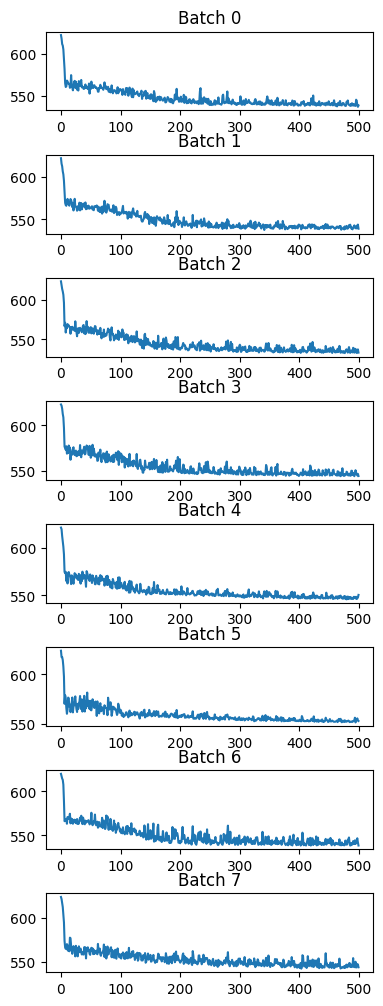

In [10]:
batch_plots(batch_loss_dict)

Done
tensor([[[ 8.9154e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           2.2447e-05,  1.5358e-36],
         [ 6.4625e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           1.9137e-04,  1.3093e-35],
         [ 3.1835e-01,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           3.0316e-02,  2.0740e-33],
         ...,
         [ 5.5905e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          -1.8877e-02, -1.3523e-18],
         [ 4.6106e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           1.1525e-03,  8.2789e-20],
         [ 1.2084e-01,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          -2.3568e-04, -1.6930e-20]],

        [[ 8.4028e-02,  0.0000e+00,  0.0000e+00,  ..., -3.1039e-37,
           1.7205e-05, -6.7724e-36],
         [ 6.8922e-02,  0.0000e+00,  0.0000e+00,  ..., -4.6054e-36,
           2.5528e-04, -1.0048e-34],
         [ 3.0807e-01,  0.0000e+00,  0.0000e+00,  ..., -5.3053e-34,
           2.9408e-02, -1.1576e-32],
         ...,
         [ 5.8959e-0

 _  _   _  ___    _   _  _____ 
(_)( ) ( )(  _`\ ( ) ( )(_   _)
| || `\| || |_) )| | | |  | |  
| || , ` || ,__/'| | | |  | |  
| || |`\ || |    | (_) |  | |  
(_)(_) (_)(_)    (_____)  (_)  
                               
                               



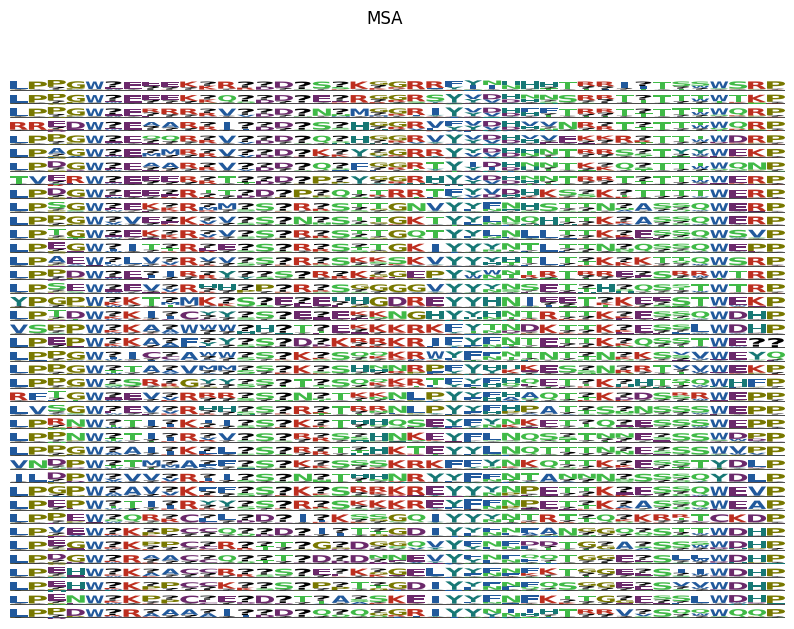

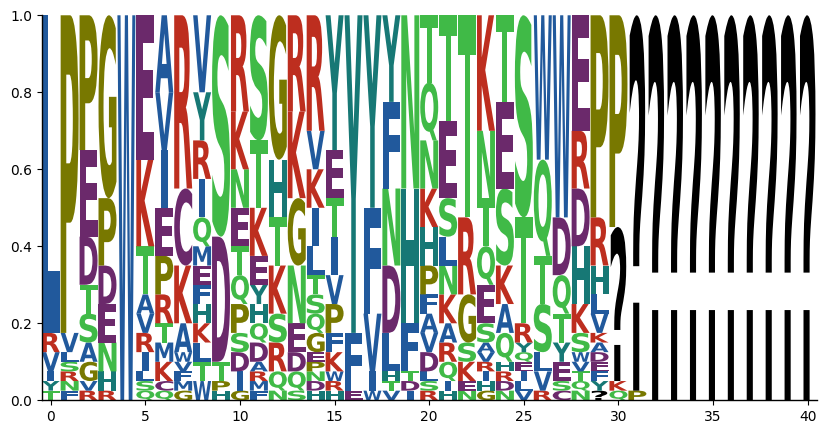

 ___    ___    ___    _____  _   _  ___   _____  ___    _   _  ___   _____  _ 
|  _`\ (  _`\ (  _`\ (  _  )( ) ( )(  _`\(_   _)|  _`\ ( ) ( )(  _`\(_   _)(_)
| (_) )| (_(_)| ( (_)| ( ) || `\| || (_(_) | |  | (_) )| | | || ( (_) | |  | |
| ,  / |  _)_ | |  _ | | | || , ` |`\__ \  | |  | ,  / | | | || |  _  | |  | |
| |\ \ | (_( )| (_( )| (_) || |`\ |( )_) | | |  | |\ \ | (_) || (_( ) | |  | |
(_) (_)(____/'(____/'(_____)(_) (_)`\____) (_)  (_) (_)(_____)(____/' (_)  (_)
                                                                              
                                                                              
 _____  _   _ 
(  _  )( ) ( )
| ( ) || `\| |
| | | || , ` |
| (_) || |`\ |
(_____)(_) (_)
              
              



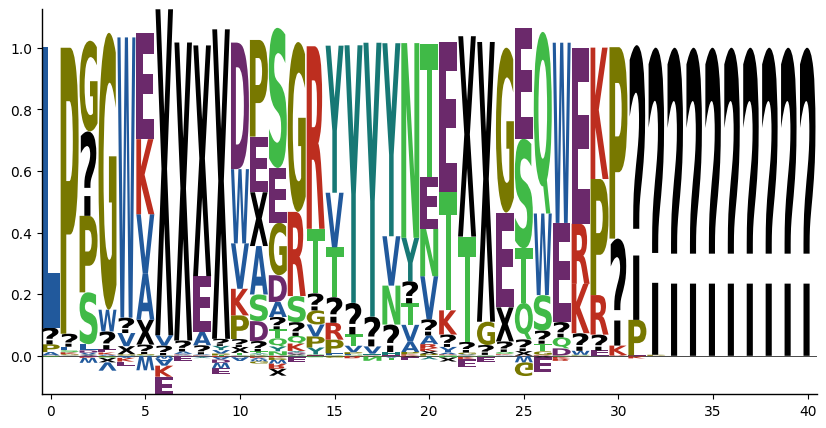

 _____  _      _  ___    _   _         ___    _   _  _____ 
(  _  )( )    (_)(  _`\ ( ) ( )/'\_/`\(  _`\ ( ) ( )(_   _)
| (_) || |    | || ( (_)| `\| ||     || (_(_)| `\| |  | |  
|  _  || |  _ | || |___ | , ` || (_) ||  _)_ | , ` |  | |  
| | | || |_( )| || (_, )| |`\ || | | || (_( )| |`\ |  | |  
(_) (_)(____/'(_)(____/'(_) (_)(_) (_)(____/'(_) (_)  (_)  
                                                           
                                                           



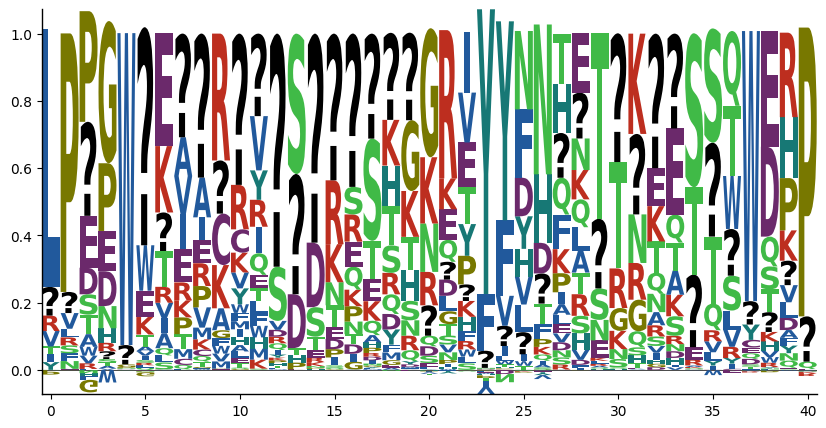

In [11]:
model.eval()
recon_data_train = model(dataset_msa.prot_space, deepseq)


print('Done')

from pyfiglet import Figlet
f = Figlet(font='puffy' ) #slant

print(recon_data_train[5])
alignment = recon_data_train[5]



plot_msa_from_preds(alignment.detach().cpu(), alphabets, figsize=(10,7), show_axis=False)



print(f.renderText('INPUT'))
plot_logos_probs(dataset_msa.prot_space.detach().cpu(), alphabets)

print(f.renderText('RECONSTRUCTION'))
plot_logos_probs(recon_data_train[0].detach().cpu(), alphabets)

print(f.renderText('ALIGNMENT'))
plot_logos_probs(recon_data_train[5].detach().cpu(), alphabets)



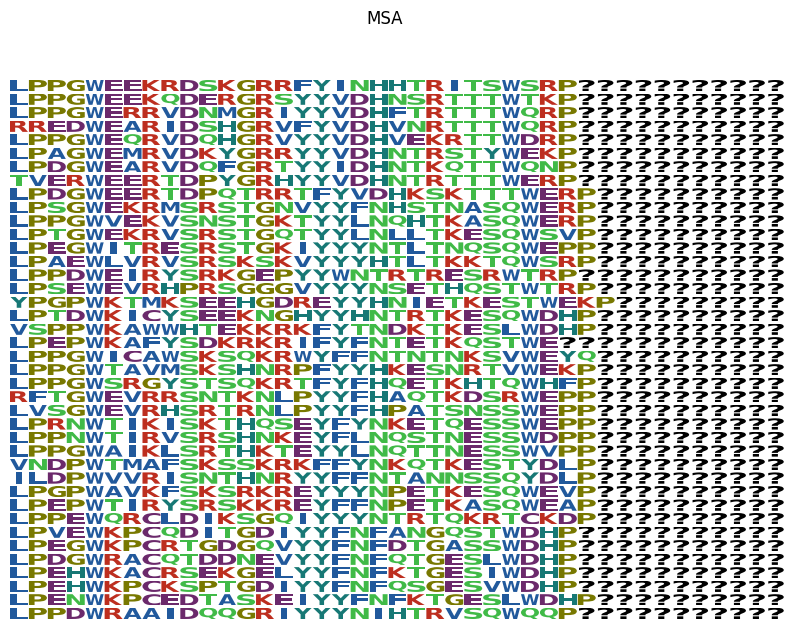

In [12]:
plot_msa_from_preds(trainloader.dataset.prot_space.detach().cpu(), alphabets, figsize=(10,7), show_axis=False)


<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

IndexError: index 5 is out of bounds for axis 1 with size 5

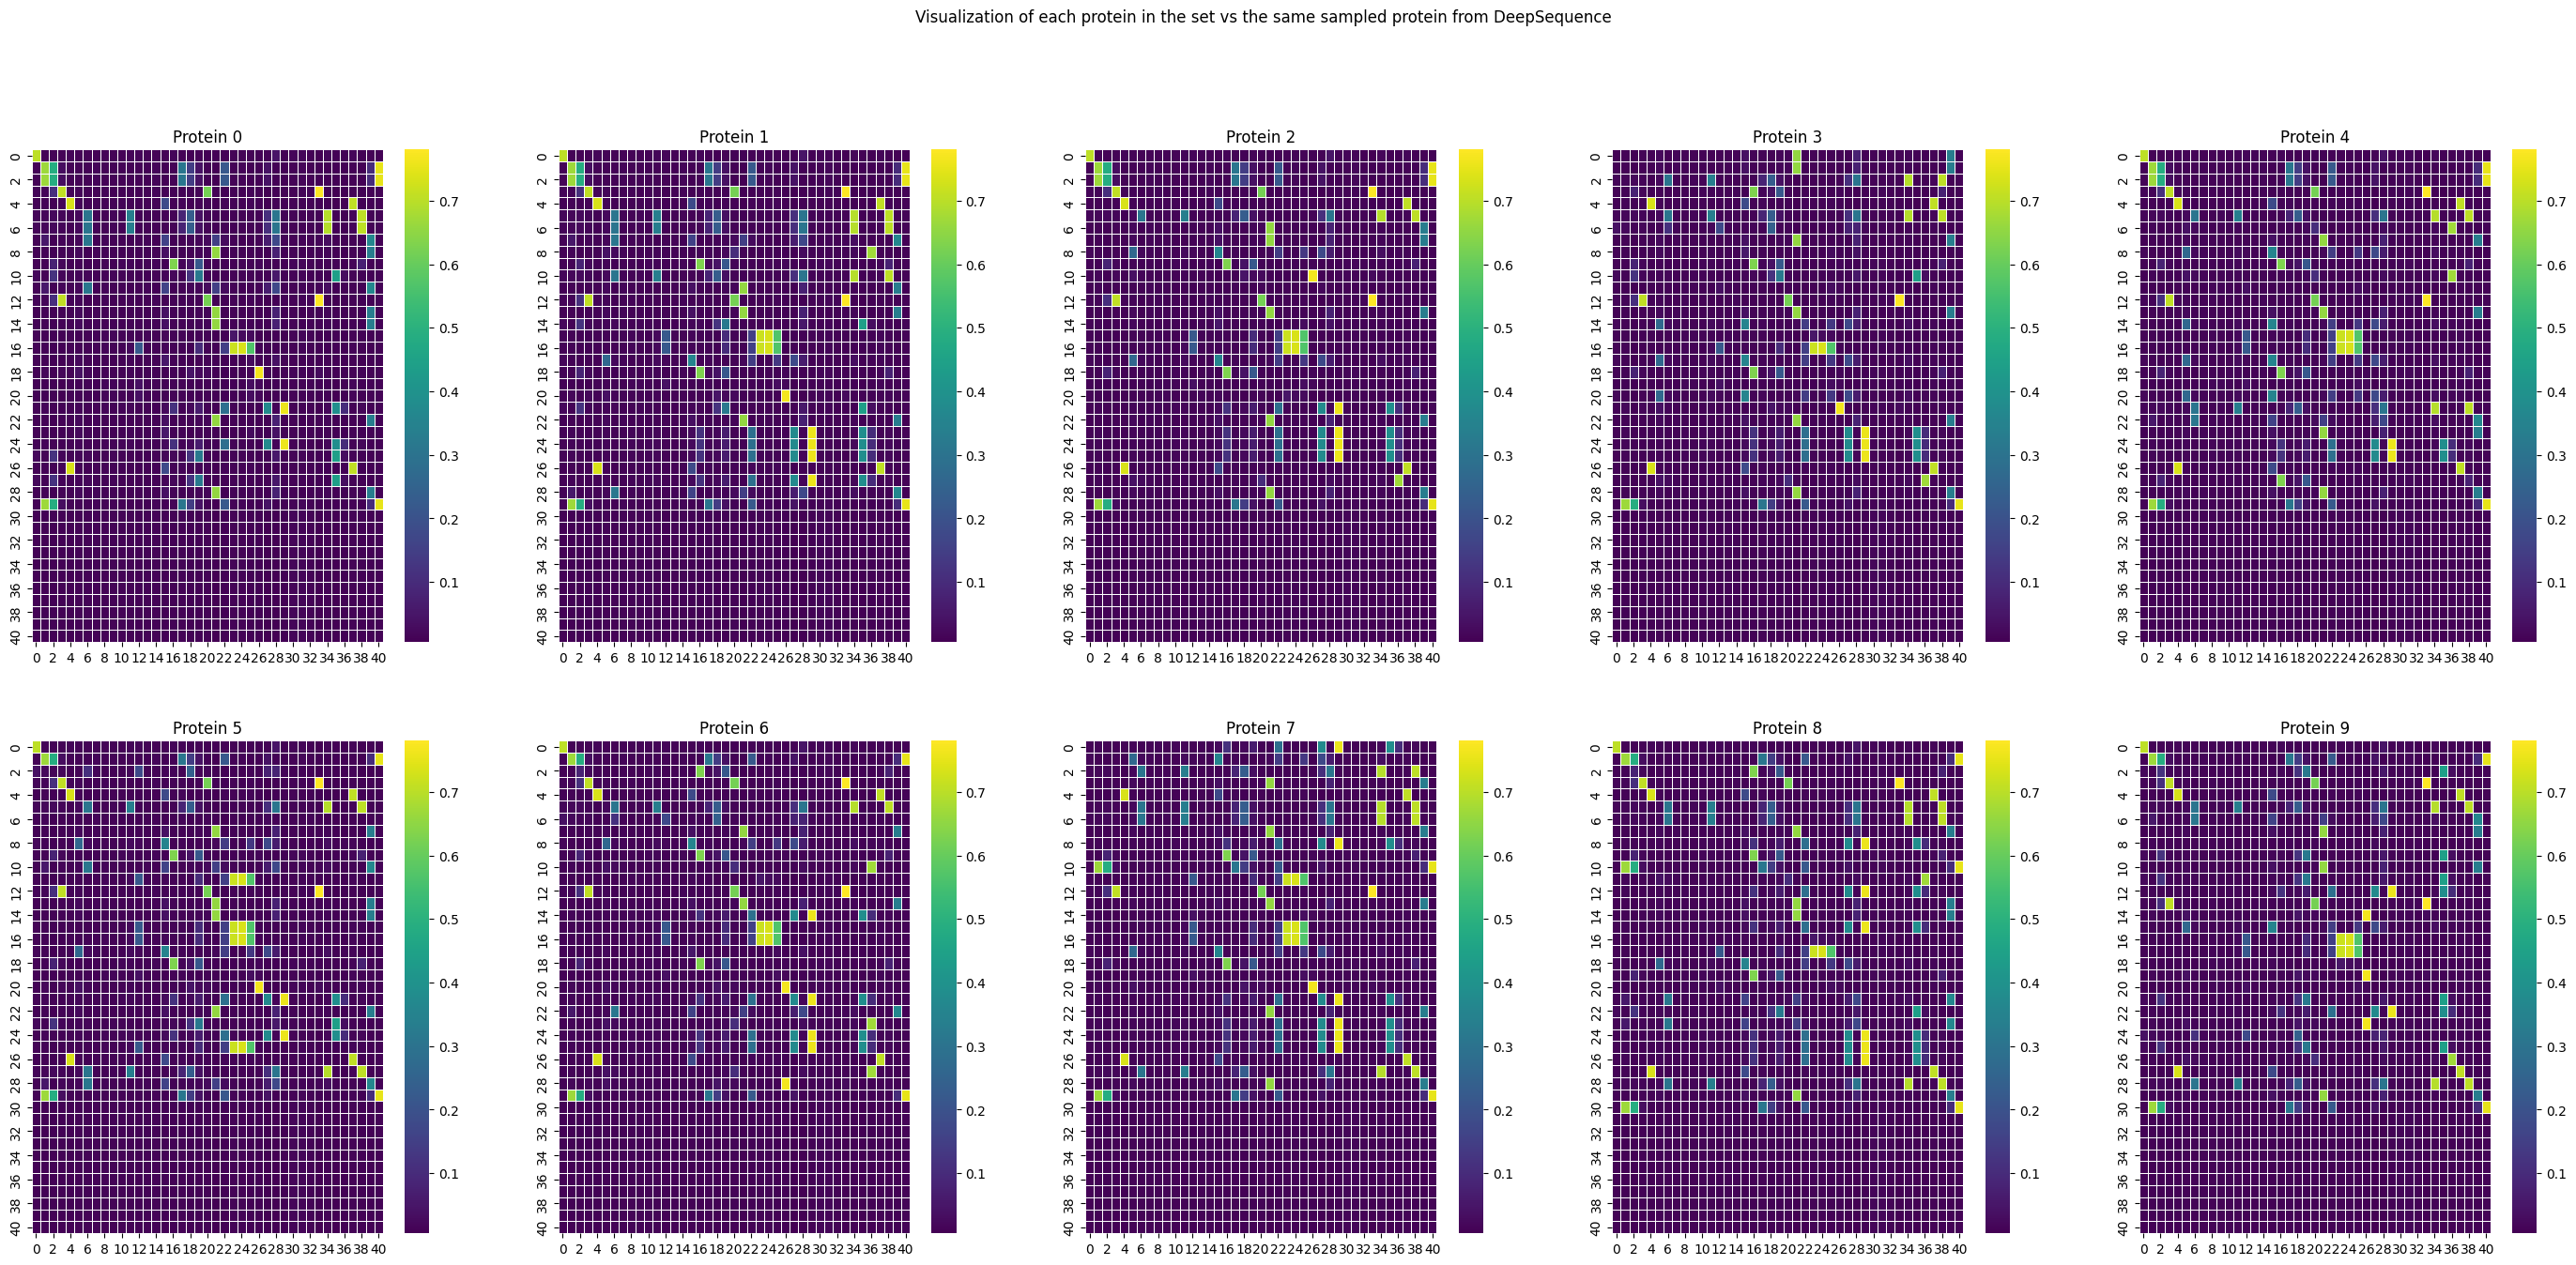

In [13]:
import seaborn as sns
import matplotlib.pylab as plt

def MonteCarlo_sampleDS(DS, iters):
    set_of_samples = [ DS.sample(1)[0] for i in range(0,iters)]
    MC_sample = torch.mean(torch.stack(set_of_samples), dim=0)
    return MC_sample

def energy_info_DSsampling_vs_Raw(DS, batch_seqs):

    #import ipdb; ipdb.set_trace()
    batch_size = batch_seqs.shape
    raw_seqs = batch_seqs; DS.eval()
    sampled_seqs = MonteCarlo_sampleDS(DS,100)

    sampled_seqs = sampled_seqs.permute(0,2,1)

    # One Sampled Protein from Deep Sequence vs all 10 proteins
    fig1vs10, axes1vs10 = plt.subplots(2, 5, figsize=(35,15))
    fig1vs10.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')
    list_of_attentions = []
    for cont, prot in enumerate(raw_seqs):
        # One Sampled Protein from Deep Sequence vs all 10 proteins
        ii,jj = ((1,cont-5), (0,cont))[cont < 5]
        seq = torch.matmul(prot,sampled_seqs[0])
        list_of_attentions.append(seq.detach().cpu())
        axes1vs10[ii,jj].set_title('Protein ' + str(cont))
        sns.heatmap(seq.detach().cpu().numpy(), linewidth=0.5, cmap='viridis', ax=axes1vs10[ii,jj])
    
    plt.show()
    return list_of_attentions


import torch.nn.functional as F

def get_diagonal_attention(Matrix, comp, min_r, max_r, list_attention = []):
    # Works assuming that we are dealing with square matrixes
    if comp <= max_r and comp >= min_r:
        list_attention.append( torch.cat( (torch.tensor([0.0]*abs(comp)) , torch.diagonal(Matrix, comp)) ) )
        get_diagonal_attention(Matrix, comp-1, min_r, max_r, list_attention)

def get_batch_diagonal_attention(Matrix, comp, min_r, max_r):
    list_batch = []
    list_attention = []
    for m in Matrix:
        get_diagonal_attention(m, comp, min_r, max_r, list_attention )
        list_batch.append( torch.stack(list_attention) )
        list_attention.clear()

    batch_diag_attention = torch.stack(list_batch)
    return batch_diag_attention


attentions = energy_info_DSsampling_vs_Raw( deepseq, dataset_msa.prot_space.detach())



In [ ]:
att = get_batch_diagonal_attention(attentions,10,-10, 10)

figatt, axesatt = plt.subplots(2, 5, figsize=(35,15))
figatt.suptitle('Visualization attention diagonals')

for cont, at in enumerate(att):
    # One Sampled Protein from Deep Sequence vs all 10 proteins
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axesatt[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap(at.numpy(), linewidth=0.5, cmap='viridis', ax=axesatt[ii,jj])
    
plt.show()

'''
Matrix = torch.tensor([[1,2,3,4,5],[33,44,55,66,77],[333,444,555,666,777],[3333,4444,5555,6666,7777],[33333,44444,55555,66666,77777]])
list_attention = []
get_diagonal_attention(Matrix, 2, -2, 2, list_attention)

Matrix2 = Matrix.repeat(2,1,1)
get_batch_diagonal_attention(Matrix2, 2, -2, 2)

print(list_attention)
'''

In [ ]:
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm, Normalize

fig1vs10, axes1vs10 = plt.subplots(2, 5, figsize=(35,15))
fig1vs10.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')

def lognormalize(x):
    a = np.logaddexp.reduce(x)
    return np.exp(x - a)

for cont, prot in enumerate(attentions):
    # One Sampled Protein from Deep Sequence vs all 10 proteins 
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axes1vs10[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap(prot.numpy(), linewidth=0.5, cmap='viridis', ax=axes1vs10[ii,jj])

plt.show()

fig1vs10_log, axes1vs10_log = plt.subplots(2, 5, figsize=(35,15))
fig1vs10_log.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')

for cont, prot in enumerate(attentions):
    # One Sampled Protein from Deep Sequence vs all 10 proteins 
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axes1vs10_log[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap( prot.numpy() , linewidth=0.5, cmap='viridis', ax=axes1vs10_log[ii,jj], norm=LogNorm())

plt.show()